# Prep

Setting up some prior functionality

In [118]:
import os
import json
from PIL import Image
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.5.1+cu101 True


# Load a model

First we have to decide if our model should be pretrained. 

This greatly depends on the size of a dataset. Smaller datasets rely more on finetuning. 

In [2]:
pretrained = True

if pretrained:
    # Get pretrained weights
    checkpoint = torch.hub.load_state_dict_from_url(
                url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
                map_location='cpu',
                check_hash=True)

    # Remove class weights
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]

    # SaveOGH
    torch.save(checkpoint,
               'detr-r50_no-class-head.pth')

# Dataset

Our dataset should be loadable as a COCO format

This allows us to use the pycocotools to load the data dict for the main python script

In [90]:
# alternatively, implement your own coco-type dataset loader in datasets and add this "key" to datasets/__init__.py
dataset_file = "coco_petct" 

# should lead to a directory with a train2017 and val2017 folder as well as an annotations folder
#dataDir='/COCO_dataset/' 
#dataDir = '/media/storage/Joy/datasets/DETR_MIP/FDG-PET-CT-Lesions/'
# dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP/FDG-PET-CT-Lesions/'
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

# this int should be the actual number of classes + 1 (for no class)
num_classes = 2

outDir = 'outputs'
resume = "detr-r50_no-class-head.pth" if pretrained else ""

In [4]:
!ls /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/

detr_test.json	detr_train.json  detr_val.json


In [5]:
!ls $dataDir

annotations  images


# Visualize

In [57]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
from PIL import Image
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [105]:
mode = 'train'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)
print(annFile)


# initialize COCO api for instance annotations
coco=COCO(annFile)

/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/detr_train.json
loading annotations into memory...
Done (t=2.15s)
creating index...
index created!


In [69]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['background', 'tumor']
Super-categories: {'tumor', 'background'}


In [70]:
# load and display image
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [71]:
def _load_image_npy(coco, img_folder, img_id):
    npy_name = coco.loadImgs(img_id)[0]["file_name"] # loads a .npy file by image_id
    img_ann_path = img_folder/Path(npy_name)
    print(img_ann_path)
    with open(img_ann_path, 'rb') as f:
        suv_img = np.load(f) # this is a single channel suv values image, dtype numpy float64
    return suv_img

def _suv_to_greyPIL(suv_img, suv_max):
    # Assuming eval mode
    norm = plt.Normalize(vmin = 0, vmax = suv_max) # normally radiologists view images at this suv norm
    # Color map to gray images, output has 3 channels
    cmap = plt.cm.Greys
    img = cmap(norm(suv_img))[:,:,:3].copy() # drop the alpha channel that we don't need. has shape (H x W x 3C) 
    #img = torch.as_tensor(img, dtype=torch.float64) # the transforms latera will turn the numpy array to a tensor (C x H x W)
    img = Image.fromarray(np.uint8(img*255), 'RGB') # expected input by transforms
    return img

     

Image n°0
Image name: /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions//annotations/train/0.npy
/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/images/train/0.npy


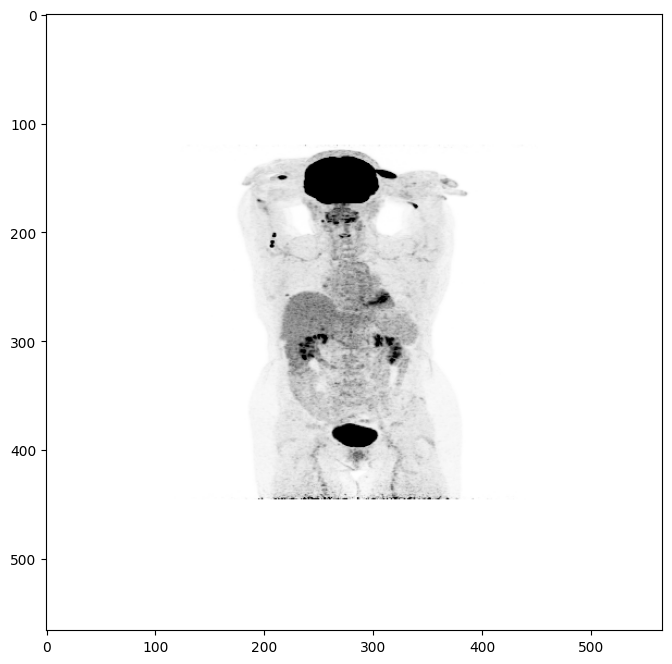

In [72]:
#img_id = imgIds[np.random.randint(0,len(imgIds))]
img_id = 0
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s/%s'%(dataDir, 'annotations', mode, img['file_name'])
print('Image name: {}'.format(img_name))

img_folder = Path(dataDir)/Path('images')/Path(mode)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 6
I = _suv_to_greyPIL(suv_img, suv_max)

#I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [73]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

print(len(anns))

5


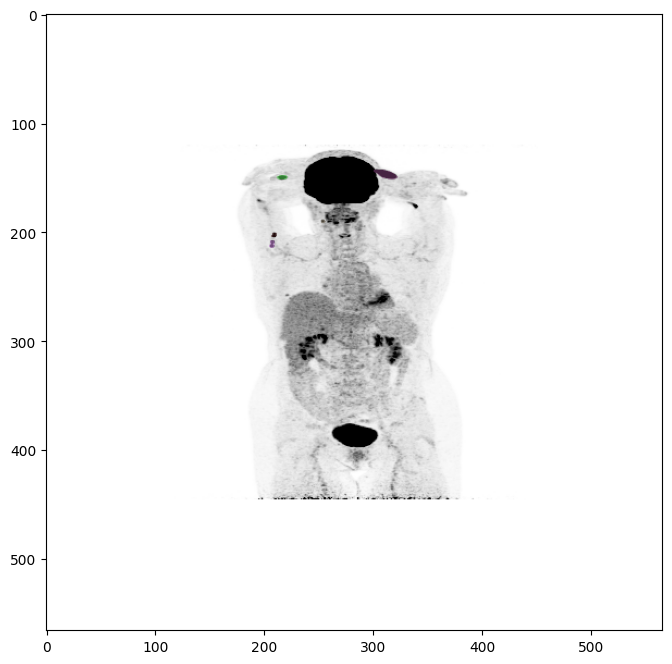

In [74]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

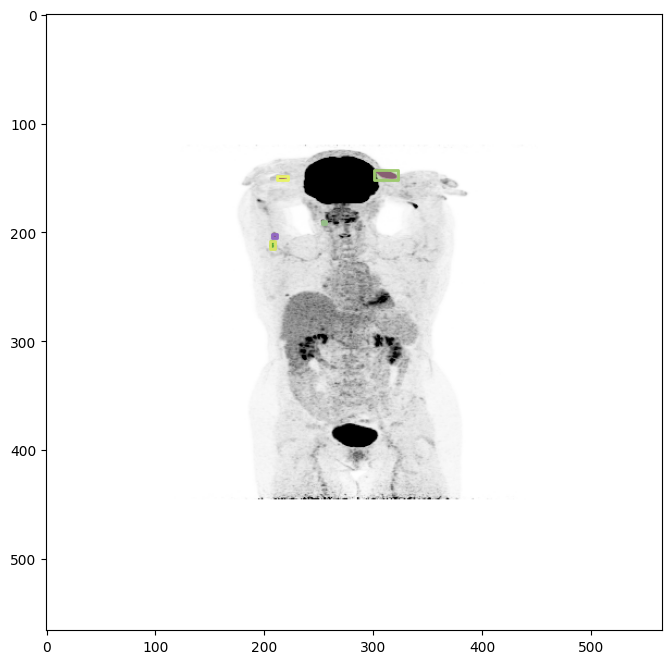

In [75]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

# Dataset Statistics

In [78]:
max_anno = 0
min_anno = 1
freq_anno = []
for imgID in imgIds:
    annIds = coco.getAnnIds(imgIds=imgID, catIds=[1])
    anns = coco.loadAnns(annIds)
    num = len(anns)
    if num > max_anno:
        max_anno = num
    if num < min_anno:
        min_anno = num
    if num > 1:
        freq_anno.append(num)
print(max_anno) 
print(min_anno) 
print(len(freq_anno))
print(len([f for f in freq_anno if f < 50]))

273
1
16053
15635


(array([2.714e+03, 2.600e+03, 1.628e+03, 1.496e+03, 1.060e+03, 8.740e+02,
        6.700e+02, 6.250e+02, 5.790e+02, 4.060e+02, 3.340e+02, 2.370e+02,
        1.450e+02, 1.410e+02, 1.550e+02, 1.130e+02, 1.570e+02, 1.260e+02,
        1.300e+02, 1.030e+02, 9.200e+01, 8.200e+01, 8.000e+01, 8.200e+01,
        7.300e+01, 6.800e+01, 7.100e+01, 7.400e+01, 8.000e+01, 4.400e+01,
        5.100e+01, 5.600e+01, 6.900e+01, 4.700e+01, 3.500e+01, 3.000e+01,
        3.700e+01, 3.000e+01, 3.000e+01, 2.600e+01, 2.000e+01, 2.100e+01,
        1.400e+01, 3.100e+01, 2.300e+01, 2.900e+01, 2.200e+01, 2.500e+01,
        2.300e+01, 2.200e+01, 1.400e+01, 1.200e+01, 6.000e+00, 8.000e+00,
        8.000e+00, 1.000e+01, 1.400e+01, 9.000e+00, 1.700e+01, 8.000e+00,
        1.500e+01, 2.000e+01, 1.200e+01, 6.000e+00, 5.000e+00, 2.000e+00,
        4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        5.000e+00, 9.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 9.000e+00,
        1.000e+01, 9.000e+00, 6.000e+0

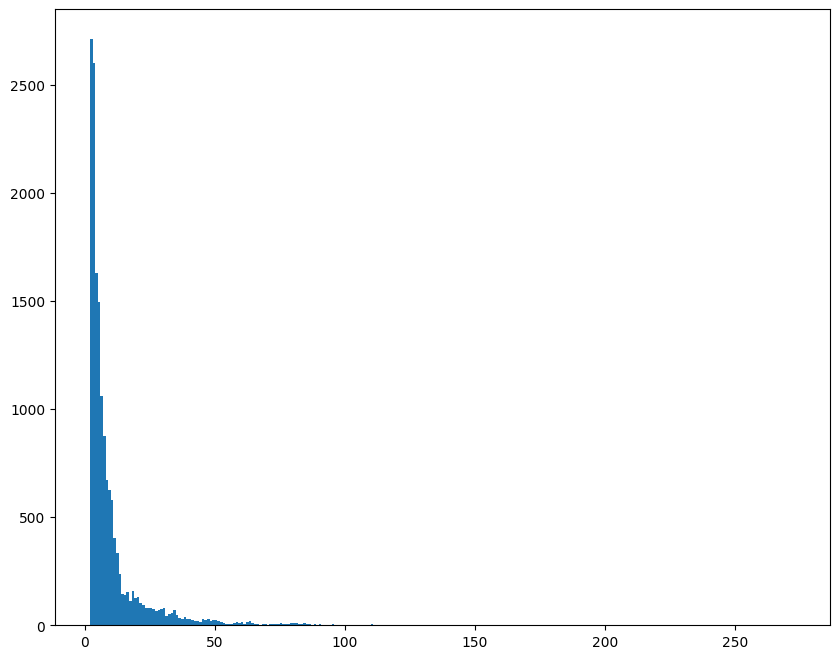

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

data = np.asarray(freq_anno)
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

In [88]:
if masks:
    print(masks)

1


# Training

We use the main.py script to run our training

In [93]:
experiment = 'baseline'

In [96]:
!/home/joywu/anaconda3/envs/detr_py38/bin/python main_petct.py \
  --dataset_file $dataset_file \
  --coco_petct_path $dataDir \
  --output_dir $outDir \
  --resume $resume \
  --num_classes $num_classes \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs 1 \
  --experiment $experiment

Not using distributed mode
git:
  sha: 72a6b3c5bdc73c2884b59ccc99aa85dc1fd39063, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, coco_petct_path='/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/', cross_val=False, dataset_file='coco_petct', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, experiment='baseline', frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=1e-05, lr_backbone=1e-06, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, train_spl

Epoch: [0]  [   50/19488]  eta: 1:10:22  lr: 0.000010  class_error: 100.00  loss: 24.2046 (23.6881)  loss_ce: 0.6218 (0.8747)  loss_bbox: 1.2030 (1.5100)  loss_giou: 1.9430 (1.4721)  loss_ce_0: 0.7577 (0.9667)  loss_bbox_0: 1.8785 (1.6487)  loss_giou_0: 1.9403 (1.5010)  loss_ce_1: 0.7153 (0.9483)  loss_bbox_1: 1.4920 (1.5510)  loss_giou_1: 1.9552 (1.4961)  loss_ce_2: 0.7005 (0.9374)  loss_bbox_2: 1.5067 (1.5909)  loss_giou_2: 1.9349 (1.4318)  loss_ce_3: 0.6600 (0.9203)  loss_bbox_3: 1.1943 (1.5143)  loss_giou_3: 1.9463 (1.4556)  loss_ce_4: 0.6316 (0.9071)  loss_bbox_4: 1.0382 (1.4861)  loss_giou_4: 1.9437 (1.4762)  loss_ce_unscaled: 0.6218 (0.8747)  class_error_unscaled: 0.0000 (31.6988)  loss_bbox_unscaled: 0.2406 (0.3020)  loss_giou_unscaled: 0.9715 (0.7360)  cardinality_error_unscaled: 3.0000 (41.7843)  loss_ce_0_unscaled: 0.7577 (0.9667)  loss_bbox_0_unscaled: 0.3757 (0.3297)  loss_giou_0_unscaled: 0.9702 (0.7505)  cardinality_error_0_unscaled: 37.5000 (67.5784)  loss_ce_1_unscaled

Epoch: [0]  [  100/19488]  eta: 1:07:30  lr: 0.000010  class_error: 0.00  loss: 17.8657 (20.0536)  loss_ce: 0.4236 (0.6842)  loss_bbox: 0.5496 (1.1179)  loss_giou: 1.8484 (1.4503)  loss_ce_0: 0.5398 (0.7922)  loss_bbox_0: 0.7634 (1.2694)  loss_giou_0: 1.9240 (1.4905)  loss_ce_1: 0.5068 (0.7700)  loss_bbox_1: 0.5729 (1.1892)  loss_giou_1: 1.7964 (1.4467)  loss_ce_2: 0.4420 (0.7423)  loss_bbox_2: 0.5647 (1.1680)  loss_giou_2: 1.8062 (1.4183)  loss_ce_3: 0.4124 (0.7145)  loss_bbox_3: 0.5385 (1.1247)  loss_giou_3: 1.8293 (1.4288)  loss_ce_4: 0.4195 (0.7049)  loss_bbox_4: 0.5382 (1.0947)  loss_giou_4: 1.8472 (1.4470)  loss_ce_unscaled: 0.4236 (0.6842)  class_error_unscaled: 0.0000 (29.9766)  loss_bbox_unscaled: 0.1099 (0.2236)  loss_giou_unscaled: 0.9242 (0.7252)  cardinality_error_unscaled: 1.5000 (23.2426)  loss_ce_0_unscaled: 0.5398 (0.7922)  loss_bbox_0_unscaled: 0.1527 (0.2539)  loss_giou_0_unscaled: 0.9620 (0.7453)  cardinality_error_0_unscaled: 4.5000 (41.1386)  loss_ce_1_unscaled: 0

Epoch: [0]  [  150/19488]  eta: 1:06:16  lr: 0.000010  class_error: 100.00  loss: 17.1022 (18.1677)  loss_ce: 0.4417 (0.6327)  loss_bbox: 0.4426 (0.8928)  loss_giou: 1.7548 (1.4267)  loss_ce_0: 0.4456 (0.6944)  loss_bbox_0: 0.5552 (1.0509)  loss_giou_0: 1.9253 (1.4726)  loss_ce_1: 0.4302 (0.6773)  loss_bbox_1: 0.4882 (0.9760)  loss_giou_1: 1.8590 (1.4347)  loss_ce_2: 0.4251 (0.6594)  loss_bbox_2: 0.4689 (0.9471)  loss_giou_2: 1.7973 (1.4106)  loss_ce_3: 0.3950 (0.6400)  loss_bbox_3: 0.4638 (0.9042)  loss_giou_3: 1.8260 (1.4124)  loss_ce_4: 0.4163 (0.6356)  loss_bbox_4: 0.4496 (0.8781)  loss_giou_4: 1.8352 (1.4222)  loss_ce_unscaled: 0.4417 (0.6327)  class_error_unscaled: 0.0000 (29.4660)  loss_bbox_unscaled: 0.0885 (0.1786)  loss_giou_unscaled: 0.8774 (0.7134)  cardinality_error_unscaled: 1.5000 (16.4702)  loss_ce_0_unscaled: 0.4456 (0.6944)  loss_bbox_0_unscaled: 0.1110 (0.2102)  loss_giou_0_unscaled: 0.9626 (0.7363)  cardinality_error_0_unscaled: 1.5000 (28.4470)  loss_ce_1_unscaled:

Epoch: [0]  [  200/19488]  eta: 1:06:13  lr: 0.000010  class_error: 100.00  loss: 16.9822 (16.7019)  loss_ce: 0.5777 (0.6282)  loss_bbox: 0.3497 (0.7481)  loss_giou: 1.6243 (1.3589)  loss_ce_0: 0.4223 (0.6358)  loss_bbox_0: 0.5102 (0.8938)  loss_giou_0: 1.8392 (1.4122)  loss_ce_1: 0.4551 (0.6275)  loss_bbox_1: 0.5216 (0.8231)  loss_giou_1: 1.7908 (1.3776)  loss_ce_2: 0.4922 (0.6225)  loss_bbox_2: 0.3683 (0.7890)  loss_giou_2: 1.7992 (1.3561)  loss_ce_3: 0.5274 (0.6164)  loss_bbox_3: 0.3099 (0.7535)  loss_giou_3: 1.7121 (1.3496)  loss_ce_4: 0.5421 (0.6170)  loss_bbox_4: 0.3046 (0.7340)  loss_giou_4: 1.6484 (1.3586)  loss_ce_unscaled: 0.5777 (0.6282)  class_error_unscaled: 0.0000 (31.8791)  loss_bbox_unscaled: 0.0699 (0.1496)  loss_giou_unscaled: 0.8121 (0.6795)  cardinality_error_unscaled: 1.5000 (13.1169)  loss_ce_0_unscaled: 0.4223 (0.6358)  loss_bbox_0_unscaled: 0.1020 (0.1788)  loss_giou_0_unscaled: 0.9196 (0.7061)  cardinality_error_0_unscaled: 1.5000 (22.1119)  loss_ce_1_unscaled:

Epoch: [0]  [  250/19488]  eta: 1:05:49  lr: 0.000010  class_error: 0.00  loss: 18.7882 (16.4151)  loss_ce: 0.8445 (0.6996)  loss_bbox: 0.3567 (0.6629)  loss_giou: 1.7036 (1.3585)  loss_ce_0: 0.5429 (0.6390)  loss_bbox_0: 0.4971 (0.8172)  loss_giou_0: 1.8603 (1.4001)  loss_ce_1: 0.5648 (0.6458)  loss_bbox_1: 0.4553 (0.7386)  loss_giou_1: 1.7935 (1.3642)  loss_ce_2: 0.6687 (0.6592)  loss_bbox_2: 0.4239 (0.7028)  loss_giou_2: 1.8138 (1.3567)  loss_ce_3: 0.7222 (0.6711)  loss_bbox_3: 0.3560 (0.6694)  loss_giou_3: 1.8773 (1.3474)  loss_ce_4: 0.7487 (0.6729)  loss_bbox_4: 0.3905 (0.6527)  loss_giou_4: 1.7734 (1.3572)  loss_ce_unscaled: 0.8445 (0.6996)  class_error_unscaled: 0.0000 (31.6942)  loss_bbox_unscaled: 0.0713 (0.1326)  loss_giou_unscaled: 0.8518 (0.6793)  cardinality_error_unscaled: 2.0000 (11.4044)  loss_ce_0_unscaled: 0.5429 (0.6390)  loss_bbox_0_unscaled: 0.0994 (0.1634)  loss_giou_0_unscaled: 0.9301 (0.7000)  cardinality_error_0_unscaled: 2.0000 (18.6076)  loss_ce_1_unscaled: 0

Epoch: [0]  [  300/19488]  eta: 1:05:31  lr: 0.000010  class_error: 0.00  loss: 18.7286 (16.5252)  loss_ce: 0.8335 (0.7354)  loss_bbox: 0.3754 (0.6149)  loss_giou: 1.8556 (1.4095)  loss_ce_0: 0.5472 (0.6407)  loss_bbox_0: 0.4216 (0.7725)  loss_giou_0: 1.8755 (1.4412)  loss_ce_1: 0.6480 (0.6602)  loss_bbox_1: 0.3543 (0.6879)  loss_giou_1: 1.8596 (1.4015)  loss_ce_2: 0.7015 (0.6830)  loss_bbox_2: 0.3635 (0.6525)  loss_giou_2: 1.8011 (1.4016)  loss_ce_3: 0.7612 (0.7039)  loss_bbox_3: 0.3624 (0.6200)  loss_giou_3: 1.8321 (1.3872)  loss_ce_4: 0.7564 (0.7065)  loss_bbox_4: 0.3974 (0.6079)  loss_giou_4: 1.8507 (1.3986)  loss_ce_unscaled: 0.8335 (0.7354)  class_error_unscaled: 0.0000 (28.4227)  loss_bbox_unscaled: 0.0751 (0.1230)  loss_giou_unscaled: 0.9278 (0.7048)  cardinality_error_unscaled: 2.0000 (10.1146)  loss_ce_0_unscaled: 0.5472 (0.6407)  loss_bbox_0_unscaled: 0.0843 (0.1545)  loss_giou_0_unscaled: 0.9377 (0.7206)  cardinality_error_0_unscaled: 2.0000 (16.1213)  loss_ce_1_unscaled: 0

Epoch: [0]  [  350/19488]  eta: 1:05:26  lr: 0.000010  class_error: 0.00  loss: 16.1287 (16.4920)  loss_ce: 0.9002 (0.7730)  loss_bbox: 0.2749 (0.5720)  loss_giou: 1.6871 (1.4211)  loss_ce_0: 0.6958 (0.6555)  loss_bbox_0: 0.3224 (0.7177)  loss_giou_0: 1.7139 (1.4437)  loss_ce_1: 0.7761 (0.6857)  loss_bbox_1: 0.2796 (0.6370)  loss_giou_1: 1.6916 (1.4093)  loss_ce_2: 0.8447 (0.7150)  loss_bbox_2: 0.2749 (0.6050)  loss_giou_2: 1.7645 (1.4176)  loss_ce_3: 0.8606 (0.7426)  loss_bbox_3: 0.2840 (0.5763)  loss_giou_3: 1.6614 (1.4002)  loss_ce_4: 0.8716 (0.7449)  loss_bbox_4: 0.2786 (0.5667)  loss_giou_4: 1.6680 (1.4087)  loss_ce_unscaled: 0.9002 (0.7730)  class_error_unscaled: 0.0000 (27.5078)  loss_bbox_unscaled: 0.0550 (0.1144)  loss_giou_unscaled: 0.8435 (0.7105)  cardinality_error_unscaled: 3.0000 (9.5171)  loss_ce_0_unscaled: 0.6958 (0.6555)  loss_bbox_0_unscaled: 0.0645 (0.1435)  loss_giou_0_unscaled: 0.8569 (0.7219)  cardinality_error_0_unscaled: 3.0000 (14.6681)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  400/19488]  eta: 1:05:07  lr: 0.000010  class_error: 0.00  loss: 16.1625 (16.3462)  loss_ce: 0.5923 (0.7930)  loss_bbox: 0.2772 (0.5390)  loss_giou: 1.6641 (1.4154)  loss_ce_0: 0.4751 (0.6636)  loss_bbox_0: 0.3186 (0.6780)  loss_giou_0: 1.6184 (1.4359)  loss_ce_1: 0.5255 (0.7005)  loss_bbox_1: 0.2768 (0.5996)  loss_giou_1: 1.6365 (1.4015)  loss_ce_2: 0.5334 (0.7345)  loss_bbox_2: 0.2919 (0.5698)  loss_giou_2: 1.5446 (1.4080)  loss_ce_3: 0.5936 (0.7646)  loss_bbox_3: 0.2867 (0.5442)  loss_giou_3: 1.6361 (1.3933)  loss_ce_4: 0.5861 (0.7657)  loss_bbox_4: 0.2997 (0.5360)  loss_giou_4: 1.6145 (1.4036)  loss_ce_unscaled: 0.5923 (0.7930)  class_error_unscaled: 0.0000 (27.0704)  loss_bbox_unscaled: 0.0554 (0.1078)  loss_giou_unscaled: 0.8320 (0.7077)  cardinality_error_unscaled: 2.0000 (9.0062)  loss_ce_0_unscaled: 0.4751 (0.6636)  loss_bbox_0_unscaled: 0.0637 (0.1356)  loss_giou_0_unscaled: 0.8092 (0.7180)  cardinality_error_0_unscaled: 2.0000 (13.5150)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  450/19488]  eta: 1:04:45  lr: 0.000010  class_error: 0.00  loss: 16.6799 (16.1064)  loss_ce: 0.5243 (0.7926)  loss_bbox: 0.2840 (0.5074)  loss_giou: 1.7616 (1.4062)  loss_ce_0: 0.4802 (0.6608)  loss_bbox_0: 0.3362 (0.6416)  loss_giou_0: 1.8549 (1.4305)  loss_ce_1: 0.4641 (0.7019)  loss_bbox_1: 0.3296 (0.5639)  loss_giou_1: 1.8084 (1.3957)  loss_ce_2: 0.5236 (0.7371)  loss_bbox_2: 0.2916 (0.5354)  loss_giou_2: 1.8376 (1.3994)  loss_ce_3: 0.5513 (0.7668)  loss_bbox_3: 0.2966 (0.5126)  loss_giou_3: 1.7078 (1.3847)  loss_ce_4: 0.5476 (0.7679)  loss_bbox_4: 0.2960 (0.5056)  loss_giou_4: 1.7424 (1.3963)  loss_ce_unscaled: 0.5243 (0.7926)  class_error_unscaled: 0.0000 (26.9518)  loss_bbox_unscaled: 0.0568 (0.1015)  loss_giou_unscaled: 0.8808 (0.7031)  cardinality_error_unscaled: 1.5000 (8.5554)  loss_ce_0_unscaled: 0.4802 (0.6608)  loss_bbox_0_unscaled: 0.0672 (0.1283)  loss_giou_0_unscaled: 0.9274 (0.7152)  cardinality_error_0_unscaled: 1.5000 (12.5621)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  500/19488]  eta: 1:04:34  lr: 0.000010  class_error: 0.00  loss: 13.5005 (15.8577)  loss_ce: 0.4779 (0.7812)  loss_bbox: 0.2243 (0.4792)  loss_giou: 1.5089 (1.3994)  loss_ce_0: 0.4374 (0.6517)  loss_bbox_0: 0.2553 (0.6059)  loss_giou_0: 1.5494 (1.4300)  loss_ce_1: 0.5111 (0.6959)  loss_bbox_1: 0.2513 (0.5324)  loss_giou_1: 1.5645 (1.3980)  loss_ce_2: 0.5258 (0.7301)  loss_bbox_2: 0.2370 (0.5050)  loss_giou_2: 1.4867 (1.3972)  loss_ce_3: 0.5170 (0.7575)  loss_bbox_3: 0.2515 (0.4843)  loss_giou_3: 1.4690 (1.3816)  loss_ce_4: 0.5255 (0.7592)  loss_bbox_4: 0.2484 (0.4785)  loss_giou_4: 1.5433 (1.3907)  loss_ce_unscaled: 0.4779 (0.7812)  class_error_unscaled: 0.0000 (26.2580)  loss_bbox_unscaled: 0.0449 (0.0958)  loss_giou_unscaled: 0.7544 (0.6997)  cardinality_error_unscaled: 2.0000 (8.2046)  loss_ce_0_unscaled: 0.4374 (0.6517)  loss_bbox_0_unscaled: 0.0511 (0.1212)  loss_giou_0_unscaled: 0.7747 (0.7150)  cardinality_error_0_unscaled: 2.0000 (11.7615)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  550/19488]  eta: 1:04:26  lr: 0.000010  class_error: 0.00  loss: 12.4084 (15.3987)  loss_ce: 0.2904 (0.7504)  loss_bbox: 0.2263 (0.4546)  loss_giou: 1.5680 (1.3740)  loss_ce_0: 0.2450 (0.6275)  loss_bbox_0: 0.2661 (0.5747)  loss_giou_0: 1.6182 (1.4117)  loss_ce_1: 0.2631 (0.6710)  loss_bbox_1: 0.2329 (0.5046)  loss_giou_1: 1.5594 (1.3742)  loss_ce_2: 0.2741 (0.7034)  loss_bbox_2: 0.2135 (0.4792)  loss_giou_2: 1.5742 (1.3744)  loss_ce_3: 0.2738 (0.7285)  loss_bbox_3: 0.2166 (0.4595)  loss_giou_3: 1.4642 (1.3594)  loss_ce_4: 0.2787 (0.7302)  loss_bbox_4: 0.2381 (0.4549)  loss_giou_4: 1.4310 (1.3665)  loss_ce_unscaled: 0.2904 (0.7504)  class_error_unscaled: 0.0000 (26.5975)  loss_bbox_unscaled: 0.0453 (0.0909)  loss_giou_unscaled: 0.7840 (0.6870)  cardinality_error_unscaled: 1.0000 (7.7042)  loss_ce_0_unscaled: 0.2450 (0.6275)  loss_bbox_0_unscaled: 0.0532 (0.1149)  loss_giou_0_unscaled: 0.8091 (0.7058)  cardinality_error_0_unscaled: 1.0000 (10.9020)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  600/19488]  eta: 1:04:11  lr: 0.000010  class_error: 0.00  loss: 14.0878 (15.1362)  loss_ce: 0.6145 (0.7478)  loss_bbox: 0.1767 (0.4346)  loss_giou: 1.3095 (1.3551)  loss_ce_0: 0.5047 (0.6220)  loss_bbox_0: 0.2050 (0.5490)  loss_giou_0: 1.5047 (1.3915)  loss_ce_1: 0.6305 (0.6682)  loss_bbox_1: 0.1699 (0.4811)  loss_giou_1: 1.2734 (1.3546)  loss_ce_2: 0.6038 (0.7009)  loss_bbox_2: 0.1785 (0.4581)  loss_giou_2: 1.3925 (1.3570)  loss_ce_3: 0.6055 (0.7248)  loss_bbox_3: 0.1804 (0.4390)  loss_giou_3: 1.3823 (1.3417)  loss_ce_4: 0.6200 (0.7276)  loss_bbox_4: 0.1826 (0.4359)  loss_giou_4: 1.3533 (1.3473)  loss_ce_unscaled: 0.6145 (0.7478)  class_error_unscaled: 0.0000 (27.2134)  loss_bbox_unscaled: 0.0353 (0.0869)  loss_giou_unscaled: 0.6547 (0.6776)  cardinality_error_unscaled: 2.5000 (7.4318)  loss_ce_0_unscaled: 0.5047 (0.6220)  loss_bbox_0_unscaled: 0.0410 (0.1098)  loss_giou_0_unscaled: 0.7523 (0.6957)  cardinality_error_0_unscaled: 2.0000 (10.3419)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  650/19488]  eta: 1:04:07  lr: 0.000010  class_error: 100.00  loss: 14.4413 (14.9616)  loss_ce: 0.4753 (0.7356)  loss_bbox: 0.2138 (0.4239)  loss_giou: 1.4524 (1.3482)  loss_ce_0: 0.4259 (0.6118)  loss_bbox_0: 0.2348 (0.5369)  loss_giou_0: 1.4987 (1.3864)  loss_ce_1: 0.4359 (0.6580)  loss_bbox_1: 0.2056 (0.4667)  loss_giou_1: 1.5805 (1.3519)  loss_ce_2: 0.4184 (0.6893)  loss_bbox_2: 0.2260 (0.4458)  loss_giou_2: 1.5733 (1.3523)  loss_ce_3: 0.4820 (0.7125)  loss_bbox_3: 0.1946 (0.4265)  loss_giou_3: 1.4903 (1.3360)  loss_ce_4: 0.4724 (0.7154)  loss_bbox_4: 0.2251 (0.4247)  loss_giou_4: 1.4611 (1.3397)  loss_ce_unscaled: 0.4753 (0.7356)  class_error_unscaled: 0.0000 (27.1202)  loss_bbox_unscaled: 0.0428 (0.0848)  loss_giou_unscaled: 0.7262 (0.6741)  cardinality_error_unscaled: 1.0000 (7.3433)  loss_ce_0_unscaled: 0.4259 (0.6118)  loss_bbox_0_unscaled: 0.0470 (0.1074)  loss_giou_0_unscaled: 0.7493 (0.6932)  cardinality_error_0_unscaled: 1.5000 (9.9793)  loss_ce_1_unscaled: 0

Epoch: [0]  [  700/19488]  eta: 1:04:19  lr: 0.000010  class_error: 100.00  loss: 14.4158 (14.8301)  loss_ce: 0.4726 (0.7296)  loss_bbox: 0.2783 (0.4117)  loss_giou: 1.5324 (1.3451)  loss_ce_0: 0.3926 (0.6071)  loss_bbox_0: 0.2406 (0.5184)  loss_giou_0: 1.6196 (1.3836)  loss_ce_1: 0.4625 (0.6540)  loss_bbox_1: 0.2776 (0.4516)  loss_giou_1: 1.6123 (1.3495)  loss_ce_2: 0.4799 (0.6840)  loss_bbox_2: 0.2928 (0.4319)  loss_giou_2: 1.6082 (1.3498)  loss_ce_3: 0.4474 (0.7064)  loss_bbox_3: 0.2784 (0.4141)  loss_giou_3: 1.5512 (1.3340)  loss_ce_4: 0.4709 (0.7095)  loss_bbox_4: 0.2516 (0.4127)  loss_giou_4: 1.5660 (1.3373)  loss_ce_unscaled: 0.4726 (0.7296)  class_error_unscaled: 0.0000 (26.4697)  loss_bbox_unscaled: 0.0557 (0.0823)  loss_giou_unscaled: 0.7662 (0.6725)  cardinality_error_unscaled: 1.5000 (7.3502)  loss_ce_0_unscaled: 0.3926 (0.6071)  loss_bbox_0_unscaled: 0.0481 (0.1037)  loss_giou_0_unscaled: 0.8098 (0.6918)  cardinality_error_0_unscaled: 1.5000 (9.7175)  loss_ce_1_unscaled: 0

Epoch: [0]  [  750/19488]  eta: 1:04:21  lr: 0.000010  class_error: 0.00  loss: 10.1136 (14.5624)  loss_ce: 0.2489 (0.7074)  loss_bbox: 0.1534 (0.3975)  loss_giou: 1.1006 (1.3344)  loss_ce_0: 0.2401 (0.5914)  loss_bbox_0: 0.1706 (0.4991)  loss_giou_0: 1.1894 (1.3733)  loss_ce_1: 0.2096 (0.6367)  loss_bbox_1: 0.1606 (0.4351)  loss_giou_1: 1.0799 (1.3401)  loss_ce_2: 0.2488 (0.6653)  loss_bbox_2: 0.1496 (0.4166)  loss_giou_2: 1.1258 (1.3403)  loss_ce_3: 0.2332 (0.6855)  loss_bbox_3: 0.1716 (0.4004)  loss_giou_3: 1.0834 (1.3245)  loss_ce_4: 0.2231 (0.6888)  loss_bbox_4: 0.1796 (0.3990)  loss_giou_4: 1.0984 (1.3271)  loss_ce_unscaled: 0.2489 (0.7074)  class_error_unscaled: 0.0000 (26.3053)  loss_bbox_unscaled: 0.0307 (0.0795)  loss_giou_unscaled: 0.5503 (0.6672)  cardinality_error_unscaled: 1.0000 (7.5186)  loss_ce_0_unscaled: 0.2401 (0.5914)  loss_bbox_0_unscaled: 0.0341 (0.0998)  loss_giou_0_unscaled: 0.5947 (0.6867)  cardinality_error_0_unscaled: 0.5000 (9.5859)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [  800/19488]  eta: 1:04:09  lr: 0.000010  class_error: 0.00  loss: 13.5322 (14.3897)  loss_ce: 0.5548 (0.6983)  loss_bbox: 0.2305 (0.3868)  loss_giou: 1.5344 (1.3258)  loss_ce_0: 0.4856 (0.5843)  loss_bbox_0: 0.2149 (0.4845)  loss_giou_0: 1.5620 (1.3646)  loss_ce_1: 0.4958 (0.6299)  loss_bbox_1: 0.2243 (0.4220)  loss_giou_1: 1.5792 (1.3319)  loss_ce_2: 0.4950 (0.6567)  loss_bbox_2: 0.2339 (0.4045)  loss_giou_2: 1.5045 (1.3327)  loss_ce_3: 0.5360 (0.6764)  loss_bbox_3: 0.2241 (0.3898)  loss_giou_3: 1.5273 (1.3153)  loss_ce_4: 0.5367 (0.6799)  loss_bbox_4: 0.2437 (0.3880)  loss_giou_4: 1.5683 (1.3183)  loss_ce_unscaled: 0.5548 (0.6983)  class_error_unscaled: 0.0000 (26.1614)  loss_bbox_unscaled: 0.0461 (0.0774)  loss_giou_unscaled: 0.7672 (0.6629)  cardinality_error_unscaled: 2.5000 (7.4307)  loss_ce_0_unscaled: 0.4856 (0.5843)  loss_bbox_0_unscaled: 0.0430 (0.0969)  loss_giou_0_unscaled: 0.7810 (0.6823)  cardinality_error_0_unscaled: 2.5000 (9.3177)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [  850/19488]  eta: 1:04:09  lr: 0.000010  class_error: 0.00  loss: 14.2912 (14.1832)  loss_ce: 0.3869 (0.6838)  loss_bbox: 0.2138 (0.3739)  loss_giou: 1.6599 (1.3165)  loss_ce_0: 0.3685 (0.5730)  loss_bbox_0: 0.2592 (0.4689)  loss_giou_0: 1.6794 (1.3571)  loss_ce_1: 0.4337 (0.6183)  loss_bbox_1: 0.2272 (0.4080)  loss_giou_1: 1.6114 (1.3252)  loss_ce_2: 0.4086 (0.6436)  loss_bbox_2: 0.2296 (0.3911)  loss_giou_2: 1.5990 (1.3248)  loss_ce_3: 0.3849 (0.6624)  loss_bbox_3: 0.2411 (0.3770)  loss_giou_3: 1.6430 (1.3081)  loss_ce_4: 0.3901 (0.6661)  loss_bbox_4: 0.2090 (0.3753)  loss_giou_4: 1.5313 (1.3102)  loss_ce_unscaled: 0.3869 (0.6838)  class_error_unscaled: 0.0000 (26.1519)  loss_bbox_unscaled: 0.0428 (0.0748)  loss_giou_unscaled: 0.8300 (0.6583)  cardinality_error_unscaled: 1.0000 (7.3913)  loss_ce_0_unscaled: 0.3685 (0.5730)  loss_bbox_0_unscaled: 0.0518 (0.0938)  loss_giou_0_unscaled: 0.8397 (0.6786)  cardinality_error_0_unscaled: 1.0000 (9.0922)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [  900/19488]  eta: 1:04:15  lr: 0.000010  class_error: 0.00  loss: 16.1744 (14.0414)  loss_ce: 0.5694 (0.6781)  loss_bbox: 0.2549 (0.3649)  loss_giou: 1.6340 (1.3073)  loss_ce_0: 0.4442 (0.5676)  loss_bbox_0: 0.3344 (0.4576)  loss_giou_0: 1.6748 (1.3493)  loss_ce_1: 0.5400 (0.6135)  loss_bbox_1: 0.2651 (0.3970)  loss_giou_1: 1.6920 (1.3173)  loss_ce_2: 0.5482 (0.6381)  loss_bbox_2: 0.2604 (0.3812)  loss_giou_2: 1.6552 (1.3169)  loss_ce_3: 0.5294 (0.6560)  loss_bbox_3: 0.2720 (0.3680)  loss_giou_3: 1.6448 (1.2995)  loss_ce_4: 0.5461 (0.6606)  loss_bbox_4: 0.2883 (0.3668)  loss_giou_4: 1.6520 (1.3017)  loss_ce_unscaled: 0.5694 (0.6781)  class_error_unscaled: 0.0000 (26.2544)  loss_bbox_unscaled: 0.0510 (0.0730)  loss_giou_unscaled: 0.8170 (0.6536)  cardinality_error_unscaled: 2.5000 (7.1970)  loss_ce_0_unscaled: 0.4442 (0.5676)  loss_bbox_0_unscaled: 0.0669 (0.0915)  loss_giou_0_unscaled: 0.8374 (0.6747)  cardinality_error_0_unscaled: 2.0000 (8.7653)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [  950/19488]  eta: 1:04:28  lr: 0.000010  class_error: 0.00  loss: 16.7937 (13.9557)  loss_ce: 0.5693 (0.6712)  loss_bbox: 0.2952 (0.3577)  loss_giou: 1.7649 (1.3078)  loss_ce_0: 0.4462 (0.5625)  loss_bbox_0: 0.3099 (0.4483)  loss_giou_0: 1.8399 (1.3476)  loss_ce_1: 0.4910 (0.6084)  loss_bbox_1: 0.3072 (0.3888)  loss_giou_1: 1.8268 (1.3168)  loss_ce_2: 0.5167 (0.6321)  loss_bbox_2: 0.3276 (0.3737)  loss_giou_2: 1.7916 (1.3156)  loss_ce_3: 0.5383 (0.6490)  loss_bbox_3: 0.3104 (0.3608)  loss_giou_3: 1.7093 (1.2997)  loss_ce_4: 0.5523 (0.6542)  loss_bbox_4: 0.3023 (0.3597)  loss_giou_4: 1.8185 (1.3018)  loss_ce_unscaled: 0.5693 (0.6712)  class_error_unscaled: 0.0000 (26.1359)  loss_bbox_unscaled: 0.0590 (0.0715)  loss_giou_unscaled: 0.8825 (0.6539)  cardinality_error_unscaled: 1.5000 (7.2865)  loss_ce_0_unscaled: 0.4462 (0.5625)  loss_bbox_0_unscaled: 0.0620 (0.0897)  loss_giou_0_unscaled: 0.9200 (0.6738)  cardinality_error_0_unscaled: 1.5000 (8.6872)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1000/19488]  eta: 1:04:25  lr: 0.000010  class_error: 0.00  loss: 14.5037 (13.8492)  loss_ce: 0.4370 (0.6648)  loss_bbox: 0.2181 (0.3495)  loss_giou: 1.5561 (1.3047)  loss_ce_0: 0.4073 (0.5576)  loss_bbox_0: 0.2423 (0.4378)  loss_giou_0: 1.4621 (1.3434)  loss_ce_1: 0.4571 (0.6032)  loss_bbox_1: 0.2127 (0.3796)  loss_giou_1: 1.4341 (1.3141)  loss_ce_2: 0.4066 (0.6261)  loss_bbox_2: 0.2078 (0.3651)  loss_giou_2: 1.5080 (1.3135)  loss_ce_3: 0.4237 (0.6421)  loss_bbox_3: 0.2023 (0.3530)  loss_giou_3: 1.4660 (1.2967)  loss_ce_4: 0.4721 (0.6479)  loss_bbox_4: 0.2016 (0.3518)  loss_giou_4: 1.5374 (1.2984)  loss_ce_unscaled: 0.4370 (0.6648)  class_error_unscaled: 0.0000 (25.9293)  loss_bbox_unscaled: 0.0436 (0.0699)  loss_giou_unscaled: 0.7781 (0.6524)  cardinality_error_unscaled: 2.0000 (7.3182)  loss_ce_0_unscaled: 0.4073 (0.5576)  loss_bbox_0_unscaled: 0.0485 (0.0876)  loss_giou_0_unscaled: 0.7311 (0.6717)  cardinality_error_0_unscaled: 2.0000 (8.5410)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1050/19488]  eta: 1:04:17  lr: 0.000010  class_error: 0.00  loss: 14.7918 (13.8302)  loss_ce: 0.4527 (0.6645)  loss_bbox: 0.2075 (0.3444)  loss_giou: 1.4781 (1.3074)  loss_ce_0: 0.4536 (0.5575)  loss_bbox_0: 0.2800 (0.4315)  loss_giou_0: 1.6569 (1.3471)  loss_ce_1: 0.4825 (0.6032)  loss_bbox_1: 0.2777 (0.3737)  loss_giou_1: 1.6001 (1.3169)  loss_ce_2: 0.4353 (0.6258)  loss_bbox_2: 0.2483 (0.3596)  loss_giou_2: 1.5805 (1.3155)  loss_ce_3: 0.4330 (0.6416)  loss_bbox_3: 0.1987 (0.3475)  loss_giou_3: 1.4760 (1.2997)  loss_ce_4: 0.4478 (0.6475)  loss_bbox_4: 0.2083 (0.3465)  loss_giou_4: 1.4747 (1.3003)  loss_ce_unscaled: 0.4527 (0.6645)  class_error_unscaled: 0.0000 (25.4569)  loss_bbox_unscaled: 0.0415 (0.0689)  loss_giou_unscaled: 0.7391 (0.6537)  cardinality_error_unscaled: 3.0000 (7.4439)  loss_ce_0_unscaled: 0.4536 (0.5575)  loss_bbox_0_unscaled: 0.0560 (0.0863)  loss_giou_0_unscaled: 0.8285 (0.6736)  cardinality_error_0_unscaled: 3.0000 (8.4933)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1100/19488]  eta: 1:04:08  lr: 0.000010  class_error: 100.00  loss: 12.4410 (13.6384)  loss_ce: 0.4496 (0.6532)  loss_bbox: 0.1419 (0.3366)  loss_giou: 1.3534 (1.2935)  loss_ce_0: 0.4435 (0.5486)  loss_bbox_0: 0.1914 (0.4219)  loss_giou_0: 1.4235 (1.3336)  loss_ce_1: 0.4928 (0.5935)  loss_bbox_1: 0.1857 (0.3652)  loss_giou_1: 1.4020 (1.3040)  loss_ce_2: 0.4789 (0.6155)  loss_bbox_2: 0.1692 (0.3517)  loss_giou_2: 1.3493 (1.3016)  loss_ce_3: 0.4474 (0.6306)  loss_bbox_3: 0.1645 (0.3398)  loss_giou_3: 1.3623 (1.2860)  loss_ce_4: 0.4909 (0.6367)  loss_bbox_4: 0.1566 (0.3392)  loss_giou_4: 1.3553 (1.2871)  loss_ce_unscaled: 0.4496 (0.6532)  class_error_unscaled: 0.0000 (25.8449)  loss_bbox_unscaled: 0.0284 (0.0673)  loss_giou_unscaled: 0.6767 (0.6467)  cardinality_error_unscaled: 1.5000 (7.4037)  loss_ce_0_unscaled: 0.4435 (0.5486)  loss_bbox_0_unscaled: 0.0383 (0.0844)  loss_giou_0_unscaled: 0.7117 (0.6668)  cardinality_error_0_unscaled: 1.5000 (8.3365)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1150/19488]  eta: 1:03:55  lr: 0.000010  class_error: 100.00  loss: 13.4554 (13.5483)  loss_ce: 0.4676 (0.6479)  loss_bbox: 0.1609 (0.3308)  loss_giou: 1.4197 (1.2892)  loss_ce_0: 0.4537 (0.5442)  loss_bbox_0: 0.2694 (0.4155)  loss_giou_0: 1.4379 (1.3298)  loss_ce_1: 0.4511 (0.5891)  loss_bbox_1: 0.2290 (0.3595)  loss_giou_1: 1.4445 (1.2997)  loss_ce_2: 0.4550 (0.6103)  loss_bbox_2: 0.1767 (0.3459)  loss_giou_2: 1.3952 (1.2971)  loss_ce_3: 0.4618 (0.6251)  loss_bbox_3: 0.1634 (0.3342)  loss_giou_3: 1.4647 (1.2817)  loss_ce_4: 0.4620 (0.6317)  loss_bbox_4: 0.1744 (0.3338)  loss_giou_4: 1.3914 (1.2828)  loss_ce_unscaled: 0.4676 (0.6479)  class_error_unscaled: 0.0000 (25.7648)  loss_bbox_unscaled: 0.0322 (0.0662)  loss_giou_unscaled: 0.7099 (0.6446)  cardinality_error_unscaled: 1.0000 (7.4114)  loss_ce_0_unscaled: 0.4537 (0.5442)  loss_bbox_0_unscaled: 0.0539 (0.0831)  loss_giou_0_unscaled: 0.7190 (0.6649)  cardinality_error_0_unscaled: 1.0000 (8.2168)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1200/19488]  eta: 1:03:50  lr: 0.000010  class_error: 100.00  loss: 13.7903 (13.4198)  loss_ce: 0.4050 (0.6420)  loss_bbox: 0.1603 (0.3245)  loss_giou: 1.2274 (1.2811)  loss_ce_0: 0.3486 (0.5389)  loss_bbox_0: 0.2316 (0.4074)  loss_giou_0: 1.3253 (1.3218)  loss_ce_1: 0.4290 (0.5835)  loss_bbox_1: 0.1750 (0.3521)  loss_giou_1: 1.3409 (1.2898)  loss_ce_2: 0.3884 (0.6044)  loss_bbox_2: 0.2060 (0.3389)  loss_giou_2: 1.4732 (1.2885)  loss_ce_3: 0.3961 (0.6187)  loss_bbox_3: 0.2009 (0.3277)  loss_giou_3: 1.3941 (1.2732)  loss_ce_4: 0.4177 (0.6256)  loss_bbox_4: 0.1803 (0.3274)  loss_giou_4: 1.2626 (1.2742)  loss_ce_unscaled: 0.4050 (0.6420)  class_error_unscaled: 0.0000 (26.0410)  loss_bbox_unscaled: 0.0321 (0.0649)  loss_giou_unscaled: 0.6137 (0.6405)  cardinality_error_unscaled: 1.5000 (7.4326)  loss_ce_0_unscaled: 0.3486 (0.5389)  loss_bbox_0_unscaled: 0.0463 (0.0815)  loss_giou_0_unscaled: 0.6626 (0.6609)  cardinality_error_0_unscaled: 1.5000 (8.1391)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1250/19488]  eta: 1:03:44  lr: 0.000010  class_error: 0.00  loss: 13.8209 (13.3685)  loss_ce: 0.4613 (0.6417)  loss_bbox: 0.1778 (0.3192)  loss_giou: 1.4385 (1.2777)  loss_ce_0: 0.4656 (0.5386)  loss_bbox_0: 0.2296 (0.4013)  loss_giou_0: 1.4752 (1.3185)  loss_ce_1: 0.4876 (0.5837)  loss_bbox_1: 0.2145 (0.3466)  loss_giou_1: 1.4333 (1.2875)  loss_ce_2: 0.4809 (0.6046)  loss_bbox_2: 0.2131 (0.3338)  loss_giou_2: 1.4122 (1.2853)  loss_ce_3: 0.4415 (0.6181)  loss_bbox_3: 0.2119 (0.3230)  loss_giou_3: 1.4400 (1.2701)  loss_ce_4: 0.4447 (0.6253)  loss_bbox_4: 0.2098 (0.3223)  loss_giou_4: 1.4278 (1.2709)  loss_ce_unscaled: 0.4613 (0.6417)  class_error_unscaled: 0.0000 (25.9594)  loss_bbox_unscaled: 0.0356 (0.0638)  loss_giou_unscaled: 0.7192 (0.6389)  cardinality_error_unscaled: 2.0000 (7.5396)  loss_ce_0_unscaled: 0.4656 (0.5386)  loss_bbox_0_unscaled: 0.0459 (0.0803)  loss_giou_0_unscaled: 0.7376 (0.6592)  cardinality_error_0_unscaled: 1.5000 (8.1159)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1300/19488]  eta: 1:03:40  lr: 0.000010  class_error: 0.00  loss: 10.0184 (13.2907)  loss_ce: 0.3918 (0.6372)  loss_bbox: 0.1422 (0.3140)  loss_giou: 1.1776 (1.2740)  loss_ce_0: 0.3598 (0.5350)  loss_bbox_0: 0.1346 (0.3944)  loss_giou_0: 1.2313 (1.3159)  loss_ce_1: 0.3639 (0.5801)  loss_bbox_1: 0.1609 (0.3411)  loss_giou_1: 1.1326 (1.2848)  loss_ce_2: 0.3757 (0.6009)  loss_bbox_2: 0.1294 (0.3286)  loss_giou_2: 1.0716 (1.2817)  loss_ce_3: 0.3982 (0.6136)  loss_bbox_3: 0.1315 (0.3180)  loss_giou_3: 1.2167 (1.2661)  loss_ce_4: 0.3855 (0.6210)  loss_bbox_4: 0.1514 (0.3173)  loss_giou_4: 1.2052 (1.2669)  loss_ce_unscaled: 0.3918 (0.6372)  class_error_unscaled: 0.0000 (25.6535)  loss_bbox_unscaled: 0.0284 (0.0628)  loss_giou_unscaled: 0.5888 (0.6370)  cardinality_error_unscaled: 2.0000 (7.7233)  loss_ce_0_unscaled: 0.3598 (0.5350)  loss_bbox_0_unscaled: 0.0269 (0.0789)  loss_giou_0_unscaled: 0.6157 (0.6580)  cardinality_error_0_unscaled: 2.5000 (8.1845)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1350/19488]  eta: 1:03:37  lr: 0.000010  class_error: 0.00  loss: 13.8723 (13.1594)  loss_ce: 0.3925 (0.6319)  loss_bbox: 0.1670 (0.3093)  loss_giou: 1.3144 (1.2613)  loss_ce_0: 0.3739 (0.5309)  loss_bbox_0: 0.2087 (0.3904)  loss_giou_0: 1.5273 (1.3042)  loss_ce_1: 0.3413 (0.5752)  loss_bbox_1: 0.2041 (0.3358)  loss_giou_1: 1.3039 (1.2732)  loss_ce_2: 0.3554 (0.5957)  loss_bbox_2: 0.2321 (0.3234)  loss_giou_2: 1.3556 (1.2695)  loss_ce_3: 0.3418 (0.6084)  loss_bbox_3: 0.2025 (0.3129)  loss_giou_3: 1.2503 (1.2541)  loss_ce_4: 0.3724 (0.6159)  loss_bbox_4: 0.1742 (0.3124)  loss_giou_4: 1.2131 (1.2549)  loss_ce_unscaled: 0.3925 (0.6319)  class_error_unscaled: 0.0000 (26.2585)  loss_bbox_unscaled: 0.0334 (0.0619)  loss_giou_unscaled: 0.6572 (0.6307)  cardinality_error_unscaled: 1.0000 (7.6177)  loss_ce_0_unscaled: 0.3739 (0.5309)  loss_bbox_0_unscaled: 0.0417 (0.0781)  loss_giou_0_unscaled: 0.7636 (0.6521)  cardinality_error_0_unscaled: 0.5000 (8.0396)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1400/19488]  eta: 1:03:33  lr: 0.000010  class_error: 0.00  loss: 13.0658 (13.1905)  loss_ce: 0.4276 (0.6342)  loss_bbox: 0.1461 (0.3068)  loss_giou: 1.4497 (1.2657)  loss_ce_0: 0.4186 (0.5326)  loss_bbox_0: 0.1928 (0.3897)  loss_giou_0: 1.4926 (1.3091)  loss_ce_1: 0.4153 (0.5775)  loss_bbox_1: 0.1865 (0.3334)  loss_giou_1: 1.4861 (1.2782)  loss_ce_2: 0.4817 (0.5978)  loss_bbox_2: 0.1706 (0.3218)  loss_giou_2: 1.4163 (1.2746)  loss_ce_3: 0.4353 (0.6105)  loss_bbox_3: 0.1479 (0.3114)  loss_giou_3: 1.4421 (1.2589)  loss_ce_4: 0.4230 (0.6179)  loss_bbox_4: 0.1609 (0.3103)  loss_giou_4: 1.4952 (1.2602)  loss_ce_unscaled: 0.4276 (0.6342)  class_error_unscaled: 0.0000 (25.8924)  loss_bbox_unscaled: 0.0292 (0.0614)  loss_giou_unscaled: 0.7248 (0.6329)  cardinality_error_unscaled: 2.0000 (7.6699)  loss_ce_0_unscaled: 0.4186 (0.5326)  loss_bbox_0_unscaled: 0.0386 (0.0779)  loss_giou_0_unscaled: 0.7463 (0.6546)  cardinality_error_0_unscaled: 2.0000 (8.0236)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1450/19488]  eta: 1:03:23  lr: 0.000010  class_error: 100.00  loss: 13.0430 (13.1577)  loss_ce: 0.3472 (0.6334)  loss_bbox: 0.2572 (0.3035)  loss_giou: 1.4342 (1.2639)  loss_ce_0: 0.2827 (0.5321)  loss_bbox_0: 0.2601 (0.3862)  loss_giou_0: 1.6306 (1.3079)  loss_ce_1: 0.3014 (0.5770)  loss_bbox_1: 0.2356 (0.3295)  loss_giou_1: 1.6155 (1.2769)  loss_ce_2: 0.2958 (0.5971)  loss_bbox_2: 0.1621 (0.3183)  loss_giou_2: 1.3482 (1.2721)  loss_ce_3: 0.2839 (0.6096)  loss_bbox_3: 0.2176 (0.3083)  loss_giou_3: 1.6563 (1.2584)  loss_ce_4: 0.3060 (0.6172)  loss_bbox_4: 0.2105 (0.3069)  loss_giou_4: 1.4188 (1.2593)  loss_ce_unscaled: 0.3472 (0.6334)  class_error_unscaled: 0.0000 (25.8961)  loss_bbox_unscaled: 0.0514 (0.0607)  loss_giou_unscaled: 0.7171 (0.6320)  cardinality_error_unscaled: 0.5000 (7.8070)  loss_ce_0_unscaled: 0.2827 (0.5321)  loss_bbox_0_unscaled: 0.0520 (0.0772)  loss_giou_0_unscaled: 0.8153 (0.6539)  cardinality_error_0_unscaled: 0.5000 (8.0682)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1500/19488]  eta: 1:03:19  lr: 0.000010  class_error: 100.00  loss: 15.6622 (13.1584)  loss_ce: 0.5860 (0.6359)  loss_bbox: 0.2239 (0.3006)  loss_giou: 1.5804 (1.2663)  loss_ce_0: 0.5461 (0.5343)  loss_bbox_0: 0.2342 (0.3823)  loss_giou_0: 1.4801 (1.3083)  loss_ce_1: 0.5453 (0.5799)  loss_bbox_1: 0.2008 (0.3260)  loss_giou_1: 1.5120 (1.2769)  loss_ce_2: 0.5799 (0.5997)  loss_bbox_2: 0.2100 (0.3149)  loss_giou_2: 1.4478 (1.2720)  loss_ce_3: 0.6048 (0.6120)  loss_bbox_3: 0.1913 (0.3047)  loss_giou_3: 1.5193 (1.2592)  loss_ce_4: 0.5884 (0.6199)  loss_bbox_4: 0.2023 (0.3038)  loss_giou_4: 1.5625 (1.2613)  loss_ce_unscaled: 0.5860 (0.6359)  class_error_unscaled: 0.0000 (25.8996)  loss_bbox_unscaled: 0.0448 (0.0601)  loss_giou_unscaled: 0.7902 (0.6332)  cardinality_error_unscaled: 2.0000 (7.7975)  loss_ce_0_unscaled: 0.5461 (0.5343)  loss_bbox_0_unscaled: 0.0468 (0.0765)  loss_giou_0_unscaled: 0.7400 (0.6542)  cardinality_error_0_unscaled: 2.0000 (8.0250)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1550/19488]  eta: 1:03:08  lr: 0.000010  class_error: 0.00  loss: 11.2872 (13.1112)  loss_ce: 0.3370 (0.6342)  loss_bbox: 0.2446 (0.2977)  loss_giou: 1.2871 (1.2633)  loss_ce_0: 0.3211 (0.5331)  loss_bbox_0: 0.2817 (0.3790)  loss_giou_0: 1.4081 (1.3045)  loss_ce_1: 0.3711 (0.5792)  loss_bbox_1: 0.2685 (0.3232)  loss_giou_1: 1.4030 (1.2734)  loss_ce_2: 0.3485 (0.5986)  loss_bbox_2: 0.2936 (0.3119)  loss_giou_2: 1.1654 (1.2685)  loss_ce_3: 0.3416 (0.6102)  loss_bbox_3: 0.2685 (0.3016)  loss_giou_3: 1.1828 (1.2557)  loss_ce_4: 0.3328 (0.6182)  loss_bbox_4: 0.2476 (0.3009)  loss_giou_4: 1.3239 (1.2581)  loss_ce_unscaled: 0.3370 (0.6342)  class_error_unscaled: 0.0000 (26.0318)  loss_bbox_unscaled: 0.0489 (0.0595)  loss_giou_unscaled: 0.6436 (0.6317)  cardinality_error_unscaled: 1.0000 (7.7502)  loss_ce_0_unscaled: 0.3211 (0.5331)  loss_bbox_0_unscaled: 0.0563 (0.0758)  loss_giou_0_unscaled: 0.7040 (0.6523)  cardinality_error_0_unscaled: 1.0000 (7.9288)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1600/19488]  eta: 1:02:58  lr: 0.000010  class_error: 0.00  loss: 12.3701 (13.0414)  loss_ce: 0.3851 (0.6305)  loss_bbox: 0.1687 (0.2945)  loss_giou: 1.2088 (1.2588)  loss_ce_0: 0.3770 (0.5305)  loss_bbox_0: 0.1500 (0.3740)  loss_giou_0: 1.2713 (1.2993)  loss_ce_1: 0.3733 (0.5764)  loss_bbox_1: 0.1439 (0.3196)  loss_giou_1: 1.1849 (1.2682)  loss_ce_2: 0.3828 (0.5954)  loss_bbox_2: 0.1425 (0.3083)  loss_giou_2: 1.4311 (1.2639)  loss_ce_3: 0.3732 (0.6065)  loss_bbox_3: 0.1399 (0.2984)  loss_giou_3: 1.3786 (1.2512)  loss_ce_4: 0.3583 (0.6145)  loss_bbox_4: 0.1575 (0.2977)  loss_giou_4: 1.4159 (1.2536)  loss_ce_unscaled: 0.3851 (0.6305)  class_error_unscaled: 0.0000 (26.1557)  loss_bbox_unscaled: 0.0337 (0.0589)  loss_giou_unscaled: 0.6044 (0.6294)  cardinality_error_unscaled: 1.5000 (7.8732)  loss_ce_0_unscaled: 0.3770 (0.5305)  loss_bbox_0_unscaled: 0.0300 (0.0748)  loss_giou_0_unscaled: 0.6357 (0.6497)  cardinality_error_0_unscaled: 1.5000 (7.9641)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1650/19488]  eta: 1:02:44  lr: 0.000010  class_error: 0.00  loss: 13.1603 (13.0137)  loss_ce: 0.4608 (0.6287)  loss_bbox: 0.1861 (0.2925)  loss_giou: 1.3821 (1.2588)  loss_ce_0: 0.4164 (0.5298)  loss_bbox_0: 0.2045 (0.3707)  loss_giou_0: 1.4632 (1.2988)  loss_ce_1: 0.4773 (0.5753)  loss_bbox_1: 0.2074 (0.3167)  loss_giou_1: 1.2772 (1.2667)  loss_ce_2: 0.4597 (0.5943)  loss_bbox_2: 0.1856 (0.3058)  loss_giou_2: 1.3762 (1.2626)  loss_ce_3: 0.4570 (0.6049)  loss_bbox_3: 0.1878 (0.2963)  loss_giou_3: 1.4236 (1.2501)  loss_ce_4: 0.4433 (0.6129)  loss_bbox_4: 0.1713 (0.2955)  loss_giou_4: 1.3214 (1.2533)  loss_ce_unscaled: 0.4608 (0.6287)  class_error_unscaled: 0.0000 (25.9693)  loss_bbox_unscaled: 0.0372 (0.0585)  loss_giou_unscaled: 0.6911 (0.6294)  cardinality_error_unscaled: 2.0000 (7.9101)  loss_ce_0_unscaled: 0.4164 (0.5298)  loss_bbox_0_unscaled: 0.0409 (0.0741)  loss_giou_0_unscaled: 0.7316 (0.6494)  cardinality_error_0_unscaled: 2.0000 (7.9555)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1700/19488]  eta: 1:02:36  lr: 0.000010  class_error: 0.00  loss: 14.0409 (12.9823)  loss_ce: 0.4018 (0.6285)  loss_bbox: 0.1828 (0.2895)  loss_giou: 1.4348 (1.2568)  loss_ce_0: 0.3896 (0.5301)  loss_bbox_0: 0.2240 (0.3664)  loss_giou_0: 1.4783 (1.2963)  loss_ce_1: 0.3775 (0.5760)  loss_bbox_1: 0.1776 (0.3131)  loss_giou_1: 1.4479 (1.2648)  loss_ce_2: 0.3889 (0.5945)  loss_bbox_2: 0.1711 (0.3022)  loss_giou_2: 1.4194 (1.2604)  loss_ce_3: 0.3737 (0.6045)  loss_bbox_3: 0.1850 (0.2932)  loss_giou_3: 1.4996 (1.2481)  loss_ce_4: 0.3584 (0.6130)  loss_bbox_4: 0.1890 (0.2931)  loss_giou_4: 1.5001 (1.2519)  loss_ce_unscaled: 0.4018 (0.6285)  class_error_unscaled: 0.0000 (25.8526)  loss_bbox_unscaled: 0.0366 (0.0579)  loss_giou_unscaled: 0.7174 (0.6284)  cardinality_error_unscaled: 1.5000 (8.0170)  loss_ce_0_unscaled: 0.3896 (0.5301)  loss_bbox_0_unscaled: 0.0448 (0.0733)  loss_giou_0_unscaled: 0.7391 (0.6482)  cardinality_error_0_unscaled: 1.5000 (8.0029)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1750/19488]  eta: 1:02:27  lr: 0.000010  class_error: 100.00  loss: 16.7535 (12.9449)  loss_ce: 0.5157 (0.6266)  loss_bbox: 0.2767 (0.2885)  loss_giou: 1.8729 (1.2527)  loss_ce_0: 0.4060 (0.5291)  loss_bbox_0: 0.3340 (0.3662)  loss_giou_0: 1.7314 (1.2921)  loss_ce_1: 0.4256 (0.5750)  loss_bbox_1: 0.2495 (0.3119)  loss_giou_1: 1.7013 (1.2611)  loss_ce_2: 0.4503 (0.5927)  loss_bbox_2: 0.2301 (0.3006)  loss_giou_2: 1.6601 (1.2564)  loss_ce_3: 0.4641 (0.6026)  loss_bbox_3: 0.2601 (0.2924)  loss_giou_3: 1.7356 (1.2449)  loss_ce_4: 0.4690 (0.6113)  loss_bbox_4: 0.2513 (0.2922)  loss_giou_4: 1.8810 (1.2486)  loss_ce_unscaled: 0.5157 (0.6266)  class_error_unscaled: 0.0000 (26.1423)  loss_bbox_unscaled: 0.0553 (0.0577)  loss_giou_unscaled: 0.9364 (0.6263)  cardinality_error_unscaled: 1.0000 (7.9792)  loss_ce_0_unscaled: 0.4060 (0.5291)  loss_bbox_0_unscaled: 0.0668 (0.0732)  loss_giou_0_unscaled: 0.8657 (0.6460)  cardinality_error_0_unscaled: 1.5000 (7.9323)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1800/19488]  eta: 1:02:15  lr: 0.000010  class_error: 100.00  loss: 14.4909 (12.9091)  loss_ce: 0.4634 (0.6273)  loss_bbox: 0.2257 (0.2859)  loss_giou: 1.3131 (1.2477)  loss_ce_0: 0.4939 (0.5304)  loss_bbox_0: 0.2611 (0.3631)  loss_giou_0: 1.4494 (1.2886)  loss_ce_1: 0.5054 (0.5763)  loss_bbox_1: 0.2379 (0.3089)  loss_giou_1: 1.3961 (1.2565)  loss_ce_2: 0.4604 (0.5938)  loss_bbox_2: 0.2442 (0.2981)  loss_giou_2: 1.3906 (1.2522)  loss_ce_3: 0.4935 (0.6032)  loss_bbox_3: 0.2372 (0.2900)  loss_giou_3: 1.4315 (1.2410)  loss_ce_4: 0.4906 (0.6119)  loss_bbox_4: 0.2287 (0.2897)  loss_giou_4: 1.4135 (1.2444)  loss_ce_unscaled: 0.4634 (0.6273)  class_error_unscaled: 0.0000 (26.1939)  loss_bbox_unscaled: 0.0451 (0.0572)  loss_giou_unscaled: 0.6565 (0.6239)  cardinality_error_unscaled: 1.5000 (8.0242)  loss_ce_0_unscaled: 0.4939 (0.5304)  loss_bbox_0_unscaled: 0.0522 (0.0726)  loss_giou_0_unscaled: 0.7247 (0.6443)  cardinality_error_0_unscaled: 1.5000 (7.9495)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1850/19488]  eta: 1:02:07  lr: 0.000010  class_error: 100.00  loss: 10.4531 (12.8688)  loss_ce: 0.4379 (0.6250)  loss_bbox: 0.1750 (0.2837)  loss_giou: 1.2837 (1.2461)  loss_ce_0: 0.4020 (0.5291)  loss_bbox_0: 0.1425 (0.3602)  loss_giou_0: 1.2696 (1.2871)  loss_ce_1: 0.4004 (0.5747)  loss_bbox_1: 0.1819 (0.3059)  loss_giou_1: 1.2030 (1.2538)  loss_ce_2: 0.4265 (0.5918)  loss_bbox_2: 0.1358 (0.2950)  loss_giou_2: 1.1965 (1.2498)  loss_ce_3: 0.4193 (0.6010)  loss_bbox_3: 0.1697 (0.2872)  loss_giou_3: 1.2578 (1.2396)  loss_ce_4: 0.4100 (0.6096)  loss_bbox_4: 0.1647 (0.2870)  loss_giou_4: 1.1229 (1.2422)  loss_ce_unscaled: 0.4379 (0.6250)  class_error_unscaled: 0.0000 (26.1347)  loss_bbox_unscaled: 0.0350 (0.0567)  loss_giou_unscaled: 0.6419 (0.6230)  cardinality_error_unscaled: 0.5000 (8.1207)  loss_ce_0_unscaled: 0.4020 (0.5291)  loss_bbox_0_unscaled: 0.0285 (0.0720)  loss_giou_0_unscaled: 0.6348 (0.6436)  cardinality_error_0_unscaled: 0.5000 (7.9738)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1900/19488]  eta: 1:01:54  lr: 0.000010  class_error: 0.00  loss: 13.6447 (12.8236)  loss_ce: 0.5517 (0.6255)  loss_bbox: 0.1938 (0.2805)  loss_giou: 1.3238 (1.2407)  loss_ce_0: 0.5338 (0.5307)  loss_bbox_0: 0.2666 (0.3564)  loss_giou_0: 1.4651 (1.2818)  loss_ce_1: 0.5295 (0.5761)  loss_bbox_1: 0.2438 (0.3025)  loss_giou_1: 1.4680 (1.2487)  loss_ce_2: 0.5329 (0.5928)  loss_bbox_2: 0.2254 (0.2920)  loss_giou_2: 1.3899 (1.2444)  loss_ce_3: 0.5082 (0.6018)  loss_bbox_3: 0.2082 (0.2842)  loss_giou_3: 1.3924 (1.2344)  loss_ce_4: 0.5341 (0.6103)  loss_bbox_4: 0.2039 (0.2839)  loss_giou_4: 1.4272 (1.2369)  loss_ce_unscaled: 0.5517 (0.6255)  class_error_unscaled: 0.0000 (26.2889)  loss_bbox_unscaled: 0.0388 (0.0561)  loss_giou_unscaled: 0.6619 (0.6204)  cardinality_error_unscaled: 4.0000 (8.1265)  loss_ce_0_unscaled: 0.5338 (0.5307)  loss_bbox_0_unscaled: 0.0533 (0.0713)  loss_giou_0_unscaled: 0.7325 (0.6409)  cardinality_error_0_unscaled: 4.0000 (7.9316)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1950/19488]  eta: 1:01:45  lr: 0.000010  class_error: 0.00  loss: 11.0079 (12.7935)  loss_ce: 0.3603 (0.6240)  loss_bbox: 0.1305 (0.2784)  loss_giou: 1.3119 (1.2395)  loss_ce_0: 0.3335 (0.5302)  loss_bbox_0: 0.1437 (0.3539)  loss_giou_0: 1.3390 (1.2801)  loss_ce_1: 0.3514 (0.5752)  loss_bbox_1: 0.1101 (0.2999)  loss_giou_1: 1.3357 (1.2470)  loss_ce_2: 0.3939 (0.5918)  loss_bbox_2: 0.1330 (0.2898)  loss_giou_2: 1.2437 (1.2426)  loss_ce_3: 0.3530 (0.6004)  loss_bbox_3: 0.1413 (0.2821)  loss_giou_3: 1.2100 (1.2324)  loss_ce_4: 0.3519 (0.6088)  loss_bbox_4: 0.1433 (0.2818)  loss_giou_4: 1.3069 (1.2356)  loss_ce_unscaled: 0.3603 (0.6240)  class_error_unscaled: 0.0000 (26.2815)  loss_bbox_unscaled: 0.0261 (0.0557)  loss_giou_unscaled: 0.6559 (0.6197)  cardinality_error_unscaled: 1.0000 (8.1607)  loss_ce_0_unscaled: 0.3335 (0.5302)  loss_bbox_0_unscaled: 0.0287 (0.0708)  loss_giou_0_unscaled: 0.6695 (0.6401)  cardinality_error_0_unscaled: 1.5000 (7.9085)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2000/19488]  eta: 1:01:33  lr: 0.000010  class_error: 100.00  loss: 11.3117 (12.7637)  loss_ce: 0.3281 (0.6246)  loss_bbox: 0.1294 (0.2754)  loss_giou: 1.2258 (1.2360)  loss_ce_0: 0.3007 (0.5313)  loss_bbox_0: 0.2411 (0.3512)  loss_giou_0: 1.2238 (1.2780)  loss_ce_1: 0.2856 (0.5762)  loss_bbox_1: 0.1676 (0.2969)  loss_giou_1: 1.0975 (1.2444)  loss_ce_2: 0.3050 (0.5925)  loss_bbox_2: 0.1385 (0.2869)  loss_giou_2: 1.1570 (1.2395)  loss_ce_3: 0.3091 (0.6011)  loss_bbox_3: 0.1416 (0.2793)  loss_giou_3: 1.2178 (1.2294)  loss_ce_4: 0.3261 (0.6095)  loss_bbox_4: 0.1326 (0.2789)  loss_giou_4: 1.2486 (1.2323)  loss_ce_unscaled: 0.3281 (0.6246)  class_error_unscaled: 0.0000 (26.2245)  loss_bbox_unscaled: 0.0259 (0.0551)  loss_giou_unscaled: 0.6129 (0.6180)  cardinality_error_unscaled: 1.0000 (8.1494)  loss_ce_0_unscaled: 0.3007 (0.5313)  loss_bbox_0_unscaled: 0.0482 (0.0702)  loss_giou_0_unscaled: 0.6119 (0.6390)  cardinality_error_0_unscaled: 1.0000 (7.8741)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2050/19488]  eta: 1:01:20  lr: 0.000010  class_error: 100.00  loss: 9.1564 (12.6623)  loss_ce: 0.2416 (0.6188)  loss_bbox: 0.0718 (0.2719)  loss_giou: 1.0275 (1.2285)  loss_ce_0: 0.2051 (0.5270)  loss_bbox_0: 0.0842 (0.3470)  loss_giou_0: 1.2005 (1.2696)  loss_ce_1: 0.2093 (0.5716)  loss_bbox_1: 0.0630 (0.2933)  loss_giou_1: 1.0582 (1.2358)  loss_ce_2: 0.2475 (0.5873)  loss_bbox_2: 0.0604 (0.2834)  loss_giou_2: 0.8031 (1.2314)  loss_ce_3: 0.2228 (0.5957)  loss_bbox_3: 0.0558 (0.2760)  loss_giou_3: 0.9704 (1.2215)  loss_ce_4: 0.1754 (0.6038)  loss_bbox_4: 0.0631 (0.2754)  loss_giou_4: 0.9991 (1.2242)  loss_ce_unscaled: 0.2416 (0.6188)  class_error_unscaled: 0.0000 (26.5116)  loss_bbox_unscaled: 0.0144 (0.0544)  loss_giou_unscaled: 0.5137 (0.6143)  cardinality_error_unscaled: 0.5000 (8.1577)  loss_ce_0_unscaled: 0.2051 (0.5270)  loss_bbox_0_unscaled: 0.0168 (0.0694)  loss_giou_0_unscaled: 0.6002 (0.6348)  cardinality_error_0_unscaled: 0.5000 (7.8608)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2100/19488]  eta: 1:01:07  lr: 0.000010  class_error: 0.00  loss: 13.2601 (12.6494)  loss_ce: 0.3976 (0.6195)  loss_bbox: 0.2020 (0.2703)  loss_giou: 1.4432 (1.2268)  loss_ce_0: 0.3686 (0.5279)  loss_bbox_0: 0.2570 (0.3452)  loss_giou_0: 1.4971 (1.2689)  loss_ce_1: 0.3558 (0.5724)  loss_bbox_1: 0.2022 (0.2917)  loss_giou_1: 1.4752 (1.2344)  loss_ce_2: 0.3761 (0.5881)  loss_bbox_2: 0.2016 (0.2821)  loss_giou_2: 1.4294 (1.2302)  loss_ce_3: 0.3545 (0.5962)  loss_bbox_3: 0.2136 (0.2745)  loss_giou_3: 1.3601 (1.2201)  loss_ce_4: 0.3892 (0.6044)  loss_bbox_4: 0.2016 (0.2739)  loss_giou_4: 1.4566 (1.2228)  loss_ce_unscaled: 0.3976 (0.6195)  class_error_unscaled: 0.0000 (26.5470)  loss_bbox_unscaled: 0.0404 (0.0541)  loss_giou_unscaled: 0.7216 (0.6134)  cardinality_error_unscaled: 1.0000 (8.1835)  loss_ce_0_unscaled: 0.3686 (0.5279)  loss_bbox_0_unscaled: 0.0514 (0.0690)  loss_giou_0_unscaled: 0.7486 (0.6345)  cardinality_error_0_unscaled: 1.5000 (7.8548)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2150/19488]  eta: 1:00:55  lr: 0.000010  class_error: 100.00  loss: 13.2353 (12.6002)  loss_ce: 0.6659 (0.6169)  loss_bbox: 0.1102 (0.2678)  loss_giou: 1.4327 (1.2241)  loss_ce_0: 0.5633 (0.5263)  loss_bbox_0: 0.1685 (0.3423)  loss_giou_0: 1.4099 (1.2658)  loss_ce_1: 0.6389 (0.5703)  loss_bbox_1: 0.1119 (0.2889)  loss_giou_1: 1.2985 (1.2303)  loss_ce_2: 0.6357 (0.5858)  loss_bbox_2: 0.1161 (0.2795)  loss_giou_2: 1.2702 (1.2268)  loss_ce_3: 0.6257 (0.5938)  loss_bbox_3: 0.1232 (0.2718)  loss_giou_3: 1.4114 (1.2172)  loss_ce_4: 0.6315 (0.6019)  loss_bbox_4: 0.1130 (0.2712)  loss_giou_4: 1.3862 (1.2195)  loss_ce_unscaled: 0.6659 (0.6169)  class_error_unscaled: 0.0000 (26.5808)  loss_bbox_unscaled: 0.0220 (0.0536)  loss_giou_unscaled: 0.7164 (0.6120)  cardinality_error_unscaled: 2.0000 (8.1801)  loss_ce_0_unscaled: 0.5633 (0.5263)  loss_bbox_0_unscaled: 0.0337 (0.0685)  loss_giou_0_unscaled: 0.7049 (0.6329)  cardinality_error_0_unscaled: 2.0000 (7.8431)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2200/19488]  eta: 1:00:43  lr: 0.000010  class_error: 100.00  loss: 14.4768 (12.5796)  loss_ce: 0.5528 (0.6170)  loss_bbox: 0.2279 (0.2662)  loss_giou: 1.5120 (1.2224)  loss_ce_0: 0.4932 (0.5268)  loss_bbox_0: 0.2176 (0.3406)  loss_giou_0: 1.5734 (1.2634)  loss_ce_1: 0.5142 (0.5707)  loss_bbox_1: 0.2277 (0.2871)  loss_giou_1: 1.4464 (1.2284)  loss_ce_2: 0.5474 (0.5859)  loss_bbox_2: 0.2056 (0.2778)  loss_giou_2: 1.4125 (1.2248)  loss_ce_3: 0.5407 (0.5940)  loss_bbox_3: 0.2460 (0.2699)  loss_giou_3: 1.4405 (1.2156)  loss_ce_4: 0.5525 (0.6020)  loss_bbox_4: 0.2006 (0.2694)  loss_giou_4: 1.3969 (1.2176)  loss_ce_unscaled: 0.5528 (0.6170)  class_error_unscaled: 0.0000 (26.6130)  loss_bbox_unscaled: 0.0456 (0.0532)  loss_giou_unscaled: 0.7560 (0.6112)  cardinality_error_unscaled: 1.5000 (8.2292)  loss_ce_0_unscaled: 0.4932 (0.5268)  loss_bbox_0_unscaled: 0.0435 (0.0681)  loss_giou_0_unscaled: 0.7867 (0.6317)  cardinality_error_0_unscaled: 1.5000 (7.8635)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2250/19488]  eta: 1:00:32  lr: 0.000010  class_error: 100.00  loss: 12.3475 (12.5329)  loss_ce: 0.3937 (0.6157)  loss_bbox: 0.1152 (0.2644)  loss_giou: 1.1258 (1.2172)  loss_ce_0: 0.3869 (0.5263)  loss_bbox_0: 0.1524 (0.3380)  loss_giou_0: 1.3282 (1.2580)  loss_ce_1: 0.3727 (0.5699)  loss_bbox_1: 0.1528 (0.2851)  loss_giou_1: 1.1625 (1.2240)  loss_ce_2: 0.4199 (0.5849)  loss_bbox_2: 0.1395 (0.2761)  loss_giou_2: 1.2473 (1.2200)  loss_ce_3: 0.3797 (0.5928)  loss_bbox_3: 0.1310 (0.2684)  loss_giou_3: 1.3386 (1.2109)  loss_ce_4: 0.3904 (0.6009)  loss_bbox_4: 0.1284 (0.2677)  loss_giou_4: 1.2443 (1.2126)  loss_ce_unscaled: 0.3937 (0.6157)  class_error_unscaled: 0.0000 (26.8659)  loss_bbox_unscaled: 0.0230 (0.0529)  loss_giou_unscaled: 0.5629 (0.6086)  cardinality_error_unscaled: 1.5000 (8.2725)  loss_ce_0_unscaled: 0.3869 (0.5263)  loss_bbox_0_unscaled: 0.0305 (0.0676)  loss_giou_0_unscaled: 0.6641 (0.6290)  cardinality_error_0_unscaled: 1.5000 (7.8858)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2300/19488]  eta: 1:00:19  lr: 0.000010  class_error: 0.00  loss: 12.9431 (12.5220)  loss_ce: 0.4412 (0.6159)  loss_bbox: 0.1729 (0.2631)  loss_giou: 1.4687 (1.2164)  loss_ce_0: 0.4030 (0.5269)  loss_bbox_0: 0.2242 (0.3359)  loss_giou_0: 1.5312 (1.2581)  loss_ce_1: 0.4111 (0.5703)  loss_bbox_1: 0.2034 (0.2839)  loss_giou_1: 1.4515 (1.2236)  loss_ce_2: 0.4084 (0.5853)  loss_bbox_2: 0.1792 (0.2745)  loss_giou_2: 1.5124 (1.2196)  loss_ce_3: 0.4674 (0.5931)  loss_bbox_3: 0.1605 (0.2667)  loss_giou_3: 1.3944 (1.2099)  loss_ce_4: 0.4675 (0.6012)  loss_bbox_4: 0.1729 (0.2662)  loss_giou_4: 1.4784 (1.2114)  loss_ce_unscaled: 0.4412 (0.6159)  class_error_unscaled: 0.0000 (26.8037)  loss_bbox_unscaled: 0.0346 (0.0526)  loss_giou_unscaled: 0.7344 (0.6082)  cardinality_error_unscaled: 2.5000 (8.2884)  loss_ce_0_unscaled: 0.4030 (0.5269)  loss_bbox_0_unscaled: 0.0448 (0.0672)  loss_giou_0_unscaled: 0.7656 (0.6290)  cardinality_error_0_unscaled: 2.0000 (7.8870)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2350/19488]  eta: 1:00:06  lr: 0.000010  class_error: 0.00  loss: 12.1161 (12.4457)  loss_ce: 0.4455 (0.6115)  loss_bbox: 0.1822 (0.2609)  loss_giou: 1.1461 (1.2097)  loss_ce_0: 0.3604 (0.5236)  loss_bbox_0: 0.2394 (0.3330)  loss_giou_0: 1.3449 (1.2521)  loss_ce_1: 0.4411 (0.5666)  loss_bbox_1: 0.2154 (0.2814)  loss_giou_1: 1.4003 (1.2173)  loss_ce_2: 0.4284 (0.5814)  loss_bbox_2: 0.2089 (0.2723)  loss_giou_2: 1.2583 (1.2134)  loss_ce_3: 0.4257 (0.5890)  loss_bbox_3: 0.1831 (0.2646)  loss_giou_3: 1.1730 (1.2033)  loss_ce_4: 0.4375 (0.5971)  loss_bbox_4: 0.1841 (0.2639)  loss_giou_4: 1.3137 (1.2047)  loss_ce_unscaled: 0.4455 (0.6115)  class_error_unscaled: 0.0000 (26.9567)  loss_bbox_unscaled: 0.0364 (0.0522)  loss_giou_unscaled: 0.5731 (0.6049)  cardinality_error_unscaled: 1.0000 (8.2420)  loss_ce_0_unscaled: 0.3604 (0.5236)  loss_bbox_0_unscaled: 0.0479 (0.0666)  loss_giou_0_unscaled: 0.6725 (0.6260)  cardinality_error_0_unscaled: 1.5000 (7.8326)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2400/19488]  eta: 0:59:54  lr: 0.000010  class_error: 0.00  loss: 13.3020 (12.4443)  loss_ce: 0.4040 (0.6102)  loss_bbox: 0.1590 (0.2595)  loss_giou: 1.4853 (1.2114)  loss_ce_0: 0.3453 (0.5233)  loss_bbox_0: 0.2237 (0.3311)  loss_giou_0: 1.6061 (1.2544)  loss_ce_1: 0.3932 (0.5662)  loss_bbox_1: 0.1984 (0.2798)  loss_giou_1: 1.5549 (1.2197)  loss_ce_2: 0.4296 (0.5809)  loss_bbox_2: 0.1924 (0.2708)  loss_giou_2: 1.5445 (1.2149)  loss_ce_3: 0.4038 (0.5880)  loss_bbox_3: 0.1852 (0.2633)  loss_giou_3: 1.5329 (1.2057)  loss_ce_4: 0.4061 (0.5959)  loss_bbox_4: 0.1706 (0.2625)  loss_giou_4: 1.4628 (1.2065)  loss_ce_unscaled: 0.4040 (0.6102)  class_error_unscaled: 0.0000 (26.6869)  loss_bbox_unscaled: 0.0318 (0.0519)  loss_giou_unscaled: 0.7426 (0.6057)  cardinality_error_unscaled: 4.5000 (8.3163)  loss_ce_0_unscaled: 0.3453 (0.5233)  loss_bbox_0_unscaled: 0.0447 (0.0662)  loss_giou_0_unscaled: 0.8031 (0.6272)  cardinality_error_0_unscaled: 6.5000 (7.8955)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2450/19488]  eta: 0:59:42  lr: 0.000010  class_error: 0.00  loss: 14.0950 (12.4253)  loss_ce: 0.4303 (0.6071)  loss_bbox: 0.1820 (0.2584)  loss_giou: 1.6449 (1.2126)  loss_ce_0: 0.3868 (0.5214)  loss_bbox_0: 0.2142 (0.3294)  loss_giou_0: 1.7089 (1.2556)  loss_ce_1: 0.4326 (0.5640)  loss_bbox_1: 0.1464 (0.2781)  loss_giou_1: 1.5059 (1.2198)  loss_ce_2: 0.4334 (0.5784)  loss_bbox_2: 0.1624 (0.2694)  loss_giou_2: 1.4624 (1.2152)  loss_ce_3: 0.4428 (0.5854)  loss_bbox_3: 0.1922 (0.2620)  loss_giou_3: 1.4701 (1.2065)  loss_ce_4: 0.4257 (0.5930)  loss_bbox_4: 0.1799 (0.2612)  loss_giou_4: 1.6296 (1.2078)  loss_ce_unscaled: 0.4303 (0.6071)  class_error_unscaled: 0.0000 (26.5505)  loss_bbox_unscaled: 0.0364 (0.0517)  loss_giou_unscaled: 0.8224 (0.6063)  cardinality_error_unscaled: 2.0000 (8.3027)  loss_ce_0_unscaled: 0.3868 (0.5214)  loss_bbox_0_unscaled: 0.0428 (0.0659)  loss_giou_0_unscaled: 0.8545 (0.6278)  cardinality_error_0_unscaled: 1.5000 (7.8721)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2500/19488]  eta: 0:59:28  lr: 0.000010  class_error: 100.00  loss: 0.4010 (12.3672)  loss_ce: 0.0573 (0.6043)  loss_bbox: 0.0000 (0.2562)  loss_giou: 0.0000 (1.2076)  loss_ce_0: 0.0763 (0.5195)  loss_bbox_0: 0.0000 (0.3265)  loss_giou_0: 0.0000 (1.2509)  loss_ce_1: 0.0664 (0.5617)  loss_bbox_1: 0.0000 (0.2758)  loss_giou_1: 0.0000 (1.2149)  loss_ce_2: 0.0707 (0.5759)  loss_bbox_2: 0.0000 (0.2670)  loss_giou_2: 0.0000 (1.2106)  loss_ce_3: 0.0679 (0.5829)  loss_bbox_3: 0.0000 (0.2599)  loss_giou_3: 0.0000 (1.2014)  loss_ce_4: 0.0624 (0.5903)  loss_bbox_4: 0.0000 (0.2589)  loss_giou_4: 0.0000 (1.2029)  loss_ce_unscaled: 0.0573 (0.6043)  class_error_unscaled: 100.0000 (26.7394)  loss_bbox_unscaled: 0.0000 (0.0512)  loss_giou_unscaled: 0.0000 (0.6038)  cardinality_error_unscaled: 0.0000 (8.3009)  loss_ce_0_unscaled: 0.0763 (0.5195)  loss_bbox_0_unscaled: 0.0000 (0.0653)  loss_giou_0_unscaled: 0.0000 (0.6254)  cardinality_error_0_unscaled: 0.0000 (7.8731)  loss_ce_1_unscaled: 

Epoch: [0]  [ 2550/19488]  eta: 0:59:16  lr: 0.000010  class_error: 100.00  loss: 12.3995 (12.3655)  loss_ce: 0.4401 (0.6054)  loss_bbox: 0.1936 (0.2554)  loss_giou: 1.3435 (1.2066)  loss_ce_0: 0.3601 (0.5212)  loss_bbox_0: 0.2447 (0.3253)  loss_giou_0: 1.4214 (1.2509)  loss_ce_1: 0.4238 (0.5635)  loss_bbox_1: 0.1981 (0.2747)  loss_giou_1: 1.4551 (1.2144)  loss_ce_2: 0.4019 (0.5773)  loss_bbox_2: 0.1940 (0.2660)  loss_giou_2: 1.3678 (1.2099)  loss_ce_3: 0.4010 (0.5842)  loss_bbox_3: 0.1697 (0.2590)  loss_giou_3: 1.2120 (1.2002)  loss_ce_4: 0.4488 (0.5915)  loss_bbox_4: 0.1831 (0.2580)  loss_giou_4: 1.3735 (1.2021)  loss_ce_unscaled: 0.4401 (0.6054)  class_error_unscaled: 0.0000 (26.6857)  loss_bbox_unscaled: 0.0387 (0.0511)  loss_giou_unscaled: 0.6717 (0.6033)  cardinality_error_unscaled: 1.5000 (8.3318)  loss_ce_0_unscaled: 0.3601 (0.5212)  loss_bbox_0_unscaled: 0.0489 (0.0651)  loss_giou_0_unscaled: 0.7107 (0.6254)  cardinality_error_0_unscaled: 1.5000 (7.8857)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2600/19488]  eta: 0:59:03  lr: 0.000010  class_error: 100.00  loss: 0.5696 (12.3450)  loss_ce: 0.0924 (0.6066)  loss_bbox: 0.0000 (0.2542)  loss_giou: 0.0000 (1.2032)  loss_ce_0: 0.1027 (0.5227)  loss_bbox_0: 0.0000 (0.3235)  loss_giou_0: 0.0000 (1.2472)  loss_ce_1: 0.0901 (0.5652)  loss_bbox_1: 0.0000 (0.2730)  loss_giou_1: 0.0000 (1.2116)  loss_ce_2: 0.0908 (0.5786)  loss_bbox_2: 0.0000 (0.2645)  loss_giou_2: 0.0000 (1.2071)  loss_ce_3: 0.0989 (0.5856)  loss_bbox_3: 0.0000 (0.2574)  loss_giou_3: 0.0000 (1.1966)  loss_ce_4: 0.0948 (0.5929)  loss_bbox_4: 0.0000 (0.2566)  loss_giou_4: 0.0000 (1.1985)  loss_ce_unscaled: 0.0924 (0.6066)  class_error_unscaled: 0.0000 (26.8263)  loss_bbox_unscaled: 0.0000 (0.0508)  loss_giou_unscaled: 0.0000 (0.6016)  cardinality_error_unscaled: 0.0000 (8.2964)  loss_ce_0_unscaled: 0.1027 (0.5227)  loss_bbox_0_unscaled: 0.0000 (0.0647)  loss_giou_0_unscaled: 0.0000 (0.6236)  cardinality_error_0_unscaled: 0.5000 (7.8399)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2650/19488]  eta: 0:58:53  lr: 0.000010  class_error: 100.00  loss: 14.0852 (12.3504)  loss_ce: 0.4610 (0.6085)  loss_bbox: 0.1577 (0.2531)  loss_giou: 1.4099 (1.2027)  loss_ce_0: 0.4026 (0.5250)  loss_bbox_0: 0.1659 (0.3218)  loss_giou_0: 1.4060 (1.2475)  loss_ce_1: 0.4121 (0.5676)  loss_bbox_1: 0.1578 (0.2716)  loss_giou_1: 1.4202 (1.2122)  loss_ce_2: 0.4140 (0.5808)  loss_bbox_2: 0.1607 (0.2633)  loss_giou_2: 1.4636 (1.2073)  loss_ce_3: 0.4521 (0.5875)  loss_bbox_3: 0.1624 (0.2562)  loss_giou_3: 1.2702 (1.1970)  loss_ce_4: 0.4618 (0.5947)  loss_bbox_4: 0.1561 (0.2553)  loss_giou_4: 1.4776 (1.1985)  loss_ce_unscaled: 0.4610 (0.6085)  class_error_unscaled: 0.0000 (26.7730)  loss_bbox_unscaled: 0.0315 (0.0506)  loss_giou_unscaled: 0.7050 (0.6013)  cardinality_error_unscaled: 1.5000 (8.2837)  loss_ce_0_unscaled: 0.4026 (0.5250)  loss_bbox_0_unscaled: 0.0332 (0.0644)  loss_giou_0_unscaled: 0.7030 (0.6238)  cardinality_error_0_unscaled: 2.0000 (7.8074)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2700/19488]  eta: 0:58:40  lr: 0.000010  class_error: 0.00  loss: 12.4979 (12.3191)  loss_ce: 0.5586 (0.6061)  loss_bbox: 0.1433 (0.2516)  loss_giou: 1.3863 (1.2012)  loss_ce_0: 0.4636 (0.5237)  loss_bbox_0: 0.1863 (0.3195)  loss_giou_0: 1.4099 (1.2455)  loss_ce_1: 0.4965 (0.5660)  loss_bbox_1: 0.1224 (0.2697)  loss_giou_1: 1.3567 (1.2106)  loss_ce_2: 0.5475 (0.5790)  loss_bbox_2: 0.1396 (0.2617)  loss_giou_2: 1.3113 (1.2060)  loss_ce_3: 0.5564 (0.5853)  loss_bbox_3: 0.1449 (0.2546)  loss_giou_3: 1.3113 (1.1956)  loss_ce_4: 0.5823 (0.5924)  loss_bbox_4: 0.1616 (0.2537)  loss_giou_4: 1.3434 (1.1968)  loss_ce_unscaled: 0.5586 (0.6061)  class_error_unscaled: 0.0000 (26.7217)  loss_bbox_unscaled: 0.0287 (0.0503)  loss_giou_unscaled: 0.6932 (0.6006)  cardinality_error_unscaled: 2.0000 (8.3182)  loss_ce_0_unscaled: 0.4636 (0.5237)  loss_bbox_0_unscaled: 0.0373 (0.0639)  loss_giou_0_unscaled: 0.7049 (0.6228)  cardinality_error_0_unscaled: 2.0000 (7.8232)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2750/19488]  eta: 0:58:30  lr: 0.000010  class_error: 0.00  loss: 12.1130 (12.2971)  loss_ce: 0.4023 (0.6037)  loss_bbox: 0.1479 (0.2505)  loss_giou: 1.3050 (1.2007)  loss_ce_0: 0.3740 (0.5224)  loss_bbox_0: 0.1659 (0.3180)  loss_giou_0: 1.3788 (1.2455)  loss_ce_1: 0.4256 (0.5645)  loss_bbox_1: 0.1491 (0.2682)  loss_giou_1: 1.2877 (1.2099)  loss_ce_2: 0.4112 (0.5771)  loss_bbox_2: 0.1413 (0.2603)  loss_giou_2: 1.3230 (1.2051)  loss_ce_3: 0.4020 (0.5832)  loss_bbox_3: 0.1497 (0.2534)  loss_giou_3: 1.3424 (1.1955)  loss_ce_4: 0.3953 (0.5902)  loss_bbox_4: 0.1415 (0.2525)  loss_giou_4: 1.3131 (1.1964)  loss_ce_unscaled: 0.4023 (0.6037)  class_error_unscaled: 0.0000 (26.5995)  loss_bbox_unscaled: 0.0296 (0.0501)  loss_giou_unscaled: 0.6525 (0.6003)  cardinality_error_unscaled: 2.0000 (8.3104)  loss_ce_0_unscaled: 0.3740 (0.5224)  loss_bbox_0_unscaled: 0.0332 (0.0636)  loss_giou_0_unscaled: 0.6894 (0.6227)  cardinality_error_0_unscaled: 8.0000 (7.8235)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2800/19488]  eta: 0:58:18  lr: 0.000010  class_error: 0.00  loss: 12.6466 (12.2779)  loss_ce: 0.4021 (0.6011)  loss_bbox: 0.1851 (0.2493)  loss_giou: 1.2473 (1.2008)  loss_ce_0: 0.3785 (0.5209)  loss_bbox_0: 0.1830 (0.3162)  loss_giou_0: 1.3199 (1.2462)  loss_ce_1: 0.4285 (0.5626)  loss_bbox_1: 0.1897 (0.2670)  loss_giou_1: 1.3074 (1.2104)  loss_ce_2: 0.3980 (0.5750)  loss_bbox_2: 0.1649 (0.2589)  loss_giou_2: 1.1679 (1.2056)  loss_ce_3: 0.4022 (0.5808)  loss_bbox_3: 0.1660 (0.2520)  loss_giou_3: 1.2709 (1.1956)  loss_ce_4: 0.4142 (0.5879)  loss_bbox_4: 0.1969 (0.2512)  loss_giou_4: 1.2371 (1.1964)  loss_ce_unscaled: 0.4021 (0.6011)  class_error_unscaled: 0.0000 (26.3746)  loss_bbox_unscaled: 0.0370 (0.0499)  loss_giou_unscaled: 0.6237 (0.6004)  cardinality_error_unscaled: 2.5000 (8.2995)  loss_ce_0_unscaled: 0.3785 (0.5209)  loss_bbox_0_unscaled: 0.0366 (0.0632)  loss_giou_0_unscaled: 0.6599 (0.6231)  cardinality_error_0_unscaled: 3.0000 (7.8197)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2850/19488]  eta: 0:58:08  lr: 0.000010  class_error: 100.00  loss: 10.1119 (12.2653)  loss_ce: 0.3978 (0.6007)  loss_bbox: 0.1240 (0.2480)  loss_giou: 1.2150 (1.1999)  loss_ce_0: 0.3432 (0.5213)  loss_bbox_0: 0.1493 (0.3145)  loss_giou_0: 1.4448 (1.2458)  loss_ce_1: 0.3900 (0.5628)  loss_bbox_1: 0.1316 (0.2655)  loss_giou_1: 1.1875 (1.2101)  loss_ce_2: 0.3759 (0.5749)  loss_bbox_2: 0.1082 (0.2575)  loss_giou_2: 1.3209 (1.2051)  loss_ce_3: 0.3664 (0.5805)  loss_bbox_3: 0.1070 (0.2508)  loss_giou_3: 1.1281 (1.1948)  loss_ce_4: 0.3511 (0.5875)  loss_bbox_4: 0.1169 (0.2500)  loss_giou_4: 1.2796 (1.1956)  loss_ce_unscaled: 0.3978 (0.6007)  class_error_unscaled: 0.0000 (26.2628)  loss_bbox_unscaled: 0.0248 (0.0496)  loss_giou_unscaled: 0.6075 (0.5999)  cardinality_error_unscaled: 1.5000 (8.2971)  loss_ce_0_unscaled: 0.3432 (0.5213)  loss_bbox_0_unscaled: 0.0299 (0.0629)  loss_giou_0_unscaled: 0.7224 (0.6229)  cardinality_error_0_unscaled: 1.5000 (7.8157)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2900/19488]  eta: 0:57:56  lr: 0.000010  class_error: 100.00  loss: 11.0978 (12.2385)  loss_ce: 0.2466 (0.5978)  loss_bbox: 0.1830 (0.2472)  loss_giou: 1.0673 (1.1986)  loss_ce_0: 0.3047 (0.5196)  loss_bbox_0: 0.2121 (0.3133)  loss_giou_0: 1.2573 (1.2449)  loss_ce_1: 0.2890 (0.5607)  loss_bbox_1: 0.1740 (0.2644)  loss_giou_1: 1.1750 (1.2089)  loss_ce_2: 0.2970 (0.5726)  loss_bbox_2: 0.1453 (0.2564)  loss_giou_2: 1.0586 (1.2038)  loss_ce_3: 0.2705 (0.5781)  loss_bbox_3: 0.1729 (0.2498)  loss_giou_3: 1.1992 (1.1937)  loss_ce_4: 0.2526 (0.5851)  loss_bbox_4: 0.1340 (0.2490)  loss_giou_4: 1.1430 (1.1946)  loss_ce_unscaled: 0.2466 (0.5978)  class_error_unscaled: 0.0000 (26.2238)  loss_bbox_unscaled: 0.0366 (0.0494)  loss_giou_unscaled: 0.5336 (0.5993)  cardinality_error_unscaled: 1.0000 (8.2961)  loss_ce_0_unscaled: 0.3047 (0.5196)  loss_bbox_0_unscaled: 0.0424 (0.0627)  loss_giou_0_unscaled: 0.6286 (0.6224)  cardinality_error_0_unscaled: 1.0000 (7.8189)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2950/19488]  eta: 0:57:44  lr: 0.000010  class_error: 0.00  loss: 12.8142 (12.2123)  loss_ce: 0.5047 (0.5967)  loss_bbox: 0.1778 (0.2457)  loss_giou: 1.3818 (1.1969)  loss_ce_0: 0.5165 (0.5194)  loss_bbox_0: 0.2411 (0.3112)  loss_giou_0: 1.5548 (1.2429)  loss_ce_1: 0.5687 (0.5602)  loss_bbox_1: 0.1992 (0.2627)  loss_giou_1: 1.4227 (1.2068)  loss_ce_2: 0.5518 (0.5718)  loss_bbox_2: 0.1845 (0.2547)  loss_giou_2: 1.4922 (1.2017)  loss_ce_3: 0.5160 (0.5772)  loss_bbox_3: 0.1925 (0.2482)  loss_giou_3: 1.4294 (1.1920)  loss_ce_4: 0.5025 (0.5840)  loss_bbox_4: 0.1558 (0.2476)  loss_giou_4: 1.4268 (1.1927)  loss_ce_unscaled: 0.5047 (0.5967)  class_error_unscaled: 0.0000 (26.2539)  loss_bbox_unscaled: 0.0356 (0.0491)  loss_giou_unscaled: 0.6909 (0.5984)  cardinality_error_unscaled: 3.5000 (8.2618)  loss_ce_0_unscaled: 0.5165 (0.5194)  loss_bbox_0_unscaled: 0.0482 (0.0622)  loss_giou_0_unscaled: 0.7774 (0.6215)  cardinality_error_0_unscaled: 3.0000 (7.7730)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 3000/19488]  eta: 0:57:33  lr: 0.000010  class_error: 0.00  loss: 12.0139 (12.1814)  loss_ce: 0.4205 (0.5947)  loss_bbox: 0.1195 (0.2445)  loss_giou: 1.3804 (1.1950)  loss_ce_0: 0.3807 (0.5182)  loss_bbox_0: 0.2006 (0.3097)  loss_giou_0: 1.4744 (1.2414)  loss_ce_1: 0.3846 (0.5588)  loss_bbox_1: 0.1485 (0.2611)  loss_giou_1: 1.4315 (1.2046)  loss_ce_2: 0.4135 (0.5702)  loss_bbox_2: 0.1390 (0.2531)  loss_giou_2: 1.3580 (1.1990)  loss_ce_3: 0.4231 (0.5755)  loss_bbox_3: 0.1485 (0.2468)  loss_giou_3: 1.4153 (1.1900)  loss_ce_4: 0.4089 (0.5822)  loss_bbox_4: 0.1216 (0.2464)  loss_giou_4: 1.3742 (1.1904)  loss_ce_unscaled: 0.4205 (0.5947)  class_error_unscaled: 0.0000 (26.3163)  loss_bbox_unscaled: 0.0239 (0.0489)  loss_giou_unscaled: 0.6902 (0.5975)  cardinality_error_unscaled: 1.5000 (8.3014)  loss_ce_0_unscaled: 0.3807 (0.5182)  loss_bbox_0_unscaled: 0.0401 (0.0619)  loss_giou_0_unscaled: 0.7372 (0.6207)  cardinality_error_0_unscaled: 2.0000 (7.7996)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3050/19488]  eta: 0:57:23  lr: 0.000010  class_error: 100.00  loss: 9.8021 (12.1424)  loss_ce: 0.3688 (0.5924)  loss_bbox: 0.0695 (0.2429)  loss_giou: 0.7185 (1.1915)  loss_ce_0: 0.2953 (0.5170)  loss_bbox_0: 0.1488 (0.3076)  loss_giou_0: 1.2849 (1.2386)  loss_ce_1: 0.3722 (0.5572)  loss_bbox_1: 0.1227 (0.2595)  loss_giou_1: 1.1889 (1.2021)  loss_ce_2: 0.3806 (0.5684)  loss_bbox_2: 0.1238 (0.2514)  loss_giou_2: 0.8907 (1.1960)  loss_ce_3: 0.3586 (0.5735)  loss_bbox_3: 0.1182 (0.2452)  loss_giou_3: 1.2318 (1.1868)  loss_ce_4: 0.3797 (0.5801)  loss_bbox_4: 0.1095 (0.2447)  loss_giou_4: 1.1156 (1.1874)  loss_ce_unscaled: 0.3688 (0.5924)  class_error_unscaled: 0.0000 (26.3767)  loss_bbox_unscaled: 0.0139 (0.0486)  loss_giou_unscaled: 0.3593 (0.5957)  cardinality_error_unscaled: 3.5000 (8.3464)  loss_ce_0_unscaled: 0.2953 (0.5170)  loss_bbox_0_unscaled: 0.0298 (0.0615)  loss_giou_0_unscaled: 0.6424 (0.6193)  cardinality_error_0_unscaled: 3.0000 (7.8324)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3100/19488]  eta: 0:57:11  lr: 0.000010  class_error: 0.00  loss: 10.9913 (12.1473)  loss_ce: 0.4179 (0.5938)  loss_bbox: 0.1488 (0.2420)  loss_giou: 1.2392 (1.1919)  loss_ce_0: 0.3980 (0.5189)  loss_bbox_0: 0.2169 (0.3065)  loss_giou_0: 1.4697 (1.2395)  loss_ce_1: 0.4346 (0.5589)  loss_bbox_1: 0.1534 (0.2584)  loss_giou_1: 1.3239 (1.2025)  loss_ce_2: 0.4305 (0.5700)  loss_bbox_2: 0.1579 (0.2505)  loss_giou_2: 1.1612 (1.1957)  loss_ce_3: 0.4258 (0.5751)  loss_bbox_3: 0.1560 (0.2440)  loss_giou_3: 1.2023 (1.1866)  loss_ce_4: 0.4169 (0.5815)  loss_bbox_4: 0.1540 (0.2436)  loss_giou_4: 1.2057 (1.1878)  loss_ce_unscaled: 0.4179 (0.5938)  class_error_unscaled: 0.0000 (26.2094)  loss_bbox_unscaled: 0.0298 (0.0484)  loss_giou_unscaled: 0.6196 (0.5960)  cardinality_error_unscaled: 1.5000 (8.3444)  loss_ce_0_unscaled: 0.3980 (0.5189)  loss_bbox_0_unscaled: 0.0434 (0.0613)  loss_giou_0_unscaled: 0.7348 (0.6198)  cardinality_error_0_unscaled: 1.5000 (7.8243)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3150/19488]  eta: 0:57:00  lr: 0.000010  class_error: 0.00  loss: 10.4307 (12.1195)  loss_ce: 0.3554 (0.5928)  loss_bbox: 0.0976 (0.2408)  loss_giou: 1.0293 (1.1897)  loss_ce_0: 0.3292 (0.5185)  loss_bbox_0: 0.0957 (0.3048)  loss_giou_0: 1.1676 (1.2366)  loss_ce_1: 0.3657 (0.5583)  loss_bbox_1: 0.0978 (0.2568)  loss_giou_1: 1.0547 (1.2000)  loss_ce_2: 0.3628 (0.5692)  loss_bbox_2: 0.1381 (0.2492)  loss_giou_2: 1.0325 (1.1933)  loss_ce_3: 0.3479 (0.5741)  loss_bbox_3: 0.1060 (0.2427)  loss_giou_3: 1.0401 (1.1844)  loss_ce_4: 0.3405 (0.5806)  loss_bbox_4: 0.1075 (0.2423)  loss_giou_4: 1.0897 (1.1854)  loss_ce_unscaled: 0.3554 (0.5928)  class_error_unscaled: 0.0000 (26.3013)  loss_bbox_unscaled: 0.0195 (0.0482)  loss_giou_unscaled: 0.5146 (0.5948)  cardinality_error_unscaled: 1.0000 (8.3486)  loss_ce_0_unscaled: 0.3292 (0.5185)  loss_bbox_0_unscaled: 0.0191 (0.0610)  loss_giou_0_unscaled: 0.5838 (0.6183)  cardinality_error_0_unscaled: 1.0000 (7.8209)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3200/19488]  eta: 0:56:48  lr: 0.000010  class_error: 0.00  loss: 13.5745 (12.1349)  loss_ce: 0.5060 (0.5945)  loss_bbox: 0.2140 (0.2402)  loss_giou: 1.6340 (1.1910)  loss_ce_0: 0.4573 (0.5206)  loss_bbox_0: 0.2410 (0.3042)  loss_giou_0: 1.5820 (1.2377)  loss_ce_1: 0.5098 (0.5603)  loss_bbox_1: 0.2199 (0.2560)  loss_giou_1: 1.5056 (1.2015)  loss_ce_2: 0.4932 (0.5709)  loss_bbox_2: 0.2301 (0.2485)  loss_giou_2: 1.5821 (1.1949)  loss_ce_3: 0.5245 (0.5758)  loss_bbox_3: 0.2060 (0.2420)  loss_giou_3: 1.5428 (1.1859)  loss_ce_4: 0.4980 (0.5823)  loss_bbox_4: 0.2199 (0.2416)  loss_giou_4: 1.4918 (1.1870)  loss_ce_unscaled: 0.5060 (0.5945)  class_error_unscaled: 0.0000 (26.2341)  loss_bbox_unscaled: 0.0428 (0.0480)  loss_giou_unscaled: 0.8170 (0.5955)  cardinality_error_unscaled: 3.0000 (8.3313)  loss_ce_0_unscaled: 0.4573 (0.5206)  loss_bbox_0_unscaled: 0.0482 (0.0608)  loss_giou_0_unscaled: 0.7910 (0.6189)  cardinality_error_0_unscaled: 3.0000 (7.8077)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 3250/19488]  eta: 0:56:37  lr: 0.000010  class_error: 100.00  loss: 10.6565 (12.1085)  loss_ce: 0.4295 (0.5925)  loss_bbox: 0.0848 (0.2388)  loss_giou: 1.2359 (1.1901)  loss_ce_0: 0.3613 (0.5192)  loss_bbox_0: 0.1253 (0.3024)  loss_giou_0: 1.3076 (1.2366)  loss_ce_1: 0.4204 (0.5585)  loss_bbox_1: 0.1249 (0.2545)  loss_giou_1: 1.2891 (1.2000)  loss_ce_2: 0.4054 (0.5691)  loss_bbox_2: 0.1116 (0.2471)  loss_giou_2: 1.2702 (1.1936)  loss_ce_3: 0.4251 (0.5739)  loss_bbox_3: 0.1041 (0.2406)  loss_giou_3: 1.2503 (1.1851)  loss_ce_4: 0.4239 (0.5804)  loss_bbox_4: 0.0749 (0.2402)  loss_giou_4: 1.1508 (1.1859)  loss_ce_unscaled: 0.4295 (0.5925)  class_error_unscaled: 0.0000 (26.2612)  loss_bbox_unscaled: 0.0170 (0.0478)  loss_giou_unscaled: 0.6180 (0.5950)  cardinality_error_unscaled: 1.0000 (8.3171)  loss_ce_0_unscaled: 0.3613 (0.5192)  loss_bbox_0_unscaled: 0.0251 (0.0605)  loss_giou_0_unscaled: 0.6538 (0.6183)  cardinality_error_0_unscaled: 1.0000 (7.8016)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3300/19488]  eta: 0:56:25  lr: 0.000010  class_error: 0.00  loss: 12.4643 (12.0936)  loss_ce: 0.3177 (0.5911)  loss_bbox: 0.2259 (0.2380)  loss_giou: 1.5618 (1.1899)  loss_ce_0: 0.3609 (0.5186)  loss_bbox_0: 0.2110 (0.3010)  loss_giou_0: 1.6400 (1.2361)  loss_ce_1: 0.3720 (0.5576)  loss_bbox_1: 0.2223 (0.2534)  loss_giou_1: 1.5795 (1.1996)  loss_ce_2: 0.3744 (0.5679)  loss_bbox_2: 0.2128 (0.2462)  loss_giou_2: 1.5804 (1.1929)  loss_ce_3: 0.3419 (0.5726)  loss_bbox_3: 0.2056 (0.2397)  loss_giou_3: 1.5717 (1.1846)  loss_ce_4: 0.3495 (0.5792)  loss_bbox_4: 0.2203 (0.2393)  loss_giou_4: 1.5734 (1.1857)  loss_ce_unscaled: 0.3177 (0.5911)  class_error_unscaled: 0.0000 (26.3179)  loss_bbox_unscaled: 0.0452 (0.0476)  loss_giou_unscaled: 0.7809 (0.5950)  cardinality_error_unscaled: 1.5000 (8.2661)  loss_ce_0_unscaled: 0.3609 (0.5186)  loss_bbox_0_unscaled: 0.0422 (0.0602)  loss_giou_0_unscaled: 0.8200 (0.6180)  cardinality_error_0_unscaled: 1.5000 (7.7546)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3350/19488]  eta: 0:56:16  lr: 0.000010  class_error: 0.00  loss: 12.7087 (12.0700)  loss_ce: 0.4701 (0.5900)  loss_bbox: 0.1311 (0.2370)  loss_giou: 1.1643 (1.1875)  loss_ce_0: 0.4842 (0.5182)  loss_bbox_0: 0.2123 (0.2997)  loss_giou_0: 1.4626 (1.2347)  loss_ce_1: 0.4981 (0.5570)  loss_bbox_1: 0.1715 (0.2524)  loss_giou_1: 1.3318 (1.1981)  loss_ce_2: 0.4787 (0.5671)  loss_bbox_2: 0.1650 (0.2453)  loss_giou_2: 1.3160 (1.1906)  loss_ce_3: 0.4548 (0.5717)  loss_bbox_3: 0.1566 (0.2386)  loss_giou_3: 1.2606 (1.1823)  loss_ce_4: 0.4476 (0.5781)  loss_bbox_4: 0.1468 (0.2383)  loss_giou_4: 1.2068 (1.1833)  loss_ce_unscaled: 0.4701 (0.5900)  class_error_unscaled: 0.0000 (26.3131)  loss_bbox_unscaled: 0.0262 (0.0474)  loss_giou_unscaled: 0.5822 (0.5938)  cardinality_error_unscaled: 2.0000 (8.3007)  loss_ce_0_unscaled: 0.4842 (0.5182)  loss_bbox_0_unscaled: 0.0425 (0.0599)  loss_giou_0_unscaled: 0.7313 (0.6173)  cardinality_error_0_unscaled: 3.0000 (7.7705)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3400/19488]  eta: 0:56:04  lr: 0.000010  class_error: 100.00  loss: 10.7582 (12.0527)  loss_ce: 0.3974 (0.5900)  loss_bbox: 0.1037 (0.2359)  loss_giou: 1.1930 (1.1856)  loss_ce_0: 0.3125 (0.5185)  loss_bbox_0: 0.1516 (0.2983)  loss_giou_0: 1.2759 (1.2326)  loss_ce_1: 0.3480 (0.5572)  loss_bbox_1: 0.1065 (0.2512)  loss_giou_1: 1.2370 (1.1969)  loss_ce_2: 0.3684 (0.5671)  loss_bbox_2: 0.1034 (0.2440)  loss_giou_2: 1.2412 (1.1888)  loss_ce_3: 0.3796 (0.5718)  loss_bbox_3: 0.0864 (0.2374)  loss_giou_3: 1.1778 (1.1805)  loss_ce_4: 0.3807 (0.5782)  loss_bbox_4: 0.0946 (0.2372)  loss_giou_4: 1.2092 (1.1815)  loss_ce_unscaled: 0.3974 (0.5900)  class_error_unscaled: 0.0000 (26.3967)  loss_bbox_unscaled: 0.0207 (0.0472)  loss_giou_unscaled: 0.5965 (0.5928)  cardinality_error_unscaled: 2.0000 (8.2833)  loss_ce_0_unscaled: 0.3125 (0.5185)  loss_bbox_0_unscaled: 0.0303 (0.0597)  loss_giou_0_unscaled: 0.6379 (0.6163)  cardinality_error_0_unscaled: 2.0000 (7.7545)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3450/19488]  eta: 0:55:52  lr: 0.000010  class_error: 0.00  loss: 14.1294 (12.0517)  loss_ce: 0.4165 (0.5904)  loss_bbox: 0.2492 (0.2355)  loss_giou: 1.2597 (1.1854)  loss_ce_0: 0.3805 (0.5194)  loss_bbox_0: 0.2215 (0.2973)  loss_giou_0: 1.4934 (1.2323)  loss_ce_1: 0.4079 (0.5579)  loss_bbox_1: 0.2221 (0.2505)  loss_giou_1: 1.4252 (1.1968)  loss_ce_2: 0.4232 (0.5677)  loss_bbox_2: 0.1922 (0.2434)  loss_giou_2: 1.3439 (1.1888)  loss_ce_3: 0.3914 (0.5723)  loss_bbox_3: 0.1966 (0.2368)  loss_giou_3: 1.4344 (1.1804)  loss_ce_4: 0.4250 (0.5787)  loss_bbox_4: 0.2168 (0.2366)  loss_giou_4: 1.4640 (1.1816)  loss_ce_unscaled: 0.4165 (0.5904)  class_error_unscaled: 0.0000 (26.3620)  loss_bbox_unscaled: 0.0498 (0.0471)  loss_giou_unscaled: 0.6299 (0.5927)  cardinality_error_unscaled: 1.5000 (8.2877)  loss_ce_0_unscaled: 0.3805 (0.5194)  loss_bbox_0_unscaled: 0.0443 (0.0595)  loss_giou_0_unscaled: 0.7467 (0.6161)  cardinality_error_0_unscaled: 1.5000 (7.7522)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3500/19488]  eta: 0:55:43  lr: 0.000010  class_error: 0.00  loss: 13.3517 (12.0645)  loss_ce: 0.6293 (0.5919)  loss_bbox: 0.1647 (0.2348)  loss_giou: 1.4380 (1.1863)  loss_ce_0: 0.6441 (0.5212)  loss_bbox_0: 0.2210 (0.2965)  loss_giou_0: 1.5617 (1.2337)  loss_ce_1: 0.6800 (0.5596)  loss_bbox_1: 0.2048 (0.2500)  loss_giou_1: 1.4862 (1.1980)  loss_ce_2: 0.6542 (0.5691)  loss_bbox_2: 0.2065 (0.2428)  loss_giou_2: 1.5000 (1.1901)  loss_ce_3: 0.6227 (0.5737)  loss_bbox_3: 0.1835 (0.2362)  loss_giou_3: 1.4846 (1.1817)  loss_ce_4: 0.6297 (0.5802)  loss_bbox_4: 0.1486 (0.2359)  loss_giou_4: 1.5349 (1.1828)  loss_ce_unscaled: 0.6293 (0.5919)  class_error_unscaled: 0.0000 (26.2426)  loss_bbox_unscaled: 0.0329 (0.0470)  loss_giou_unscaled: 0.7190 (0.5932)  cardinality_error_unscaled: 4.5000 (8.3473)  loss_ce_0_unscaled: 0.6441 (0.5212)  loss_bbox_0_unscaled: 0.0442 (0.0593)  loss_giou_0_unscaled: 0.7809 (0.6169)  cardinality_error_0_unscaled: 4.5000 (7.8018)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 3550/19488]  eta: 0:55:33  lr: 0.000010  class_error: 100.00  loss: 0.0025 (12.0297)  loss_ce: 0.0003 (0.5892)  loss_bbox: 0.0000 (0.2336)  loss_giou: 0.0000 (1.1838)  loss_ce_0: 0.0005 (0.5192)  loss_bbox_0: 0.0000 (0.2953)  loss_giou_0: 0.0000 (1.2317)  loss_ce_1: 0.0004 (0.5573)  loss_bbox_1: 0.0000 (0.2488)  loss_giou_1: 0.0000 (1.1958)  loss_ce_2: 0.0004 (0.5666)  loss_bbox_2: 0.0000 (0.2417)  loss_giou_2: 0.0000 (1.1881)  loss_ce_3: 0.0004 (0.5711)  loss_bbox_3: 0.0000 (0.2351)  loss_giou_3: 0.0000 (1.1796)  loss_ce_4: 0.0004 (0.5775)  loss_bbox_4: 0.0000 (0.2347)  loss_giou_4: 0.0000 (1.1805)  loss_ce_unscaled: 0.0003 (0.5892)  class_error_unscaled: 0.0000 (26.3518)  loss_bbox_unscaled: 0.0000 (0.0467)  loss_giou_unscaled: 0.0000 (0.5919)  cardinality_error_unscaled: 0.0000 (8.3344)  loss_ce_0_unscaled: 0.0005 (0.5192)  loss_bbox_0_unscaled: 0.0000 (0.0591)  loss_giou_0_unscaled: 0.0000 (0.6159)  cardinality_error_0_unscaled: 0.0000 (7.7820)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3600/19488]  eta: 0:55:23  lr: 0.000010  class_error: 0.00  loss: 14.0721 (12.0347)  loss_ce: 0.5916 (0.5898)  loss_bbox: 0.2181 (0.2330)  loss_giou: 1.5388 (1.1844)  loss_ce_0: 0.5428 (0.5202)  loss_bbox_0: 0.2793 (0.2943)  loss_giou_0: 1.5812 (1.2325)  loss_ce_1: 0.5953 (0.5582)  loss_bbox_1: 0.2276 (0.2482)  loss_giou_1: 1.5201 (1.1964)  loss_ce_2: 0.5891 (0.5673)  loss_bbox_2: 0.2557 (0.2412)  loss_giou_2: 1.5484 (1.1890)  loss_ce_3: 0.5924 (0.5718)  loss_bbox_3: 0.2029 (0.2346)  loss_giou_3: 1.5416 (1.1803)  loss_ce_4: 0.5669 (0.5781)  loss_bbox_4: 0.2201 (0.2341)  loss_giou_4: 1.5602 (1.1813)  loss_ce_unscaled: 0.5916 (0.5898)  class_error_unscaled: 0.0000 (26.2358)  loss_bbox_unscaled: 0.0436 (0.0466)  loss_giou_unscaled: 0.7694 (0.5922)  cardinality_error_unscaled: 13.5000 (8.3753)  loss_ce_0_unscaled: 0.5428 (0.5202)  loss_bbox_0_unscaled: 0.0559 (0.0589)  loss_giou_0_unscaled: 0.7906 (0.6162)  cardinality_error_0_unscaled: 12.5000 (7.8177)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3650/19488]  eta: 0:55:13  lr: 0.000010  class_error: 0.00  loss: 13.5901 (12.0064)  loss_ce: 0.4781 (0.5881)  loss_bbox: 0.2452 (0.2319)  loss_giou: 1.5947 (1.1823)  loss_ce_0: 0.4182 (0.5192)  loss_bbox_0: 0.2237 (0.2929)  loss_giou_0: 1.6842 (1.2305)  loss_ce_1: 0.4432 (0.5570)  loss_bbox_1: 0.2297 (0.2470)  loss_giou_1: 1.5322 (1.1942)  loss_ce_2: 0.4554 (0.5660)  loss_bbox_2: 0.1902 (0.2400)  loss_giou_2: 1.5712 (1.1868)  loss_ce_3: 0.4631 (0.5702)  loss_bbox_3: 0.1668 (0.2334)  loss_giou_3: 1.5875 (1.1782)  loss_ce_4: 0.4610 (0.5764)  loss_bbox_4: 0.2462 (0.2330)  loss_giou_4: 1.5857 (1.1791)  loss_ce_unscaled: 0.4781 (0.5881)  class_error_unscaled: 0.0000 (26.2874)  loss_bbox_unscaled: 0.0490 (0.0464)  loss_giou_unscaled: 0.7973 (0.5912)  cardinality_error_unscaled: 1.5000 (8.3300)  loss_ce_0_unscaled: 0.4182 (0.5192)  loss_bbox_0_unscaled: 0.0447 (0.0586)  loss_giou_0_unscaled: 0.8421 (0.6153)  cardinality_error_0_unscaled: 1.5000 (7.7909)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3700/19488]  eta: 0:55:03  lr: 0.000010  class_error: 0.00  loss: 13.9767 (11.9906)  loss_ce: 0.5654 (0.5871)  loss_bbox: 0.1670 (0.2308)  loss_giou: 1.5284 (1.1816)  loss_ce_0: 0.4358 (0.5187)  loss_bbox_0: 0.2117 (0.2916)  loss_giou_0: 1.6389 (1.2300)  loss_ce_1: 0.5430 (0.5563)  loss_bbox_1: 0.1830 (0.2460)  loss_giou_1: 1.5582 (1.1936)  loss_ce_2: 0.5300 (0.5652)  loss_bbox_2: 0.1809 (0.2389)  loss_giou_2: 1.4413 (1.1859)  loss_ce_3: 0.5360 (0.5692)  loss_bbox_3: 0.1678 (0.2322)  loss_giou_3: 1.5024 (1.1776)  loss_ce_4: 0.5577 (0.5754)  loss_bbox_4: 0.1696 (0.2319)  loss_giou_4: 1.5440 (1.1785)  loss_ce_unscaled: 0.5654 (0.5871)  class_error_unscaled: 0.0000 (26.2565)  loss_bbox_unscaled: 0.0334 (0.0462)  loss_giou_unscaled: 0.7642 (0.5908)  cardinality_error_unscaled: 3.5000 (8.3288)  loss_ce_0_unscaled: 0.4358 (0.5187)  loss_bbox_0_unscaled: 0.0423 (0.0583)  loss_giou_0_unscaled: 0.8194 (0.6150)  cardinality_error_0_unscaled: 4.0000 (7.7899)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 3750/19488]  eta: 0:54:51  lr: 0.000010  class_error: 0.00  loss: 11.8012 (11.9615)  loss_ce: 0.4444 (0.5840)  loss_bbox: 0.1269 (0.2302)  loss_giou: 1.2050 (1.1800)  loss_ce_0: 0.4027 (0.5162)  loss_bbox_0: 0.1796 (0.2904)  loss_giou_0: 1.4246 (1.2287)  loss_ce_1: 0.4126 (0.5536)  loss_bbox_1: 0.1571 (0.2452)  loss_giou_1: 1.3064 (1.1927)  loss_ce_2: 0.3949 (0.5623)  loss_bbox_2: 0.1619 (0.2381)  loss_giou_2: 1.3216 (1.1848)  loss_ce_3: 0.4122 (0.5661)  loss_bbox_3: 0.1372 (0.2316)  loss_giou_3: 1.2935 (1.1767)  loss_ce_4: 0.4265 (0.5723)  loss_bbox_4: 0.1440 (0.2314)  loss_giou_4: 1.2293 (1.1772)  loss_ce_unscaled: 0.4444 (0.5840)  class_error_unscaled: 0.0000 (26.2531)  loss_bbox_unscaled: 0.0254 (0.0460)  loss_giou_unscaled: 0.6025 (0.5900)  cardinality_error_unscaled: 0.5000 (8.3454)  loss_ce_0_unscaled: 0.4027 (0.5162)  loss_bbox_0_unscaled: 0.0359 (0.0581)  loss_giou_0_unscaled: 0.7123 (0.6144)  cardinality_error_0_unscaled: 0.5000 (7.8134)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3800/19488]  eta: 0:54:42  lr: 0.000010  class_error: 0.00  loss: 12.2672 (11.9557)  loss_ce: 0.4162 (0.5831)  loss_bbox: 0.1261 (0.2296)  loss_giou: 1.2205 (1.1802)  loss_ce_0: 0.3899 (0.5157)  loss_bbox_0: 0.1468 (0.2896)  loss_giou_0: 1.4182 (1.2296)  loss_ce_1: 0.4046 (0.5530)  loss_bbox_1: 0.1363 (0.2445)  loss_giou_1: 1.4210 (1.1933)  loss_ce_2: 0.4187 (0.5616)  loss_bbox_2: 0.1549 (0.2375)  loss_giou_2: 1.2124 (1.1850)  loss_ce_3: 0.4196 (0.5654)  loss_bbox_3: 0.1652 (0.2310)  loss_giou_3: 1.0437 (1.1769)  loss_ce_4: 0.4248 (0.5714)  loss_bbox_4: 0.1313 (0.2308)  loss_giou_4: 1.1600 (1.1775)  loss_ce_unscaled: 0.4162 (0.5831)  class_error_unscaled: 0.0000 (26.0919)  loss_bbox_unscaled: 0.0252 (0.0459)  loss_giou_unscaled: 0.6103 (0.5901)  cardinality_error_unscaled: 1.5000 (8.4196)  loss_ce_0_unscaled: 0.3899 (0.5157)  loss_bbox_0_unscaled: 0.0294 (0.0579)  loss_giou_0_unscaled: 0.7091 (0.6148)  cardinality_error_0_unscaled: 2.5000 (7.8863)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3850/19488]  eta: 0:54:34  lr: 0.000010  class_error: 0.00  loss: 11.6379 (11.9410)  loss_ce: 0.3592 (0.5813)  loss_bbox: 0.1681 (0.2290)  loss_giou: 1.3208 (1.1799)  loss_ce_0: 0.3385 (0.5144)  loss_bbox_0: 0.1901 (0.2886)  loss_giou_0: 1.3694 (1.2297)  loss_ce_1: 0.3691 (0.5515)  loss_bbox_1: 0.1734 (0.2440)  loss_giou_1: 1.2353 (1.1930)  loss_ce_2: 0.3540 (0.5599)  loss_bbox_2: 0.1640 (0.2368)  loss_giou_2: 1.2430 (1.1850)  loss_ce_3: 0.3523 (0.5635)  loss_bbox_3: 0.1624 (0.2304)  loss_giou_3: 1.2257 (1.1768)  loss_ce_4: 0.3599 (0.5696)  loss_bbox_4: 0.1710 (0.2303)  loss_giou_4: 1.3263 (1.1772)  loss_ce_unscaled: 0.3592 (0.5813)  class_error_unscaled: 0.0000 (26.0388)  loss_bbox_unscaled: 0.0336 (0.0458)  loss_giou_unscaled: 0.6604 (0.5900)  cardinality_error_unscaled: 1.5000 (8.4081)  loss_ce_0_unscaled: 0.3385 (0.5144)  loss_bbox_0_unscaled: 0.0380 (0.0577)  loss_giou_0_unscaled: 0.6847 (0.6148)  cardinality_error_0_unscaled: 4.0000 (7.8894)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3900/19488]  eta: 0:54:24  lr: 0.000010  class_error: 0.00  loss: 13.3264 (11.9214)  loss_ce: 0.3849 (0.5802)  loss_bbox: 0.1878 (0.2282)  loss_giou: 1.4226 (1.1785)  loss_ce_0: 0.4022 (0.5139)  loss_bbox_0: 0.1994 (0.2876)  loss_giou_0: 1.4399 (1.2282)  loss_ce_1: 0.4014 (0.5507)  loss_bbox_1: 0.2300 (0.2432)  loss_giou_1: 1.4766 (1.1913)  loss_ce_2: 0.3931 (0.5590)  loss_bbox_2: 0.1883 (0.2359)  loss_giou_2: 1.3955 (1.1838)  loss_ce_3: 0.3783 (0.5625)  loss_bbox_3: 0.1983 (0.2295)  loss_giou_3: 1.4175 (1.1751)  loss_ce_4: 0.3645 (0.5686)  loss_bbox_4: 0.1829 (0.2295)  loss_giou_4: 1.4013 (1.1756)  loss_ce_unscaled: 0.3849 (0.5802)  class_error_unscaled: 0.0000 (26.0895)  loss_bbox_unscaled: 0.0376 (0.0456)  loss_giou_unscaled: 0.7113 (0.5892)  cardinality_error_unscaled: 3.0000 (8.3961)  loss_ce_0_unscaled: 0.4022 (0.5139)  loss_bbox_0_unscaled: 0.0399 (0.0575)  loss_giou_0_unscaled: 0.7199 (0.6141)  cardinality_error_0_unscaled: 3.0000 (7.8787)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3950/19488]  eta: 0:54:15  lr: 0.000010  class_error: 100.00  loss: 11.5409 (11.8830)  loss_ce: 0.3685 (0.5774)  loss_bbox: 0.1625 (0.2273)  loss_giou: 1.3509 (1.1757)  loss_ce_0: 0.3709 (0.5115)  loss_bbox_0: 0.1992 (0.2864)  loss_giou_0: 1.4068 (1.2255)  loss_ce_1: 0.3743 (0.5481)  loss_bbox_1: 0.1762 (0.2423)  loss_giou_1: 1.4101 (1.1885)  loss_ce_2: 0.3882 (0.5563)  loss_bbox_2: 0.1766 (0.2351)  loss_giou_2: 1.1865 (1.1810)  loss_ce_3: 0.3986 (0.5598)  loss_bbox_3: 0.1559 (0.2286)  loss_giou_3: 1.2285 (1.1722)  loss_ce_4: 0.3611 (0.5658)  loss_bbox_4: 0.1670 (0.2287)  loss_giou_4: 1.3430 (1.1727)  loss_ce_unscaled: 0.3685 (0.5774)  class_error_unscaled: 0.0000 (26.1896)  loss_bbox_unscaled: 0.0325 (0.0455)  loss_giou_unscaled: 0.6754 (0.5879)  cardinality_error_unscaled: 1.0000 (8.3996)  loss_ce_0_unscaled: 0.3709 (0.5115)  loss_bbox_0_unscaled: 0.0398 (0.0573)  loss_giou_0_unscaled: 0.7034 (0.6127)  cardinality_error_0_unscaled: 1.0000 (7.8762)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4000/19488]  eta: 0:54:06  lr: 0.000010  class_error: 0.00  loss: 10.9427 (11.8709)  loss_ce: 0.3490 (0.5759)  loss_bbox: 0.1570 (0.2269)  loss_giou: 1.0870 (1.1753)  loss_ce_0: 0.3831 (0.5105)  loss_bbox_0: 0.2154 (0.2858)  loss_giou_0: 1.1713 (1.2248)  loss_ce_1: 0.3736 (0.5469)  loss_bbox_1: 0.1502 (0.2420)  loss_giou_1: 1.0568 (1.1883)  loss_ce_2: 0.3730 (0.5550)  loss_bbox_2: 0.1273 (0.2347)  loss_giou_2: 1.1248 (1.1806)  loss_ce_3: 0.3622 (0.5585)  loss_bbox_3: 0.1664 (0.2283)  loss_giou_3: 1.1238 (1.1719)  loss_ce_4: 0.3619 (0.5643)  loss_bbox_4: 0.1695 (0.2285)  loss_giou_4: 1.1140 (1.1727)  loss_ce_unscaled: 0.3490 (0.5759)  class_error_unscaled: 0.0000 (26.1623)  loss_bbox_unscaled: 0.0314 (0.0454)  loss_giou_unscaled: 0.5435 (0.5876)  cardinality_error_unscaled: 1.0000 (8.4110)  loss_ce_0_unscaled: 0.3831 (0.5105)  loss_bbox_0_unscaled: 0.0431 (0.0572)  loss_giou_0_unscaled: 0.5857 (0.6124)  cardinality_error_0_unscaled: 1.0000 (7.8777)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4050/19488]  eta: 0:53:58  lr: 0.000010  class_error: 0.00  loss: 10.7649 (11.8641)  loss_ce: 0.3105 (0.5751)  loss_bbox: 0.1206 (0.2266)  loss_giou: 1.2714 (1.1755)  loss_ce_0: 0.3143 (0.5101)  loss_bbox_0: 0.1570 (0.2849)  loss_giou_0: 1.2748 (1.2249)  loss_ce_1: 0.3030 (0.5463)  loss_bbox_1: 0.1477 (0.2415)  loss_giou_1: 1.3356 (1.1884)  loss_ce_2: 0.3110 (0.5543)  loss_bbox_2: 0.1466 (0.2342)  loss_giou_2: 1.3088 (1.1805)  loss_ce_3: 0.2786 (0.5577)  loss_bbox_3: 0.1288 (0.2279)  loss_giou_3: 1.2967 (1.1718)  loss_ce_4: 0.2824 (0.5635)  loss_bbox_4: 0.1293 (0.2280)  loss_giou_4: 1.3808 (1.1729)  loss_ce_unscaled: 0.3105 (0.5751)  class_error_unscaled: 0.0000 (26.0615)  loss_bbox_unscaled: 0.0241 (0.0453)  loss_giou_unscaled: 0.6357 (0.5878)  cardinality_error_unscaled: 2.5000 (8.4241)  loss_ce_0_unscaled: 0.3143 (0.5101)  loss_bbox_0_unscaled: 0.0314 (0.0570)  loss_giou_0_unscaled: 0.6374 (0.6125)  cardinality_error_0_unscaled: 4.0000 (7.8860)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4100/19488]  eta: 0:53:49  lr: 0.000010  class_error: 0.00  loss: 10.8148 (11.8683)  loss_ce: 0.3753 (0.5759)  loss_bbox: 0.1717 (0.2262)  loss_giou: 1.3369 (1.1758)  loss_ce_0: 0.3341 (0.5111)  loss_bbox_0: 0.1727 (0.2843)  loss_giou_0: 1.3647 (1.2256)  loss_ce_1: 0.3881 (0.5472)  loss_bbox_1: 0.1599 (0.2411)  loss_giou_1: 1.2825 (1.1888)  loss_ce_2: 0.3789 (0.5551)  loss_bbox_2: 0.1918 (0.2338)  loss_giou_2: 1.2983 (1.1808)  loss_ce_3: 0.3627 (0.5584)  loss_bbox_3: 0.1353 (0.2275)  loss_giou_3: 1.2591 (1.1721)  loss_ce_4: 0.3531 (0.5642)  loss_bbox_4: 0.1511 (0.2276)  loss_giou_4: 1.2766 (1.1731)  loss_ce_unscaled: 0.3753 (0.5759)  class_error_unscaled: 0.0000 (25.9632)  loss_bbox_unscaled: 0.0343 (0.0452)  loss_giou_unscaled: 0.6685 (0.5879)  cardinality_error_unscaled: 1.5000 (8.4693)  loss_ce_0_unscaled: 0.3341 (0.5111)  loss_bbox_0_unscaled: 0.0345 (0.0569)  loss_giou_0_unscaled: 0.6823 (0.6128)  cardinality_error_0_unscaled: 2.0000 (7.9210)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4150/19488]  eta: 0:53:40  lr: 0.000010  class_error: 100.00  loss: 8.7880 (11.8293)  loss_ce: 0.3640 (0.5741)  loss_bbox: 0.1147 (0.2251)  loss_giou: 0.9561 (1.1724)  loss_ce_0: 0.2917 (0.5097)  loss_bbox_0: 0.1263 (0.2827)  loss_giou_0: 1.1803 (1.2219)  loss_ce_1: 0.3123 (0.5456)  loss_bbox_1: 0.1049 (0.2399)  loss_giou_1: 0.8902 (1.1853)  loss_ce_2: 0.3375 (0.5534)  loss_bbox_2: 0.0716 (0.2327)  loss_giou_2: 0.8829 (1.1770)  loss_ce_3: 0.3125 (0.5566)  loss_bbox_3: 0.1082 (0.2264)  loss_giou_3: 0.9685 (1.1684)  loss_ce_4: 0.3427 (0.5624)  loss_bbox_4: 0.0749 (0.2265)  loss_giou_4: 0.7718 (1.1693)  loss_ce_unscaled: 0.3640 (0.5741)  class_error_unscaled: 0.0000 (26.0841)  loss_bbox_unscaled: 0.0229 (0.0450)  loss_giou_unscaled: 0.4781 (0.5862)  cardinality_error_unscaled: 1.0000 (8.4170)  loss_ce_0_unscaled: 0.2917 (0.5097)  loss_bbox_0_unscaled: 0.0253 (0.0565)  loss_giou_0_unscaled: 0.5902 (0.6109)  cardinality_error_0_unscaled: 1.0000 (7.8738)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4200/19488]  eta: 0:53:29  lr: 0.000010  class_error: 100.00  loss: 11.4538 (11.8192)  loss_ce: 0.3832 (0.5730)  loss_bbox: 0.1778 (0.2247)  loss_giou: 1.2992 (1.1720)  loss_ce_0: 0.3239 (0.5090)  loss_bbox_0: 0.2114 (0.2818)  loss_giou_0: 1.3682 (1.2217)  loss_ce_1: 0.3409 (0.5448)  loss_bbox_1: 0.2006 (0.2394)  loss_giou_1: 1.3287 (1.1849)  loss_ce_2: 0.3250 (0.5524)  loss_bbox_2: 0.1952 (0.2322)  loss_giou_2: 1.3161 (1.1771)  loss_ce_3: 0.3558 (0.5555)  loss_bbox_3: 0.1742 (0.2260)  loss_giou_3: 1.3105 (1.1683)  loss_ce_4: 0.3757 (0.5613)  loss_bbox_4: 0.1762 (0.2260)  loss_giou_4: 1.2547 (1.1690)  loss_ce_unscaled: 0.3832 (0.5730)  class_error_unscaled: 0.0000 (26.0593)  loss_bbox_unscaled: 0.0356 (0.0449)  loss_giou_unscaled: 0.6496 (0.5860)  cardinality_error_unscaled: 1.0000 (8.4491)  loss_ce_0_unscaled: 0.3239 (0.5090)  loss_bbox_0_unscaled: 0.0423 (0.0564)  loss_giou_0_unscaled: 0.6841 (0.6109)  cardinality_error_0_unscaled: 1.0000 (7.8918)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4250/19488]  eta: 0:53:17  lr: 0.000010  class_error: 100.00  loss: 9.9283 (11.7956)  loss_ce: 0.3873 (0.5718)  loss_bbox: 0.1012 (0.2238)  loss_giou: 0.9691 (1.1702)  loss_ce_0: 0.3506 (0.5081)  loss_bbox_0: 0.1214 (0.2806)  loss_giou_0: 1.2214 (1.2201)  loss_ce_1: 0.3905 (0.5436)  loss_bbox_1: 0.1214 (0.2384)  loss_giou_1: 1.1162 (1.1832)  loss_ce_2: 0.3868 (0.5511)  loss_bbox_2: 0.1079 (0.2313)  loss_giou_2: 0.9348 (1.1752)  loss_ce_3: 0.3885 (0.5542)  loss_bbox_3: 0.1171 (0.2251)  loss_giou_3: 1.0714 (1.1664)  loss_ce_4: 0.3916 (0.5600)  loss_bbox_4: 0.1130 (0.2252)  loss_giou_4: 1.0448 (1.1671)  loss_ce_unscaled: 0.3873 (0.5718)  class_error_unscaled: 0.0000 (26.0586)  loss_bbox_unscaled: 0.0202 (0.0448)  loss_giou_unscaled: 0.4846 (0.5851)  cardinality_error_unscaled: 1.0000 (8.4445)  loss_ce_0_unscaled: 0.3506 (0.5081)  loss_bbox_0_unscaled: 0.0243 (0.0561)  loss_giou_0_unscaled: 0.6107 (0.6100)  cardinality_error_0_unscaled: 1.5000 (7.8814)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4300/19488]  eta: 0:53:05  lr: 0.000010  class_error: 100.00  loss: 12.9804 (11.7791)  loss_ce: 0.4107 (0.5709)  loss_bbox: 0.1625 (0.2230)  loss_giou: 1.3239 (1.1689)  loss_ce_0: 0.4522 (0.5078)  loss_bbox_0: 0.2199 (0.2797)  loss_giou_0: 1.4520 (1.2189)  loss_ce_1: 0.4262 (0.5429)  loss_bbox_1: 0.1818 (0.2376)  loss_giou_1: 1.4284 (1.1822)  loss_ce_2: 0.4009 (0.5503)  loss_bbox_2: 0.1518 (0.2306)  loss_giou_2: 1.3186 (1.1738)  loss_ce_3: 0.4270 (0.5534)  loss_bbox_3: 0.1635 (0.2244)  loss_giou_3: 1.3037 (1.1652)  loss_ce_4: 0.4010 (0.5592)  loss_bbox_4: 0.1599 (0.2243)  loss_giou_4: 1.3601 (1.1659)  loss_ce_unscaled: 0.4107 (0.5709)  class_error_unscaled: 0.0000 (26.1277)  loss_bbox_unscaled: 0.0325 (0.0446)  loss_giou_unscaled: 0.6620 (0.5845)  cardinality_error_unscaled: 2.5000 (8.4538)  loss_ce_0_unscaled: 0.4522 (0.5078)  loss_bbox_0_unscaled: 0.0440 (0.0559)  loss_giou_0_unscaled: 0.7260 (0.6095)  cardinality_error_0_unscaled: 2.5000 (7.8853)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4350/19488]  eta: 0:52:53  lr: 0.000010  class_error: 0.00  loss: 12.3435 (11.7634)  loss_ce: 0.3476 (0.5706)  loss_bbox: 0.1678 (0.2224)  loss_giou: 1.3016 (1.1671)  loss_ce_0: 0.3363 (0.5078)  loss_bbox_0: 0.1754 (0.2787)  loss_giou_0: 1.4241 (1.2175)  loss_ce_1: 0.3454 (0.5426)  loss_bbox_1: 0.1656 (0.2369)  loss_giou_1: 1.2234 (1.1807)  loss_ce_2: 0.3562 (0.5501)  loss_bbox_2: 0.1552 (0.2298)  loss_giou_2: 1.2933 (1.1724)  loss_ce_3: 0.3216 (0.5532)  loss_bbox_3: 0.1697 (0.2237)  loss_giou_3: 1.2906 (1.1634)  loss_ce_4: 0.3326 (0.5589)  loss_bbox_4: 0.1755 (0.2237)  loss_giou_4: 1.3569 (1.1642)  loss_ce_unscaled: 0.3476 (0.5706)  class_error_unscaled: 0.0000 (26.1492)  loss_bbox_unscaled: 0.0336 (0.0445)  loss_giou_unscaled: 0.6508 (0.5836)  cardinality_error_unscaled: 3.5000 (8.4621)  loss_ce_0_unscaled: 0.3363 (0.5078)  loss_bbox_0_unscaled: 0.0351 (0.0557)  loss_giou_0_unscaled: 0.7120 (0.6088)  cardinality_error_0_unscaled: 3.5000 (7.8754)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4400/19488]  eta: 0:52:42  lr: 0.000010  class_error: 0.00  loss: 12.3355 (11.7472)  loss_ce: 0.4141 (0.5699)  loss_bbox: 0.1552 (0.2219)  loss_giou: 1.3761 (1.1653)  loss_ce_0: 0.3903 (0.5074)  loss_bbox_0: 0.2035 (0.2781)  loss_giou_0: 1.3915 (1.2160)  loss_ce_1: 0.4249 (0.5421)  loss_bbox_1: 0.1793 (0.2364)  loss_giou_1: 1.3878 (1.1789)  loss_ce_2: 0.4130 (0.5496)  loss_bbox_2: 0.1902 (0.2293)  loss_giou_2: 1.3780 (1.1707)  loss_ce_3: 0.3963 (0.5525)  loss_bbox_3: 0.1693 (0.2232)  loss_giou_3: 1.3932 (1.1620)  loss_ce_4: 0.3922 (0.5582)  loss_bbox_4: 0.1535 (0.2233)  loss_giou_4: 1.4141 (1.1626)  loss_ce_unscaled: 0.4141 (0.5699)  class_error_unscaled: 0.0000 (26.2157)  loss_bbox_unscaled: 0.0310 (0.0444)  loss_giou_unscaled: 0.6881 (0.5826)  cardinality_error_unscaled: 18.5000 (8.5033)  loss_ce_0_unscaled: 0.3903 (0.5074)  loss_bbox_0_unscaled: 0.0407 (0.0556)  loss_giou_0_unscaled: 0.6957 (0.6080)  cardinality_error_0_unscaled: 16.5000 (7.8987)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4450/19488]  eta: 0:52:31  lr: 0.000010  class_error: 0.00  loss: 12.4320 (11.7299)  loss_ce: 0.3822 (0.5686)  loss_bbox: 0.1618 (0.2210)  loss_giou: 1.3957 (1.1644)  loss_ce_0: 0.3801 (0.5064)  loss_bbox_0: 0.1807 (0.2769)  loss_giou_0: 1.5306 (1.2154)  loss_ce_1: 0.4496 (0.5412)  loss_bbox_1: 0.1784 (0.2356)  loss_giou_1: 1.4931 (1.1783)  loss_ce_2: 0.4146 (0.5485)  loss_bbox_2: 0.1727 (0.2285)  loss_giou_2: 1.3488 (1.1694)  loss_ce_3: 0.4628 (0.5513)  loss_bbox_3: 0.1505 (0.2224)  loss_giou_3: 1.4129 (1.1609)  loss_ce_4: 0.3869 (0.5571)  loss_bbox_4: 0.1577 (0.2225)  loss_giou_4: 1.3500 (1.1614)  loss_ce_unscaled: 0.3822 (0.5686)  class_error_unscaled: 0.0000 (26.1908)  loss_bbox_unscaled: 0.0324 (0.0442)  loss_giou_unscaled: 0.6979 (0.5822)  cardinality_error_unscaled: 3.0000 (8.4945)  loss_ce_0_unscaled: 0.3801 (0.5064)  loss_bbox_0_unscaled: 0.0361 (0.0554)  loss_giou_0_unscaled: 0.7653 (0.6077)  cardinality_error_0_unscaled: 3.0000 (7.9032)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4500/19488]  eta: 0:52:19  lr: 0.000010  class_error: 100.00  loss: 11.5563 (11.7099)  loss_ce: 0.4224 (0.5675)  loss_bbox: 0.1313 (0.2202)  loss_giou: 1.2670 (1.1628)  loss_ce_0: 0.3845 (0.5057)  loss_bbox_0: 0.1789 (0.2758)  loss_giou_0: 1.3259 (1.2141)  loss_ce_1: 0.3849 (0.5403)  loss_bbox_1: 0.1637 (0.2347)  loss_giou_1: 1.1854 (1.1768)  loss_ce_2: 0.3963 (0.5475)  loss_bbox_2: 0.1602 (0.2278)  loss_giou_2: 1.2714 (1.1678)  loss_ce_3: 0.4051 (0.5503)  loss_bbox_3: 0.1432 (0.2215)  loss_giou_3: 1.1945 (1.1595)  loss_ce_4: 0.3932 (0.5560)  loss_bbox_4: 0.1436 (0.2217)  loss_giou_4: 1.2694 (1.1598)  loss_ce_unscaled: 0.4224 (0.5675)  class_error_unscaled: 0.0000 (26.1887)  loss_bbox_unscaled: 0.0263 (0.0440)  loss_giou_unscaled: 0.6335 (0.5814)  cardinality_error_unscaled: 2.0000 (8.5251)  loss_ce_0_unscaled: 0.3845 (0.5057)  loss_bbox_0_unscaled: 0.0358 (0.0552)  loss_giou_0_unscaled: 0.6630 (0.6070)  cardinality_error_0_unscaled: 2.0000 (7.9378)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4550/19488]  eta: 0:52:07  lr: 0.000010  class_error: 100.00  loss: 10.4329 (11.6886)  loss_ce: 0.3310 (0.5663)  loss_bbox: 0.1424 (0.2197)  loss_giou: 0.9885 (1.1606)  loss_ce_0: 0.2880 (0.5050)  loss_bbox_0: 0.1448 (0.2752)  loss_giou_0: 1.1384 (1.2123)  loss_ce_1: 0.3503 (0.5394)  loss_bbox_1: 0.1500 (0.2340)  loss_giou_1: 1.2530 (1.1750)  loss_ce_2: 0.3283 (0.5465)  loss_bbox_2: 0.0815 (0.2273)  loss_giou_2: 0.8539 (1.1657)  loss_ce_3: 0.3195 (0.5492)  loss_bbox_3: 0.1111 (0.2210)  loss_giou_3: 0.9892 (1.1576)  loss_ce_4: 0.3286 (0.5549)  loss_bbox_4: 0.1483 (0.2212)  loss_giou_4: 0.9975 (1.1577)  loss_ce_unscaled: 0.3310 (0.5663)  class_error_unscaled: 0.0000 (26.2745)  loss_bbox_unscaled: 0.0285 (0.0439)  loss_giou_unscaled: 0.4942 (0.5803)  cardinality_error_unscaled: 0.5000 (8.5319)  loss_ce_0_unscaled: 0.2880 (0.5050)  loss_bbox_0_unscaled: 0.0290 (0.0550)  loss_giou_0_unscaled: 0.5692 (0.6061)  cardinality_error_0_unscaled: 0.5000 (7.9375)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4600/19488]  eta: 0:51:56  lr: 0.000010  class_error: 0.00  loss: 11.0773 (11.6647)  loss_ce: 0.4208 (0.5652)  loss_bbox: 0.1214 (0.2188)  loss_giou: 1.1302 (1.1586)  loss_ce_0: 0.4286 (0.5042)  loss_bbox_0: 0.1475 (0.2740)  loss_giou_0: 1.3166 (1.2106)  loss_ce_1: 0.4514 (0.5384)  loss_bbox_1: 0.1834 (0.2329)  loss_giou_1: 1.1626 (1.1735)  loss_ce_2: 0.4154 (0.5454)  loss_bbox_2: 0.1033 (0.2261)  loss_giou_2: 1.1454 (1.1634)  loss_ce_3: 0.4261 (0.5481)  loss_bbox_3: 0.0978 (0.2201)  loss_giou_3: 1.2195 (1.1555)  loss_ce_4: 0.4255 (0.5538)  loss_bbox_4: 0.1138 (0.2202)  loss_giou_4: 1.2855 (1.1559)  loss_ce_unscaled: 0.4208 (0.5652)  class_error_unscaled: 0.0000 (26.3150)  loss_bbox_unscaled: 0.0243 (0.0438)  loss_giou_unscaled: 0.5651 (0.5793)  cardinality_error_unscaled: 1.0000 (8.5376)  loss_ce_0_unscaled: 0.4286 (0.5042)  loss_bbox_0_unscaled: 0.0295 (0.0548)  loss_giou_0_unscaled: 0.6583 (0.6053)  cardinality_error_0_unscaled: 1.0000 (7.9353)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4650/19488]  eta: 0:51:44  lr: 0.000010  class_error: 0.00  loss: 10.4832 (11.6339)  loss_ce: 0.2919 (0.5639)  loss_bbox: 0.0890 (0.2179)  loss_giou: 1.1604 (1.1559)  loss_ce_0: 0.3123 (0.5032)  loss_bbox_0: 0.1060 (0.2728)  loss_giou_0: 1.2384 (1.2078)  loss_ce_1: 0.2991 (0.5373)  loss_bbox_1: 0.1010 (0.2319)  loss_giou_1: 1.0528 (1.1706)  loss_ce_2: 0.2688 (0.5441)  loss_bbox_2: 0.1038 (0.2251)  loss_giou_2: 1.0847 (1.1603)  loss_ce_3: 0.2768 (0.5468)  loss_bbox_3: 0.1052 (0.2191)  loss_giou_3: 1.0581 (1.1524)  loss_ce_4: 0.2791 (0.5525)  loss_bbox_4: 0.0900 (0.2193)  loss_giou_4: 1.1949 (1.1531)  loss_ce_unscaled: 0.2919 (0.5639)  class_error_unscaled: 0.0000 (26.4406)  loss_bbox_unscaled: 0.0178 (0.0436)  loss_giou_unscaled: 0.5802 (0.5779)  cardinality_error_unscaled: 1.0000 (8.5106)  loss_ce_0_unscaled: 0.3123 (0.5032)  loss_bbox_0_unscaled: 0.0212 (0.0546)  loss_giou_0_unscaled: 0.6192 (0.6039)  cardinality_error_0_unscaled: 1.0000 (7.9147)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 4700/19488]  eta: 0:51:34  lr: 0.000010  class_error: 100.00  loss: 12.0314 (11.6200)  loss_ce: 0.3542 (0.5635)  loss_bbox: 0.1426 (0.2174)  loss_giou: 1.3591 (1.1543)  loss_ce_0: 0.3575 (0.5031)  loss_bbox_0: 0.1608 (0.2720)  loss_giou_0: 1.4360 (1.2067)  loss_ce_1: 0.3474 (0.5370)  loss_bbox_1: 0.1349 (0.2313)  loss_giou_1: 1.3430 (1.1694)  loss_ce_2: 0.3523 (0.5438)  loss_bbox_2: 0.1427 (0.2244)  loss_giou_2: 1.3583 (1.1589)  loss_ce_3: 0.3512 (0.5465)  loss_bbox_3: 0.1165 (0.2185)  loss_giou_3: 1.2737 (1.1510)  loss_ce_4: 0.3780 (0.5521)  loss_bbox_4: 0.1442 (0.2187)  loss_giou_4: 1.3066 (1.1515)  loss_ce_unscaled: 0.3542 (0.5635)  class_error_unscaled: 0.0000 (26.4572)  loss_bbox_unscaled: 0.0285 (0.0435)  loss_giou_unscaled: 0.6796 (0.5771)  cardinality_error_unscaled: 3.5000 (8.5096)  loss_ce_0_unscaled: 0.3575 (0.5031)  loss_bbox_0_unscaled: 0.0322 (0.0544)  loss_giou_0_unscaled: 0.7180 (0.6033)  cardinality_error_0_unscaled: 2.5000 (7.9145)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4750/19488]  eta: 0:51:22  lr: 0.000010  class_error: 0.00  loss: 14.2305 (11.6208)  loss_ce: 0.3665 (0.5636)  loss_bbox: 0.1503 (0.2168)  loss_giou: 1.4584 (1.1551)  loss_ce_0: 0.3612 (0.5035)  loss_bbox_0: 0.2120 (0.2711)  loss_giou_0: 1.5850 (1.2075)  loss_ce_1: 0.4227 (0.5374)  loss_bbox_1: 0.2037 (0.2306)  loss_giou_1: 1.5314 (1.1701)  loss_ce_2: 0.3726 (0.5440)  loss_bbox_2: 0.1610 (0.2238)  loss_giou_2: 1.4567 (1.1593)  loss_ce_3: 0.3949 (0.5466)  loss_bbox_3: 0.1536 (0.2179)  loss_giou_3: 1.4156 (1.1513)  loss_ce_4: 0.3833 (0.5522)  loss_bbox_4: 0.1477 (0.2181)  loss_giou_4: 1.4390 (1.1520)  loss_ce_unscaled: 0.3665 (0.5636)  class_error_unscaled: 0.0000 (26.3892)  loss_bbox_unscaled: 0.0301 (0.0434)  loss_giou_unscaled: 0.7292 (0.5775)  cardinality_error_unscaled: 2.5000 (8.5464)  loss_ce_0_unscaled: 0.3612 (0.5035)  loss_bbox_0_unscaled: 0.0424 (0.0542)  loss_giou_0_unscaled: 0.7925 (0.6038)  cardinality_error_0_unscaled: 2.5000 (7.9481)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4800/19488]  eta: 0:51:11  lr: 0.000010  class_error: 100.00  loss: 10.1221 (11.6059)  loss_ce: 0.3406 (0.5631)  loss_bbox: 0.1381 (0.2160)  loss_giou: 1.1081 (1.1535)  loss_ce_0: 0.2909 (0.5034)  loss_bbox_0: 0.1974 (0.2701)  loss_giou_0: 1.4293 (1.2065)  loss_ce_1: 0.3682 (0.5372)  loss_bbox_1: 0.1500 (0.2297)  loss_giou_1: 1.2570 (1.1687)  loss_ce_2: 0.3072 (0.5438)  loss_bbox_2: 0.1423 (0.2230)  loss_giou_2: 1.2750 (1.1579)  loss_ce_3: 0.3317 (0.5462)  loss_bbox_3: 0.1588 (0.2172)  loss_giou_3: 1.1330 (1.1499)  loss_ce_4: 0.3230 (0.5518)  loss_bbox_4: 0.1403 (0.2173)  loss_giou_4: 1.2239 (1.1505)  loss_ce_unscaled: 0.3406 (0.5631)  class_error_unscaled: 0.0000 (26.4268)  loss_bbox_unscaled: 0.0276 (0.0432)  loss_giou_unscaled: 0.5540 (0.5768)  cardinality_error_unscaled: 1.5000 (8.5655)  loss_ce_0_unscaled: 0.2909 (0.5034)  loss_bbox_0_unscaled: 0.0395 (0.0540)  loss_giou_0_unscaled: 0.7147 (0.6032)  cardinality_error_0_unscaled: 2.0000 (7.9704)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4850/19488]  eta: 0:50:59  lr: 0.000010  class_error: 0.00  loss: 12.9332 (11.5984)  loss_ce: 0.4761 (0.5625)  loss_bbox: 0.1867 (0.2156)  loss_giou: 1.4083 (1.1534)  loss_ce_0: 0.4352 (0.5032)  loss_bbox_0: 0.1874 (0.2694)  loss_giou_0: 1.3582 (1.2062)  loss_ce_1: 0.4649 (0.5366)  loss_bbox_1: 0.1653 (0.2292)  loss_giou_1: 1.3618 (1.1685)  loss_ce_2: 0.4538 (0.5431)  loss_bbox_2: 0.1989 (0.2225)  loss_giou_2: 1.3763 (1.1578)  loss_ce_3: 0.4859 (0.5456)  loss_bbox_3: 0.1704 (0.2167)  loss_giou_3: 1.3985 (1.1499)  loss_ce_4: 0.4909 (0.5512)  loss_bbox_4: 0.1729 (0.2169)  loss_giou_4: 1.3950 (1.1503)  loss_ce_unscaled: 0.4761 (0.5625)  class_error_unscaled: 0.0000 (26.4224)  loss_bbox_unscaled: 0.0373 (0.0431)  loss_giou_unscaled: 0.7042 (0.5767)  cardinality_error_unscaled: 1.0000 (8.5667)  loss_ce_0_unscaled: 0.4352 (0.5032)  loss_bbox_0_unscaled: 0.0375 (0.0539)  loss_giou_0_unscaled: 0.6791 (0.6031)  cardinality_error_0_unscaled: 1.0000 (7.9778)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4900/19488]  eta: 0:50:48  lr: 0.000010  class_error: 0.00  loss: 11.0045 (11.5781)  loss_ce: 0.3941 (0.5610)  loss_bbox: 0.1285 (0.2150)  loss_giou: 1.0336 (1.1518)  loss_ce_0: 0.3550 (0.5020)  loss_bbox_0: 0.1785 (0.2686)  loss_giou_0: 1.2924 (1.2048)  loss_ce_1: 0.3840 (0.5352)  loss_bbox_1: 0.1625 (0.2285)  loss_giou_1: 1.2442 (1.1672)  loss_ce_2: 0.4402 (0.5417)  loss_bbox_2: 0.1602 (0.2219)  loss_giou_2: 1.2087 (1.1566)  loss_ce_3: 0.3943 (0.5441)  loss_bbox_3: 0.1188 (0.2162)  loss_giou_3: 1.1147 (1.1485)  loss_ce_4: 0.4032 (0.5497)  loss_bbox_4: 0.1410 (0.2163)  loss_giou_4: 1.1312 (1.1490)  loss_ce_unscaled: 0.3941 (0.5610)  class_error_unscaled: 0.0000 (26.4589)  loss_bbox_unscaled: 0.0257 (0.0430)  loss_giou_unscaled: 0.5168 (0.5759)  cardinality_error_unscaled: 1.0000 (8.5516)  loss_ce_0_unscaled: 0.3550 (0.5020)  loss_bbox_0_unscaled: 0.0357 (0.0537)  loss_giou_0_unscaled: 0.6462 (0.6024)  cardinality_error_0_unscaled: 1.0000 (7.9700)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4950/19488]  eta: 0:50:37  lr: 0.000010  class_error: 0.00  loss: 10.6788 (11.5673)  loss_ce: 0.3850 (0.5620)  loss_bbox: 0.1285 (0.2143)  loss_giou: 1.1879 (1.1495)  loss_ce_0: 0.3416 (0.5033)  loss_bbox_0: 0.1524 (0.2678)  loss_giou_0: 1.1902 (1.2026)  loss_ce_1: 0.4003 (0.5364)  loss_bbox_1: 0.1459 (0.2276)  loss_giou_1: 1.1403 (1.1650)  loss_ce_2: 0.3520 (0.5428)  loss_bbox_2: 0.1534 (0.2212)  loss_giou_2: 1.1571 (1.1547)  loss_ce_3: 0.3647 (0.5452)  loss_bbox_3: 0.1381 (0.2155)  loss_giou_3: 1.2338 (1.1462)  loss_ce_4: 0.3781 (0.5507)  loss_bbox_4: 0.1131 (0.2157)  loss_giou_4: 1.1488 (1.1469)  loss_ce_unscaled: 0.3850 (0.5620)  class_error_unscaled: 0.0000 (26.5149)  loss_bbox_unscaled: 0.0257 (0.0429)  loss_giou_unscaled: 0.5940 (0.5748)  cardinality_error_unscaled: 1.0000 (8.5343)  loss_ce_0_unscaled: 0.3416 (0.5033)  loss_bbox_0_unscaled: 0.0305 (0.0536)  loss_giou_0_unscaled: 0.5951 (0.6013)  cardinality_error_0_unscaled: 1.0000 (7.9564)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5000/19488]  eta: 0:50:25  lr: 0.000010  class_error: 100.00  loss: 12.8111 (11.5512)  loss_ce: 0.1789 (0.5615)  loss_bbox: 0.1399 (0.2138)  loss_giou: 1.0753 (1.1477)  loss_ce_0: 0.1959 (0.5031)  loss_bbox_0: 0.1502 (0.2672)  loss_giou_0: 1.1834 (1.2008)  loss_ce_1: 0.1648 (0.5360)  loss_bbox_1: 0.1576 (0.2271)  loss_giou_1: 1.1630 (1.1635)  loss_ce_2: 0.1636 (0.5423)  loss_bbox_2: 0.1138 (0.2207)  loss_giou_2: 1.0434 (1.1530)  loss_ce_3: 0.1872 (0.5447)  loss_bbox_3: 0.1511 (0.2150)  loss_giou_3: 1.0790 (1.1445)  loss_ce_4: 0.1832 (0.5501)  loss_bbox_4: 0.1126 (0.2152)  loss_giou_4: 0.9294 (1.1448)  loss_ce_unscaled: 0.1789 (0.5615)  class_error_unscaled: 0.0000 (26.6297)  loss_bbox_unscaled: 0.0280 (0.0428)  loss_giou_unscaled: 0.5377 (0.5739)  cardinality_error_unscaled: 0.5000 (8.5010)  loss_ce_0_unscaled: 0.1959 (0.5031)  loss_bbox_0_unscaled: 0.0300 (0.0534)  loss_giou_0_unscaled: 0.5917 (0.6004)  cardinality_error_0_unscaled: 0.5000 (7.9255)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5050/19488]  eta: 0:50:13  lr: 0.000010  class_error: 0.00  loss: 12.3023 (11.5604)  loss_ce: 0.4293 (0.5633)  loss_bbox: 0.1670 (0.2135)  loss_giou: 1.2853 (1.1478)  loss_ce_0: 0.3908 (0.5052)  loss_bbox_0: 0.2091 (0.2667)  loss_giou_0: 1.4110 (1.2008)  loss_ce_1: 0.4354 (0.5379)  loss_bbox_1: 0.1958 (0.2267)  loss_giou_1: 1.3907 (1.1634)  loss_ce_2: 0.4303 (0.5442)  loss_bbox_2: 0.1805 (0.2203)  loss_giou_2: 1.3614 (1.1530)  loss_ce_3: 0.4382 (0.5465)  loss_bbox_3: 0.1616 (0.2147)  loss_giou_3: 1.2856 (1.1447)  loss_ce_4: 0.4148 (0.5518)  loss_bbox_4: 0.1704 (0.2149)  loss_giou_4: 1.2780 (1.1451)  loss_ce_unscaled: 0.4293 (0.5633)  class_error_unscaled: 0.0000 (26.6235)  loss_bbox_unscaled: 0.0334 (0.0427)  loss_giou_unscaled: 0.6427 (0.5739)  cardinality_error_unscaled: 1.5000 (8.5574)  loss_ce_0_unscaled: 0.3908 (0.5052)  loss_bbox_0_unscaled: 0.0418 (0.0533)  loss_giou_0_unscaled: 0.7055 (0.6004)  cardinality_error_0_unscaled: 1.5000 (7.9742)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5100/19488]  eta: 0:50:03  lr: 0.000010  class_error: 0.00  loss: 11.3562 (11.5584)  loss_ce: 0.3706 (0.5618)  loss_bbox: 0.2033 (0.2134)  loss_giou: 1.2272 (1.1490)  loss_ce_0: 0.3390 (0.5043)  loss_bbox_0: 0.1945 (0.2664)  loss_giou_0: 1.2824 (1.2018)  loss_ce_1: 0.3490 (0.5367)  loss_bbox_1: 0.2096 (0.2266)  loss_giou_1: 1.2917 (1.1645)  loss_ce_2: 0.3695 (0.5429)  loss_bbox_2: 0.2077 (0.2201)  loss_giou_2: 1.2503 (1.1541)  loss_ce_3: 0.3739 (0.5451)  loss_bbox_3: 0.2030 (0.2146)  loss_giou_3: 1.2081 (1.1458)  loss_ce_4: 0.3718 (0.5504)  loss_bbox_4: 0.2024 (0.2148)  loss_giou_4: 1.2066 (1.1461)  loss_ce_unscaled: 0.3706 (0.5618)  class_error_unscaled: 0.0000 (26.5194)  loss_bbox_unscaled: 0.0407 (0.0427)  loss_giou_unscaled: 0.6136 (0.5745)  cardinality_error_unscaled: 10.5000 (8.5995)  loss_ce_0_unscaled: 0.3390 (0.5043)  loss_bbox_0_unscaled: 0.0389 (0.0533)  loss_giou_0_unscaled: 0.6412 (0.6009)  cardinality_error_0_unscaled: 14.5000 (8.0182)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5150/19488]  eta: 0:49:51  lr: 0.000010  class_error: 0.00  loss: 12.2828 (11.5357)  loss_ce: 0.3435 (0.5598)  loss_bbox: 0.2277 (0.2129)  loss_giou: 1.5324 (1.1477)  loss_ce_0: 0.2866 (0.5026)  loss_bbox_0: 0.2665 (0.2656)  loss_giou_0: 1.4248 (1.2006)  loss_ce_1: 0.3256 (0.5350)  loss_bbox_1: 0.2185 (0.2259)  loss_giou_1: 1.4191 (1.1630)  loss_ce_2: 0.3473 (0.5412)  loss_bbox_2: 0.1999 (0.2194)  loss_giou_2: 1.3529 (1.1526)  loss_ce_3: 0.3431 (0.5433)  loss_bbox_3: 0.1816 (0.2140)  loss_giou_3: 1.4414 (1.1447)  loss_ce_4: 0.3284 (0.5485)  loss_bbox_4: 0.1749 (0.2142)  loss_giou_4: 1.5094 (1.1450)  loss_ce_unscaled: 0.3435 (0.5598)  class_error_unscaled: 0.0000 (26.5531)  loss_bbox_unscaled: 0.0455 (0.0426)  loss_giou_unscaled: 0.7662 (0.5738)  cardinality_error_unscaled: 1.5000 (8.6071)  loss_ce_0_unscaled: 0.2866 (0.5026)  loss_bbox_0_unscaled: 0.0533 (0.0531)  loss_giou_0_unscaled: 0.7124 (0.6003)  cardinality_error_0_unscaled: 2.0000 (8.0296)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5200/19488]  eta: 0:49:39  lr: 0.000010  class_error: 0.00  loss: 0.2503 (11.5007)  loss_ce: 0.0388 (0.5579)  loss_bbox: 0.0000 (0.2120)  loss_giou: 0.0000 (1.1446)  loss_ce_0: 0.0462 (0.5011)  loss_bbox_0: 0.0000 (0.2644)  loss_giou_0: 0.0000 (1.1973)  loss_ce_1: 0.0449 (0.5333)  loss_bbox_1: 0.0000 (0.2250)  loss_giou_1: 0.0000 (1.1599)  loss_ce_2: 0.0400 (0.5395)  loss_bbox_2: 0.0000 (0.2185)  loss_giou_2: 0.0000 (1.1493)  loss_ce_3: 0.0405 (0.5415)  loss_bbox_3: 0.0000 (0.2132)  loss_giou_3: 0.0000 (1.1415)  loss_ce_4: 0.0398 (0.5467)  loss_bbox_4: 0.0000 (0.2134)  loss_giou_4: 0.0000 (1.1418)  loss_ce_unscaled: 0.0388 (0.5579)  class_error_unscaled: 0.0000 (26.7209)  loss_bbox_unscaled: 0.0000 (0.0424)  loss_giou_unscaled: 0.0000 (0.5723)  cardinality_error_unscaled: 0.0000 (8.5646)  loss_ce_0_unscaled: 0.0462 (0.5011)  loss_bbox_0_unscaled: 0.0000 (0.0529)  loss_giou_0_unscaled: 0.0000 (0.5987)  cardinality_error_0_unscaled: 0.0000 (7.9949)  loss_ce_1_unscaled: 0.04

Epoch: [0]  [ 5250/19488]  eta: 0:49:28  lr: 0.000010  class_error: 0.00  loss: 11.6463 (11.4865)  loss_ce: 0.3823 (0.5578)  loss_bbox: 0.1472 (0.2113)  loss_giou: 1.1659 (1.1429)  loss_ce_0: 0.3798 (0.5013)  loss_bbox_0: 0.1920 (0.2633)  loss_giou_0: 1.4273 (1.1958)  loss_ce_1: 0.3864 (0.5334)  loss_bbox_1: 0.1745 (0.2242)  loss_giou_1: 1.2251 (1.1583)  loss_ce_2: 0.3919 (0.5395)  loss_bbox_2: 0.1555 (0.2177)  loss_giou_2: 1.2763 (1.1478)  loss_ce_3: 0.3794 (0.5415)  loss_bbox_3: 0.1454 (0.2124)  loss_giou_3: 1.2686 (1.1400)  loss_ce_4: 0.3839 (0.5467)  loss_bbox_4: 0.1528 (0.2126)  loss_giou_4: 1.1796 (1.1401)  loss_ce_unscaled: 0.3823 (0.5578)  class_error_unscaled: 0.0000 (26.7330)  loss_bbox_unscaled: 0.0294 (0.0423)  loss_giou_unscaled: 0.5829 (0.5714)  cardinality_error_unscaled: 3.5000 (8.5548)  loss_ce_0_unscaled: 0.3798 (0.5013)  loss_bbox_0_unscaled: 0.0384 (0.0527)  loss_giou_0_unscaled: 0.7137 (0.5979)  cardinality_error_0_unscaled: 3.5000 (7.9962)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5300/19488]  eta: 0:49:17  lr: 0.000010  class_error: 0.00  loss: 13.9407 (11.4927)  loss_ce: 0.4344 (0.5575)  loss_bbox: 0.2137 (0.2112)  loss_giou: 1.6219 (1.1438)  loss_ce_0: 0.4225 (0.5013)  loss_bbox_0: 0.2622 (0.2630)  loss_giou_0: 1.6694 (1.1971)  loss_ce_1: 0.4218 (0.5333)  loss_bbox_1: 0.2189 (0.2241)  loss_giou_1: 1.6485 (1.1597)  loss_ce_2: 0.4531 (0.5395)  loss_bbox_2: 0.2471 (0.2177)  loss_giou_2: 1.5950 (1.1491)  loss_ce_3: 0.4382 (0.5413)  loss_bbox_3: 0.2284 (0.2124)  loss_giou_3: 1.6055 (1.1412)  loss_ce_4: 0.4352 (0.5464)  loss_bbox_4: 0.2088 (0.2127)  loss_giou_4: 1.6076 (1.1413)  loss_ce_unscaled: 0.4344 (0.5575)  class_error_unscaled: 0.0000 (26.6318)  loss_bbox_unscaled: 0.0427 (0.0422)  loss_giou_unscaled: 0.8110 (0.5719)  cardinality_error_unscaled: 4.5000 (8.5590)  loss_ce_0_unscaled: 0.4225 (0.5013)  loss_bbox_0_unscaled: 0.0524 (0.0526)  loss_giou_0_unscaled: 0.8347 (0.5986)  cardinality_error_0_unscaled: 8.5000 (7.9998)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5350/19488]  eta: 0:49:07  lr: 0.000010  class_error: 0.00  loss: 11.1935 (11.4907)  loss_ce: 0.2334 (0.5574)  loss_bbox: 0.1149 (0.2110)  loss_giou: 1.1905 (1.1441)  loss_ce_0: 0.2652 (0.5017)  loss_bbox_0: 0.2015 (0.2625)  loss_giou_0: 1.3208 (1.1972)  loss_ce_1: 0.2490 (0.5333)  loss_bbox_1: 0.1587 (0.2237)  loss_giou_1: 1.2008 (1.1596)  loss_ce_2: 0.2650 (0.5395)  loss_bbox_2: 0.1465 (0.2174)  loss_giou_2: 1.1523 (1.1490)  loss_ce_3: 0.2381 (0.5412)  loss_bbox_3: 0.1366 (0.2121)  loss_giou_3: 1.2085 (1.1411)  loss_ce_4: 0.2362 (0.5463)  loss_bbox_4: 0.1262 (0.2124)  loss_giou_4: 1.2137 (1.1414)  loss_ce_unscaled: 0.2334 (0.5574)  class_error_unscaled: 0.0000 (26.6072)  loss_bbox_unscaled: 0.0230 (0.0422)  loss_giou_unscaled: 0.5952 (0.5720)  cardinality_error_unscaled: 1.5000 (8.5782)  loss_ce_0_unscaled: 0.2652 (0.5017)  loss_bbox_0_unscaled: 0.0403 (0.0525)  loss_giou_0_unscaled: 0.6604 (0.5986)  cardinality_error_0_unscaled: 1.5000 (8.0285)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 5400/19488]  eta: 0:48:55  lr: 0.000010  class_error: 100.00  loss: 12.6717 (11.4870)  loss_ce: 0.4187 (0.5568)  loss_bbox: 0.1511 (0.2107)  loss_giou: 1.4571 (1.1442)  loss_ce_0: 0.4077 (0.5014)  loss_bbox_0: 0.1967 (0.2620)  loss_giou_0: 1.5712 (1.1974)  loss_ce_1: 0.4096 (0.5329)  loss_bbox_1: 0.1302 (0.2233)  loss_giou_1: 1.4876 (1.1597)  loss_ce_2: 0.4176 (0.5390)  loss_bbox_2: 0.1659 (0.2171)  loss_giou_2: 1.4545 (1.1493)  loss_ce_3: 0.4162 (0.5407)  loss_bbox_3: 0.1605 (0.2119)  loss_giou_3: 1.3969 (1.1412)  loss_ce_4: 0.4226 (0.5458)  loss_bbox_4: 0.1597 (0.2122)  loss_giou_4: 1.4227 (1.1415)  loss_ce_unscaled: 0.4187 (0.5568)  class_error_unscaled: 0.0000 (26.5646)  loss_bbox_unscaled: 0.0302 (0.0421)  loss_giou_unscaled: 0.7285 (0.5721)  cardinality_error_unscaled: 3.0000 (8.5577)  loss_ce_0_unscaled: 0.4077 (0.5014)  loss_bbox_0_unscaled: 0.0393 (0.0524)  loss_giou_0_unscaled: 0.7856 (0.5987)  cardinality_error_0_unscaled: 2.0000 (8.0197)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5450/19488]  eta: 0:48:45  lr: 0.000010  class_error: 100.00  loss: 12.3343 (11.4780)  loss_ce: 0.2517 (0.5568)  loss_bbox: 0.1754 (0.2101)  loss_giou: 1.3573 (1.1432)  loss_ce_0: 0.2679 (0.5016)  loss_bbox_0: 0.2188 (0.2612)  loss_giou_0: 1.5858 (1.1966)  loss_ce_1: 0.2776 (0.5330)  loss_bbox_1: 0.1569 (0.2227)  loss_giou_1: 1.3943 (1.1588)  loss_ce_2: 0.2631 (0.5391)  loss_bbox_2: 0.1773 (0.2165)  loss_giou_2: 1.3278 (1.1482)  loss_ce_3: 0.2658 (0.5408)  loss_bbox_3: 0.1714 (0.2113)  loss_giou_3: 1.3561 (1.1403)  loss_ce_4: 0.2536 (0.5458)  loss_bbox_4: 0.1931 (0.2117)  loss_giou_4: 1.3808 (1.1406)  loss_ce_unscaled: 0.2517 (0.5568)  class_error_unscaled: 0.0000 (26.5594)  loss_bbox_unscaled: 0.0351 (0.0420)  loss_giou_unscaled: 0.6787 (0.5716)  cardinality_error_unscaled: 1.5000 (8.5380)  loss_ce_0_unscaled: 0.2679 (0.5016)  loss_bbox_0_unscaled: 0.0438 (0.0522)  loss_giou_0_unscaled: 0.7929 (0.5983)  cardinality_error_0_unscaled: 1.5000 (8.0082)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5500/19488]  eta: 0:48:36  lr: 0.000010  class_error: 0.00  loss: 9.6077 (11.4589)  loss_ce: 0.3340 (0.5558)  loss_bbox: 0.1284 (0.2094)  loss_giou: 1.0585 (1.1414)  loss_ce_0: 0.2912 (0.5009)  loss_bbox_0: 0.1379 (0.2603)  loss_giou_0: 1.0671 (1.1950)  loss_ce_1: 0.3415 (0.5322)  loss_bbox_1: 0.1410 (0.2220)  loss_giou_1: 1.2610 (1.1572)  loss_ce_2: 0.3637 (0.5382)  loss_bbox_2: 0.1516 (0.2158)  loss_giou_2: 1.1525 (1.1465)  loss_ce_3: 0.3114 (0.5400)  loss_bbox_3: 0.1314 (0.2105)  loss_giou_3: 1.1842 (1.1386)  loss_ce_4: 0.3238 (0.5449)  loss_bbox_4: 0.1281 (0.2110)  loss_giou_4: 1.1308 (1.1389)  loss_ce_unscaled: 0.3340 (0.5558)  class_error_unscaled: 0.0000 (26.5543)  loss_bbox_unscaled: 0.0257 (0.0419)  loss_giou_unscaled: 0.5292 (0.5707)  cardinality_error_unscaled: 1.5000 (8.4997)  loss_ce_0_unscaled: 0.2912 (0.5009)  loss_bbox_0_unscaled: 0.0276 (0.0521)  loss_giou_0_unscaled: 0.5335 (0.5975)  cardinality_error_0_unscaled: 1.5000 (7.9808)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 5550/19488]  eta: 0:48:26  lr: 0.000010  class_error: 0.00  loss: 12.4737 (11.4578)  loss_ce: 0.3811 (0.5554)  loss_bbox: 0.1892 (0.2090)  loss_giou: 1.4211 (1.1419)  loss_ce_0: 0.4029 (0.5008)  loss_bbox_0: 0.2406 (0.2597)  loss_giou_0: 1.4645 (1.1955)  loss_ce_1: 0.4202 (0.5320)  loss_bbox_1: 0.1579 (0.2215)  loss_giou_1: 1.5116 (1.1579)  loss_ce_2: 0.3924 (0.5379)  loss_bbox_2: 0.1772 (0.2154)  loss_giou_2: 1.4666 (1.1474)  loss_ce_3: 0.3734 (0.5397)  loss_bbox_3: 0.1658 (0.2101)  loss_giou_3: 1.3843 (1.1392)  loss_ce_4: 0.3756 (0.5445)  loss_bbox_4: 0.1606 (0.2106)  loss_giou_4: 1.4132 (1.1395)  loss_ce_unscaled: 0.3811 (0.5554)  class_error_unscaled: 0.0000 (26.4773)  loss_bbox_unscaled: 0.0378 (0.0418)  loss_giou_unscaled: 0.7105 (0.5709)  cardinality_error_unscaled: 1.5000 (8.5092)  loss_ce_0_unscaled: 0.4029 (0.5008)  loss_bbox_0_unscaled: 0.0481 (0.0519)  loss_giou_0_unscaled: 0.7322 (0.5977)  cardinality_error_0_unscaled: 3.0000 (7.9868)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5600/19488]  eta: 0:48:17  lr: 0.000010  class_error: 100.00  loss: 11.1676 (11.4486)  loss_ce: 0.3816 (0.5546)  loss_bbox: 0.1441 (0.2087)  loss_giou: 1.2239 (1.1415)  loss_ce_0: 0.4005 (0.5003)  loss_bbox_0: 0.1370 (0.2591)  loss_giou_0: 1.3211 (1.1951)  loss_ce_1: 0.4375 (0.5314)  loss_bbox_1: 0.1485 (0.2212)  loss_giou_1: 1.3716 (1.1575)  loss_ce_2: 0.4007 (0.5372)  loss_bbox_2: 0.1390 (0.2150)  loss_giou_2: 1.2477 (1.1468)  loss_ce_3: 0.4057 (0.5389)  loss_bbox_3: 0.1584 (0.2098)  loss_giou_3: 1.2564 (1.1387)  loss_ce_4: 0.3850 (0.5437)  loss_bbox_4: 0.1496 (0.2102)  loss_giou_4: 1.2106 (1.1389)  loss_ce_unscaled: 0.3816 (0.5546)  class_error_unscaled: 0.0000 (26.4730)  loss_bbox_unscaled: 0.0288 (0.0417)  loss_giou_unscaled: 0.6119 (0.5707)  cardinality_error_unscaled: 0.5000 (8.5075)  loss_ce_0_unscaled: 0.4005 (0.5003)  loss_bbox_0_unscaled: 0.0274 (0.0518)  loss_giou_0_unscaled: 0.6605 (0.5975)  cardinality_error_0_unscaled: 0.5000 (7.9821)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5650/19488]  eta: 0:48:08  lr: 0.000010  class_error: 0.00  loss: 9.1801 (11.4467)  loss_ce: 0.3080 (0.5540)  loss_bbox: 0.1001 (0.2085)  loss_giou: 1.1509 (1.1420)  loss_ce_0: 0.3749 (0.5000)  loss_bbox_0: 0.1157 (0.2587)  loss_giou_0: 1.1261 (1.1955)  loss_ce_1: 0.3789 (0.5310)  loss_bbox_1: 0.1124 (0.2209)  loss_giou_1: 1.0777 (1.1575)  loss_ce_2: 0.3570 (0.5367)  loss_bbox_2: 0.1070 (0.2148)  loss_giou_2: 1.1305 (1.1473)  loss_ce_3: 0.3531 (0.5383)  loss_bbox_3: 0.0981 (0.2096)  loss_giou_3: 1.1622 (1.1391)  loss_ce_4: 0.3350 (0.5432)  loss_bbox_4: 0.0909 (0.2101)  loss_giou_4: 1.1987 (1.1394)  loss_ce_unscaled: 0.3080 (0.5540)  class_error_unscaled: 0.0000 (26.3803)  loss_bbox_unscaled: 0.0200 (0.0417)  loss_giou_unscaled: 0.5754 (0.5710)  cardinality_error_unscaled: 1.0000 (8.4974)  loss_ce_0_unscaled: 0.3749 (0.5000)  loss_bbox_0_unscaled: 0.0231 (0.0517)  loss_giou_0_unscaled: 0.5630 (0.5978)  cardinality_error_0_unscaled: 1.5000 (7.9822)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [ 5700/19488]  eta: 0:47:58  lr: 0.000010  class_error: 100.00  loss: 9.1496 (11.4374)  loss_ce: 0.3563 (0.5536)  loss_bbox: 0.1290 (0.2083)  loss_giou: 1.1355 (1.1410)  loss_ce_0: 0.3449 (0.5000)  loss_bbox_0: 0.1737 (0.2583)  loss_giou_0: 1.0970 (1.1945)  loss_ce_1: 0.3014 (0.5308)  loss_bbox_1: 0.1064 (0.2205)  loss_giou_1: 1.0834 (1.1565)  loss_ce_2: 0.3466 (0.5364)  loss_bbox_2: 0.1347 (0.2145)  loss_giou_2: 1.0525 (1.1464)  loss_ce_3: 0.3498 (0.5380)  loss_bbox_3: 0.1049 (0.2094)  loss_giou_3: 1.0358 (1.1382)  loss_ce_4: 0.3620 (0.5428)  loss_bbox_4: 0.1171 (0.2098)  loss_giou_4: 1.0807 (1.1384)  loss_ce_unscaled: 0.3563 (0.5536)  class_error_unscaled: 0.0000 (26.3945)  loss_bbox_unscaled: 0.0258 (0.0417)  loss_giou_unscaled: 0.5677 (0.5705)  cardinality_error_unscaled: 1.5000 (8.4910)  loss_ce_0_unscaled: 0.3449 (0.5000)  loss_bbox_0_unscaled: 0.0347 (0.0517)  loss_giou_0_unscaled: 0.5485 (0.5973)  cardinality_error_0_unscaled: 1.5000 (7.9866)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5750/19488]  eta: 0:47:49  lr: 0.000010  class_error: 0.00  loss: 12.9334 (11.4195)  loss_ce: 0.4220 (0.5526)  loss_bbox: 0.1629 (0.2078)  loss_giou: 1.5474 (1.1397)  loss_ce_0: 0.4502 (0.4992)  loss_bbox_0: 0.1548 (0.2574)  loss_giou_0: 1.5051 (1.1931)  loss_ce_1: 0.4634 (0.5298)  loss_bbox_1: 0.1617 (0.2199)  loss_giou_1: 1.4673 (1.1554)  loss_ce_2: 0.4376 (0.5354)  loss_bbox_2: 0.1650 (0.2138)  loss_giou_2: 1.4139 (1.1449)  loss_ce_3: 0.4477 (0.5370)  loss_bbox_3: 0.1511 (0.2087)  loss_giou_3: 1.3702 (1.1368)  loss_ce_4: 0.4369 (0.5419)  loss_bbox_4: 0.1507 (0.2092)  loss_giou_4: 1.4860 (1.1370)  loss_ce_unscaled: 0.4220 (0.5526)  class_error_unscaled: 0.0000 (26.4433)  loss_bbox_unscaled: 0.0326 (0.0416)  loss_giou_unscaled: 0.7737 (0.5699)  cardinality_error_unscaled: 3.0000 (8.4590)  loss_ce_0_unscaled: 0.4502 (0.4992)  loss_bbox_0_unscaled: 0.0310 (0.0515)  loss_giou_0_unscaled: 0.7525 (0.5966)  cardinality_error_0_unscaled: 2.5000 (7.9728)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5800/19488]  eta: 0:47:39  lr: 0.000010  class_error: 0.00  loss: 11.0896 (11.4014)  loss_ce: 0.3147 (0.5513)  loss_bbox: 0.1082 (0.2072)  loss_giou: 1.1180 (1.1384)  loss_ce_0: 0.2821 (0.4983)  loss_bbox_0: 0.1707 (0.2567)  loss_giou_0: 1.3719 (1.1917)  loss_ce_1: 0.3181 (0.5287)  loss_bbox_1: 0.1577 (0.2193)  loss_giou_1: 1.0935 (1.1540)  loss_ce_2: 0.3300 (0.5343)  loss_bbox_2: 0.1552 (0.2133)  loss_giou_2: 1.2719 (1.1437)  loss_ce_3: 0.3409 (0.5359)  loss_bbox_3: 0.1106 (0.2081)  loss_giou_3: 1.0595 (1.1353)  loss_ce_4: 0.3140 (0.5407)  loss_bbox_4: 0.1146 (0.2086)  loss_giou_4: 1.1458 (1.1357)  loss_ce_unscaled: 0.3147 (0.5513)  class_error_unscaled: 0.0000 (26.5256)  loss_bbox_unscaled: 0.0216 (0.0414)  loss_giou_unscaled: 0.5590 (0.5692)  cardinality_error_unscaled: 0.5000 (8.4433)  loss_ce_0_unscaled: 0.2821 (0.4983)  loss_bbox_0_unscaled: 0.0341 (0.0513)  loss_giou_0_unscaled: 0.6859 (0.5959)  cardinality_error_0_unscaled: 0.5000 (7.9664)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5850/19488]  eta: 0:47:29  lr: 0.000010  class_error: 0.00  loss: 10.4990 (11.3941)  loss_ce: 0.2821 (0.5510)  loss_bbox: 0.1673 (0.2069)  loss_giou: 1.1851 (1.1378)  loss_ce_0: 0.3135 (0.4983)  loss_bbox_0: 0.1445 (0.2560)  loss_giou_0: 1.3217 (1.1909)  loss_ce_1: 0.3230 (0.5286)  loss_bbox_1: 0.1728 (0.2189)  loss_giou_1: 1.1983 (1.1533)  loss_ce_2: 0.2879 (0.5341)  loss_bbox_2: 0.1665 (0.2130)  loss_giou_2: 1.1702 (1.1432)  loss_ce_3: 0.2865 (0.5357)  loss_bbox_3: 0.1502 (0.2078)  loss_giou_3: 1.1860 (1.1349)  loss_ce_4: 0.2938 (0.5404)  loss_bbox_4: 0.1752 (0.2082)  loss_giou_4: 1.2302 (1.1352)  loss_ce_unscaled: 0.2821 (0.5510)  class_error_unscaled: 0.0000 (26.5211)  loss_bbox_unscaled: 0.0335 (0.0414)  loss_giou_unscaled: 0.5926 (0.5689)  cardinality_error_unscaled: 1.0000 (8.4254)  loss_ce_0_unscaled: 0.3135 (0.4983)  loss_bbox_0_unscaled: 0.0289 (0.0512)  loss_giou_0_unscaled: 0.6608 (0.5955)  cardinality_error_0_unscaled: 1.0000 (7.9514)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5900/19488]  eta: 0:47:20  lr: 0.000010  class_error: 0.00  loss: 12.4337 (11.3881)  loss_ce: 0.3668 (0.5504)  loss_bbox: 0.1568 (0.2065)  loss_giou: 1.3981 (1.1376)  loss_ce_0: 0.3535 (0.4978)  loss_bbox_0: 0.2233 (0.2556)  loss_giou_0: 1.5643 (1.1911)  loss_ce_1: 0.3351 (0.5280)  loss_bbox_1: 0.1789 (0.2186)  loss_giou_1: 1.5165 (1.1534)  loss_ce_2: 0.3362 (0.5335)  loss_bbox_2: 0.1633 (0.2125)  loss_giou_2: 1.3831 (1.1431)  loss_ce_3: 0.3600 (0.5351)  loss_bbox_3: 0.1959 (0.2075)  loss_giou_3: 1.3985 (1.1347)  loss_ce_4: 0.3553 (0.5398)  loss_bbox_4: 0.1754 (0.2079)  loss_giou_4: 1.3934 (1.1350)  loss_ce_unscaled: 0.3668 (0.5504)  class_error_unscaled: 0.0000 (26.4489)  loss_bbox_unscaled: 0.0314 (0.0413)  loss_giou_unscaled: 0.6991 (0.5688)  cardinality_error_unscaled: 2.0000 (8.4270)  loss_ce_0_unscaled: 0.3535 (0.4978)  loss_bbox_0_unscaled: 0.0447 (0.0511)  loss_giou_0_unscaled: 0.7821 (0.5956)  cardinality_error_0_unscaled: 6.0000 (7.9609)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5950/19488]  eta: 0:47:10  lr: 0.000010  class_error: 0.00  loss: 10.4813 (11.3780)  loss_ce: 0.4567 (0.5496)  loss_bbox: 0.1117 (0.2062)  loss_giou: 1.1337 (1.1368)  loss_ce_0: 0.4536 (0.4973)  loss_bbox_0: 0.1427 (0.2549)  loss_giou_0: 1.1403 (1.1902)  loss_ce_1: 0.4532 (0.5274)  loss_bbox_1: 0.1353 (0.2182)  loss_giou_1: 1.2232 (1.1530)  loss_ce_2: 0.4647 (0.5328)  loss_bbox_2: 0.1441 (0.2122)  loss_giou_2: 1.1570 (1.1427)  loss_ce_3: 0.4414 (0.5344)  loss_bbox_3: 0.1249 (0.2071)  loss_giou_3: 1.1548 (1.1340)  loss_ce_4: 0.4628 (0.5392)  loss_bbox_4: 0.1192 (0.2076)  loss_giou_4: 1.0721 (1.1343)  loss_ce_unscaled: 0.4567 (0.5496)  class_error_unscaled: 0.0000 (26.4620)  loss_bbox_unscaled: 0.0223 (0.0412)  loss_giou_unscaled: 0.5669 (0.5684)  cardinality_error_unscaled: 1.5000 (8.3983)  loss_ce_0_unscaled: 0.4536 (0.4973)  loss_bbox_0_unscaled: 0.0285 (0.0510)  loss_giou_0_unscaled: 0.5702 (0.5951)  cardinality_error_0_unscaled: 1.5000 (7.9382)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6000/19488]  eta: 0:47:01  lr: 0.000010  class_error: 0.00  loss: 10.8190 (11.3637)  loss_ce: 0.3420 (0.5489)  loss_bbox: 0.1078 (0.2056)  loss_giou: 1.2271 (1.1356)  loss_ce_0: 0.3687 (0.4970)  loss_bbox_0: 0.1738 (0.2542)  loss_giou_0: 1.2812 (1.1891)  loss_ce_1: 0.3929 (0.5269)  loss_bbox_1: 0.1550 (0.2176)  loss_giou_1: 1.1957 (1.1517)  loss_ce_2: 0.3631 (0.5323)  loss_bbox_2: 0.1321 (0.2116)  loss_giou_2: 1.1448 (1.1415)  loss_ce_3: 0.3513 (0.5339)  loss_bbox_3: 0.1281 (0.2065)  loss_giou_3: 1.1373 (1.1326)  loss_ce_4: 0.3398 (0.5386)  loss_bbox_4: 0.1165 (0.2070)  loss_giou_4: 1.1930 (1.1331)  loss_ce_unscaled: 0.3420 (0.5489)  class_error_unscaled: 0.0000 (26.4915)  loss_bbox_unscaled: 0.0216 (0.0411)  loss_giou_unscaled: 0.6136 (0.5678)  cardinality_error_unscaled: 1.5000 (8.3813)  loss_ce_0_unscaled: 0.3687 (0.4970)  loss_bbox_0_unscaled: 0.0348 (0.0508)  loss_giou_0_unscaled: 0.6406 (0.5945)  cardinality_error_0_unscaled: 2.5000 (7.9341)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6050/19488]  eta: 0:46:51  lr: 0.000010  class_error: 0.00  loss: 12.8958 (11.3653)  loss_ce: 0.4596 (0.5491)  loss_bbox: 0.2078 (0.2055)  loss_giou: 1.5173 (1.1362)  loss_ce_0: 0.3957 (0.4974)  loss_bbox_0: 0.2860 (0.2539)  loss_giou_0: 1.4967 (1.1893)  loss_ce_1: 0.4103 (0.5272)  loss_bbox_1: 0.2109 (0.2174)  loss_giou_1: 1.3623 (1.1515)  loss_ce_2: 0.4401 (0.5326)  loss_bbox_2: 0.2598 (0.2116)  loss_giou_2: 1.4942 (1.1420)  loss_ce_3: 0.4167 (0.5342)  loss_bbox_3: 0.2384 (0.2063)  loss_giou_3: 1.4829 (1.1327)  loss_ce_4: 0.4366 (0.5388)  loss_bbox_4: 0.2110 (0.2068)  loss_giou_4: 1.4361 (1.1330)  loss_ce_unscaled: 0.4596 (0.5491)  class_error_unscaled: 0.0000 (26.4709)  loss_bbox_unscaled: 0.0416 (0.0411)  loss_giou_unscaled: 0.7586 (0.5681)  cardinality_error_unscaled: 2.0000 (8.3623)  loss_ce_0_unscaled: 0.3957 (0.4974)  loss_bbox_0_unscaled: 0.0572 (0.0508)  loss_giou_0_unscaled: 0.7483 (0.5946)  cardinality_error_0_unscaled: 2.0000 (7.9183)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6100/19488]  eta: 0:46:41  lr: 0.000010  class_error: 0.00  loss: 10.3688 (11.3442)  loss_ce: 0.3352 (0.5484)  loss_bbox: 0.0909 (0.2048)  loss_giou: 0.9789 (1.1338)  loss_ce_0: 0.3421 (0.4970)  loss_bbox_0: 0.1668 (0.2531)  loss_giou_0: 1.3387 (1.1870)  loss_ce_1: 0.3425 (0.5266)  loss_bbox_1: 0.1189 (0.2167)  loss_giou_1: 1.2746 (1.1493)  loss_ce_2: 0.3318 (0.5320)  loss_bbox_2: 0.1168 (0.2109)  loss_giou_2: 1.2605 (1.1397)  loss_ce_3: 0.3293 (0.5336)  loss_bbox_3: 0.1526 (0.2057)  loss_giou_3: 1.1685 (1.1304)  loss_ce_4: 0.3386 (0.5381)  loss_bbox_4: 0.1054 (0.2062)  loss_giou_4: 1.1620 (1.1309)  loss_ce_unscaled: 0.3352 (0.5484)  class_error_unscaled: 0.0000 (26.5981)  loss_bbox_unscaled: 0.0182 (0.0410)  loss_giou_unscaled: 0.4894 (0.5669)  cardinality_error_unscaled: 1.5000 (8.3458)  loss_ce_0_unscaled: 0.3421 (0.4970)  loss_bbox_0_unscaled: 0.0334 (0.0506)  loss_giou_0_unscaled: 0.6694 (0.5935)  cardinality_error_0_unscaled: 1.5000 (7.9066)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6150/19488]  eta: 0:46:32  lr: 0.000010  class_error: 0.00  loss: 11.7826 (11.3433)  loss_ce: 0.4067 (0.5477)  loss_bbox: 0.1670 (0.2046)  loss_giou: 1.2322 (1.1344)  loss_ce_0: 0.3465 (0.4966)  loss_bbox_0: 0.1965 (0.2528)  loss_giou_0: 1.4980 (1.1877)  loss_ce_1: 0.3859 (0.5261)  loss_bbox_1: 0.2069 (0.2165)  loss_giou_1: 1.3516 (1.1499)  loss_ce_2: 0.4154 (0.5314)  loss_bbox_2: 0.1609 (0.2107)  loss_giou_2: 1.2490 (1.1404)  loss_ce_3: 0.3780 (0.5330)  loss_bbox_3: 0.1890 (0.2054)  loss_giou_3: 1.1945 (1.1312)  loss_ce_4: 0.4093 (0.5375)  loss_bbox_4: 0.1505 (0.2060)  loss_giou_4: 1.2022 (1.1314)  loss_ce_unscaled: 0.4067 (0.5477)  class_error_unscaled: 0.0000 (26.5120)  loss_bbox_unscaled: 0.0334 (0.0409)  loss_giou_unscaled: 0.6161 (0.5672)  cardinality_error_unscaled: 1.5000 (8.3538)  loss_ce_0_unscaled: 0.3465 (0.4966)  loss_bbox_0_unscaled: 0.0393 (0.0506)  loss_giou_0_unscaled: 0.7490 (0.5938)  cardinality_error_0_unscaled: 2.0000 (7.9172)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6200/19488]  eta: 0:46:24  lr: 0.000010  class_error: 0.00  loss: 10.7968 (11.3266)  loss_ce: 0.3374 (0.5465)  loss_bbox: 0.1438 (0.2040)  loss_giou: 1.2537 (1.1332)  loss_ce_0: 0.3397 (0.4957)  loss_bbox_0: 0.1152 (0.2520)  loss_giou_0: 1.3458 (1.1868)  loss_ce_1: 0.3532 (0.5251)  loss_bbox_1: 0.1400 (0.2160)  loss_giou_1: 1.0832 (1.1486)  loss_ce_2: 0.3749 (0.5303)  loss_bbox_2: 0.1219 (0.2101)  loss_giou_2: 1.3303 (1.1393)  loss_ce_3: 0.3391 (0.5318)  loss_bbox_3: 0.1262 (0.2049)  loss_giou_3: 1.3026 (1.1302)  loss_ce_4: 0.3334 (0.5363)  loss_bbox_4: 0.1248 (0.2054)  loss_giou_4: 1.3086 (1.1303)  loss_ce_unscaled: 0.3374 (0.5465)  class_error_unscaled: 0.0000 (26.5079)  loss_bbox_unscaled: 0.0288 (0.0408)  loss_giou_unscaled: 0.6268 (0.5666)  cardinality_error_unscaled: 3.0000 (8.3441)  loss_ce_0_unscaled: 0.3397 (0.4957)  loss_bbox_0_unscaled: 0.0230 (0.0504)  loss_giou_0_unscaled: 0.6729 (0.5934)  cardinality_error_0_unscaled: 9.5000 (7.9270)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6250/19488]  eta: 0:46:15  lr: 0.000010  class_error: 0.00  loss: 13.2681 (11.3210)  loss_ce: 0.4344 (0.5461)  loss_bbox: 0.1986 (0.2037)  loss_giou: 1.3876 (1.1329)  loss_ce_0: 0.3887 (0.4955)  loss_bbox_0: 0.2030 (0.2515)  loss_giou_0: 1.4535 (1.1866)  loss_ce_1: 0.4423 (0.5248)  loss_bbox_1: 0.1628 (0.2156)  loss_giou_1: 1.3386 (1.1482)  loss_ce_2: 0.4005 (0.5300)  loss_bbox_2: 0.1800 (0.2097)  loss_giou_2: 1.3052 (1.1391)  loss_ce_3: 0.4422 (0.5316)  loss_bbox_3: 0.1709 (0.2046)  loss_giou_3: 1.3291 (1.1299)  loss_ce_4: 0.4271 (0.5360)  loss_bbox_4: 0.1609 (0.2051)  loss_giou_4: 1.3483 (1.1300)  loss_ce_unscaled: 0.4344 (0.5461)  class_error_unscaled: 0.0000 (26.5198)  loss_bbox_unscaled: 0.0397 (0.0407)  loss_giou_unscaled: 0.6938 (0.5665)  cardinality_error_unscaled: 1.5000 (8.3434)  loss_ce_0_unscaled: 0.3887 (0.4955)  loss_bbox_0_unscaled: 0.0406 (0.0503)  loss_giou_0_unscaled: 0.7267 (0.5933)  cardinality_error_0_unscaled: 2.0000 (7.9287)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6300/19488]  eta: 0:46:04  lr: 0.000010  class_error: 100.00  loss: 8.5287 (11.3123)  loss_ce: 0.1941 (0.5455)  loss_bbox: 0.0733 (0.2033)  loss_giou: 1.0629 (1.1325)  loss_ce_0: 0.2009 (0.4953)  loss_bbox_0: 0.0773 (0.2509)  loss_giou_0: 1.0783 (1.1860)  loss_ce_1: 0.2085 (0.5244)  loss_bbox_1: 0.0885 (0.2151)  loss_giou_1: 1.0233 (1.1477)  loss_ce_2: 0.2123 (0.5295)  loss_bbox_2: 0.0747 (0.2092)  loss_giou_2: 1.1142 (1.1385)  loss_ce_3: 0.2061 (0.5310)  loss_bbox_3: 0.0705 (0.2042)  loss_giou_3: 1.0428 (1.1295)  loss_ce_4: 0.1902 (0.5354)  loss_bbox_4: 0.0709 (0.2047)  loss_giou_4: 1.0463 (1.1296)  loss_ce_unscaled: 0.1941 (0.5455)  class_error_unscaled: 0.0000 (26.5474)  loss_bbox_unscaled: 0.0147 (0.0407)  loss_giou_unscaled: 0.5314 (0.5662)  cardinality_error_unscaled: 1.0000 (8.3478)  loss_ce_0_unscaled: 0.2009 (0.4953)  loss_bbox_0_unscaled: 0.0155 (0.0502)  loss_giou_0_unscaled: 0.5392 (0.5930)  cardinality_error_0_unscaled: 1.0000 (7.9365)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6350/19488]  eta: 0:45:54  lr: 0.000010  class_error: 0.00  loss: 12.4007 (11.3152)  loss_ce: 0.3166 (0.5451)  loss_bbox: 0.1844 (0.2034)  loss_giou: 1.4043 (1.1333)  loss_ce_0: 0.2983 (0.4950)  loss_bbox_0: 0.2115 (0.2509)  loss_giou_0: 1.5226 (1.1866)  loss_ce_1: 0.3218 (0.5241)  loss_bbox_1: 0.2242 (0.2151)  loss_giou_1: 1.3855 (1.1484)  loss_ce_2: 0.3552 (0.5291)  loss_bbox_2: 0.1975 (0.2094)  loss_giou_2: 1.4423 (1.1394)  loss_ce_3: 0.3329 (0.5306)  loss_bbox_3: 0.1972 (0.2043)  loss_giou_3: 1.3942 (1.1304)  loss_ce_4: 0.3355 (0.5350)  loss_bbox_4: 0.1930 (0.2047)  loss_giou_4: 1.4278 (1.1305)  loss_ce_unscaled: 0.3166 (0.5451)  class_error_unscaled: 0.0000 (26.4644)  loss_bbox_unscaled: 0.0369 (0.0407)  loss_giou_unscaled: 0.7021 (0.5666)  cardinality_error_unscaled: 1.5000 (8.3459)  loss_ce_0_unscaled: 0.2983 (0.4950)  loss_bbox_0_unscaled: 0.0423 (0.0502)  loss_giou_0_unscaled: 0.7613 (0.5933)  cardinality_error_0_unscaled: 3.0000 (7.9458)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6400/19488]  eta: 0:45:44  lr: 0.000010  class_error: 0.00  loss: 6.4787 (11.2960)  loss_ce: 0.1198 (0.5433)  loss_bbox: 0.1163 (0.2031)  loss_giou: 0.7336 (1.1320)  loss_ce_0: 0.1772 (0.4935)  loss_bbox_0: 0.1700 (0.2504)  loss_giou_0: 1.0538 (1.1855)  loss_ce_1: 0.1234 (0.5225)  loss_bbox_1: 0.1093 (0.2148)  loss_giou_1: 0.9457 (1.1472)  loss_ce_2: 0.1513 (0.5274)  loss_bbox_2: 0.0546 (0.2090)  loss_giou_2: 1.0407 (1.1382)  loss_ce_3: 0.1341 (0.5289)  loss_bbox_3: 0.1321 (0.2040)  loss_giou_3: 0.9102 (1.1292)  loss_ce_4: 0.1190 (0.5333)  loss_bbox_4: 0.1297 (0.2044)  loss_giou_4: 0.7587 (1.1294)  loss_ce_unscaled: 0.1198 (0.5433)  class_error_unscaled: 0.0000 (26.5076)  loss_bbox_unscaled: 0.0233 (0.0406)  loss_giou_unscaled: 0.3668 (0.5660)  cardinality_error_unscaled: 0.5000 (8.3259)  loss_ce_0_unscaled: 0.1772 (0.4935)  loss_bbox_0_unscaled: 0.0340 (0.0501)  loss_giou_0_unscaled: 0.5269 (0.5927)  cardinality_error_0_unscaled: 0.5000 (7.9306)  loss_ce_1_unscaled: 0.12

Epoch: [0]  [ 6450/19488]  eta: 0:45:34  lr: 0.000010  class_error: 0.00  loss: 12.0532 (11.2944)  loss_ce: 0.3524 (0.5427)  loss_bbox: 0.1547 (0.2029)  loss_giou: 1.3900 (1.1323)  loss_ce_0: 0.3525 (0.4931)  loss_bbox_0: 0.1746 (0.2501)  loss_giou_0: 1.4048 (1.1857)  loss_ce_1: 0.3551 (0.5219)  loss_bbox_1: 0.1720 (0.2146)  loss_giou_1: 1.3807 (1.1475)  loss_ce_2: 0.3418 (0.5267)  loss_bbox_2: 0.1688 (0.2089)  loss_giou_2: 1.4460 (1.1387)  loss_ce_3: 0.3540 (0.5283)  loss_bbox_3: 0.1695 (0.2039)  loss_giou_3: 1.4277 (1.1298)  loss_ce_4: 0.3467 (0.5327)  loss_bbox_4: 0.1800 (0.2044)  loss_giou_4: 1.4500 (1.1301)  loss_ce_unscaled: 0.3524 (0.5427)  class_error_unscaled: 0.0000 (26.4882)  loss_bbox_unscaled: 0.0309 (0.0406)  loss_giou_unscaled: 0.6950 (0.5662)  cardinality_error_unscaled: 2.0000 (8.3353)  loss_ce_0_unscaled: 0.3525 (0.4931)  loss_bbox_0_unscaled: 0.0349 (0.0500)  loss_giou_0_unscaled: 0.7024 (0.5928)  cardinality_error_0_unscaled: 3.5000 (7.9398)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6500/19488]  eta: 0:45:23  lr: 0.000010  class_error: 0.00  loss: 10.3930 (11.2724)  loss_ce: 0.3866 (0.5415)  loss_bbox: 0.1513 (0.2023)  loss_giou: 0.9343 (1.1305)  loss_ce_0: 0.3854 (0.4921)  loss_bbox_0: 0.1253 (0.2493)  loss_giou_0: 1.1886 (1.1836)  loss_ce_1: 0.3997 (0.5208)  loss_bbox_1: 0.1233 (0.2139)  loss_giou_1: 1.2103 (1.1455)  loss_ce_2: 0.4038 (0.5256)  loss_bbox_2: 0.1127 (0.2082)  loss_giou_2: 1.0718 (1.1367)  loss_ce_3: 0.4306 (0.5272)  loss_bbox_3: 0.1151 (0.2034)  loss_giou_3: 1.1255 (1.1280)  loss_ce_4: 0.4059 (0.5316)  loss_bbox_4: 0.1584 (0.2038)  loss_giou_4: 1.1715 (1.1283)  loss_ce_unscaled: 0.3866 (0.5415)  class_error_unscaled: 0.0000 (26.6075)  loss_bbox_unscaled: 0.0303 (0.0405)  loss_giou_unscaled: 0.4672 (0.5653)  cardinality_error_unscaled: 1.5000 (8.3223)  loss_ce_0_unscaled: 0.3854 (0.4921)  loss_bbox_0_unscaled: 0.0251 (0.0499)  loss_giou_0_unscaled: 0.5943 (0.5918)  cardinality_error_0_unscaled: 1.5000 (7.9319)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6550/19488]  eta: 0:45:13  lr: 0.000010  class_error: 100.00  loss: 12.0520 (11.2610)  loss_ce: 0.3561 (0.5411)  loss_bbox: 0.1571 (0.2019)  loss_giou: 1.3073 (1.1295)  loss_ce_0: 0.3452 (0.4919)  loss_bbox_0: 0.1875 (0.2486)  loss_giou_0: 1.3872 (1.1825)  loss_ce_1: 0.3737 (0.5205)  loss_bbox_1: 0.1602 (0.2134)  loss_giou_1: 1.2991 (1.1446)  loss_ce_2: 0.3648 (0.5252)  loss_bbox_2: 0.1500 (0.2077)  loss_giou_2: 1.3859 (1.1358)  loss_ce_3: 0.3610 (0.5268)  loss_bbox_3: 0.1599 (0.2028)  loss_giou_3: 1.4042 (1.1270)  loss_ce_4: 0.3582 (0.5311)  loss_bbox_4: 0.1694 (0.2033)  loss_giou_4: 1.3848 (1.1274)  loss_ce_unscaled: 0.3561 (0.5411)  class_error_unscaled: 0.0000 (26.6181)  loss_bbox_unscaled: 0.0314 (0.0404)  loss_giou_unscaled: 0.6537 (0.5647)  cardinality_error_unscaled: 3.0000 (8.3220)  loss_ce_0_unscaled: 0.3452 (0.4919)  loss_bbox_0_unscaled: 0.0375 (0.0497)  loss_giou_0_unscaled: 0.6936 (0.5912)  cardinality_error_0_unscaled: 3.5000 (7.9368)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6600/19488]  eta: 0:45:02  lr: 0.000010  class_error: 0.00  loss: 12.7105 (11.2533)  loss_ce: 0.3952 (0.5406)  loss_bbox: 0.1789 (0.2018)  loss_giou: 1.3600 (1.1291)  loss_ce_0: 0.4000 (0.4916)  loss_bbox_0: 0.2108 (0.2482)  loss_giou_0: 1.3807 (1.1818)  loss_ce_1: 0.3808 (0.5201)  loss_bbox_1: 0.1526 (0.2131)  loss_giou_1: 1.3821 (1.1440)  loss_ce_2: 0.3913 (0.5248)  loss_bbox_2: 0.1438 (0.2075)  loss_giou_2: 1.3677 (1.1350)  loss_ce_3: 0.3755 (0.5263)  loss_bbox_3: 0.1575 (0.2026)  loss_giou_3: 1.3742 (1.1264)  loss_ce_4: 0.3980 (0.5306)  loss_bbox_4: 0.1488 (0.2032)  loss_giou_4: 1.2960 (1.1267)  loss_ce_unscaled: 0.3952 (0.5406)  class_error_unscaled: 0.0000 (26.6286)  loss_bbox_unscaled: 0.0358 (0.0404)  loss_giou_unscaled: 0.6800 (0.5645)  cardinality_error_unscaled: 3.0000 (8.3120)  loss_ce_0_unscaled: 0.4000 (0.4916)  loss_bbox_0_unscaled: 0.0422 (0.0496)  loss_giou_0_unscaled: 0.6903 (0.5909)  cardinality_error_0_unscaled: 2.0000 (7.9309)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6650/19488]  eta: 0:44:52  lr: 0.000010  class_error: 0.00  loss: 11.1938 (11.2423)  loss_ce: 0.3169 (0.5401)  loss_bbox: 0.1474 (0.2014)  loss_giou: 1.3076 (1.1280)  loss_ce_0: 0.3357 (0.4914)  loss_bbox_0: 0.2011 (0.2477)  loss_giou_0: 1.3388 (1.1808)  loss_ce_1: 0.3409 (0.5197)  loss_bbox_1: 0.1777 (0.2127)  loss_giou_1: 1.3285 (1.1430)  loss_ce_2: 0.3426 (0.5244)  loss_bbox_2: 0.1663 (0.2070)  loss_giou_2: 1.3482 (1.1341)  loss_ce_3: 0.3171 (0.5258)  loss_bbox_3: 0.1547 (0.2022)  loss_giou_3: 1.2824 (1.1253)  loss_ce_4: 0.3244 (0.5302)  loss_bbox_4: 0.1586 (0.2028)  loss_giou_4: 1.3020 (1.1257)  loss_ce_unscaled: 0.3169 (0.5401)  class_error_unscaled: 0.0000 (26.6389)  loss_bbox_unscaled: 0.0295 (0.0403)  loss_giou_unscaled: 0.6538 (0.5640)  cardinality_error_unscaled: 1.5000 (8.2917)  loss_ce_0_unscaled: 0.3357 (0.4914)  loss_bbox_0_unscaled: 0.0402 (0.0495)  loss_giou_0_unscaled: 0.6694 (0.5904)  cardinality_error_0_unscaled: 1.5000 (7.9184)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6700/19488]  eta: 0:44:42  lr: 0.000010  class_error: 0.00  loss: 10.0118 (11.2400)  loss_ce: 0.3417 (0.5401)  loss_bbox: 0.1398 (0.2011)  loss_giou: 1.1442 (1.1278)  loss_ce_0: 0.3312 (0.4917)  loss_bbox_0: 0.1339 (0.2472)  loss_giou_0: 1.4106 (1.1806)  loss_ce_1: 0.3270 (0.5199)  loss_bbox_1: 0.1218 (0.2124)  loss_giou_1: 1.1658 (1.1429)  loss_ce_2: 0.3322 (0.5245)  loss_bbox_2: 0.1788 (0.2067)  loss_giou_2: 1.2244 (1.1338)  loss_ce_3: 0.3360 (0.5259)  loss_bbox_3: 0.1518 (0.2019)  loss_giou_3: 1.3301 (1.1251)  loss_ce_4: 0.3335 (0.5303)  loss_bbox_4: 0.1457 (0.2025)  loss_giou_4: 1.1742 (1.1255)  loss_ce_unscaled: 0.3417 (0.5401)  class_error_unscaled: 0.0000 (26.6192)  loss_bbox_unscaled: 0.0280 (0.0402)  loss_giou_unscaled: 0.5721 (0.5639)  cardinality_error_unscaled: 1.5000 (8.2923)  loss_ce_0_unscaled: 0.3312 (0.4917)  loss_bbox_0_unscaled: 0.0268 (0.0494)  loss_giou_0_unscaled: 0.7053 (0.5903)  cardinality_error_0_unscaled: 2.5000 (7.9307)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6750/19488]  eta: 0:44:32  lr: 0.000010  class_error: 100.00  loss: 10.6694 (11.2295)  loss_ce: 0.3669 (0.5392)  loss_bbox: 0.1088 (0.2008)  loss_giou: 1.1795 (1.1272)  loss_ce_0: 0.3570 (0.4911)  loss_bbox_0: 0.1146 (0.2467)  loss_giou_0: 1.4053 (1.1803)  loss_ce_1: 0.3608 (0.5192)  loss_bbox_1: 0.1176 (0.2119)  loss_giou_1: 1.2877 (1.1423)  loss_ce_2: 0.3520 (0.5236)  loss_bbox_2: 0.0973 (0.2063)  loss_giou_2: 1.2064 (1.1334)  loss_ce_3: 0.3391 (0.5251)  loss_bbox_3: 0.1007 (0.2015)  loss_giou_3: 1.1387 (1.1245)  loss_ce_4: 0.3433 (0.5293)  loss_bbox_4: 0.1005 (0.2022)  loss_giou_4: 1.1631 (1.1249)  loss_ce_unscaled: 0.3669 (0.5392)  class_error_unscaled: 0.0000 (26.6294)  loss_bbox_unscaled: 0.0218 (0.0402)  loss_giou_unscaled: 0.5897 (0.5636)  cardinality_error_unscaled: 1.5000 (8.2691)  loss_ce_0_unscaled: 0.3570 (0.4911)  loss_bbox_0_unscaled: 0.0229 (0.0493)  loss_giou_0_unscaled: 0.7027 (0.5901)  cardinality_error_0_unscaled: 2.5000 (7.9166)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6800/19488]  eta: 0:44:22  lr: 0.000010  class_error: 0.00  loss: 9.8610 (11.2247)  loss_ce: 0.3278 (0.5387)  loss_bbox: 0.1614 (0.2007)  loss_giou: 1.1378 (1.1268)  loss_ce_0: 0.3019 (0.4907)  loss_bbox_0: 0.1810 (0.2464)  loss_giou_0: 1.3960 (1.1803)  loss_ce_1: 0.3407 (0.5188)  loss_bbox_1: 0.1486 (0.2117)  loss_giou_1: 1.3055 (1.1421)  loss_ce_2: 0.3348 (0.5233)  loss_bbox_2: 0.1319 (0.2062)  loss_giou_2: 1.1901 (1.1331)  loss_ce_3: 0.3300 (0.5247)  loss_bbox_3: 0.1358 (0.2014)  loss_giou_3: 1.1450 (1.1242)  loss_ce_4: 0.3289 (0.5289)  loss_bbox_4: 0.1510 (0.2020)  loss_giou_4: 1.1602 (1.1246)  loss_ce_unscaled: 0.3278 (0.5387)  class_error_unscaled: 0.0000 (26.6248)  loss_bbox_unscaled: 0.0323 (0.0401)  loss_giou_unscaled: 0.5689 (0.5634)  cardinality_error_unscaled: 2.5000 (8.2655)  loss_ce_0_unscaled: 0.3019 (0.4907)  loss_bbox_0_unscaled: 0.0362 (0.0493)  loss_giou_0_unscaled: 0.6980 (0.5901)  cardinality_error_0_unscaled: 4.5000 (7.9196)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 6850/19488]  eta: 0:44:11  lr: 0.000010  class_error: 0.00  loss: 11.9123 (11.2198)  loss_ce: 0.2772 (0.5379)  loss_bbox: 0.1329 (0.2003)  loss_giou: 1.2827 (1.1270)  loss_ce_0: 0.3249 (0.4902)  loss_bbox_0: 0.1600 (0.2459)  loss_giou_0: 1.3910 (1.1805)  loss_ce_1: 0.2881 (0.5182)  loss_bbox_1: 0.1407 (0.2114)  loss_giou_1: 1.3176 (1.1425)  loss_ce_2: 0.3028 (0.5226)  loss_bbox_2: 0.1390 (0.2058)  loss_giou_2: 1.2827 (1.1334)  loss_ce_3: 0.3192 (0.5239)  loss_bbox_3: 0.1382 (0.2011)  loss_giou_3: 1.2795 (1.1245)  loss_ce_4: 0.2711 (0.5281)  loss_bbox_4: 0.1371 (0.2017)  loss_giou_4: 1.2851 (1.1250)  loss_ce_unscaled: 0.2772 (0.5379)  class_error_unscaled: 0.0000 (26.5619)  loss_bbox_unscaled: 0.0266 (0.0401)  loss_giou_unscaled: 0.6414 (0.5635)  cardinality_error_unscaled: 1.0000 (8.2804)  loss_ce_0_unscaled: 0.3249 (0.4902)  loss_bbox_0_unscaled: 0.0320 (0.0492)  loss_giou_0_unscaled: 0.6955 (0.5903)  cardinality_error_0_unscaled: 2.5000 (7.9442)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6900/19488]  eta: 0:44:01  lr: 0.000010  class_error: 100.00  loss: 7.7578 (11.2156)  loss_ce: 0.2550 (0.5372)  loss_bbox: 0.0989 (0.2002)  loss_giou: 0.9646 (1.1270)  loss_ce_0: 0.2334 (0.4898)  loss_bbox_0: 0.1136 (0.2456)  loss_giou_0: 0.9601 (1.1806)  loss_ce_1: 0.2694 (0.5176)  loss_bbox_1: 0.1000 (0.2113)  loss_giou_1: 1.1535 (1.1426)  loss_ce_2: 0.2813 (0.5220)  loss_bbox_2: 0.1134 (0.2057)  loss_giou_2: 1.0707 (1.1336)  loss_ce_3: 0.2505 (0.5232)  loss_bbox_3: 0.0989 (0.2009)  loss_giou_3: 1.1234 (1.1245)  loss_ce_4: 0.2657 (0.5274)  loss_bbox_4: 0.1006 (0.2015)  loss_giou_4: 0.9732 (1.1250)  loss_ce_unscaled: 0.2550 (0.5372)  class_error_unscaled: 0.0000 (26.5578)  loss_bbox_unscaled: 0.0198 (0.0400)  loss_giou_unscaled: 0.4823 (0.5635)  cardinality_error_unscaled: 1.0000 (8.2618)  loss_ce_0_unscaled: 0.2334 (0.4898)  loss_bbox_0_unscaled: 0.0227 (0.0491)  loss_giou_0_unscaled: 0.4801 (0.5903)  cardinality_error_0_unscaled: 2.0000 (7.9362)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6950/19488]  eta: 0:43:51  lr: 0.000010  class_error: 0.00  loss: 13.5449 (11.2086)  loss_ce: 0.3934 (0.5365)  loss_bbox: 0.1403 (0.1999)  loss_giou: 1.3446 (1.1267)  loss_ce_0: 0.3778 (0.4894)  loss_bbox_0: 0.1907 (0.2452)  loss_giou_0: 1.4688 (1.1804)  loss_ce_1: 0.4172 (0.5171)  loss_bbox_1: 0.1530 (0.2110)  loss_giou_1: 1.3187 (1.1421)  loss_ce_2: 0.3818 (0.5213)  loss_bbox_2: 0.1770 (0.2054)  loss_giou_2: 1.4545 (1.1334)  loss_ce_3: 0.3778 (0.5226)  loss_bbox_3: 0.1728 (0.2006)  loss_giou_3: 1.3170 (1.1243)  loss_ce_4: 0.4012 (0.5268)  loss_bbox_4: 0.1714 (0.2012)  loss_giou_4: 1.3528 (1.1247)  loss_ce_unscaled: 0.3934 (0.5365)  class_error_unscaled: 0.0000 (26.5682)  loss_bbox_unscaled: 0.0281 (0.0400)  loss_giou_unscaled: 0.6723 (0.5633)  cardinality_error_unscaled: 3.0000 (8.2669)  loss_ce_0_unscaled: 0.3778 (0.4894)  loss_bbox_0_unscaled: 0.0381 (0.0490)  loss_giou_0_unscaled: 0.7344 (0.5902)  cardinality_error_0_unscaled: 2.5000 (7.9369)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7000/19488]  eta: 0:43:41  lr: 0.000010  class_error: 0.00  loss: 12.3185 (11.2108)  loss_ce: 0.3613 (0.5360)  loss_bbox: 0.1205 (0.1999)  loss_giou: 1.3158 (1.1274)  loss_ce_0: 0.3530 (0.4892)  loss_bbox_0: 0.1500 (0.2450)  loss_giou_0: 1.4385 (1.1811)  loss_ce_1: 0.3546 (0.5168)  loss_bbox_1: 0.1462 (0.2109)  loss_giou_1: 1.4186 (1.1430)  loss_ce_2: 0.3526 (0.5210)  loss_bbox_2: 0.1330 (0.2053)  loss_giou_2: 1.3066 (1.1344)  loss_ce_3: 0.3818 (0.5222)  loss_bbox_3: 0.1192 (0.2006)  loss_giou_3: 1.2158 (1.1253)  loss_ce_4: 0.3650 (0.5264)  loss_bbox_4: 0.1068 (0.2012)  loss_giou_4: 1.2180 (1.1255)  loss_ce_unscaled: 0.3613 (0.5360)  class_error_unscaled: 0.0000 (26.5070)  loss_bbox_unscaled: 0.0241 (0.0400)  loss_giou_unscaled: 0.6579 (0.5637)  cardinality_error_unscaled: 5.0000 (8.2922)  loss_ce_0_unscaled: 0.3530 (0.4892)  loss_bbox_0_unscaled: 0.0300 (0.0490)  loss_giou_0_unscaled: 0.7193 (0.5905)  cardinality_error_0_unscaled: 6.5000 (7.9609)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7050/19488]  eta: 0:43:30  lr: 0.000010  class_error: 100.00  loss: 9.2920 (11.1937)  loss_ce: 0.2177 (0.5348)  loss_bbox: 0.1113 (0.1995)  loss_giou: 1.1178 (1.1261)  loss_ce_0: 0.2257 (0.4883)  loss_bbox_0: 0.1172 (0.2445)  loss_giou_0: 1.2747 (1.1794)  loss_ce_1: 0.2281 (0.5157)  loss_bbox_1: 0.0984 (0.2105)  loss_giou_1: 1.0947 (1.1416)  loss_ce_2: 0.2243 (0.5198)  loss_bbox_2: 0.0991 (0.2050)  loss_giou_2: 1.2340 (1.1330)  loss_ce_3: 0.2171 (0.5210)  loss_bbox_3: 0.1107 (0.2002)  loss_giou_3: 1.2218 (1.1241)  loss_ce_4: 0.2170 (0.5253)  loss_bbox_4: 0.0948 (0.2008)  loss_giou_4: 1.1985 (1.1242)  loss_ce_unscaled: 0.2177 (0.5348)  class_error_unscaled: 0.0000 (26.5601)  loss_bbox_unscaled: 0.0223 (0.0399)  loss_giou_unscaled: 0.5589 (0.5630)  cardinality_error_unscaled: 0.5000 (8.2465)  loss_ce_0_unscaled: 0.2257 (0.4883)  loss_bbox_0_unscaled: 0.0234 (0.0489)  loss_giou_0_unscaled: 0.6374 (0.5897)  cardinality_error_0_unscaled: 0.5000 (7.9260)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7100/19488]  eta: 0:43:20  lr: 0.000010  class_error: 0.00  loss: 10.5717 (11.1828)  loss_ce: 0.1989 (0.5338)  loss_bbox: 0.1132 (0.1991)  loss_giou: 1.1245 (1.1254)  loss_ce_0: 0.2763 (0.4875)  loss_bbox_0: 0.1294 (0.2439)  loss_giou_0: 1.1963 (1.1790)  loss_ce_1: 0.2252 (0.5148)  loss_bbox_1: 0.1163 (0.2101)  loss_giou_1: 1.2129 (1.1411)  loss_ce_2: 0.2190 (0.5188)  loss_bbox_2: 0.1228 (0.2046)  loss_giou_2: 1.1644 (1.1325)  loss_ce_3: 0.2057 (0.5200)  loss_bbox_3: 0.1416 (0.1999)  loss_giou_3: 1.1894 (1.1236)  loss_ce_4: 0.2049 (0.5243)  loss_bbox_4: 0.1141 (0.2005)  loss_giou_4: 1.1867 (1.1237)  loss_ce_unscaled: 0.1989 (0.5338)  class_error_unscaled: 0.0000 (26.5421)  loss_bbox_unscaled: 0.0226 (0.0398)  loss_giou_unscaled: 0.5622 (0.5627)  cardinality_error_unscaled: 0.5000 (8.2137)  loss_ce_0_unscaled: 0.2763 (0.4875)  loss_bbox_0_unscaled: 0.0259 (0.0488)  loss_giou_0_unscaled: 0.5982 (0.5895)  cardinality_error_0_unscaled: 1.5000 (7.9021)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 7150/19488]  eta: 0:43:10  lr: 0.000010  class_error: 100.00  loss: 5.8399 (11.1733)  loss_ce: 0.1787 (0.5336)  loss_bbox: 0.0388 (0.1987)  loss_giou: 0.4964 (1.1243)  loss_ce_0: 0.2020 (0.4876)  loss_bbox_0: 0.0451 (0.2434)  loss_giou_0: 0.9265 (1.1781)  loss_ce_1: 0.1826 (0.5147)  loss_bbox_1: 0.0508 (0.2097)  loss_giou_1: 0.6047 (1.1399)  loss_ce_2: 0.1690 (0.5187)  loss_bbox_2: 0.0466 (0.2042)  loss_giou_2: 0.6323 (1.1315)  loss_ce_3: 0.1535 (0.5199)  loss_bbox_3: 0.0358 (0.1995)  loss_giou_3: 0.6666 (1.1226)  loss_ce_4: 0.1790 (0.5242)  loss_bbox_4: 0.0428 (0.2000)  loss_giou_4: 0.5713 (1.1226)  loss_ce_unscaled: 0.1787 (0.5336)  class_error_unscaled: 0.0000 (26.5802)  loss_bbox_unscaled: 0.0078 (0.0397)  loss_giou_unscaled: 0.2482 (0.5622)  cardinality_error_unscaled: 0.5000 (8.1906)  loss_ce_0_unscaled: 0.2020 (0.4876)  loss_bbox_0_unscaled: 0.0090 (0.0487)  loss_giou_0_unscaled: 0.4633 (0.5891)  cardinality_error_0_unscaled: 0.5000 (7.8876)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7200/19488]  eta: 0:43:00  lr: 0.000010  class_error: 0.00  loss: 10.3312 (11.1740)  loss_ce: 0.3556 (0.5337)  loss_bbox: 0.1396 (0.1984)  loss_giou: 1.2438 (1.1246)  loss_ce_0: 0.3401 (0.4879)  loss_bbox_0: 0.1408 (0.2430)  loss_giou_0: 1.3321 (1.1784)  loss_ce_1: 0.3675 (0.5150)  loss_bbox_1: 0.1519 (0.2094)  loss_giou_1: 1.2697 (1.1403)  loss_ce_2: 0.3830 (0.5189)  loss_bbox_2: 0.1591 (0.2039)  loss_giou_2: 1.3136 (1.1316)  loss_ce_3: 0.3747 (0.5200)  loss_bbox_3: 0.1438 (0.1992)  loss_giou_3: 1.3093 (1.1228)  loss_ce_4: 0.3519 (0.5243)  loss_bbox_4: 0.1432 (0.1997)  loss_giou_4: 1.2377 (1.1228)  loss_ce_unscaled: 0.3556 (0.5337)  class_error_unscaled: 0.0000 (26.5207)  loss_bbox_unscaled: 0.0279 (0.0397)  loss_giou_unscaled: 0.6219 (0.5623)  cardinality_error_unscaled: 1.5000 (8.1968)  loss_ce_0_unscaled: 0.3401 (0.4879)  loss_bbox_0_unscaled: 0.0282 (0.0486)  loss_giou_0_unscaled: 0.6661 (0.5892)  cardinality_error_0_unscaled: 1.5000 (7.8957)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7250/19488]  eta: 0:42:51  lr: 0.000010  class_error: 0.00  loss: 10.8702 (11.1673)  loss_ce: 0.3001 (0.5330)  loss_bbox: 0.1080 (0.1981)  loss_giou: 1.3209 (1.1244)  loss_ce_0: 0.3194 (0.4876)  loss_bbox_0: 0.1410 (0.2426)  loss_giou_0: 1.5246 (1.1781)  loss_ce_1: 0.2949 (0.5145)  loss_bbox_1: 0.1249 (0.2092)  loss_giou_1: 1.2354 (1.1399)  loss_ce_2: 0.3181 (0.5183)  loss_bbox_2: 0.0923 (0.2036)  loss_giou_2: 1.1693 (1.1314)  loss_ce_3: 0.3174 (0.5194)  loss_bbox_3: 0.1005 (0.1989)  loss_giou_3: 1.2542 (1.1224)  loss_ce_4: 0.3043 (0.5237)  loss_bbox_4: 0.1066 (0.1994)  loss_giou_4: 1.2757 (1.1226)  loss_ce_unscaled: 0.3001 (0.5330)  class_error_unscaled: 0.0000 (26.5309)  loss_bbox_unscaled: 0.0216 (0.0396)  loss_giou_unscaled: 0.6605 (0.5622)  cardinality_error_unscaled: 2.0000 (8.1891)  loss_ce_0_unscaled: 0.3194 (0.4876)  loss_bbox_0_unscaled: 0.0282 (0.0485)  loss_giou_0_unscaled: 0.7623 (0.5891)  cardinality_error_0_unscaled: 2.0000 (7.8877)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 7300/19488]  eta: 0:42:43  lr: 0.000010  class_error: 100.00  loss: 11.1717 (11.1486)  loss_ce: 0.4970 (0.5320)  loss_bbox: 0.1273 (0.1975)  loss_giou: 1.0904 (1.1226)  loss_ce_0: 0.4910 (0.4870)  loss_bbox_0: 0.1795 (0.2419)  loss_giou_0: 1.2877 (1.1767)  loss_ce_1: 0.4998 (0.5138)  loss_bbox_1: 0.1336 (0.2086)  loss_giou_1: 1.0960 (1.1382)  loss_ce_2: 0.4613 (0.5174)  loss_bbox_2: 0.1353 (0.2030)  loss_giou_2: 1.0783 (1.1297)  loss_ce_3: 0.4835 (0.5186)  loss_bbox_3: 0.1343 (0.1984)  loss_giou_3: 1.0353 (1.1208)  loss_ce_4: 0.5296 (0.5228)  loss_bbox_4: 0.1305 (0.1989)  loss_giou_4: 1.1479 (1.1208)  loss_ce_unscaled: 0.4970 (0.5320)  class_error_unscaled: 0.0000 (26.5957)  loss_bbox_unscaled: 0.0255 (0.0395)  loss_giou_unscaled: 0.5452 (0.5613)  cardinality_error_unscaled: 1.5000 (8.1566)  loss_ce_0_unscaled: 0.4910 (0.4870)  loss_bbox_0_unscaled: 0.0359 (0.0484)  loss_giou_0_unscaled: 0.6438 (0.5883)  cardinality_error_0_unscaled: 1.5000 (7.8577)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7350/19488]  eta: 0:42:34  lr: 0.000010  class_error: 100.00  loss: 12.4781 (11.1404)  loss_ce: 0.3731 (0.5311)  loss_bbox: 0.1430 (0.1973)  loss_giou: 1.4252 (1.1223)  loss_ce_0: 0.3888 (0.4863)  loss_bbox_0: 0.1901 (0.2415)  loss_giou_0: 1.3866 (1.1765)  loss_ce_1: 0.4073 (0.5130)  loss_bbox_1: 0.1510 (0.2083)  loss_giou_1: 1.4374 (1.1380)  loss_ce_2: 0.3745 (0.5166)  loss_bbox_2: 0.1956 (0.2028)  loss_giou_2: 1.4144 (1.1295)  loss_ce_3: 0.3965 (0.5178)  loss_bbox_3: 0.1921 (0.1982)  loss_giou_3: 1.3957 (1.1204)  loss_ce_4: 0.3745 (0.5219)  loss_bbox_4: 0.1805 (0.1986)  loss_giou_4: 1.4464 (1.1205)  loss_ce_unscaled: 0.3731 (0.5311)  class_error_unscaled: 0.0000 (26.5644)  loss_bbox_unscaled: 0.0286 (0.0395)  loss_giou_unscaled: 0.7126 (0.5611)  cardinality_error_unscaled: 1.5000 (8.1452)  loss_ce_0_unscaled: 0.3888 (0.4863)  loss_bbox_0_unscaled: 0.0380 (0.0483)  loss_giou_0_unscaled: 0.6933 (0.5882)  cardinality_error_0_unscaled: 2.0000 (7.8472)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7400/19488]  eta: 0:42:25  lr: 0.000010  class_error: 100.00  loss: 12.8503 (11.1401)  loss_ce: 0.3626 (0.5307)  loss_bbox: 0.1868 (0.1971)  loss_giou: 1.4367 (1.1227)  loss_ce_0: 0.3644 (0.4861)  loss_bbox_0: 0.2598 (0.2413)  loss_giou_0: 1.4909 (1.1769)  loss_ce_1: 0.3685 (0.5128)  loss_bbox_1: 0.2050 (0.2081)  loss_giou_1: 1.4373 (1.1385)  loss_ce_2: 0.3708 (0.5163)  loss_bbox_2: 0.1963 (0.2026)  loss_giou_2: 1.4455 (1.1300)  loss_ce_3: 0.3700 (0.5175)  loss_bbox_3: 0.1851 (0.1980)  loss_giou_3: 1.4180 (1.1207)  loss_ce_4: 0.3575 (0.5216)  loss_bbox_4: 0.1900 (0.1985)  loss_giou_4: 1.4463 (1.1208)  loss_ce_unscaled: 0.3626 (0.5307)  class_error_unscaled: 0.0000 (26.5336)  loss_bbox_unscaled: 0.0374 (0.0394)  loss_giou_unscaled: 0.7184 (0.5614)  cardinality_error_unscaled: 6.5000 (8.1403)  loss_ce_0_unscaled: 0.3644 (0.4861)  loss_bbox_0_unscaled: 0.0520 (0.0483)  loss_giou_0_unscaled: 0.7455 (0.5884)  cardinality_error_0_unscaled: 6.5000 (7.8445)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7450/19488]  eta: 0:42:15  lr: 0.000010  class_error: 0.00  loss: 11.5796 (11.1312)  loss_ce: 0.2818 (0.5304)  loss_bbox: 0.1520 (0.1968)  loss_giou: 1.2010 (1.1218)  loss_ce_0: 0.2298 (0.4860)  loss_bbox_0: 0.1692 (0.2408)  loss_giou_0: 1.4705 (1.1760)  loss_ce_1: 0.2469 (0.5126)  loss_bbox_1: 0.1523 (0.2078)  loss_giou_1: 1.3048 (1.1375)  loss_ce_2: 0.2597 (0.5160)  loss_bbox_2: 0.1442 (0.2023)  loss_giou_2: 1.4040 (1.1291)  loss_ce_3: 0.2668 (0.5172)  loss_bbox_3: 0.1443 (0.1977)  loss_giou_3: 1.4221 (1.1199)  loss_ce_4: 0.2704 (0.5213)  loss_bbox_4: 0.1345 (0.1982)  loss_giou_4: 1.2128 (1.1198)  loss_ce_unscaled: 0.2818 (0.5304)  class_error_unscaled: 0.0000 (26.5703)  loss_bbox_unscaled: 0.0304 (0.0394)  loss_giou_unscaled: 0.6005 (0.5609)  cardinality_error_unscaled: 1.0000 (8.1194)  loss_ce_0_unscaled: 0.2298 (0.4860)  loss_bbox_0_unscaled: 0.0338 (0.0482)  loss_giou_0_unscaled: 0.7352 (0.5880)  cardinality_error_0_unscaled: 1.0000 (7.8251)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 7500/19488]  eta: 0:42:06  lr: 0.000010  class_error: 0.00  loss: 10.5537 (11.1188)  loss_ce: 0.3154 (0.5292)  loss_bbox: 0.2062 (0.1966)  loss_giou: 1.2967 (1.1211)  loss_ce_0: 0.3143 (0.4850)  loss_bbox_0: 0.2136 (0.2403)  loss_giou_0: 1.3498 (1.1756)  loss_ce_1: 0.3241 (0.5114)  loss_bbox_1: 0.1831 (0.2075)  loss_giou_1: 1.2403 (1.1371)  loss_ce_2: 0.3251 (0.5148)  loss_bbox_2: 0.1974 (0.2020)  loss_giou_2: 1.2819 (1.1285)  loss_ce_3: 0.3189 (0.5160)  loss_bbox_3: 0.1972 (0.1973)  loss_giou_3: 1.2528 (1.1195)  loss_ce_4: 0.3234 (0.5201)  loss_bbox_4: 0.2189 (0.1978)  loss_giou_4: 1.3013 (1.1191)  loss_ce_unscaled: 0.3154 (0.5292)  class_error_unscaled: 0.0000 (26.5532)  loss_bbox_unscaled: 0.0412 (0.0393)  loss_giou_unscaled: 0.6484 (0.5605)  cardinality_error_unscaled: 3.5000 (8.1194)  loss_ce_0_unscaled: 0.3143 (0.4850)  loss_bbox_0_unscaled: 0.0427 (0.0481)  loss_giou_0_unscaled: 0.6749 (0.5878)  cardinality_error_0_unscaled: 6.5000 (7.8214)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7550/19488]  eta: 0:41:56  lr: 0.000010  class_error: 0.00  loss: 13.3650 (11.1206)  loss_ce: 0.4505 (0.5291)  loss_bbox: 0.2151 (0.1965)  loss_giou: 1.3894 (1.1214)  loss_ce_0: 0.4465 (0.4850)  loss_bbox_0: 0.2594 (0.2400)  loss_giou_0: 1.5393 (1.1762)  loss_ce_1: 0.4063 (0.5114)  loss_bbox_1: 0.2284 (0.2073)  loss_giou_1: 1.4648 (1.1377)  loss_ce_2: 0.4168 (0.5148)  loss_bbox_2: 0.2210 (0.2018)  loss_giou_2: 1.4881 (1.1289)  loss_ce_3: 0.4286 (0.5160)  loss_bbox_3: 0.2431 (0.1972)  loss_giou_3: 1.4764 (1.1200)  loss_ce_4: 0.4358 (0.5201)  loss_bbox_4: 0.2397 (0.1977)  loss_giou_4: 1.5022 (1.1195)  loss_ce_unscaled: 0.4505 (0.5291)  class_error_unscaled: 0.0000 (26.4700)  loss_bbox_unscaled: 0.0430 (0.0393)  loss_giou_unscaled: 0.6947 (0.5607)  cardinality_error_unscaled: 2.0000 (8.1303)  loss_ce_0_unscaled: 0.4465 (0.4850)  loss_bbox_0_unscaled: 0.0519 (0.0480)  loss_giou_0_unscaled: 0.7696 (0.5881)  cardinality_error_0_unscaled: 8.5000 (7.8345)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7600/19488]  eta: 0:41:45  lr: 0.000010  class_error: 100.00  loss: 10.7186 (11.1074)  loss_ce: 0.3968 (0.5284)  loss_bbox: 0.1689 (0.1961)  loss_giou: 1.1857 (1.1204)  loss_ce_0: 0.3425 (0.4845)  loss_bbox_0: 0.1820 (0.2395)  loss_giou_0: 1.4198 (1.1751)  loss_ce_1: 0.4120 (0.5108)  loss_bbox_1: 0.1813 (0.2069)  loss_giou_1: 1.3069 (1.1365)  loss_ce_2: 0.3870 (0.5141)  loss_bbox_2: 0.1270 (0.2015)  loss_giou_2: 1.1939 (1.1275)  loss_ce_3: 0.4057 (0.5153)  loss_bbox_3: 0.1793 (0.1969)  loss_giou_3: 1.2629 (1.1188)  loss_ce_4: 0.4178 (0.5194)  loss_bbox_4: 0.1516 (0.1973)  loss_giou_4: 1.2090 (1.1183)  loss_ce_unscaled: 0.3968 (0.5284)  class_error_unscaled: 0.0000 (26.5196)  loss_bbox_unscaled: 0.0338 (0.0392)  loss_giou_unscaled: 0.5928 (0.5602)  cardinality_error_unscaled: 1.5000 (8.1095)  loss_ce_0_unscaled: 0.3425 (0.4845)  loss_bbox_0_unscaled: 0.0364 (0.0479)  loss_giou_0_unscaled: 0.7099 (0.5876)  cardinality_error_0_unscaled: 1.5000 (7.8222)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7650/19488]  eta: 0:41:35  lr: 0.000010  class_error: 0.00  loss: 11.2008 (11.0962)  loss_ce: 0.3365 (0.5278)  loss_bbox: 0.1289 (0.1958)  loss_giou: 1.2958 (1.1193)  loss_ce_0: 0.3709 (0.4841)  loss_bbox_0: 0.1659 (0.2391)  loss_giou_0: 1.3619 (1.1742)  loss_ce_1: 0.3316 (0.5103)  loss_bbox_1: 0.1407 (0.2066)  loss_giou_1: 1.2183 (1.1355)  loss_ce_2: 0.3305 (0.5137)  loss_bbox_2: 0.1342 (0.2011)  loss_giou_2: 1.2630 (1.1264)  loss_ce_3: 0.3500 (0.5149)  loss_bbox_3: 0.1326 (0.1965)  loss_giou_3: 1.2386 (1.1177)  loss_ce_4: 0.3531 (0.5190)  loss_bbox_4: 0.1457 (0.1970)  loss_giou_4: 1.3877 (1.1173)  loss_ce_unscaled: 0.3365 (0.5278)  class_error_unscaled: 0.0000 (26.5423)  loss_bbox_unscaled: 0.0258 (0.0392)  loss_giou_unscaled: 0.6479 (0.5597)  cardinality_error_unscaled: 4.0000 (8.0889)  loss_ce_0_unscaled: 0.3709 (0.4841)  loss_bbox_0_unscaled: 0.0332 (0.0478)  loss_giou_0_unscaled: 0.6810 (0.5871)  cardinality_error_0_unscaled: 5.0000 (7.8065)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7700/19488]  eta: 0:41:24  lr: 0.000010  class_error: 0.00  loss: 12.0768 (11.0912)  loss_ce: 0.3515 (0.5276)  loss_bbox: 0.1181 (0.1955)  loss_giou: 1.3546 (1.1189)  loss_ce_0: 0.3481 (0.4840)  loss_bbox_0: 0.1480 (0.2387)  loss_giou_0: 1.4983 (1.1739)  loss_ce_1: 0.3604 (0.5103)  loss_bbox_1: 0.1111 (0.2063)  loss_giou_1: 1.2806 (1.1352)  loss_ce_2: 0.3363 (0.5135)  loss_bbox_2: 0.1424 (0.2008)  loss_giou_2: 1.3425 (1.1260)  loss_ce_3: 0.3424 (0.5147)  loss_bbox_3: 0.1524 (0.1963)  loss_giou_3: 1.2660 (1.1173)  loss_ce_4: 0.3933 (0.5188)  loss_bbox_4: 0.1384 (0.1967)  loss_giou_4: 1.2471 (1.1167)  loss_ce_unscaled: 0.3515 (0.5276)  class_error_unscaled: 0.0000 (26.5648)  loss_bbox_unscaled: 0.0236 (0.0391)  loss_giou_unscaled: 0.6773 (0.5594)  cardinality_error_unscaled: 1.5000 (8.0840)  loss_ce_0_unscaled: 0.3481 (0.4840)  loss_bbox_0_unscaled: 0.0296 (0.0477)  loss_giou_0_unscaled: 0.7491 (0.5870)  cardinality_error_0_unscaled: 1.5000 (7.7989)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7750/19488]  eta: 0:41:14  lr: 0.000010  class_error: 0.00  loss: 5.2300 (11.0740)  loss_ce: 0.1303 (0.5271)  loss_bbox: 0.0613 (0.1950)  loss_giou: 0.6009 (1.1169)  loss_ce_0: 0.1453 (0.4839)  loss_bbox_0: 0.0865 (0.2382)  loss_giou_0: 0.7039 (1.1719)  loss_ce_1: 0.1703 (0.5100)  loss_bbox_1: 0.0436 (0.2058)  loss_giou_1: 0.4555 (1.1333)  loss_ce_2: 0.1414 (0.5131)  loss_bbox_2: 0.0908 (0.2004)  loss_giou_2: 0.8069 (1.1240)  loss_ce_3: 0.1345 (0.5142)  loss_bbox_3: 0.0850 (0.1958)  loss_giou_3: 0.6712 (1.1152)  loss_ce_4: 0.1300 (0.5183)  loss_bbox_4: 0.0742 (0.1962)  loss_giou_4: 0.6495 (1.1146)  loss_ce_unscaled: 0.1303 (0.5271)  class_error_unscaled: 0.0000 (26.6643)  loss_bbox_unscaled: 0.0123 (0.0390)  loss_giou_unscaled: 0.3004 (0.5584)  cardinality_error_unscaled: 0.0000 (8.0584)  loss_ce_0_unscaled: 0.1453 (0.4839)  loss_bbox_0_unscaled: 0.0173 (0.0476)  loss_giou_0_unscaled: 0.3520 (0.5860)  cardinality_error_0_unscaled: 0.0000 (7.7774)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [ 7800/19488]  eta: 0:41:03  lr: 0.000010  class_error: 0.00  loss: 12.5047 (11.0678)  loss_ce: 0.4379 (0.5269)  loss_bbox: 0.1556 (0.1947)  loss_giou: 1.3451 (1.1163)  loss_ce_0: 0.3849 (0.4838)  loss_bbox_0: 0.2095 (0.2378)  loss_giou_0: 1.4672 (1.1715)  loss_ce_1: 0.4405 (0.5099)  loss_bbox_1: 0.1685 (0.2055)  loss_giou_1: 1.3802 (1.1328)  loss_ce_2: 0.4713 (0.5130)  loss_bbox_2: 0.1630 (0.2000)  loss_giou_2: 1.4295 (1.1234)  loss_ce_3: 0.4150 (0.5141)  loss_bbox_3: 0.1651 (0.1955)  loss_giou_3: 1.3014 (1.1146)  loss_ce_4: 0.4368 (0.5181)  loss_bbox_4: 0.1409 (0.1959)  loss_giou_4: 1.2989 (1.1140)  loss_ce_unscaled: 0.4379 (0.5269)  class_error_unscaled: 0.0000 (26.6985)  loss_bbox_unscaled: 0.0311 (0.0389)  loss_giou_unscaled: 0.6725 (0.5581)  cardinality_error_unscaled: 4.0000 (8.0536)  loss_ce_0_unscaled: 0.3849 (0.4838)  loss_bbox_0_unscaled: 0.0419 (0.0476)  loss_giou_0_unscaled: 0.7336 (0.5857)  cardinality_error_0_unscaled: 7.0000 (7.7736)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7850/19488]  eta: 0:40:53  lr: 0.000010  class_error: 100.00  loss: 13.3649 (11.0645)  loss_ce: 0.3910 (0.5269)  loss_bbox: 0.1618 (0.1943)  loss_giou: 1.3102 (1.1159)  loss_ce_0: 0.4151 (0.4840)  loss_bbox_0: 0.1796 (0.2374)  loss_giou_0: 1.5270 (1.1714)  loss_ce_1: 0.4202 (0.5100)  loss_bbox_1: 0.1500 (0.2052)  loss_giou_1: 1.2781 (1.1326)  loss_ce_2: 0.4304 (0.5130)  loss_bbox_2: 0.1777 (0.1997)  loss_giou_2: 1.4092 (1.1233)  loss_ce_3: 0.5006 (0.5141)  loss_bbox_3: 0.1669 (0.1951)  loss_giou_3: 1.3979 (1.1142)  loss_ce_4: 0.3845 (0.5181)  loss_bbox_4: 0.1592 (0.1956)  loss_giou_4: 1.3314 (1.1137)  loss_ce_unscaled: 0.3910 (0.5269)  class_error_unscaled: 0.0000 (26.7196)  loss_bbox_unscaled: 0.0324 (0.0389)  loss_giou_unscaled: 0.6551 (0.5580)  cardinality_error_unscaled: 5.0000 (8.0582)  loss_ce_0_unscaled: 0.4151 (0.4840)  loss_bbox_0_unscaled: 0.0359 (0.0475)  loss_giou_0_unscaled: 0.7635 (0.5857)  cardinality_error_0_unscaled: 7.5000 (7.7766)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7900/19488]  eta: 0:40:42  lr: 0.000010  class_error: 0.00  loss: 10.9438 (11.0553)  loss_ce: 0.3055 (0.5259)  loss_bbox: 0.1338 (0.1941)  loss_giou: 1.2865 (1.1156)  loss_ce_0: 0.2914 (0.4832)  loss_bbox_0: 0.1176 (0.2371)  loss_giou_0: 1.3151 (1.1707)  loss_ce_1: 0.3328 (0.5092)  loss_bbox_1: 0.1357 (0.2050)  loss_giou_1: 1.2726 (1.1321)  loss_ce_2: 0.2675 (0.5121)  loss_bbox_2: 0.1227 (0.1995)  loss_giou_2: 1.2649 (1.1228)  loss_ce_3: 0.3179 (0.5132)  loss_bbox_3: 0.1237 (0.1949)  loss_giou_3: 1.2717 (1.1139)  loss_ce_4: 0.3190 (0.5172)  loss_bbox_4: 0.1287 (0.1954)  loss_giou_4: 1.2127 (1.1133)  loss_ce_unscaled: 0.3055 (0.5259)  class_error_unscaled: 0.0000 (26.7150)  loss_bbox_unscaled: 0.0268 (0.0388)  loss_giou_unscaled: 0.6433 (0.5578)  cardinality_error_unscaled: 1.0000 (8.0778)  loss_ce_0_unscaled: 0.2914 (0.4832)  loss_bbox_0_unscaled: 0.0235 (0.0474)  loss_giou_0_unscaled: 0.6575 (0.5854)  cardinality_error_0_unscaled: 1.5000 (7.8017)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7950/19488]  eta: 0:40:32  lr: 0.000010  class_error: 0.00  loss: 11.8812 (11.0543)  loss_ce: 0.3773 (0.5259)  loss_bbox: 0.1924 (0.1940)  loss_giou: 1.3031 (1.1155)  loss_ce_0: 0.3878 (0.4832)  loss_bbox_0: 0.2359 (0.2369)  loss_giou_0: 1.3381 (1.1707)  loss_ce_1: 0.4233 (0.5092)  loss_bbox_1: 0.2075 (0.2048)  loss_giou_1: 1.3246 (1.1321)  loss_ce_2: 0.3592 (0.5121)  loss_bbox_2: 0.1922 (0.1994)  loss_giou_2: 1.2750 (1.1228)  loss_ce_3: 0.3473 (0.5132)  loss_bbox_3: 0.2168 (0.1948)  loss_giou_3: 1.3209 (1.1140)  loss_ce_4: 0.3395 (0.5172)  loss_bbox_4: 0.2160 (0.1952)  loss_giou_4: 1.3080 (1.1132)  loss_ce_unscaled: 0.3773 (0.5259)  class_error_unscaled: 0.0000 (26.6979)  loss_bbox_unscaled: 0.0385 (0.0388)  loss_giou_unscaled: 0.6516 (0.5577)  cardinality_error_unscaled: 5.5000 (8.0789)  loss_ce_0_unscaled: 0.3878 (0.4832)  loss_bbox_0_unscaled: 0.0472 (0.0474)  loss_giou_0_unscaled: 0.6690 (0.5853)  cardinality_error_0_unscaled: 10.0000 (7.8040)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8000/19488]  eta: 0:40:22  lr: 0.000010  class_error: 0.00  loss: 10.3838 (11.0435)  loss_ce: 0.3904 (0.5252)  loss_bbox: 0.0973 (0.1938)  loss_giou: 1.0942 (1.1146)  loss_ce_0: 0.1892 (0.4826)  loss_bbox_0: 0.1167 (0.2366)  loss_giou_0: 1.1003 (1.1700)  loss_ce_1: 0.3399 (0.5085)  loss_bbox_1: 0.1004 (0.2045)  loss_giou_1: 1.2278 (1.1312)  loss_ce_2: 0.3824 (0.5114)  loss_bbox_2: 0.0970 (0.1991)  loss_giou_2: 1.1557 (1.1220)  loss_ce_3: 0.3730 (0.5124)  loss_bbox_3: 0.0912 (0.1946)  loss_giou_3: 1.1736 (1.1133)  loss_ce_4: 0.4016 (0.5164)  loss_bbox_4: 0.0938 (0.1950)  loss_giou_4: 1.1370 (1.1123)  loss_ce_unscaled: 0.3904 (0.5252)  class_error_unscaled: 0.0000 (26.7061)  loss_bbox_unscaled: 0.0195 (0.0388)  loss_giou_unscaled: 0.5471 (0.5573)  cardinality_error_unscaled: 1.5000 (8.0656)  loss_ce_0_unscaled: 0.1892 (0.4826)  loss_bbox_0_unscaled: 0.0233 (0.0473)  loss_giou_0_unscaled: 0.5502 (0.5850)  cardinality_error_0_unscaled: 1.5000 (7.7977)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8050/19488]  eta: 0:40:12  lr: 0.000010  class_error: 0.00  loss: 7.2684 (11.0388)  loss_ce: 0.2698 (0.5251)  loss_bbox: 0.1327 (0.1936)  loss_giou: 0.8933 (1.1141)  loss_ce_0: 0.2163 (0.4826)  loss_bbox_0: 0.1126 (0.2363)  loss_giou_0: 0.9024 (1.1695)  loss_ce_1: 0.2586 (0.5085)  loss_bbox_1: 0.1151 (0.2043)  loss_giou_1: 0.9001 (1.1307)  loss_ce_2: 0.2259 (0.5114)  loss_bbox_2: 0.1081 (0.1989)  loss_giou_2: 0.8232 (1.1214)  loss_ce_3: 0.2146 (0.5124)  loss_bbox_3: 0.1047 (0.1944)  loss_giou_3: 0.9521 (1.1128)  loss_ce_4: 0.2054 (0.5164)  loss_bbox_4: 0.1338 (0.1947)  loss_giou_4: 0.9373 (1.1118)  loss_ce_unscaled: 0.2698 (0.5251)  class_error_unscaled: 0.0000 (26.7141)  loss_bbox_unscaled: 0.0265 (0.0387)  loss_giou_unscaled: 0.4466 (0.5571)  cardinality_error_unscaled: 0.5000 (8.0592)  loss_ce_0_unscaled: 0.2163 (0.4826)  loss_bbox_0_unscaled: 0.0225 (0.0473)  loss_giou_0_unscaled: 0.4512 (0.5848)  cardinality_error_0_unscaled: 1.5000 (7.7898)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [ 8100/19488]  eta: 0:40:02  lr: 0.000010  class_error: 100.00  loss: 11.7935 (11.0309)  loss_ce: 0.3916 (0.5245)  loss_bbox: 0.1396 (0.1932)  loss_giou: 1.3755 (1.1136)  loss_ce_0: 0.4368 (0.4822)  loss_bbox_0: 0.1864 (0.2358)  loss_giou_0: 1.4541 (1.1692)  loss_ce_1: 0.4073 (0.5080)  loss_bbox_1: 0.2107 (0.2039)  loss_giou_1: 1.4172 (1.1304)  loss_ce_2: 0.4067 (0.5108)  loss_bbox_2: 0.1487 (0.1986)  loss_giou_2: 1.3365 (1.1209)  loss_ce_3: 0.3821 (0.5118)  loss_bbox_3: 0.0998 (0.1941)  loss_giou_3: 1.3880 (1.1124)  loss_ce_4: 0.3888 (0.5158)  loss_bbox_4: 0.1718 (0.1944)  loss_giou_4: 1.3954 (1.1114)  loss_ce_unscaled: 0.3916 (0.5245)  class_error_unscaled: 0.0000 (26.7097)  loss_bbox_unscaled: 0.0279 (0.0386)  loss_giou_unscaled: 0.6878 (0.5568)  cardinality_error_unscaled: 1.5000 (8.0541)  loss_ce_0_unscaled: 0.4368 (0.4822)  loss_bbox_0_unscaled: 0.0373 (0.0472)  loss_giou_0_unscaled: 0.7270 (0.5846)  cardinality_error_0_unscaled: 1.5000 (7.7881)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8150/19488]  eta: 0:39:52  lr: 0.000010  class_error: 0.00  loss: 10.1644 (11.0235)  loss_ce: 0.2705 (0.5235)  loss_bbox: 0.1145 (0.1930)  loss_giou: 1.2474 (1.1135)  loss_ce_0: 0.2906 (0.4815)  loss_bbox_0: 0.1493 (0.2354)  loss_giou_0: 1.2673 (1.1690)  loss_ce_1: 0.3201 (0.5073)  loss_bbox_1: 0.1117 (0.2036)  loss_giou_1: 1.2208 (1.1303)  loss_ce_2: 0.2737 (0.5100)  loss_bbox_2: 0.1155 (0.1983)  loss_giou_2: 1.1772 (1.1208)  loss_ce_3: 0.2693 (0.5109)  loss_bbox_3: 0.1169 (0.1939)  loss_giou_3: 1.2127 (1.1122)  loss_ce_4: 0.2682 (0.5149)  loss_bbox_4: 0.1159 (0.1942)  loss_giou_4: 1.2361 (1.1113)  loss_ce_unscaled: 0.2705 (0.5235)  class_error_unscaled: 0.0000 (26.6931)  loss_bbox_unscaled: 0.0229 (0.0386)  loss_giou_unscaled: 0.6237 (0.5567)  cardinality_error_unscaled: 5.0000 (8.0658)  loss_ce_0_unscaled: 0.2906 (0.4815)  loss_bbox_0_unscaled: 0.0299 (0.0471)  loss_giou_0_unscaled: 0.6337 (0.5845)  cardinality_error_0_unscaled: 7.0000 (7.8017)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8200/19488]  eta: 0:39:43  lr: 0.000010  class_error: 100.00  loss: 7.4347 (11.0077)  loss_ce: 0.3392 (0.5224)  loss_bbox: 0.0914 (0.1926)  loss_giou: 0.7155 (1.1121)  loss_ce_0: 0.2153 (0.4807)  loss_bbox_0: 0.1099 (0.2349)  loss_giou_0: 1.2176 (1.1679)  loss_ce_1: 0.2808 (0.5064)  loss_bbox_1: 0.0922 (0.2032)  loss_giou_1: 1.1148 (1.1289)  loss_ce_2: 0.2477 (0.5090)  loss_bbox_2: 0.0821 (0.1979)  loss_giou_2: 0.8279 (1.1195)  loss_ce_3: 0.2945 (0.5099)  loss_bbox_3: 0.0781 (0.1935)  loss_giou_3: 0.6617 (1.1111)  loss_ce_4: 0.3414 (0.5139)  loss_bbox_4: 0.0631 (0.1937)  loss_giou_4: 0.6999 (1.1101)  loss_ce_unscaled: 0.3392 (0.5224)  class_error_unscaled: 0.0000 (26.7132)  loss_bbox_unscaled: 0.0183 (0.0385)  loss_giou_unscaled: 0.3577 (0.5561)  cardinality_error_unscaled: 1.5000 (8.0563)  loss_ce_0_unscaled: 0.2153 (0.4807)  loss_bbox_0_unscaled: 0.0220 (0.0470)  loss_giou_0_unscaled: 0.6088 (0.5839)  cardinality_error_0_unscaled: 3.5000 (7.8041)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8250/19488]  eta: 0:39:33  lr: 0.000010  class_error: 0.00  loss: 8.0107 (11.0000)  loss_ce: 0.3014 (0.5219)  loss_bbox: 0.1052 (0.1923)  loss_giou: 0.8978 (1.1116)  loss_ce_0: 0.2775 (0.4803)  loss_bbox_0: 0.1127 (0.2345)  loss_giou_0: 1.0875 (1.1673)  loss_ce_1: 0.3213 (0.5060)  loss_bbox_1: 0.1107 (0.2029)  loss_giou_1: 0.9326 (1.1285)  loss_ce_2: 0.3111 (0.5085)  loss_bbox_2: 0.1405 (0.1976)  loss_giou_2: 1.0130 (1.1190)  loss_ce_3: 0.2930 (0.5094)  loss_bbox_3: 0.0889 (0.1931)  loss_giou_3: 1.1010 (1.1106)  loss_ce_4: 0.2923 (0.5134)  loss_bbox_4: 0.1066 (0.1934)  loss_giou_4: 1.0971 (1.1096)  loss_ce_unscaled: 0.3014 (0.5219)  class_error_unscaled: 0.0000 (26.7089)  loss_bbox_unscaled: 0.0210 (0.0385)  loss_giou_unscaled: 0.4489 (0.5558)  cardinality_error_unscaled: 1.0000 (8.0405)  loss_ce_0_unscaled: 0.2775 (0.4803)  loss_bbox_0_unscaled: 0.0225 (0.0469)  loss_giou_0_unscaled: 0.5438 (0.5837)  cardinality_error_0_unscaled: 0.5000 (7.7963)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [ 8300/19488]  eta: 0:39:22  lr: 0.000010  class_error: 0.00  loss: 11.2317 (10.9982)  loss_ce: 0.4893 (0.5219)  loss_bbox: 0.1914 (0.1921)  loss_giou: 1.2224 (1.1114)  loss_ce_0: 0.4207 (0.4805)  loss_bbox_0: 0.1652 (0.2343)  loss_giou_0: 1.2005 (1.1669)  loss_ce_1: 0.4487 (0.5062)  loss_bbox_1: 0.1730 (0.2027)  loss_giou_1: 1.3489 (1.1283)  loss_ce_2: 0.4510 (0.5086)  loss_bbox_2: 0.1737 (0.1974)  loss_giou_2: 1.3801 (1.1188)  loss_ce_3: 0.4638 (0.5095)  loss_bbox_3: 0.1586 (0.1929)  loss_giou_3: 1.2502 (1.1104)  loss_ce_4: 0.4581 (0.5135)  loss_bbox_4: 0.1897 (0.1932)  loss_giou_4: 1.3053 (1.1096)  loss_ce_unscaled: 0.4893 (0.5219)  class_error_unscaled: 0.0000 (26.6805)  loss_bbox_unscaled: 0.0383 (0.0384)  loss_giou_unscaled: 0.6112 (0.5557)  cardinality_error_unscaled: 2.0000 (8.0196)  loss_ce_0_unscaled: 0.4207 (0.4805)  loss_bbox_0_unscaled: 0.0330 (0.0469)  loss_giou_0_unscaled: 0.6002 (0.5834)  cardinality_error_0_unscaled: 3.5000 (7.7827)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8350/19488]  eta: 0:39:11  lr: 0.000010  class_error: 100.00  loss: 9.3872 (10.9866)  loss_ce: 0.3112 (0.5209)  loss_bbox: 0.1062 (0.1917)  loss_giou: 1.1138 (1.1108)  loss_ce_0: 0.3184 (0.4797)  loss_bbox_0: 0.0948 (0.2338)  loss_giou_0: 1.1673 (1.1663)  loss_ce_1: 0.3205 (0.5052)  loss_bbox_1: 0.0949 (0.2022)  loss_giou_1: 1.0508 (1.1276)  loss_ce_2: 0.3038 (0.5077)  loss_bbox_2: 0.1216 (0.1970)  loss_giou_2: 1.0216 (1.1181)  loss_ce_3: 0.3077 (0.5085)  loss_bbox_3: 0.0997 (0.1926)  loss_giou_3: 1.2215 (1.1100)  loss_ce_4: 0.3303 (0.5125)  loss_bbox_4: 0.1019 (0.1928)  loss_giou_4: 1.1574 (1.1091)  loss_ce_unscaled: 0.3112 (0.5209)  class_error_unscaled: 0.0000 (26.6765)  loss_bbox_unscaled: 0.0212 (0.0383)  loss_giou_unscaled: 0.5569 (0.5554)  cardinality_error_unscaled: 1.0000 (8.0198)  loss_ce_0_unscaled: 0.3184 (0.4797)  loss_bbox_0_unscaled: 0.0190 (0.0468)  loss_giou_0_unscaled: 0.5836 (0.5831)  cardinality_error_0_unscaled: 1.0000 (7.7884)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8400/19488]  eta: 0:39:01  lr: 0.000010  class_error: 0.00  loss: 11.2067 (10.9838)  loss_ce: 0.4090 (0.5204)  loss_bbox: 0.1097 (0.1915)  loss_giou: 1.3069 (1.1110)  loss_ce_0: 0.4068 (0.4793)  loss_bbox_0: 0.1777 (0.2335)  loss_giou_0: 1.5163 (1.1665)  loss_ce_1: 0.4079 (0.5049)  loss_bbox_1: 0.1321 (0.2020)  loss_giou_1: 1.3489 (1.1278)  loss_ce_2: 0.3908 (0.5073)  loss_bbox_2: 0.1201 (0.1967)  loss_giou_2: 1.3937 (1.1183)  loss_ce_3: 0.4290 (0.5081)  loss_bbox_3: 0.1191 (0.1923)  loss_giou_3: 1.3437 (1.1101)  loss_ce_4: 0.3932 (0.5120)  loss_bbox_4: 0.1260 (0.1926)  loss_giou_4: 1.3262 (1.1095)  loss_ce_unscaled: 0.4090 (0.5204)  class_error_unscaled: 0.0000 (26.6605)  loss_bbox_unscaled: 0.0219 (0.0383)  loss_giou_unscaled: 0.6534 (0.5555)  cardinality_error_unscaled: 1.5000 (8.0079)  loss_ce_0_unscaled: 0.4068 (0.4793)  loss_bbox_0_unscaled: 0.0355 (0.0467)  loss_giou_0_unscaled: 0.7581 (0.5832)  cardinality_error_0_unscaled: 2.0000 (7.7862)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8450/19488]  eta: 0:38:50  lr: 0.000010  class_error: 100.00  loss: 7.3646 (10.9734)  loss_ce: 0.3234 (0.5197)  loss_bbox: 0.0540 (0.1912)  loss_giou: 0.6802 (1.1101)  loss_ce_0: 0.3146 (0.4787)  loss_bbox_0: 0.0793 (0.2331)  loss_giou_0: 1.1008 (1.1658)  loss_ce_1: 0.3350 (0.5043)  loss_bbox_1: 0.0332 (0.2017)  loss_giou_1: 0.6803 (1.1269)  loss_ce_2: 0.3436 (0.5067)  loss_bbox_2: 0.0845 (0.1963)  loss_giou_2: 1.0722 (1.1178)  loss_ce_3: 0.3124 (0.5075)  loss_bbox_3: 0.0446 (0.1920)  loss_giou_3: 0.5984 (1.1094)  loss_ce_4: 0.3166 (0.5114)  loss_bbox_4: 0.0405 (0.1923)  loss_giou_4: 0.6365 (1.1087)  loss_ce_unscaled: 0.3234 (0.5197)  class_error_unscaled: 0.0000 (26.6921)  loss_bbox_unscaled: 0.0108 (0.0382)  loss_giou_unscaled: 0.3401 (0.5550)  cardinality_error_unscaled: 0.5000 (8.0022)  loss_ce_0_unscaled: 0.3146 (0.4787)  loss_bbox_0_unscaled: 0.0159 (0.0466)  loss_giou_0_unscaled: 0.5504 (0.5829)  cardinality_error_0_unscaled: 0.5000 (7.7784)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8500/19488]  eta: 0:38:39  lr: 0.000010  class_error: -0.00  loss: 10.8214 (10.9656)  loss_ce: 0.3323 (0.5195)  loss_bbox: 0.1506 (0.1909)  loss_giou: 1.1383 (1.1093)  loss_ce_0: 0.3190 (0.4786)  loss_bbox_0: 0.1455 (0.2326)  loss_giou_0: 1.2838 (1.1651)  loss_ce_1: 0.3397 (0.5041)  loss_bbox_1: 0.1424 (0.2014)  loss_giou_1: 1.2543 (1.1262)  loss_ce_2: 0.3341 (0.5065)  loss_bbox_2: 0.1406 (0.1960)  loss_giou_2: 1.2132 (1.1171)  loss_ce_3: 0.3258 (0.5072)  loss_bbox_3: 0.1461 (0.1917)  loss_giou_3: 1.1839 (1.1086)  loss_ce_4: 0.3287 (0.5111)  loss_bbox_4: 0.1112 (0.1920)  loss_giou_4: 1.2004 (1.1078)  loss_ce_unscaled: 0.3323 (0.5195)  class_error_unscaled: 0.0000 (26.7116)  loss_bbox_unscaled: 0.0301 (0.0382)  loss_giou_unscaled: 0.5692 (0.5547)  cardinality_error_unscaled: 1.5000 (7.9954)  loss_ce_0_unscaled: 0.3190 (0.4786)  loss_bbox_0_unscaled: 0.0291 (0.0465)  loss_giou_0_unscaled: 0.6419 (0.5826)  cardinality_error_0_unscaled: 1.0000 (7.7706)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8550/19488]  eta: 0:38:29  lr: 0.000010  class_error: 100.00  loss: 11.5276 (10.9549)  loss_ce: 0.2372 (0.5187)  loss_bbox: 0.0888 (0.1904)  loss_giou: 1.2089 (1.1086)  loss_ce_0: 0.2141 (0.4780)  loss_bbox_0: 0.1311 (0.2321)  loss_giou_0: 1.3969 (1.1648)  loss_ce_1: 0.2558 (0.5034)  loss_bbox_1: 0.1039 (0.2010)  loss_giou_1: 1.2375 (1.1254)  loss_ce_2: 0.2625 (0.5058)  loss_bbox_2: 0.1217 (0.1956)  loss_giou_2: 1.1730 (1.1165)  loss_ce_3: 0.2478 (0.5065)  loss_bbox_3: 0.0752 (0.1912)  loss_giou_3: 1.0843 (1.1078)  loss_ce_4: 0.2396 (0.5105)  loss_bbox_4: 0.0872 (0.1915)  loss_giou_4: 1.0554 (1.1071)  loss_ce_unscaled: 0.2372 (0.5187)  class_error_unscaled: 0.0000 (26.7308)  loss_bbox_unscaled: 0.0178 (0.0381)  loss_giou_unscaled: 0.6045 (0.5543)  cardinality_error_unscaled: 1.0000 (7.9918)  loss_ce_0_unscaled: 0.2141 (0.4780)  loss_bbox_0_unscaled: 0.0262 (0.0464)  loss_giou_0_unscaled: 0.6985 (0.5824)  cardinality_error_0_unscaled: 0.5000 (7.7676)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8600/19488]  eta: 0:38:18  lr: 0.000010  class_error: 0.00  loss: 8.9384 (10.9545)  loss_ce: 0.2633 (0.5188)  loss_bbox: 0.1110 (0.1903)  loss_giou: 1.1582 (1.1085)  loss_ce_0: 0.2462 (0.4782)  loss_bbox_0: 0.1295 (0.2319)  loss_giou_0: 1.1731 (1.1647)  loss_ce_1: 0.2478 (0.5036)  loss_bbox_1: 0.1101 (0.2008)  loss_giou_1: 1.0950 (1.1253)  loss_ce_2: 0.2523 (0.5060)  loss_bbox_2: 0.1314 (0.1954)  loss_giou_2: 1.2182 (1.1165)  loss_ce_3: 0.2477 (0.5067)  loss_bbox_3: 0.1178 (0.1911)  loss_giou_3: 1.1867 (1.1077)  loss_ce_4: 0.2996 (0.5106)  loss_bbox_4: 0.1161 (0.1914)  loss_giou_4: 1.1201 (1.1070)  loss_ce_unscaled: 0.2633 (0.5188)  class_error_unscaled: 0.0000 (26.7266)  loss_bbox_unscaled: 0.0222 (0.0381)  loss_giou_unscaled: 0.5791 (0.5542)  cardinality_error_unscaled: 1.0000 (7.9880)  loss_ce_0_unscaled: 0.2462 (0.4782)  loss_bbox_0_unscaled: 0.0259 (0.0464)  loss_giou_0_unscaled: 0.5865 (0.5823)  cardinality_error_0_unscaled: 3.0000 (7.7683)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 8650/19488]  eta: 0:38:08  lr: 0.000010  class_error: 0.00  loss: 10.9861 (10.9515)  loss_ce: 0.3875 (0.5181)  loss_bbox: 0.1315 (0.1902)  loss_giou: 1.3015 (1.1089)  loss_ce_0: 0.4223 (0.4776)  loss_bbox_0: 0.1535 (0.2316)  loss_giou_0: 1.3692 (1.1649)  loss_ce_1: 0.3810 (0.5030)  loss_bbox_1: 0.1443 (0.2007)  loss_giou_1: 1.3085 (1.1256)  loss_ce_2: 0.3836 (0.5053)  loss_bbox_2: 0.1323 (0.1953)  loss_giou_2: 1.1897 (1.1166)  loss_ce_3: 0.4204 (0.5061)  loss_bbox_3: 0.1380 (0.1910)  loss_giou_3: 1.3097 (1.1081)  loss_ce_4: 0.3769 (0.5099)  loss_bbox_4: 0.1277 (0.1913)  loss_giou_4: 1.2970 (1.1075)  loss_ce_unscaled: 0.3875 (0.5181)  class_error_unscaled: 0.0000 (26.6646)  loss_bbox_unscaled: 0.0263 (0.0380)  loss_giou_unscaled: 0.6507 (0.5544)  cardinality_error_unscaled: 0.5000 (7.9760)  loss_ce_0_unscaled: 0.4223 (0.4776)  loss_bbox_0_unscaled: 0.0307 (0.0463)  loss_giou_0_unscaled: 0.6846 (0.5824)  cardinality_error_0_unscaled: 1.0000 (7.7606)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8700/19488]  eta: 0:37:57  lr: 0.000010  class_error: 0.00  loss: 10.1671 (10.9449)  loss_ce: 0.3021 (0.5178)  loss_bbox: 0.1469 (0.1899)  loss_giou: 1.1596 (1.1084)  loss_ce_0: 0.2842 (0.4774)  loss_bbox_0: 0.1921 (0.2313)  loss_giou_0: 1.2499 (1.1643)  loss_ce_1: 0.3068 (0.5027)  loss_bbox_1: 0.1706 (0.2004)  loss_giou_1: 1.1738 (1.1249)  loss_ce_2: 0.2781 (0.5051)  loss_bbox_2: 0.1685 (0.1950)  loss_giou_2: 1.3020 (1.1161)  loss_ce_3: 0.2637 (0.5058)  loss_bbox_3: 0.1675 (0.1908)  loss_giou_3: 1.1674 (1.1075)  loss_ce_4: 0.2893 (0.5096)  loss_bbox_4: 0.1614 (0.1910)  loss_giou_4: 1.1991 (1.1069)  loss_ce_unscaled: 0.3021 (0.5178)  class_error_unscaled: 0.0000 (26.6722)  loss_bbox_unscaled: 0.0294 (0.0380)  loss_giou_unscaled: 0.5798 (0.5542)  cardinality_error_unscaled: 1.5000 (7.9714)  loss_ce_0_unscaled: 0.2842 (0.4774)  loss_bbox_0_unscaled: 0.0384 (0.0463)  loss_giou_0_unscaled: 0.6249 (0.5822)  cardinality_error_0_unscaled: 2.0000 (7.7588)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8750/19488]  eta: 0:37:47  lr: 0.000010  class_error: 0.00  loss: 10.5151 (10.9462)  loss_ce: 0.2594 (0.5176)  loss_bbox: 0.1791 (0.1900)  loss_giou: 1.2128 (1.1086)  loss_ce_0: 0.2687 (0.4774)  loss_bbox_0: 0.1718 (0.2311)  loss_giou_0: 1.2360 (1.1646)  loss_ce_1: 0.2670 (0.5027)  loss_bbox_1: 0.2034 (0.2004)  loss_giou_1: 1.4663 (1.1253)  loss_ce_2: 0.2727 (0.5050)  loss_bbox_2: 0.1854 (0.1950)  loss_giou_2: 1.2494 (1.1166)  loss_ce_3: 0.2680 (0.5057)  loss_bbox_3: 0.1508 (0.1908)  loss_giou_3: 1.2974 (1.1078)  loss_ce_4: 0.2546 (0.5094)  loss_bbox_4: 0.2059 (0.1910)  loss_giou_4: 1.2407 (1.1072)  loss_ce_unscaled: 0.2594 (0.5176)  class_error_unscaled: 0.0000 (26.6341)  loss_bbox_unscaled: 0.0358 (0.0380)  loss_giou_unscaled: 0.6064 (0.5543)  cardinality_error_unscaled: 0.5000 (7.9865)  loss_ce_0_unscaled: 0.2687 (0.4774)  loss_bbox_0_unscaled: 0.0344 (0.0462)  loss_giou_0_unscaled: 0.6180 (0.5823)  cardinality_error_0_unscaled: 0.5000 (7.7723)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 8800/19488]  eta: 0:37:36  lr: 0.000010  class_error: 0.00  loss: 10.5584 (10.9395)  loss_ce: 0.3483 (0.5172)  loss_bbox: 0.1327 (0.1897)  loss_giou: 1.1941 (1.1081)  loss_ce_0: 0.3531 (0.4772)  loss_bbox_0: 0.1499 (0.2308)  loss_giou_0: 1.3488 (1.1640)  loss_ce_1: 0.3495 (0.5025)  loss_bbox_1: 0.1473 (0.2001)  loss_giou_1: 1.2410 (1.1247)  loss_ce_2: 0.3539 (0.5047)  loss_bbox_2: 0.1464 (0.1948)  loss_giou_2: 1.2423 (1.1160)  loss_ce_3: 0.3746 (0.5054)  loss_bbox_3: 0.1407 (0.1906)  loss_giou_3: 1.3034 (1.1072)  loss_ce_4: 0.3254 (0.5091)  loss_bbox_4: 0.1358 (0.1908)  loss_giou_4: 1.1716 (1.1066)  loss_ce_unscaled: 0.3483 (0.5172)  class_error_unscaled: 0.0000 (26.6532)  loss_bbox_unscaled: 0.0265 (0.0379)  loss_giou_unscaled: 0.5971 (0.5541)  cardinality_error_unscaled: 3.0000 (7.9940)  loss_ce_0_unscaled: 0.3531 (0.4772)  loss_bbox_0_unscaled: 0.0300 (0.0462)  loss_giou_0_unscaled: 0.6744 (0.5820)  cardinality_error_0_unscaled: 4.0000 (7.7888)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8850/19488]  eta: 0:37:25  lr: 0.000010  class_error: 0.00  loss: 7.9674 (10.9249)  loss_ce: 0.2741 (0.5163)  loss_bbox: 0.0815 (0.1895)  loss_giou: 0.8194 (1.1069)  loss_ce_0: 0.3029 (0.4765)  loss_bbox_0: 0.1100 (0.2304)  loss_giou_0: 0.9669 (1.1627)  loss_ce_1: 0.2893 (0.5017)  loss_bbox_1: 0.0846 (0.1998)  loss_giou_1: 0.9917 (1.1235)  loss_ce_2: 0.2916 (0.5038)  loss_bbox_2: 0.0739 (0.1944)  loss_giou_2: 0.8237 (1.1146)  loss_ce_3: 0.2741 (0.5045)  loss_bbox_3: 0.0736 (0.1903)  loss_giou_3: 0.7445 (1.1060)  loss_ce_4: 0.2779 (0.5082)  loss_bbox_4: 0.0776 (0.1905)  loss_giou_4: 0.7551 (1.1054)  loss_ce_unscaled: 0.2741 (0.5163)  class_error_unscaled: 0.0000 (26.7173)  loss_bbox_unscaled: 0.0163 (0.0379)  loss_giou_unscaled: 0.4097 (0.5534)  cardinality_error_unscaled: 0.5000 (7.9805)  loss_ce_0_unscaled: 0.3029 (0.4765)  loss_bbox_0_unscaled: 0.0220 (0.0461)  loss_giou_0_unscaled: 0.4835 (0.5813)  cardinality_error_0_unscaled: 0.5000 (7.7803)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 8900/19488]  eta: 0:37:14  lr: 0.000010  class_error: 100.00  loss: 8.6917 (10.9274)  loss_ce: 0.3437 (0.5173)  loss_bbox: 0.1008 (0.1892)  loss_giou: 0.8317 (1.1063)  loss_ce_0: 0.3727 (0.4777)  loss_bbox_0: 0.1043 (0.2301)  loss_giou_0: 1.1097 (1.1625)  loss_ce_1: 0.3422 (0.5028)  loss_bbox_1: 0.1080 (0.1996)  loss_giou_1: 0.9332 (1.1232)  loss_ce_2: 0.3419 (0.5050)  loss_bbox_2: 0.0815 (0.1941)  loss_giou_2: 0.9041 (1.1141)  loss_ce_3: 0.3274 (0.5056)  loss_bbox_3: 0.0896 (0.1900)  loss_giou_3: 0.9590 (1.1055)  loss_ce_4: 0.3441 (0.5092)  loss_bbox_4: 0.1015 (0.1902)  loss_giou_4: 0.8394 (1.1049)  loss_ce_unscaled: 0.3437 (0.5173)  class_error_unscaled: 0.0000 (26.7246)  loss_bbox_unscaled: 0.0202 (0.0378)  loss_giou_unscaled: 0.4159 (0.5532)  cardinality_error_unscaled: 0.5000 (7.9597)  loss_ce_0_unscaled: 0.3727 (0.4777)  loss_bbox_0_unscaled: 0.0209 (0.0460)  loss_giou_0_unscaled: 0.5549 (0.5812)  cardinality_error_0_unscaled: 0.5000 (7.7648)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8950/19488]  eta: 0:37:04  lr: 0.000010  class_error: 0.00  loss: 11.5885 (10.9205)  loss_ce: 0.3717 (0.5166)  loss_bbox: 0.1719 (0.1890)  loss_giou: 1.2043 (1.1060)  loss_ce_0: 0.3525 (0.4772)  loss_bbox_0: 0.1942 (0.2298)  loss_giou_0: 1.3537 (1.1622)  loss_ce_1: 0.3834 (0.5023)  loss_bbox_1: 0.1693 (0.1993)  loss_giou_1: 1.3847 (1.1230)  loss_ce_2: 0.4081 (0.5044)  loss_bbox_2: 0.1681 (0.1939)  loss_giou_2: 1.2085 (1.1137)  loss_ce_3: 0.4190 (0.5050)  loss_bbox_3: 0.1458 (0.1898)  loss_giou_3: 1.3038 (1.1052)  loss_ce_4: 0.3648 (0.5086)  loss_bbox_4: 0.1527 (0.1900)  loss_giou_4: 1.1484 (1.1044)  loss_ce_unscaled: 0.3717 (0.5166)  class_error_unscaled: 0.0000 (26.6982)  loss_bbox_unscaled: 0.0344 (0.0378)  loss_giou_unscaled: 0.6021 (0.5530)  cardinality_error_unscaled: 1.5000 (7.9555)  loss_ce_0_unscaled: 0.3525 (0.4772)  loss_bbox_0_unscaled: 0.0388 (0.0460)  loss_giou_0_unscaled: 0.6769 (0.5811)  cardinality_error_0_unscaled: 1.5000 (7.7625)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9000/19488]  eta: 0:36:53  lr: 0.000010  class_error: 0.00  loss: 15.3763 (10.9183)  loss_ce: 0.4430 (0.5165)  loss_bbox: 0.1850 (0.1888)  loss_giou: 1.3630 (1.1059)  loss_ce_0: 0.4257 (0.4773)  loss_bbox_0: 0.2208 (0.2295)  loss_giou_0: 1.4839 (1.1622)  loss_ce_1: 0.4423 (0.5023)  loss_bbox_1: 0.2373 (0.1992)  loss_giou_1: 1.3902 (1.1228)  loss_ce_2: 0.4643 (0.5044)  loss_bbox_2: 0.2162 (0.1937)  loss_giou_2: 1.4945 (1.1136)  loss_ce_3: 0.3513 (0.5049)  loss_bbox_3: 0.1993 (0.1896)  loss_giou_3: 1.4770 (1.1049)  loss_ce_4: 0.4467 (0.5086)  loss_bbox_4: 0.1943 (0.1898)  loss_giou_4: 1.4727 (1.1043)  loss_ce_unscaled: 0.4430 (0.5165)  class_error_unscaled: 0.0000 (26.6721)  loss_bbox_unscaled: 0.0370 (0.0378)  loss_giou_unscaled: 0.6815 (0.5529)  cardinality_error_unscaled: 2.5000 (7.9365)  loss_ce_0_unscaled: 0.4257 (0.4773)  loss_bbox_0_unscaled: 0.0442 (0.0459)  loss_giou_0_unscaled: 0.7420 (0.5811)  cardinality_error_0_unscaled: 2.5000 (7.7488)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9050/19488]  eta: 0:36:43  lr: 0.000010  class_error: 0.00  loss: 11.1663 (10.9178)  loss_ce: 0.2659 (0.5169)  loss_bbox: 0.1718 (0.1886)  loss_giou: 1.3895 (1.1056)  loss_ce_0: 0.3040 (0.4779)  loss_bbox_0: 0.1972 (0.2292)  loss_giou_0: 1.4889 (1.1617)  loss_ce_1: 0.2710 (0.5027)  loss_bbox_1: 0.1653 (0.1990)  loss_giou_1: 1.4401 (1.1225)  loss_ce_2: 0.2598 (0.5048)  loss_bbox_2: 0.1805 (0.1935)  loss_giou_2: 1.4181 (1.1134)  loss_ce_3: 0.2333 (0.5054)  loss_bbox_3: 0.1963 (0.1894)  loss_giou_3: 1.4126 (1.1047)  loss_ce_4: 0.2240 (0.5090)  loss_bbox_4: 0.1731 (0.1896)  loss_giou_4: 1.4001 (1.1041)  loss_ce_unscaled: 0.2659 (0.5169)  class_error_unscaled: 0.0000 (26.7015)  loss_bbox_unscaled: 0.0344 (0.0377)  loss_giou_unscaled: 0.6947 (0.5528)  cardinality_error_unscaled: 5.5000 (7.9486)  loss_ce_0_unscaled: 0.3040 (0.4779)  loss_bbox_0_unscaled: 0.0394 (0.0458)  loss_giou_0_unscaled: 0.7444 (0.5808)  cardinality_error_0_unscaled: 12.5000 (7.7673)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9100/19488]  eta: 0:36:33  lr: 0.000010  class_error: 0.00  loss: 10.7398 (10.9061)  loss_ce: 0.3271 (0.5163)  loss_bbox: 0.1340 (0.1882)  loss_giou: 1.1436 (1.1046)  loss_ce_0: 0.2966 (0.4775)  loss_bbox_0: 0.1217 (0.2286)  loss_giou_0: 1.2019 (1.1605)  loss_ce_1: 0.3598 (0.5023)  loss_bbox_1: 0.1105 (0.1985)  loss_giou_1: 1.0635 (1.1215)  loss_ce_2: 0.3693 (0.5044)  loss_bbox_2: 0.1228 (0.1931)  loss_giou_2: 1.0429 (1.1123)  loss_ce_3: 0.3553 (0.5050)  loss_bbox_3: 0.1215 (0.1890)  loss_giou_3: 1.0824 (1.1037)  loss_ce_4: 0.3221 (0.5085)  loss_bbox_4: 0.1148 (0.1892)  loss_giou_4: 1.0725 (1.1030)  loss_ce_unscaled: 0.3271 (0.5163)  class_error_unscaled: 0.0000 (26.7306)  loss_bbox_unscaled: 0.0268 (0.0376)  loss_giou_unscaled: 0.5718 (0.5523)  cardinality_error_unscaled: 1.0000 (7.9272)  loss_ce_0_unscaled: 0.2966 (0.4775)  loss_bbox_0_unscaled: 0.0243 (0.0457)  loss_giou_0_unscaled: 0.6009 (0.5803)  cardinality_error_0_unscaled: 1.5000 (7.7574)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9150/19488]  eta: 0:36:22  lr: 0.000010  class_error: 0.00  loss: 9.0704 (10.8953)  loss_ce: 0.2387 (0.5155)  loss_bbox: 0.0933 (0.1879)  loss_giou: 0.9681 (1.1039)  loss_ce_0: 0.2760 (0.4769)  loss_bbox_0: 0.1325 (0.2282)  loss_giou_0: 1.1271 (1.1599)  loss_ce_1: 0.3083 (0.5016)  loss_bbox_1: 0.1150 (0.1981)  loss_giou_1: 1.1235 (1.1208)  loss_ce_2: 0.2760 (0.5036)  loss_bbox_2: 0.0879 (0.1927)  loss_giou_2: 1.1088 (1.1116)  loss_ce_3: 0.2588 (0.5042)  loss_bbox_3: 0.1135 (0.1886)  loss_giou_3: 1.0778 (1.1029)  loss_ce_4: 0.2540 (0.5077)  loss_bbox_4: 0.0963 (0.1888)  loss_giou_4: 1.0118 (1.1022)  loss_ce_unscaled: 0.2387 (0.5155)  class_error_unscaled: 0.0000 (26.7485)  loss_bbox_unscaled: 0.0187 (0.0376)  loss_giou_unscaled: 0.4840 (0.5519)  cardinality_error_unscaled: 1.5000 (7.9263)  loss_ce_0_unscaled: 0.2760 (0.4769)  loss_bbox_0_unscaled: 0.0265 (0.0456)  loss_giou_0_unscaled: 0.5635 (0.5800)  cardinality_error_0_unscaled: 1.5000 (7.7637)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 9200/19488]  eta: 0:36:10  lr: 0.000010  class_error: 0.00  loss: 12.2435 (10.8909)  loss_ce: 0.3509 (0.5148)  loss_bbox: 0.2002 (0.1877)  loss_giou: 1.3235 (1.1040)  loss_ce_0: 0.3168 (0.4764)  loss_bbox_0: 0.1504 (0.2279)  loss_giou_0: 1.3647 (1.1600)  loss_ce_1: 0.3190 (0.5011)  loss_bbox_1: 0.1715 (0.1979)  loss_giou_1: 1.2568 (1.1208)  loss_ce_2: 0.3141 (0.5031)  loss_bbox_2: 0.1574 (0.1925)  loss_giou_2: 1.3178 (1.1116)  loss_ce_3: 0.3298 (0.5036)  loss_bbox_3: 0.1664 (0.1884)  loss_giou_3: 1.2630 (1.1031)  loss_ce_4: 0.3437 (0.5071)  loss_bbox_4: 0.1745 (0.1886)  loss_giou_4: 1.3212 (1.1024)  loss_ce_unscaled: 0.3509 (0.5148)  class_error_unscaled: 0.0000 (26.7118)  loss_bbox_unscaled: 0.0400 (0.0375)  loss_giou_unscaled: 0.6617 (0.5520)  cardinality_error_unscaled: 2.5000 (7.9228)  loss_ce_0_unscaled: 0.3168 (0.4764)  loss_bbox_0_unscaled: 0.0301 (0.0456)  loss_giou_0_unscaled: 0.6823 (0.5800)  cardinality_error_0_unscaled: 3.0000 (7.7653)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9250/19488]  eta: 0:35:59  lr: 0.000010  class_error: 100.00  loss: 9.2159 (10.8845)  loss_ce: 0.2537 (0.5142)  loss_bbox: 0.1027 (0.1875)  loss_giou: 1.0021 (1.1037)  loss_ce_0: 0.2444 (0.4760)  loss_bbox_0: 0.0741 (0.2277)  loss_giou_0: 1.2398 (1.1596)  loss_ce_1: 0.2604 (0.5006)  loss_bbox_1: 0.0808 (0.1977)  loss_giou_1: 0.9415 (1.1204)  loss_ce_2: 0.2467 (0.5026)  loss_bbox_2: 0.0686 (0.1922)  loss_giou_2: 1.0133 (1.1113)  loss_ce_3: 0.2517 (0.5031)  loss_bbox_3: 0.1012 (0.1882)  loss_giou_3: 1.0441 (1.1027)  loss_ce_4: 0.2509 (0.5065)  loss_bbox_4: 0.0880 (0.1884)  loss_giou_4: 0.9911 (1.1019)  loss_ce_unscaled: 0.2537 (0.5142)  class_error_unscaled: 0.0000 (26.7188)  loss_bbox_unscaled: 0.0205 (0.0375)  loss_giou_unscaled: 0.5011 (0.5519)  cardinality_error_unscaled: 0.5000 (7.9129)  loss_ce_0_unscaled: 0.2444 (0.4760)  loss_bbox_0_unscaled: 0.0148 (0.0455)  loss_giou_0_unscaled: 0.6199 (0.5798)  cardinality_error_0_unscaled: 0.5000 (7.7606)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9300/19488]  eta: 0:35:48  lr: 0.000010  class_error: 0.00  loss: 12.1647 (10.8851)  loss_ce: 0.4061 (0.5146)  loss_bbox: 0.2176 (0.1875)  loss_giou: 1.3348 (1.1034)  loss_ce_0: 0.3904 (0.4766)  loss_bbox_0: 0.2420 (0.2275)  loss_giou_0: 1.4356 (1.1593)  loss_ce_1: 0.4209 (0.5010)  loss_bbox_1: 0.1976 (0.1976)  loss_giou_1: 1.3574 (1.1201)  loss_ce_2: 0.4055 (0.5030)  loss_bbox_2: 0.1874 (0.1921)  loss_giou_2: 1.3197 (1.1111)  loss_ce_3: 0.3792 (0.5035)  loss_bbox_3: 0.1852 (0.1882)  loss_giou_3: 1.2777 (1.1024)  loss_ce_4: 0.3843 (0.5070)  loss_bbox_4: 0.2079 (0.1884)  loss_giou_4: 1.2954 (1.1016)  loss_ce_unscaled: 0.4061 (0.5146)  class_error_unscaled: 0.0000 (26.7364)  loss_bbox_unscaled: 0.0435 (0.0375)  loss_giou_unscaled: 0.6674 (0.5517)  cardinality_error_unscaled: 2.5000 (7.9083)  loss_ce_0_unscaled: 0.3904 (0.4766)  loss_bbox_0_unscaled: 0.0484 (0.0455)  loss_giou_0_unscaled: 0.7178 (0.5797)  cardinality_error_0_unscaled: 3.5000 (7.7609)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9350/19488]  eta: 0:35:36  lr: 0.000010  class_error: 100.00  loss: 8.0669 (10.8788)  loss_ce: 0.2258 (0.5141)  loss_bbox: 0.0591 (0.1873)  loss_giou: 0.6917 (1.1030)  loss_ce_0: 0.2503 (0.4763)  loss_bbox_0: 0.1567 (0.2273)  loss_giou_0: 1.3860 (1.1591)  loss_ce_1: 0.2649 (0.5006)  loss_bbox_1: 0.0595 (0.1974)  loss_giou_1: 0.9975 (1.1196)  loss_ce_2: 0.2502 (0.5026)  loss_bbox_2: 0.0678 (0.1919)  loss_giou_2: 0.7972 (1.1107)  loss_ce_3: 0.2561 (0.5031)  loss_bbox_3: 0.0630 (0.1880)  loss_giou_3: 0.8424 (1.1020)  loss_ce_4: 0.2330 (0.5065)  loss_bbox_4: 0.0616 (0.1881)  loss_giou_4: 0.8491 (1.1012)  loss_ce_unscaled: 0.2258 (0.5141)  class_error_unscaled: 0.0000 (26.7432)  loss_bbox_unscaled: 0.0118 (0.0375)  loss_giou_unscaled: 0.3458 (0.5515)  cardinality_error_unscaled: 0.5000 (7.9056)  loss_ce_0_unscaled: 0.2503 (0.4763)  loss_bbox_0_unscaled: 0.0313 (0.0455)  loss_giou_0_unscaled: 0.6930 (0.5795)  cardinality_error_0_unscaled: 0.5000 (7.7697)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9400/19488]  eta: 0:35:25  lr: 0.000010  class_error: 0.00  loss: 11.8413 (10.8688)  loss_ce: 0.2998 (0.5137)  loss_bbox: 0.1491 (0.1871)  loss_giou: 1.2399 (1.1021)  loss_ce_0: 0.3241 (0.4760)  loss_bbox_0: 0.1236 (0.2268)  loss_giou_0: 1.5094 (1.1582)  loss_ce_1: 0.3109 (0.5002)  loss_bbox_1: 0.1373 (0.1971)  loss_giou_1: 1.3355 (1.1186)  loss_ce_2: 0.3667 (0.5021)  loss_bbox_2: 0.1335 (0.1916)  loss_giou_2: 1.2874 (1.1097)  loss_ce_3: 0.3479 (0.5027)  loss_bbox_3: 0.1099 (0.1877)  loss_giou_3: 1.1797 (1.1010)  loss_ce_4: 0.3382 (0.5061)  loss_bbox_4: 0.1241 (0.1879)  loss_giou_4: 1.2821 (1.1003)  loss_ce_unscaled: 0.2998 (0.5137)  class_error_unscaled: 0.0000 (26.7605)  loss_bbox_unscaled: 0.0298 (0.0374)  loss_giou_unscaled: 0.6199 (0.5511)  cardinality_error_unscaled: 1.5000 (7.8927)  loss_ce_0_unscaled: 0.3241 (0.4760)  loss_bbox_0_unscaled: 0.0247 (0.0454)  loss_giou_0_unscaled: 0.7547 (0.5791)  cardinality_error_0_unscaled: 1.5000 (7.7657)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9450/19488]  eta: 0:35:13  lr: 0.000010  class_error: 0.00  loss: 7.4684 (10.8603)  loss_ce: 0.3755 (0.5132)  loss_bbox: 0.1067 (0.1868)  loss_giou: 0.7453 (1.1015)  loss_ce_0: 0.3213 (0.4756)  loss_bbox_0: 0.1446 (0.2264)  loss_giou_0: 1.2257 (1.1575)  loss_ce_1: 0.3127 (0.4998)  loss_bbox_1: 0.1266 (0.1968)  loss_giou_1: 0.8104 (1.1179)  loss_ce_2: 0.3944 (0.5017)  loss_bbox_2: 0.1235 (0.1913)  loss_giou_2: 0.7760 (1.1091)  loss_ce_3: 0.3547 (0.5022)  loss_bbox_3: 0.1458 (0.1874)  loss_giou_3: 0.6271 (1.1002)  loss_ce_4: 0.3321 (0.5057)  loss_bbox_4: 0.1156 (0.1876)  loss_giou_4: 0.6595 (1.0995)  loss_ce_unscaled: 0.3755 (0.5132)  class_error_unscaled: 0.0000 (26.7776)  loss_bbox_unscaled: 0.0213 (0.0374)  loss_giou_unscaled: 0.3726 (0.5508)  cardinality_error_unscaled: 0.5000 (7.8881)  loss_ce_0_unscaled: 0.3213 (0.4756)  loss_bbox_0_unscaled: 0.0289 (0.0453)  loss_giou_0_unscaled: 0.6128 (0.5787)  cardinality_error_0_unscaled: 1.0000 (7.7702)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 9500/19488]  eta: 0:35:02  lr: 0.000010  class_error: 100.00  loss: 9.2610 (10.8505)  loss_ce: 0.3535 (0.5126)  loss_bbox: 0.1367 (0.1866)  loss_giou: 1.1655 (1.1007)  loss_ce_0: 0.3005 (0.4752)  loss_bbox_0: 0.1686 (0.2261)  loss_giou_0: 1.2236 (1.1566)  loss_ce_1: 0.3317 (0.4993)  loss_bbox_1: 0.1667 (0.1965)  loss_giou_1: 1.1157 (1.1171)  loss_ce_2: 0.3311 (0.5012)  loss_bbox_2: 0.0809 (0.1910)  loss_giou_2: 1.0083 (1.1082)  loss_ce_3: 0.3437 (0.5017)  loss_bbox_3: 0.0993 (0.1872)  loss_giou_3: 1.0081 (1.0994)  loss_ce_4: 0.3315 (0.5052)  loss_bbox_4: 0.1323 (0.1873)  loss_giou_4: 1.0092 (1.0986)  loss_ce_unscaled: 0.3535 (0.5126)  class_error_unscaled: 0.0000 (26.8051)  loss_bbox_unscaled: 0.0273 (0.0373)  loss_giou_unscaled: 0.5828 (0.5504)  cardinality_error_unscaled: 1.0000 (7.8737)  loss_ce_0_unscaled: 0.3005 (0.4752)  loss_bbox_0_unscaled: 0.0337 (0.0452)  loss_giou_0_unscaled: 0.6118 (0.5783)  cardinality_error_0_unscaled: 1.5000 (7.7640)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9550/19488]  eta: 0:34:51  lr: 0.000010  class_error: 100.00  loss: 13.0910 (10.8530)  loss_ce: 0.5141 (0.5133)  loss_bbox: 0.1491 (0.1864)  loss_giou: 1.3476 (1.1005)  loss_ce_0: 0.5600 (0.4761)  loss_bbox_0: 0.1756 (0.2259)  loss_giou_0: 1.3641 (1.1565)  loss_ce_1: 0.5127 (0.5001)  loss_bbox_1: 0.1303 (0.1963)  loss_giou_1: 1.1908 (1.1169)  loss_ce_2: 0.5285 (0.5019)  loss_bbox_2: 0.1322 (0.1908)  loss_giou_2: 1.3183 (1.1080)  loss_ce_3: 0.5309 (0.5024)  loss_bbox_3: 0.1444 (0.1870)  loss_giou_3: 1.2828 (1.0992)  loss_ce_4: 0.5198 (0.5059)  loss_bbox_4: 0.1411 (0.1872)  loss_giou_4: 1.3697 (1.0985)  loss_ce_unscaled: 0.5141 (0.5133)  class_error_unscaled: 0.0000 (26.7904)  loss_bbox_unscaled: 0.0298 (0.0373)  loss_giou_unscaled: 0.6738 (0.5503)  cardinality_error_unscaled: 3.0000 (7.8766)  loss_ce_0_unscaled: 0.5600 (0.4761)  loss_bbox_0_unscaled: 0.0351 (0.0452)  loss_giou_0_unscaled: 0.6820 (0.5783)  cardinality_error_0_unscaled: 5.0000 (7.7731)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9600/19488]  eta: 0:34:40  lr: 0.000010  class_error: 0.00  loss: 9.0338 (10.8450)  loss_ce: 0.3743 (0.5130)  loss_bbox: 0.1453 (0.1862)  loss_giou: 1.0404 (1.0997)  loss_ce_0: 0.3828 (0.4760)  loss_bbox_0: 0.1286 (0.2256)  loss_giou_0: 1.0407 (1.1558)  loss_ce_1: 0.3534 (0.4999)  loss_bbox_1: 0.1517 (0.1960)  loss_giou_1: 0.9450 (1.1160)  loss_ce_2: 0.4009 (0.5017)  loss_bbox_2: 0.1322 (0.1905)  loss_giou_2: 0.9260 (1.1071)  loss_ce_3: 0.3699 (0.5021)  loss_bbox_3: 0.1562 (0.1867)  loss_giou_3: 0.7761 (1.0984)  loss_ce_4: 0.3629 (0.5056)  loss_bbox_4: 0.1444 (0.1869)  loss_giou_4: 0.9793 (1.0977)  loss_ce_unscaled: 0.3743 (0.5130)  class_error_unscaled: 0.0000 (26.7863)  loss_bbox_unscaled: 0.0291 (0.0372)  loss_giou_unscaled: 0.5202 (0.5499)  cardinality_error_unscaled: 1.5000 (7.8669)  loss_ce_0_unscaled: 0.3828 (0.4760)  loss_bbox_0_unscaled: 0.0257 (0.0451)  loss_giou_0_unscaled: 0.5203 (0.5779)  cardinality_error_0_unscaled: 2.0000 (7.7741)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [ 9650/19488]  eta: 0:34:29  lr: 0.000010  class_error: 0.00  loss: 10.4639 (10.8443)  loss_ce: 0.3186 (0.5131)  loss_bbox: 0.1297 (0.1859)  loss_giou: 1.1826 (1.0997)  loss_ce_0: 0.3511 (0.4762)  loss_bbox_0: 0.1676 (0.2254)  loss_giou_0: 1.2507 (1.1555)  loss_ce_1: 0.3763 (0.5001)  loss_bbox_1: 0.1730 (0.1958)  loss_giou_1: 1.3057 (1.1159)  loss_ce_2: 0.3731 (0.5019)  loss_bbox_2: 0.1377 (0.1903)  loss_giou_2: 1.2400 (1.1070)  loss_ce_3: 0.3654 (0.5023)  loss_bbox_3: 0.1441 (0.1865)  loss_giou_3: 1.0588 (1.0984)  loss_ce_4: 0.3329 (0.5057)  loss_bbox_4: 0.1372 (0.1867)  loss_giou_4: 1.2695 (1.0977)  loss_ce_unscaled: 0.3186 (0.5131)  class_error_unscaled: 0.0000 (26.7822)  loss_bbox_unscaled: 0.0259 (0.0372)  loss_giou_unscaled: 0.5913 (0.5498)  cardinality_error_unscaled: 1.5000 (7.8463)  loss_ce_0_unscaled: 0.3511 (0.4762)  loss_bbox_0_unscaled: 0.0335 (0.0451)  loss_giou_0_unscaled: 0.6253 (0.5778)  cardinality_error_0_unscaled: 1.5000 (7.7576)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9700/19488]  eta: 0:34:18  lr: 0.000010  class_error: 100.00  loss: 11.8628 (10.8480)  loss_ce: 0.3602 (0.5129)  loss_bbox: 0.1919 (0.1859)  loss_giou: 1.3322 (1.1005)  loss_ce_0: 0.3882 (0.4763)  loss_bbox_0: 0.2019 (0.2253)  loss_giou_0: 1.4657 (1.1563)  loss_ce_1: 0.3731 (0.5001)  loss_bbox_1: 0.1619 (0.1957)  loss_giou_1: 1.3544 (1.1168)  loss_ce_2: 0.3819 (0.5018)  loss_bbox_2: 0.1611 (0.1902)  loss_giou_2: 1.3106 (1.1078)  loss_ce_3: 0.3489 (0.5022)  loss_bbox_3: 0.1488 (0.1864)  loss_giou_3: 1.3759 (1.0991)  loss_ce_4: 0.3520 (0.5056)  loss_bbox_4: 0.1574 (0.1867)  loss_giou_4: 1.3124 (1.0986)  loss_ce_unscaled: 0.3602 (0.5129)  class_error_unscaled: 0.0000 (26.7267)  loss_bbox_unscaled: 0.0384 (0.0372)  loss_giou_unscaled: 0.6661 (0.5502)  cardinality_error_unscaled: 1.0000 (7.8626)  loss_ce_0_unscaled: 0.3882 (0.4763)  loss_bbox_0_unscaled: 0.0404 (0.0451)  loss_giou_0_unscaled: 0.7328 (0.5781)  cardinality_error_0_unscaled: 2.0000 (7.7756)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9750/19488]  eta: 0:34:07  lr: 0.000010  class_error: 100.00  loss: 8.7146 (10.8380)  loss_ce: 0.2911 (0.5122)  loss_bbox: 0.0554 (0.1856)  loss_giou: 0.8624 (1.0998)  loss_ce_0: 0.2804 (0.4757)  loss_bbox_0: 0.0726 (0.2249)  loss_giou_0: 1.0865 (1.1555)  loss_ce_1: 0.2786 (0.4994)  loss_bbox_1: 0.0561 (0.1955)  loss_giou_1: 1.0418 (1.1162)  loss_ce_2: 0.2834 (0.5011)  loss_bbox_2: 0.0746 (0.1899)  loss_giou_2: 1.0184 (1.1071)  loss_ce_3: 0.2487 (0.5014)  loss_bbox_3: 0.0628 (0.1862)  loss_giou_3: 1.0197 (1.0985)  loss_ce_4: 0.2604 (0.5049)  loss_bbox_4: 0.0604 (0.1864)  loss_giou_4: 0.9020 (1.0979)  loss_ce_unscaled: 0.2911 (0.5122)  class_error_unscaled: 0.0000 (26.7537)  loss_bbox_unscaled: 0.0111 (0.0371)  loss_giou_unscaled: 0.4312 (0.5499)  cardinality_error_unscaled: 1.0000 (7.8500)  loss_ce_0_unscaled: 0.2804 (0.4757)  loss_bbox_0_unscaled: 0.0145 (0.0450)  loss_giou_0_unscaled: 0.5433 (0.5778)  cardinality_error_0_unscaled: 3.0000 (7.7719)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9800/19488]  eta: 0:33:56  lr: 0.000010  class_error: 0.00  loss: 0.0064 (10.8286)  loss_ce: 0.0011 (0.5118)  loss_bbox: 0.0000 (0.1852)  loss_giou: 0.0000 (1.0988)  loss_ce_0: 0.0010 (0.4755)  loss_bbox_0: 0.0000 (0.2245)  loss_giou_0: 0.0000 (1.1546)  loss_ce_1: 0.0009 (0.4992)  loss_bbox_1: 0.0000 (0.1951)  loss_giou_1: 0.0000 (1.1151)  loss_ce_2: 0.0013 (0.5009)  loss_bbox_2: 0.0000 (0.1895)  loss_giou_2: 0.0000 (1.1061)  loss_ce_3: 0.0011 (0.5012)  loss_bbox_3: 0.0000 (0.1858)  loss_giou_3: 0.0000 (1.0975)  loss_ce_4: 0.0011 (0.5046)  loss_bbox_4: 0.0000 (0.1861)  loss_giou_4: 0.0000 (1.0969)  loss_ce_unscaled: 0.0011 (0.5118)  class_error_unscaled: 0.0000 (26.7805)  loss_bbox_unscaled: 0.0000 (0.0370)  loss_giou_unscaled: 0.0000 (0.5494)  cardinality_error_unscaled: 0.0000 (7.8409)  loss_ce_0_unscaled: 0.0010 (0.4755)  loss_bbox_0_unscaled: 0.0000 (0.0449)  loss_giou_0_unscaled: 0.0000 (0.5773)  cardinality_error_0_unscaled: 0.0000 (7.7619)  loss_ce_1_unscaled: 0.00

Epoch: [0]  [ 9850/19488]  eta: 0:33:45  lr: 0.000010  class_error: 0.00  loss: 13.3343 (10.8274)  loss_ce: 0.3586 (0.5118)  loss_bbox: 0.1713 (0.1851)  loss_giou: 1.3525 (1.0986)  loss_ce_0: 0.3893 (0.4757)  loss_bbox_0: 0.1881 (0.2243)  loss_giou_0: 1.5178 (1.1546)  loss_ce_1: 0.3662 (0.4993)  loss_bbox_1: 0.1813 (0.1950)  loss_giou_1: 1.3920 (1.1151)  loss_ce_2: 0.3982 (0.5009)  loss_bbox_2: 0.1944 (0.1894)  loss_giou_2: 1.4590 (1.1060)  loss_ce_3: 0.3803 (0.5012)  loss_bbox_3: 0.1817 (0.1857)  loss_giou_3: 1.3635 (1.0974)  loss_ce_4: 0.3642 (0.5046)  loss_bbox_4: 0.1953 (0.1859)  loss_giou_4: 1.2827 (1.0967)  loss_ce_unscaled: 0.3586 (0.5118)  class_error_unscaled: 0.0000 (26.7663)  loss_bbox_unscaled: 0.0343 (0.0370)  loss_giou_unscaled: 0.6762 (0.5493)  cardinality_error_unscaled: 2.0000 (7.8541)  loss_ce_0_unscaled: 0.3893 (0.4757)  loss_bbox_0_unscaled: 0.0376 (0.0449)  loss_giou_0_unscaled: 0.7589 (0.5773)  cardinality_error_0_unscaled: 1.5000 (7.7686)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9900/19488]  eta: 0:33:34  lr: 0.000010  class_error: 0.00  loss: 11.7559 (10.8222)  loss_ce: 0.3390 (0.5118)  loss_bbox: 0.0923 (0.1849)  loss_giou: 1.0212 (1.0980)  loss_ce_0: 0.3137 (0.4758)  loss_bbox_0: 0.1383 (0.2240)  loss_giou_0: 1.2379 (1.1540)  loss_ce_1: 0.3224 (0.4994)  loss_bbox_1: 0.0921 (0.1948)  loss_giou_1: 0.9461 (1.1143)  loss_ce_2: 0.3426 (0.5009)  loss_bbox_2: 0.0756 (0.1891)  loss_giou_2: 0.9677 (1.1053)  loss_ce_3: 0.3287 (0.5013)  loss_bbox_3: 0.0841 (0.1855)  loss_giou_3: 0.9709 (1.0967)  loss_ce_4: 0.3387 (0.5046)  loss_bbox_4: 0.1044 (0.1857)  loss_giou_4: 1.1089 (1.0960)  loss_ce_unscaled: 0.3390 (0.5118)  class_error_unscaled: 0.0000 (26.8029)  loss_bbox_unscaled: 0.0185 (0.0370)  loss_giou_unscaled: 0.5106 (0.5490)  cardinality_error_unscaled: 1.0000 (7.8426)  loss_ce_0_unscaled: 0.3137 (0.4758)  loss_bbox_0_unscaled: 0.0277 (0.0448)  loss_giou_0_unscaled: 0.6189 (0.5770)  cardinality_error_0_unscaled: 1.0000 (7.7556)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9950/19488]  eta: 0:33:24  lr: 0.000010  class_error: 0.00  loss: 12.1438 (10.8119)  loss_ce: 0.3549 (0.5113)  loss_bbox: 0.1273 (0.1845)  loss_giou: 1.3446 (1.0970)  loss_ce_0: 0.3805 (0.4754)  loss_bbox_0: 0.1890 (0.2237)  loss_giou_0: 1.3716 (1.1531)  loss_ce_1: 0.4178 (0.4990)  loss_bbox_1: 0.1739 (0.1945)  loss_giou_1: 1.2925 (1.1134)  loss_ce_2: 0.3920 (0.5005)  loss_bbox_2: 0.1199 (0.1888)  loss_giou_2: 1.4145 (1.1043)  loss_ce_3: 0.3849 (0.5008)  loss_bbox_3: 0.1413 (0.1852)  loss_giou_3: 1.3823 (1.0958)  loss_ce_4: 0.3650 (0.5041)  loss_bbox_4: 0.1533 (0.1854)  loss_giou_4: 1.3059 (1.0951)  loss_ce_unscaled: 0.3549 (0.5113)  class_error_unscaled: 0.0000 (26.8491)  loss_bbox_unscaled: 0.0255 (0.0369)  loss_giou_unscaled: 0.6723 (0.5485)  cardinality_error_unscaled: 1.0000 (7.8319)  loss_ce_0_unscaled: 0.3805 (0.4754)  loss_bbox_0_unscaled: 0.0378 (0.0447)  loss_giou_0_unscaled: 0.6858 (0.5765)  cardinality_error_0_unscaled: 1.0000 (7.7472)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10000/19488]  eta: 0:33:13  lr: 0.000010  class_error: 0.00  loss: 12.3829 (10.8053)  loss_ce: 0.3441 (0.5108)  loss_bbox: 0.1694 (0.1844)  loss_giou: 1.4295 (1.0966)  loss_ce_0: 0.3345 (0.4750)  loss_bbox_0: 0.2146 (0.2235)  loss_giou_0: 1.4920 (1.1527)  loss_ce_1: 0.3482 (0.4986)  loss_bbox_1: 0.1669 (0.1943)  loss_giou_1: 1.3985 (1.1128)  loss_ce_2: 0.3469 (0.5001)  loss_bbox_2: 0.1523 (0.1886)  loss_giou_2: 1.3690 (1.1038)  loss_ce_3: 0.4156 (0.5003)  loss_bbox_3: 0.1731 (0.1850)  loss_giou_3: 1.3393 (1.0953)  loss_ce_4: 0.3340 (0.5037)  loss_bbox_4: 0.1828 (0.1853)  loss_giou_4: 1.4332 (1.0946)  loss_ce_unscaled: 0.3441 (0.5108)  class_error_unscaled: 0.0000 (26.8648)  loss_bbox_unscaled: 0.0339 (0.0369)  loss_giou_unscaled: 0.7148 (0.5483)  cardinality_error_unscaled: 1.0000 (7.8336)  loss_ce_0_unscaled: 0.3345 (0.4750)  loss_bbox_0_unscaled: 0.0429 (0.0447)  loss_giou_0_unscaled: 0.7460 (0.5764)  cardinality_error_0_unscaled: 2.0000 (7.7491)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10050/19488]  eta: 0:33:02  lr: 0.000010  class_error: 0.00  loss: 10.1173 (10.7999)  loss_ce: 0.2894 (0.5103)  loss_bbox: 0.1175 (0.1842)  loss_giou: 1.1652 (1.0964)  loss_ce_0: 0.2876 (0.4747)  loss_bbox_0: 0.1101 (0.2232)  loss_giou_0: 1.1851 (1.1526)  loss_ce_1: 0.3166 (0.4981)  loss_bbox_1: 0.1073 (0.1941)  loss_giou_1: 1.2413 (1.1126)  loss_ce_2: 0.3346 (0.4996)  loss_bbox_2: 0.0996 (0.1883)  loss_giou_2: 1.1568 (1.1035)  loss_ce_3: 0.3332 (0.4999)  loss_bbox_3: 0.1187 (0.1848)  loss_giou_3: 1.1345 (1.0951)  loss_ce_4: 0.2887 (0.5031)  loss_bbox_4: 0.1035 (0.1851)  loss_giou_4: 1.2092 (1.0943)  loss_ce_unscaled: 0.2894 (0.5103)  class_error_unscaled: 0.0000 (26.8605)  loss_bbox_unscaled: 0.0235 (0.0368)  loss_giou_unscaled: 0.5826 (0.5482)  cardinality_error_unscaled: 3.0000 (7.8276)  loss_ce_0_unscaled: 0.2876 (0.4747)  loss_bbox_0_unscaled: 0.0220 (0.0446)  loss_giou_0_unscaled: 0.5926 (0.5763)  cardinality_error_0_unscaled: 3.0000 (7.7504)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10100/19488]  eta: 0:32:51  lr: 0.000010  class_error: 100.00  loss: 4.4329 (10.7937)  loss_ce: 0.1414 (0.5098)  loss_bbox: 0.0398 (0.1840)  loss_giou: 0.6549 (1.0959)  loss_ce_0: 0.1409 (0.4745)  loss_bbox_0: 0.0615 (0.2230)  loss_giou_0: 0.7043 (1.1519)  loss_ce_1: 0.1436 (0.4978)  loss_bbox_1: 0.0578 (0.1939)  loss_giou_1: 0.5940 (1.1121)  loss_ce_2: 0.1387 (0.4993)  loss_bbox_2: 0.0580 (0.1882)  loss_giou_2: 0.5239 (1.1029)  loss_ce_3: 0.1417 (0.4995)  loss_bbox_3: 0.0333 (0.1847)  loss_giou_3: 0.4425 (1.0946)  loss_ce_4: 0.1446 (0.5028)  loss_bbox_4: 0.0296 (0.1849)  loss_giou_4: 0.4102 (1.0938)  loss_ce_unscaled: 0.1414 (0.5098)  class_error_unscaled: 0.0000 (26.8959)  loss_bbox_unscaled: 0.0080 (0.0368)  loss_giou_unscaled: 0.3274 (0.5480)  cardinality_error_unscaled: 0.5000 (7.8227)  loss_ce_0_unscaled: 0.1409 (0.4745)  loss_bbox_0_unscaled: 0.0123 (0.0446)  loss_giou_0_unscaled: 0.3522 (0.5760)  cardinality_error_0_unscaled: 0.5000 (7.7444)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10150/19488]  eta: 0:32:41  lr: 0.000010  class_error: 0.00  loss: 13.5968 (10.7969)  loss_ce: 0.4319 (0.5095)  loss_bbox: 0.1764 (0.1841)  loss_giou: 1.5168 (1.0965)  loss_ce_0: 0.4431 (0.4744)  loss_bbox_0: 0.2506 (0.2230)  loss_giou_0: 1.6505 (1.1528)  loss_ce_1: 0.4673 (0.4978)  loss_bbox_1: 0.1861 (0.1939)  loss_giou_1: 1.5394 (1.1126)  loss_ce_2: 0.4286 (0.4991)  loss_bbox_2: 0.1993 (0.1882)  loss_giou_2: 1.5466 (1.1036)  loss_ce_3: 0.4612 (0.4993)  loss_bbox_3: 0.2130 (0.1848)  loss_giou_3: 1.5244 (1.0953)  loss_ce_4: 0.4330 (0.5025)  loss_bbox_4: 0.2102 (0.1850)  loss_giou_4: 1.5259 (1.0944)  loss_ce_unscaled: 0.4319 (0.5095)  class_error_unscaled: 0.0000 (26.8521)  loss_bbox_unscaled: 0.0353 (0.0368)  loss_giou_unscaled: 0.7584 (0.5482)  cardinality_error_unscaled: 13.0000 (7.8317)  loss_ce_0_unscaled: 0.4431 (0.4744)  loss_bbox_0_unscaled: 0.0501 (0.0446)  loss_giou_0_unscaled: 0.8253 (0.5764)  cardinality_error_0_unscaled: 10.5000 (7.7501)  loss_ce_1_unscaled: 0

Epoch: [0]  [10200/19488]  eta: 0:32:30  lr: 0.000010  class_error: 0.00  loss: 8.9918 (10.7950)  loss_ce: 0.3100 (0.5092)  loss_bbox: 0.0946 (0.1838)  loss_giou: 1.1641 (1.0967)  loss_ce_0: 0.3627 (0.4744)  loss_bbox_0: 0.1236 (0.2226)  loss_giou_0: 1.2344 (1.1530)  loss_ce_1: 0.3429 (0.4976)  loss_bbox_1: 0.1565 (0.1936)  loss_giou_1: 1.1304 (1.1128)  loss_ce_2: 0.3198 (0.4988)  loss_bbox_2: 0.1248 (0.1879)  loss_giou_2: 1.1084 (1.1038)  loss_ce_3: 0.2799 (0.4990)  loss_bbox_3: 0.0983 (0.1845)  loss_giou_3: 1.1274 (1.0956)  loss_ce_4: 0.3149 (0.5022)  loss_bbox_4: 0.0850 (0.1848)  loss_giou_4: 1.1527 (1.0946)  loss_ce_unscaled: 0.3100 (0.5092)  class_error_unscaled: 0.0000 (26.7989)  loss_bbox_unscaled: 0.0189 (0.0368)  loss_giou_unscaled: 0.5821 (0.5484)  cardinality_error_unscaled: 1.5000 (7.8461)  loss_ce_0_unscaled: 0.3627 (0.4744)  loss_bbox_0_unscaled: 0.0247 (0.0445)  loss_giou_0_unscaled: 0.6172 (0.5765)  cardinality_error_0_unscaled: 3.0000 (7.7634)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [10250/19488]  eta: 0:32:19  lr: 0.000010  class_error: 0.00  loss: 12.6734 (10.7927)  loss_ce: 0.4127 (0.5089)  loss_bbox: 0.1667 (0.1836)  loss_giou: 1.4963 (1.0967)  loss_ce_0: 0.4020 (0.4743)  loss_bbox_0: 0.2071 (0.2223)  loss_giou_0: 1.5466 (1.1531)  loss_ce_1: 0.3976 (0.4974)  loss_bbox_1: 0.1924 (0.1935)  loss_giou_1: 1.4847 (1.1128)  loss_ce_2: 0.4126 (0.4986)  loss_bbox_2: 0.1654 (0.1878)  loss_giou_2: 1.4991 (1.1039)  loss_ce_3: 0.4330 (0.4987)  loss_bbox_3: 0.1748 (0.1844)  loss_giou_3: 1.4752 (1.0956)  loss_ce_4: 0.4216 (0.5019)  loss_bbox_4: 0.1773 (0.1846)  loss_giou_4: 1.4444 (1.0946)  loss_ce_unscaled: 0.4127 (0.5089)  class_error_unscaled: 0.0000 (26.7657)  loss_bbox_unscaled: 0.0333 (0.0367)  loss_giou_unscaled: 0.7481 (0.5483)  cardinality_error_unscaled: 3.0000 (7.8395)  loss_ce_0_unscaled: 0.4020 (0.4743)  loss_bbox_0_unscaled: 0.0414 (0.0445)  loss_giou_0_unscaled: 0.7733 (0.5765)  cardinality_error_0_unscaled: 3.0000 (7.7619)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10300/19488]  eta: 0:32:08  lr: 0.000010  class_error: 0.00  loss: 12.8737 (10.7940)  loss_ce: 0.5331 (0.5087)  loss_bbox: 0.1572 (0.1836)  loss_giou: 1.3441 (1.0971)  loss_ce_0: 0.4932 (0.4743)  loss_bbox_0: 0.1769 (0.2222)  loss_giou_0: 1.4019 (1.1535)  loss_ce_1: 0.5206 (0.4973)  loss_bbox_1: 0.1766 (0.1934)  loss_giou_1: 1.3646 (1.1133)  loss_ce_2: 0.5120 (0.4984)  loss_bbox_2: 0.1334 (0.1877)  loss_giou_2: 1.3414 (1.1043)  loss_ce_3: 0.5056 (0.4985)  loss_bbox_3: 0.1054 (0.1843)  loss_giou_3: 1.3765 (1.0960)  loss_ce_4: 0.4834 (0.5017)  loss_bbox_4: 0.1208 (0.1845)  loss_giou_4: 1.3667 (1.0950)  loss_ce_unscaled: 0.5331 (0.5087)  class_error_unscaled: 0.0000 (26.7329)  loss_bbox_unscaled: 0.0314 (0.0367)  loss_giou_unscaled: 0.6721 (0.5485)  cardinality_error_unscaled: 2.5000 (7.8552)  loss_ce_0_unscaled: 0.4932 (0.4743)  loss_bbox_0_unscaled: 0.0354 (0.0444)  loss_giou_0_unscaled: 0.7009 (0.5768)  cardinality_error_0_unscaled: 3.0000 (7.7770)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [10350/19488]  eta: 0:31:57  lr: 0.000010  class_error: 0.00  loss: 10.3634 (10.7923)  loss_ce: 0.3309 (0.5084)  loss_bbox: 0.1651 (0.1836)  loss_giou: 1.2368 (1.0971)  loss_ce_0: 0.3145 (0.4741)  loss_bbox_0: 0.1976 (0.2222)  loss_giou_0: 1.2693 (1.1535)  loss_ce_1: 0.3323 (0.4970)  loss_bbox_1: 0.1803 (0.1934)  loss_giou_1: 1.2241 (1.1134)  loss_ce_2: 0.3406 (0.4981)  loss_bbox_2: 0.1829 (0.1877)  loss_giou_2: 1.2694 (1.1044)  loss_ce_3: 0.3329 (0.4982)  loss_bbox_3: 0.1621 (0.1843)  loss_giou_3: 1.3495 (1.0961)  loss_ce_4: 0.3457 (0.5014)  loss_bbox_4: 0.1680 (0.1845)  loss_giou_4: 1.2102 (1.0950)  loss_ce_unscaled: 0.3309 (0.5084)  class_error_unscaled: 0.0000 (26.7100)  loss_bbox_unscaled: 0.0330 (0.0367)  loss_giou_unscaled: 0.6184 (0.5485)  cardinality_error_unscaled: 2.5000 (7.8451)  loss_ce_0_unscaled: 0.3145 (0.4741)  loss_bbox_0_unscaled: 0.0395 (0.0444)  loss_giou_0_unscaled: 0.6346 (0.5767)  cardinality_error_0_unscaled: 2.5000 (7.7711)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10400/19488]  eta: 0:31:47  lr: 0.000010  class_error: 100.00  loss: 10.6422 (10.7870)  loss_ce: 0.2529 (0.5079)  loss_bbox: 0.1352 (0.1834)  loss_giou: 1.2091 (1.0969)  loss_ce_0: 0.2673 (0.4737)  loss_bbox_0: 0.1297 (0.2219)  loss_giou_0: 1.1987 (1.1531)  loss_ce_1: 0.2871 (0.4966)  loss_bbox_1: 0.1245 (0.1932)  loss_giou_1: 1.2481 (1.1131)  loss_ce_2: 0.2610 (0.4977)  loss_bbox_2: 0.1179 (0.1874)  loss_giou_2: 1.2542 (1.1043)  loss_ce_3: 0.2537 (0.4978)  loss_bbox_3: 0.1212 (0.1841)  loss_giou_3: 1.2358 (1.0958)  loss_ce_4: 0.2540 (0.5009)  loss_bbox_4: 0.1334 (0.1843)  loss_giou_4: 1.1854 (1.0948)  loss_ce_unscaled: 0.2529 (0.5079)  class_error_unscaled: 0.0000 (26.7258)  loss_bbox_unscaled: 0.0270 (0.0367)  loss_giou_unscaled: 0.6045 (0.5484)  cardinality_error_unscaled: 2.0000 (7.8295)  loss_ce_0_unscaled: 0.2673 (0.4737)  loss_bbox_0_unscaled: 0.0259 (0.0444)  loss_giou_0_unscaled: 0.5994 (0.5765)  cardinality_error_0_unscaled: 4.0000 (7.7621)  loss_ce_1_unscaled: 0

Epoch: [0]  [10450/19488]  eta: 0:31:36  lr: 0.000010  class_error: 0.00  loss: 11.5726 (10.7855)  loss_ce: 0.2402 (0.5077)  loss_bbox: 0.1742 (0.1834)  loss_giou: 1.3160 (1.0968)  loss_ce_0: 0.2805 (0.4737)  loss_bbox_0: 0.1617 (0.2218)  loss_giou_0: 1.3707 (1.1531)  loss_ce_1: 0.3426 (0.4965)  loss_bbox_1: 0.1549 (0.1931)  loss_giou_1: 1.3308 (1.1130)  loss_ce_2: 0.3052 (0.4975)  loss_bbox_2: 0.1581 (0.1873)  loss_giou_2: 1.3220 (1.1042)  loss_ce_3: 0.2570 (0.4977)  loss_bbox_3: 0.1681 (0.1841)  loss_giou_3: 1.3036 (1.0958)  loss_ce_4: 0.2442 (0.5008)  loss_bbox_4: 0.1647 (0.1842)  loss_giou_4: 1.3058 (1.0947)  loss_ce_unscaled: 0.2402 (0.5077)  class_error_unscaled: 0.0000 (26.7223)  loss_bbox_unscaled: 0.0348 (0.0367)  loss_giou_unscaled: 0.6580 (0.5484)  cardinality_error_unscaled: 1.5000 (7.8213)  loss_ce_0_unscaled: 0.2805 (0.4737)  loss_bbox_0_unscaled: 0.0323 (0.0444)  loss_giou_0_unscaled: 0.6854 (0.5766)  cardinality_error_0_unscaled: 2.0000 (7.7584)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10500/19488]  eta: 0:31:26  lr: 0.000010  class_error: 0.00  loss: 13.4405 (10.7876)  loss_ce: 0.3269 (0.5076)  loss_bbox: 0.1864 (0.1834)  loss_giou: 1.5470 (1.0973)  loss_ce_0: 0.3122 (0.4737)  loss_bbox_0: 0.2325 (0.2216)  loss_giou_0: 1.5890 (1.1533)  loss_ce_1: 0.3382 (0.4965)  loss_bbox_1: 0.2099 (0.1931)  loss_giou_1: 1.5700 (1.1136)  loss_ce_2: 0.3428 (0.4975)  loss_bbox_2: 0.1875 (0.1873)  loss_giou_2: 1.4265 (1.1047)  loss_ce_3: 0.3348 (0.4976)  loss_bbox_3: 0.2040 (0.1841)  loss_giou_3: 1.5632 (1.0962)  loss_ce_4: 0.3349 (0.5007)  loss_bbox_4: 0.1899 (0.1842)  loss_giou_4: 1.5838 (1.0953)  loss_ce_unscaled: 0.3269 (0.5076)  class_error_unscaled: 0.0000 (26.6808)  loss_bbox_unscaled: 0.0373 (0.0367)  loss_giou_unscaled: 0.7735 (0.5486)  cardinality_error_unscaled: 7.5000 (7.8235)  loss_ce_0_unscaled: 0.3122 (0.4737)  loss_bbox_0_unscaled: 0.0465 (0.0443)  loss_giou_0_unscaled: 0.7945 (0.5767)  cardinality_error_0_unscaled: 9.5000 (7.7654)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10550/19488]  eta: 0:31:15  lr: 0.000010  class_error: 0.00  loss: 7.6508 (10.7811)  loss_ce: 0.2294 (0.5069)  loss_bbox: 0.0846 (0.1832)  loss_giou: 0.9213 (1.0970)  loss_ce_0: 0.2841 (0.4733)  loss_bbox_0: 0.0922 (0.2215)  loss_giou_0: 1.1080 (1.1531)  loss_ce_1: 0.2342 (0.4960)  loss_bbox_1: 0.1186 (0.1929)  loss_giou_1: 0.8473 (1.1132)  loss_ce_2: 0.2325 (0.4969)  loss_bbox_2: 0.1001 (0.1871)  loss_giou_2: 0.9225 (1.1043)  loss_ce_3: 0.2277 (0.4969)  loss_bbox_3: 0.0771 (0.1839)  loss_giou_3: 0.8057 (1.0959)  loss_ce_4: 0.2612 (0.5001)  loss_bbox_4: 0.0874 (0.1840)  loss_giou_4: 0.9918 (1.0949)  loss_ce_unscaled: 0.2294 (0.5069)  class_error_unscaled: 0.0000 (26.6681)  loss_bbox_unscaled: 0.0169 (0.0366)  loss_giou_unscaled: 0.4606 (0.5485)  cardinality_error_unscaled: 1.0000 (7.8229)  loss_ce_0_unscaled: 0.2841 (0.4733)  loss_bbox_0_unscaled: 0.0184 (0.0443)  loss_giou_0_unscaled: 0.5540 (0.5766)  cardinality_error_0_unscaled: 1.0000 (7.7687)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [10600/19488]  eta: 0:31:04  lr: 0.000010  class_error: 100.00  loss: 9.5540 (10.7765)  loss_ce: 0.3274 (0.5063)  loss_bbox: 0.1259 (0.1831)  loss_giou: 0.9679 (1.0968)  loss_ce_0: 0.3157 (0.4728)  loss_bbox_0: 0.1191 (0.2213)  loss_giou_0: 1.1661 (1.1530)  loss_ce_1: 0.3972 (0.4955)  loss_bbox_1: 0.1206 (0.1928)  loss_giou_1: 1.2219 (1.1131)  loss_ce_2: 0.3386 (0.4964)  loss_bbox_2: 0.1188 (0.1870)  loss_giou_2: 1.0734 (1.1042)  loss_ce_3: 0.3499 (0.4964)  loss_bbox_3: 0.1267 (0.1838)  loss_giou_3: 1.0441 (1.0957)  loss_ce_4: 0.3343 (0.4995)  loss_bbox_4: 0.1238 (0.1839)  loss_giou_4: 0.8989 (1.0947)  loss_ce_unscaled: 0.3274 (0.5063)  class_error_unscaled: 0.0000 (26.6650)  loss_bbox_unscaled: 0.0252 (0.0366)  loss_giou_unscaled: 0.4840 (0.5484)  cardinality_error_unscaled: 1.5000 (7.8176)  loss_ce_0_unscaled: 0.3157 (0.4728)  loss_bbox_0_unscaled: 0.0238 (0.0443)  loss_giou_0_unscaled: 0.5830 (0.5765)  cardinality_error_0_unscaled: 1.5000 (7.7714)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10650/19488]  eta: 0:30:54  lr: 0.000010  class_error: 100.00  loss: 10.4241 (10.7750)  loss_ce: 0.2836 (0.5057)  loss_bbox: 0.0788 (0.1830)  loss_giou: 1.4140 (1.0974)  loss_ce_0: 0.2558 (0.4724)  loss_bbox_0: 0.1042 (0.2211)  loss_giou_0: 1.2493 (1.1533)  loss_ce_1: 0.2662 (0.4950)  loss_bbox_1: 0.0857 (0.1927)  loss_giou_1: 1.0267 (1.1136)  loss_ce_2: 0.2611 (0.4958)  loss_bbox_2: 0.0832 (0.1868)  loss_giou_2: 1.4193 (1.1046)  loss_ce_3: 0.2298 (0.4958)  loss_bbox_3: 0.0872 (0.1837)  loss_giou_3: 0.9943 (1.0962)  loss_ce_4: 0.2418 (0.4989)  loss_bbox_4: 0.0758 (0.1838)  loss_giou_4: 1.1170 (1.0952)  loss_ce_unscaled: 0.2836 (0.5057)  class_error_unscaled: 0.0000 (26.6243)  loss_bbox_unscaled: 0.0158 (0.0366)  loss_giou_unscaled: 0.7070 (0.5487)  cardinality_error_unscaled: 1.0000 (7.8260)  loss_ce_0_unscaled: 0.2558 (0.4724)  loss_bbox_0_unscaled: 0.0208 (0.0442)  loss_giou_0_unscaled: 0.6247 (0.5766)  cardinality_error_0_unscaled: 4.0000 (7.7855)  loss_ce_1_unscaled: 0

Epoch: [0]  [10700/19488]  eta: 0:30:44  lr: 0.000010  class_error: 0.00  loss: 10.0600 (10.7766)  loss_ce: 0.2980 (0.5058)  loss_bbox: 0.0812 (0.1828)  loss_giou: 1.2049 (1.0976)  loss_ce_0: 0.3609 (0.4728)  loss_bbox_0: 0.1024 (0.2209)  loss_giou_0: 1.2853 (1.1537)  loss_ce_1: 0.3367 (0.4952)  loss_bbox_1: 0.0839 (0.1926)  loss_giou_1: 1.1888 (1.1138)  loss_ce_2: 0.3056 (0.4960)  loss_bbox_2: 0.0660 (0.1867)  loss_giou_2: 0.8394 (1.1047)  loss_ce_3: 0.2866 (0.4960)  loss_bbox_3: 0.0539 (0.1835)  loss_giou_3: 0.9335 (1.0964)  loss_ce_4: 0.3101 (0.4991)  loss_bbox_4: 0.0651 (0.1836)  loss_giou_4: 1.0910 (1.0954)  loss_ce_unscaled: 0.2980 (0.5058)  class_error_unscaled: 0.0000 (26.5840)  loss_bbox_unscaled: 0.0162 (0.0366)  loss_giou_unscaled: 0.6024 (0.5488)  cardinality_error_unscaled: 0.5000 (7.8239)  loss_ce_0_unscaled: 0.3609 (0.4728)  loss_bbox_0_unscaled: 0.0205 (0.0442)  loss_giou_0_unscaled: 0.6427 (0.5768)  cardinality_error_0_unscaled: 0.5000 (7.7888)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10750/19488]  eta: 0:30:34  lr: 0.000010  class_error: 0.00  loss: 12.3446 (10.7740)  loss_ce: 0.4375 (0.5052)  loss_bbox: 0.1513 (0.1827)  loss_giou: 1.4284 (1.0979)  loss_ce_0: 0.4370 (0.4723)  loss_bbox_0: 0.1812 (0.2208)  loss_giou_0: 1.5243 (1.1538)  loss_ce_1: 0.4496 (0.4947)  loss_bbox_1: 0.1708 (0.1925)  loss_giou_1: 1.5258 (1.1140)  loss_ce_2: 0.4039 (0.4954)  loss_bbox_2: 0.1746 (0.1866)  loss_giou_2: 1.4318 (1.1049)  loss_ce_3: 0.4173 (0.4954)  loss_bbox_3: 0.1519 (0.1835)  loss_giou_3: 1.4383 (1.0966)  loss_ce_4: 0.4351 (0.4985)  loss_bbox_4: 0.1419 (0.1835)  loss_giou_4: 1.4611 (1.0956)  loss_ce_unscaled: 0.4375 (0.5052)  class_error_unscaled: 0.0000 (26.5534)  loss_bbox_unscaled: 0.0303 (0.0365)  loss_giou_unscaled: 0.7142 (0.5489)  cardinality_error_unscaled: 2.0000 (7.8155)  loss_ce_0_unscaled: 0.4370 (0.4723)  loss_bbox_0_unscaled: 0.0362 (0.0442)  loss_giou_0_unscaled: 0.7622 (0.5769)  cardinality_error_0_unscaled: 2.0000 (7.7850)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10800/19488]  eta: 0:30:24  lr: 0.000010  class_error: 0.00  loss: 8.2854 (10.7660)  loss_ce: 0.2137 (0.5046)  loss_bbox: 0.0619 (0.1824)  loss_giou: 0.9046 (1.0972)  loss_ce_0: 0.2831 (0.4719)  loss_bbox_0: 0.0673 (0.2205)  loss_giou_0: 1.0703 (1.1533)  loss_ce_1: 0.2711 (0.4942)  loss_bbox_1: 0.0748 (0.1923)  loss_giou_1: 1.0230 (1.1135)  loss_ce_2: 0.3093 (0.4949)  loss_bbox_2: 0.0717 (0.1863)  loss_giou_2: 0.9965 (1.1043)  loss_ce_3: 0.2139 (0.4949)  loss_bbox_3: 0.0651 (0.1832)  loss_giou_3: 0.9463 (1.0961)  loss_ce_4: 0.2144 (0.4980)  loss_bbox_4: 0.0620 (0.1833)  loss_giou_4: 0.9312 (1.0950)  loss_ce_unscaled: 0.2137 (0.5046)  class_error_unscaled: 0.0000 (26.5415)  loss_bbox_unscaled: 0.0124 (0.0365)  loss_giou_unscaled: 0.4523 (0.5486)  cardinality_error_unscaled: 1.5000 (7.8160)  loss_ce_0_unscaled: 0.2831 (0.4719)  loss_bbox_0_unscaled: 0.0135 (0.0441)  loss_giou_0_unscaled: 0.5352 (0.5766)  cardinality_error_0_unscaled: 1.5000 (7.7904)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [10850/19488]  eta: 0:30:13  lr: 0.000010  class_error: 0.00  loss: 10.6346 (10.7646)  loss_ce: 0.3091 (0.5045)  loss_bbox: 0.1434 (0.1824)  loss_giou: 1.0789 (1.0972)  loss_ce_0: 0.3143 (0.4720)  loss_bbox_0: 0.1656 (0.2204)  loss_giou_0: 1.2625 (1.1532)  loss_ce_1: 0.2990 (0.4941)  loss_bbox_1: 0.1425 (0.1923)  loss_giou_1: 1.1763 (1.1134)  loss_ce_2: 0.2899 (0.4947)  loss_bbox_2: 0.1241 (0.1863)  loss_giou_2: 1.1354 (1.1042)  loss_ce_3: 0.2890 (0.4948)  loss_bbox_3: 0.1310 (0.1832)  loss_giou_3: 1.1060 (1.0960)  loss_ce_4: 0.2919 (0.4979)  loss_bbox_4: 0.1392 (0.1832)  loss_giou_4: 1.0655 (1.0949)  loss_ce_unscaled: 0.3091 (0.5045)  class_error_unscaled: 0.0000 (26.5298)  loss_bbox_unscaled: 0.0287 (0.0365)  loss_giou_unscaled: 0.5395 (0.5486)  cardinality_error_unscaled: 1.0000 (7.8081)  loss_ce_0_unscaled: 0.3143 (0.4720)  loss_bbox_0_unscaled: 0.0331 (0.0441)  loss_giou_0_unscaled: 0.6313 (0.5766)  cardinality_error_0_unscaled: 1.5000 (7.7865)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [10900/19488]  eta: 0:30:03  lr: 0.000010  class_error: 0.00  loss: 12.8497 (10.7616)  loss_ce: 0.3324 (0.5040)  loss_bbox: 0.1990 (0.1823)  loss_giou: 1.4030 (1.0972)  loss_ce_0: 0.3198 (0.4717)  loss_bbox_0: 0.2024 (0.2202)  loss_giou_0: 1.4720 (1.1531)  loss_ce_1: 0.3010 (0.4937)  loss_bbox_1: 0.2180 (0.1922)  loss_giou_1: 1.5845 (1.1134)  loss_ce_2: 0.3235 (0.4943)  loss_bbox_2: 0.1987 (0.1862)  loss_giou_2: 1.5496 (1.1043)  loss_ce_3: 0.2837 (0.4944)  loss_bbox_3: 0.1851 (0.1831)  loss_giou_3: 1.5408 (1.0961)  loss_ce_4: 0.3339 (0.4975)  loss_bbox_4: 0.1928 (0.1832)  loss_giou_4: 1.6186 (1.0949)  loss_ce_unscaled: 0.3324 (0.5040)  class_error_unscaled: 0.0000 (26.5366)  loss_bbox_unscaled: 0.0398 (0.0365)  loss_giou_unscaled: 0.7015 (0.5486)  cardinality_error_unscaled: 0.5000 (7.7978)  loss_ce_0_unscaled: 0.3198 (0.4717)  loss_bbox_0_unscaled: 0.0405 (0.0440)  loss_giou_0_unscaled: 0.7360 (0.5765)  cardinality_error_0_unscaled: 1.0000 (7.7785)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10950/19488]  eta: 0:29:53  lr: 0.000010  class_error: 0.00  loss: 13.0008 (10.7603)  loss_ce: 0.2504 (0.5042)  loss_bbox: 0.1656 (0.1822)  loss_giou: 1.2551 (1.0969)  loss_ce_0: 0.3315 (0.4719)  loss_bbox_0: 0.2271 (0.2201)  loss_giou_0: 1.5077 (1.1528)  loss_ce_1: 0.2732 (0.4938)  loss_bbox_1: 0.1978 (0.1921)  loss_giou_1: 1.4684 (1.1132)  loss_ce_2: 0.2567 (0.4944)  loss_bbox_2: 0.1683 (0.1860)  loss_giou_2: 1.3068 (1.1040)  loss_ce_3: 0.3133 (0.4945)  loss_bbox_3: 0.2163 (0.1830)  loss_giou_3: 1.2745 (1.0959)  loss_ce_4: 0.2442 (0.4977)  loss_bbox_4: 0.2186 (0.1831)  loss_giou_4: 1.2803 (1.0946)  loss_ce_unscaled: 0.2504 (0.5042)  class_error_unscaled: 0.0000 (26.5615)  loss_bbox_unscaled: 0.0331 (0.0364)  loss_giou_unscaled: 0.6276 (0.5484)  cardinality_error_unscaled: 1.5000 (7.8035)  loss_ce_0_unscaled: 0.3315 (0.4719)  loss_bbox_0_unscaled: 0.0454 (0.0440)  loss_giou_0_unscaled: 0.7538 (0.5764)  cardinality_error_0_unscaled: 1.5000 (7.7818)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [11000/19488]  eta: 0:29:43  lr: 0.000010  class_error: 0.00  loss: 11.0103 (10.7561)  loss_ce: 0.2841 (0.5036)  loss_bbox: 0.1359 (0.1820)  loss_giou: 1.3039 (1.0970)  loss_ce_0: 0.3469 (0.4714)  loss_bbox_0: 0.1373 (0.2198)  loss_giou_0: 1.5273 (1.1529)  loss_ce_1: 0.2981 (0.4933)  loss_bbox_1: 0.1626 (0.1919)  loss_giou_1: 1.2892 (1.1132)  loss_ce_2: 0.2932 (0.4939)  loss_bbox_2: 0.1295 (0.1858)  loss_giou_2: 1.3223 (1.1040)  loss_ce_3: 0.2735 (0.4939)  loss_bbox_3: 0.1347 (0.1828)  loss_giou_3: 1.3253 (1.0959)  loss_ce_4: 0.2847 (0.4971)  loss_bbox_4: 0.1372 (0.1829)  loss_giou_4: 1.2186 (1.0947)  loss_ce_unscaled: 0.2841 (0.5036)  class_error_unscaled: 0.0000 (26.5408)  loss_bbox_unscaled: 0.0272 (0.0364)  loss_giou_unscaled: 0.6519 (0.5485)  cardinality_error_unscaled: 2.0000 (7.8157)  loss_ce_0_unscaled: 0.3469 (0.4714)  loss_bbox_0_unscaled: 0.0275 (0.0440)  loss_giou_0_unscaled: 0.7636 (0.5764)  cardinality_error_0_unscaled: 3.5000 (7.7995)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [11050/19488]  eta: 0:29:33  lr: 0.000010  class_error: 100.00  loss: 9.4932 (10.7476)  loss_ce: 0.2880 (0.5030)  loss_bbox: 0.1330 (0.1817)  loss_giou: 1.0227 (1.0964)  loss_ce_0: 0.3059 (0.4710)  loss_bbox_0: 0.1901 (0.2195)  loss_giou_0: 1.3726 (1.1522)  loss_ce_1: 0.3058 (0.4928)  loss_bbox_1: 0.1428 (0.1917)  loss_giou_1: 1.1477 (1.1125)  loss_ce_2: 0.3016 (0.4933)  loss_bbox_2: 0.1517 (0.1855)  loss_giou_2: 1.1170 (1.1034)  loss_ce_3: 0.2820 (0.4934)  loss_bbox_3: 0.1400 (0.1826)  loss_giou_3: 1.1203 (1.0954)  loss_ce_4: 0.2956 (0.4965)  loss_bbox_4: 0.1389 (0.1826)  loss_giou_4: 1.1246 (1.0941)  loss_ce_unscaled: 0.2880 (0.5030)  class_error_unscaled: 0.0000 (26.5474)  loss_bbox_unscaled: 0.0266 (0.0363)  loss_giou_unscaled: 0.5113 (0.5482)  cardinality_error_unscaled: 1.5000 (7.8081)  loss_ce_0_unscaled: 0.3059 (0.4710)  loss_bbox_0_unscaled: 0.0380 (0.0439)  loss_giou_0_unscaled: 0.6863 (0.5761)  cardinality_error_0_unscaled: 2.0000 (7.7969)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11100/19488]  eta: 0:29:22  lr: 0.000010  class_error: 0.00  loss: 8.7299 (10.7478)  loss_ce: 0.2738 (0.5031)  loss_bbox: 0.0705 (0.1816)  loss_giou: 0.8200 (1.0963)  loss_ce_0: 0.2952 (0.4713)  loss_bbox_0: 0.1130 (0.2193)  loss_giou_0: 0.9547 (1.1522)  loss_ce_1: 0.2817 (0.4931)  loss_bbox_1: 0.0796 (0.1915)  loss_giou_1: 0.8097 (1.1125)  loss_ce_2: 0.2656 (0.4935)  loss_bbox_2: 0.0743 (0.1854)  loss_giou_2: 1.0641 (1.1034)  loss_ce_3: 0.2538 (0.4935)  loss_bbox_3: 0.0781 (0.1824)  loss_giou_3: 1.0323 (1.0955)  loss_ce_4: 0.2552 (0.4967)  loss_bbox_4: 0.0726 (0.1825)  loss_giou_4: 0.9405 (1.0941)  loss_ce_unscaled: 0.2738 (0.5031)  class_error_unscaled: 0.0000 (26.5359)  loss_bbox_unscaled: 0.0141 (0.0363)  loss_giou_unscaled: 0.4100 (0.5482)  cardinality_error_unscaled: 1.0000 (7.8058)  loss_ce_0_unscaled: 0.2952 (0.4713)  loss_bbox_0_unscaled: 0.0226 (0.0439)  loss_giou_0_unscaled: 0.4774 (0.5761)  cardinality_error_0_unscaled: 0.5000 (7.7964)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [11150/19488]  eta: 0:29:11  lr: 0.000010  class_error: 0.00  loss: 10.0458 (10.7412)  loss_ce: 0.2927 (0.5026)  loss_bbox: 0.1603 (0.1814)  loss_giou: 1.1369 (1.0960)  loss_ce_0: 0.3425 (0.4709)  loss_bbox_0: 0.2037 (0.2190)  loss_giou_0: 1.1777 (1.1518)  loss_ce_1: 0.2754 (0.4927)  loss_bbox_1: 0.1481 (0.1913)  loss_giou_1: 1.0861 (1.1119)  loss_ce_2: 0.3364 (0.4930)  loss_bbox_2: 0.1295 (0.1851)  loss_giou_2: 1.0858 (1.1030)  loss_ce_3: 0.2741 (0.4931)  loss_bbox_3: 0.1571 (0.1823)  loss_giou_3: 1.1191 (1.0950)  loss_ce_4: 0.2998 (0.4963)  loss_bbox_4: 0.1481 (0.1823)  loss_giou_4: 1.1208 (1.0937)  loss_ce_unscaled: 0.2927 (0.5026)  class_error_unscaled: 0.0000 (26.5425)  loss_bbox_unscaled: 0.0321 (0.0363)  loss_giou_unscaled: 0.5684 (0.5480)  cardinality_error_unscaled: 1.0000 (7.7973)  loss_ce_0_unscaled: 0.3425 (0.4709)  loss_bbox_0_unscaled: 0.0407 (0.0438)  loss_giou_0_unscaled: 0.5888 (0.5759)  cardinality_error_0_unscaled: 3.0000 (7.7958)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [11200/19488]  eta: 0:29:01  lr: 0.000010  class_error: 100.00  loss: 12.9564 (10.7398)  loss_ce: 0.3123 (0.5021)  loss_bbox: 0.1508 (0.1812)  loss_giou: 1.4764 (1.0963)  loss_ce_0: 0.2680 (0.4704)  loss_bbox_0: 0.2163 (0.2189)  loss_giou_0: 1.5571 (1.1524)  loss_ce_1: 0.3516 (0.4922)  loss_bbox_1: 0.1787 (0.1912)  loss_giou_1: 1.4144 (1.1124)  loss_ce_2: 0.3359 (0.4925)  loss_bbox_2: 0.1417 (0.1850)  loss_giou_2: 1.3831 (1.1035)  loss_ce_3: 0.3069 (0.4926)  loss_bbox_3: 0.1516 (0.1821)  loss_giou_3: 1.4439 (1.0954)  loss_ce_4: 0.3592 (0.4957)  loss_bbox_4: 0.1414 (0.1821)  loss_giou_4: 1.4624 (1.0940)  loss_ce_unscaled: 0.3123 (0.5021)  class_error_unscaled: 0.0000 (26.5044)  loss_bbox_unscaled: 0.0302 (0.0362)  loss_giou_unscaled: 0.7382 (0.5481)  cardinality_error_unscaled: 1.0000 (7.8084)  loss_ce_0_unscaled: 0.2680 (0.4704)  loss_bbox_0_unscaled: 0.0433 (0.0438)  loss_giou_0_unscaled: 0.7786 (0.5762)  cardinality_error_0_unscaled: 1.5000 (7.8064)  loss_ce_1_unscaled: 0

Epoch: [0]  [11250/19488]  eta: 0:28:50  lr: 0.000010  class_error: 0.00  loss: 12.9662 (10.7340)  loss_ce: 0.4480 (0.5018)  loss_bbox: 0.1678 (0.1810)  loss_giou: 1.4079 (1.0958)  loss_ce_0: 0.5108 (0.4702)  loss_bbox_0: 0.2056 (0.2186)  loss_giou_0: 1.5117 (1.1519)  loss_ce_1: 0.4784 (0.4920)  loss_bbox_1: 0.1917 (0.1910)  loss_giou_1: 1.4047 (1.1118)  loss_ce_2: 0.4693 (0.4922)  loss_bbox_2: 0.1623 (0.1848)  loss_giou_2: 1.5802 (1.1029)  loss_ce_3: 0.4762 (0.4923)  loss_bbox_3: 0.1784 (0.1819)  loss_giou_3: 1.2897 (1.0949)  loss_ce_4: 0.4628 (0.4955)  loss_bbox_4: 0.1731 (0.1819)  loss_giou_4: 1.3195 (1.0935)  loss_ce_unscaled: 0.4480 (0.5018)  class_error_unscaled: 0.0000 (26.5110)  loss_bbox_unscaled: 0.0336 (0.0362)  loss_giou_unscaled: 0.7039 (0.5479)  cardinality_error_unscaled: 3.5000 (7.8021)  loss_ce_0_unscaled: 0.5108 (0.4702)  loss_bbox_0_unscaled: 0.0411 (0.0437)  loss_giou_0_unscaled: 0.7558 (0.5759)  cardinality_error_0_unscaled: 4.5000 (7.8030)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11300/19488]  eta: 0:28:40  lr: 0.000010  class_error: 0.00  loss: 10.5175 (10.7226)  loss_ce: 0.3816 (0.5012)  loss_bbox: 0.1059 (0.1807)  loss_giou: 0.9616 (1.0946)  loss_ce_0: 0.4358 (0.4698)  loss_bbox_0: 0.1309 (0.2183)  loss_giou_0: 1.2123 (1.1509)  loss_ce_1: 0.3423 (0.4915)  loss_bbox_1: 0.1270 (0.1907)  loss_giou_1: 1.0362 (1.1107)  loss_ce_2: 0.3653 (0.4917)  loss_bbox_2: 0.1173 (0.1845)  loss_giou_2: 1.0431 (1.1020)  loss_ce_3: 0.3561 (0.4918)  loss_bbox_3: 0.1104 (0.1816)  loss_giou_3: 1.0322 (1.0938)  loss_ce_4: 0.3762 (0.4949)  loss_bbox_4: 0.1133 (0.1816)  loss_giou_4: 1.0268 (1.0923)  loss_ce_unscaled: 0.3816 (0.5012)  class_error_unscaled: 0.0000 (26.5618)  loss_bbox_unscaled: 0.0212 (0.0361)  loss_giou_unscaled: 0.4808 (0.5473)  cardinality_error_unscaled: 1.0000 (7.7922)  loss_ce_0_unscaled: 0.4358 (0.4698)  loss_bbox_0_unscaled: 0.0262 (0.0437)  loss_giou_0_unscaled: 0.6061 (0.5754)  cardinality_error_0_unscaled: 1.0000 (7.7940)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11350/19488]  eta: 0:28:29  lr: 0.000010  class_error: 0.00  loss: 9.3251 (10.7148)  loss_ce: 0.1658 (0.5004)  loss_bbox: 0.1201 (0.1805)  loss_giou: 1.1538 (1.0942)  loss_ce_0: 0.1364 (0.4692)  loss_bbox_0: 0.1020 (0.2180)  loss_giou_0: 1.1662 (1.1502)  loss_ce_1: 0.1271 (0.4907)  loss_bbox_1: 0.0730 (0.1906)  loss_giou_1: 1.2047 (1.1103)  loss_ce_2: 0.1204 (0.4909)  loss_bbox_2: 0.0881 (0.1844)  loss_giou_2: 1.3281 (1.1017)  loss_ce_3: 0.1730 (0.4910)  loss_bbox_3: 0.1145 (0.1816)  loss_giou_3: 1.2752 (1.0934)  loss_ce_4: 0.1703 (0.4942)  loss_bbox_4: 0.1168 (0.1815)  loss_giou_4: 1.2670 (1.0920)  loss_ce_unscaled: 0.1658 (0.5004)  class_error_unscaled: 0.0000 (26.5946)  loss_bbox_unscaled: 0.0240 (0.0361)  loss_giou_unscaled: 0.5769 (0.5471)  cardinality_error_unscaled: 0.5000 (7.7883)  loss_ce_0_unscaled: 0.1364 (0.4692)  loss_bbox_0_unscaled: 0.0204 (0.0436)  loss_giou_0_unscaled: 0.5831 (0.5751)  cardinality_error_0_unscaled: 1.0000 (7.7884)  loss_ce_1_unscaled: 0.12

Epoch: [0]  [11400/19488]  eta: 0:28:18  lr: 0.000010  class_error: 0.00  loss: 11.4067 (10.7134)  loss_ce: 0.4274 (0.5005)  loss_bbox: 0.1191 (0.1804)  loss_giou: 1.3197 (1.0939)  loss_ce_0: 0.3759 (0.4695)  loss_bbox_0: 0.1327 (0.2178)  loss_giou_0: 1.4038 (1.1501)  loss_ce_1: 0.4441 (0.4910)  loss_bbox_1: 0.1501 (0.1904)  loss_giou_1: 1.3808 (1.1102)  loss_ce_2: 0.4166 (0.4911)  loss_bbox_2: 0.1275 (0.1842)  loss_giou_2: 1.2577 (1.1014)  loss_ce_3: 0.4098 (0.4911)  loss_bbox_3: 0.1367 (0.1814)  loss_giou_3: 1.2780 (1.0932)  loss_ce_4: 0.4156 (0.4943)  loss_bbox_4: 0.1294 (0.1813)  loss_giou_4: 1.2642 (1.0918)  loss_ce_unscaled: 0.4274 (0.5005)  class_error_unscaled: 0.0000 (26.6008)  loss_bbox_unscaled: 0.0238 (0.0361)  loss_giou_unscaled: 0.6599 (0.5469)  cardinality_error_unscaled: 2.5000 (7.7940)  loss_ce_0_unscaled: 0.3759 (0.4695)  loss_bbox_0_unscaled: 0.0265 (0.0436)  loss_giou_0_unscaled: 0.7019 (0.5750)  cardinality_error_0_unscaled: 3.0000 (7.7928)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11450/19488]  eta: 0:28:08  lr: 0.000010  class_error: 0.00  loss: 10.1594 (10.7097)  loss_ce: 0.2742 (0.5000)  loss_bbox: 0.1372 (0.1803)  loss_giou: 1.1780 (1.0939)  loss_ce_0: 0.2733 (0.4691)  loss_bbox_0: 0.1495 (0.2177)  loss_giou_0: 1.2089 (1.1499)  loss_ce_1: 0.3170 (0.4905)  loss_bbox_1: 0.1176 (0.1903)  loss_giou_1: 1.1449 (1.1100)  loss_ce_2: 0.2991 (0.4905)  loss_bbox_2: 0.1132 (0.1841)  loss_giou_2: 1.1425 (1.1014)  loss_ce_3: 0.3182 (0.4906)  loss_bbox_3: 0.1441 (0.1813)  loss_giou_3: 1.1562 (1.0932)  loss_ce_4: 0.2642 (0.4938)  loss_bbox_4: 0.1401 (0.1812)  loss_giou_4: 1.1694 (1.0918)  loss_ce_unscaled: 0.2742 (0.5000)  class_error_unscaled: 0.0000 (26.5719)  loss_bbox_unscaled: 0.0274 (0.0361)  loss_giou_unscaled: 0.5890 (0.5469)  cardinality_error_unscaled: 1.5000 (7.7936)  loss_ce_0_unscaled: 0.2733 (0.4691)  loss_bbox_0_unscaled: 0.0299 (0.0435)  loss_giou_0_unscaled: 0.6044 (0.5750)  cardinality_error_0_unscaled: 1.5000 (7.7977)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11500/19488]  eta: 0:27:57  lr: 0.000010  class_error: 0.00  loss: 11.1372 (10.7042)  loss_ce: 0.3449 (0.4993)  loss_bbox: 0.1440 (0.1803)  loss_giou: 1.2598 (1.0937)  loss_ce_0: 0.3519 (0.4686)  loss_bbox_0: 0.1411 (0.2175)  loss_giou_0: 1.3647 (1.1497)  loss_ce_1: 0.3556 (0.4899)  loss_bbox_1: 0.1554 (0.1903)  loss_giou_1: 1.2980 (1.1097)  loss_ce_2: 0.3459 (0.4899)  loss_bbox_2: 0.1350 (0.1841)  loss_giou_2: 1.2979 (1.1012)  loss_ce_3: 0.3459 (0.4900)  loss_bbox_3: 0.1258 (0.1813)  loss_giou_3: 1.1703 (1.0929)  loss_ce_4: 0.3410 (0.4931)  loss_bbox_4: 0.1227 (0.1812)  loss_giou_4: 1.1984 (1.0916)  loss_ce_unscaled: 0.3449 (0.4993)  class_error_unscaled: 0.0000 (26.5868)  loss_bbox_unscaled: 0.0288 (0.0361)  loss_giou_unscaled: 0.6299 (0.5469)  cardinality_error_unscaled: 1.0000 (7.7908)  loss_ce_0_unscaled: 0.3519 (0.4686)  loss_bbox_0_unscaled: 0.0282 (0.0435)  loss_giou_0_unscaled: 0.6823 (0.5748)  cardinality_error_0_unscaled: 1.0000 (7.7959)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11550/19488]  eta: 0:27:47  lr: 0.000010  class_error: 0.00  loss: 10.2475 (10.7000)  loss_ce: 0.3049 (0.4989)  loss_bbox: 0.1091 (0.1802)  loss_giou: 1.2270 (1.0935)  loss_ce_0: 0.3352 (0.4685)  loss_bbox_0: 0.1305 (0.2172)  loss_giou_0: 1.2425 (1.1493)  loss_ce_1: 0.3320 (0.4897)  loss_bbox_1: 0.1405 (0.1901)  loss_giou_1: 1.2314 (1.1094)  loss_ce_2: 0.3249 (0.4896)  loss_bbox_2: 0.1155 (0.1839)  loss_giou_2: 1.1499 (1.1009)  loss_ce_3: 0.3134 (0.4897)  loss_bbox_3: 0.0993 (0.1811)  loss_giou_3: 1.0347 (1.0926)  loss_ce_4: 0.2981 (0.4928)  loss_bbox_4: 0.1198 (0.1811)  loss_giou_4: 1.1460 (1.0913)  loss_ce_unscaled: 0.3049 (0.4989)  class_error_unscaled: 0.0000 (26.5756)  loss_bbox_unscaled: 0.0218 (0.0360)  loss_giou_unscaled: 0.6135 (0.5467)  cardinality_error_unscaled: 2.5000 (7.7880)  loss_ce_0_unscaled: 0.3352 (0.4685)  loss_bbox_0_unscaled: 0.0261 (0.0434)  loss_giou_0_unscaled: 0.6213 (0.5747)  cardinality_error_0_unscaled: 4.0000 (7.7982)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11600/19488]  eta: 0:27:36  lr: 0.000010  class_error: 100.00  loss: 9.1597 (10.6975)  loss_ce: 0.2757 (0.4983)  loss_bbox: 0.1405 (0.1801)  loss_giou: 1.0098 (1.0938)  loss_ce_0: 0.2907 (0.4680)  loss_bbox_0: 0.1451 (0.2171)  loss_giou_0: 1.0964 (1.1496)  loss_ce_1: 0.2046 (0.4891)  loss_bbox_1: 0.1116 (0.1900)  loss_giou_1: 1.3123 (1.1097)  loss_ce_2: 0.1787 (0.4890)  loss_bbox_2: 0.1343 (0.1838)  loss_giou_2: 1.2866 (1.1013)  loss_ce_3: 0.2141 (0.4890)  loss_bbox_3: 0.1461 (0.1811)  loss_giou_3: 1.1301 (1.0929)  loss_ce_4: 0.2021 (0.4921)  loss_bbox_4: 0.1443 (0.1810)  loss_giou_4: 1.1436 (1.0916)  loss_ce_unscaled: 0.2757 (0.4983)  class_error_unscaled: 0.0000 (26.5301)  loss_bbox_unscaled: 0.0281 (0.0360)  loss_giou_unscaled: 0.5049 (0.5469)  cardinality_error_unscaled: 1.0000 (7.7917)  loss_ce_0_unscaled: 0.2907 (0.4680)  loss_bbox_0_unscaled: 0.0290 (0.0434)  loss_giou_0_unscaled: 0.5482 (0.5748)  cardinality_error_0_unscaled: 1.0000 (7.8046)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11650/19488]  eta: 0:27:26  lr: 0.000010  class_error: 0.00  loss: 12.4979 (10.6920)  loss_ce: 0.3507 (0.4979)  loss_bbox: 0.1268 (0.1800)  loss_giou: 1.3336 (1.0934)  loss_ce_0: 0.3718 (0.4678)  loss_bbox_0: 0.1800 (0.2168)  loss_giou_0: 1.3875 (1.1492)  loss_ce_1: 0.3921 (0.4888)  loss_bbox_1: 0.1471 (0.1898)  loss_giou_1: 1.4550 (1.1094)  loss_ce_2: 0.3528 (0.4886)  loss_bbox_2: 0.1227 (0.1836)  loss_giou_2: 1.3768 (1.1009)  loss_ce_3: 0.3546 (0.4887)  loss_bbox_3: 0.1238 (0.1809)  loss_giou_3: 1.1821 (1.0924)  loss_ce_4: 0.3517 (0.4918)  loss_bbox_4: 0.1209 (0.1808)  loss_giou_4: 1.2976 (1.0912)  loss_ce_unscaled: 0.3507 (0.4979)  class_error_unscaled: 0.0000 (26.5106)  loss_bbox_unscaled: 0.0254 (0.0360)  loss_giou_unscaled: 0.6668 (0.5467)  cardinality_error_unscaled: 1.0000 (7.7687)  loss_ce_0_unscaled: 0.3718 (0.4678)  loss_bbox_0_unscaled: 0.0360 (0.0434)  loss_giou_0_unscaled: 0.6937 (0.5746)  cardinality_error_0_unscaled: 2.0000 (7.7873)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11700/19488]  eta: 0:27:15  lr: 0.000010  class_error: 0.00  loss: 8.1481 (10.6834)  loss_ce: 0.3347 (0.4975)  loss_bbox: 0.0850 (0.1798)  loss_giou: 0.8629 (1.0925)  loss_ce_0: 0.3142 (0.4675)  loss_bbox_0: 0.1617 (0.2166)  loss_giou_0: 0.9747 (1.1483)  loss_ce_1: 0.2912 (0.4884)  loss_bbox_1: 0.1552 (0.1895)  loss_giou_1: 0.8844 (1.1085)  loss_ce_2: 0.3092 (0.4882)  loss_bbox_2: 0.1500 (0.1835)  loss_giou_2: 1.0576 (1.1002)  loss_ce_3: 0.3467 (0.4882)  loss_bbox_3: 0.1016 (0.1807)  loss_giou_3: 0.9154 (1.0916)  loss_ce_4: 0.3306 (0.4913)  loss_bbox_4: 0.1338 (0.1807)  loss_giou_4: 0.8995 (1.0904)  loss_ce_unscaled: 0.3347 (0.4975)  class_error_unscaled: 0.0000 (26.5255)  loss_bbox_unscaled: 0.0170 (0.0360)  loss_giou_unscaled: 0.4314 (0.5462)  cardinality_error_unscaled: 0.5000 (7.7594)  loss_ce_0_unscaled: 0.3142 (0.4675)  loss_bbox_0_unscaled: 0.0323 (0.0433)  loss_giou_0_unscaled: 0.4873 (0.5742)  cardinality_error_0_unscaled: 0.5000 (7.7848)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [11750/19488]  eta: 0:27:05  lr: 0.000010  class_error: 100.00  loss: 9.3792 (10.6783)  loss_ce: 0.3034 (0.4969)  loss_bbox: 0.1147 (0.1797)  loss_giou: 0.8765 (1.0923)  loss_ce_0: 0.2832 (0.4671)  loss_bbox_0: 0.1182 (0.2163)  loss_giou_0: 0.9072 (1.1479)  loss_ce_1: 0.2763 (0.4880)  loss_bbox_1: 0.1094 (0.1894)  loss_giou_1: 1.0209 (1.1082)  loss_ce_2: 0.3008 (0.4877)  loss_bbox_2: 0.1194 (0.1834)  loss_giou_2: 0.9666 (1.1000)  loss_ce_3: 0.2893 (0.4877)  loss_bbox_3: 0.1070 (0.1807)  loss_giou_3: 1.0644 (1.0914)  loss_ce_4: 0.3097 (0.4908)  loss_bbox_4: 0.1166 (0.1806)  loss_giou_4: 0.9688 (1.0902)  loss_ce_unscaled: 0.3034 (0.4969)  class_error_unscaled: 0.0000 (26.5063)  loss_bbox_unscaled: 0.0229 (0.0359)  loss_giou_unscaled: 0.4382 (0.5462)  cardinality_error_unscaled: 2.0000 (7.7527)  loss_ce_0_unscaled: 0.2832 (0.4671)  loss_bbox_0_unscaled: 0.0236 (0.0433)  loss_giou_0_unscaled: 0.4536 (0.5740)  cardinality_error_0_unscaled: 3.0000 (7.7836)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11800/19488]  eta: 0:26:54  lr: 0.000010  class_error: 100.00  loss: 8.1438 (10.6719)  loss_ce: 0.2488 (0.4964)  loss_bbox: 0.0851 (0.1795)  loss_giou: 1.2112 (1.0920)  loss_ce_0: 0.2878 (0.4668)  loss_bbox_0: 0.1045 (0.2160)  loss_giou_0: 1.1042 (1.1475)  loss_ce_1: 0.3101 (0.4876)  loss_bbox_1: 0.0912 (0.1891)  loss_giou_1: 1.0136 (1.1078)  loss_ce_2: 0.2629 (0.4872)  loss_bbox_2: 0.0866 (0.1831)  loss_giou_2: 1.0645 (1.0996)  loss_ce_3: 0.2927 (0.4872)  loss_bbox_3: 0.0888 (0.1805)  loss_giou_3: 1.2004 (1.0910)  loss_ce_4: 0.2490 (0.4903)  loss_bbox_4: 0.0830 (0.1804)  loss_giou_4: 1.1907 (1.0898)  loss_ce_unscaled: 0.2488 (0.4964)  class_error_unscaled: 0.0000 (26.4957)  loss_bbox_unscaled: 0.0170 (0.0359)  loss_giou_unscaled: 0.6056 (0.5460)  cardinality_error_unscaled: 1.0000 (7.7429)  loss_ce_0_unscaled: 0.2878 (0.4668)  loss_bbox_0_unscaled: 0.0209 (0.0432)  loss_giou_0_unscaled: 0.5521 (0.5737)  cardinality_error_0_unscaled: 1.0000 (7.7768)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11850/19488]  eta: 0:26:44  lr: 0.000010  class_error: 0.00  loss: 11.9798 (10.6709)  loss_ce: 0.3579 (0.4960)  loss_bbox: 0.1490 (0.1794)  loss_giou: 1.3735 (1.0923)  loss_ce_0: 0.3736 (0.4666)  loss_bbox_0: 0.1664 (0.2159)  loss_giou_0: 1.4546 (1.1477)  loss_ce_1: 0.4092 (0.4873)  loss_bbox_1: 0.1369 (0.1890)  loss_giou_1: 1.3466 (1.1080)  loss_ce_2: 0.4058 (0.4869)  loss_bbox_2: 0.1651 (0.1830)  loss_giou_2: 1.3484 (1.0999)  loss_ce_3: 0.3829 (0.4869)  loss_bbox_3: 0.1372 (0.1803)  loss_giou_3: 1.3268 (1.0913)  loss_ce_4: 0.3575 (0.4900)  loss_bbox_4: 0.1470 (0.1803)  loss_giou_4: 1.3677 (1.0901)  loss_ce_unscaled: 0.3579 (0.4960)  class_error_unscaled: 0.0000 (26.4598)  loss_bbox_unscaled: 0.0298 (0.0359)  loss_giou_unscaled: 0.6867 (0.5462)  cardinality_error_unscaled: 4.5000 (7.7491)  loss_ce_0_unscaled: 0.3736 (0.4666)  loss_bbox_0_unscaled: 0.0333 (0.0432)  loss_giou_0_unscaled: 0.7273 (0.5738)  cardinality_error_0_unscaled: 8.0000 (7.7851)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11900/19488]  eta: 0:26:33  lr: 0.000010  class_error: 0.00  loss: 12.5184 (10.6622)  loss_ce: 0.3105 (0.4954)  loss_bbox: 0.1464 (0.1791)  loss_giou: 1.3086 (1.0917)  loss_ce_0: 0.3128 (0.4661)  loss_bbox_0: 0.1798 (0.2155)  loss_giou_0: 1.4775 (1.1472)  loss_ce_1: 0.3204 (0.4867)  loss_bbox_1: 0.1681 (0.1888)  loss_giou_1: 1.4305 (1.1074)  loss_ce_2: 0.3119 (0.4863)  loss_bbox_2: 0.1683 (0.1828)  loss_giou_2: 1.3516 (1.0994)  loss_ce_3: 0.3051 (0.4862)  loss_bbox_3: 0.1639 (0.1801)  loss_giou_3: 1.3667 (1.0907)  loss_ce_4: 0.3170 (0.4893)  loss_bbox_4: 0.1515 (0.1800)  loss_giou_4: 1.2885 (1.0895)  loss_ce_unscaled: 0.3105 (0.4954)  class_error_unscaled: 0.0000 (26.4747)  loss_bbox_unscaled: 0.0293 (0.0358)  loss_giou_unscaled: 0.6543 (0.5459)  cardinality_error_unscaled: 1.5000 (7.7481)  loss_ce_0_unscaled: 0.3128 (0.4661)  loss_bbox_0_unscaled: 0.0360 (0.0431)  loss_giou_0_unscaled: 0.7387 (0.5736)  cardinality_error_0_unscaled: 3.5000 (7.7859)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11950/19488]  eta: 0:26:23  lr: 0.000010  class_error: 100.00  loss: 9.1547 (10.6544)  loss_ce: 0.3051 (0.4947)  loss_bbox: 0.0726 (0.1789)  loss_giou: 0.8531 (1.0911)  loss_ce_0: 0.2821 (0.4655)  loss_bbox_0: 0.1380 (0.2153)  loss_giou_0: 1.0800 (1.1469)  loss_ce_1: 0.3174 (0.4861)  loss_bbox_1: 0.0708 (0.1886)  loss_giou_1: 1.1671 (1.1070)  loss_ce_2: 0.3049 (0.4856)  loss_bbox_2: 0.0834 (0.1826)  loss_giou_2: 0.9990 (1.0988)  loss_ce_3: 0.2977 (0.4856)  loss_bbox_3: 0.0996 (0.1799)  loss_giou_3: 1.0191 (1.0903)  loss_ce_4: 0.2943 (0.4887)  loss_bbox_4: 0.0882 (0.1799)  loss_giou_4: 0.7686 (1.0890)  loss_ce_unscaled: 0.3051 (0.4947)  class_error_unscaled: 0.0000 (26.4894)  loss_bbox_unscaled: 0.0145 (0.0358)  loss_giou_unscaled: 0.4265 (0.5456)  cardinality_error_unscaled: 3.0000 (7.7430)  loss_ce_0_unscaled: 0.2821 (0.4655)  loss_bbox_0_unscaled: 0.0276 (0.0431)  loss_giou_0_unscaled: 0.5400 (0.5734)  cardinality_error_0_unscaled: 1.5000 (7.7861)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12000/19488]  eta: 0:26:12  lr: 0.000010  class_error: 100.00  loss: 13.4314 (10.6541)  loss_ce: 0.4821 (0.4948)  loss_bbox: 0.1604 (0.1788)  loss_giou: 1.4890 (1.0912)  loss_ce_0: 0.4159 (0.4657)  loss_bbox_0: 0.2124 (0.2151)  loss_giou_0: 1.5980 (1.1467)  loss_ce_1: 0.4898 (0.4863)  loss_bbox_1: 0.1842 (0.1884)  loss_giou_1: 1.5629 (1.1070)  loss_ce_2: 0.4919 (0.4858)  loss_bbox_2: 0.1732 (0.1824)  loss_giou_2: 1.5167 (1.0987)  loss_ce_3: 0.4991 (0.4857)  loss_bbox_3: 0.1596 (0.1798)  loss_giou_3: 1.5009 (1.0901)  loss_ce_4: 0.4423 (0.4888)  loss_bbox_4: 0.1656 (0.1797)  loss_giou_4: 1.3325 (1.0891)  loss_ce_unscaled: 0.4821 (0.4948)  class_error_unscaled: 0.0000 (26.4791)  loss_bbox_unscaled: 0.0321 (0.0358)  loss_giou_unscaled: 0.7445 (0.5456)  cardinality_error_unscaled: 2.0000 (7.7268)  loss_ce_0_unscaled: 0.4159 (0.4657)  loss_bbox_0_unscaled: 0.0425 (0.0430)  loss_giou_0_unscaled: 0.7990 (0.5734)  cardinality_error_0_unscaled: 3.0000 (7.7732)  loss_ce_1_unscaled: 0

Epoch: [0]  [12050/19488]  eta: 0:26:02  lr: 0.000010  class_error: 100.00  loss: 7.4347 (10.6454)  loss_ce: 0.2792 (0.4941)  loss_bbox: 0.1027 (0.1786)  loss_giou: 0.7897 (1.0906)  loss_ce_0: 0.2540 (0.4651)  loss_bbox_0: 0.1247 (0.2149)  loss_giou_0: 1.0228 (1.1462)  loss_ce_1: 0.2240 (0.4856)  loss_bbox_1: 0.1038 (0.1882)  loss_giou_1: 1.0131 (1.1065)  loss_ce_2: 0.2702 (0.4851)  loss_bbox_2: 0.1146 (0.1823)  loss_giou_2: 0.7859 (1.0982)  loss_ce_3: 0.2617 (0.4850)  loss_bbox_3: 0.0764 (0.1796)  loss_giou_3: 0.6967 (1.0895)  loss_ce_4: 0.2612 (0.4881)  loss_bbox_4: 0.1021 (0.1796)  loss_giou_4: 0.7821 (1.0884)  loss_ce_unscaled: 0.2792 (0.4941)  class_error_unscaled: 0.0000 (26.4688)  loss_bbox_unscaled: 0.0205 (0.0357)  loss_giou_unscaled: 0.3949 (0.5453)  cardinality_error_unscaled: 1.5000 (7.7212)  loss_ce_0_unscaled: 0.2540 (0.4651)  loss_bbox_0_unscaled: 0.0249 (0.0430)  loss_giou_0_unscaled: 0.5114 (0.5731)  cardinality_error_0_unscaled: 2.5000 (7.7736)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12100/19488]  eta: 0:25:51  lr: 0.000010  class_error: 0.00  loss: 7.5602 (10.6393)  loss_ce: 0.1165 (0.4936)  loss_bbox: 0.0529 (0.1785)  loss_giou: 0.9335 (1.0901)  loss_ce_0: 0.1916 (0.4648)  loss_bbox_0: 0.0596 (0.2146)  loss_giou_0: 0.9526 (1.1457)  loss_ce_1: 0.1697 (0.4852)  loss_bbox_1: 0.0842 (0.1880)  loss_giou_1: 1.1316 (1.1061)  loss_ce_2: 0.2158 (0.4847)  loss_bbox_2: 0.0486 (0.1821)  loss_giou_2: 0.9324 (1.0978)  loss_ce_3: 0.2266 (0.4845)  loss_bbox_3: 0.0501 (0.1794)  loss_giou_3: 0.7991 (1.0891)  loss_ce_4: 0.1184 (0.4876)  loss_bbox_4: 0.0597 (0.1794)  loss_giou_4: 1.0743 (1.0880)  loss_ce_unscaled: 0.1165 (0.4936)  class_error_unscaled: 0.0000 (26.4916)  loss_bbox_unscaled: 0.0106 (0.0357)  loss_giou_unscaled: 0.4668 (0.5451)  cardinality_error_unscaled: 1.0000 (7.7211)  loss_ce_0_unscaled: 0.1916 (0.4648)  loss_bbox_0_unscaled: 0.0119 (0.0429)  loss_giou_0_unscaled: 0.4763 (0.5729)  cardinality_error_0_unscaled: 1.0000 (7.7725)  loss_ce_1_unscaled: 0.16

Epoch: [0]  [12150/19488]  eta: 0:25:40  lr: 0.000010  class_error: 0.00  loss: 11.2044 (10.6348)  loss_ce: 0.3324 (0.4935)  loss_bbox: 0.1447 (0.1783)  loss_giou: 1.2904 (1.0896)  loss_ce_0: 0.3234 (0.4649)  loss_bbox_0: 0.1685 (0.2144)  loss_giou_0: 1.3350 (1.1451)  loss_ce_1: 0.3583 (0.4852)  loss_bbox_1: 0.1234 (0.1878)  loss_giou_1: 1.2564 (1.1054)  loss_ce_2: 0.3487 (0.4847)  loss_bbox_2: 0.1353 (0.1819)  loss_giou_2: 1.2425 (1.0972)  loss_ce_3: 0.3414 (0.4846)  loss_bbox_3: 0.1376 (0.1792)  loss_giou_3: 1.2304 (1.0886)  loss_ce_4: 0.3354 (0.4876)  loss_bbox_4: 0.1360 (0.1792)  loss_giou_4: 1.2902 (1.0875)  loss_ce_unscaled: 0.3324 (0.4935)  class_error_unscaled: 0.0000 (26.5061)  loss_bbox_unscaled: 0.0289 (0.0357)  loss_giou_unscaled: 0.6452 (0.5448)  cardinality_error_unscaled: 1.5000 (7.7190)  loss_ce_0_unscaled: 0.3234 (0.4649)  loss_bbox_0_unscaled: 0.0337 (0.0429)  loss_giou_0_unscaled: 0.6675 (0.5725)  cardinality_error_0_unscaled: 2.0000 (7.7704)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12200/19488]  eta: 0:25:30  lr: 0.000010  class_error: 0.00  loss: 10.7931 (10.6405)  loss_ce: 0.3308 (0.4938)  loss_bbox: 0.1111 (0.1783)  loss_giou: 1.2768 (1.0901)  loss_ce_0: 0.3085 (0.4653)  loss_bbox_0: 0.1428 (0.2144)  loss_giou_0: 1.3242 (1.1456)  loss_ce_1: 0.3093 (0.4856)  loss_bbox_1: 0.1208 (0.1879)  loss_giou_1: 1.4123 (1.1060)  loss_ce_2: 0.3296 (0.4850)  loss_bbox_2: 0.1094 (0.1819)  loss_giou_2: 1.3200 (1.0978)  loss_ce_3: 0.3429 (0.4849)  loss_bbox_3: 0.1153 (0.1793)  loss_giou_3: 1.3502 (1.0892)  loss_ce_4: 0.3268 (0.4879)  loss_bbox_4: 0.1146 (0.1793)  loss_giou_4: 1.3372 (1.0881)  loss_ce_unscaled: 0.3308 (0.4938)  class_error_unscaled: 0.0000 (26.4548)  loss_bbox_unscaled: 0.0222 (0.0357)  loss_giou_unscaled: 0.6384 (0.5451)  cardinality_error_unscaled: 2.0000 (7.7328)  loss_ce_0_unscaled: 0.3085 (0.4653)  loss_bbox_0_unscaled: 0.0286 (0.0429)  loss_giou_0_unscaled: 0.6621 (0.5728)  cardinality_error_0_unscaled: 3.5000 (7.7889)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12250/19488]  eta: 0:25:20  lr: 0.000010  class_error: 0.00  loss: 12.5099 (10.6384)  loss_ce: 0.3935 (0.4938)  loss_bbox: 0.1849 (0.1782)  loss_giou: 1.4399 (1.0900)  loss_ce_0: 0.3876 (0.4653)  loss_bbox_0: 0.2020 (0.2142)  loss_giou_0: 1.4219 (1.1453)  loss_ce_1: 0.4450 (0.4856)  loss_bbox_1: 0.1905 (0.1878)  loss_giou_1: 1.3154 (1.1058)  loss_ce_2: 0.3946 (0.4850)  loss_bbox_2: 0.1587 (0.1818)  loss_giou_2: 1.3987 (1.0976)  loss_ce_3: 0.4076 (0.4849)  loss_bbox_3: 0.2052 (0.1792)  loss_giou_3: 1.3675 (1.0890)  loss_ce_4: 0.3923 (0.4879)  loss_bbox_4: 0.1595 (0.1792)  loss_giou_4: 1.3341 (1.0879)  loss_ce_unscaled: 0.3935 (0.4938)  class_error_unscaled: 0.0000 (26.4448)  loss_bbox_unscaled: 0.0370 (0.0356)  loss_giou_unscaled: 0.7199 (0.5450)  cardinality_error_unscaled: 1.5000 (7.7217)  loss_ce_0_unscaled: 0.3876 (0.4653)  loss_bbox_0_unscaled: 0.0404 (0.0428)  loss_giou_0_unscaled: 0.7110 (0.5727)  cardinality_error_0_unscaled: 2.0000 (7.7874)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12300/19488]  eta: 0:25:09  lr: 0.000010  class_error: 0.00  loss: 10.5650 (10.6330)  loss_ce: 0.2493 (0.4934)  loss_bbox: 0.1467 (0.1780)  loss_giou: 1.2579 (1.0897)  loss_ce_0: 0.2864 (0.4651)  loss_bbox_0: 0.1567 (0.2139)  loss_giou_0: 1.3092 (1.1449)  loss_ce_1: 0.2924 (0.4854)  loss_bbox_1: 0.1785 (0.1876)  loss_giou_1: 1.1731 (1.1054)  loss_ce_2: 0.2843 (0.4847)  loss_bbox_2: 0.1713 (0.1816)  loss_giou_2: 1.0506 (1.0972)  loss_ce_3: 0.2571 (0.4845)  loss_bbox_3: 0.1721 (0.1790)  loss_giou_3: 1.2060 (1.0886)  loss_ce_4: 0.2945 (0.4876)  loss_bbox_4: 0.1482 (0.1790)  loss_giou_4: 1.2237 (1.0876)  loss_ce_unscaled: 0.2493 (0.4934)  class_error_unscaled: 0.0000 (26.4511)  loss_bbox_unscaled: 0.0293 (0.0356)  loss_giou_unscaled: 0.6290 (0.5448)  cardinality_error_unscaled: 1.0000 (7.7202)  loss_ce_0_unscaled: 0.2864 (0.4651)  loss_bbox_0_unscaled: 0.0313 (0.0428)  loss_giou_0_unscaled: 0.6546 (0.5724)  cardinality_error_0_unscaled: 3.0000 (7.7932)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [12350/19488]  eta: 0:24:58  lr: 0.000010  class_error: 100.00  loss: 10.5820 (10.6271)  loss_ce: 0.2622 (0.4932)  loss_bbox: 0.1437 (0.1778)  loss_giou: 1.2502 (1.0890)  loss_ce_0: 0.2852 (0.4649)  loss_bbox_0: 0.1519 (0.2137)  loss_giou_0: 1.0627 (1.1444)  loss_ce_1: 0.3236 (0.4852)  loss_bbox_1: 0.1363 (0.1874)  loss_giou_1: 1.1433 (1.1048)  loss_ce_2: 0.3090 (0.4846)  loss_bbox_2: 0.1460 (0.1814)  loss_giou_2: 1.2162 (1.0965)  loss_ce_3: 0.3155 (0.4843)  loss_bbox_3: 0.1314 (0.1788)  loss_giou_3: 1.2221 (1.0880)  loss_ce_4: 0.3134 (0.4873)  loss_bbox_4: 0.1249 (0.1788)  loss_giou_4: 1.2238 (1.0870)  loss_ce_unscaled: 0.2622 (0.4932)  class_error_unscaled: 0.0000 (26.4412)  loss_bbox_unscaled: 0.0287 (0.0356)  loss_giou_unscaled: 0.6251 (0.5445)  cardinality_error_unscaled: 0.5000 (7.7069)  loss_ce_0_unscaled: 0.2852 (0.4649)  loss_bbox_0_unscaled: 0.0304 (0.0427)  loss_giou_0_unscaled: 0.5313 (0.5722)  cardinality_error_0_unscaled: 2.0000 (7.7834)  loss_ce_1_unscaled: 0

Epoch: [0]  [12400/19488]  eta: 0:24:48  lr: 0.000010  class_error: 100.00  loss: 9.1620 (10.6237)  loss_ce: 0.2036 (0.4932)  loss_bbox: 0.0874 (0.1776)  loss_giou: 0.9626 (1.0887)  loss_ce_0: 0.1907 (0.4650)  loss_bbox_0: 0.1168 (0.2135)  loss_giou_0: 1.1460 (1.1440)  loss_ce_1: 0.2010 (0.4851)  loss_bbox_1: 0.0862 (0.1872)  loss_giou_1: 1.1353 (1.1044)  loss_ce_2: 0.1802 (0.4845)  loss_bbox_2: 0.0843 (0.1812)  loss_giou_2: 1.0228 (1.0961)  loss_ce_3: 0.2081 (0.4843)  loss_bbox_3: 0.0948 (0.1786)  loss_giou_3: 0.9681 (1.0877)  loss_ce_4: 0.2072 (0.4873)  loss_bbox_4: 0.1010 (0.1786)  loss_giou_4: 1.1073 (1.0867)  loss_ce_unscaled: 0.2036 (0.4932)  class_error_unscaled: 0.0000 (26.4555)  loss_bbox_unscaled: 0.0175 (0.0355)  loss_giou_unscaled: 0.4813 (0.5443)  cardinality_error_unscaled: 0.5000 (7.6904)  loss_ce_0_unscaled: 0.1907 (0.4650)  loss_bbox_0_unscaled: 0.0234 (0.0427)  loss_giou_0_unscaled: 0.5730 (0.5720)  cardinality_error_0_unscaled: 1.5000 (7.7726)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12450/19488]  eta: 0:24:37  lr: 0.000010  class_error: 0.00  loss: 9.6668 (10.6174)  loss_ce: 0.2892 (0.4929)  loss_bbox: 0.1080 (0.1775)  loss_giou: 1.0997 (1.0881)  loss_ce_0: 0.2956 (0.4647)  loss_bbox_0: 0.1062 (0.2133)  loss_giou_0: 0.9865 (1.1435)  loss_ce_1: 0.2849 (0.4849)  loss_bbox_1: 0.1321 (0.1870)  loss_giou_1: 1.0783 (1.1038)  loss_ce_2: 0.2862 (0.4842)  loss_bbox_2: 0.1409 (0.1810)  loss_giou_2: 1.2179 (1.0955)  loss_ce_3: 0.2780 (0.4841)  loss_bbox_3: 0.1066 (0.1784)  loss_giou_3: 1.1683 (1.0871)  loss_ce_4: 0.2759 (0.4870)  loss_bbox_4: 0.1051 (0.1784)  loss_giou_4: 1.1968 (1.0861)  loss_ce_unscaled: 0.2892 (0.4929)  class_error_unscaled: 0.0000 (26.4939)  loss_bbox_unscaled: 0.0216 (0.0355)  loss_giou_unscaled: 0.5498 (0.5441)  cardinality_error_unscaled: 1.0000 (7.6911)  loss_ce_0_unscaled: 0.2956 (0.4647)  loss_bbox_0_unscaled: 0.0212 (0.0427)  loss_giou_0_unscaled: 0.4933 (0.5717)  cardinality_error_0_unscaled: 1.5000 (7.7725)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [12500/19488]  eta: 0:24:27  lr: 0.000010  class_error: 100.00  loss: 13.0873 (10.6088)  loss_ce: 0.4746 (0.4925)  loss_bbox: 0.1549 (0.1773)  loss_giou: 1.3559 (1.0873)  loss_ce_0: 0.4846 (0.4645)  loss_bbox_0: 0.1799 (0.2130)  loss_giou_0: 1.4256 (1.1426)  loss_ce_1: 0.5582 (0.4845)  loss_bbox_1: 0.1654 (0.1868)  loss_giou_1: 1.3288 (1.1028)  loss_ce_2: 0.4771 (0.4839)  loss_bbox_2: 0.1554 (0.1808)  loss_giou_2: 1.3455 (1.0946)  loss_ce_3: 0.4699 (0.4837)  loss_bbox_3: 0.1528 (0.1783)  loss_giou_3: 1.3006 (1.0862)  loss_ce_4: 0.4704 (0.4866)  loss_bbox_4: 0.1589 (0.1782)  loss_giou_4: 1.2946 (1.0852)  loss_ce_unscaled: 0.4746 (0.4925)  class_error_unscaled: 0.0000 (26.5399)  loss_bbox_unscaled: 0.0310 (0.0355)  loss_giou_unscaled: 0.6779 (0.5436)  cardinality_error_unscaled: 1.5000 (7.6769)  loss_ce_0_unscaled: 0.4846 (0.4645)  loss_bbox_0_unscaled: 0.0360 (0.0426)  loss_giou_0_unscaled: 0.7128 (0.5713)  cardinality_error_0_unscaled: 1.0000 (7.7610)  loss_ce_1_unscaled: 0

Epoch: [0]  [12550/19488]  eta: 0:24:16  lr: 0.000010  class_error: 0.00  loss: 9.5156 (10.6006)  loss_ce: 0.3511 (0.4919)  loss_bbox: 0.0688 (0.1771)  loss_giou: 1.1886 (1.0866)  loss_ce_0: 0.3818 (0.4640)  loss_bbox_0: 0.0816 (0.2128)  loss_giou_0: 1.3706 (1.1419)  loss_ce_1: 0.3558 (0.4840)  loss_bbox_1: 0.0708 (0.1866)  loss_giou_1: 1.2804 (1.1022)  loss_ce_2: 0.3168 (0.4833)  loss_bbox_2: 0.0737 (0.1806)  loss_giou_2: 1.2355 (1.0941)  loss_ce_3: 0.3515 (0.4831)  loss_bbox_3: 0.0721 (0.1781)  loss_giou_3: 1.2906 (1.0857)  loss_ce_4: 0.3500 (0.4861)  loss_bbox_4: 0.0835 (0.1780)  loss_giou_4: 1.2381 (1.0847)  loss_ce_unscaled: 0.3511 (0.4919)  class_error_unscaled: 0.0000 (26.5776)  loss_bbox_unscaled: 0.0138 (0.0354)  loss_giou_unscaled: 0.5943 (0.5433)  cardinality_error_unscaled: 0.5000 (7.6796)  loss_ce_0_unscaled: 0.3818 (0.4640)  loss_bbox_0_unscaled: 0.0163 (0.0426)  loss_giou_0_unscaled: 0.6853 (0.5709)  cardinality_error_0_unscaled: 0.5000 (7.7640)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [12600/19488]  eta: 0:24:06  lr: 0.000010  class_error: 0.00  loss: 11.9806 (10.5987)  loss_ce: 0.3854 (0.4916)  loss_bbox: 0.1611 (0.1771)  loss_giou: 1.2613 (1.0866)  loss_ce_0: 0.4255 (0.4638)  loss_bbox_0: 0.1970 (0.2126)  loss_giou_0: 1.2805 (1.1417)  loss_ce_1: 0.3908 (0.4838)  loss_bbox_1: 0.1737 (0.1865)  loss_giou_1: 1.3461 (1.1022)  loss_ce_2: 0.3474 (0.4830)  loss_bbox_2: 0.1683 (0.1806)  loss_giou_2: 1.3430 (1.0941)  loss_ce_3: 0.3688 (0.4828)  loss_bbox_3: 0.1697 (0.1781)  loss_giou_3: 1.3377 (1.0856)  loss_ce_4: 0.3630 (0.4858)  loss_bbox_4: 0.1636 (0.1780)  loss_giou_4: 1.2491 (1.0847)  loss_ce_unscaled: 0.3854 (0.4916)  class_error_unscaled: 0.0000 (26.5515)  loss_bbox_unscaled: 0.0322 (0.0354)  loss_giou_unscaled: 0.6307 (0.5433)  cardinality_error_unscaled: 1.5000 (7.6775)  loss_ce_0_unscaled: 0.4255 (0.4638)  loss_bbox_0_unscaled: 0.0394 (0.0425)  loss_giou_0_unscaled: 0.6403 (0.5709)  cardinality_error_0_unscaled: 4.0000 (7.7673)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12650/19488]  eta: 0:23:55  lr: 0.000010  class_error: 0.00  loss: 10.0028 (10.5966)  loss_ce: 0.3615 (0.4911)  loss_bbox: 0.1715 (0.1771)  loss_giou: 1.1116 (1.0868)  loss_ce_0: 0.3454 (0.4634)  loss_bbox_0: 0.1632 (0.2126)  loss_giou_0: 1.1915 (1.1419)  loss_ce_1: 0.3528 (0.4833)  loss_bbox_1: 0.1964 (0.1865)  loss_giou_1: 1.1517 (1.1023)  loss_ce_2: 0.3599 (0.4825)  loss_bbox_2: 0.1876 (0.1806)  loss_giou_2: 1.1551 (1.0943)  loss_ce_3: 0.3567 (0.4823)  loss_bbox_3: 0.1486 (0.1781)  loss_giou_3: 1.2594 (1.0859)  loss_ce_4: 0.3630 (0.4852)  loss_bbox_4: 0.1642 (0.1780)  loss_giou_4: 1.1466 (1.0849)  loss_ce_unscaled: 0.3615 (0.4911)  class_error_unscaled: 0.0000 (26.5177)  loss_bbox_unscaled: 0.0343 (0.0354)  loss_giou_unscaled: 0.5558 (0.5434)  cardinality_error_unscaled: 1.0000 (7.6753)  loss_ce_0_unscaled: 0.3454 (0.4634)  loss_bbox_0_unscaled: 0.0326 (0.0425)  loss_giou_0_unscaled: 0.5957 (0.5709)  cardinality_error_0_unscaled: 4.0000 (7.7809)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12700/19488]  eta: 0:23:44  lr: 0.000010  class_error: 0.00  loss: 12.6419 (10.5930)  loss_ce: 0.3605 (0.4912)  loss_bbox: 0.1679 (0.1769)  loss_giou: 1.3855 (1.0862)  loss_ce_0: 0.3237 (0.4637)  loss_bbox_0: 0.2037 (0.2124)  loss_giou_0: 1.4423 (1.1412)  loss_ce_1: 0.3783 (0.4835)  loss_bbox_1: 0.1846 (0.1864)  loss_giou_1: 1.3395 (1.1016)  loss_ce_2: 0.3627 (0.4827)  loss_bbox_2: 0.1856 (0.1804)  loss_giou_2: 1.3312 (1.0937)  loss_ce_3: 0.3351 (0.4824)  loss_bbox_3: 0.1769 (0.1779)  loss_giou_3: 1.3401 (1.0853)  loss_ce_4: 0.3211 (0.4854)  loss_bbox_4: 0.1658 (0.1779)  loss_giou_4: 1.3126 (1.0843)  loss_ce_unscaled: 0.3605 (0.4912)  class_error_unscaled: 0.0000 (26.5471)  loss_bbox_unscaled: 0.0336 (0.0354)  loss_giou_unscaled: 0.6927 (0.5431)  cardinality_error_unscaled: 2.5000 (7.6669)  loss_ce_0_unscaled: 0.3237 (0.4637)  loss_bbox_0_unscaled: 0.0407 (0.0425)  loss_giou_0_unscaled: 0.7211 (0.5706)  cardinality_error_0_unscaled: 3.5000 (7.7789)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12750/19488]  eta: 0:23:34  lr: 0.000010  class_error: 0.00  loss: 9.7522 (10.5875)  loss_ce: 0.2411 (0.4909)  loss_bbox: 0.1239 (0.1768)  loss_giou: 1.1205 (1.0856)  loss_ce_0: 0.2506 (0.4635)  loss_bbox_0: 0.1535 (0.2121)  loss_giou_0: 1.3008 (1.1407)  loss_ce_1: 0.2778 (0.4833)  loss_bbox_1: 0.1369 (0.1862)  loss_giou_1: 1.2172 (1.1011)  loss_ce_2: 0.2444 (0.4824)  loss_bbox_2: 0.1051 (0.1802)  loss_giou_2: 1.1077 (1.0933)  loss_ce_3: 0.2296 (0.4822)  loss_bbox_3: 0.1156 (0.1778)  loss_giou_3: 1.1558 (1.0849)  loss_ce_4: 0.2411 (0.4851)  loss_bbox_4: 0.1166 (0.1777)  loss_giou_4: 1.1761 (1.0838)  loss_ce_unscaled: 0.2411 (0.4909)  class_error_unscaled: 0.0000 (26.5528)  loss_bbox_unscaled: 0.0248 (0.0354)  loss_giou_unscaled: 0.5603 (0.5428)  cardinality_error_unscaled: 0.5000 (7.6678)  loss_ce_0_unscaled: 0.2506 (0.4635)  loss_bbox_0_unscaled: 0.0307 (0.0424)  loss_giou_0_unscaled: 0.6504 (0.5703)  cardinality_error_0_unscaled: 1.0000 (7.7820)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [12800/19488]  eta: 0:23:23  lr: 0.000010  class_error: 0.00  loss: 11.0865 (10.5833)  loss_ce: 0.3282 (0.4904)  loss_bbox: 0.1379 (0.1767)  loss_giou: 1.1838 (1.0855)  loss_ce_0: 0.3228 (0.4631)  loss_bbox_0: 0.1996 (0.2120)  loss_giou_0: 1.4224 (1.1405)  loss_ce_1: 0.3728 (0.4828)  loss_bbox_1: 0.1777 (0.1860)  loss_giou_1: 1.3750 (1.1010)  loss_ce_2: 0.3396 (0.4819)  loss_bbox_2: 0.1496 (0.1801)  loss_giou_2: 1.2390 (1.0931)  loss_ce_3: 0.3169 (0.4817)  loss_bbox_3: 0.1738 (0.1777)  loss_giou_3: 1.3216 (1.0848)  loss_ce_4: 0.3010 (0.4846)  loss_bbox_4: 0.1492 (0.1776)  loss_giou_4: 1.2882 (1.0836)  loss_ce_unscaled: 0.3282 (0.4904)  class_error_unscaled: 0.0000 (26.5351)  loss_bbox_unscaled: 0.0276 (0.0353)  loss_giou_unscaled: 0.5919 (0.5427)  cardinality_error_unscaled: 1.0000 (7.6584)  loss_ce_0_unscaled: 0.3228 (0.4631)  loss_bbox_0_unscaled: 0.0399 (0.0424)  loss_giou_0_unscaled: 0.7112 (0.5703)  cardinality_error_0_unscaled: 1.5000 (7.7795)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12850/19488]  eta: 0:23:12  lr: 0.000010  class_error: 0.00  loss: 11.2414 (10.5770)  loss_ce: 0.3170 (0.4899)  loss_bbox: 0.1203 (0.1766)  loss_giou: 1.2403 (1.0850)  loss_ce_0: 0.3223 (0.4627)  loss_bbox_0: 0.1905 (0.2118)  loss_giou_0: 1.2298 (1.1400)  loss_ce_1: 0.3435 (0.4824)  loss_bbox_1: 0.1368 (0.1859)  loss_giou_1: 1.2957 (1.1006)  loss_ce_2: 0.3536 (0.4814)  loss_bbox_2: 0.0909 (0.1800)  loss_giou_2: 1.2134 (1.0926)  loss_ce_3: 0.3129 (0.4812)  loss_bbox_3: 0.1105 (0.1776)  loss_giou_3: 1.2572 (1.0843)  loss_ce_4: 0.3099 (0.4841)  loss_bbox_4: 0.1072 (0.1776)  loss_giou_4: 1.2153 (1.0833)  loss_ce_unscaled: 0.3170 (0.4899)  class_error_unscaled: 0.0000 (26.5641)  loss_bbox_unscaled: 0.0241 (0.0353)  loss_giou_unscaled: 0.6201 (0.5425)  cardinality_error_unscaled: 1.0000 (7.6527)  loss_ce_0_unscaled: 0.3223 (0.4627)  loss_bbox_0_unscaled: 0.0381 (0.0424)  loss_giou_0_unscaled: 0.6149 (0.5700)  cardinality_error_0_unscaled: 1.5000 (7.7792)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12900/19488]  eta: 0:23:02  lr: 0.000010  class_error: 0.00  loss: 9.3678 (10.5754)  loss_ce: 0.3144 (0.4900)  loss_bbox: 0.1330 (0.1765)  loss_giou: 1.1404 (1.0848)  loss_ce_0: 0.2862 (0.4629)  loss_bbox_0: 0.1314 (0.2117)  loss_giou_0: 1.1360 (1.1396)  loss_ce_1: 0.2955 (0.4825)  loss_bbox_1: 0.1046 (0.1858)  loss_giou_1: 1.2284 (1.1002)  loss_ce_2: 0.3361 (0.4816)  loss_bbox_2: 0.1246 (0.1798)  loss_giou_2: 1.1342 (1.0924)  loss_ce_3: 0.2851 (0.4814)  loss_bbox_3: 0.1110 (0.1775)  loss_giou_3: 1.0606 (1.0840)  loss_ce_4: 0.3161 (0.4842)  loss_bbox_4: 0.1340 (0.1775)  loss_giou_4: 1.0244 (1.0830)  loss_ce_unscaled: 0.3144 (0.4900)  class_error_unscaled: 0.0000 (26.5697)  loss_bbox_unscaled: 0.0266 (0.0353)  loss_giou_unscaled: 0.5702 (0.5424)  cardinality_error_unscaled: 1.0000 (7.6372)  loss_ce_0_unscaled: 0.2862 (0.4629)  loss_bbox_0_unscaled: 0.0263 (0.0423)  loss_giou_0_unscaled: 0.5680 (0.5698)  cardinality_error_0_unscaled: 3.0000 (7.7684)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [12950/19488]  eta: 0:22:51  lr: 0.000010  class_error: 100.00  loss: 12.0826 (10.5731)  loss_ce: 0.3089 (0.4899)  loss_bbox: 0.1433 (0.1763)  loss_giou: 1.3424 (1.0846)  loss_ce_0: 0.3892 (0.4629)  loss_bbox_0: 0.1607 (0.2115)  loss_giou_0: 1.4654 (1.1395)  loss_ce_1: 0.4375 (0.4825)  loss_bbox_1: 0.1492 (0.1856)  loss_giou_1: 1.3268 (1.1002)  loss_ce_2: 0.3808 (0.4815)  loss_bbox_2: 0.1589 (0.1797)  loss_giou_2: 1.3963 (1.0922)  loss_ce_3: 0.4274 (0.4813)  loss_bbox_3: 0.1290 (0.1773)  loss_giou_3: 1.3531 (1.0839)  loss_ce_4: 0.3134 (0.4841)  loss_bbox_4: 0.1586 (0.1773)  loss_giou_4: 1.3929 (1.0829)  loss_ce_unscaled: 0.3089 (0.4899)  class_error_unscaled: 0.0000 (26.5597)  loss_bbox_unscaled: 0.0287 (0.0353)  loss_giou_unscaled: 0.6712 (0.5423)  cardinality_error_unscaled: 2.5000 (7.6249)  loss_ce_0_unscaled: 0.3892 (0.4629)  loss_bbox_0_unscaled: 0.0321 (0.0423)  loss_giou_0_unscaled: 0.7327 (0.5698)  cardinality_error_0_unscaled: 3.5000 (7.7648)  loss_ce_1_unscaled: 0

Epoch: [0]  [13000/19488]  eta: 0:22:41  lr: 0.000010  class_error: 0.00  loss: 7.4544 (10.5661)  loss_ce: 0.1742 (0.4891)  loss_bbox: 0.0913 (0.1762)  loss_giou: 0.9235 (1.0842)  loss_ce_0: 0.2381 (0.4623)  loss_bbox_0: 0.0787 (0.2113)  loss_giou_0: 1.3075 (1.1393)  loss_ce_1: 0.2321 (0.4818)  loss_bbox_1: 0.0803 (0.1854)  loss_giou_1: 1.0784 (1.0999)  loss_ce_2: 0.2199 (0.4808)  loss_bbox_2: 0.0965 (0.1795)  loss_giou_2: 1.0293 (1.0918)  loss_ce_3: 0.2096 (0.4806)  loss_bbox_3: 0.0853 (0.1771)  loss_giou_3: 0.9970 (1.0835)  loss_ce_4: 0.1705 (0.4834)  loss_bbox_4: 0.0788 (0.1772)  loss_giou_4: 1.0465 (1.0825)  loss_ce_unscaled: 0.1742 (0.4891)  class_error_unscaled: 0.0000 (26.5499)  loss_bbox_unscaled: 0.0183 (0.0352)  loss_giou_unscaled: 0.4617 (0.5421)  cardinality_error_unscaled: 1.5000 (7.6214)  loss_ce_0_unscaled: 0.2381 (0.4623)  loss_bbox_0_unscaled: 0.0157 (0.0423)  loss_giou_0_unscaled: 0.6538 (0.5696)  cardinality_error_0_unscaled: 4.0000 (7.7706)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [13050/19488]  eta: 0:22:31  lr: 0.000010  class_error: 0.00  loss: 11.4694 (10.5645)  loss_ce: 0.2791 (0.4888)  loss_bbox: 0.1179 (0.1761)  loss_giou: 1.3558 (1.0844)  loss_ce_0: 0.2385 (0.4620)  loss_bbox_0: 0.1322 (0.2112)  loss_giou_0: 1.4661 (1.1395)  loss_ce_1: 0.2341 (0.4815)  loss_bbox_1: 0.1245 (0.1853)  loss_giou_1: 1.3501 (1.1000)  loss_ce_2: 0.2644 (0.4805)  loss_bbox_2: 0.1250 (0.1794)  loss_giou_2: 1.3439 (1.0919)  loss_ce_3: 0.2498 (0.4803)  loss_bbox_3: 0.1152 (0.1770)  loss_giou_3: 1.3783 (1.0837)  loss_ce_4: 0.2516 (0.4830)  loss_bbox_4: 0.1273 (0.1771)  loss_giou_4: 1.2774 (1.0828)  loss_ce_unscaled: 0.2791 (0.4888)  class_error_unscaled: 0.0000 (26.5248)  loss_bbox_unscaled: 0.0236 (0.0352)  loss_giou_unscaled: 0.6779 (0.5422)  cardinality_error_unscaled: 2.5000 (7.6136)  loss_ce_0_unscaled: 0.2385 (0.4620)  loss_bbox_0_unscaled: 0.0264 (0.0422)  loss_giou_0_unscaled: 0.7330 (0.5698)  cardinality_error_0_unscaled: 4.5000 (7.7719)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13100/19488]  eta: 0:22:20  lr: 0.000010  class_error: 0.00  loss: 10.8899 (10.5550)  loss_ce: 0.3361 (0.4882)  loss_bbox: 0.1169 (0.1759)  loss_giou: 1.0683 (1.0836)  loss_ce_0: 0.3176 (0.4616)  loss_bbox_0: 0.1928 (0.2109)  loss_giou_0: 1.2585 (1.1387)  loss_ce_1: 0.3299 (0.4810)  loss_bbox_1: 0.1138 (0.1850)  loss_giou_1: 1.1829 (1.0991)  loss_ce_2: 0.3290 (0.4799)  loss_bbox_2: 0.1220 (0.1792)  loss_giou_2: 1.1586 (1.0911)  loss_ce_3: 0.3347 (0.4797)  loss_bbox_3: 0.1377 (0.1768)  loss_giou_3: 1.2390 (1.0829)  loss_ce_4: 0.3327 (0.4825)  loss_bbox_4: 0.1408 (0.1768)  loss_giou_4: 1.1693 (1.0821)  loss_ce_unscaled: 0.3361 (0.4882)  class_error_unscaled: 0.0000 (26.5457)  loss_bbox_unscaled: 0.0234 (0.0352)  loss_giou_unscaled: 0.5341 (0.5418)  cardinality_error_unscaled: 1.0000 (7.6018)  loss_ce_0_unscaled: 0.3176 (0.4616)  loss_bbox_0_unscaled: 0.0386 (0.0422)  loss_giou_0_unscaled: 0.6292 (0.5694)  cardinality_error_0_unscaled: 1.5000 (7.7655)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13150/19488]  eta: 0:22:09  lr: 0.000010  class_error: 0.00  loss: 10.8637 (10.5532)  loss_ce: 0.4081 (0.4883)  loss_bbox: 0.1398 (0.1757)  loss_giou: 1.2300 (1.0834)  loss_ce_0: 0.4185 (0.4617)  loss_bbox_0: 0.1690 (0.2107)  loss_giou_0: 1.2688 (1.1384)  loss_ce_1: 0.3922 (0.4811)  loss_bbox_1: 0.1146 (0.1849)  loss_giou_1: 1.2257 (1.0988)  loss_ce_2: 0.4342 (0.4800)  loss_bbox_2: 0.1203 (0.1790)  loss_giou_2: 1.2109 (1.0909)  loss_ce_3: 0.3921 (0.4798)  loss_bbox_3: 0.1278 (0.1767)  loss_giou_3: 1.2363 (1.0828)  loss_ce_4: 0.3851 (0.4825)  loss_bbox_4: 0.1361 (0.1767)  loss_giou_4: 1.2010 (1.0818)  loss_ce_unscaled: 0.4081 (0.4883)  class_error_unscaled: 0.0000 (26.5436)  loss_bbox_unscaled: 0.0280 (0.0351)  loss_giou_unscaled: 0.6150 (0.5417)  cardinality_error_unscaled: 2.5000 (7.6021)  loss_ce_0_unscaled: 0.4185 (0.4617)  loss_bbox_0_unscaled: 0.0338 (0.0421)  loss_giou_0_unscaled: 0.6344 (0.5692)  cardinality_error_0_unscaled: 3.0000 (7.7677)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13200/19488]  eta: 0:21:59  lr: 0.000010  class_error: 0.00  loss: 8.7212 (10.5484)  loss_ce: 0.1941 (0.4878)  loss_bbox: 0.0879 (0.1756)  loss_giou: 1.1063 (1.0832)  loss_ce_0: 0.1962 (0.4613)  loss_bbox_0: 0.1263 (0.2106)  loss_giou_0: 1.1791 (1.1382)  loss_ce_1: 0.2127 (0.4807)  loss_bbox_1: 0.0944 (0.1847)  loss_giou_1: 1.1197 (1.0985)  loss_ce_2: 0.1933 (0.4796)  loss_bbox_2: 0.1134 (0.1789)  loss_giou_2: 1.1955 (1.0907)  loss_ce_3: 0.1981 (0.4793)  loss_bbox_3: 0.1140 (0.1765)  loss_giou_3: 1.0366 (1.0825)  loss_ce_4: 0.2096 (0.4821)  loss_bbox_4: 0.0827 (0.1765)  loss_giou_4: 1.1935 (1.0816)  loss_ce_unscaled: 0.1941 (0.4878)  class_error_unscaled: 0.0000 (26.5340)  loss_bbox_unscaled: 0.0176 (0.0351)  loss_giou_unscaled: 0.5532 (0.5416)  cardinality_error_unscaled: 1.0000 (7.5983)  loss_ce_0_unscaled: 0.1962 (0.4613)  loss_bbox_0_unscaled: 0.0253 (0.0421)  loss_giou_0_unscaled: 0.5896 (0.5691)  cardinality_error_0_unscaled: 1.5000 (7.7659)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [13250/19488]  eta: 0:21:48  lr: 0.000010  class_error: 0.00  loss: 10.0270 (10.5463)  loss_ce: 0.3174 (0.4874)  loss_bbox: 0.1127 (0.1755)  loss_giou: 1.1822 (1.0833)  loss_ce_0: 0.3102 (0.4611)  loss_bbox_0: 0.1486 (0.2105)  loss_giou_0: 1.1907 (1.1381)  loss_ce_1: 0.3147 (0.4804)  loss_bbox_1: 0.1422 (0.1846)  loss_giou_1: 1.3057 (1.0987)  loss_ce_2: 0.3017 (0.4792)  loss_bbox_2: 0.1306 (0.1788)  loss_giou_2: 1.2259 (1.0909)  loss_ce_3: 0.3249 (0.4790)  loss_bbox_3: 0.1225 (0.1764)  loss_giou_3: 1.1318 (1.0826)  loss_ce_4: 0.3083 (0.4817)  loss_bbox_4: 0.1058 (0.1764)  loss_giou_4: 1.1319 (1.0817)  loss_ce_unscaled: 0.3174 (0.4874)  class_error_unscaled: 0.0000 (26.5244)  loss_bbox_unscaled: 0.0225 (0.0351)  loss_giou_unscaled: 0.5911 (0.5416)  cardinality_error_unscaled: 1.0000 (7.5909)  loss_ce_0_unscaled: 0.3102 (0.4611)  loss_bbox_0_unscaled: 0.0297 (0.0421)  loss_giou_0_unscaled: 0.5953 (0.5691)  cardinality_error_0_unscaled: 1.5000 (7.7597)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13300/19488]  eta: 0:21:38  lr: 0.000010  class_error: 0.00  loss: 10.5907 (10.5388)  loss_ce: 0.2758 (0.4869)  loss_bbox: 0.1182 (0.1752)  loss_giou: 1.1725 (1.0827)  loss_ce_0: 0.3123 (0.4606)  loss_bbox_0: 0.1270 (0.2102)  loss_giou_0: 1.4363 (1.1377)  loss_ce_1: 0.3139 (0.4799)  loss_bbox_1: 0.1182 (0.1844)  loss_giou_1: 1.3395 (1.0981)  loss_ce_2: 0.2911 (0.4787)  loss_bbox_2: 0.1036 (0.1786)  loss_giou_2: 1.3264 (1.0904)  loss_ce_3: 0.3076 (0.4785)  loss_bbox_3: 0.0832 (0.1762)  loss_giou_3: 1.2516 (1.0821)  loss_ce_4: 0.2810 (0.4812)  loss_bbox_4: 0.0829 (0.1762)  loss_giou_4: 1.1172 (1.0811)  loss_ce_unscaled: 0.2758 (0.4869)  class_error_unscaled: 0.0000 (26.5375)  loss_bbox_unscaled: 0.0236 (0.0350)  loss_giou_unscaled: 0.5862 (0.5414)  cardinality_error_unscaled: 2.5000 (7.5813)  loss_ce_0_unscaled: 0.3123 (0.4606)  loss_bbox_0_unscaled: 0.0254 (0.0420)  loss_giou_0_unscaled: 0.7182 (0.5688)  cardinality_error_0_unscaled: 2.5000 (7.7553)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13350/19488]  eta: 0:21:27  lr: 0.000010  class_error: 0.00  loss: 10.1965 (10.5344)  loss_ce: 0.3022 (0.4865)  loss_bbox: 0.1597 (0.1751)  loss_giou: 1.1338 (1.0826)  loss_ce_0: 0.3384 (0.4603)  loss_bbox_0: 0.1466 (0.2100)  loss_giou_0: 1.2603 (1.1373)  loss_ce_1: 0.3700 (0.4796)  loss_bbox_1: 0.1519 (0.1842)  loss_giou_1: 1.1528 (1.0979)  loss_ce_2: 0.3381 (0.4783)  loss_bbox_2: 0.1539 (0.1784)  loss_giou_2: 1.2068 (1.0903)  loss_ce_3: 0.3650 (0.4781)  loss_bbox_3: 0.1528 (0.1761)  loss_giou_3: 1.1701 (1.0819)  loss_ce_4: 0.3464 (0.4808)  loss_bbox_4: 0.1471 (0.1760)  loss_giou_4: 1.0694 (1.0809)  loss_ce_unscaled: 0.3022 (0.4865)  class_error_unscaled: 0.0000 (26.5280)  loss_bbox_unscaled: 0.0319 (0.0350)  loss_giou_unscaled: 0.5669 (0.5413)  cardinality_error_unscaled: 3.0000 (7.5780)  loss_ce_0_unscaled: 0.3384 (0.4603)  loss_bbox_0_unscaled: 0.0293 (0.0420)  loss_giou_0_unscaled: 0.6302 (0.5687)  cardinality_error_0_unscaled: 3.0000 (7.7590)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13400/19488]  eta: 0:21:17  lr: 0.000010  class_error: 0.00  loss: 11.6574 (10.5321)  loss_ce: 0.3348 (0.4863)  loss_bbox: 0.1727 (0.1750)  loss_giou: 1.2770 (1.0825)  loss_ce_0: 0.3355 (0.4603)  loss_bbox_0: 0.1807 (0.2098)  loss_giou_0: 1.3668 (1.1372)  loss_ce_1: 0.3317 (0.4794)  loss_bbox_1: 0.1800 (0.1841)  loss_giou_1: 1.4261 (1.0978)  loss_ce_2: 0.3378 (0.4782)  loss_bbox_2: 0.1455 (0.1783)  loss_giou_2: 1.3362 (1.0901)  loss_ce_3: 0.3443 (0.4780)  loss_bbox_3: 0.1692 (0.1760)  loss_giou_3: 1.3149 (1.0818)  loss_ce_4: 0.3046 (0.4807)  loss_bbox_4: 0.1967 (0.1759)  loss_giou_4: 1.2637 (1.0807)  loss_ce_unscaled: 0.3348 (0.4863)  class_error_unscaled: 0.0000 (26.5186)  loss_bbox_unscaled: 0.0345 (0.0350)  loss_giou_unscaled: 0.6385 (0.5412)  cardinality_error_unscaled: 1.5000 (7.5666)  loss_ce_0_unscaled: 0.3355 (0.4603)  loss_bbox_0_unscaled: 0.0361 (0.0420)  loss_giou_0_unscaled: 0.6834 (0.5686)  cardinality_error_0_unscaled: 2.5000 (7.7520)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13450/19488]  eta: 0:21:06  lr: 0.000010  class_error: 0.00  loss: 12.3309 (10.5280)  loss_ce: 0.5529 (0.4862)  loss_bbox: 0.1620 (0.1748)  loss_giou: 1.4146 (1.0822)  loss_ce_0: 0.5377 (0.4602)  loss_bbox_0: 0.2086 (0.2096)  loss_giou_0: 1.4154 (1.1369)  loss_ce_1: 0.5648 (0.4793)  loss_bbox_1: 0.1434 (0.1839)  loss_giou_1: 1.3882 (1.0974)  loss_ce_2: 0.5316 (0.4781)  loss_bbox_2: 0.1488 (0.1781)  loss_giou_2: 1.3497 (1.0897)  loss_ce_3: 0.5349 (0.4779)  loss_bbox_3: 0.1486 (0.1758)  loss_giou_3: 1.4107 (1.0814)  loss_ce_4: 0.5314 (0.4805)  loss_bbox_4: 0.1391 (0.1757)  loss_giou_4: 1.4170 (1.0804)  loss_ce_unscaled: 0.5529 (0.4862)  class_error_unscaled: 0.0000 (26.5166)  loss_bbox_unscaled: 0.0324 (0.0350)  loss_giou_unscaled: 0.7073 (0.5411)  cardinality_error_unscaled: 1.5000 (7.5567)  loss_ce_0_unscaled: 0.5377 (0.4602)  loss_bbox_0_unscaled: 0.0417 (0.0419)  loss_giou_0_unscaled: 0.7077 (0.5684)  cardinality_error_0_unscaled: 3.0000 (7.7477)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [13500/19488]  eta: 0:20:56  lr: 0.000010  class_error: 0.00  loss: 11.6188 (10.5262)  loss_ce: 0.3656 (0.4857)  loss_bbox: 0.1676 (0.1748)  loss_giou: 1.3856 (1.0824)  loss_ce_0: 0.3348 (0.4598)  loss_bbox_0: 0.1865 (0.2095)  loss_giou_0: 1.3703 (1.1370)  loss_ce_1: 0.3921 (0.4789)  loss_bbox_1: 0.1819 (0.1838)  loss_giou_1: 1.4025 (1.0977)  loss_ce_2: 0.3895 (0.4777)  loss_bbox_2: 0.1810 (0.1781)  loss_giou_2: 1.3253 (1.0899)  loss_ce_3: 0.3586 (0.4775)  loss_bbox_3: 0.1664 (0.1757)  loss_giou_3: 1.3612 (1.0816)  loss_ce_4: 0.3603 (0.4801)  loss_bbox_4: 0.1689 (0.1756)  loss_giou_4: 1.3320 (1.0805)  loss_ce_unscaled: 0.3656 (0.4857)  class_error_unscaled: 0.0000 (26.4999)  loss_bbox_unscaled: 0.0335 (0.0350)  loss_giou_unscaled: 0.6928 (0.5412)  cardinality_error_unscaled: 1.0000 (7.5569)  loss_ce_0_unscaled: 0.3348 (0.4598)  loss_bbox_0_unscaled: 0.0373 (0.0419)  loss_giou_0_unscaled: 0.6851 (0.5685)  cardinality_error_0_unscaled: 2.5000 (7.7537)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13550/19488]  eta: 0:20:45  lr: 0.000010  class_error: 100.00  loss: 11.0139 (10.5231)  loss_ce: 0.3680 (0.4853)  loss_bbox: 0.1268 (0.1747)  loss_giou: 1.2203 (1.0823)  loss_ce_0: 0.3634 (0.4594)  loss_bbox_0: 0.1731 (0.2094)  loss_giou_0: 1.3625 (1.1369)  loss_ce_1: 0.3784 (0.4786)  loss_bbox_1: 0.1383 (0.1837)  loss_giou_1: 1.3024 (1.0977)  loss_ce_2: 0.3655 (0.4772)  loss_bbox_2: 0.1430 (0.1780)  loss_giou_2: 1.2954 (1.0899)  loss_ce_3: 0.3406 (0.4770)  loss_bbox_3: 0.1199 (0.1756)  loss_giou_3: 1.1914 (1.0815)  loss_ce_4: 0.3687 (0.4796)  loss_bbox_4: 0.1438 (0.1756)  loss_giou_4: 1.2040 (1.0805)  loss_ce_unscaled: 0.3680 (0.4853)  class_error_unscaled: 0.0000 (26.4833)  loss_bbox_unscaled: 0.0254 (0.0349)  loss_giou_unscaled: 0.6102 (0.5411)  cardinality_error_unscaled: 2.0000 (7.5559)  loss_ce_0_unscaled: 0.3634 (0.4594)  loss_bbox_0_unscaled: 0.0346 (0.0419)  loss_giou_0_unscaled: 0.6812 (0.5685)  cardinality_error_0_unscaled: 2.0000 (7.7551)  loss_ce_1_unscaled: 0

Epoch: [0]  [13600/19488]  eta: 0:20:35  lr: 0.000010  class_error: 0.00  loss: 12.9493 (10.5221)  loss_ce: 0.3842 (0.4853)  loss_bbox: 0.1863 (0.1746)  loss_giou: 1.3639 (1.0822)  loss_ce_0: 0.3714 (0.4595)  loss_bbox_0: 0.1541 (0.2092)  loss_giou_0: 1.5118 (1.1367)  loss_ce_1: 0.3923 (0.4786)  loss_bbox_1: 0.1894 (0.1836)  loss_giou_1: 1.4481 (1.0976)  loss_ce_2: 0.3775 (0.4773)  loss_bbox_2: 0.1593 (0.1779)  loss_giou_2: 1.3222 (1.0897)  loss_ce_3: 0.3877 (0.4771)  loss_bbox_3: 0.1923 (0.1756)  loss_giou_3: 1.2798 (1.0815)  loss_ce_4: 0.3851 (0.4797)  loss_bbox_4: 0.1831 (0.1755)  loss_giou_4: 1.3197 (1.0804)  loss_ce_unscaled: 0.3842 (0.4853)  class_error_unscaled: 0.0000 (26.5036)  loss_bbox_unscaled: 0.0373 (0.0349)  loss_giou_unscaled: 0.6820 (0.5411)  cardinality_error_unscaled: 1.5000 (7.5559)  loss_ce_0_unscaled: 0.3714 (0.4595)  loss_bbox_0_unscaled: 0.0308 (0.0418)  loss_giou_0_unscaled: 0.7559 (0.5683)  cardinality_error_0_unscaled: 1.5000 (7.7550)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13650/19488]  eta: 0:20:24  lr: 0.000010  class_error: 100.00  loss: 5.7781 (10.5139)  loss_ce: 0.1638 (0.4851)  loss_bbox: 0.0928 (0.1744)  loss_giou: 0.8235 (1.0812)  loss_ce_0: 0.1497 (0.4594)  loss_bbox_0: 0.0978 (0.2090)  loss_giou_0: 0.8696 (1.1357)  loss_ce_1: 0.2150 (0.4784)  loss_bbox_1: 0.0822 (0.1834)  loss_giou_1: 0.7476 (1.0967)  loss_ce_2: 0.1655 (0.4771)  loss_bbox_2: 0.0922 (0.1777)  loss_giou_2: 0.8598 (1.0888)  loss_ce_3: 0.1576 (0.4769)  loss_bbox_3: 0.0972 (0.1754)  loss_giou_3: 0.8005 (1.0805)  loss_ce_4: 0.1648 (0.4795)  loss_bbox_4: 0.1017 (0.1753)  loss_giou_4: 0.7348 (1.0795)  loss_ce_unscaled: 0.1638 (0.4851)  class_error_unscaled: 0.0000 (26.5457)  loss_bbox_unscaled: 0.0186 (0.0349)  loss_giou_unscaled: 0.4118 (0.5406)  cardinality_error_unscaled: 1.0000 (7.5451)  loss_ce_0_unscaled: 0.1497 (0.4594)  loss_bbox_0_unscaled: 0.0196 (0.0418)  loss_giou_0_unscaled: 0.4348 (0.5678)  cardinality_error_0_unscaled: 1.0000 (7.7456)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13700/19488]  eta: 0:20:14  lr: 0.000010  class_error: 0.00  loss: 10.4326 (10.5122)  loss_ce: 0.2190 (0.4849)  loss_bbox: 0.1640 (0.1744)  loss_giou: 1.2744 (1.0813)  loss_ce_0: 0.2634 (0.4593)  loss_bbox_0: 0.1526 (0.2089)  loss_giou_0: 1.2701 (1.1356)  loss_ce_1: 0.2452 (0.4782)  loss_bbox_1: 0.1721 (0.1834)  loss_giou_1: 1.1757 (1.0967)  loss_ce_2: 0.2394 (0.4769)  loss_bbox_2: 0.1615 (0.1776)  loss_giou_2: 1.2205 (1.0887)  loss_ce_3: 0.2344 (0.4767)  loss_bbox_3: 0.1252 (0.1753)  loss_giou_3: 1.2532 (1.0806)  loss_ce_4: 0.2135 (0.4792)  loss_bbox_4: 0.1664 (0.1752)  loss_giou_4: 1.2741 (1.0795)  loss_ce_unscaled: 0.2190 (0.4849)  class_error_unscaled: 0.0000 (26.5291)  loss_bbox_unscaled: 0.0328 (0.0349)  loss_giou_unscaled: 0.6372 (0.5406)  cardinality_error_unscaled: 1.5000 (7.5353)  loss_ce_0_unscaled: 0.2634 (0.4593)  loss_bbox_0_unscaled: 0.0305 (0.0418)  loss_giou_0_unscaled: 0.6350 (0.5678)  cardinality_error_0_unscaled: 1.5000 (7.7387)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13750/19488]  eta: 0:20:03  lr: 0.000010  class_error: 100.00  loss: 12.2800 (10.5133)  loss_ce: 0.4958 (0.4849)  loss_bbox: 0.1308 (0.1743)  loss_giou: 1.2284 (1.0813)  loss_ce_0: 0.5277 (0.4595)  loss_bbox_0: 0.1552 (0.2088)  loss_giou_0: 1.3434 (1.1356)  loss_ce_1: 0.5048 (0.4784)  loss_bbox_1: 0.1083 (0.1833)  loss_giou_1: 1.2319 (1.0968)  loss_ce_2: 0.4881 (0.4769)  loss_bbox_2: 0.1215 (0.1776)  loss_giou_2: 1.1472 (1.0889)  loss_ce_3: 0.4280 (0.4768)  loss_bbox_3: 0.1153 (0.1753)  loss_giou_3: 1.1546 (1.0807)  loss_ce_4: 0.4882 (0.4793)  loss_bbox_4: 0.1339 (0.1752)  loss_giou_4: 1.2853 (1.0797)  loss_ce_unscaled: 0.4958 (0.4849)  class_error_unscaled: 0.0000 (26.5126)  loss_bbox_unscaled: 0.0262 (0.0349)  loss_giou_unscaled: 0.6142 (0.5407)  cardinality_error_unscaled: 6.5000 (7.5424)  loss_ce_0_unscaled: 0.5277 (0.4595)  loss_bbox_0_unscaled: 0.0310 (0.0418)  loss_giou_0_unscaled: 0.6717 (0.5678)  cardinality_error_0_unscaled: 8.5000 (7.7498)  loss_ce_1_unscaled: 0

Epoch: [0]  [13800/19488]  eta: 0:19:53  lr: 0.000010  class_error: 0.00  loss: 10.3782 (10.5083)  loss_ce: 0.4143 (0.4846)  loss_bbox: 0.1628 (0.1742)  loss_giou: 1.2082 (1.0809)  loss_ce_0: 0.3735 (0.4593)  loss_bbox_0: 0.1457 (0.2086)  loss_giou_0: 1.2756 (1.1351)  loss_ce_1: 0.4183 (0.4781)  loss_bbox_1: 0.1562 (0.1832)  loss_giou_1: 1.1803 (1.0964)  loss_ce_2: 0.3938 (0.4767)  loss_bbox_2: 0.1232 (0.1775)  loss_giou_2: 1.2262 (1.0884)  loss_ce_3: 0.3445 (0.4764)  loss_bbox_3: 0.1365 (0.1752)  loss_giou_3: 1.2566 (1.0804)  loss_ce_4: 0.3994 (0.4790)  loss_bbox_4: 0.1543 (0.1751)  loss_giou_4: 1.2541 (1.0793)  loss_ce_unscaled: 0.4143 (0.4846)  class_error_unscaled: 0.0000 (26.5253)  loss_bbox_unscaled: 0.0326 (0.0348)  loss_giou_unscaled: 0.6041 (0.5405)  cardinality_error_unscaled: 3.0000 (7.5531)  loss_ce_0_unscaled: 0.3735 (0.4593)  loss_bbox_0_unscaled: 0.0291 (0.0417)  loss_giou_0_unscaled: 0.6378 (0.5675)  cardinality_error_0_unscaled: 4.5000 (7.7577)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13850/19488]  eta: 0:19:43  lr: 0.000010  class_error: 0.00  loss: 11.4569 (10.5075)  loss_ce: 0.2905 (0.4848)  loss_bbox: 0.1295 (0.1741)  loss_giou: 1.2880 (1.0807)  loss_ce_0: 0.2905 (0.4596)  loss_bbox_0: 0.1452 (0.2084)  loss_giou_0: 1.2599 (1.1348)  loss_ce_1: 0.3147 (0.4783)  loss_bbox_1: 0.1326 (0.1831)  loss_giou_1: 1.2330 (1.0961)  loss_ce_2: 0.3348 (0.4769)  loss_bbox_2: 0.1491 (0.1774)  loss_giou_2: 1.2392 (1.0882)  loss_ce_3: 0.3304 (0.4767)  loss_bbox_3: 0.1707 (0.1751)  loss_giou_3: 1.2423 (1.0801)  loss_ce_4: 0.2889 (0.4792)  loss_bbox_4: 0.1231 (0.1750)  loss_giou_4: 1.3085 (1.0790)  loss_ce_unscaled: 0.2905 (0.4848)  class_error_unscaled: 0.0000 (26.5306)  loss_bbox_unscaled: 0.0259 (0.0348)  loss_giou_unscaled: 0.6440 (0.5403)  cardinality_error_unscaled: 1.5000 (7.5560)  loss_ce_0_unscaled: 0.2905 (0.4596)  loss_bbox_0_unscaled: 0.0290 (0.0417)  loss_giou_0_unscaled: 0.6300 (0.5674)  cardinality_error_0_unscaled: 2.5000 (7.7641)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13900/19488]  eta: 0:19:32  lr: 0.000010  class_error: 0.00  loss: 9.5100 (10.5085)  loss_ce: 0.2641 (0.4846)  loss_bbox: 0.1424 (0.1741)  loss_giou: 1.2173 (1.0811)  loss_ce_0: 0.2613 (0.4595)  loss_bbox_0: 0.1335 (0.2083)  loss_giou_0: 1.2624 (1.1351)  loss_ce_1: 0.2733 (0.4782)  loss_bbox_1: 0.1066 (0.1830)  loss_giou_1: 1.2169 (1.0966)  loss_ce_2: 0.2753 (0.4767)  loss_bbox_2: 0.1133 (0.1773)  loss_giou_2: 1.1925 (1.0886)  loss_ce_3: 0.2014 (0.4765)  loss_bbox_3: 0.1021 (0.1751)  loss_giou_3: 1.1294 (1.0805)  loss_ce_4: 0.2510 (0.4790)  loss_bbox_4: 0.1107 (0.1749)  loss_giou_4: 1.2646 (1.0794)  loss_ce_unscaled: 0.2641 (0.4846)  class_error_unscaled: 0.0000 (26.4927)  loss_bbox_unscaled: 0.0285 (0.0348)  loss_giou_unscaled: 0.6086 (0.5405)  cardinality_error_unscaled: 1.5000 (7.5555)  loss_ce_0_unscaled: 0.2613 (0.4595)  loss_bbox_0_unscaled: 0.0267 (0.0417)  loss_giou_0_unscaled: 0.6312 (0.5675)  cardinality_error_0_unscaled: 1.5000 (7.7666)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [13950/19488]  eta: 0:19:22  lr: 0.000010  class_error: 0.00  loss: 9.0509 (10.5089)  loss_ce: 0.2429 (0.4847)  loss_bbox: 0.0983 (0.1740)  loss_giou: 1.0881 (1.0811)  loss_ce_0: 0.2724 (0.4597)  loss_bbox_0: 0.1300 (0.2082)  loss_giou_0: 1.3119 (1.1352)  loss_ce_1: 0.2977 (0.4783)  loss_bbox_1: 0.1138 (0.1829)  loss_giou_1: 1.1193 (1.0967)  loss_ce_2: 0.2611 (0.4768)  loss_bbox_2: 0.1092 (0.1772)  loss_giou_2: 1.1320 (1.0886)  loss_ce_3: 0.2431 (0.4766)  loss_bbox_3: 0.0938 (0.1750)  loss_giou_3: 1.0095 (1.0805)  loss_ce_4: 0.2474 (0.4791)  loss_bbox_4: 0.1012 (0.1748)  loss_giou_4: 1.2066 (1.0795)  loss_ce_unscaled: 0.2429 (0.4847)  class_error_unscaled: 0.0000 (26.4694)  loss_bbox_unscaled: 0.0197 (0.0348)  loss_giou_unscaled: 0.5440 (0.5406)  cardinality_error_unscaled: 2.5000 (7.5568)  loss_ce_0_unscaled: 0.2724 (0.4597)  loss_bbox_0_unscaled: 0.0260 (0.0416)  loss_giou_0_unscaled: 0.6559 (0.5676)  cardinality_error_0_unscaled: 2.5000 (7.7683)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [14000/19488]  eta: 0:19:11  lr: 0.000010  class_error: 0.00  loss: 13.3046 (10.5085)  loss_ce: 0.4100 (0.4848)  loss_bbox: 0.1411 (0.1739)  loss_giou: 1.2436 (1.0810)  loss_ce_0: 0.4639 (0.4599)  loss_bbox_0: 0.1617 (0.2080)  loss_giou_0: 1.3230 (1.1349)  loss_ce_1: 0.4367 (0.4784)  loss_bbox_1: 0.1505 (0.1829)  loss_giou_1: 1.3585 (1.0966)  loss_ce_2: 0.4341 (0.4770)  loss_bbox_2: 0.1460 (0.1772)  loss_giou_2: 1.2834 (1.0885)  loss_ce_3: 0.4285 (0.4768)  loss_bbox_3: 0.1665 (0.1750)  loss_giou_3: 1.2764 (1.0804)  loss_ce_4: 0.4057 (0.4792)  loss_bbox_4: 0.1308 (0.1748)  loss_giou_4: 1.2736 (1.0794)  loss_ce_unscaled: 0.4100 (0.4848)  class_error_unscaled: 0.0000 (26.4892)  loss_bbox_unscaled: 0.0282 (0.0348)  loss_giou_unscaled: 0.6218 (0.5405)  cardinality_error_unscaled: 1.5000 (7.5430)  loss_ce_0_unscaled: 0.4639 (0.4599)  loss_bbox_0_unscaled: 0.0323 (0.0416)  loss_giou_0_unscaled: 0.6615 (0.5674)  cardinality_error_0_unscaled: 2.5000 (7.7586)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14050/19488]  eta: 0:19:01  lr: 0.000010  class_error: 0.00  loss: 10.7363 (10.5035)  loss_ce: 0.2320 (0.4846)  loss_bbox: 0.1440 (0.1738)  loss_giou: 1.1201 (1.0805)  loss_ce_0: 0.2932 (0.4598)  loss_bbox_0: 0.1774 (0.2078)  loss_giou_0: 1.2576 (1.1344)  loss_ce_1: 0.2969 (0.4783)  loss_bbox_1: 0.1458 (0.1827)  loss_giou_1: 1.1388 (1.0961)  loss_ce_2: 0.2283 (0.4768)  loss_bbox_2: 0.1477 (0.1770)  loss_giou_2: 1.1348 (1.0880)  loss_ce_3: 0.3244 (0.4766)  loss_bbox_3: 0.1370 (0.1748)  loss_giou_3: 1.1156 (1.0799)  loss_ce_4: 0.2236 (0.4790)  loss_bbox_4: 0.1316 (0.1746)  loss_giou_4: 0.9796 (1.0788)  loss_ce_unscaled: 0.2320 (0.4846)  class_error_unscaled: 0.0000 (26.4946)  loss_bbox_unscaled: 0.0288 (0.0348)  loss_giou_unscaled: 0.5600 (0.5402)  cardinality_error_unscaled: 1.5000 (7.5448)  loss_ce_0_unscaled: 0.2932 (0.4598)  loss_bbox_0_unscaled: 0.0355 (0.0416)  loss_giou_0_unscaled: 0.6288 (0.5672)  cardinality_error_0_unscaled: 1.5000 (7.7611)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14100/19488]  eta: 0:18:50  lr: 0.000010  class_error: 0.00  loss: 12.2522 (10.5005)  loss_ce: 0.3356 (0.4842)  loss_bbox: 0.1803 (0.1738)  loss_giou: 1.4186 (1.0804)  loss_ce_0: 0.3159 (0.4595)  loss_bbox_0: 0.2400 (0.2078)  loss_giou_0: 1.4571 (1.1342)  loss_ce_1: 0.3300 (0.4779)  loss_bbox_1: 0.2167 (0.1827)  loss_giou_1: 1.4614 (1.0960)  loss_ce_2: 0.3281 (0.4764)  loss_bbox_2: 0.2188 (0.1770)  loss_giou_2: 1.4734 (1.0879)  loss_ce_3: 0.3463 (0.4762)  loss_bbox_3: 0.1817 (0.1748)  loss_giou_3: 1.4488 (1.0798)  loss_ce_4: 0.3283 (0.4786)  loss_bbox_4: 0.1742 (0.1746)  loss_giou_4: 1.4506 (1.0789)  loss_ce_unscaled: 0.3356 (0.4842)  class_error_unscaled: 0.0000 (26.4857)  loss_bbox_unscaled: 0.0361 (0.0348)  loss_giou_unscaled: 0.7093 (0.5402)  cardinality_error_unscaled: 1.5000 (7.5316)  loss_ce_0_unscaled: 0.3159 (0.4595)  loss_bbox_0_unscaled: 0.0480 (0.0416)  loss_giou_0_unscaled: 0.7286 (0.5671)  cardinality_error_0_unscaled: 1.5000 (7.7523)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14150/19488]  eta: 0:18:40  lr: 0.000010  class_error: 0.00  loss: 12.4655 (10.5010)  loss_ce: 0.3907 (0.4841)  loss_bbox: 0.1510 (0.1737)  loss_giou: 1.3187 (1.0807)  loss_ce_0: 0.3924 (0.4594)  loss_bbox_0: 0.1919 (0.2076)  loss_giou_0: 1.5581 (1.1344)  loss_ce_1: 0.4060 (0.4779)  loss_bbox_1: 0.1919 (0.1826)  loss_giou_1: 1.3999 (1.0963)  loss_ce_2: 0.4011 (0.4763)  loss_bbox_2: 0.1505 (0.1770)  loss_giou_2: 1.3153 (1.0880)  loss_ce_3: 0.3853 (0.4761)  loss_bbox_3: 0.1483 (0.1747)  loss_giou_3: 1.3347 (1.0800)  loss_ce_4: 0.3952 (0.4785)  loss_bbox_4: 0.1373 (0.1745)  loss_giou_4: 1.3063 (1.0791)  loss_ce_unscaled: 0.3907 (0.4841)  class_error_unscaled: 0.0000 (26.4628)  loss_bbox_unscaled: 0.0302 (0.0347)  loss_giou_unscaled: 0.6593 (0.5403)  cardinality_error_unscaled: 2.0000 (7.5235)  loss_ce_0_unscaled: 0.3924 (0.4594)  loss_bbox_0_unscaled: 0.0384 (0.0415)  loss_giou_0_unscaled: 0.7790 (0.5672)  cardinality_error_0_unscaled: 4.0000 (7.7461)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14200/19488]  eta: 0:18:29  lr: 0.000010  class_error: 100.00  loss: 11.5051 (10.5011)  loss_ce: 0.3546 (0.4836)  loss_bbox: 0.1535 (0.1737)  loss_giou: 1.3756 (1.0811)  loss_ce_0: 0.3411 (0.4591)  loss_bbox_0: 0.1794 (0.2076)  loss_giou_0: 1.3977 (1.1348)  loss_ce_1: 0.3828 (0.4775)  loss_bbox_1: 0.1391 (0.1826)  loss_giou_1: 1.2103 (1.0967)  loss_ce_2: 0.3686 (0.4759)  loss_bbox_2: 0.1453 (0.1770)  loss_giou_2: 1.2995 (1.0884)  loss_ce_3: 0.3653 (0.4757)  loss_bbox_3: 0.1696 (0.1747)  loss_giou_3: 1.3587 (1.0805)  loss_ce_4: 0.3597 (0.4781)  loss_bbox_4: 0.1483 (0.1745)  loss_giou_4: 1.3044 (1.0796)  loss_ce_unscaled: 0.3546 (0.4836)  class_error_unscaled: 0.0000 (26.4189)  loss_bbox_unscaled: 0.0307 (0.0347)  loss_giou_unscaled: 0.6878 (0.5406)  cardinality_error_unscaled: 3.5000 (7.5323)  loss_ce_0_unscaled: 0.3411 (0.4591)  loss_bbox_0_unscaled: 0.0359 (0.0415)  loss_giou_0_unscaled: 0.6989 (0.5674)  cardinality_error_0_unscaled: 7.5000 (7.7604)  loss_ce_1_unscaled: 0

Epoch: [0]  [14250/19488]  eta: 0:18:19  lr: 0.000010  class_error: 0.00  loss: 9.6401 (10.4986)  loss_ce: 0.2252 (0.4832)  loss_bbox: 0.1495 (0.1737)  loss_giou: 1.2295 (1.0811)  loss_ce_0: 0.2553 (0.4588)  loss_bbox_0: 0.1689 (0.2075)  loss_giou_0: 1.3327 (1.1348)  loss_ce_1: 0.2776 (0.4771)  loss_bbox_1: 0.1517 (0.1825)  loss_giou_1: 1.4141 (1.0968)  loss_ce_2: 0.2177 (0.4755)  loss_bbox_2: 0.1429 (0.1769)  loss_giou_2: 1.3340 (1.0885)  loss_ce_3: 0.2075 (0.4753)  loss_bbox_3: 0.1406 (0.1748)  loss_giou_3: 1.3472 (1.0805)  loss_ce_4: 0.2616 (0.4777)  loss_bbox_4: 0.1389 (0.1744)  loss_giou_4: 1.2679 (1.0797)  loss_ce_unscaled: 0.2252 (0.4832)  class_error_unscaled: 0.0000 (26.3894)  loss_bbox_unscaled: 0.0299 (0.0347)  loss_giou_unscaled: 0.6148 (0.5406)  cardinality_error_unscaled: 0.5000 (7.5227)  loss_ce_0_unscaled: 0.2553 (0.4588)  loss_bbox_0_unscaled: 0.0338 (0.0415)  loss_giou_0_unscaled: 0.6663 (0.5674)  cardinality_error_0_unscaled: 1.0000 (7.7532)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [14300/19488]  eta: 0:18:08  lr: 0.000010  class_error: 0.00  loss: 9.8885 (10.4988)  loss_ce: 0.2110 (0.4830)  loss_bbox: 0.1418 (0.1736)  loss_giou: 1.0680 (1.0814)  loss_ce_0: 0.2139 (0.4586)  loss_bbox_0: 0.1265 (0.2074)  loss_giou_0: 1.2234 (1.1350)  loss_ce_1: 0.2508 (0.4769)  loss_bbox_1: 0.1455 (0.1824)  loss_giou_1: 1.2281 (1.0972)  loss_ce_2: 0.2209 (0.4752)  loss_bbox_2: 0.1480 (0.1769)  loss_giou_2: 1.0938 (1.0888)  loss_ce_3: 0.2293 (0.4750)  loss_bbox_3: 0.1402 (0.1747)  loss_giou_3: 1.0800 (1.0809)  loss_ce_4: 0.2103 (0.4774)  loss_bbox_4: 0.1366 (0.1744)  loss_giou_4: 1.0949 (1.0800)  loss_ce_unscaled: 0.2110 (0.4830)  class_error_unscaled: 0.0000 (26.3740)  loss_bbox_unscaled: 0.0284 (0.0347)  loss_giou_unscaled: 0.5340 (0.5407)  cardinality_error_unscaled: 1.0000 (7.5157)  loss_ce_0_unscaled: 0.2139 (0.4586)  loss_bbox_0_unscaled: 0.0253 (0.0415)  loss_giou_0_unscaled: 0.6117 (0.5675)  cardinality_error_0_unscaled: 1.5000 (7.7474)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [14350/19488]  eta: 0:17:58  lr: 0.000010  class_error: 0.00  loss: 11.9380 (10.5016)  loss_ce: 0.3426 (0.4831)  loss_bbox: 0.1358 (0.1736)  loss_giou: 1.2506 (1.0817)  loss_ce_0: 0.3559 (0.4588)  loss_bbox_0: 0.1775 (0.2074)  loss_giou_0: 1.2847 (1.1354)  loss_ce_1: 0.3525 (0.4771)  loss_bbox_1: 0.1507 (0.1824)  loss_giou_1: 1.2245 (1.0975)  loss_ce_2: 0.3975 (0.4754)  loss_bbox_2: 0.1580 (0.1769)  loss_giou_2: 1.2504 (1.0892)  loss_ce_3: 0.3698 (0.4752)  loss_bbox_3: 0.1458 (0.1747)  loss_giou_3: 1.2366 (1.0812)  loss_ce_4: 0.3505 (0.4776)  loss_bbox_4: 0.1351 (0.1743)  loss_giou_4: 1.2604 (1.0803)  loss_ce_unscaled: 0.3426 (0.4831)  class_error_unscaled: 0.0000 (26.3309)  loss_bbox_unscaled: 0.0272 (0.0347)  loss_giou_unscaled: 0.6253 (0.5408)  cardinality_error_unscaled: 4.5000 (7.5255)  loss_ce_0_unscaled: 0.3559 (0.4588)  loss_bbox_0_unscaled: 0.0355 (0.0415)  loss_giou_0_unscaled: 0.6424 (0.5677)  cardinality_error_0_unscaled: 13.0000 (7.7619)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14400/19488]  eta: 0:17:47  lr: 0.000010  class_error: 0.00  loss: 10.9448 (10.4971)  loss_ce: 0.3566 (0.4829)  loss_bbox: 0.1253 (0.1734)  loss_giou: 1.2015 (1.0813)  loss_ce_0: 0.3532 (0.4586)  loss_bbox_0: 0.1783 (0.2072)  loss_giou_0: 1.2763 (1.1350)  loss_ce_1: 0.3037 (0.4769)  loss_bbox_1: 0.1352 (0.1822)  loss_giou_1: 1.1741 (1.0971)  loss_ce_2: 0.3727 (0.4753)  loss_bbox_2: 0.1088 (0.1767)  loss_giou_2: 1.2725 (1.0888)  loss_ce_3: 0.3519 (0.4750)  loss_bbox_3: 0.1412 (0.1745)  loss_giou_3: 1.2433 (1.0808)  loss_ce_4: 0.3245 (0.4774)  loss_bbox_4: 0.1275 (0.1742)  loss_giou_4: 1.2255 (1.0799)  loss_ce_unscaled: 0.3566 (0.4829)  class_error_unscaled: 0.0000 (26.3298)  loss_bbox_unscaled: 0.0251 (0.0347)  loss_giou_unscaled: 0.6007 (0.5406)  cardinality_error_unscaled: 1.5000 (7.5270)  loss_ce_0_unscaled: 0.3532 (0.4586)  loss_bbox_0_unscaled: 0.0357 (0.0414)  loss_giou_0_unscaled: 0.6382 (0.5675)  cardinality_error_0_unscaled: 1.5000 (7.7704)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14450/19488]  eta: 0:17:37  lr: 0.000010  class_error: 100.00  loss: 9.1936 (10.4959)  loss_ce: 0.3552 (0.4828)  loss_bbox: 0.0912 (0.1733)  loss_giou: 0.9154 (1.0813)  loss_ce_0: 0.3478 (0.4586)  loss_bbox_0: 0.1256 (0.2070)  loss_giou_0: 1.2617 (1.1349)  loss_ce_1: 0.4145 (0.4769)  loss_bbox_1: 0.0942 (0.1822)  loss_giou_1: 1.1006 (1.0971)  loss_ce_2: 0.3866 (0.4751)  loss_bbox_2: 0.0755 (0.1766)  loss_giou_2: 1.1256 (1.0888)  loss_ce_3: 0.3664 (0.4749)  loss_bbox_3: 0.0828 (0.1744)  loss_giou_3: 0.9999 (1.0809)  loss_ce_4: 0.3493 (0.4772)  loss_bbox_4: 0.1022 (0.1740)  loss_giou_4: 0.8850 (1.0799)  loss_ce_unscaled: 0.3552 (0.4828)  class_error_unscaled: 0.0000 (26.3079)  loss_bbox_unscaled: 0.0182 (0.0347)  loss_giou_unscaled: 0.4577 (0.5406)  cardinality_error_unscaled: 1.0000 (7.5161)  loss_ce_0_unscaled: 0.3478 (0.4586)  loss_bbox_0_unscaled: 0.0251 (0.0414)  loss_giou_0_unscaled: 0.6309 (0.5675)  cardinality_error_0_unscaled: 1.0000 (7.7647)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14500/19488]  eta: 0:17:26  lr: 0.000010  class_error: 0.00  loss: 11.7455 (10.4904)  loss_ce: 0.3000 (0.4824)  loss_bbox: 0.1253 (0.1731)  loss_giou: 1.4363 (1.0810)  loss_ce_0: 0.2791 (0.4582)  loss_bbox_0: 0.1384 (0.2068)  loss_giou_0: 1.3023 (1.1346)  loss_ce_1: 0.3417 (0.4765)  loss_bbox_1: 0.1035 (0.1820)  loss_giou_1: 1.3432 (1.0968)  loss_ce_2: 0.3324 (0.4747)  loss_bbox_2: 0.1533 (0.1764)  loss_giou_2: 1.3877 (1.0884)  loss_ce_3: 0.3180 (0.4745)  loss_bbox_3: 0.1308 (0.1742)  loss_giou_3: 1.3653 (1.0805)  loss_ce_4: 0.3058 (0.4768)  loss_bbox_4: 0.1305 (0.1739)  loss_giou_4: 1.4568 (1.0796)  loss_ce_unscaled: 0.3000 (0.4824)  class_error_unscaled: 0.0000 (26.3068)  loss_bbox_unscaled: 0.0251 (0.0346)  loss_giou_unscaled: 0.7181 (0.5405)  cardinality_error_unscaled: 1.0000 (7.5037)  loss_ce_0_unscaled: 0.2791 (0.4582)  loss_bbox_0_unscaled: 0.0277 (0.0414)  loss_giou_0_unscaled: 0.6511 (0.5673)  cardinality_error_0_unscaled: 1.5000 (7.7545)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14550/19488]  eta: 0:17:16  lr: 0.000010  class_error: 0.00  loss: 8.9986 (10.4826)  loss_ce: 0.2867 (0.4819)  loss_bbox: 0.0903 (0.1729)  loss_giou: 1.0563 (1.0803)  loss_ce_0: 0.2914 (0.4579)  loss_bbox_0: 0.0844 (0.2066)  loss_giou_0: 1.2150 (1.1339)  loss_ce_1: 0.3308 (0.4761)  loss_bbox_1: 0.1083 (0.1817)  loss_giou_1: 1.1154 (1.0961)  loss_ce_2: 0.3012 (0.4743)  loss_bbox_2: 0.1052 (0.1762)  loss_giou_2: 0.8852 (1.0878)  loss_ce_3: 0.2583 (0.4740)  loss_bbox_3: 0.0643 (0.1740)  loss_giou_3: 0.9639 (1.0799)  loss_ce_4: 0.2862 (0.4763)  loss_bbox_4: 0.0821 (0.1737)  loss_giou_4: 1.0740 (1.0790)  loss_ce_unscaled: 0.2867 (0.4819)  class_error_unscaled: 0.0000 (26.3333)  loss_bbox_unscaled: 0.0181 (0.0346)  loss_giou_unscaled: 0.5281 (0.5402)  cardinality_error_unscaled: 1.0000 (7.4982)  loss_ce_0_unscaled: 0.2914 (0.4579)  loss_bbox_0_unscaled: 0.0169 (0.0413)  loss_giou_0_unscaled: 0.6075 (0.5669)  cardinality_error_0_unscaled: 1.0000 (7.7498)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [14600/19488]  eta: 0:17:05  lr: 0.000010  class_error: 0.00  loss: 11.7155 (10.4798)  loss_ce: 0.4649 (0.4814)  loss_bbox: 0.1531 (0.1728)  loss_giou: 1.3416 (1.0804)  loss_ce_0: 0.4412 (0.4575)  loss_bbox_0: 0.2131 (0.2065)  loss_giou_0: 1.4017 (1.1338)  loss_ce_1: 0.4504 (0.4757)  loss_bbox_1: 0.1555 (0.1817)  loss_giou_1: 1.3094 (1.0961)  loss_ce_2: 0.3952 (0.4739)  loss_bbox_2: 0.1646 (0.1761)  loss_giou_2: 1.4279 (1.0879)  loss_ce_3: 0.3971 (0.4735)  loss_bbox_3: 0.1668 (0.1740)  loss_giou_3: 1.4712 (1.0800)  loss_ce_4: 0.4065 (0.4758)  loss_bbox_4: 0.1531 (0.1736)  loss_giou_4: 1.3510 (1.0791)  loss_ce_unscaled: 0.4649 (0.4814)  class_error_unscaled: 0.0000 (26.3184)  loss_bbox_unscaled: 0.0306 (0.0346)  loss_giou_unscaled: 0.6708 (0.5402)  cardinality_error_unscaled: 2.0000 (7.4983)  loss_ce_0_unscaled: 0.4412 (0.4575)  loss_bbox_0_unscaled: 0.0426 (0.0413)  loss_giou_0_unscaled: 0.7009 (0.5669)  cardinality_error_0_unscaled: 3.0000 (7.7544)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14650/19488]  eta: 0:16:55  lr: 0.000010  class_error: 0.00  loss: 10.9141 (10.4772)  loss_ce: 0.4238 (0.4813)  loss_bbox: 0.1582 (0.1727)  loss_giou: 1.2046 (1.0802)  loss_ce_0: 0.4256 (0.4575)  loss_bbox_0: 0.1873 (0.2064)  loss_giou_0: 1.1881 (1.1335)  loss_ce_1: 0.3944 (0.4756)  loss_bbox_1: 0.1496 (0.1815)  loss_giou_1: 1.1491 (1.0959)  loss_ce_2: 0.3431 (0.4738)  loss_bbox_2: 0.1696 (0.1760)  loss_giou_2: 1.2698 (1.0877)  loss_ce_3: 0.3977 (0.4735)  loss_bbox_3: 0.1278 (0.1739)  loss_giou_3: 1.3423 (1.0798)  loss_ce_4: 0.3929 (0.4757)  loss_bbox_4: 0.1397 (0.1735)  loss_giou_4: 1.2591 (1.0789)  loss_ce_unscaled: 0.4238 (0.4813)  class_error_unscaled: 0.0000 (26.3242)  loss_bbox_unscaled: 0.0316 (0.0345)  loss_giou_unscaled: 0.6023 (0.5401)  cardinality_error_unscaled: 2.5000 (7.4911)  loss_ce_0_unscaled: 0.4256 (0.4575)  loss_bbox_0_unscaled: 0.0375 (0.0413)  loss_giou_0_unscaled: 0.5940 (0.5667)  cardinality_error_0_unscaled: 4.0000 (7.7554)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14700/19488]  eta: 0:16:45  lr: 0.000010  class_error: 0.00  loss: 10.0778 (10.4731)  loss_ce: 0.2529 (0.4809)  loss_bbox: 0.1481 (0.1726)  loss_giou: 1.1362 (1.0800)  loss_ce_0: 0.2412 (0.4572)  loss_bbox_0: 0.1622 (0.2062)  loss_giou_0: 1.1790 (1.1332)  loss_ce_1: 0.2718 (0.4752)  loss_bbox_1: 0.1089 (0.1814)  loss_giou_1: 1.0952 (1.0957)  loss_ce_2: 0.2500 (0.4734)  loss_bbox_2: 0.1261 (0.1759)  loss_giou_2: 1.2274 (1.0876)  loss_ce_3: 0.2820 (0.4731)  loss_bbox_3: 0.1312 (0.1737)  loss_giou_3: 1.1304 (1.0796)  loss_ce_4: 0.2508 (0.4753)  loss_bbox_4: 0.1454 (0.1733)  loss_giou_4: 1.1618 (1.0788)  loss_ce_unscaled: 0.2529 (0.4809)  class_error_unscaled: 0.0000 (26.3163)  loss_bbox_unscaled: 0.0296 (0.0345)  loss_giou_unscaled: 0.5681 (0.5400)  cardinality_error_unscaled: 2.0000 (7.4895)  loss_ce_0_unscaled: 0.2412 (0.4572)  loss_bbox_0_unscaled: 0.0324 (0.0412)  loss_giou_0_unscaled: 0.5895 (0.5666)  cardinality_error_0_unscaled: 4.0000 (7.7578)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14750/19488]  eta: 0:16:34  lr: 0.000010  class_error: 0.00  loss: 12.8688 (10.4675)  loss_ce: 0.3257 (0.4808)  loss_bbox: 0.1510 (0.1724)  loss_giou: 1.4650 (1.0793)  loss_ce_0: 0.3329 (0.4571)  loss_bbox_0: 0.1685 (0.2060)  loss_giou_0: 1.5501 (1.1324)  loss_ce_1: 0.3869 (0.4752)  loss_bbox_1: 0.1755 (0.1812)  loss_giou_1: 1.5401 (1.0950)  loss_ce_2: 0.3317 (0.4733)  loss_bbox_2: 0.1308 (0.1757)  loss_giou_2: 1.5336 (1.0869)  loss_ce_3: 0.3840 (0.4730)  loss_bbox_3: 0.1475 (0.1736)  loss_giou_3: 1.4346 (1.0790)  loss_ce_4: 0.3834 (0.4752)  loss_bbox_4: 0.1298 (0.1732)  loss_giou_4: 1.4628 (1.0781)  loss_ce_unscaled: 0.3257 (0.4808)  class_error_unscaled: 0.0000 (26.3559)  loss_bbox_unscaled: 0.0302 (0.0345)  loss_giou_unscaled: 0.7325 (0.5397)  cardinality_error_unscaled: 1.5000 (7.4786)  loss_ce_0_unscaled: 0.3329 (0.4571)  loss_bbox_0_unscaled: 0.0337 (0.0412)  loss_giou_0_unscaled: 0.7750 (0.5662)  cardinality_error_0_unscaled: 5.5000 (7.7495)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14800/19488]  eta: 0:16:24  lr: 0.000010  class_error: 0.00  loss: 10.7683 (10.4646)  loss_ce: 0.3313 (0.4803)  loss_bbox: 0.1845 (0.1723)  loss_giou: 1.1881 (1.0793)  loss_ce_0: 0.3100 (0.4567)  loss_bbox_0: 0.1614 (0.2059)  loss_giou_0: 1.3349 (1.1324)  loss_ce_1: 0.3177 (0.4748)  loss_bbox_1: 0.1388 (0.1812)  loss_giou_1: 1.2351 (1.0950)  loss_ce_2: 0.3452 (0.4728)  loss_bbox_2: 0.1476 (0.1757)  loss_giou_2: 1.2888 (1.0870)  loss_ce_3: 0.3443 (0.4726)  loss_bbox_3: 0.1323 (0.1735)  loss_giou_3: 1.2872 (1.0790)  loss_ce_4: 0.3472 (0.4747)  loss_bbox_4: 0.1094 (0.1731)  loss_giou_4: 1.2181 (1.0781)  loss_ce_unscaled: 0.3313 (0.4803)  class_error_unscaled: 0.0000 (26.3479)  loss_bbox_unscaled: 0.0369 (0.0345)  loss_giou_unscaled: 0.5941 (0.5397)  cardinality_error_unscaled: 2.0000 (7.4761)  loss_ce_0_unscaled: 0.3100 (0.4567)  loss_bbox_0_unscaled: 0.0323 (0.0412)  loss_giou_0_unscaled: 0.6674 (0.5662)  cardinality_error_0_unscaled: 2.0000 (7.7497)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14850/19488]  eta: 0:16:13  lr: 0.000010  class_error: 0.00  loss: 10.0586 (10.4587)  loss_ce: 0.2234 (0.4798)  loss_bbox: 0.1245 (0.1722)  loss_giou: 1.1508 (1.0790)  loss_ce_0: 0.2719 (0.4563)  loss_bbox_0: 0.1338 (0.2057)  loss_giou_0: 1.1540 (1.1321)  loss_ce_1: 0.2358 (0.4742)  loss_bbox_1: 0.1170 (0.1810)  loss_giou_1: 1.2613 (1.0948)  loss_ce_2: 0.2655 (0.4723)  loss_bbox_2: 0.1241 (0.1755)  loss_giou_2: 1.2371 (1.0867)  loss_ce_3: 0.2729 (0.4720)  loss_bbox_3: 0.1056 (0.1734)  loss_giou_3: 1.2301 (1.0787)  loss_ce_4: 0.2299 (0.4742)  loss_bbox_4: 0.1061 (0.1730)  loss_giou_4: 1.1118 (1.0778)  loss_ce_unscaled: 0.2234 (0.4798)  class_error_unscaled: 0.0000 (26.3400)  loss_bbox_unscaled: 0.0249 (0.0344)  loss_giou_unscaled: 0.5754 (0.5395)  cardinality_error_unscaled: 1.5000 (7.4780)  loss_ce_0_unscaled: 0.2719 (0.4563)  loss_bbox_0_unscaled: 0.0268 (0.0411)  loss_giou_0_unscaled: 0.5770 (0.5660)  cardinality_error_0_unscaled: 3.5000 (7.7539)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14900/19488]  eta: 0:16:02  lr: 0.000010  class_error: 100.00  loss: 9.9340 (10.4570)  loss_ce: 0.2803 (0.4795)  loss_bbox: 0.1312 (0.1721)  loss_giou: 1.2303 (1.0792)  loss_ce_0: 0.2816 (0.4561)  loss_bbox_0: 0.1414 (0.2056)  loss_giou_0: 1.2479 (1.1320)  loss_ce_1: 0.2558 (0.4740)  loss_bbox_1: 0.1327 (0.1809)  loss_giou_1: 1.1227 (1.0948)  loss_ce_2: 0.2489 (0.4720)  loss_bbox_2: 0.1099 (0.1754)  loss_giou_2: 1.0241 (1.0868)  loss_ce_3: 0.2832 (0.4717)  loss_bbox_3: 0.1285 (0.1733)  loss_giou_3: 1.1847 (1.0788)  loss_ce_4: 0.2693 (0.4739)  loss_bbox_4: 0.1084 (0.1729)  loss_giou_4: 1.1065 (1.0779)  loss_ce_unscaled: 0.2803 (0.4795)  class_error_unscaled: 0.0000 (26.3120)  loss_bbox_unscaled: 0.0262 (0.0344)  loss_giou_unscaled: 0.6152 (0.5396)  cardinality_error_unscaled: 1.0000 (7.4730)  loss_ce_0_unscaled: 0.2816 (0.4561)  loss_bbox_0_unscaled: 0.0283 (0.0411)  loss_giou_0_unscaled: 0.6239 (0.5660)  cardinality_error_0_unscaled: 1.5000 (7.7539)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14950/19488]  eta: 0:15:52  lr: 0.000010  class_error: 0.00  loss: 11.9579 (10.4565)  loss_ce: 0.4006 (0.4791)  loss_bbox: 0.1367 (0.1721)  loss_giou: 1.3962 (1.0795)  loss_ce_0: 0.2976 (0.4557)  loss_bbox_0: 0.1660 (0.2056)  loss_giou_0: 1.5469 (1.1325)  loss_ce_1: 0.4048 (0.4736)  loss_bbox_1: 0.1273 (0.1809)  loss_giou_1: 1.3948 (1.0952)  loss_ce_2: 0.4026 (0.4716)  loss_bbox_2: 0.1356 (0.1753)  loss_giou_2: 1.4530 (1.0871)  loss_ce_3: 0.3705 (0.4713)  loss_bbox_3: 0.1305 (0.1733)  loss_giou_3: 1.3795 (1.0791)  loss_ce_4: 0.3954 (0.4735)  loss_bbox_4: 0.1314 (0.1728)  loss_giou_4: 1.3848 (1.0783)  loss_ce_unscaled: 0.4006 (0.4791)  class_error_unscaled: 0.0000 (26.2842)  loss_bbox_unscaled: 0.0273 (0.0344)  loss_giou_unscaled: 0.6981 (0.5397)  cardinality_error_unscaled: 1.0000 (7.4770)  loss_ce_0_unscaled: 0.2976 (0.4557)  loss_bbox_0_unscaled: 0.0332 (0.0411)  loss_giou_0_unscaled: 0.7734 (0.5662)  cardinality_error_0_unscaled: 3.5000 (7.7590)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [15000/19488]  eta: 0:15:41  lr: 0.000010  class_error: 100.00  loss: 11.0360 (10.4580)  loss_ce: 0.3370 (0.4793)  loss_bbox: 0.1085 (0.1720)  loss_giou: 1.2007 (1.0795)  loss_ce_0: 0.3531 (0.4560)  loss_bbox_0: 0.1532 (0.2054)  loss_giou_0: 1.3712 (1.1326)  loss_ce_1: 0.3696 (0.4738)  loss_bbox_1: 0.1312 (0.1808)  loss_giou_1: 1.1729 (1.0954)  loss_ce_2: 0.3408 (0.4719)  loss_bbox_2: 0.1150 (0.1753)  loss_giou_2: 1.2794 (1.0874)  loss_ce_3: 0.3207 (0.4715)  loss_bbox_3: 0.1119 (0.1732)  loss_giou_3: 1.1888 (1.0792)  loss_ce_4: 0.3404 (0.4737)  loss_bbox_4: 0.1139 (0.1727)  loss_giou_4: 1.1537 (1.0783)  loss_ce_unscaled: 0.3370 (0.4793)  class_error_unscaled: 0.0000 (26.2699)  loss_bbox_unscaled: 0.0217 (0.0344)  loss_giou_unscaled: 0.6004 (0.5398)  cardinality_error_unscaled: 1.5000 (7.4720)  loss_ce_0_unscaled: 0.3531 (0.4560)  loss_bbox_0_unscaled: 0.0306 (0.0411)  loss_giou_0_unscaled: 0.6856 (0.5663)  cardinality_error_0_unscaled: 3.0000 (7.7606)  loss_ce_1_unscaled: 0

Epoch: [0]  [15050/19488]  eta: 0:15:31  lr: 0.000010  class_error: 0.00  loss: 8.4382 (10.4514)  loss_ce: 0.3105 (0.4789)  loss_bbox: 0.0498 (0.1718)  loss_giou: 0.8218 (1.0789)  loss_ce_0: 0.2471 (0.4557)  loss_bbox_0: 0.0784 (0.2052)  loss_giou_0: 0.8128 (1.1321)  loss_ce_1: 0.3429 (0.4735)  loss_bbox_1: 0.0451 (0.1806)  loss_giou_1: 0.7037 (1.0948)  loss_ce_2: 0.3628 (0.4715)  loss_bbox_2: 0.0575 (0.1751)  loss_giou_2: 0.7218 (1.0868)  loss_ce_3: 0.3598 (0.4712)  loss_bbox_3: 0.0596 (0.1730)  loss_giou_3: 0.8827 (1.0786)  loss_ce_4: 0.3180 (0.4734)  loss_bbox_4: 0.0480 (0.1725)  loss_giou_4: 0.8306 (1.0777)  loss_ce_unscaled: 0.3105 (0.4789)  class_error_unscaled: 0.0000 (26.2956)  loss_bbox_unscaled: 0.0100 (0.0344)  loss_giou_unscaled: 0.4109 (0.5395)  cardinality_error_unscaled: 0.5000 (7.4702)  loss_ce_0_unscaled: 0.2471 (0.4557)  loss_bbox_0_unscaled: 0.0157 (0.0410)  loss_giou_0_unscaled: 0.4064 (0.5660)  cardinality_error_0_unscaled: 1.5000 (7.7652)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [15100/19488]  eta: 0:15:20  lr: 0.000010  class_error: 0.00  loss: 11.7282 (10.4473)  loss_ce: 0.3277 (0.4785)  loss_bbox: 0.1351 (0.1717)  loss_giou: 1.3206 (1.0787)  loss_ce_0: 0.3261 (0.4554)  loss_bbox_0: 0.1537 (0.2051)  loss_giou_0: 1.4002 (1.1319)  loss_ce_1: 0.3430 (0.4732)  loss_bbox_1: 0.1406 (0.1805)  loss_giou_1: 1.3993 (1.0946)  loss_ce_2: 0.3437 (0.4712)  loss_bbox_2: 0.1248 (0.1750)  loss_giou_2: 1.2762 (1.0866)  loss_ce_3: 0.3409 (0.4708)  loss_bbox_3: 0.1331 (0.1729)  loss_giou_3: 1.2777 (1.0783)  loss_ce_4: 0.3328 (0.4730)  loss_bbox_4: 0.1397 (0.1725)  loss_giou_4: 1.3404 (1.0774)  loss_ce_unscaled: 0.3277 (0.4785)  class_error_unscaled: 0.0000 (26.3145)  loss_bbox_unscaled: 0.0270 (0.0343)  loss_giou_unscaled: 0.6603 (0.5394)  cardinality_error_unscaled: 2.5000 (7.4723)  loss_ce_0_unscaled: 0.3261 (0.4554)  loss_bbox_0_unscaled: 0.0307 (0.0410)  loss_giou_0_unscaled: 0.7001 (0.5659)  cardinality_error_0_unscaled: 6.0000 (7.7704)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15150/19488]  eta: 0:15:10  lr: 0.000010  class_error: 100.00  loss: 6.2418 (10.4449)  loss_ce: 0.1773 (0.4784)  loss_bbox: 0.1087 (0.1716)  loss_giou: 0.8715 (1.0787)  loss_ce_0: 0.1343 (0.4553)  loss_bbox_0: 0.1301 (0.2049)  loss_giou_0: 0.8376 (1.1316)  loss_ce_1: 0.1523 (0.4730)  loss_bbox_1: 0.1071 (0.1804)  loss_giou_1: 0.7798 (1.0944)  loss_ce_2: 0.1926 (0.4710)  loss_bbox_2: 0.1050 (0.1749)  loss_giou_2: 0.8630 (1.0864)  loss_ce_3: 0.2012 (0.4707)  loss_bbox_3: 0.1005 (0.1728)  loss_giou_3: 0.6963 (1.0782)  loss_ce_4: 0.1777 (0.4728)  loss_bbox_4: 0.1131 (0.1724)  loss_giou_4: 0.9137 (1.0774)  loss_ce_unscaled: 0.1773 (0.4784)  class_error_unscaled: 0.0000 (26.3267)  loss_bbox_unscaled: 0.0217 (0.0343)  loss_giou_unscaled: 0.4358 (0.5394)  cardinality_error_unscaled: 1.0000 (7.4799)  loss_ce_0_unscaled: 0.1343 (0.4553)  loss_bbox_0_unscaled: 0.0260 (0.0410)  loss_giou_0_unscaled: 0.4188 (0.5658)  cardinality_error_0_unscaled: 1.0000 (7.7763)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15200/19488]  eta: 0:14:59  lr: 0.000010  class_error: 0.00  loss: 10.8690 (10.4437)  loss_ce: 0.3571 (0.4780)  loss_bbox: 0.1472 (0.1716)  loss_giou: 1.2628 (1.0789)  loss_ce_0: 0.3256 (0.4550)  loss_bbox_0: 0.1841 (0.2049)  loss_giou_0: 1.3484 (1.1318)  loss_ce_1: 0.3257 (0.4727)  loss_bbox_1: 0.1311 (0.1803)  loss_giou_1: 1.2309 (1.0947)  loss_ce_2: 0.3315 (0.4707)  loss_bbox_2: 0.1348 (0.1748)  loss_giou_2: 1.1304 (1.0866)  loss_ce_3: 0.2803 (0.4704)  loss_bbox_3: 0.1505 (0.1728)  loss_giou_3: 1.3070 (1.0783)  loss_ce_4: 0.3016 (0.4725)  loss_bbox_4: 0.1475 (0.1723)  loss_giou_4: 1.3092 (1.0776)  loss_ce_unscaled: 0.3571 (0.4780)  class_error_unscaled: 0.0000 (26.3190)  loss_bbox_unscaled: 0.0294 (0.0343)  loss_giou_unscaled: 0.6314 (0.5394)  cardinality_error_unscaled: 1.0000 (7.4751)  loss_ce_0_unscaled: 0.3256 (0.4550)  loss_bbox_0_unscaled: 0.0368 (0.0410)  loss_giou_0_unscaled: 0.6742 (0.5659)  cardinality_error_0_unscaled: 1.5000 (7.7744)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15250/19488]  eta: 0:14:48  lr: 0.000010  class_error: 100.00  loss: 7.9123 (10.4372)  loss_ce: 0.2198 (0.4777)  loss_bbox: 0.1018 (0.1714)  loss_giou: 0.8848 (1.0783)  loss_ce_0: 0.2076 (0.4547)  loss_bbox_0: 0.1222 (0.2047)  loss_giou_0: 1.0721 (1.1312)  loss_ce_1: 0.2031 (0.4723)  loss_bbox_1: 0.1032 (0.1802)  loss_giou_1: 0.9416 (1.0941)  loss_ce_2: 0.2041 (0.4703)  loss_bbox_2: 0.1137 (0.1747)  loss_giou_2: 0.9367 (1.0860)  loss_ce_3: 0.1941 (0.4700)  loss_bbox_3: 0.1142 (0.1727)  loss_giou_3: 0.9250 (1.0778)  loss_ce_4: 0.2260 (0.4721)  loss_bbox_4: 0.1053 (0.1722)  loss_giou_4: 0.8448 (1.0770)  loss_ce_unscaled: 0.2198 (0.4777)  class_error_unscaled: 0.0000 (26.3442)  loss_bbox_unscaled: 0.0204 (0.0343)  loss_giou_unscaled: 0.4424 (0.5391)  cardinality_error_unscaled: 0.5000 (7.4689)  loss_ce_0_unscaled: 0.2076 (0.4547)  loss_bbox_0_unscaled: 0.0244 (0.0409)  loss_giou_0_unscaled: 0.5361 (0.5656)  cardinality_error_0_unscaled: 1.0000 (7.7695)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15300/19488]  eta: 0:14:38  lr: 0.000010  class_error: 0.00  loss: 10.0152 (10.4332)  loss_ce: 0.3130 (0.4774)  loss_bbox: 0.1409 (0.1713)  loss_giou: 1.2305 (1.0780)  loss_ce_0: 0.3620 (0.4546)  loss_bbox_0: 0.1610 (0.2045)  loss_giou_0: 1.2055 (1.1309)  loss_ce_1: 0.3392 (0.4721)  loss_bbox_1: 0.1632 (0.1801)  loss_giou_1: 1.3233 (1.0938)  loss_ce_2: 0.3525 (0.4701)  loss_bbox_2: 0.1473 (0.1746)  loss_giou_2: 1.2627 (1.0856)  loss_ce_3: 0.3368 (0.4698)  loss_bbox_3: 0.1409 (0.1726)  loss_giou_3: 1.1008 (1.0774)  loss_ce_4: 0.3263 (0.4719)  loss_bbox_4: 0.1404 (0.1721)  loss_giou_4: 1.2159 (1.0766)  loss_ce_unscaled: 0.3130 (0.4774)  class_error_unscaled: 0.0000 (26.3561)  loss_bbox_unscaled: 0.0282 (0.0343)  loss_giou_unscaled: 0.6153 (0.5390)  cardinality_error_unscaled: 1.5000 (7.4564)  loss_ce_0_unscaled: 0.3620 (0.4546)  loss_bbox_0_unscaled: 0.0322 (0.0409)  loss_giou_0_unscaled: 0.6028 (0.5654)  cardinality_error_0_unscaled: 2.0000 (7.7600)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15350/19488]  eta: 0:14:27  lr: 0.000010  class_error: 0.00  loss: 9.4337 (10.4291)  loss_ce: 0.2078 (0.4771)  loss_bbox: 0.0881 (0.1713)  loss_giou: 0.9779 (1.0777)  loss_ce_0: 0.2179 (0.4544)  loss_bbox_0: 0.1023 (0.2043)  loss_giou_0: 1.0437 (1.1306)  loss_ce_1: 0.2296 (0.4719)  loss_bbox_1: 0.0753 (0.1799)  loss_giou_1: 1.1401 (1.0935)  loss_ce_2: 0.2152 (0.4698)  loss_bbox_2: 0.1077 (0.1745)  loss_giou_2: 1.0385 (1.0852)  loss_ce_3: 0.2167 (0.4695)  loss_bbox_3: 0.0855 (0.1725)  loss_giou_3: 1.0223 (1.0771)  loss_ce_4: 0.1920 (0.4716)  loss_bbox_4: 0.1180 (0.1720)  loss_giou_4: 1.0806 (1.0763)  loss_ce_unscaled: 0.2078 (0.4771)  class_error_unscaled: 0.0000 (26.3550)  loss_bbox_unscaled: 0.0176 (0.0343)  loss_giou_unscaled: 0.4889 (0.5388)  cardinality_error_unscaled: 1.0000 (7.4466)  loss_ce_0_unscaled: 0.2179 (0.4544)  loss_bbox_0_unscaled: 0.0205 (0.0409)  loss_giou_0_unscaled: 0.5218 (0.5653)  cardinality_error_0_unscaled: 1.5000 (7.7525)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [15400/19488]  eta: 0:14:17  lr: 0.000010  class_error: 0.00  loss: 10.2234 (10.4287)  loss_ce: 0.3764 (0.4770)  loss_bbox: 0.1087 (0.1712)  loss_giou: 1.2518 (1.0778)  loss_ce_0: 0.3476 (0.4544)  loss_bbox_0: 0.1273 (0.2042)  loss_giou_0: 1.2410 (1.1306)  loss_ce_1: 0.3609 (0.4718)  loss_bbox_1: 0.1254 (0.1798)  loss_giou_1: 1.1691 (1.0936)  loss_ce_2: 0.3504 (0.4698)  loss_bbox_2: 0.0848 (0.1744)  loss_giou_2: 1.1244 (1.0853)  loss_ce_3: 0.3871 (0.4694)  loss_bbox_3: 0.0874 (0.1724)  loss_giou_3: 1.1601 (1.0772)  loss_ce_4: 0.3649 (0.4715)  loss_bbox_4: 0.1160 (0.1719)  loss_giou_4: 1.2098 (1.0764)  loss_ce_unscaled: 0.3764 (0.4770)  class_error_unscaled: 0.0000 (26.3343)  loss_bbox_unscaled: 0.0217 (0.0342)  loss_giou_unscaled: 0.6259 (0.5389)  cardinality_error_unscaled: 2.0000 (7.4527)  loss_ce_0_unscaled: 0.3476 (0.4544)  loss_bbox_0_unscaled: 0.0255 (0.0408)  loss_giou_0_unscaled: 0.6205 (0.5653)  cardinality_error_0_unscaled: 2.5000 (7.7609)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15450/19488]  eta: 0:14:06  lr: 0.000010  class_error: 0.00  loss: 10.8413 (10.4243)  loss_ce: 0.3686 (0.4768)  loss_bbox: 0.0984 (0.1710)  loss_giou: 1.1690 (1.0774)  loss_ce_0: 0.3903 (0.4542)  loss_bbox_0: 0.1418 (0.2040)  loss_giou_0: 1.3473 (1.1303)  loss_ce_1: 0.3659 (0.4716)  loss_bbox_1: 0.1159 (0.1797)  loss_giou_1: 1.3034 (1.0933)  loss_ce_2: 0.3776 (0.4696)  loss_bbox_2: 0.1008 (0.1742)  loss_giou_2: 1.0456 (1.0850)  loss_ce_3: 0.3474 (0.4692)  loss_bbox_3: 0.1074 (0.1722)  loss_giou_3: 1.1373 (1.0769)  loss_ce_4: 0.3695 (0.4713)  loss_bbox_4: 0.0995 (0.1717)  loss_giou_4: 1.1650 (1.0760)  loss_ce_unscaled: 0.3686 (0.4768)  class_error_unscaled: 0.0000 (26.3268)  loss_bbox_unscaled: 0.0197 (0.0342)  loss_giou_unscaled: 0.5845 (0.5387)  cardinality_error_unscaled: 1.0000 (7.4484)  loss_ce_0_unscaled: 0.3903 (0.4542)  loss_bbox_0_unscaled: 0.0284 (0.0408)  loss_giou_0_unscaled: 0.6737 (0.5652)  cardinality_error_0_unscaled: 1.0000 (7.7592)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15500/19488]  eta: 0:13:56  lr: 0.000010  class_error: 100.00  loss: 9.7459 (10.4203)  loss_ce: 0.2603 (0.4765)  loss_bbox: 0.1251 (0.1709)  loss_giou: 1.1030 (1.0770)  loss_ce_0: 0.3042 (0.4540)  loss_bbox_0: 0.1484 (0.2039)  loss_giou_0: 1.2065 (1.1300)  loss_ce_1: 0.3264 (0.4714)  loss_bbox_1: 0.1218 (0.1796)  loss_giou_1: 1.2408 (1.0930)  loss_ce_2: 0.3049 (0.4693)  loss_bbox_2: 0.1041 (0.1741)  loss_giou_2: 1.1134 (1.0846)  loss_ce_3: 0.2806 (0.4690)  loss_bbox_3: 0.1203 (0.1721)  loss_giou_3: 1.1562 (1.0765)  loss_ce_4: 0.2807 (0.4710)  loss_bbox_4: 0.0994 (0.1716)  loss_giou_4: 1.1881 (1.0757)  loss_ce_unscaled: 0.2603 (0.4765)  class_error_unscaled: 0.0000 (26.3451)  loss_bbox_unscaled: 0.0250 (0.0342)  loss_giou_unscaled: 0.5515 (0.5385)  cardinality_error_unscaled: 2.0000 (7.4427)  loss_ce_0_unscaled: 0.3042 (0.4540)  loss_bbox_0_unscaled: 0.0297 (0.0408)  loss_giou_0_unscaled: 0.6033 (0.5650)  cardinality_error_0_unscaled: 5.0000 (7.7552)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15550/19488]  eta: 0:13:45  lr: 0.000010  class_error: 0.00  loss: 8.8519 (10.4146)  loss_ce: 0.2444 (0.4762)  loss_bbox: 0.1237 (0.1707)  loss_giou: 1.0450 (1.0765)  loss_ce_0: 0.2464 (0.4539)  loss_bbox_0: 0.1280 (0.2037)  loss_giou_0: 1.0748 (1.1293)  loss_ce_1: 0.2398 (0.4711)  loss_bbox_1: 0.1077 (0.1794)  loss_giou_1: 1.0721 (1.0924)  loss_ce_2: 0.2523 (0.4691)  loss_bbox_2: 0.1076 (0.1740)  loss_giou_2: 1.0105 (1.0841)  loss_ce_3: 0.2372 (0.4687)  loss_bbox_3: 0.1197 (0.1720)  loss_giou_3: 1.0738 (1.0760)  loss_ce_4: 0.2420 (0.4707)  loss_bbox_4: 0.1232 (0.1714)  loss_giou_4: 1.0110 (1.0752)  loss_ce_unscaled: 0.2444 (0.4762)  class_error_unscaled: 0.0000 (26.3568)  loss_bbox_unscaled: 0.0247 (0.0341)  loss_giou_unscaled: 0.5225 (0.5383)  cardinality_error_unscaled: 0.5000 (7.4379)  loss_ce_0_unscaled: 0.2464 (0.4539)  loss_bbox_0_unscaled: 0.0256 (0.0407)  loss_giou_0_unscaled: 0.5374 (0.5647)  cardinality_error_0_unscaled: 0.5000 (7.7519)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [15600/19488]  eta: 0:13:35  lr: 0.000010  class_error: 100.00  loss: 6.5999 (10.4068)  loss_ce: 0.1555 (0.4760)  loss_bbox: 0.1032 (0.1706)  loss_giou: 0.8425 (1.0756)  loss_ce_0: 0.2084 (0.4537)  loss_bbox_0: 0.1190 (0.2035)  loss_giou_0: 0.6961 (1.1283)  loss_ce_1: 0.1815 (0.4709)  loss_bbox_1: 0.0686 (0.1792)  loss_giou_1: 0.4786 (1.0915)  loss_ce_2: 0.2077 (0.4689)  loss_bbox_2: 0.0956 (0.1739)  loss_giou_2: 0.8257 (1.0831)  loss_ce_3: 0.1823 (0.4685)  loss_bbox_3: 0.0915 (0.1719)  loss_giou_3: 0.8009 (1.0751)  loss_ce_4: 0.1797 (0.4705)  loss_bbox_4: 0.1080 (0.1713)  loss_giou_4: 0.7234 (1.0743)  loss_ce_unscaled: 0.1555 (0.4760)  class_error_unscaled: 0.0000 (26.4070)  loss_bbox_unscaled: 0.0206 (0.0341)  loss_giou_unscaled: 0.4212 (0.5378)  cardinality_error_unscaled: 0.5000 (7.4318)  loss_ce_0_unscaled: 0.2084 (0.4537)  loss_bbox_0_unscaled: 0.0238 (0.0407)  loss_giou_0_unscaled: 0.3481 (0.5642)  cardinality_error_0_unscaled: 0.5000 (7.7466)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15650/19488]  eta: 0:13:24  lr: 0.000010  class_error: 0.00  loss: 12.0377 (10.4108)  loss_ce: 0.4969 (0.4767)  loss_bbox: 0.1499 (0.1705)  loss_giou: 1.3115 (1.0757)  loss_ce_0: 0.4571 (0.4545)  loss_bbox_0: 0.1558 (0.2034)  loss_giou_0: 1.3420 (1.1283)  loss_ce_1: 0.4695 (0.4716)  loss_bbox_1: 0.1711 (0.1792)  loss_giou_1: 1.2874 (1.0915)  loss_ce_2: 0.5039 (0.4696)  loss_bbox_2: 0.1459 (0.1738)  loss_giou_2: 1.3036 (1.0831)  loss_ce_3: 0.5018 (0.4692)  loss_bbox_3: 0.1684 (0.1718)  loss_giou_3: 1.2022 (1.0751)  loss_ce_4: 0.4862 (0.4712)  loss_bbox_4: 0.1602 (0.1713)  loss_giou_4: 1.2747 (1.0744)  loss_ce_unscaled: 0.4969 (0.4767)  class_error_unscaled: 0.0000 (26.3929)  loss_bbox_unscaled: 0.0300 (0.0341)  loss_giou_unscaled: 0.6558 (0.5378)  cardinality_error_unscaled: 2.5000 (7.4299)  loss_ce_0_unscaled: 0.4571 (0.4545)  loss_bbox_0_unscaled: 0.0312 (0.0407)  loss_giou_0_unscaled: 0.6710 (0.5642)  cardinality_error_0_unscaled: 2.5000 (7.7451)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [15700/19488]  eta: 0:13:14  lr: 0.000010  class_error: 100.00  loss: 11.0107 (10.4083)  loss_ce: 0.3537 (0.4764)  loss_bbox: 0.1326 (0.1704)  loss_giou: 1.3430 (1.0757)  loss_ce_0: 0.3776 (0.4543)  loss_bbox_0: 0.1725 (0.2033)  loss_giou_0: 1.3824 (1.1282)  loss_ce_1: 0.3848 (0.4714)  loss_bbox_1: 0.1445 (0.1791)  loss_giou_1: 1.3451 (1.0914)  loss_ce_2: 0.4036 (0.4694)  loss_bbox_2: 0.1515 (0.1737)  loss_giou_2: 1.2907 (1.0830)  loss_ce_3: 0.3658 (0.4690)  loss_bbox_3: 0.1476 (0.1717)  loss_giou_3: 1.3128 (1.0750)  loss_ce_4: 0.3441 (0.4709)  loss_bbox_4: 0.1410 (0.1712)  loss_giou_4: 1.2985 (1.0743)  loss_ce_unscaled: 0.3537 (0.4764)  class_error_unscaled: 0.0000 (26.3916)  loss_bbox_unscaled: 0.0265 (0.0341)  loss_giou_unscaled: 0.6715 (0.5379)  cardinality_error_unscaled: 6.5000 (7.4362)  loss_ce_0_unscaled: 0.3776 (0.4543)  loss_bbox_0_unscaled: 0.0345 (0.0407)  loss_giou_0_unscaled: 0.6912 (0.5641)  cardinality_error_0_unscaled: 9.5000 (7.7538)  loss_ce_1_unscaled: 0

Epoch: [0]  [15750/19488]  eta: 0:13:03  lr: 0.000010  class_error: 100.00  loss: 11.2064 (10.4030)  loss_ce: 0.3148 (0.4759)  loss_bbox: 0.2118 (0.1704)  loss_giou: 1.2400 (1.0753)  loss_ce_0: 0.3584 (0.4540)  loss_bbox_0: 0.2382 (0.2031)  loss_giou_0: 1.2865 (1.1278)  loss_ce_1: 0.3663 (0.4710)  loss_bbox_1: 0.1773 (0.1790)  loss_giou_1: 1.2540 (1.0911)  loss_ce_2: 0.3858 (0.4690)  loss_bbox_2: 0.1674 (0.1736)  loss_giou_2: 1.1857 (1.0825)  loss_ce_3: 0.3125 (0.4686)  loss_bbox_3: 0.2051 (0.1716)  loss_giou_3: 1.1741 (1.0746)  loss_ce_4: 0.3143 (0.4705)  loss_bbox_4: 0.2090 (0.1711)  loss_giou_4: 1.2487 (1.0739)  loss_ce_unscaled: 0.3148 (0.4759)  class_error_unscaled: 0.0000 (26.3904)  loss_bbox_unscaled: 0.0424 (0.0341)  loss_giou_unscaled: 0.6200 (0.5377)  cardinality_error_unscaled: 2.0000 (7.4328)  loss_ce_0_unscaled: 0.3584 (0.4540)  loss_bbox_0_unscaled: 0.0476 (0.0406)  loss_giou_0_unscaled: 0.6433 (0.5639)  cardinality_error_0_unscaled: 2.0000 (7.7555)  loss_ce_1_unscaled: 0

Epoch: [0]  [15800/19488]  eta: 0:12:53  lr: 0.000010  class_error: 0.00  loss: 10.7061 (10.3999)  loss_ce: 0.3097 (0.4758)  loss_bbox: 0.1576 (0.1703)  loss_giou: 1.1513 (1.0750)  loss_ce_0: 0.3192 (0.4539)  loss_bbox_0: 0.1839 (0.2030)  loss_giou_0: 1.3411 (1.1274)  loss_ce_1: 0.3000 (0.4709)  loss_bbox_1: 0.1793 (0.1789)  loss_giou_1: 1.3051 (1.0908)  loss_ce_2: 0.3120 (0.4688)  loss_bbox_2: 0.1571 (0.1735)  loss_giou_2: 1.3259 (1.0823)  loss_ce_3: 0.3021 (0.4684)  loss_bbox_3: 0.1799 (0.1716)  loss_giou_3: 1.1446 (1.0743)  loss_ce_4: 0.3105 (0.4704)  loss_bbox_4: 0.1217 (0.1710)  loss_giou_4: 1.1075 (1.0736)  loss_ce_unscaled: 0.3097 (0.4758)  class_error_unscaled: 0.0000 (26.4018)  loss_bbox_unscaled: 0.0315 (0.0341)  loss_giou_unscaled: 0.5757 (0.5375)  cardinality_error_unscaled: 1.0000 (7.4315)  loss_ce_0_unscaled: 0.3192 (0.4539)  loss_bbox_0_unscaled: 0.0368 (0.0406)  loss_giou_0_unscaled: 0.6705 (0.5637)  cardinality_error_0_unscaled: 1.5000 (7.7539)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15850/19488]  eta: 0:12:42  lr: 0.000010  class_error: 0.00  loss: 8.6697 (10.3928)  loss_ce: 0.1601 (0.4754)  loss_bbox: 0.0838 (0.1701)  loss_giou: 1.0089 (1.0743)  loss_ce_0: 0.1618 (0.4536)  loss_bbox_0: 0.1129 (0.2028)  loss_giou_0: 1.0804 (1.1268)  loss_ce_1: 0.1739 (0.4706)  loss_bbox_1: 0.0730 (0.1787)  loss_giou_1: 0.9411 (1.0902)  loss_ce_2: 0.1721 (0.4685)  loss_bbox_2: 0.0986 (0.1733)  loss_giou_2: 1.0664 (1.0817)  loss_ce_3: 0.1288 (0.4681)  loss_bbox_3: 0.0969 (0.1714)  loss_giou_3: 1.0311 (1.0736)  loss_ce_4: 0.1587 (0.4700)  loss_bbox_4: 0.0996 (0.1707)  loss_giou_4: 1.0372 (1.0730)  loss_ce_unscaled: 0.1601 (0.4754)  class_error_unscaled: 0.0000 (26.4195)  loss_bbox_unscaled: 0.0168 (0.0340)  loss_giou_unscaled: 0.5045 (0.5371)  cardinality_error_unscaled: 1.5000 (7.4299)  loss_ce_0_unscaled: 0.1618 (0.4536)  loss_bbox_0_unscaled: 0.0226 (0.0406)  loss_giou_0_unscaled: 0.5402 (0.5634)  cardinality_error_0_unscaled: 3.5000 (7.7548)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [15900/19488]  eta: 0:12:32  lr: 0.000010  class_error: 100.00  loss: 7.9481 (10.3899)  loss_ce: 0.1596 (0.4756)  loss_bbox: 0.1175 (0.1699)  loss_giou: 1.2008 (1.0738)  loss_ce_0: 0.2314 (0.4538)  loss_bbox_0: 0.1438 (0.2027)  loss_giou_0: 0.9981 (1.1263)  loss_ce_1: 0.1747 (0.4707)  loss_bbox_1: 0.0909 (0.1786)  loss_giou_1: 1.0549 (1.0897)  loss_ce_2: 0.1728 (0.4686)  loss_bbox_2: 0.0928 (0.1732)  loss_giou_2: 0.9748 (1.0812)  loss_ce_3: 0.1643 (0.4682)  loss_bbox_3: 0.1166 (0.1712)  loss_giou_3: 1.0482 (1.0732)  loss_ce_4: 0.1483 (0.4701)  loss_bbox_4: 0.1162 (0.1706)  loss_giou_4: 1.1698 (1.0726)  loss_ce_unscaled: 0.1596 (0.4756)  class_error_unscaled: 0.0000 (26.4370)  loss_bbox_unscaled: 0.0235 (0.0340)  loss_giou_unscaled: 0.6004 (0.5369)  cardinality_error_unscaled: 1.0000 (7.4285)  loss_ce_0_unscaled: 0.2314 (0.4538)  loss_bbox_0_unscaled: 0.0288 (0.0405)  loss_giou_0_unscaled: 0.4991 (0.5631)  cardinality_error_0_unscaled: 1.5000 (7.7545)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15950/19488]  eta: 0:12:21  lr: 0.000010  class_error: 0.00  loss: 10.4750 (10.3936)  loss_ce: 0.3726 (0.4759)  loss_bbox: 0.1026 (0.1699)  loss_giou: 1.0312 (1.0741)  loss_ce_0: 0.3217 (0.4542)  loss_bbox_0: 0.1294 (0.2026)  loss_giou_0: 1.1421 (1.1265)  loss_ce_1: 0.3143 (0.4711)  loss_bbox_1: 0.1107 (0.1785)  loss_giou_1: 1.2362 (1.0900)  loss_ce_2: 0.3386 (0.4690)  loss_bbox_2: 0.1279 (0.1731)  loss_giou_2: 1.1698 (1.0815)  loss_ce_3: 0.3414 (0.4686)  loss_bbox_3: 0.1114 (0.1712)  loss_giou_3: 1.1746 (1.0734)  loss_ce_4: 0.3699 (0.4705)  loss_bbox_4: 0.1137 (0.1706)  loss_giou_4: 1.1519 (1.0729)  loss_ce_unscaled: 0.3726 (0.4759)  class_error_unscaled: 0.0000 (26.4043)  loss_bbox_unscaled: 0.0205 (0.0340)  loss_giou_unscaled: 0.5156 (0.5370)  cardinality_error_unscaled: 1.5000 (7.4339)  loss_ce_0_unscaled: 0.3217 (0.4542)  loss_bbox_0_unscaled: 0.0259 (0.0405)  loss_giou_0_unscaled: 0.5710 (0.5633)  cardinality_error_0_unscaled: 2.0000 (7.7569)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16000/19488]  eta: 0:12:11  lr: 0.000010  class_error: 100.00  loss: 5.1556 (10.3886)  loss_ce: 0.1381 (0.4756)  loss_bbox: 0.0574 (0.1697)  loss_giou: 0.5917 (1.0736)  loss_ce_0: 0.1387 (0.4540)  loss_bbox_0: 0.0480 (0.2024)  loss_giou_0: 0.4093 (1.1259)  loss_ce_1: 0.1197 (0.4708)  loss_bbox_1: 0.0759 (0.1784)  loss_giou_1: 0.7627 (1.0896)  loss_ce_2: 0.1427 (0.4688)  loss_bbox_2: 0.0718 (0.1730)  loss_giou_2: 0.5063 (1.0811)  loss_ce_3: 0.1366 (0.4684)  loss_bbox_3: 0.0560 (0.1710)  loss_giou_3: 0.7634 (1.0731)  loss_ce_4: 0.1410 (0.4703)  loss_bbox_4: 0.0556 (0.1704)  loss_giou_4: 0.7103 (1.0725)  loss_ce_unscaled: 0.1381 (0.4756)  class_error_unscaled: 0.0000 (26.4093)  loss_bbox_unscaled: 0.0115 (0.0339)  loss_giou_unscaled: 0.2958 (0.5368)  cardinality_error_unscaled: 0.5000 (7.4229)  loss_ce_0_unscaled: 0.1387 (0.4540)  loss_bbox_0_unscaled: 0.0096 (0.0405)  loss_giou_0_unscaled: 0.2047 (0.5630)  cardinality_error_0_unscaled: 1.0000 (7.7476)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16050/19488]  eta: 0:12:00  lr: 0.000010  class_error: 0.00  loss: 11.0729 (10.3895)  loss_ce: 0.3359 (0.4758)  loss_bbox: 0.1127 (0.1696)  loss_giou: 1.1378 (1.0737)  loss_ce_0: 0.3558 (0.4542)  loss_bbox_0: 0.1523 (0.2023)  loss_giou_0: 1.3735 (1.1259)  loss_ce_1: 0.3577 (0.4710)  loss_bbox_1: 0.1285 (0.1783)  loss_giou_1: 1.1522 (1.0897)  loss_ce_2: 0.2947 (0.4689)  loss_bbox_2: 0.1533 (0.1729)  loss_giou_2: 1.3436 (1.0812)  loss_ce_3: 0.3054 (0.4685)  loss_bbox_3: 0.1272 (0.1710)  loss_giou_3: 1.2555 (1.0731)  loss_ce_4: 0.3151 (0.4704)  loss_bbox_4: 0.1311 (0.1703)  loss_giou_4: 1.2662 (1.0727)  loss_ce_unscaled: 0.3359 (0.4758)  class_error_unscaled: 0.0000 (26.3831)  loss_bbox_unscaled: 0.0225 (0.0339)  loss_giou_unscaled: 0.5689 (0.5369)  cardinality_error_unscaled: 0.5000 (7.4154)  loss_ce_0_unscaled: 0.3558 (0.4542)  loss_bbox_0_unscaled: 0.0305 (0.0405)  loss_giou_0_unscaled: 0.6868 (0.5630)  cardinality_error_0_unscaled: 1.0000 (7.7401)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16100/19488]  eta: 0:11:50  lr: 0.000010  class_error: 0.00  loss: 12.2576 (10.3915)  loss_ce: 0.4628 (0.4758)  loss_bbox: 0.1373 (0.1696)  loss_giou: 1.4118 (1.0742)  loss_ce_0: 0.4717 (0.4542)  loss_bbox_0: 0.1479 (0.2022)  loss_giou_0: 1.4213 (1.1263)  loss_ce_1: 0.5024 (0.4710)  loss_bbox_1: 0.1208 (0.1783)  loss_giou_1: 1.3376 (1.0900)  loss_ce_2: 0.5149 (0.4689)  loss_bbox_2: 0.1205 (0.1728)  loss_giou_2: 1.3123 (1.0816)  loss_ce_3: 0.4874 (0.4685)  loss_bbox_3: 0.1220 (0.1709)  loss_giou_3: 1.2764 (1.0735)  loss_ce_4: 0.4667 (0.4704)  loss_bbox_4: 0.1346 (0.1703)  loss_giou_4: 1.2594 (1.0731)  loss_ce_unscaled: 0.4628 (0.4758)  class_error_unscaled: 0.0000 (26.3322)  loss_bbox_unscaled: 0.0275 (0.0339)  loss_giou_unscaled: 0.7059 (0.5371)  cardinality_error_unscaled: 3.0000 (7.4200)  loss_ce_0_unscaled: 0.4717 (0.4542)  loss_bbox_0_unscaled: 0.0296 (0.0404)  loss_giou_0_unscaled: 0.7106 (0.5631)  cardinality_error_0_unscaled: 5.5000 (7.7476)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [16150/19488]  eta: 0:11:40  lr: 0.000010  class_error: 0.00  loss: 10.8114 (10.3933)  loss_ce: 0.2624 (0.4758)  loss_bbox: 0.1443 (0.1695)  loss_giou: 1.4041 (1.0745)  loss_ce_0: 0.3079 (0.4544)  loss_bbox_0: 0.1554 (0.2021)  loss_giou_0: 1.3578 (1.1265)  loss_ce_1: 0.3091 (0.4711)  loss_bbox_1: 0.1278 (0.1782)  loss_giou_1: 1.2403 (1.0902)  loss_ce_2: 0.3064 (0.4690)  loss_bbox_2: 0.0990 (0.1728)  loss_giou_2: 1.2529 (1.0819)  loss_ce_3: 0.2760 (0.4685)  loss_bbox_3: 0.1189 (0.1709)  loss_giou_3: 1.4767 (1.0738)  loss_ce_4: 0.2661 (0.4704)  loss_bbox_4: 0.1628 (0.1702)  loss_giou_4: 1.4048 (1.0734)  loss_ce_unscaled: 0.2624 (0.4758)  class_error_unscaled: 0.0000 (26.3064)  loss_bbox_unscaled: 0.0289 (0.0339)  loss_giou_unscaled: 0.7020 (0.5373)  cardinality_error_unscaled: 1.5000 (7.4167)  loss_ce_0_unscaled: 0.3079 (0.4544)  loss_bbox_0_unscaled: 0.0311 (0.0404)  loss_giou_0_unscaled: 0.6789 (0.5633)  cardinality_error_0_unscaled: 2.0000 (7.7456)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16200/19488]  eta: 0:11:29  lr: 0.000010  class_error: 0.00  loss: 9.5432 (10.3915)  loss_ce: 0.2318 (0.4756)  loss_bbox: 0.1004 (0.1695)  loss_giou: 1.0722 (1.0746)  loss_ce_0: 0.2815 (0.4542)  loss_bbox_0: 0.1292 (0.2021)  loss_giou_0: 1.1292 (1.1263)  loss_ce_1: 0.3110 (0.4709)  loss_bbox_1: 0.1113 (0.1782)  loss_giou_1: 1.1395 (1.0901)  loss_ce_2: 0.2284 (0.4687)  loss_bbox_2: 0.0978 (0.1727)  loss_giou_2: 1.0760 (1.0819)  loss_ce_3: 0.2393 (0.4683)  loss_bbox_3: 0.1017 (0.1709)  loss_giou_3: 1.1018 (1.0737)  loss_ce_4: 0.2313 (0.4702)  loss_bbox_4: 0.1003 (0.1702)  loss_giou_4: 1.0312 (1.0734)  loss_ce_unscaled: 0.2318 (0.4756)  class_error_unscaled: 0.0000 (26.2993)  loss_bbox_unscaled: 0.0201 (0.0339)  loss_giou_unscaled: 0.5361 (0.5373)  cardinality_error_unscaled: 1.5000 (7.4140)  loss_ce_0_unscaled: 0.2815 (0.4542)  loss_bbox_0_unscaled: 0.0258 (0.0404)  loss_giou_0_unscaled: 0.5646 (0.5632)  cardinality_error_0_unscaled: 3.5000 (7.7449)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [16250/19488]  eta: 0:11:19  lr: 0.000010  class_error: 0.00  loss: 11.4717 (10.3893)  loss_ce: 0.3614 (0.4757)  loss_bbox: 0.1310 (0.1694)  loss_giou: 1.3586 (1.0742)  loss_ce_0: 0.4360 (0.4545)  loss_bbox_0: 0.1551 (0.2019)  loss_giou_0: 1.4430 (1.1260)  loss_ce_1: 0.4486 (0.4711)  loss_bbox_1: 0.1249 (0.1780)  loss_giou_1: 1.2729 (1.0896)  loss_ce_2: 0.3889 (0.4689)  loss_bbox_2: 0.1239 (0.1726)  loss_giou_2: 1.3337 (1.0815)  loss_ce_3: 0.3781 (0.4684)  loss_bbox_3: 0.1328 (0.1708)  loss_giou_3: 1.3463 (1.0734)  loss_ce_4: 0.3700 (0.4703)  loss_bbox_4: 0.1310 (0.1701)  loss_giou_4: 1.3504 (1.0730)  loss_ce_unscaled: 0.3614 (0.4757)  class_error_unscaled: 0.0000 (26.3107)  loss_bbox_unscaled: 0.0262 (0.0339)  loss_giou_unscaled: 0.6793 (0.5371)  cardinality_error_unscaled: 1.5000 (7.4047)  loss_ce_0_unscaled: 0.4360 (0.4545)  loss_bbox_0_unscaled: 0.0310 (0.0404)  loss_giou_0_unscaled: 0.7215 (0.5630)  cardinality_error_0_unscaled: 2.0000 (7.7368)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16300/19488]  eta: 0:11:08  lr: 0.000010  class_error: 0.00  loss: 8.2441 (10.3839)  loss_ce: 0.3078 (0.4754)  loss_bbox: 0.0592 (0.1692)  loss_giou: 1.0387 (1.0738)  loss_ce_0: 0.2978 (0.4542)  loss_bbox_0: 0.0791 (0.2016)  loss_giou_0: 1.1464 (1.1255)  loss_ce_1: 0.3103 (0.4708)  loss_bbox_1: 0.0906 (0.1779)  loss_giou_1: 0.8982 (1.0892)  loss_ce_2: 0.3124 (0.4686)  loss_bbox_2: 0.0893 (0.1724)  loss_giou_2: 0.9476 (1.0811)  loss_ce_3: 0.3066 (0.4681)  loss_bbox_3: 0.0834 (0.1706)  loss_giou_3: 0.8318 (1.0730)  loss_ce_4: 0.2650 (0.4700)  loss_bbox_4: 0.0704 (0.1699)  loss_giou_4: 0.9327 (1.0726)  loss_ce_unscaled: 0.3078 (0.4754)  class_error_unscaled: 0.0000 (26.3098)  loss_bbox_unscaled: 0.0118 (0.0338)  loss_giou_unscaled: 0.5194 (0.5369)  cardinality_error_unscaled: 1.0000 (7.4049)  loss_ce_0_unscaled: 0.2978 (0.4542)  loss_bbox_0_unscaled: 0.0158 (0.0403)  loss_giou_0_unscaled: 0.5732 (0.5628)  cardinality_error_0_unscaled: 1.0000 (7.7376)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [16350/19488]  eta: 0:10:58  lr: 0.000010  class_error: 0.00  loss: 10.9566 (10.3814)  loss_ce: 0.2909 (0.4750)  loss_bbox: 0.1085 (0.1692)  loss_giou: 1.3013 (1.0738)  loss_ce_0: 0.2970 (0.4539)  loss_bbox_0: 0.2031 (0.2015)  loss_giou_0: 1.4880 (1.1254)  loss_ce_1: 0.2967 (0.4705)  loss_bbox_1: 0.1915 (0.1778)  loss_giou_1: 1.3590 (1.0893)  loss_ce_2: 0.2883 (0.4682)  loss_bbox_2: 0.0899 (0.1723)  loss_giou_2: 1.2672 (1.0811)  loss_ce_3: 0.2908 (0.4677)  loss_bbox_3: 0.1387 (0.1706)  loss_giou_3: 1.2937 (1.0730)  loss_ce_4: 0.2811 (0.4696)  loss_bbox_4: 0.1013 (0.1699)  loss_giou_4: 1.2409 (1.0726)  loss_ce_unscaled: 0.2909 (0.4750)  class_error_unscaled: 0.0000 (26.3149)  loss_bbox_unscaled: 0.0217 (0.0338)  loss_giou_unscaled: 0.6507 (0.5369)  cardinality_error_unscaled: 1.5000 (7.4058)  loss_ce_0_unscaled: 0.2970 (0.4539)  loss_bbox_0_unscaled: 0.0406 (0.0403)  loss_giou_0_unscaled: 0.7440 (0.5627)  cardinality_error_0_unscaled: 1.0000 (7.7388)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16400/19488]  eta: 0:10:47  lr: 0.000010  class_error: 0.00  loss: 10.4628 (10.3803)  loss_ce: 0.2619 (0.4749)  loss_bbox: 0.1247 (0.1692)  loss_giou: 1.1922 (1.0738)  loss_ce_0: 0.3036 (0.4539)  loss_bbox_0: 0.1693 (0.2014)  loss_giou_0: 1.2805 (1.1253)  loss_ce_1: 0.3020 (0.4704)  loss_bbox_1: 0.1552 (0.1777)  loss_giou_1: 1.2083 (1.0892)  loss_ce_2: 0.3116 (0.4681)  loss_bbox_2: 0.1416 (0.1722)  loss_giou_2: 1.1407 (1.0811)  loss_ce_3: 0.2657 (0.4676)  loss_bbox_3: 0.1361 (0.1705)  loss_giou_3: 1.3250 (1.0729)  loss_ce_4: 0.2565 (0.4695)  loss_bbox_4: 0.1265 (0.1698)  loss_giou_4: 1.0835 (1.0727)  loss_ce_unscaled: 0.2619 (0.4749)  class_error_unscaled: 0.0000 (26.2896)  loss_bbox_unscaled: 0.0249 (0.0338)  loss_giou_unscaled: 0.5961 (0.5369)  cardinality_error_unscaled: 2.0000 (7.4135)  loss_ce_0_unscaled: 0.3036 (0.4539)  loss_bbox_0_unscaled: 0.0339 (0.0403)  loss_giou_0_unscaled: 0.6402 (0.5627)  cardinality_error_0_unscaled: 3.5000 (7.7461)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16450/19488]  eta: 0:10:37  lr: 0.000010  class_error: 0.00  loss: 12.0155 (10.3778)  loss_ce: 0.3579 (0.4746)  loss_bbox: 0.1376 (0.1692)  loss_giou: 1.0882 (1.0737)  loss_ce_0: 0.3221 (0.4537)  loss_bbox_0: 0.1851 (0.2013)  loss_giou_0: 1.3658 (1.1252)  loss_ce_1: 0.3621 (0.4701)  loss_bbox_1: 0.1558 (0.1777)  loss_giou_1: 1.1224 (1.0891)  loss_ce_2: 0.3604 (0.4678)  loss_bbox_2: 0.1453 (0.1722)  loss_giou_2: 1.1659 (1.0810)  loss_ce_3: 0.3183 (0.4673)  loss_bbox_3: 0.1569 (0.1705)  loss_giou_3: 1.0928 (1.0728)  loss_ce_4: 0.3434 (0.4692)  loss_bbox_4: 0.1415 (0.1698)  loss_giou_4: 1.0451 (1.0725)  loss_ce_unscaled: 0.3579 (0.4746)  class_error_unscaled: 0.0000 (26.2948)  loss_bbox_unscaled: 0.0275 (0.0338)  loss_giou_unscaled: 0.5441 (0.5369)  cardinality_error_unscaled: 2.0000 (7.4137)  loss_ce_0_unscaled: 0.3221 (0.4537)  loss_bbox_0_unscaled: 0.0370 (0.0403)  loss_giou_0_unscaled: 0.6829 (0.5626)  cardinality_error_0_unscaled: 2.0000 (7.7479)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16500/19488]  eta: 0:10:26  lr: 0.000010  class_error: 0.00  loss: 2.8564 (10.3726)  loss_ce: 0.2172 (0.4745)  loss_bbox: 0.0000 (0.1690)  loss_giou: 0.0000 (1.0731)  loss_ce_0: 0.1365 (0.4537)  loss_bbox_0: 0.0000 (0.2011)  loss_giou_0: 0.0000 (1.1244)  loss_ce_1: 0.1753 (0.4701)  loss_bbox_1: 0.0000 (0.1776)  loss_giou_1: 0.0000 (1.0884)  loss_ce_2: 0.1380 (0.4677)  loss_bbox_2: 0.0000 (0.1720)  loss_giou_2: 0.0000 (1.0803)  loss_ce_3: 0.1366 (0.4673)  loss_bbox_3: 0.0000 (0.1704)  loss_giou_3: 0.0000 (1.0721)  loss_ce_4: 0.2200 (0.4692)  loss_bbox_4: 0.0000 (0.1696)  loss_giou_4: 0.0000 (1.0719)  loss_ce_unscaled: 0.2172 (0.4745)  class_error_unscaled: 0.0000 (26.3424)  loss_bbox_unscaled: 0.0000 (0.0338)  loss_giou_unscaled: 0.0000 (0.5365)  cardinality_error_unscaled: 1.0000 (7.4079)  loss_ce_0_unscaled: 0.1365 (0.4537)  loss_bbox_0_unscaled: 0.0000 (0.0402)  loss_giou_0_unscaled: 0.0000 (0.5622)  cardinality_error_0_unscaled: 0.5000 (7.7450)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [16550/19488]  eta: 0:10:16  lr: 0.000010  class_error: 100.00  loss: 11.9030 (10.3694)  loss_ce: 0.3834 (0.4743)  loss_bbox: 0.0976 (0.1689)  loss_giou: 1.3322 (1.0729)  loss_ce_0: 0.3960 (0.4535)  loss_bbox_0: 0.1374 (0.2010)  loss_giou_0: 1.4715 (1.1243)  loss_ce_1: 0.3402 (0.4698)  loss_bbox_1: 0.1217 (0.1775)  loss_giou_1: 1.3237 (1.0882)  loss_ce_2: 0.3568 (0.4675)  loss_bbox_2: 0.1108 (0.1720)  loss_giou_2: 1.3539 (1.0802)  loss_ce_3: 0.3887 (0.4671)  loss_bbox_3: 0.0967 (0.1703)  loss_giou_3: 1.2201 (1.0719)  loss_ce_4: 0.3991 (0.4689)  loss_bbox_4: 0.1029 (0.1695)  loss_giou_4: 1.1106 (1.0716)  loss_ce_unscaled: 0.3834 (0.4743)  class_error_unscaled: 0.0000 (26.3353)  loss_bbox_unscaled: 0.0195 (0.0338)  loss_giou_unscaled: 0.6661 (0.5364)  cardinality_error_unscaled: 1.5000 (7.3967)  loss_ce_0_unscaled: 0.3960 (0.4535)  loss_bbox_0_unscaled: 0.0275 (0.0402)  loss_giou_0_unscaled: 0.7357 (0.5621)  cardinality_error_0_unscaled: 1.5000 (7.7337)  loss_ce_1_unscaled: 0

Epoch: [0]  [16600/19488]  eta: 0:10:05  lr: 0.000010  class_error: 0.00  loss: 11.3119 (10.3647)  loss_ce: 0.2748 (0.4738)  loss_bbox: 0.1253 (0.1688)  loss_giou: 1.2273 (1.0727)  loss_ce_0: 0.2324 (0.4531)  loss_bbox_0: 0.1581 (0.2009)  loss_giou_0: 1.0220 (1.1240)  loss_ce_1: 0.2419 (0.4694)  loss_bbox_1: 0.1073 (0.1774)  loss_giou_1: 1.1039 (1.0879)  loss_ce_2: 0.2978 (0.4670)  loss_bbox_2: 0.1336 (0.1719)  loss_giou_2: 1.1419 (1.0800)  loss_ce_3: 0.2140 (0.4666)  loss_bbox_3: 0.1102 (0.1702)  loss_giou_3: 1.2369 (1.0717)  loss_ce_4: 0.2766 (0.4685)  loss_bbox_4: 0.1265 (0.1694)  loss_giou_4: 1.0154 (1.0714)  loss_ce_unscaled: 0.2748 (0.4738)  class_error_unscaled: 0.0000 (26.3403)  loss_bbox_unscaled: 0.0251 (0.0338)  loss_giou_unscaled: 0.6136 (0.5363)  cardinality_error_unscaled: 2.0000 (7.3907)  loss_ce_0_unscaled: 0.2324 (0.4531)  loss_bbox_0_unscaled: 0.0316 (0.0402)  loss_giou_0_unscaled: 0.5110 (0.5620)  cardinality_error_0_unscaled: 3.0000 (7.7309)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16650/19488]  eta: 0:09:55  lr: 0.000010  class_error: 0.00  loss: 10.8225 (10.3629)  loss_ce: 0.3113 (0.4737)  loss_bbox: 0.1386 (0.1688)  loss_giou: 1.0931 (1.0725)  loss_ce_0: 0.2881 (0.4530)  loss_bbox_0: 0.1898 (0.2008)  loss_giou_0: 1.2896 (1.1240)  loss_ce_1: 0.3219 (0.4692)  loss_bbox_1: 0.1633 (0.1773)  loss_giou_1: 1.1880 (1.0879)  loss_ce_2: 0.3149 (0.4669)  loss_bbox_2: 0.1424 (0.1718)  loss_giou_2: 1.0457 (1.0799)  loss_ce_3: 0.2755 (0.4664)  loss_bbox_3: 0.1440 (0.1701)  loss_giou_3: 1.0853 (1.0716)  loss_ce_4: 0.2811 (0.4683)  loss_bbox_4: 0.1438 (0.1694)  loss_giou_4: 1.0724 (1.0713)  loss_ce_unscaled: 0.3113 (0.4737)  class_error_unscaled: 0.0000 (26.3393)  loss_bbox_unscaled: 0.0277 (0.0338)  loss_giou_unscaled: 0.5465 (0.5362)  cardinality_error_unscaled: 3.0000 (7.3901)  loss_ce_0_unscaled: 0.2881 (0.4530)  loss_bbox_0_unscaled: 0.0380 (0.0402)  loss_giou_0_unscaled: 0.6448 (0.5620)  cardinality_error_0_unscaled: 3.0000 (7.7333)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16700/19488]  eta: 0:09:44  lr: 0.000010  class_error: 0.00  loss: 8.3920 (10.3562)  loss_ce: 0.2010 (0.4732)  loss_bbox: 0.0669 (0.1686)  loss_giou: 0.9635 (1.0720)  loss_ce_0: 0.2203 (0.4527)  loss_bbox_0: 0.0821 (0.2006)  loss_giou_0: 0.9370 (1.1236)  loss_ce_1: 0.2663 (0.4688)  loss_bbox_1: 0.0625 (0.1771)  loss_giou_1: 0.8753 (1.0874)  loss_ce_2: 0.2143 (0.4664)  loss_bbox_2: 0.0520 (0.1717)  loss_giou_2: 0.8846 (1.0794)  loss_ce_3: 0.1773 (0.4660)  loss_bbox_3: 0.0645 (0.1700)  loss_giou_3: 0.9876 (1.0711)  loss_ce_4: 0.2019 (0.4678)  loss_bbox_4: 0.0689 (0.1692)  loss_giou_4: 0.8883 (1.0708)  loss_ce_unscaled: 0.2010 (0.4732)  class_error_unscaled: 0.0000 (26.3442)  loss_bbox_unscaled: 0.0134 (0.0337)  loss_giou_unscaled: 0.4817 (0.5360)  cardinality_error_unscaled: 0.5000 (7.3797)  loss_ce_0_unscaled: 0.2203 (0.4527)  loss_bbox_0_unscaled: 0.0164 (0.0401)  loss_giou_0_unscaled: 0.4685 (0.5618)  cardinality_error_0_unscaled: 0.5000 (7.7273)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [16750/19488]  eta: 0:09:34  lr: 0.000010  class_error: 0.00  loss: 11.5819 (10.3550)  loss_ce: 0.2143 (0.4730)  loss_bbox: 0.1413 (0.1685)  loss_giou: 1.1949 (1.0720)  loss_ce_0: 0.2659 (0.4526)  loss_bbox_0: 0.1905 (0.2005)  loss_giou_0: 1.4085 (1.1235)  loss_ce_1: 0.2416 (0.4687)  loss_bbox_1: 0.1979 (0.1770)  loss_giou_1: 1.2790 (1.0873)  loss_ce_2: 0.2213 (0.4662)  loss_bbox_2: 0.2011 (0.1716)  loss_giou_2: 1.2339 (1.0794)  loss_ce_3: 0.2312 (0.4658)  loss_bbox_3: 0.1493 (0.1699)  loss_giou_3: 1.3255 (1.0712)  loss_ce_4: 0.2162 (0.4677)  loss_bbox_4: 0.1462 (0.1692)  loss_giou_4: 1.2687 (1.0708)  loss_ce_unscaled: 0.2143 (0.4730)  class_error_unscaled: 0.0000 (26.3372)  loss_bbox_unscaled: 0.0283 (0.0337)  loss_giou_unscaled: 0.5974 (0.5360)  cardinality_error_unscaled: 1.0000 (7.3818)  loss_ce_0_unscaled: 0.2659 (0.4526)  loss_bbox_0_unscaled: 0.0381 (0.0401)  loss_giou_0_unscaled: 0.7043 (0.5617)  cardinality_error_0_unscaled: 1.5000 (7.7311)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16800/19488]  eta: 0:09:23  lr: 0.000010  class_error: 0.00  loss: 12.8678 (10.3531)  loss_ce: 0.4268 (0.4728)  loss_bbox: 0.1611 (0.1685)  loss_giou: 1.4020 (1.0719)  loss_ce_0: 0.4137 (0.4525)  loss_bbox_0: 0.1832 (0.2004)  loss_giou_0: 1.4510 (1.1234)  loss_ce_1: 0.4295 (0.4686)  loss_bbox_1: 0.1781 (0.1770)  loss_giou_1: 1.4504 (1.0873)  loss_ce_2: 0.3970 (0.4661)  loss_bbox_2: 0.1772 (0.1715)  loss_giou_2: 1.4556 (1.0793)  loss_ce_3: 0.4056 (0.4657)  loss_bbox_3: 0.1770 (0.1698)  loss_giou_3: 1.4316 (1.0711)  loss_ce_4: 0.4166 (0.4675)  loss_bbox_4: 0.1665 (0.1691)  loss_giou_4: 1.4214 (1.0707)  loss_ce_unscaled: 0.4268 (0.4728)  class_error_unscaled: 0.0000 (26.3303)  loss_bbox_unscaled: 0.0322 (0.0337)  loss_giou_unscaled: 0.7010 (0.5359)  cardinality_error_unscaled: 6.5000 (7.3946)  loss_ce_0_unscaled: 0.4137 (0.4525)  loss_bbox_0_unscaled: 0.0366 (0.0401)  loss_giou_0_unscaled: 0.7255 (0.5617)  cardinality_error_0_unscaled: 7.5000 (7.7425)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16850/19488]  eta: 0:09:13  lr: 0.000010  class_error: 0.00  loss: 8.4837 (10.3476)  loss_ce: 0.2537 (0.4724)  loss_bbox: 0.0690 (0.1683)  loss_giou: 0.8498 (1.0716)  loss_ce_0: 0.3208 (0.4521)  loss_bbox_0: 0.1246 (0.2002)  loss_giou_0: 1.2285 (1.1231)  loss_ce_1: 0.3223 (0.4681)  loss_bbox_1: 0.1002 (0.1768)  loss_giou_1: 0.8799 (1.0870)  loss_ce_2: 0.2162 (0.4657)  loss_bbox_2: 0.0750 (0.1714)  loss_giou_2: 0.9005 (1.0790)  loss_ce_3: 0.2336 (0.4652)  loss_bbox_3: 0.0778 (0.1697)  loss_giou_3: 0.9008 (1.0708)  loss_ce_4: 0.2437 (0.4670)  loss_bbox_4: 0.0653 (0.1689)  loss_giou_4: 0.9498 (1.0704)  loss_ce_unscaled: 0.2537 (0.4724)  class_error_unscaled: 0.0000 (26.3174)  loss_bbox_unscaled: 0.0138 (0.0337)  loss_giou_unscaled: 0.4249 (0.5358)  cardinality_error_unscaled: 0.5000 (7.3813)  loss_ce_0_unscaled: 0.3208 (0.4521)  loss_bbox_0_unscaled: 0.0249 (0.0400)  loss_giou_0_unscaled: 0.6143 (0.5615)  cardinality_error_0_unscaled: 0.5000 (7.7360)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [16900/19488]  eta: 0:09:02  lr: 0.000010  class_error: 0.00  loss: 11.3615 (10.3476)  loss_ce: 0.2658 (0.4723)  loss_bbox: 0.1493 (0.1682)  loss_giou: 1.2208 (1.0717)  loss_ce_0: 0.3634 (0.4521)  loss_bbox_0: 0.1700 (0.2001)  loss_giou_0: 1.2365 (1.1231)  loss_ce_1: 0.3432 (0.4681)  loss_bbox_1: 0.1662 (0.1767)  loss_giou_1: 1.1259 (1.0870)  loss_ce_2: 0.3035 (0.4656)  loss_bbox_2: 0.1528 (0.1713)  loss_giou_2: 1.2955 (1.0792)  loss_ce_3: 0.2431 (0.4652)  loss_bbox_3: 0.1679 (0.1696)  loss_giou_3: 1.2369 (1.0710)  loss_ce_4: 0.2642 (0.4670)  loss_bbox_4: 0.1491 (0.1689)  loss_giou_4: 1.2092 (1.0706)  loss_ce_unscaled: 0.2658 (0.4723)  class_error_unscaled: 0.0000 (26.3047)  loss_bbox_unscaled: 0.0299 (0.0336)  loss_giou_unscaled: 0.6104 (0.5359)  cardinality_error_unscaled: 1.5000 (7.3697)  loss_ce_0_unscaled: 0.3634 (0.4521)  loss_bbox_0_unscaled: 0.0340 (0.0400)  loss_giou_0_unscaled: 0.6183 (0.5616)  cardinality_error_0_unscaled: 2.5000 (7.7266)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16950/19488]  eta: 0:08:52  lr: 0.000010  class_error: 0.00  loss: 11.0748 (10.3451)  loss_ce: 0.3939 (0.4721)  loss_bbox: 0.1465 (0.1681)  loss_giou: 1.2042 (1.0716)  loss_ce_0: 0.3787 (0.4520)  loss_bbox_0: 0.1596 (0.1999)  loss_giou_0: 1.3348 (1.1230)  loss_ce_1: 0.3683 (0.4679)  loss_bbox_1: 0.1238 (0.1766)  loss_giou_1: 1.2738 (1.0869)  loss_ce_2: 0.4083 (0.4655)  loss_bbox_2: 0.1204 (0.1712)  loss_giou_2: 1.2284 (1.0790)  loss_ce_3: 0.4032 (0.4650)  loss_bbox_3: 0.1314 (0.1695)  loss_giou_3: 1.2046 (1.0709)  loss_ce_4: 0.4014 (0.4668)  loss_bbox_4: 0.1425 (0.1687)  loss_giou_4: 1.2652 (1.0704)  loss_ce_unscaled: 0.3939 (0.4721)  class_error_unscaled: 0.0000 (26.3038)  loss_bbox_unscaled: 0.0293 (0.0336)  loss_giou_unscaled: 0.6021 (0.5358)  cardinality_error_unscaled: 2.0000 (7.3660)  loss_ce_0_unscaled: 0.3787 (0.4520)  loss_bbox_0_unscaled: 0.0319 (0.0400)  loss_giou_0_unscaled: 0.6674 (0.5615)  cardinality_error_0_unscaled: 2.5000 (7.7251)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17000/19488]  eta: 0:08:41  lr: 0.000010  class_error: 0.00  loss: 9.7078 (10.3421)  loss_ce: 0.3315 (0.4719)  loss_bbox: 0.1364 (0.1680)  loss_giou: 1.0302 (1.0713)  loss_ce_0: 0.3781 (0.4519)  loss_bbox_0: 0.1666 (0.1998)  loss_giou_0: 1.1577 (1.1227)  loss_ce_1: 0.3780 (0.4678)  loss_bbox_1: 0.1469 (0.1766)  loss_giou_1: 1.0765 (1.0866)  loss_ce_2: 0.3582 (0.4653)  loss_bbox_2: 0.1588 (0.1711)  loss_giou_2: 1.0883 (1.0787)  loss_ce_3: 0.3664 (0.4649)  loss_bbox_3: 0.1465 (0.1694)  loss_giou_3: 1.1018 (1.0705)  loss_ce_4: 0.3541 (0.4666)  loss_bbox_4: 0.1342 (0.1687)  loss_giou_4: 1.0877 (1.0701)  loss_ce_unscaled: 0.3315 (0.4719)  class_error_unscaled: 0.0000 (26.3088)  loss_bbox_unscaled: 0.0273 (0.0336)  loss_giou_unscaled: 0.5151 (0.5357)  cardinality_error_unscaled: 2.0000 (7.3624)  loss_ce_0_unscaled: 0.3781 (0.4519)  loss_bbox_0_unscaled: 0.0333 (0.0400)  loss_giou_0_unscaled: 0.5789 (0.5613)  cardinality_error_0_unscaled: 4.0000 (7.7239)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [17050/19488]  eta: 0:08:31  lr: 0.000010  class_error: 0.00  loss: 11.8988 (10.3413)  loss_ce: 0.3690 (0.4717)  loss_bbox: 0.1568 (0.1680)  loss_giou: 1.4075 (1.0715)  loss_ce_0: 0.4001 (0.4517)  loss_bbox_0: 0.1642 (0.1997)  loss_giou_0: 1.4245 (1.1228)  loss_ce_1: 0.3637 (0.4676)  loss_bbox_1: 0.1651 (0.1765)  loss_giou_1: 1.3996 (1.0867)  loss_ce_2: 0.3837 (0.4651)  loss_bbox_2: 0.1550 (0.1711)  loss_giou_2: 1.4185 (1.0789)  loss_ce_3: 0.4265 (0.4647)  loss_bbox_3: 0.1581 (0.1693)  loss_giou_3: 1.3804 (1.0707)  loss_ce_4: 0.3773 (0.4664)  loss_bbox_4: 0.1604 (0.1686)  loss_giou_4: 1.4024 (1.0703)  loss_ce_unscaled: 0.3690 (0.4717)  class_error_unscaled: 0.0000 (26.2903)  loss_bbox_unscaled: 0.0314 (0.0336)  loss_giou_unscaled: 0.7038 (0.5358)  cardinality_error_unscaled: 2.0000 (7.3555)  loss_ce_0_unscaled: 0.4001 (0.4517)  loss_bbox_0_unscaled: 0.0328 (0.0399)  loss_giou_0_unscaled: 0.7122 (0.5614)  cardinality_error_0_unscaled: 3.0000 (7.7206)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17100/19488]  eta: 0:08:21  lr: 0.000010  class_error: 0.00  loss: 11.3401 (10.3400)  loss_ce: 0.2531 (0.4713)  loss_bbox: 0.1230 (0.1679)  loss_giou: 1.1907 (1.0717)  loss_ce_0: 0.3181 (0.4515)  loss_bbox_0: 0.1781 (0.1996)  loss_giou_0: 1.3536 (1.1230)  loss_ce_1: 0.3202 (0.4672)  loss_bbox_1: 0.1360 (0.1764)  loss_giou_1: 1.2225 (1.0869)  loss_ce_2: 0.2973 (0.4647)  loss_bbox_2: 0.1505 (0.1710)  loss_giou_2: 1.2756 (1.0791)  loss_ce_3: 0.2939 (0.4643)  loss_bbox_3: 0.1361 (0.1693)  loss_giou_3: 1.3685 (1.0709)  loss_ce_4: 0.2905 (0.4660)  loss_bbox_4: 0.1319 (0.1685)  loss_giou_4: 1.2741 (1.0706)  loss_ce_unscaled: 0.2531 (0.4713)  class_error_unscaled: 0.0000 (26.2719)  loss_bbox_unscaled: 0.0246 (0.0336)  loss_giou_unscaled: 0.5954 (0.5359)  cardinality_error_unscaled: 0.5000 (7.3537)  loss_ce_0_unscaled: 0.3181 (0.4515)  loss_bbox_0_unscaled: 0.0356 (0.0399)  loss_giou_0_unscaled: 0.6768 (0.5615)  cardinality_error_0_unscaled: 1.5000 (7.7196)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17150/19488]  eta: 0:08:10  lr: 0.000010  class_error: 0.00  loss: 9.7225 (10.3354)  loss_ce: 0.2732 (0.4711)  loss_bbox: 0.1001 (0.1678)  loss_giou: 1.0007 (1.0713)  loss_ce_0: 0.2582 (0.4515)  loss_bbox_0: 0.0960 (0.1994)  loss_giou_0: 1.2142 (1.1224)  loss_ce_1: 0.2486 (0.4671)  loss_bbox_1: 0.0852 (0.1763)  loss_giou_1: 1.1578 (1.0863)  loss_ce_2: 0.2833 (0.4646)  loss_bbox_2: 0.1076 (0.1709)  loss_giou_2: 1.1306 (1.0785)  loss_ce_3: 0.2437 (0.4642)  loss_bbox_3: 0.1126 (0.1692)  loss_giou_3: 1.1212 (1.0705)  loss_ce_4: 0.2620 (0.4658)  loss_bbox_4: 0.0972 (0.1684)  loss_giou_4: 1.0715 (1.0701)  loss_ce_unscaled: 0.2732 (0.4711)  class_error_unscaled: 0.0000 (26.2944)  loss_bbox_unscaled: 0.0200 (0.0336)  loss_giou_unscaled: 0.5004 (0.5356)  cardinality_error_unscaled: 0.5000 (7.3464)  loss_ce_0_unscaled: 0.2582 (0.4515)  loss_bbox_0_unscaled: 0.0192 (0.0399)  loss_giou_0_unscaled: 0.6071 (0.5612)  cardinality_error_0_unscaled: 0.5000 (7.7123)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [17200/19488]  eta: 0:08:00  lr: 0.000010  class_error: 100.00  loss: 11.0484 (10.3343)  loss_ce: 0.2745 (0.4711)  loss_bbox: 0.1512 (0.1677)  loss_giou: 1.2360 (1.0713)  loss_ce_0: 0.3356 (0.4515)  loss_bbox_0: 0.1442 (0.1993)  loss_giou_0: 1.1835 (1.1223)  loss_ce_1: 0.3462 (0.4671)  loss_bbox_1: 0.1468 (0.1762)  loss_giou_1: 1.1732 (1.0863)  loss_ce_2: 0.3025 (0.4646)  loss_bbox_2: 0.1449 (0.1708)  loss_giou_2: 1.1985 (1.0785)  loss_ce_3: 0.2693 (0.4641)  loss_bbox_3: 0.1473 (0.1691)  loss_giou_3: 1.2150 (1.0704)  loss_ce_4: 0.2745 (0.4658)  loss_bbox_4: 0.1502 (0.1683)  loss_giou_4: 1.2166 (1.0701)  loss_ce_unscaled: 0.2745 (0.4711)  class_error_unscaled: 0.0000 (26.2819)  loss_bbox_unscaled: 0.0302 (0.0335)  loss_giou_unscaled: 0.6180 (0.5356)  cardinality_error_unscaled: 2.5000 (7.3504)  loss_ce_0_unscaled: 0.3356 (0.4515)  loss_bbox_0_unscaled: 0.0288 (0.0399)  loss_giou_0_unscaled: 0.5918 (0.5611)  cardinality_error_0_unscaled: 4.5000 (7.7159)  loss_ce_1_unscaled: 0

Epoch: [0]  [17250/19488]  eta: 0:07:49  lr: 0.000010  class_error: 100.00  loss: 10.0437 (10.3333)  loss_ce: 0.2974 (0.4709)  loss_bbox: 0.1113 (0.1676)  loss_giou: 1.2171 (1.0714)  loss_ce_0: 0.3209 (0.4515)  loss_bbox_0: 0.1281 (0.1991)  loss_giou_0: 1.2622 (1.1222)  loss_ce_1: 0.3074 (0.4670)  loss_bbox_1: 0.1137 (0.1761)  loss_giou_1: 1.1969 (1.0862)  loss_ce_2: 0.3179 (0.4645)  loss_bbox_2: 0.0915 (0.1707)  loss_giou_2: 1.0498 (1.0785)  loss_ce_3: 0.3129 (0.4640)  loss_bbox_3: 0.1036 (0.1690)  loss_giou_3: 1.0977 (1.0705)  loss_ce_4: 0.3094 (0.4657)  loss_bbox_4: 0.1059 (0.1682)  loss_giou_4: 1.0718 (1.0701)  loss_ce_unscaled: 0.2974 (0.4709)  class_error_unscaled: 0.0000 (26.2579)  loss_bbox_unscaled: 0.0223 (0.0335)  loss_giou_unscaled: 0.6086 (0.5357)  cardinality_error_unscaled: 1.5000 (7.3489)  loss_ce_0_unscaled: 0.3209 (0.4515)  loss_bbox_0_unscaled: 0.0256 (0.0398)  loss_giou_0_unscaled: 0.6311 (0.5611)  cardinality_error_0_unscaled: 3.5000 (7.7160)  loss_ce_1_unscaled: 0

Epoch: [0]  [17300/19488]  eta: 0:07:39  lr: 0.000010  class_error: 0.00  loss: 10.0711 (10.3342)  loss_ce: 0.3036 (0.4708)  loss_bbox: 0.1113 (0.1677)  loss_giou: 1.1444 (1.0715)  loss_ce_0: 0.2935 (0.4514)  loss_bbox_0: 0.1492 (0.1991)  loss_giou_0: 1.3258 (1.1224)  loss_ce_1: 0.3102 (0.4670)  loss_bbox_1: 0.1364 (0.1761)  loss_giou_1: 1.1805 (1.0866)  loss_ce_2: 0.3043 (0.4644)  loss_bbox_2: 0.1317 (0.1707)  loss_giou_2: 1.2186 (1.0787)  loss_ce_3: 0.3138 (0.4639)  loss_bbox_3: 0.0920 (0.1690)  loss_giou_3: 1.2632 (1.0708)  loss_ce_4: 0.3036 (0.4655)  loss_bbox_4: 0.0863 (0.1683)  loss_giou_4: 1.1732 (1.0703)  loss_ce_unscaled: 0.3036 (0.4708)  class_error_unscaled: 0.0000 (26.2283)  loss_bbox_unscaled: 0.0223 (0.0335)  loss_giou_unscaled: 0.5722 (0.5358)  cardinality_error_unscaled: 1.5000 (7.3387)  loss_ce_0_unscaled: 0.2935 (0.4514)  loss_bbox_0_unscaled: 0.0298 (0.0398)  loss_giou_0_unscaled: 0.6629 (0.5612)  cardinality_error_0_unscaled: 1.5000 (7.7081)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17350/19488]  eta: 0:07:28  lr: 0.000010  class_error: 100.00  loss: 11.8146 (10.3332)  loss_ce: 0.3460 (0.4707)  loss_bbox: 0.1625 (0.1676)  loss_giou: 1.3201 (1.0716)  loss_ce_0: 0.3507 (0.4514)  loss_bbox_0: 0.1748 (0.1990)  loss_giou_0: 1.3894 (1.1224)  loss_ce_1: 0.3971 (0.4668)  loss_bbox_1: 0.1631 (0.1760)  loss_giou_1: 1.3020 (1.0866)  loss_ce_2: 0.3815 (0.4643)  loss_bbox_2: 0.1571 (0.1707)  loss_giou_2: 1.3766 (1.0788)  loss_ce_3: 0.3564 (0.4637)  loss_bbox_3: 0.1497 (0.1690)  loss_giou_3: 1.3969 (1.0708)  loss_ce_4: 0.3739 (0.4654)  loss_bbox_4: 0.1548 (0.1682)  loss_giou_4: 1.3245 (1.0704)  loss_ce_unscaled: 0.3460 (0.4707)  class_error_unscaled: 0.0000 (26.2161)  loss_bbox_unscaled: 0.0325 (0.0335)  loss_giou_unscaled: 0.6600 (0.5358)  cardinality_error_unscaled: 3.5000 (7.3390)  loss_ce_0_unscaled: 0.3507 (0.4514)  loss_bbox_0_unscaled: 0.0350 (0.0398)  loss_giou_0_unscaled: 0.6947 (0.5612)  cardinality_error_0_unscaled: 3.5000 (7.7103)  loss_ce_1_unscaled: 0

Epoch: [0]  [17400/19488]  eta: 0:07:18  lr: 0.000010  class_error: 0.00  loss: 7.6365 (10.3284)  loss_ce: 0.2771 (0.4704)  loss_bbox: 0.1032 (0.1675)  loss_giou: 0.8135 (1.0712)  loss_ce_0: 0.2682 (0.4512)  loss_bbox_0: 0.1037 (0.1988)  loss_giou_0: 0.9777 (1.1219)  loss_ce_1: 0.3467 (0.4665)  loss_bbox_1: 0.1026 (0.1759)  loss_giou_1: 0.8056 (1.0862)  loss_ce_2: 0.2989 (0.4640)  loss_bbox_2: 0.1015 (0.1706)  loss_giou_2: 0.8461 (1.0784)  loss_ce_3: 0.3089 (0.4634)  loss_bbox_3: 0.0986 (0.1689)  loss_giou_3: 0.7961 (1.0705)  loss_ce_4: 0.2798 (0.4651)  loss_bbox_4: 0.0940 (0.1681)  loss_giou_4: 0.7581 (1.0700)  loss_ce_unscaled: 0.2771 (0.4704)  class_error_unscaled: 0.0000 (26.2212)  loss_bbox_unscaled: 0.0206 (0.0335)  loss_giou_unscaled: 0.4067 (0.5356)  cardinality_error_unscaled: 0.5000 (7.3341)  loss_ce_0_unscaled: 0.2682 (0.4512)  loss_bbox_0_unscaled: 0.0207 (0.0398)  loss_giou_0_unscaled: 0.4889 (0.5610)  cardinality_error_0_unscaled: 0.5000 (7.7097)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [17450/19488]  eta: 0:07:07  lr: 0.000010  class_error: 100.00  loss: 12.7816 (10.3331)  loss_ce: 0.3998 (0.4706)  loss_bbox: 0.1219 (0.1675)  loss_giou: 1.3801 (1.0717)  loss_ce_0: 0.4132 (0.4515)  loss_bbox_0: 0.1405 (0.1988)  loss_giou_0: 1.4029 (1.1223)  loss_ce_1: 0.3862 (0.4668)  loss_bbox_1: 0.1376 (0.1759)  loss_giou_1: 1.4105 (1.0867)  loss_ce_2: 0.3985 (0.4643)  loss_bbox_2: 0.1122 (0.1706)  loss_giou_2: 1.3205 (1.0789)  loss_ce_3: 0.3872 (0.4637)  loss_bbox_3: 0.1244 (0.1689)  loss_giou_3: 1.3234 (1.0710)  loss_ce_4: 0.4079 (0.4654)  loss_bbox_4: 0.1310 (0.1681)  loss_giou_4: 1.3788 (1.0705)  loss_ce_unscaled: 0.3998 (0.4706)  class_error_unscaled: 0.0000 (26.1977)  loss_bbox_unscaled: 0.0244 (0.0335)  loss_giou_unscaled: 0.6900 (0.5358)  cardinality_error_unscaled: 1.5000 (7.3329)  loss_ce_0_unscaled: 0.4132 (0.4515)  loss_bbox_0_unscaled: 0.0281 (0.0398)  loss_giou_0_unscaled: 0.7014 (0.5612)  cardinality_error_0_unscaled: 1.5000 (7.7118)  loss_ce_1_unscaled: 0

Epoch: [0]  [17500/19488]  eta: 0:06:57  lr: 0.000010  class_error: 0.00  loss: 12.8144 (10.3296)  loss_ce: 0.3393 (0.4703)  loss_bbox: 0.1291 (0.1674)  loss_giou: 1.3234 (1.0714)  loss_ce_0: 0.3080 (0.4512)  loss_bbox_0: 0.1754 (0.1987)  loss_giou_0: 1.2419 (1.1221)  loss_ce_1: 0.3371 (0.4665)  loss_bbox_1: 0.1209 (0.1758)  loss_giou_1: 1.2783 (1.0865)  loss_ce_2: 0.3279 (0.4640)  loss_bbox_2: 0.1395 (0.1705)  loss_giou_2: 1.3571 (1.0787)  loss_ce_3: 0.3136 (0.4634)  loss_bbox_3: 0.1203 (0.1688)  loss_giou_3: 1.3595 (1.0707)  loss_ce_4: 0.3025 (0.4651)  loss_bbox_4: 0.1386 (0.1680)  loss_giou_4: 1.3417 (1.0703)  loss_ce_unscaled: 0.3393 (0.4703)  class_error_unscaled: 0.0000 (26.1971)  loss_bbox_unscaled: 0.0258 (0.0335)  loss_giou_unscaled: 0.6617 (0.5357)  cardinality_error_unscaled: 2.0000 (7.3319)  loss_ce_0_unscaled: 0.3080 (0.4512)  loss_bbox_0_unscaled: 0.0351 (0.0397)  loss_giou_0_unscaled: 0.6210 (0.5610)  cardinality_error_0_unscaled: 2.5000 (7.7167)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17550/19488]  eta: 0:06:46  lr: 0.000010  class_error: 100.00  loss: 12.0450 (10.3300)  loss_ce: 0.3425 (0.4702)  loss_bbox: 0.1356 (0.1674)  loss_giou: 1.3996 (1.0717)  loss_ce_0: 0.4119 (0.4512)  loss_bbox_0: 0.1328 (0.1986)  loss_giou_0: 1.4129 (1.1222)  loss_ce_1: 0.4160 (0.4665)  loss_bbox_1: 0.1285 (0.1758)  loss_giou_1: 1.3211 (1.0866)  loss_ce_2: 0.3848 (0.4639)  loss_bbox_2: 0.1331 (0.1705)  loss_giou_2: 1.3494 (1.0789)  loss_ce_3: 0.3582 (0.4634)  loss_bbox_3: 0.1370 (0.1688)  loss_giou_3: 1.2907 (1.0709)  loss_ce_4: 0.3330 (0.4650)  loss_bbox_4: 0.1297 (0.1680)  loss_giou_4: 1.3248 (1.0705)  loss_ce_unscaled: 0.3425 (0.4702)  class_error_unscaled: 0.0000 (26.1680)  loss_bbox_unscaled: 0.0271 (0.0335)  loss_giou_unscaled: 0.6998 (0.5358)  cardinality_error_unscaled: 1.0000 (7.3371)  loss_ce_0_unscaled: 0.4119 (0.4512)  loss_bbox_0_unscaled: 0.0266 (0.0397)  loss_giou_0_unscaled: 0.7065 (0.5611)  cardinality_error_0_unscaled: 1.5000 (7.7252)  loss_ce_1_unscaled: 0

Epoch: [0]  [17600/19488]  eta: 0:06:36  lr: 0.000010  class_error: 0.00  loss: 10.3613 (10.3246)  loss_ce: 0.2646 (0.4700)  loss_bbox: 0.1446 (0.1672)  loss_giou: 1.1614 (1.0711)  loss_ce_0: 0.2625 (0.4511)  loss_bbox_0: 0.1315 (0.1984)  loss_giou_0: 1.2554 (1.1216)  loss_ce_1: 0.3109 (0.4663)  loss_bbox_1: 0.1148 (0.1756)  loss_giou_1: 1.2350 (1.0860)  loss_ce_2: 0.2765 (0.4638)  loss_bbox_2: 0.1366 (0.1703)  loss_giou_2: 1.2260 (1.0783)  loss_ce_3: 0.2664 (0.4632)  loss_bbox_3: 0.1292 (0.1686)  loss_giou_3: 1.2038 (1.0703)  loss_ce_4: 0.2751 (0.4648)  loss_bbox_4: 0.1295 (0.1679)  loss_giou_4: 1.2024 (1.0699)  loss_ce_unscaled: 0.2646 (0.4700)  class_error_unscaled: 0.0000 (26.1789)  loss_bbox_unscaled: 0.0289 (0.0334)  loss_giou_unscaled: 0.5807 (0.5355)  cardinality_error_unscaled: 2.0000 (7.3275)  loss_ce_0_unscaled: 0.2625 (0.4511)  loss_bbox_0_unscaled: 0.0263 (0.0397)  loss_giou_0_unscaled: 0.6277 (0.5608)  cardinality_error_0_unscaled: 3.0000 (7.7173)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17650/19488]  eta: 0:06:25  lr: 0.000010  class_error: 0.00  loss: 11.6640 (10.3254)  loss_ce: 0.3487 (0.4700)  loss_bbox: 0.1559 (0.1672)  loss_giou: 1.3838 (1.0713)  loss_ce_0: 0.3477 (0.4512)  loss_bbox_0: 0.2256 (0.1983)  loss_giou_0: 1.5207 (1.1218)  loss_ce_1: 0.3532 (0.4664)  loss_bbox_1: 0.1682 (0.1756)  loss_giou_1: 1.3698 (1.0862)  loss_ce_2: 0.3812 (0.4638)  loss_bbox_2: 0.1509 (0.1703)  loss_giou_2: 1.3942 (1.0784)  loss_ce_3: 0.3378 (0.4632)  loss_bbox_3: 0.1640 (0.1686)  loss_giou_3: 1.3922 (1.0705)  loss_ce_4: 0.3487 (0.4648)  loss_bbox_4: 0.1894 (0.1678)  loss_giou_4: 1.3655 (1.0701)  loss_ce_unscaled: 0.3487 (0.4700)  class_error_unscaled: 0.0000 (26.1671)  loss_bbox_unscaled: 0.0312 (0.0334)  loss_giou_unscaled: 0.6919 (0.5356)  cardinality_error_unscaled: 3.0000 (7.3226)  loss_ce_0_unscaled: 0.3477 (0.4512)  loss_bbox_0_unscaled: 0.0451 (0.0397)  loss_giou_0_unscaled: 0.7603 (0.5609)  cardinality_error_0_unscaled: 3.5000 (7.7142)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17700/19488]  eta: 0:06:15  lr: 0.000010  class_error: 0.00  loss: 7.9004 (10.3192)  loss_ce: 0.1977 (0.4697)  loss_bbox: 0.1075 (0.1670)  loss_giou: 0.9223 (1.0707)  loss_ce_0: 0.2454 (0.4510)  loss_bbox_0: 0.1315 (0.1981)  loss_giou_0: 1.0044 (1.1211)  loss_ce_1: 0.2694 (0.4662)  loss_bbox_1: 0.1015 (0.1754)  loss_giou_1: 0.9946 (1.0855)  loss_ce_2: 0.2557 (0.4635)  loss_bbox_2: 0.1186 (0.1701)  loss_giou_2: 0.8543 (1.0778)  loss_ce_3: 0.2073 (0.4629)  loss_bbox_3: 0.1056 (0.1684)  loss_giou_3: 0.9212 (1.0700)  loss_ce_4: 0.1920 (0.4645)  loss_bbox_4: 0.1085 (0.1677)  loss_giou_4: 0.9009 (1.0695)  loss_ce_unscaled: 0.1977 (0.4697)  class_error_unscaled: 0.0000 (26.1836)  loss_bbox_unscaled: 0.0215 (0.0334)  loss_giou_unscaled: 0.4612 (0.5353)  cardinality_error_unscaled: 1.0000 (7.3135)  loss_ce_0_unscaled: 0.2454 (0.4510)  loss_bbox_0_unscaled: 0.0263 (0.0396)  loss_giou_0_unscaled: 0.5022 (0.5605)  cardinality_error_0_unscaled: 1.5000 (7.7093)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [17750/19488]  eta: 0:06:04  lr: 0.000010  class_error: 0.00  loss: 8.3578 (10.3114)  loss_ce: 0.2074 (0.4693)  loss_bbox: 0.0931 (0.1669)  loss_giou: 1.0721 (1.0699)  loss_ce_0: 0.2331 (0.4506)  loss_bbox_0: 0.0712 (0.1979)  loss_giou_0: 0.9720 (1.1203)  loss_ce_1: 0.2637 (0.4658)  loss_bbox_1: 0.0428 (0.1752)  loss_giou_1: 0.5253 (1.0847)  loss_ce_2: 0.2959 (0.4631)  loss_bbox_2: 0.0579 (0.1699)  loss_giou_2: 0.5750 (1.0770)  loss_ce_3: 0.2786 (0.4625)  loss_bbox_3: 0.0823 (0.1683)  loss_giou_3: 0.8991 (1.0693)  loss_ce_4: 0.2098 (0.4641)  loss_bbox_4: 0.0972 (0.1675)  loss_giou_4: 1.0420 (1.0689)  loss_ce_unscaled: 0.2074 (0.4693)  class_error_unscaled: 0.0000 (26.2112)  loss_bbox_unscaled: 0.0186 (0.0334)  loss_giou_unscaled: 0.5360 (0.5350)  cardinality_error_unscaled: 0.5000 (7.3029)  loss_ce_0_unscaled: 0.2331 (0.4506)  loss_bbox_0_unscaled: 0.0142 (0.0396)  loss_giou_0_unscaled: 0.4860 (0.5602)  cardinality_error_0_unscaled: 0.5000 (7.7057)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [17800/19488]  eta: 0:05:54  lr: 0.000010  class_error: 0.00  loss: 10.1468 (10.3042)  loss_ce: 0.2016 (0.4688)  loss_bbox: 0.1167 (0.1667)  loss_giou: 1.0256 (1.0694)  loss_ce_0: 0.2457 (0.4502)  loss_bbox_0: 0.1073 (0.1977)  loss_giou_0: 1.2179 (1.1198)  loss_ce_1: 0.2945 (0.4653)  loss_bbox_1: 0.0669 (0.1750)  loss_giou_1: 0.7559 (1.0841)  loss_ce_2: 0.2203 (0.4627)  loss_bbox_2: 0.0810 (0.1698)  loss_giou_2: 0.9554 (1.0765)  loss_ce_3: 0.2152 (0.4620)  loss_bbox_3: 0.1307 (0.1681)  loss_giou_3: 1.0266 (1.0687)  loss_ce_4: 0.2055 (0.4636)  loss_bbox_4: 0.1237 (0.1674)  loss_giou_4: 0.9855 (1.0684)  loss_ce_unscaled: 0.2016 (0.4688)  class_error_unscaled: 0.0000 (26.2387)  loss_bbox_unscaled: 0.0233 (0.0333)  loss_giou_unscaled: 0.5128 (0.5347)  cardinality_error_unscaled: 0.5000 (7.2987)  loss_ce_0_unscaled: 0.2457 (0.4502)  loss_bbox_0_unscaled: 0.0215 (0.0395)  loss_giou_0_unscaled: 0.6089 (0.5599)  cardinality_error_0_unscaled: 0.5000 (7.7024)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17850/19488]  eta: 0:05:43  lr: 0.000010  class_error: 0.00  loss: 8.0202 (10.2995)  loss_ce: 0.3008 (0.4685)  loss_bbox: 0.1131 (0.1666)  loss_giou: 0.8047 (1.0690)  loss_ce_0: 0.3052 (0.4499)  loss_bbox_0: 0.1243 (0.1976)  loss_giou_0: 1.0890 (1.1194)  loss_ce_1: 0.3225 (0.4650)  loss_bbox_1: 0.1118 (0.1749)  loss_giou_1: 0.9434 (1.0838)  loss_ce_2: 0.3156 (0.4624)  loss_bbox_2: 0.1025 (0.1696)  loss_giou_2: 0.8301 (1.0761)  loss_ce_3: 0.2664 (0.4617)  loss_bbox_3: 0.0912 (0.1680)  loss_giou_3: 0.7364 (1.0684)  loss_ce_4: 0.2445 (0.4633)  loss_bbox_4: 0.1020 (0.1672)  loss_giou_4: 0.7781 (1.0680)  loss_ce_unscaled: 0.3008 (0.4685)  class_error_unscaled: 0.0000 (26.2436)  loss_bbox_unscaled: 0.0226 (0.0333)  loss_giou_unscaled: 0.4024 (0.5345)  cardinality_error_unscaled: 1.0000 (7.2897)  loss_ce_0_unscaled: 0.3052 (0.4499)  loss_bbox_0_unscaled: 0.0249 (0.0395)  loss_giou_0_unscaled: 0.5445 (0.5597)  cardinality_error_0_unscaled: 1.5000 (7.6980)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [17900/19488]  eta: 0:05:33  lr: 0.000010  class_error: 0.00  loss: 10.7517 (10.2988)  loss_ce: 0.3255 (0.4683)  loss_bbox: 0.1283 (0.1665)  loss_giou: 1.2955 (1.0692)  loss_ce_0: 0.3459 (0.4498)  loss_bbox_0: 0.1480 (0.1975)  loss_giou_0: 1.4309 (1.1196)  loss_ce_1: 0.3482 (0.4648)  loss_bbox_1: 0.1526 (0.1749)  loss_giou_1: 1.4228 (1.0840)  loss_ce_2: 0.3233 (0.4622)  loss_bbox_2: 0.1284 (0.1696)  loss_giou_2: 1.1584 (1.0762)  loss_ce_3: 0.3382 (0.4615)  loss_bbox_3: 0.1066 (0.1679)  loss_giou_3: 1.2068 (1.0684)  loss_ce_4: 0.3388 (0.4631)  loss_bbox_4: 0.1227 (0.1672)  loss_giou_4: 1.2479 (1.0682)  loss_ce_unscaled: 0.3255 (0.4683)  class_error_unscaled: 0.0000 (26.2262)  loss_bbox_unscaled: 0.0257 (0.0333)  loss_giou_unscaled: 0.6477 (0.5346)  cardinality_error_unscaled: 7.0000 (7.2855)  loss_ce_0_unscaled: 0.3459 (0.4498)  loss_bbox_0_unscaled: 0.0296 (0.0395)  loss_giou_0_unscaled: 0.7155 (0.5598)  cardinality_error_0_unscaled: 9.5000 (7.6992)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17950/19488]  eta: 0:05:22  lr: 0.000010  class_error: 0.00  loss: 11.3655 (10.2931)  loss_ce: 0.2894 (0.4677)  loss_bbox: 0.1274 (0.1664)  loss_giou: 1.2456 (1.0689)  loss_ce_0: 0.2980 (0.4493)  loss_bbox_0: 0.1524 (0.1974)  loss_giou_0: 1.3253 (1.1193)  loss_ce_1: 0.2861 (0.4643)  loss_bbox_1: 0.1372 (0.1748)  loss_giou_1: 1.3175 (1.0836)  loss_ce_2: 0.3121 (0.4616)  loss_bbox_2: 0.1237 (0.1695)  loss_giou_2: 1.3000 (1.0758)  loss_ce_3: 0.2927 (0.4610)  loss_bbox_3: 0.1410 (0.1678)  loss_giou_3: 1.2820 (1.0682)  loss_ce_4: 0.2958 (0.4626)  loss_bbox_4: 0.1355 (0.1671)  loss_giou_4: 1.3000 (1.0679)  loss_ce_unscaled: 0.2894 (0.4677)  class_error_unscaled: 0.0000 (26.2200)  loss_bbox_unscaled: 0.0255 (0.0333)  loss_giou_unscaled: 0.6228 (0.5344)  cardinality_error_unscaled: 2.0000 (7.2801)  loss_ce_0_unscaled: 0.2980 (0.4493)  loss_bbox_0_unscaled: 0.0305 (0.0395)  loss_giou_0_unscaled: 0.6627 (0.5597)  cardinality_error_0_unscaled: 4.0000 (7.6980)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18000/19488]  eta: 0:05:12  lr: 0.000010  class_error: 0.00  loss: 7.6207 (10.2889)  loss_ce: 0.1816 (0.4673)  loss_bbox: 0.0777 (0.1663)  loss_giou: 0.7885 (1.0687)  loss_ce_0: 0.2291 (0.4490)  loss_bbox_0: 0.0910 (0.1972)  loss_giou_0: 1.1731 (1.1191)  loss_ce_1: 0.2009 (0.4639)  loss_bbox_1: 0.0868 (0.1747)  loss_giou_1: 0.8520 (1.0834)  loss_ce_2: 0.1783 (0.4613)  loss_bbox_2: 0.0790 (0.1694)  loss_giou_2: 0.8062 (1.0756)  loss_ce_3: 0.1805 (0.4606)  loss_bbox_3: 0.0909 (0.1677)  loss_giou_3: 0.8947 (1.0680)  loss_ce_4: 0.2091 (0.4622)  loss_bbox_4: 0.0929 (0.1670)  loss_giou_4: 0.8347 (1.0677)  loss_ce_unscaled: 0.1816 (0.4673)  class_error_unscaled: 0.0000 (26.2305)  loss_bbox_unscaled: 0.0155 (0.0333)  loss_giou_unscaled: 0.3943 (0.5343)  cardinality_error_unscaled: 1.5000 (7.2796)  loss_ce_0_unscaled: 0.2291 (0.4490)  loss_bbox_0_unscaled: 0.0182 (0.0394)  loss_giou_0_unscaled: 0.5866 (0.5596)  cardinality_error_0_unscaled: 1.5000 (7.7000)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [18050/19488]  eta: 0:05:01  lr: 0.000010  class_error: 0.00  loss: 8.6209 (10.2850)  loss_ce: 0.1936 (0.4669)  loss_bbox: 0.0800 (0.1662)  loss_giou: 1.0439 (1.0685)  loss_ce_0: 0.2651 (0.4486)  loss_bbox_0: 0.1089 (0.1971)  loss_giou_0: 1.0352 (1.1189)  loss_ce_1: 0.2361 (0.4635)  loss_bbox_1: 0.0996 (0.1746)  loss_giou_1: 1.1527 (1.0832)  loss_ce_2: 0.2090 (0.4609)  loss_bbox_2: 0.0878 (0.1693)  loss_giou_2: 1.0849 (1.0754)  loss_ce_3: 0.2156 (0.4603)  loss_bbox_3: 0.0744 (0.1676)  loss_giou_3: 0.9706 (1.0677)  loss_ce_4: 0.1941 (0.4618)  loss_bbox_4: 0.1021 (0.1669)  loss_giou_4: 1.0030 (1.0675)  loss_ce_unscaled: 0.1936 (0.4669)  class_error_unscaled: 0.0000 (26.2409)  loss_bbox_unscaled: 0.0160 (0.0332)  loss_giou_unscaled: 0.5219 (0.5342)  cardinality_error_unscaled: 1.0000 (7.2754)  loss_ce_0_unscaled: 0.2651 (0.4486)  loss_bbox_0_unscaled: 0.0218 (0.0394)  loss_giou_0_unscaled: 0.5176 (0.5595)  cardinality_error_0_unscaled: 0.5000 (7.6977)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [18100/19488]  eta: 0:04:51  lr: 0.000010  class_error: 100.00  loss: 5.4788 (10.2790)  loss_ce: 0.1129 (0.4665)  loss_bbox: 0.0310 (0.1661)  loss_giou: 0.5437 (1.0680)  loss_ce_0: 0.1755 (0.4483)  loss_bbox_0: 0.0634 (0.1969)  loss_giou_0: 0.6869 (1.1185)  loss_ce_1: 0.1606 (0.4631)  loss_bbox_1: 0.0458 (0.1744)  loss_giou_1: 0.5847 (1.0828)  loss_ce_2: 0.1655 (0.4605)  loss_bbox_2: 0.0371 (0.1692)  loss_giou_2: 0.4931 (1.0749)  loss_ce_3: 0.1120 (0.4598)  loss_bbox_3: 0.0599 (0.1675)  loss_giou_3: 0.7080 (1.0673)  loss_ce_4: 0.1130 (0.4613)  loss_bbox_4: 0.0351 (0.1668)  loss_giou_4: 0.6333 (1.0670)  loss_ce_unscaled: 0.1129 (0.4665)  class_error_unscaled: 0.0000 (26.2569)  loss_bbox_unscaled: 0.0062 (0.0332)  loss_giou_unscaled: 0.2718 (0.5340)  cardinality_error_unscaled: 0.5000 (7.2698)  loss_ce_0_unscaled: 0.1755 (0.4483)  loss_bbox_0_unscaled: 0.0127 (0.0394)  loss_giou_0_unscaled: 0.3434 (0.5593)  cardinality_error_0_unscaled: 0.5000 (7.6945)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18150/19488]  eta: 0:04:40  lr: 0.000010  class_error: 0.00  loss: 10.6789 (10.2780)  loss_ce: 0.2995 (0.4664)  loss_bbox: 0.1271 (0.1660)  loss_giou: 1.2389 (1.0680)  loss_ce_0: 0.3534 (0.4483)  loss_bbox_0: 0.1381 (0.1968)  loss_giou_0: 1.2981 (1.1186)  loss_ce_1: 0.3605 (0.4631)  loss_bbox_1: 0.1302 (0.1743)  loss_giou_1: 1.2545 (1.0829)  loss_ce_2: 0.3258 (0.4603)  loss_bbox_2: 0.1203 (0.1691)  loss_giou_2: 1.2388 (1.0750)  loss_ce_3: 0.3498 (0.4597)  loss_bbox_3: 0.1255 (0.1674)  loss_giou_3: 1.2757 (1.0673)  loss_ce_4: 0.2951 (0.4613)  loss_bbox_4: 0.1256 (0.1667)  loss_giou_4: 1.2396 (1.0671)  loss_ce_unscaled: 0.2995 (0.4664)  class_error_unscaled: 0.0000 (26.2396)  loss_bbox_unscaled: 0.0254 (0.0332)  loss_giou_unscaled: 0.6195 (0.5340)  cardinality_error_unscaled: 3.5000 (7.2677)  loss_ce_0_unscaled: 0.3534 (0.4483)  loss_bbox_0_unscaled: 0.0276 (0.0394)  loss_giou_0_unscaled: 0.6491 (0.5593)  cardinality_error_0_unscaled: 7.0000 (7.6972)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18200/19488]  eta: 0:04:30  lr: 0.000010  class_error: 0.00  loss: 9.5883 (10.2713)  loss_ce: 0.2842 (0.4660)  loss_bbox: 0.0670 (0.1658)  loss_giou: 0.7989 (1.0674)  loss_ce_0: 0.2935 (0.4480)  loss_bbox_0: 0.0592 (0.1966)  loss_giou_0: 0.9271 (1.1180)  loss_ce_1: 0.2790 (0.4627)  loss_bbox_1: 0.0705 (0.1741)  loss_giou_1: 0.7549 (1.0822)  loss_ce_2: 0.3020 (0.4600)  loss_bbox_2: 0.0465 (0.1689)  loss_giou_2: 1.0501 (1.0744)  loss_ce_3: 0.2874 (0.4594)  loss_bbox_3: 0.0655 (0.1672)  loss_giou_3: 0.9472 (1.0667)  loss_ce_4: 0.2800 (0.4609)  loss_bbox_4: 0.0603 (0.1665)  loss_giou_4: 0.7641 (1.0665)  loss_ce_unscaled: 0.2842 (0.4660)  class_error_unscaled: 0.0000 (26.2664)  loss_bbox_unscaled: 0.0134 (0.0332)  loss_giou_unscaled: 0.3995 (0.5337)  cardinality_error_unscaled: 0.5000 (7.2575)  loss_ce_0_unscaled: 0.2935 (0.4480)  loss_bbox_0_unscaled: 0.0118 (0.0393)  loss_giou_0_unscaled: 0.4635 (0.5590)  cardinality_error_0_unscaled: 1.0000 (7.6881)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [18250/19488]  eta: 0:04:19  lr: 0.000010  class_error: 100.00  loss: 8.4310 (10.2666)  loss_ce: 0.2360 (0.4656)  loss_bbox: 0.1079 (0.1657)  loss_giou: 0.9348 (1.0671)  loss_ce_0: 0.3156 (0.4476)  loss_bbox_0: 0.1004 (0.1964)  loss_giou_0: 0.8995 (1.1177)  loss_ce_1: 0.2599 (0.4623)  loss_bbox_1: 0.1045 (0.1740)  loss_giou_1: 0.8992 (1.0820)  loss_ce_2: 0.3036 (0.4596)  loss_bbox_2: 0.1091 (0.1688)  loss_giou_2: 0.9163 (1.0742)  loss_ce_3: 0.2677 (0.4590)  loss_bbox_3: 0.1016 (0.1671)  loss_giou_3: 0.9070 (1.0664)  loss_ce_4: 0.2401 (0.4605)  loss_bbox_4: 0.1352 (0.1664)  loss_giou_4: 0.9580 (1.0662)  loss_ce_unscaled: 0.2360 (0.4656)  class_error_unscaled: 0.0000 (26.2767)  loss_bbox_unscaled: 0.0216 (0.0331)  loss_giou_unscaled: 0.4674 (0.5336)  cardinality_error_unscaled: 2.0000 (7.2548)  loss_ce_0_unscaled: 0.3156 (0.4476)  loss_bbox_0_unscaled: 0.0201 (0.0393)  loss_giou_0_unscaled: 0.4497 (0.5589)  cardinality_error_0_unscaled: 2.0000 (7.6869)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18300/19488]  eta: 0:04:09  lr: 0.000010  class_error: 100.00  loss: 6.6123 (10.2652)  loss_ce: 0.1989 (0.4653)  loss_bbox: 0.0613 (0.1657)  loss_giou: 0.6196 (1.0671)  loss_ce_0: 0.1783 (0.4474)  loss_bbox_0: 0.0996 (0.1963)  loss_giou_0: 1.0724 (1.1177)  loss_ce_1: 0.2065 (0.4621)  loss_bbox_1: 0.0853 (0.1740)  loss_giou_1: 0.6681 (1.0820)  loss_ce_2: 0.1918 (0.4594)  loss_bbox_2: 0.0511 (0.1687)  loss_giou_2: 0.6085 (1.0742)  loss_ce_3: 0.2004 (0.4588)  loss_bbox_3: 0.0739 (0.1671)  loss_giou_3: 0.8896 (1.0665)  loss_ce_4: 0.1964 (0.4602)  loss_bbox_4: 0.0611 (0.1664)  loss_giou_4: 0.8304 (1.0662)  loss_ce_unscaled: 0.1989 (0.4653)  class_error_unscaled: 0.0000 (26.2650)  loss_bbox_unscaled: 0.0123 (0.0331)  loss_giou_unscaled: 0.3098 (0.5336)  cardinality_error_unscaled: 0.5000 (7.2462)  loss_ce_0_unscaled: 0.1783 (0.4474)  loss_bbox_0_unscaled: 0.0199 (0.0393)  loss_giou_0_unscaled: 0.5362 (0.5589)  cardinality_error_0_unscaled: 0.5000 (7.6812)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18350/19488]  eta: 0:03:58  lr: 0.000010  class_error: 0.00  loss: 9.4151 (10.2634)  loss_ce: 0.3416 (0.4650)  loss_bbox: 0.1181 (0.1657)  loss_giou: 1.0774 (1.0672)  loss_ce_0: 0.3419 (0.4472)  loss_bbox_0: 0.1196 (0.1962)  loss_giou_0: 1.2627 (1.1178)  loss_ce_1: 0.3198 (0.4618)  loss_bbox_1: 0.1075 (0.1739)  loss_giou_1: 1.1726 (1.0820)  loss_ce_2: 0.3130 (0.4591)  loss_bbox_2: 0.1106 (0.1687)  loss_giou_2: 1.1224 (1.0743)  loss_ce_3: 0.3366 (0.4585)  loss_bbox_3: 0.1094 (0.1670)  loss_giou_3: 1.0197 (1.0664)  loss_ce_4: 0.3016 (0.4599)  loss_bbox_4: 0.1274 (0.1663)  loss_giou_4: 1.1006 (1.0663)  loss_ce_unscaled: 0.3416 (0.4650)  class_error_unscaled: 0.0000 (26.2479)  loss_bbox_unscaled: 0.0236 (0.0331)  loss_giou_unscaled: 0.5387 (0.5336)  cardinality_error_unscaled: 1.5000 (7.2487)  loss_ce_0_unscaled: 0.3419 (0.4472)  loss_bbox_0_unscaled: 0.0239 (0.0392)  loss_giou_0_unscaled: 0.6313 (0.5589)  cardinality_error_0_unscaled: 3.5000 (7.6857)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [18400/19488]  eta: 0:03:48  lr: 0.000010  class_error: 0.00  loss: 10.7777 (10.2620)  loss_ce: 0.2610 (0.4649)  loss_bbox: 0.1375 (0.1656)  loss_giou: 1.2252 (1.0671)  loss_ce_0: 0.2428 (0.4472)  loss_bbox_0: 0.1626 (0.1961)  loss_giou_0: 1.3709 (1.1176)  loss_ce_1: 0.2774 (0.4618)  loss_bbox_1: 0.1456 (0.1738)  loss_giou_1: 1.3578 (1.0820)  loss_ce_2: 0.2639 (0.4590)  loss_bbox_2: 0.1335 (0.1686)  loss_giou_2: 1.2442 (1.0741)  loss_ce_3: 0.2657 (0.4585)  loss_bbox_3: 0.1383 (0.1669)  loss_giou_3: 1.2654 (1.0663)  loss_ce_4: 0.2817 (0.4598)  loss_bbox_4: 0.1281 (0.1662)  loss_giou_4: 1.2936 (1.0662)  loss_ce_unscaled: 0.2610 (0.4649)  class_error_unscaled: 0.0000 (26.2472)  loss_bbox_unscaled: 0.0275 (0.0331)  loss_giou_unscaled: 0.6126 (0.5336)  cardinality_error_unscaled: 1.0000 (7.2498)  loss_ce_0_unscaled: 0.2428 (0.4472)  loss_bbox_0_unscaled: 0.0325 (0.0392)  loss_giou_0_unscaled: 0.6855 (0.5588)  cardinality_error_0_unscaled: 2.0000 (7.6896)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18450/19488]  eta: 0:03:37  lr: 0.000010  class_error: 0.00  loss: 9.5948 (10.2637)  loss_ce: 0.2407 (0.4650)  loss_bbox: 0.0876 (0.1655)  loss_giou: 0.9849 (1.0674)  loss_ce_0: 0.2367 (0.4474)  loss_bbox_0: 0.1223 (0.1960)  loss_giou_0: 1.1209 (1.1180)  loss_ce_1: 0.2563 (0.4618)  loss_bbox_1: 0.0849 (0.1738)  loss_giou_1: 1.2026 (1.0822)  loss_ce_2: 0.2651 (0.4591)  loss_bbox_2: 0.0856 (0.1685)  loss_giou_2: 1.0684 (1.0743)  loss_ce_3: 0.2561 (0.4585)  loss_bbox_3: 0.0907 (0.1669)  loss_giou_3: 1.0056 (1.0665)  loss_ce_4: 0.2382 (0.4599)  loss_bbox_4: 0.0910 (0.1662)  loss_giou_4: 1.0423 (1.0665)  loss_ce_unscaled: 0.2407 (0.4650)  class_error_unscaled: 0.0000 (26.2195)  loss_bbox_unscaled: 0.0175 (0.0331)  loss_giou_unscaled: 0.4924 (0.5337)  cardinality_error_unscaled: 3.0000 (7.2494)  loss_ce_0_unscaled: 0.2367 (0.4474)  loss_bbox_0_unscaled: 0.0245 (0.0392)  loss_giou_0_unscaled: 0.5605 (0.5590)  cardinality_error_0_unscaled: 3.0000 (7.6906)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [18500/19488]  eta: 0:03:27  lr: 0.000010  class_error: 100.00  loss: 10.0088 (10.2609)  loss_ce: 0.2159 (0.4645)  loss_bbox: 0.1479 (0.1655)  loss_giou: 1.2412 (1.0674)  loss_ce_0: 0.2457 (0.4470)  loss_bbox_0: 0.1517 (0.1959)  loss_giou_0: 1.2728 (1.1179)  loss_ce_1: 0.2301 (0.4614)  loss_bbox_1: 0.1521 (0.1737)  loss_giou_1: 1.2655 (1.0822)  loss_ce_2: 0.2334 (0.4587)  loss_bbox_2: 0.1568 (0.1686)  loss_giou_2: 1.2701 (1.0743)  loss_ce_3: 0.2227 (0.4582)  loss_bbox_3: 0.1407 (0.1669)  loss_giou_3: 1.1464 (1.0665)  loss_ce_4: 0.2360 (0.4595)  loss_bbox_4: 0.1518 (0.1662)  loss_giou_4: 1.2037 (1.0664)  loss_ce_unscaled: 0.2159 (0.4645)  class_error_unscaled: 0.0000 (26.2081)  loss_bbox_unscaled: 0.0296 (0.0331)  loss_giou_unscaled: 0.6206 (0.5337)  cardinality_error_unscaled: 0.5000 (7.2465)  loss_ce_0_unscaled: 0.2457 (0.4470)  loss_bbox_0_unscaled: 0.0303 (0.0392)  loss_giou_0_unscaled: 0.6364 (0.5590)  cardinality_error_0_unscaled: 1.5000 (7.6894)  loss_ce_1_unscaled: 0

Epoch: [0]  [18550/19488]  eta: 0:03:16  lr: 0.000010  class_error: 100.00  loss: 6.6186 (10.2587)  loss_ce: 0.1231 (0.4644)  loss_bbox: 0.0774 (0.1654)  loss_giou: 0.8576 (1.0672)  loss_ce_0: 0.1742 (0.4470)  loss_bbox_0: 0.0802 (0.1958)  loss_giou_0: 0.8878 (1.1178)  loss_ce_1: 0.1524 (0.4613)  loss_bbox_1: 0.0723 (0.1736)  loss_giou_1: 0.9194 (1.0820)  loss_ce_2: 0.1185 (0.4586)  loss_bbox_2: 0.0794 (0.1685)  loss_giou_2: 0.8496 (1.0742)  loss_ce_3: 0.1138 (0.4580)  loss_bbox_3: 0.0730 (0.1668)  loss_giou_3: 0.8858 (1.0663)  loss_ce_4: 0.1214 (0.4594)  loss_bbox_4: 0.0767 (0.1661)  loss_giou_4: 0.8471 (1.0663)  loss_ce_unscaled: 0.1231 (0.4644)  class_error_unscaled: 0.0000 (26.2021)  loss_bbox_unscaled: 0.0155 (0.0331)  loss_giou_unscaled: 0.4288 (0.5336)  cardinality_error_unscaled: 1.0000 (7.2403)  loss_ce_0_unscaled: 0.1742 (0.4470)  loss_bbox_0_unscaled: 0.0160 (0.0392)  loss_giou_0_unscaled: 0.4439 (0.5589)  cardinality_error_0_unscaled: 1.0000 (7.6842)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18600/19488]  eta: 0:03:06  lr: 0.000010  class_error: 0.00  loss: 11.5149 (10.2577)  loss_ce: 0.3214 (0.4640)  loss_bbox: 0.1676 (0.1654)  loss_giou: 1.2319 (1.0674)  loss_ce_0: 0.3106 (0.4467)  loss_bbox_0: 0.1661 (0.1958)  loss_giou_0: 1.3958 (1.1180)  loss_ce_1: 0.3313 (0.4610)  loss_bbox_1: 0.1623 (0.1736)  loss_giou_1: 1.3340 (1.0822)  loss_ce_2: 0.3136 (0.4583)  loss_bbox_2: 0.1899 (0.1685)  loss_giou_2: 1.2619 (1.0744)  loss_ce_3: 0.3389 (0.4577)  loss_bbox_3: 0.1649 (0.1668)  loss_giou_3: 1.2597 (1.0665)  loss_ce_4: 0.3241 (0.4590)  loss_bbox_4: 0.1817 (0.1661)  loss_giou_4: 1.2682 (1.0665)  loss_ce_unscaled: 0.3214 (0.4640)  class_error_unscaled: 0.0000 (26.1693)  loss_bbox_unscaled: 0.0335 (0.0331)  loss_giou_unscaled: 0.6159 (0.5337)  cardinality_error_unscaled: 3.0000 (7.2367)  loss_ce_0_unscaled: 0.3106 (0.4467)  loss_bbox_0_unscaled: 0.0332 (0.0392)  loss_giou_0_unscaled: 0.6979 (0.5590)  cardinality_error_0_unscaled: 6.5000 (7.6829)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18650/19488]  eta: 0:02:55  lr: 0.000010  class_error: 0.00  loss: 12.7975 (10.2553)  loss_ce: 0.3769 (0.4638)  loss_bbox: 0.1921 (0.1654)  loss_giou: 1.4083 (1.0673)  loss_ce_0: 0.3692 (0.4464)  loss_bbox_0: 0.2332 (0.1957)  loss_giou_0: 1.4926 (1.1179)  loss_ce_1: 0.3645 (0.4607)  loss_bbox_1: 0.1992 (0.1735)  loss_giou_1: 1.4148 (1.0821)  loss_ce_2: 0.3727 (0.4580)  loss_bbox_2: 0.1819 (0.1684)  loss_giou_2: 1.3381 (1.0742)  loss_ce_3: 0.3834 (0.4575)  loss_bbox_3: 0.1877 (0.1668)  loss_giou_3: 1.3511 (1.0664)  loss_ce_4: 0.3608 (0.4587)  loss_bbox_4: 0.1853 (0.1660)  loss_giou_4: 1.3720 (1.0664)  loss_ce_unscaled: 0.3769 (0.4638)  class_error_unscaled: 0.0000 (26.1635)  loss_bbox_unscaled: 0.0384 (0.0331)  loss_giou_unscaled: 0.7042 (0.5337)  cardinality_error_unscaled: 2.0000 (7.2342)  loss_ce_0_unscaled: 0.3692 (0.4464)  loss_bbox_0_unscaled: 0.0466 (0.0391)  loss_giou_0_unscaled: 0.7463 (0.5589)  cardinality_error_0_unscaled: 2.0000 (7.6826)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18700/19488]  eta: 0:02:45  lr: 0.000010  class_error: 0.00  loss: 9.9936 (10.2539)  loss_ce: 0.2892 (0.4638)  loss_bbox: 0.1657 (0.1653)  loss_giou: 1.0819 (1.0670)  loss_ce_0: 0.3542 (0.4465)  loss_bbox_0: 0.1389 (0.1956)  loss_giou_0: 1.2592 (1.1178)  loss_ce_1: 0.3171 (0.4608)  loss_bbox_1: 0.1280 (0.1735)  loss_giou_1: 1.1917 (1.0820)  loss_ce_2: 0.2893 (0.4580)  loss_bbox_2: 0.1694 (0.1684)  loss_giou_2: 1.1876 (1.0740)  loss_ce_3: 0.2726 (0.4575)  loss_bbox_3: 0.1517 (0.1667)  loss_giou_3: 1.0624 (1.0662)  loss_ce_4: 0.2646 (0.4588)  loss_bbox_4: 0.1644 (0.1660)  loss_giou_4: 1.1691 (1.0662)  loss_ce_unscaled: 0.2892 (0.4638)  class_error_unscaled: 0.0000 (26.1577)  loss_bbox_unscaled: 0.0331 (0.0331)  loss_giou_unscaled: 0.5409 (0.5335)  cardinality_error_unscaled: 2.0000 (7.2259)  loss_ce_0_unscaled: 0.3542 (0.4465)  loss_bbox_0_unscaled: 0.0278 (0.0391)  loss_giou_0_unscaled: 0.6296 (0.5589)  cardinality_error_0_unscaled: 2.0000 (7.6786)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [18750/19488]  eta: 0:02:34  lr: 0.000010  class_error: 100.00  loss: 10.0552 (10.2516)  loss_ce: 0.3649 (0.4639)  loss_bbox: 0.1190 (0.1652)  loss_giou: 0.8953 (1.0665)  loss_ce_0: 0.5067 (0.4467)  loss_bbox_0: 0.1333 (0.1954)  loss_giou_0: 1.0144 (1.1173)  loss_ce_1: 0.4402 (0.4609)  loss_bbox_1: 0.1109 (0.1734)  loss_giou_1: 0.9806 (1.0815)  loss_ce_2: 0.3401 (0.4582)  loss_bbox_2: 0.1102 (0.1683)  loss_giou_2: 1.1083 (1.0735)  loss_ce_3: 0.3421 (0.4577)  loss_bbox_3: 0.1037 (0.1666)  loss_giou_3: 0.8914 (1.0657)  loss_ce_4: 0.3246 (0.4589)  loss_bbox_4: 0.1136 (0.1659)  loss_giou_4: 0.7924 (1.0658)  loss_ce_unscaled: 0.3649 (0.4639)  class_error_unscaled: 0.0000 (26.1733)  loss_bbox_unscaled: 0.0238 (0.0330)  loss_giou_unscaled: 0.4476 (0.5333)  cardinality_error_unscaled: 0.5000 (7.2115)  loss_ce_0_unscaled: 0.5067 (0.4467)  loss_bbox_0_unscaled: 0.0267 (0.0391)  loss_giou_0_unscaled: 0.5072 (0.5587)  cardinality_error_0_unscaled: 0.5000 (7.6655)  loss_ce_1_unscaled: 0

Epoch: [0]  [18800/19488]  eta: 0:02:24  lr: 0.000010  class_error: 0.00  loss: 7.9761 (10.2506)  loss_ce: 0.2300 (0.4638)  loss_bbox: 0.1083 (0.1652)  loss_giou: 0.9556 (1.0666)  loss_ce_0: 0.2243 (0.4466)  loss_bbox_0: 0.1310 (0.1954)  loss_giou_0: 1.1163 (1.1173)  loss_ce_1: 0.2450 (0.4608)  loss_bbox_1: 0.0915 (0.1734)  loss_giou_1: 0.9215 (1.0815)  loss_ce_2: 0.2108 (0.4580)  loss_bbox_2: 0.1032 (0.1683)  loss_giou_2: 0.9603 (1.0735)  loss_ce_3: 0.2248 (0.4575)  loss_bbox_3: 0.1274 (0.1666)  loss_giou_3: 1.0038 (1.0657)  loss_ce_4: 0.2259 (0.4588)  loss_bbox_4: 0.1047 (0.1659)  loss_giou_4: 1.0321 (1.0658)  loss_ce_unscaled: 0.2300 (0.4638)  class_error_unscaled: 0.0000 (26.1569)  loss_bbox_unscaled: 0.0217 (0.0330)  loss_giou_unscaled: 0.4778 (0.5333)  cardinality_error_unscaled: 1.0000 (7.2070)  loss_ce_0_unscaled: 0.2243 (0.4466)  loss_bbox_0_unscaled: 0.0262 (0.0391)  loss_giou_0_unscaled: 0.5582 (0.5587)  cardinality_error_0_unscaled: 2.5000 (7.6630)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [18850/19488]  eta: 0:02:13  lr: 0.000010  class_error: 100.00  loss: 9.3434 (10.2464)  loss_ce: 0.2098 (0.4634)  loss_bbox: 0.1070 (0.1651)  loss_giou: 1.1696 (1.0663)  loss_ce_0: 0.2191 (0.4463)  loss_bbox_0: 0.1139 (0.1952)  loss_giou_0: 1.0978 (1.1171)  loss_ce_1: 0.2324 (0.4605)  loss_bbox_1: 0.1035 (0.1733)  loss_giou_1: 1.0380 (1.0812)  loss_ce_2: 0.2319 (0.4576)  loss_bbox_2: 0.0906 (0.1682)  loss_giou_2: 1.1636 (1.0733)  loss_ce_3: 0.2182 (0.4571)  loss_bbox_3: 0.0946 (0.1665)  loss_giou_3: 1.1134 (1.0655)  loss_ce_4: 0.1962 (0.4584)  loss_bbox_4: 0.1028 (0.1658)  loss_giou_4: 1.1973 (1.0656)  loss_ce_unscaled: 0.2098 (0.4634)  class_error_unscaled: 0.0000 (26.1671)  loss_bbox_unscaled: 0.0214 (0.0330)  loss_giou_unscaled: 0.5848 (0.5332)  cardinality_error_unscaled: 1.5000 (7.2013)  loss_ce_0_unscaled: 0.2191 (0.4463)  loss_bbox_0_unscaled: 0.0228 (0.0390)  loss_giou_0_unscaled: 0.5489 (0.5585)  cardinality_error_0_unscaled: 2.0000 (7.6581)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18900/19488]  eta: 0:02:03  lr: 0.000010  class_error: 0.00  loss: 11.9811 (10.2458)  loss_ce: 0.1848 (0.4631)  loss_bbox: 0.1798 (0.1651)  loss_giou: 1.4543 (1.0665)  loss_ce_0: 0.2182 (0.4461)  loss_bbox_0: 0.2100 (0.1952)  loss_giou_0: 1.4792 (1.1172)  loss_ce_1: 0.2057 (0.4602)  loss_bbox_1: 0.1836 (0.1733)  loss_giou_1: 1.4582 (1.0813)  loss_ce_2: 0.1960 (0.4574)  loss_bbox_2: 0.1865 (0.1682)  loss_giou_2: 1.3819 (1.0735)  loss_ce_3: 0.2032 (0.4569)  loss_bbox_3: 0.1842 (0.1665)  loss_giou_3: 1.3129 (1.0656)  loss_ce_4: 0.1808 (0.4581)  loss_bbox_4: 0.1790 (0.1658)  loss_giou_4: 1.4262 (1.0658)  loss_ce_unscaled: 0.1848 (0.4631)  class_error_unscaled: 0.0000 (26.1455)  loss_bbox_unscaled: 0.0360 (0.0330)  loss_giou_unscaled: 0.7271 (0.5333)  cardinality_error_unscaled: 1.5000 (7.2059)  loss_ce_0_unscaled: 0.2182 (0.4461)  loss_bbox_0_unscaled: 0.0420 (0.0390)  loss_giou_0_unscaled: 0.7396 (0.5586)  cardinality_error_0_unscaled: 2.5000 (7.6633)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18950/19488]  eta: 0:01:52  lr: 0.000010  class_error: 0.00  loss: 10.9510 (10.2442)  loss_ce: 0.3410 (0.4630)  loss_bbox: 0.1330 (0.1650)  loss_giou: 1.2652 (1.0665)  loss_ce_0: 0.4001 (0.4460)  loss_bbox_0: 0.1549 (0.1951)  loss_giou_0: 1.2459 (1.1171)  loss_ce_1: 0.4021 (0.4601)  loss_bbox_1: 0.1528 (0.1732)  loss_giou_1: 1.1382 (1.0812)  loss_ce_2: 0.3774 (0.4572)  loss_bbox_2: 0.1481 (0.1681)  loss_giou_2: 1.2147 (1.0734)  loss_ce_3: 0.3661 (0.4568)  loss_bbox_3: 0.1389 (0.1665)  loss_giou_3: 1.2056 (1.0655)  loss_ce_4: 0.3288 (0.4579)  loss_bbox_4: 0.1358 (0.1658)  loss_giou_4: 1.2454 (1.0658)  loss_ce_unscaled: 0.3410 (0.4630)  class_error_unscaled: 0.0000 (26.1451)  loss_bbox_unscaled: 0.0266 (0.0330)  loss_giou_unscaled: 0.6326 (0.5333)  cardinality_error_unscaled: 2.5000 (7.2055)  loss_ce_0_unscaled: 0.4001 (0.4460)  loss_bbox_0_unscaled: 0.0310 (0.0390)  loss_giou_0_unscaled: 0.6229 (0.5586)  cardinality_error_0_unscaled: 3.0000 (7.6662)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19000/19488]  eta: 0:01:42  lr: 0.000010  class_error: 100.00  loss: 5.7689 (10.2406)  loss_ce: 0.1603 (0.4627)  loss_bbox: 0.0934 (0.1650)  loss_giou: 0.8368 (1.0662)  loss_ce_0: 0.1958 (0.4458)  loss_bbox_0: 0.0825 (0.1950)  loss_giou_0: 0.7226 (1.1168)  loss_ce_1: 0.1937 (0.4599)  loss_bbox_1: 0.1045 (0.1731)  loss_giou_1: 0.8735 (1.0810)  loss_ce_2: 0.1865 (0.4571)  loss_bbox_2: 0.1127 (0.1680)  loss_giou_2: 0.7338 (1.0731)  loss_ce_3: 0.1672 (0.4566)  loss_bbox_3: 0.0835 (0.1664)  loss_giou_3: 0.8498 (1.0652)  loss_ce_4: 0.1570 (0.4577)  loss_bbox_4: 0.0987 (0.1657)  loss_giou_4: 0.7859 (1.0655)  loss_ce_unscaled: 0.1603 (0.4627)  class_error_unscaled: 0.0000 (26.1500)  loss_bbox_unscaled: 0.0187 (0.0330)  loss_giou_unscaled: 0.4184 (0.5331)  cardinality_error_unscaled: 0.5000 (7.2023)  loss_ce_0_unscaled: 0.1958 (0.4458)  loss_bbox_0_unscaled: 0.0165 (0.0390)  loss_giou_0_unscaled: 0.3613 (0.5584)  cardinality_error_0_unscaled: 2.5000 (7.6677)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19050/19488]  eta: 0:01:31  lr: 0.000010  class_error: 0.00  loss: 10.3390 (10.2393)  loss_ce: 0.2961 (0.4625)  loss_bbox: 0.1138 (0.1649)  loss_giou: 1.2253 (1.0662)  loss_ce_0: 0.3494 (0.4457)  loss_bbox_0: 0.1308 (0.1949)  loss_giou_0: 1.2001 (1.1167)  loss_ce_1: 0.3460 (0.4597)  loss_bbox_1: 0.1245 (0.1730)  loss_giou_1: 1.2211 (1.0810)  loss_ce_2: 0.2678 (0.4569)  loss_bbox_2: 0.1253 (0.1680)  loss_giou_2: 1.3171 (1.0731)  loss_ce_3: 0.3073 (0.4564)  loss_bbox_3: 0.1195 (0.1663)  loss_giou_3: 1.1540 (1.0652)  loss_ce_4: 0.2724 (0.4575)  loss_bbox_4: 0.1182 (0.1656)  loss_giou_4: 1.1848 (1.0655)  loss_ce_unscaled: 0.2961 (0.4625)  class_error_unscaled: 0.0000 (26.1286)  loss_bbox_unscaled: 0.0228 (0.0330)  loss_giou_unscaled: 0.6126 (0.5331)  cardinality_error_unscaled: 1.5000 (7.1969)  loss_ce_0_unscaled: 0.3494 (0.4457)  loss_bbox_0_unscaled: 0.0262 (0.0390)  loss_giou_0_unscaled: 0.6001 (0.5584)  cardinality_error_0_unscaled: 2.5000 (7.6643)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [19100/19488]  eta: 0:01:21  lr: 0.000010  class_error: 0.00  loss: 10.5985 (10.2383)  loss_ce: 0.2540 (0.4623)  loss_bbox: 0.1289 (0.1649)  loss_giou: 1.2340 (1.0662)  loss_ce_0: 0.2610 (0.4455)  loss_bbox_0: 0.2032 (0.1949)  loss_giou_0: 1.1132 (1.1168)  loss_ce_1: 0.2398 (0.4595)  loss_bbox_1: 0.1841 (0.1730)  loss_giou_1: 1.2372 (1.0811)  loss_ce_2: 0.2666 (0.4567)  loss_bbox_2: 0.1634 (0.1680)  loss_giou_2: 1.2295 (1.0732)  loss_ce_3: 0.2497 (0.4562)  loss_bbox_3: 0.1761 (0.1663)  loss_giou_3: 1.1936 (1.0653)  loss_ce_4: 0.2463 (0.4573)  loss_bbox_4: 0.1276 (0.1656)  loss_giou_4: 1.2152 (1.0656)  loss_ce_unscaled: 0.2540 (0.4623)  class_error_unscaled: 0.0000 (26.1073)  loss_bbox_unscaled: 0.0258 (0.0330)  loss_giou_unscaled: 0.6170 (0.5331)  cardinality_error_unscaled: 2.5000 (7.2012)  loss_ce_0_unscaled: 0.2610 (0.4455)  loss_bbox_0_unscaled: 0.0406 (0.0390)  loss_giou_0_unscaled: 0.5566 (0.5584)  cardinality_error_0_unscaled: 9.5000 (7.6747)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [19150/19488]  eta: 0:01:10  lr: 0.000010  class_error: 100.00  loss: 9.6404 (10.2378)  loss_ce: 0.2897 (0.4621)  loss_bbox: 0.1090 (0.1649)  loss_giou: 1.0332 (1.0664)  loss_ce_0: 0.2790 (0.4454)  loss_bbox_0: 0.1304 (0.1948)  loss_giou_0: 1.2120 (1.1169)  loss_ce_1: 0.2986 (0.4594)  loss_bbox_1: 0.1205 (0.1730)  loss_giou_1: 1.1854 (1.0813)  loss_ce_2: 0.3009 (0.4565)  loss_bbox_2: 0.0961 (0.1679)  loss_giou_2: 1.0915 (1.0733)  loss_ce_3: 0.2938 (0.4560)  loss_bbox_3: 0.1006 (0.1663)  loss_giou_3: 1.1792 (1.0655)  loss_ce_4: 0.2927 (0.4571)  loss_bbox_4: 0.1124 (0.1656)  loss_giou_4: 1.0320 (1.0657)  loss_ce_unscaled: 0.2897 (0.4621)  class_error_unscaled: 0.0000 (26.0966)  loss_bbox_unscaled: 0.0218 (0.0330)  loss_giou_unscaled: 0.5166 (0.5332)  cardinality_error_unscaled: 1.5000 (7.2021)  loss_ce_0_unscaled: 0.2790 (0.4454)  loss_bbox_0_unscaled: 0.0261 (0.0390)  loss_giou_0_unscaled: 0.6060 (0.5585)  cardinality_error_0_unscaled: 1.5000 (7.6812)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19200/19488]  eta: 0:01:00  lr: 0.000010  class_error: 0.00  loss: 11.3802 (10.2379)  loss_ce: 0.4433 (0.4619)  loss_bbox: 0.1583 (0.1648)  loss_giou: 1.1773 (1.0666)  loss_ce_0: 0.4488 (0.4452)  loss_bbox_0: 0.1638 (0.1947)  loss_giou_0: 1.3448 (1.1172)  loss_ce_1: 0.4612 (0.4592)  loss_bbox_1: 0.1524 (0.1729)  loss_giou_1: 1.2484 (1.0815)  loss_ce_2: 0.4898 (0.4563)  loss_bbox_2: 0.1546 (0.1678)  loss_giou_2: 1.2369 (1.0735)  loss_ce_3: 0.4627 (0.4558)  loss_bbox_3: 0.1523 (0.1662)  loss_giou_3: 1.1688 (1.0658)  loss_ce_4: 0.4576 (0.4569)  loss_bbox_4: 0.1561 (0.1656)  loss_giou_4: 1.1666 (1.0660)  loss_ce_unscaled: 0.4433 (0.4619)  class_error_unscaled: 0.0000 (26.0703)  loss_bbox_unscaled: 0.0317 (0.0330)  loss_giou_unscaled: 0.5887 (0.5333)  cardinality_error_unscaled: 3.0000 (7.1977)  loss_ce_0_unscaled: 0.4488 (0.4452)  loss_bbox_0_unscaled: 0.0328 (0.0389)  loss_giou_0_unscaled: 0.6724 (0.5586)  cardinality_error_0_unscaled: 5.0000 (7.6834)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19250/19488]  eta: 0:00:49  lr: 0.000010  class_error: 100.00  loss: 10.5187 (10.2361)  loss_ce: 0.3052 (0.4618)  loss_bbox: 0.1012 (0.1647)  loss_giou: 1.1245 (1.0665)  loss_ce_0: 0.3713 (0.4452)  loss_bbox_0: 0.1215 (0.1946)  loss_giou_0: 1.1379 (1.1170)  loss_ce_1: 0.3169 (0.4591)  loss_bbox_1: 0.0952 (0.1728)  loss_giou_1: 1.1044 (1.0813)  loss_ce_2: 0.3390 (0.4563)  loss_bbox_2: 0.1219 (0.1678)  loss_giou_2: 1.3340 (1.0734)  loss_ce_3: 0.3460 (0.4557)  loss_bbox_3: 0.1001 (0.1661)  loss_giou_3: 1.1318 (1.0656)  loss_ce_4: 0.3123 (0.4568)  loss_bbox_4: 0.0655 (0.1655)  loss_giou_4: 1.1194 (1.0658)  loss_ce_unscaled: 0.3052 (0.4618)  class_error_unscaled: 0.0000 (26.0649)  loss_bbox_unscaled: 0.0202 (0.0329)  loss_giou_unscaled: 0.5623 (0.5332)  cardinality_error_unscaled: 1.0000 (7.1944)  loss_ce_0_unscaled: 0.3713 (0.4452)  loss_bbox_0_unscaled: 0.0243 (0.0389)  loss_giou_0_unscaled: 0.5689 (0.5585)  cardinality_error_0_unscaled: 1.0000 (7.6815)  loss_ce_1_unscaled: 0

Epoch: [0]  [19300/19488]  eta: 0:00:39  lr: 0.000010  class_error: 0.00  loss: 8.6753 (10.2336)  loss_ce: 0.1792 (0.4617)  loss_bbox: 0.1177 (0.1647)  loss_giou: 1.1258 (1.0662)  loss_ce_0: 0.2605 (0.4453)  loss_bbox_0: 0.0992 (0.1945)  loss_giou_0: 1.0067 (1.1165)  loss_ce_1: 0.2209 (0.4592)  loss_bbox_1: 0.1082 (0.1728)  loss_giou_1: 0.9768 (1.0809)  loss_ce_2: 0.2149 (0.4562)  loss_bbox_2: 0.1265 (0.1677)  loss_giou_2: 1.0832 (1.0731)  loss_ce_3: 0.1895 (0.4557)  loss_bbox_3: 0.1042 (0.1661)  loss_giou_3: 0.9324 (1.0653)  loss_ce_4: 0.1811 (0.4567)  loss_bbox_4: 0.1157 (0.1654)  loss_giou_4: 1.0387 (1.0656)  loss_ce_unscaled: 0.1792 (0.4617)  class_error_unscaled: 0.0000 (26.0751)  loss_bbox_unscaled: 0.0235 (0.0329)  loss_giou_unscaled: 0.5629 (0.5331)  cardinality_error_unscaled: 1.5000 (7.1909)  loss_ce_0_unscaled: 0.2605 (0.4453)  loss_bbox_0_unscaled: 0.0198 (0.0389)  loss_giou_0_unscaled: 0.5033 (0.5583)  cardinality_error_0_unscaled: 7.0000 (7.6827)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [19350/19488]  eta: 0:00:28  lr: 0.000010  class_error: 100.00  loss: 5.9082 (10.2290)  loss_ce: 0.1719 (0.4614)  loss_bbox: 0.0602 (0.1646)  loss_giou: 0.6637 (1.0658)  loss_ce_0: 0.1628 (0.4450)  loss_bbox_0: 0.0811 (0.1943)  loss_giou_0: 0.7666 (1.1161)  loss_ce_1: 0.1105 (0.4589)  loss_bbox_1: 0.0840 (0.1727)  loss_giou_1: 0.7909 (1.0805)  loss_ce_2: 0.1627 (0.4559)  loss_bbox_2: 0.0775 (0.1676)  loss_giou_2: 0.6656 (1.0727)  loss_ce_3: 0.1734 (0.4554)  loss_bbox_3: 0.0596 (0.1660)  loss_giou_3: 0.6189 (1.0649)  loss_ce_4: 0.0766 (0.4564)  loss_bbox_4: 0.0643 (0.1654)  loss_giou_4: 0.8961 (1.0652)  loss_ce_unscaled: 0.1719 (0.4614)  class_error_unscaled: 0.0000 (26.0749)  loss_bbox_unscaled: 0.0120 (0.0329)  loss_giou_unscaled: 0.3318 (0.5329)  cardinality_error_unscaled: 0.0000 (7.1847)  loss_ce_0_unscaled: 0.1628 (0.4450)  loss_bbox_0_unscaled: 0.0162 (0.0389)  loss_giou_0_unscaled: 0.3833 (0.5581)  cardinality_error_0_unscaled: 0.5000 (7.6799)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19400/19488]  eta: 0:00:18  lr: 0.000010  class_error: 100.00  loss: 10.6145 (10.2271)  loss_ce: 0.2837 (0.4612)  loss_bbox: 0.1387 (0.1646)  loss_giou: 1.2837 (1.0658)  loss_ce_0: 0.3368 (0.4448)  loss_bbox_0: 0.1406 (0.1943)  loss_giou_0: 1.2423 (1.1160)  loss_ce_1: 0.3416 (0.4586)  loss_bbox_1: 0.1321 (0.1726)  loss_giou_1: 1.1658 (1.0804)  loss_ce_2: 0.2850 (0.4557)  loss_bbox_2: 0.1282 (0.1676)  loss_giou_2: 1.1335 (1.0727)  loss_ce_3: 0.2810 (0.4552)  loss_bbox_3: 0.1290 (0.1659)  loss_giou_3: 1.1940 (1.0649)  loss_ce_4: 0.2839 (0.4562)  loss_bbox_4: 0.1400 (0.1653)  loss_giou_4: 1.1182 (1.0652)  loss_ce_unscaled: 0.2837 (0.4612)  class_error_unscaled: 0.0000 (26.0644)  loss_bbox_unscaled: 0.0277 (0.0329)  loss_giou_unscaled: 0.6418 (0.5329)  cardinality_error_unscaled: 1.5000 (7.1833)  loss_ce_0_unscaled: 0.3368 (0.4448)  loss_bbox_0_unscaled: 0.0281 (0.0389)  loss_giou_0_unscaled: 0.6211 (0.5580)  cardinality_error_0_unscaled: 4.0000 (7.6816)  loss_ce_1_unscaled: 0

Epoch: [0]  [19450/19488]  eta: 0:00:07  lr: 0.000010  class_error: 100.00  loss: 10.8128 (10.2230)  loss_ce: 0.1981 (0.4608)  loss_bbox: 0.1575 (0.1645)  loss_giou: 1.2516 (1.0656)  loss_ce_0: 0.2456 (0.4445)  loss_bbox_0: 0.1974 (0.1942)  loss_giou_0: 1.3728 (1.1158)  loss_ce_1: 0.2091 (0.4583)  loss_bbox_1: 0.2056 (0.1725)  loss_giou_1: 1.1603 (1.0801)  loss_ce_2: 0.2107 (0.4554)  loss_bbox_2: 0.1524 (0.1675)  loss_giou_2: 1.1786 (1.0724)  loss_ce_3: 0.2165 (0.4549)  loss_bbox_3: 0.1667 (0.1659)  loss_giou_3: 1.1816 (1.0646)  loss_ce_4: 0.1877 (0.4559)  loss_bbox_4: 0.1570 (0.1652)  loss_giou_4: 1.3216 (1.0650)  loss_ce_unscaled: 0.1981 (0.4608)  class_error_unscaled: 0.0000 (26.0848)  loss_bbox_unscaled: 0.0315 (0.0329)  loss_giou_unscaled: 0.6258 (0.5328)  cardinality_error_unscaled: 1.0000 (7.1825)  loss_ce_0_unscaled: 0.2456 (0.4445)  loss_bbox_0_unscaled: 0.0395 (0.0388)  loss_giou_0_unscaled: 0.6864 (0.5579)  cardinality_error_0_unscaled: 1.5000 (7.6793)  loss_ce_1_unscaled: 0

Epoch: [0] Total time: 1:08:10 (0.2099 s / it)
Averaged stats: lr: 0.000010  class_error: 0.00  loss: 12.0142 (10.2228)  loss_ce: 0.3703 (0.4608)  loss_bbox: 0.1506 (0.1645)  loss_giou: 1.3344 (1.0656)  loss_ce_0: 0.3666 (0.4446)  loss_bbox_0: 0.2079 (0.1941)  loss_giou_0: 1.3293 (1.1157)  loss_ce_1: 0.3764 (0.4584)  loss_bbox_1: 0.1686 (0.1725)  loss_giou_1: 1.2522 (1.0801)  loss_ce_2: 0.3904 (0.4554)  loss_bbox_2: 0.1515 (0.1675)  loss_giou_2: 1.3127 (1.0724)  loss_ce_3: 0.3861 (0.4549)  loss_bbox_3: 0.1681 (0.1658)  loss_giou_3: 1.3058 (1.0646)  loss_ce_4: 0.3798 (0.4559)  loss_bbox_4: 0.1684 (0.1652)  loss_giou_4: 1.3534 (1.0650)  loss_ce_unscaled: 0.3703 (0.4608)  class_error_unscaled: 0.0000 (26.0866)  loss_bbox_unscaled: 0.0301 (0.0329)  loss_giou_unscaled: 0.6672 (0.5328)  cardinality_error_unscaled: 1.5000 (7.1852)  loss_ce_0_unscaled: 0.3666 (0.4446)  loss_bbox_0_unscaled: 0.0416 (0.0388)  loss_giou_0_unscaled: 0.6646 (0.5578)  cardinality_error_0_unscaled: 3.0000 (7.6828)  l

Test:  [  40/2184]  eta: 0:04:41  class_error: 100.00  loss: 0.0001 (6.9393)  loss_ce: 0.0000 (0.2681)  loss_bbox: 0.0000 (0.0875)  loss_giou: 0.0000 (0.7872)  loss_ce_0: 0.0000 (0.2766)  loss_bbox_0: 0.0000 (0.0909)  loss_giou_0: 0.0000 (0.8170)  loss_ce_1: 0.0000 (0.2840)  loss_bbox_1: 0.0000 (0.0828)  loss_giou_1: 0.0000 (0.7715)  loss_ce_2: 0.0000 (0.2729)  loss_bbox_2: 0.0000 (0.0871)  loss_giou_2: 0.0000 (0.8070)  loss_ce_3: 0.0000 (0.2651)  loss_bbox_3: 0.0000 (0.0875)  loss_giou_3: 0.0000 (0.8051)  loss_ce_4: 0.0000 (0.2693)  loss_bbox_4: 0.0000 (0.0880)  loss_giou_4: 0.0000 (0.7916)  loss_ce_unscaled: 0.0000 (0.2681)  class_error_unscaled: 100.0000 (41.4634)  loss_bbox_unscaled: 0.0000 (0.0175)  loss_giou_unscaled: 0.0000 (0.3936)  cardinality_error_unscaled: 0.0000 (12.0976)  loss_ce_0_unscaled: 0.0000 (0.2766)  loss_bbox_0_unscaled: 0.0000 (0.0182)  loss_giou_0_unscaled: 0.0000 (0.4085)  cardinality_error_0_unscaled: 0.0000 (20.5732)  loss_ce_1_unscaled: 0.0000 (0.2840)  los

Test:  [  90/2184]  eta: 0:04:18  class_error: 100.00  loss: 0.0001 (3.1266)  loss_ce: 0.0000 (0.1208)  loss_bbox: 0.0000 (0.0394)  loss_giou: 0.0000 (0.3547)  loss_ce_0: 0.0000 (0.1246)  loss_bbox_0: 0.0000 (0.0410)  loss_giou_0: 0.0000 (0.3681)  loss_ce_1: 0.0000 (0.1280)  loss_bbox_1: 0.0000 (0.0373)  loss_giou_1: 0.0000 (0.3476)  loss_ce_2: 0.0000 (0.1230)  loss_bbox_2: 0.0000 (0.0392)  loss_giou_2: 0.0000 (0.3636)  loss_ce_3: 0.0000 (0.1195)  loss_bbox_3: 0.0000 (0.0394)  loss_giou_3: 0.0000 (0.3627)  loss_ce_4: 0.0000 (0.1214)  loss_bbox_4: 0.0000 (0.0396)  loss_giou_4: 0.0000 (0.3566)  loss_ce_unscaled: 0.0000 (0.1208)  class_error_unscaled: 100.0000 (73.6264)  loss_bbox_unscaled: 0.0000 (0.0079)  loss_giou_unscaled: 0.0000 (0.1773)  cardinality_error_unscaled: 0.0000 (5.4505)  loss_ce_0_unscaled: 0.0000 (0.1246)  loss_bbox_0_unscaled: 0.0000 (0.0082)  loss_giou_0_unscaled: 0.0000 (0.1840)  cardinality_error_0_unscaled: 0.0000 (9.2692)  loss_ce_1_unscaled: 0.0000 (0.1280)  loss_

Test:  [ 140/2184]  eta: 0:04:07  class_error: 100.00  loss: 0.0000 (2.0179)  loss_ce: 0.0000 (0.0780)  loss_bbox: 0.0000 (0.0255)  loss_giou: 0.0000 (0.2289)  loss_ce_0: 0.0000 (0.0804)  loss_bbox_0: 0.0000 (0.0264)  loss_giou_0: 0.0000 (0.2376)  loss_ce_1: 0.0000 (0.0826)  loss_bbox_1: 0.0000 (0.0241)  loss_giou_1: 0.0000 (0.2244)  loss_ce_2: 0.0000 (0.0794)  loss_bbox_2: 0.0000 (0.0253)  loss_giou_2: 0.0000 (0.2347)  loss_ce_3: 0.0000 (0.0771)  loss_bbox_3: 0.0000 (0.0254)  loss_giou_3: 0.0000 (0.2341)  loss_ce_4: 0.0000 (0.0783)  loss_bbox_4: 0.0000 (0.0256)  loss_giou_4: 0.0000 (0.2302)  loss_ce_unscaled: 0.0000 (0.0780)  class_error_unscaled: 100.0000 (82.9787)  loss_bbox_unscaled: 0.0000 (0.0051)  loss_giou_unscaled: 0.0000 (0.1144)  cardinality_error_unscaled: 0.0000 (3.5177)  loss_ce_0_unscaled: 0.0000 (0.0804)  loss_bbox_0_unscaled: 0.0000 (0.0053)  loss_giou_0_unscaled: 0.0000 (0.1188)  cardinality_error_0_unscaled: 0.0000 (5.9823)  loss_ce_1_unscaled: 0.0000 (0.0826)  loss_

Test:  [ 190/2184]  eta: 0:03:59  class_error: 100.00  loss: 0.0000 (3.7999)  loss_ce: 0.0000 (0.2412)  loss_bbox: 0.0000 (0.0439)  loss_giou: 0.0000 (0.3376)  loss_ce_0: 0.0000 (0.2517)  loss_bbox_0: 0.0000 (0.0407)  loss_giou_0: 0.0000 (0.3570)  loss_ce_1: 0.0000 (0.2503)  loss_bbox_1: 0.0000 (0.0405)  loss_giou_1: 0.0000 (0.3446)  loss_ce_2: 0.0000 (0.2442)  loss_bbox_2: 0.0000 (0.0410)  loss_giou_2: 0.0000 (0.3473)  loss_ce_3: 0.0000 (0.2410)  loss_bbox_3: 0.0000 (0.0432)  loss_giou_3: 0.0000 (0.3504)  loss_ce_4: 0.0000 (0.2410)  loss_bbox_4: 0.0000 (0.0438)  loss_giou_4: 0.0000 (0.3404)  loss_ce_unscaled: 0.0000 (0.2412)  class_error_unscaled: 100.0000 (74.8691)  loss_bbox_unscaled: 0.0000 (0.0088)  loss_giou_unscaled: 0.0000 (0.1688)  cardinality_error_unscaled: 0.0000 (3.0602)  loss_ce_0_unscaled: 0.0000 (0.2517)  loss_bbox_0_unscaled: 0.0000 (0.0081)  loss_giou_0_unscaled: 0.0000 (0.1785)  cardinality_error_0_unscaled: 0.0000 (4.9791)  loss_ce_1_unscaled: 0.0000 (0.2503)  loss_

Test:  [ 240/2184]  eta: 0:03:56  class_error: 100.00  loss: 0.0000 (4.5180)  loss_ce: 0.0000 (0.2428)  loss_bbox: 0.0000 (0.0590)  loss_giou: 0.0000 (0.4390)  loss_ce_0: 0.0000 (0.2509)  loss_bbox_0: 0.0000 (0.0604)  loss_giou_0: 0.0000 (0.4623)  loss_ce_1: 0.0000 (0.2514)  loss_bbox_1: 0.0000 (0.0587)  loss_giou_1: 0.0000 (0.4479)  loss_ce_2: 0.0000 (0.2458)  loss_bbox_2: 0.0000 (0.0573)  loss_giou_2: 0.0000 (0.4485)  loss_ce_3: 0.0000 (0.2438)  loss_bbox_3: 0.0000 (0.0595)  loss_giou_3: 0.0000 (0.4481)  loss_ce_4: 0.0000 (0.2430)  loss_bbox_4: 0.0000 (0.0592)  loss_giou_4: 0.0000 (0.4404)  loss_ce_unscaled: 0.0000 (0.2428)  class_error_unscaled: 100.0000 (70.1245)  loss_bbox_unscaled: 0.0000 (0.0118)  loss_giou_unscaled: 0.0000 (0.2195)  cardinality_error_unscaled: 0.0000 (7.6805)  loss_ce_0_unscaled: 0.0000 (0.2509)  loss_bbox_0_unscaled: 0.0000 (0.0121)  loss_giou_0_unscaled: 0.0000 (0.2311)  cardinality_error_0_unscaled: 0.0000 (9.0373)  loss_ce_1_unscaled: 0.0000 (0.2514)  loss_

Test:  [ 290/2184]  eta: 0:03:49  class_error: 100.00  loss: 8.8981 (4.5456)  loss_ce: 0.3625 (0.2323)  loss_bbox: 0.1341 (0.0613)  loss_giou: 1.0196 (0.4542)  loss_ce_0: 0.4338 (0.2437)  loss_bbox_0: 0.1420 (0.0643)  loss_giou_0: 0.9470 (0.4678)  loss_ce_1: 0.3893 (0.2414)  loss_bbox_1: 0.1368 (0.0622)  loss_giou_1: 0.9840 (0.4562)  loss_ce_2: 0.3661 (0.2347)  loss_bbox_2: 0.1382 (0.0601)  loss_giou_2: 0.9939 (0.4604)  loss_ce_3: 0.3695 (0.2335)  loss_bbox_3: 0.1330 (0.0617)  loss_giou_3: 1.0283 (0.4628)  loss_ce_4: 0.3648 (0.2325)  loss_bbox_4: 0.1335 (0.0613)  loss_giou_4: 1.0156 (0.4552)  loss_ce_unscaled: 0.3625 (0.2323)  class_error_unscaled: 0.0000 (67.0103)  loss_bbox_unscaled: 0.0268 (0.0123)  loss_giou_unscaled: 0.5098 (0.2271)  cardinality_error_unscaled: 2.5000 (6.6649)  loss_ce_0_unscaled: 0.4338 (0.2437)  loss_bbox_0_unscaled: 0.0284 (0.0129)  loss_giou_0_unscaled: 0.4735 (0.2339)  cardinality_error_0_unscaled: 8.5000 (8.2869)  loss_ce_1_unscaled: 0.3893 (0.2414)  loss_bb

Test:  [ 340/2184]  eta: 0:03:42  class_error: 100.00  loss: 0.0000 (3.8791)  loss_ce: 0.0000 (0.1983)  loss_bbox: 0.0000 (0.0523)  loss_giou: 0.0000 (0.3876)  loss_ce_0: 0.0000 (0.2080)  loss_bbox_0: 0.0000 (0.0548)  loss_giou_0: 0.0000 (0.3992)  loss_ce_1: 0.0000 (0.2060)  loss_bbox_1: 0.0000 (0.0531)  loss_giou_1: 0.0000 (0.3893)  loss_ce_2: 0.0000 (0.2003)  loss_bbox_2: 0.0000 (0.0513)  loss_giou_2: 0.0000 (0.3929)  loss_ce_3: 0.0000 (0.1993)  loss_bbox_3: 0.0000 (0.0527)  loss_giou_3: 0.0000 (0.3949)  loss_ce_4: 0.0000 (0.1984)  loss_bbox_4: 0.0000 (0.0523)  loss_giou_4: 0.0000 (0.3885)  loss_ce_unscaled: 0.0000 (0.1983)  class_error_unscaled: 100.0000 (71.8475)  loss_bbox_unscaled: 0.0000 (0.0105)  loss_giou_unscaled: 0.0000 (0.1938)  cardinality_error_unscaled: 0.0000 (5.6877)  loss_ce_0_unscaled: 0.0000 (0.2080)  loss_bbox_0_unscaled: 0.0000 (0.0110)  loss_giou_0_unscaled: 0.0000 (0.1996)  cardinality_error_0_unscaled: 0.0000 (7.0718)  loss_ce_1_unscaled: 0.0000 (0.2060)  loss_

Test:  [ 390/2184]  eta: 0:03:34  class_error: 100.00  loss: 0.0000 (3.3831)  loss_ce: 0.0000 (0.1729)  loss_bbox: 0.0000 (0.0457)  loss_giou: 0.0000 (0.3380)  loss_ce_0: 0.0000 (0.1814)  loss_bbox_0: 0.0000 (0.0478)  loss_giou_0: 0.0000 (0.3481)  loss_ce_1: 0.0000 (0.1797)  loss_bbox_1: 0.0000 (0.0463)  loss_giou_1: 0.0000 (0.3395)  loss_ce_2: 0.0000 (0.1747)  loss_bbox_2: 0.0000 (0.0448)  loss_giou_2: 0.0000 (0.3427)  loss_ce_3: 0.0000 (0.1738)  loss_bbox_3: 0.0000 (0.0459)  loss_giou_3: 0.0000 (0.3444)  loss_ce_4: 0.0000 (0.1730)  loss_bbox_4: 0.0000 (0.0456)  loss_giou_4: 0.0000 (0.3388)  loss_ce_unscaled: 0.0000 (0.1729)  class_error_unscaled: 100.0000 (75.4476)  loss_bbox_unscaled: 0.0000 (0.0091)  loss_giou_unscaled: 0.0000 (0.1690)  cardinality_error_unscaled: 0.0000 (4.9604)  loss_ce_0_unscaled: 0.0000 (0.1814)  loss_bbox_0_unscaled: 0.0000 (0.0096)  loss_giou_0_unscaled: 0.0000 (0.1741)  cardinality_error_0_unscaled: 0.0000 (6.1675)  loss_ce_1_unscaled: 0.0000 (0.1797)  loss_

Test:  [ 440/2184]  eta: 0:03:27  class_error: 100.00  loss: 4.6323 (3.3756)  loss_ce: 0.1303 (0.1746)  loss_bbox: 0.0319 (0.0433)  loss_giou: 0.3335 (0.3337)  loss_ce_0: 0.1952 (0.1854)  loss_bbox_0: 0.0421 (0.0459)  loss_giou_0: 0.5435 (0.3521)  loss_ce_1: 0.1987 (0.1839)  loss_bbox_1: 0.0347 (0.0440)  loss_giou_1: 0.3770 (0.3368)  loss_ce_2: 0.1590 (0.1776)  loss_bbox_2: 0.0354 (0.0426)  loss_giou_2: 0.4035 (0.3392)  loss_ce_3: 0.1366 (0.1759)  loss_bbox_3: 0.0418 (0.0438)  loss_giou_3: 0.4488 (0.3436)  loss_ce_4: 0.1309 (0.1749)  loss_bbox_4: 0.0303 (0.0433)  loss_giou_4: 0.3012 (0.3351)  loss_ce_unscaled: 0.1303 (0.1746)  class_error_unscaled: 0.0000 (72.7891)  loss_bbox_unscaled: 0.0064 (0.0087)  loss_giou_unscaled: 0.1667 (0.1668)  cardinality_error_unscaled: 0.0000 (4.4705)  loss_ce_0_unscaled: 0.1952 (0.1854)  loss_bbox_0_unscaled: 0.0084 (0.0092)  loss_giou_0_unscaled: 0.2718 (0.1760)  cardinality_error_0_unscaled: 0.0000 (5.5669)  loss_ce_1_unscaled: 0.1987 (0.1839)  loss_bb

Test:  [ 490/2184]  eta: 0:03:21  class_error: 0.00  loss: 9.0452 (3.7331)  loss_ce: 0.3525 (0.1882)  loss_bbox: 0.0917 (0.0472)  loss_giou: 0.7933 (0.3717)  loss_ce_0: 0.4545 (0.2008)  loss_bbox_0: 0.0998 (0.0512)  loss_giou_0: 0.9579 (0.3972)  loss_ce_1: 0.4082 (0.1989)  loss_bbox_1: 0.0963 (0.0483)  loss_giou_1: 0.9348 (0.3793)  loss_ce_2: 0.3881 (0.1925)  loss_bbox_2: 0.0915 (0.0472)  loss_giou_2: 0.9439 (0.3802)  loss_ce_3: 0.3776 (0.1903)  loss_bbox_3: 0.0952 (0.0477)  loss_giou_3: 0.8687 (0.3832)  loss_ce_4: 0.3441 (0.1884)  loss_bbox_4: 0.0930 (0.0470)  loss_giou_4: 0.8018 (0.3736)  loss_ce_unscaled: 0.3525 (0.1882)  class_error_unscaled: 0.0000 (68.4318)  loss_bbox_unscaled: 0.0183 (0.0094)  loss_giou_unscaled: 0.3967 (0.1859)  cardinality_error_unscaled: 3.5000 (4.3686)  loss_ce_0_unscaled: 0.4545 (0.2008)  loss_bbox_0_unscaled: 0.0200 (0.0102)  loss_giou_0_unscaled: 0.4789 (0.1986)  cardinality_error_0_unscaled: 11.0000 (5.8167)  loss_ce_1_unscaled: 0.4082 (0.1989)  loss_bbo

Test:  [ 540/2184]  eta: 0:03:15  class_error: 0.00  loss: 16.9854 (4.0739)  loss_ce: 1.2361 (0.2242)  loss_bbox: 0.0944 (0.0479)  loss_giou: 1.3940 (0.3917)  loss_ce_0: 1.2649 (0.2391)  loss_bbox_0: 0.0945 (0.0515)  loss_giou_0: 1.4233 (0.4166)  loss_ce_1: 1.3687 (0.2361)  loss_bbox_1: 0.0840 (0.0488)  loss_giou_1: 1.4378 (0.3985)  loss_ce_2: 1.2768 (0.2306)  loss_bbox_2: 0.0838 (0.0476)  loss_giou_2: 1.4086 (0.3997)  loss_ce_3: 1.2730 (0.2273)  loss_bbox_3: 0.0934 (0.0483)  loss_giou_3: 1.4119 (0.4012)  loss_ce_4: 1.2388 (0.2244)  loss_bbox_4: 0.0863 (0.0476)  loss_giou_4: 1.3875 (0.3930)  loss_ce_unscaled: 1.2361 (0.2242)  class_error_unscaled: 0.0000 (66.5434)  loss_bbox_unscaled: 0.0189 (0.0096)  loss_giou_unscaled: 0.6970 (0.1958)  cardinality_error_unscaled: 4.0000 (4.2126)  loss_ce_0_unscaled: 1.2649 (0.2391)  loss_bbox_0_unscaled: 0.0189 (0.0103)  loss_giou_0_unscaled: 0.7116 (0.2083)  cardinality_error_0_unscaled: 4.5000 (5.7689)  loss_ce_1_unscaled: 1.3687 (0.2361)  loss_bbo

Test:  [ 590/2184]  eta: 0:03:10  class_error: 0.00  loss: 12.5738 (5.0210)  loss_ce: 0.5747 (0.2746)  loss_bbox: 0.1617 (0.0603)  loss_giou: 1.2870 (0.4830)  loss_ce_0: 0.6130 (0.2940)  loss_bbox_0: 0.1697 (0.0638)  loss_giou_0: 1.3676 (0.5142)  loss_ce_1: 0.6149 (0.2889)  loss_bbox_1: 0.1663 (0.0613)  loss_giou_1: 1.3998 (0.4933)  loss_ce_2: 0.6034 (0.2828)  loss_bbox_2: 0.1618 (0.0604)  loss_giou_2: 1.3360 (0.4938)  loss_ce_3: 0.5809 (0.2778)  loss_bbox_3: 0.1597 (0.0609)  loss_giou_3: 1.3168 (0.4929)  loss_ce_4: 0.5713 (0.2739)  loss_bbox_4: 0.1589 (0.0603)  loss_giou_4: 1.2981 (0.4849)  loss_ce_unscaled: 0.5747 (0.2746)  class_error_unscaled: 0.0000 (60.9137)  loss_bbox_unscaled: 0.0323 (0.0121)  loss_giou_unscaled: 0.6435 (0.2415)  cardinality_error_unscaled: 4.0000 (4.5245)  loss_ce_0_unscaled: 0.6130 (0.2940)  loss_bbox_0_unscaled: 0.0339 (0.0128)  loss_giou_0_unscaled: 0.6838 (0.2571)  cardinality_error_0_unscaled: 8.5000 (6.3139)  loss_ce_1_unscaled: 0.6149 (0.2889)  loss_bbo

Test:  [ 640/2184]  eta: 0:03:04  class_error: 100.00  loss: 0.0000 (4.7998)  loss_ce: 0.0000 (0.2611)  loss_bbox: 0.0000 (0.0581)  loss_giou: 0.0000 (0.4629)  loss_ce_0: 0.0000 (0.2795)  loss_bbox_0: 0.0000 (0.0614)  loss_giou_0: 0.0000 (0.4922)  loss_ce_1: 0.0000 (0.2747)  loss_bbox_1: 0.0000 (0.0590)  loss_giou_1: 0.0000 (0.4723)  loss_ce_2: 0.0000 (0.2689)  loss_bbox_2: 0.0000 (0.0581)  loss_giou_2: 0.0000 (0.4732)  loss_ce_3: 0.0000 (0.2640)  loss_bbox_3: 0.0000 (0.0588)  loss_giou_3: 0.0000 (0.4725)  loss_ce_4: 0.0000 (0.2603)  loss_bbox_4: 0.0000 (0.0581)  loss_giou_4: 0.0000 (0.4650)  loss_ce_unscaled: 0.0000 (0.2611)  class_error_unscaled: 100.0000 (62.5585)  loss_bbox_unscaled: 0.0000 (0.0116)  loss_giou_unscaled: 0.0000 (0.2314)  cardinality_error_unscaled: 0.0000 (4.3105)  loss_ce_0_unscaled: 0.0000 (0.2795)  loss_bbox_0_unscaled: 0.0000 (0.0123)  loss_giou_0_unscaled: 0.0000 (0.2461)  cardinality_error_0_unscaled: 0.0000 (6.0905)  loss_ce_1_unscaled: 0.0000 (0.2747)  loss_

Test:  [ 690/2184]  eta: 0:03:01  class_error: 100.00  loss: 0.0000 (4.9409)  loss_ce: 0.0000 (0.2588)  loss_bbox: 0.0000 (0.0617)  loss_giou: 0.0000 (0.4851)  loss_ce_0: 0.0000 (0.2766)  loss_bbox_0: 0.0000 (0.0650)  loss_giou_0: 0.0000 (0.5152)  loss_ce_1: 0.0000 (0.2715)  loss_bbox_1: 0.0000 (0.0626)  loss_giou_1: 0.0000 (0.4954)  loss_ce_2: 0.0000 (0.2661)  loss_bbox_2: 0.0000 (0.0619)  loss_giou_2: 0.0000 (0.4955)  loss_ce_3: 0.0000 (0.2615)  loss_bbox_3: 0.0000 (0.0628)  loss_giou_3: 0.0000 (0.4941)  loss_ce_4: 0.0000 (0.2580)  loss_bbox_4: 0.0000 (0.0619)  loss_giou_4: 0.0000 (0.4871)  loss_ce_unscaled: 0.0000 (0.2588)  class_error_unscaled: 100.0000 (61.7945)  loss_bbox_unscaled: 0.0000 (0.0123)  loss_giou_unscaled: 0.0000 (0.2426)  cardinality_error_unscaled: 0.0000 (6.1751)  loss_ce_0_unscaled: 0.0000 (0.2766)  loss_bbox_0_unscaled: 0.0000 (0.0130)  loss_giou_0_unscaled: 0.0000 (0.2576)  cardinality_error_0_unscaled: 0.0000 (7.6136)  loss_ce_1_unscaled: 0.0000 (0.2715)  loss_

Test:  [ 740/2184]  eta: 0:02:54  class_error: 0.00  loss: 11.0610 (5.5750)  loss_ce: 0.5589 (0.3036)  loss_bbox: 0.1651 (0.0675)  loss_giou: 1.1054 (0.5395)  loss_ce_0: 0.5574 (0.3214)  loss_bbox_0: 0.1629 (0.0711)  loss_giou_0: 1.2036 (0.5731)  loss_ce_1: 0.5396 (0.3167)  loss_bbox_1: 0.1472 (0.0686)  loss_giou_1: 1.1292 (0.5514)  loss_ce_2: 0.5467 (0.3100)  loss_bbox_2: 0.1487 (0.0678)  loss_giou_2: 1.1202 (0.5505)  loss_ce_3: 0.5462 (0.3062)  loss_bbox_3: 0.1635 (0.0684)  loss_giou_3: 1.1004 (0.5479)  loss_ce_4: 0.5222 (0.3022)  loss_bbox_4: 0.1666 (0.0678)  loss_giou_4: 1.1164 (0.5412)  loss_ce_unscaled: 0.5589 (0.3036)  class_error_unscaled: 0.0000 (58.2996)  loss_bbox_unscaled: 0.0330 (0.0135)  loss_giou_unscaled: 0.5527 (0.2697)  cardinality_error_unscaled: 3.0000 (6.4710)  loss_ce_0_unscaled: 0.5574 (0.3214)  loss_bbox_0_unscaled: 0.0326 (0.0142)  loss_giou_0_unscaled: 0.6018 (0.2866)  cardinality_error_0_unscaled: 4.0000 (7.8603)  loss_ce_1_unscaled: 0.5396 (0.3167)  loss_bbo

Test:  [ 790/2184]  eta: 0:02:48  class_error: 0.00  loss: 9.0951 (5.8663)  loss_ce: 0.2231 (0.3187)  loss_bbox: 0.1203 (0.0713)  loss_giou: 0.9073 (0.5719)  loss_ce_0: 0.3400 (0.3374)  loss_bbox_0: 0.1130 (0.0741)  loss_giou_0: 0.7813 (0.6015)  loss_ce_1: 0.3664 (0.3314)  loss_bbox_1: 0.0883 (0.0715)  loss_giou_1: 0.7282 (0.5786)  loss_ce_2: 0.2891 (0.3244)  loss_bbox_2: 0.1190 (0.0711)  loss_giou_2: 0.8422 (0.5811)  loss_ce_3: 0.2424 (0.3206)  loss_bbox_3: 0.1251 (0.0718)  loss_giou_3: 0.8616 (0.5784)  loss_ce_4: 0.2122 (0.3174)  loss_bbox_4: 0.1234 (0.0714)  loss_giou_4: 0.9186 (0.5735)  loss_ce_unscaled: 0.2231 (0.3187)  class_error_unscaled: 0.0000 (54.6144)  loss_bbox_unscaled: 0.0241 (0.0143)  loss_giou_unscaled: 0.4536 (0.2860)  cardinality_error_unscaled: 1.0000 (6.3489)  loss_ce_0_unscaled: 0.3400 (0.3374)  loss_bbox_0_unscaled: 0.0226 (0.0148)  loss_giou_0_unscaled: 0.3906 (0.3007)  cardinality_error_0_unscaled: 2.5000 (8.1150)  loss_ce_1_unscaled: 0.3664 (0.3314)  loss_bbox

Test:  [ 840/2184]  eta: 0:02:42  class_error: 100.00  loss: 0.0906 (5.5464)  loss_ce: 0.0141 (0.3028)  loss_bbox: 0.0000 (0.0674)  loss_giou: 0.0000 (0.5392)  loss_ce_0: 0.0157 (0.3211)  loss_bbox_0: 0.0000 (0.0700)  loss_giou_0: 0.0000 (0.5669)  loss_ce_1: 0.0162 (0.3153)  loss_bbox_1: 0.0000 (0.0675)  loss_giou_1: 0.0000 (0.5454)  loss_ce_2: 0.0149 (0.3084)  loss_bbox_2: 0.0000 (0.0671)  loss_giou_2: 0.0000 (0.5478)  loss_ce_3: 0.0149 (0.3046)  loss_bbox_3: 0.0000 (0.0678)  loss_giou_3: 0.0000 (0.5452)  loss_ce_4: 0.0148 (0.3017)  loss_bbox_4: 0.0000 (0.0675)  loss_giou_4: 0.0000 (0.5407)  loss_ce_unscaled: 0.0141 (0.3028)  class_error_unscaled: 100.0000 (57.1938)  loss_bbox_unscaled: 0.0000 (0.0135)  loss_giou_unscaled: 0.0000 (0.2696)  cardinality_error_unscaled: 0.5000 (6.0482)  loss_ce_0_unscaled: 0.0157 (0.3211)  loss_bbox_0_unscaled: 0.0000 (0.0140)  loss_giou_0_unscaled: 0.0000 (0.2835)  cardinality_error_0_unscaled: 0.0000 (7.7628)  loss_ce_1_unscaled: 0.0162 (0.3153)  loss_

Test:  [ 890/2184]  eta: 0:02:36  class_error: 100.00  loss: 7.6433 (5.4877)  loss_ce: 0.7256 (0.3106)  loss_bbox: 0.0624 (0.0662)  loss_giou: 0.3003 (0.5228)  loss_ce_0: 0.7681 (0.3293)  loss_bbox_0: 0.1167 (0.0699)  loss_giou_0: 0.4528 (0.5518)  loss_ce_1: 0.7662 (0.3230)  loss_bbox_1: 0.0541 (0.0664)  loss_giou_1: 0.3008 (0.5284)  loss_ce_2: 0.7543 (0.3156)  loss_bbox_2: 0.0588 (0.0659)  loss_giou_2: 0.2977 (0.5304)  loss_ce_3: 0.7201 (0.3121)  loss_bbox_3: 0.0651 (0.0668)  loss_giou_3: 0.3000 (0.5283)  loss_ce_4: 0.7204 (0.3093)  loss_bbox_4: 0.0695 (0.0664)  loss_giou_4: 0.3213 (0.5246)  loss_ce_unscaled: 0.7256 (0.3106)  class_error_unscaled: 0.0000 (56.9024)  loss_bbox_unscaled: 0.0125 (0.0132)  loss_giou_unscaled: 0.1501 (0.2614)  cardinality_error_unscaled: 1.0000 (5.7407)  loss_ce_0_unscaled: 0.7681 (0.3293)  loss_bbox_0_unscaled: 0.0233 (0.0140)  loss_giou_0_unscaled: 0.2264 (0.2759)  cardinality_error_0_unscaled: 1.0000 (7.3603)  loss_ce_1_unscaled: 0.7662 (0.3230)  loss_bb

Test:  [ 940/2184]  eta: 0:02:30  class_error: 100.00  loss: 0.0000 (5.1961)  loss_ce: 0.0000 (0.2941)  loss_bbox: 0.0000 (0.0627)  loss_giou: 0.0000 (0.4951)  loss_ce_0: 0.0000 (0.3118)  loss_bbox_0: 0.0000 (0.0662)  loss_giou_0: 0.0000 (0.5225)  loss_ce_1: 0.0000 (0.3058)  loss_bbox_1: 0.0000 (0.0629)  loss_giou_1: 0.0000 (0.5004)  loss_ce_2: 0.0000 (0.2988)  loss_bbox_2: 0.0000 (0.0624)  loss_giou_2: 0.0000 (0.5022)  loss_ce_3: 0.0000 (0.2955)  loss_bbox_3: 0.0000 (0.0632)  loss_giou_3: 0.0000 (0.5003)  loss_ce_4: 0.0000 (0.2929)  loss_bbox_4: 0.0000 (0.0629)  loss_giou_4: 0.0000 (0.4967)  loss_ce_unscaled: 0.0000 (0.2941)  class_error_unscaled: 100.0000 (59.1923)  loss_bbox_unscaled: 0.0000 (0.0125)  loss_giou_unscaled: 0.0000 (0.2475)  cardinality_error_unscaled: 0.0000 (5.4357)  loss_ce_0_unscaled: 0.0000 (0.3118)  loss_bbox_0_unscaled: 0.0000 (0.0132)  loss_giou_0_unscaled: 0.0000 (0.2612)  cardinality_error_0_unscaled: 0.0000 (6.9692)  loss_ce_1_unscaled: 0.0000 (0.3058)  loss_

Test:  [ 990/2184]  eta: 0:02:24  class_error: 100.00  loss: 12.9261 (5.2503)  loss_ce: 0.4549 (0.2915)  loss_bbox: 0.1328 (0.0632)  loss_giou: 1.4587 (0.5063)  loss_ce_0: 0.4835 (0.3090)  loss_bbox_0: 0.1479 (0.0667)  loss_giou_0: 1.4839 (0.5333)  loss_ce_1: 0.5073 (0.3036)  loss_bbox_1: 0.1296 (0.0633)  loss_giou_1: 1.4833 (0.5113)  loss_ce_2: 0.4930 (0.2967)  loss_bbox_2: 0.1306 (0.0629)  loss_giou_2: 1.4695 (0.5130)  loss_ce_3: 0.4700 (0.2933)  loss_bbox_3: 0.1384 (0.0636)  loss_giou_3: 1.4655 (0.5109)  loss_ce_4: 0.4763 (0.2906)  loss_bbox_4: 0.1309 (0.0633)  loss_giou_4: 1.4676 (0.5078)  loss_ce_unscaled: 0.4549 (0.2915)  class_error_unscaled: 0.0000 (58.8295)  loss_bbox_unscaled: 0.0266 (0.0126)  loss_giou_unscaled: 0.7293 (0.2531)  cardinality_error_unscaled: 28.5000 (5.9808)  loss_ce_0_unscaled: 0.4835 (0.3090)  loss_bbox_0_unscaled: 0.0296 (0.0133)  loss_giou_0_unscaled: 0.7420 (0.2666)  cardinality_error_0_unscaled: 39.5000 (7.6932)  loss_ce_1_unscaled: 0.5073 (0.3036)  loss

Test:  [1040/2184]  eta: 0:02:17  class_error: 0.00  loss: 14.3843 (5.4615)  loss_ce: 1.0368 (0.3110)  loss_bbox: 0.0650 (0.0624)  loss_giou: 1.2118 (0.5227)  loss_ce_0: 1.0791 (0.3278)  loss_bbox_0: 0.1048 (0.0671)  loss_giou_0: 1.4613 (0.5539)  loss_ce_1: 1.0086 (0.3217)  loss_bbox_1: 0.0832 (0.0627)  loss_giou_1: 1.2837 (0.5289)  loss_ce_2: 0.9807 (0.3143)  loss_bbox_2: 0.0589 (0.0619)  loss_giou_2: 1.1348 (0.5260)  loss_ce_3: 1.0197 (0.3119)  loss_bbox_3: 0.0512 (0.0625)  loss_giou_3: 1.1856 (0.5259)  loss_ce_4: 1.0319 (0.3103)  loss_bbox_4: 0.0742 (0.0628)  loss_giou_4: 1.3206 (0.5277)  loss_ce_unscaled: 1.0368 (0.3110)  class_error_unscaled: 0.0000 (57.6369)  loss_bbox_unscaled: 0.0130 (0.0125)  loss_giou_unscaled: 0.6059 (0.2614)  cardinality_error_unscaled: 1.0000 (5.7253)  loss_ce_0_unscaled: 1.0791 (0.3278)  loss_bbox_0_unscaled: 0.0210 (0.0134)  loss_giou_0_unscaled: 0.7307 (0.2770)  cardinality_error_0_unscaled: 1.0000 (7.3554)  loss_ce_1_unscaled: 1.0086 (0.3217)  loss_bbo

Test:  [1090/2184]  eta: 0:02:11  class_error: 0.00  loss: 13.3959 (5.9795)  loss_ce: 0.7116 (0.3513)  loss_bbox: 0.1552 (0.0656)  loss_giou: 1.3810 (0.5646)  loss_ce_0: 0.7391 (0.3679)  loss_bbox_0: 0.1735 (0.0705)  loss_giou_0: 1.3272 (0.5966)  loss_ce_1: 0.7098 (0.3609)  loss_bbox_1: 0.1628 (0.0658)  loss_giou_1: 1.4029 (0.5746)  loss_ce_2: 0.7052 (0.3531)  loss_bbox_2: 0.1788 (0.0652)  loss_giou_2: 1.4383 (0.5694)  loss_ce_3: 0.7072 (0.3516)  loss_bbox_3: 0.1758 (0.0655)  loss_giou_3: 1.4446 (0.5698)  loss_ce_4: 0.7426 (0.3503)  loss_bbox_4: 0.1648 (0.0660)  loss_giou_4: 1.4098 (0.5709)  loss_ce_unscaled: 0.7116 (0.3513)  class_error_unscaled: 0.0000 (54.9954)  loss_bbox_unscaled: 0.0310 (0.0131)  loss_giou_unscaled: 0.6905 (0.2823)  cardinality_error_unscaled: 5.0000 (6.1719)  loss_ce_0_unscaled: 0.7391 (0.3679)  loss_bbox_0_unscaled: 0.0347 (0.0141)  loss_giou_0_unscaled: 0.6636 (0.2983)  cardinality_error_0_unscaled: 7.0000 (7.8313)  loss_ce_1_unscaled: 0.7098 (0.3609)  loss_bbo

Test:  [1140/2184]  eta: 0:02:05  class_error: 100.00  loss: 0.0000 (6.0330)  loss_ce: 0.0000 (0.3664)  loss_bbox: 0.0000 (0.0657)  loss_giou: 0.0000 (0.5591)  loss_ce_0: 0.0000 (0.3820)  loss_bbox_0: 0.0000 (0.0705)  loss_giou_0: 0.0000 (0.5894)  loss_ce_1: 0.0000 (0.3748)  loss_bbox_1: 0.0000 (0.0660)  loss_giou_1: 0.0000 (0.5694)  loss_ce_2: 0.0000 (0.3671)  loss_bbox_2: 0.0000 (0.0653)  loss_giou_2: 0.0000 (0.5641)  loss_ce_3: 0.0000 (0.3661)  loss_bbox_3: 0.0000 (0.0658)  loss_giou_3: 0.0000 (0.5645)  loss_ce_4: 0.0000 (0.3652)  loss_bbox_4: 0.0000 (0.0662)  loss_giou_4: 0.0000 (0.5652)  loss_ce_unscaled: 0.0000 (0.3664)  class_error_unscaled: 100.0000 (55.8282)  loss_bbox_unscaled: 0.0000 (0.0131)  loss_giou_unscaled: 0.0000 (0.2795)  cardinality_error_unscaled: 0.0000 (5.9527)  loss_ce_0_unscaled: 0.0000 (0.3820)  loss_bbox_0_unscaled: 0.0000 (0.0141)  loss_giou_0_unscaled: 0.0000 (0.2947)  cardinality_error_0_unscaled: 0.0000 (7.5425)  loss_ce_1_unscaled: 0.0000 (0.3748)  loss_

Test:  [1190/2184]  eta: 0:01:59  class_error: 100.00  loss: 0.0000 (5.7799)  loss_ce: 0.0000 (0.3510)  loss_bbox: 0.0000 (0.0629)  loss_giou: 0.0000 (0.5356)  loss_ce_0: 0.0000 (0.3660)  loss_bbox_0: 0.0000 (0.0675)  loss_giou_0: 0.0000 (0.5646)  loss_ce_1: 0.0000 (0.3591)  loss_bbox_1: 0.0000 (0.0632)  loss_giou_1: 0.0000 (0.5455)  loss_ce_2: 0.0000 (0.3518)  loss_bbox_2: 0.0000 (0.0626)  loss_giou_2: 0.0000 (0.5404)  loss_ce_3: 0.0000 (0.3508)  loss_bbox_3: 0.0000 (0.0631)  loss_giou_3: 0.0000 (0.5408)  loss_ce_4: 0.0000 (0.3499)  loss_bbox_4: 0.0000 (0.0634)  loss_giou_4: 0.0000 (0.5415)  loss_ce_unscaled: 0.0000 (0.3510)  class_error_unscaled: 100.0000 (57.6826)  loss_bbox_unscaled: 0.0000 (0.0126)  loss_giou_unscaled: 0.0000 (0.2678)  cardinality_error_unscaled: 0.0000 (5.7028)  loss_ce_0_unscaled: 0.0000 (0.3660)  loss_bbox_0_unscaled: 0.0000 (0.0135)  loss_giou_0_unscaled: 0.0000 (0.2823)  cardinality_error_0_unscaled: 0.0000 (7.2259)  loss_ce_1_unscaled: 0.0000 (0.3591)  loss_

Test:  [1240/2184]  eta: 0:01:53  class_error: 0.00  loss: 15.3836 (6.0983)  loss_ce: 0.7860 (0.3705)  loss_bbox: 0.1612 (0.0652)  loss_giou: 1.7009 (0.5661)  loss_ce_0: 0.7905 (0.3851)  loss_bbox_0: 0.1670 (0.0708)  loss_giou_0: 1.7028 (0.5946)  loss_ce_1: 0.7278 (0.3785)  loss_bbox_1: 0.1509 (0.0654)  loss_giou_1: 1.7026 (0.5767)  loss_ce_2: 0.7636 (0.3712)  loss_bbox_2: 0.1525 (0.0649)  loss_giou_2: 1.6826 (0.5738)  loss_ce_3: 0.7743 (0.3705)  loss_bbox_3: 0.1411 (0.0655)  loss_giou_3: 1.6817 (0.5731)  loss_ce_4: 0.7930 (0.3691)  loss_bbox_4: 0.1654 (0.0658)  loss_giou_4: 1.6614 (0.5714)  loss_ce_unscaled: 0.7860 (0.3705)  class_error_unscaled: 0.0000 (56.0838)  loss_bbox_unscaled: 0.0322 (0.0130)  loss_giou_unscaled: 0.8505 (0.2830)  cardinality_error_unscaled: 1.0000 (5.5201)  loss_ce_0_unscaled: 0.7905 (0.3851)  loss_bbox_0_unscaled: 0.0334 (0.0142)  loss_giou_0_unscaled: 0.8514 (0.2973)  cardinality_error_0_unscaled: 1.0000 (6.9847)  loss_ce_1_unscaled: 0.7278 (0.3785)  loss_bbo

Test:  [1290/2184]  eta: 0:01:47  class_error: 0.00  loss: 11.9263 (6.4364)  loss_ce: 0.4214 (0.3841)  loss_bbox: 0.1528 (0.0688)  loss_giou: 1.3211 (0.6033)  loss_ce_0: 0.5061 (0.4006)  loss_bbox_0: 0.1258 (0.0741)  loss_giou_0: 1.3631 (0.6324)  loss_ce_1: 0.4901 (0.3936)  loss_bbox_1: 0.1476 (0.0688)  loss_giou_1: 1.3790 (0.6155)  loss_ce_2: 0.4825 (0.3860)  loss_bbox_2: 0.1555 (0.0685)  loss_giou_2: 1.4953 (0.6146)  loss_ce_3: 0.4216 (0.3842)  loss_bbox_3: 0.1550 (0.0691)  loss_giou_3: 1.4052 (0.6116)  loss_ce_4: 0.4101 (0.3826)  loss_bbox_4: 0.1552 (0.0695)  loss_giou_4: 1.3288 (0.6091)  loss_ce_unscaled: 0.4214 (0.3841)  class_error_unscaled: 0.0000 (53.9117)  loss_bbox_unscaled: 0.0306 (0.0138)  loss_giou_unscaled: 0.6605 (0.3017)  cardinality_error_unscaled: 4.0000 (5.6592)  loss_ce_0_unscaled: 0.5061 (0.4006)  loss_bbox_0_unscaled: 0.0252 (0.0148)  loss_giou_0_unscaled: 0.6816 (0.3162)  cardinality_error_0_unscaled: 9.0000 (7.1739)  loss_ce_1_unscaled: 0.4901 (0.3936)  loss_bbo

Test:  [1340/2184]  eta: 0:01:41  class_error: 0.00  loss: 12.2581 (6.7157)  loss_ce: 0.5336 (0.3998)  loss_bbox: 0.0703 (0.0703)  loss_giou: 1.1942 (0.6280)  loss_ce_0: 0.6540 (0.4194)  loss_bbox_0: 0.0802 (0.0758)  loss_giou_0: 1.4158 (0.6625)  loss_ce_1: 0.6380 (0.4120)  loss_bbox_1: 0.0726 (0.0704)  loss_giou_1: 1.3471 (0.6449)  loss_ce_2: 0.6220 (0.4041)  loss_bbox_2: 0.0775 (0.0701)  loss_giou_2: 1.4762 (0.6460)  loss_ce_3: 0.5807 (0.4007)  loss_bbox_3: 0.0757 (0.0706)  loss_giou_3: 1.2671 (0.6379)  loss_ce_4: 0.5326 (0.3979)  loss_bbox_4: 0.0687 (0.0709)  loss_giou_4: 1.2148 (0.6343)  loss_ce_unscaled: 0.5336 (0.3998)  class_error_unscaled: 0.0000 (51.9016)  loss_bbox_unscaled: 0.0141 (0.0141)  loss_giou_unscaled: 0.5971 (0.3140)  cardinality_error_unscaled: 5.5000 (5.7438)  loss_ce_0_unscaled: 0.6540 (0.4194)  loss_bbox_0_unscaled: 0.0160 (0.0152)  loss_giou_0_unscaled: 0.7079 (0.3312)  cardinality_error_0_unscaled: 8.0000 (7.3229)  loss_ce_1_unscaled: 0.6380 (0.4120)  loss_bbo

Test:  [1390/2184]  eta: 0:01:35  class_error: 100.00  loss: 0.0002 (6.7002)  loss_ce: 0.0000 (0.3961)  loss_bbox: 0.0000 (0.0697)  loss_giou: 0.0000 (0.6286)  loss_ce_0: 0.0000 (0.4169)  loss_bbox_0: 0.0000 (0.0751)  loss_giou_0: 0.0000 (0.6622)  loss_ce_1: 0.0000 (0.4098)  loss_bbox_1: 0.0000 (0.0697)  loss_giou_1: 0.0000 (0.6468)  loss_ce_2: 0.0000 (0.4016)  loss_bbox_2: 0.0000 (0.0695)  loss_giou_2: 0.0000 (0.6489)  loss_ce_3: 0.0000 (0.3974)  loss_bbox_3: 0.0000 (0.0700)  loss_giou_3: 0.0000 (0.6389)  loss_ce_4: 0.0000 (0.3942)  loss_bbox_4: 0.0000 (0.0702)  loss_giou_4: 0.0000 (0.6348)  loss_ce_unscaled: 0.0000 (0.3961)  class_error_unscaled: 100.0000 (51.6894)  loss_bbox_unscaled: 0.0000 (0.0139)  loss_giou_unscaled: 0.0000 (0.3143)  cardinality_error_unscaled: 0.0000 (5.6898)  loss_ce_0_unscaled: 0.0000 (0.4169)  loss_bbox_0_unscaled: 0.0000 (0.0150)  loss_giou_0_unscaled: 0.0000 (0.3311)  cardinality_error_0_unscaled: 0.0000 (7.3907)  loss_ce_1_unscaled: 0.0000 (0.4098)  loss_

Test:  [1440/2184]  eta: 0:01:29  class_error: 100.00  loss: 13.1018 (7.0426)  loss_ce: 0.5497 (0.4172)  loss_bbox: 0.1557 (0.0762)  loss_giou: 1.4345 (0.6585)  loss_ce_0: 0.5890 (0.4380)  loss_bbox_0: 0.2056 (0.0822)  loss_giou_0: 1.4990 (0.6912)  loss_ce_1: 0.5783 (0.4303)  loss_bbox_1: 0.1667 (0.0768)  loss_giou_1: 1.4352 (0.6763)  loss_ce_2: 0.5571 (0.4219)  loss_bbox_2: 0.1778 (0.0760)  loss_giou_2: 1.4257 (0.6793)  loss_ce_3: 0.5535 (0.4182)  loss_bbox_3: 0.1752 (0.0765)  loss_giou_3: 1.3869 (0.6678)  loss_ce_4: 0.5698 (0.4153)  loss_bbox_4: 0.1547 (0.0768)  loss_giou_4: 1.4278 (0.6641)  loss_ce_unscaled: 0.5497 (0.4172)  class_error_unscaled: 0.0000 (50.0347)  loss_bbox_unscaled: 0.0311 (0.0152)  loss_giou_unscaled: 0.7173 (0.3293)  cardinality_error_unscaled: 35.5000 (6.0031)  loss_ce_0_unscaled: 0.5890 (0.4380)  loss_bbox_0_unscaled: 0.0411 (0.0164)  loss_giou_0_unscaled: 0.7495 (0.3456)  cardinality_error_0_unscaled: 38.0000 (7.7297)  loss_ce_1_unscaled: 0.5783 (0.4303)  loss

Test:  [1490/2184]  eta: 0:01:23  class_error: 0.00  loss: 13.3968 (7.0550)  loss_ce: 0.5661 (0.4143)  loss_bbox: 0.1796 (0.0769)  loss_giou: 1.4226 (0.6627)  loss_ce_0: 0.5692 (0.4345)  loss_bbox_0: 0.1625 (0.0827)  loss_giou_0: 1.4954 (0.6956)  loss_ce_1: 0.6047 (0.4275)  loss_bbox_1: 0.1771 (0.0773)  loss_giou_1: 1.4579 (0.6808)  loss_ce_2: 0.5866 (0.4192)  loss_bbox_2: 0.1764 (0.0765)  loss_giou_2: 1.5197 (0.6845)  loss_ce_3: 0.5692 (0.4155)  loss_bbox_3: 0.1687 (0.0770)  loss_giou_3: 1.4377 (0.6720)  loss_ce_4: 0.5534 (0.4125)  loss_bbox_4: 0.1893 (0.0774)  loss_giou_4: 1.4534 (0.6682)  loss_ce_unscaled: 0.5661 (0.4143)  class_error_unscaled: 0.0000 (49.8994)  loss_bbox_unscaled: 0.0359 (0.0154)  loss_giou_unscaled: 0.7113 (0.3314)  cardinality_error_unscaled: 38.0000 (6.4131)  loss_ce_0_unscaled: 0.5692 (0.4345)  loss_bbox_0_unscaled: 0.0325 (0.0165)  loss_giou_0_unscaled: 0.7477 (0.3478)  cardinality_error_0_unscaled: 42.0000 (8.1844)  loss_ce_1_unscaled: 0.6047 (0.4275)  loss_b

Test:  [1540/2184]  eta: 0:01:18  class_error: 100.00  loss: 13.2826 (7.2816)  loss_ce: 0.8153 (0.4212)  loss_bbox: 0.0502 (0.0796)  loss_giou: 1.5350 (0.6934)  loss_ce_0: 0.8470 (0.4413)  loss_bbox_0: 0.0322 (0.0852)  loss_giou_0: 1.1302 (0.7216)  loss_ce_1: 0.8056 (0.4339)  loss_bbox_1: 0.0275 (0.0799)  loss_giou_1: 0.9344 (0.7070)  loss_ce_2: 0.7872 (0.4254)  loss_bbox_2: 0.0299 (0.0792)  loss_giou_2: 1.2554 (0.7099)  loss_ce_3: 0.7979 (0.4221)  loss_bbox_3: 0.0432 (0.0798)  loss_giou_3: 1.6380 (0.7028)  loss_ce_4: 0.8064 (0.4194)  loss_bbox_4: 0.0509 (0.0801)  loss_giou_4: 1.7213 (0.6998)  loss_ce_unscaled: 0.8153 (0.4212)  class_error_unscaled: 0.0000 (48.6048)  loss_bbox_unscaled: 0.0100 (0.0159)  loss_giou_unscaled: 0.7675 (0.3467)  cardinality_error_unscaled: 1.0000 (6.4825)  loss_ce_0_unscaled: 0.8470 (0.4413)  loss_bbox_0_unscaled: 0.0064 (0.0170)  loss_giou_0_unscaled: 0.5651 (0.3608)  cardinality_error_0_unscaled: 1.0000 (8.3251)  loss_ce_1_unscaled: 0.8056 (0.4339)  loss_b

Test:  [1590/2184]  eta: 0:01:12  class_error: 0.00  loss: 0.0001 (7.0953)  loss_ce: 0.0000 (0.4096)  loss_bbox: 0.0000 (0.0777)  loss_giou: 0.0000 (0.6755)  loss_ce_0: 0.0000 (0.4292)  loss_bbox_0: 0.0000 (0.0836)  loss_giou_0: 0.0000 (0.7047)  loss_ce_1: 0.0000 (0.4220)  loss_bbox_1: 0.0000 (0.0782)  loss_giou_1: 0.0000 (0.6897)  loss_ce_2: 0.0000 (0.4137)  loss_bbox_2: 0.0000 (0.0774)  loss_giou_2: 0.0000 (0.6924)  loss_ce_3: 0.0000 (0.4106)  loss_bbox_3: 0.0000 (0.0780)  loss_giou_3: 0.0000 (0.6850)  loss_ce_4: 0.0000 (0.4079)  loss_bbox_4: 0.0000 (0.0782)  loss_giou_4: 0.0000 (0.6820)  loss_ce_unscaled: 0.0000 (0.4096)  class_error_unscaled: 100.0000 (49.7800)  loss_bbox_unscaled: 0.0000 (0.0155)  loss_giou_unscaled: 0.0000 (0.3378)  cardinality_error_unscaled: 0.0000 (6.3278)  loss_ce_0_unscaled: 0.0000 (0.4292)  loss_bbox_0_unscaled: 0.0000 (0.0167)  loss_giou_0_unscaled: 0.0000 (0.3523)  cardinality_error_0_unscaled: 0.0000 (8.1537)  loss_ce_1_unscaled: 0.0000 (0.4220)  loss_bb

Test:  [1640/2184]  eta: 0:01:06  class_error: 100.00  loss: 0.0000 (6.9681)  loss_ce: 0.0000 (0.4011)  loss_bbox: 0.0000 (0.0766)  loss_giou: 0.0000 (0.6632)  loss_ce_0: 0.0000 (0.4210)  loss_bbox_0: 0.0000 (0.0832)  loss_giou_0: 0.0000 (0.6939)  loss_ce_1: 0.0000 (0.4138)  loss_bbox_1: 0.0000 (0.0774)  loss_giou_1: 0.0000 (0.6777)  loss_ce_2: 0.0000 (0.4056)  loss_bbox_2: 0.0000 (0.0765)  loss_giou_2: 0.0000 (0.6802)  loss_ce_3: 0.0000 (0.4023)  loss_bbox_3: 0.0000 (0.0770)  loss_giou_3: 0.0000 (0.6728)  loss_ce_4: 0.0000 (0.3995)  loss_bbox_4: 0.0000 (0.0771)  loss_giou_4: 0.0000 (0.6693)  loss_ce_unscaled: 0.0000 (0.4011)  class_error_unscaled: 100.0000 (50.2742)  loss_bbox_unscaled: 0.0000 (0.0153)  loss_giou_unscaled: 0.0000 (0.3316)  cardinality_error_unscaled: 0.0000 (6.2788)  loss_ce_0_unscaled: 0.0000 (0.4210)  loss_bbox_0_unscaled: 0.0000 (0.0166)  loss_giou_0_unscaled: 0.0000 (0.3469)  cardinality_error_0_unscaled: 0.0000 (8.1834)  loss_ce_1_unscaled: 0.0000 (0.4138)  loss_

Test:  [1690/2184]  eta: 0:01:00  class_error: 0.00  loss: 12.6173 (7.0150)  loss_ce: 0.4128 (0.3979)  loss_bbox: 0.1460 (0.0774)  loss_giou: 1.4771 (0.6729)  loss_ce_0: 0.4525 (0.4181)  loss_bbox_0: 0.1548 (0.0839)  loss_giou_0: 1.5839 (0.7045)  loss_ce_1: 0.4525 (0.4112)  loss_bbox_1: 0.1580 (0.0782)  loss_giou_1: 1.5261 (0.6878)  loss_ce_2: 0.4387 (0.4029)  loss_bbox_2: 0.1575 (0.0773)  loss_giou_2: 1.5051 (0.6903)  loss_ce_3: 0.4203 (0.3994)  loss_bbox_3: 0.1573 (0.0777)  loss_giou_3: 1.4927 (0.6824)  loss_ce_4: 0.4055 (0.3963)  loss_bbox_4: 0.1481 (0.0779)  loss_giou_4: 1.4834 (0.6790)  loss_ce_unscaled: 0.4128 (0.3979)  class_error_unscaled: 0.0000 (49.6747)  loss_bbox_unscaled: 0.0292 (0.0155)  loss_giou_unscaled: 0.7385 (0.3364)  cardinality_error_unscaled: 51.0000 (7.1387)  loss_ce_0_unscaled: 0.4525 (0.4181)  loss_bbox_0_unscaled: 0.0310 (0.0168)  loss_giou_0_unscaled: 0.7919 (0.3523)  cardinality_error_0_unscaled: 52.5000 (9.0402)  loss_ce_1_unscaled: 0.4525 (0.4112)  loss_b

Test:  [1740/2184]  eta: 0:00:54  class_error: 0.00  loss: 4.4889 (6.9660)  loss_ce: 0.0952 (0.3921)  loss_bbox: 0.0558 (0.0770)  loss_giou: 0.5449 (0.6708)  loss_ce_0: 0.1561 (0.4123)  loss_bbox_0: 0.0493 (0.0834)  loss_giou_0: 0.6114 (0.7032)  loss_ce_1: 0.1416 (0.4054)  loss_bbox_1: 0.0587 (0.0778)  loss_giou_1: 0.6394 (0.6864)  loss_ce_2: 0.1015 (0.3971)  loss_bbox_2: 0.0532 (0.0769)  loss_giou_2: 0.5751 (0.6879)  loss_ce_3: 0.0909 (0.3936)  loss_bbox_3: 0.0473 (0.0774)  loss_giou_3: 0.4925 (0.6801)  loss_ce_4: 0.0932 (0.3905)  loss_bbox_4: 0.0509 (0.0774)  loss_giou_4: 0.5241 (0.6766)  loss_ce_unscaled: 0.0952 (0.3921)  class_error_unscaled: 0.0000 (49.6267)  loss_bbox_unscaled: 0.0112 (0.0154)  loss_giou_unscaled: 0.2725 (0.3354)  cardinality_error_unscaled: 0.5000 (7.3036)  loss_ce_0_unscaled: 0.1561 (0.4123)  loss_bbox_0_unscaled: 0.0099 (0.0167)  loss_giou_0_unscaled: 0.3057 (0.3516)  cardinality_error_0_unscaled: 1.0000 (9.1674)  loss_ce_1_unscaled: 0.1416 (0.4054)  loss_bbox

Test:  [1790/2184]  eta: 0:00:48  class_error: 0.00  loss: 14.2827 (6.9828)  loss_ce: 0.4643 (0.3945)  loss_bbox: 0.2064 (0.0774)  loss_giou: 1.5848 (0.6711)  loss_ce_0: 0.4273 (0.4144)  loss_bbox_0: 0.2742 (0.0843)  loss_giou_0: 1.6129 (0.7036)  loss_ce_1: 0.4937 (0.4077)  loss_bbox_1: 0.2194 (0.0784)  loss_giou_1: 1.5427 (0.6864)  loss_ce_2: 0.5042 (0.3992)  loss_bbox_2: 0.2165 (0.0774)  loss_giou_2: 1.5557 (0.6875)  loss_ce_3: 0.4778 (0.3959)  loss_bbox_3: 0.2212 (0.0778)  loss_giou_3: 1.5582 (0.6796)  loss_ce_4: 0.4479 (0.3929)  loss_bbox_4: 0.2068 (0.0779)  loss_giou_4: 1.5776 (0.6767)  loss_ce_unscaled: 0.4643 (0.3945)  class_error_unscaled: 0.0000 (49.5812)  loss_bbox_unscaled: 0.0413 (0.0155)  loss_giou_unscaled: 0.7924 (0.3355)  cardinality_error_unscaled: 2.5000 (7.1463)  loss_ce_0_unscaled: 0.4273 (0.4144)  loss_bbox_0_unscaled: 0.0548 (0.0169)  loss_giou_0_unscaled: 0.8064 (0.3518)  cardinality_error_0_unscaled: 2.0000 (8.9564)  loss_ce_1_unscaled: 0.4937 (0.4077)  loss_bbo

Test:  [1840/2184]  eta: 0:00:42  class_error: 0.00  loss: 14.8928 (7.2192)  loss_ce: 0.5175 (0.4027)  loss_bbox: 0.2677 (0.0832)  loss_giou: 1.6091 (0.6953)  loss_ce_0: 0.5258 (0.4234)  loss_bbox_0: 0.3131 (0.0903)  loss_giou_0: 1.6652 (0.7283)  loss_ce_1: 0.5264 (0.4160)  loss_bbox_1: 0.2938 (0.0846)  loss_giou_1: 1.6618 (0.7120)  loss_ce_2: 0.5398 (0.4081)  loss_bbox_2: 0.2819 (0.0834)  loss_giou_2: 1.6344 (0.7131)  loss_ce_3: 0.5316 (0.4045)  loss_bbox_3: 0.2860 (0.0839)  loss_giou_3: 1.6074 (0.7041)  loss_ce_4: 0.5284 (0.4012)  loss_bbox_4: 0.2721 (0.0836)  loss_giou_4: 1.6100 (0.7014)  loss_ce_unscaled: 0.5175 (0.4027)  class_error_unscaled: 0.0000 (48.2347)  loss_bbox_unscaled: 0.0535 (0.0166)  loss_giou_unscaled: 0.8045 (0.3476)  cardinality_error_unscaled: 68.5000 (7.6605)  loss_ce_0_unscaled: 0.5258 (0.4234)  loss_bbox_0_unscaled: 0.0626 (0.0181)  loss_giou_0_unscaled: 0.8326 (0.3642)  cardinality_error_0_unscaled: 67.5000 (9.4381)  loss_ce_1_unscaled: 0.5264 (0.4160)  loss_b

Test:  [1890/2184]  eta: 0:00:36  class_error: 0.00  loss: 15.2468 (7.3798)  loss_ce: 1.1782 (0.4102)  loss_bbox: 0.1633 (0.0865)  loss_giou: 1.2216 (0.7115)  loss_ce_0: 1.1766 (0.4308)  loss_bbox_0: 0.1628 (0.0940)  loss_giou_0: 1.3600 (0.7455)  loss_ce_1: 1.1536 (0.4231)  loss_bbox_1: 0.1402 (0.0877)  loss_giou_1: 1.0192 (0.7273)  loss_ce_2: 1.1575 (0.4154)  loss_bbox_2: 0.1245 (0.0863)  loss_giou_2: 1.0915 (0.7279)  loss_ce_3: 1.1707 (0.4118)  loss_bbox_3: 0.1486 (0.0872)  loss_giou_3: 1.3045 (0.7214)  loss_ce_4: 1.1644 (0.4086)  loss_bbox_4: 0.1722 (0.0870)  loss_giou_4: 1.2459 (0.7177)  loss_ce_unscaled: 1.1782 (0.4102)  class_error_unscaled: 0.0000 (46.9593)  loss_bbox_unscaled: 0.0327 (0.0173)  loss_giou_unscaled: 0.6108 (0.3558)  cardinality_error_unscaled: 1.0000 (7.7961)  loss_ce_0_unscaled: 1.1766 (0.4308)  loss_bbox_0_unscaled: 0.0326 (0.0188)  loss_giou_0_unscaled: 0.6800 (0.3727)  cardinality_error_0_unscaled: 1.0000 (9.6248)  loss_ce_1_unscaled: 1.1536 (0.4231)  loss_bbo

Test:  [1940/2184]  eta: 0:00:29  class_error: 100.00  loss: 0.0161 (7.2302)  loss_ce: 0.0028 (0.4028)  loss_bbox: 0.0000 (0.0847)  loss_giou: 0.0000 (0.6965)  loss_ce_0: 0.0026 (0.4230)  loss_bbox_0: 0.0000 (0.0919)  loss_giou_0: 0.0000 (0.7292)  loss_ce_1: 0.0029 (0.4155)  loss_bbox_1: 0.0000 (0.0858)  loss_giou_1: 0.0000 (0.7115)  loss_ce_2: 0.0027 (0.4078)  loss_bbox_2: 0.0000 (0.0845)  loss_giou_2: 0.0000 (0.7122)  loss_ce_3: 0.0026 (0.4044)  loss_bbox_3: 0.0000 (0.0854)  loss_giou_3: 0.0000 (0.7064)  loss_ce_4: 0.0026 (0.4012)  loss_bbox_4: 0.0000 (0.0851)  loss_giou_4: 0.0000 (0.7024)  loss_ce_unscaled: 0.0028 (0.4028)  class_error_unscaled: 100.0000 (48.0680)  loss_bbox_unscaled: 0.0000 (0.0169)  loss_giou_unscaled: 0.0000 (0.3482)  cardinality_error_unscaled: 0.0000 (7.6064)  loss_ce_0_unscaled: 0.0026 (0.4230)  loss_bbox_0_unscaled: 0.0000 (0.0184)  loss_giou_0_unscaled: 0.0000 (0.3646)  cardinality_error_0_unscaled: 0.0000 (9.3872)  loss_ce_1_unscaled: 0.0029 (0.4155)  loss_

Test:  [1990/2184]  eta: 0:00:23  class_error: 100.00  loss: 7.5553 (7.1326)  loss_ce: 1.2843 (0.4072)  loss_bbox: 0.0000 (0.0825)  loss_giou: 0.0000 (0.6790)  loss_ce_0: 1.1635 (0.4251)  loss_bbox_0: 0.0000 (0.0896)  loss_giou_0: 0.0000 (0.7109)  loss_ce_1: 1.2223 (0.4184)  loss_bbox_1: 0.0000 (0.0836)  loss_giou_1: 0.0000 (0.6936)  loss_ce_2: 1.2491 (0.4114)  loss_bbox_2: 0.0000 (0.0823)  loss_giou_2: 0.0000 (0.6943)  loss_ce_3: 1.3015 (0.4087)  loss_bbox_3: 0.0000 (0.0833)  loss_giou_3: 0.0000 (0.6886)  loss_ce_4: 1.3347 (0.4061)  loss_bbox_4: 0.0000 (0.0830)  loss_giou_4: 0.0000 (0.6847)  loss_ce_unscaled: 1.2843 (0.4072)  class_error_unscaled: 100.0000 (49.3722)  loss_bbox_unscaled: 0.0000 (0.0165)  loss_giou_unscaled: 0.0000 (0.3395)  cardinality_error_unscaled: 80.0000 (8.2788)  loss_ce_0_unscaled: 1.1635 (0.4251)  loss_bbox_0_unscaled: 0.0000 (0.0179)  loss_giou_0_unscaled: 0.0000 (0.3555)  cardinality_error_0_unscaled: 66.5000 (9.8699)  loss_ce_1_unscaled: 1.2223 (0.4184)  los

Test:  [2040/2184]  eta: 0:00:17  class_error: 100.00  loss: 9.2286 (7.2706)  loss_ce: 0.4042 (0.4142)  loss_bbox: 0.0481 (0.0834)  loss_giou: 0.9456 (0.6934)  loss_ce_0: 0.4974 (0.4321)  loss_bbox_0: 0.0525 (0.0906)  loss_giou_0: 1.0483 (0.7267)  loss_ce_1: 0.5014 (0.4256)  loss_bbox_1: 0.0503 (0.0846)  loss_giou_1: 1.0329 (0.7094)  loss_ce_2: 0.4960 (0.4185)  loss_bbox_2: 0.0474 (0.0833)  loss_giou_2: 0.9849 (0.7090)  loss_ce_3: 0.3723 (0.4159)  loss_bbox_3: 0.0488 (0.0843)  loss_giou_3: 0.9861 (0.7035)  loss_ce_4: 0.4110 (0.4133)  loss_bbox_4: 0.0459 (0.0839)  loss_giou_4: 0.9515 (0.6991)  loss_ce_unscaled: 0.4042 (0.4142)  class_error_unscaled: 0.0000 (48.2607)  loss_bbox_unscaled: 0.0096 (0.0167)  loss_giou_unscaled: 0.4728 (0.3467)  cardinality_error_unscaled: 2.5000 (8.8638)  loss_ce_0_unscaled: 0.4974 (0.4321)  loss_bbox_0_unscaled: 0.0105 (0.0181)  loss_giou_0_unscaled: 0.5242 (0.3634)  cardinality_error_0_unscaled: 3.0000 (10.3880)  loss_ce_1_unscaled: 0.5014 (0.4256)  loss_b

Test:  [2090/2184]  eta: 0:00:11  class_error: 0.00  loss: 0.0000 (7.1061)  loss_ce: 0.0000 (0.4047)  loss_bbox: 0.0000 (0.0815)  loss_giou: 0.0000 (0.6778)  loss_ce_0: 0.0000 (0.4223)  loss_bbox_0: 0.0000 (0.0885)  loss_giou_0: 0.0000 (0.7104)  loss_ce_1: 0.0000 (0.4159)  loss_bbox_1: 0.0000 (0.0827)  loss_giou_1: 0.0000 (0.6934)  loss_ce_2: 0.0000 (0.4090)  loss_bbox_2: 0.0000 (0.0814)  loss_giou_2: 0.0000 (0.6930)  loss_ce_3: 0.0000 (0.4064)  loss_bbox_3: 0.0000 (0.0824)  loss_giou_3: 0.0000 (0.6876)  loss_ce_4: 0.0000 (0.4038)  loss_bbox_4: 0.0000 (0.0820)  loss_giou_4: 0.0000 (0.6833)  loss_ce_unscaled: 0.0000 (0.4047)  class_error_unscaled: 100.0000 (49.3544)  loss_bbox_unscaled: 0.0000 (0.0163)  loss_giou_unscaled: 0.0000 (0.3389)  cardinality_error_unscaled: 0.0000 (8.6648)  loss_ce_0_unscaled: 0.0000 (0.4223)  loss_bbox_0_unscaled: 0.0000 (0.0177)  loss_giou_0_unscaled: 0.0000 (0.3552)  cardinality_error_0_unscaled: 0.0000 (10.1695)  loss_ce_1_unscaled: 0.0000 (0.4159)  loss_b

Test:  [2140/2184]  eta: 0:00:05  class_error: 0.00  loss: 0.0000 (7.0179)  loss_ce: 0.0000 (0.3979)  loss_bbox: 0.0000 (0.0810)  loss_giou: 0.0000 (0.6709)  loss_ce_0: 0.0000 (0.4161)  loss_bbox_0: 0.0000 (0.0876)  loss_giou_0: 0.0000 (0.7020)  loss_ce_1: 0.0000 (0.4093)  loss_bbox_1: 0.0000 (0.0820)  loss_giou_1: 0.0000 (0.6854)  loss_ce_2: 0.0000 (0.4023)  loss_bbox_2: 0.0000 (0.0808)  loss_giou_2: 0.0000 (0.6858)  loss_ce_3: 0.0000 (0.3996)  loss_bbox_3: 0.0000 (0.0818)  loss_giou_3: 0.0000 (0.6804)  loss_ce_4: 0.0000 (0.3971)  loss_bbox_4: 0.0000 (0.0815)  loss_giou_4: 0.0000 (0.6764)  loss_ce_unscaled: 0.0000 (0.3979)  class_error_unscaled: 100.0000 (49.3227)  loss_bbox_unscaled: 0.0000 (0.0162)  loss_giou_unscaled: 0.0000 (0.3355)  cardinality_error_unscaled: 0.0000 (8.5320)  loss_ce_0_unscaled: 0.0000 (0.4161)  loss_bbox_0_unscaled: 0.0000 (0.0175)  loss_giou_0_unscaled: 0.0000 (0.3510)  cardinality_error_0_unscaled: 0.0000 (10.0845)  loss_ce_1_unscaled: 0.0000 (0.4093)  loss_b

Test:  [2183/2184]  eta: 0:00:00  class_error: 100.00  loss: 0.0000 (6.9284)  loss_ce: 0.0000 (0.3922)  loss_bbox: 0.0000 (0.0799)  loss_giou: 0.0000 (0.6632)  loss_ce_0: 0.0000 (0.4104)  loss_bbox_0: 0.0000 (0.0862)  loss_giou_0: 0.0000 (0.6925)  loss_ce_1: 0.0000 (0.4036)  loss_bbox_1: 0.0000 (0.0808)  loss_giou_1: 0.0000 (0.6775)  loss_ce_2: 0.0000 (0.3966)  loss_bbox_2: 0.0000 (0.0797)  loss_giou_2: 0.0000 (0.6782)  loss_ce_3: 0.0000 (0.3939)  loss_bbox_3: 0.0000 (0.0807)  loss_giou_3: 0.0000 (0.6725)  loss_ce_4: 0.0000 (0.3914)  loss_bbox_4: 0.0000 (0.0804)  loss_giou_4: 0.0000 (0.6686)  loss_ce_unscaled: 0.0000 (0.3922)  class_error_unscaled: 100.0000 (49.4505)  loss_bbox_unscaled: 0.0000 (0.0160)  loss_giou_unscaled: 0.0000 (0.3316)  cardinality_error_unscaled: 0.0000 (8.3777)  loss_ce_0_unscaled: 0.0000 (0.4104)  loss_bbox_0_unscaled: 0.0000 (0.0172)  loss_giou_0_unscaled: 0.0000 (0.3462)  cardinality_error_0_unscaled: 0.0000 (9.9004)  loss_ce_1_unscaled: 0.0000 (0.4036)  loss_

In [ ]:
experiment = 'augment_new_transforms'

In [92]:
!/home/joywu/anaconda3/envs/detr_py38/bin/python main_petct.py \
  --dataset_file $dataset_file \
  --coco_petct_path $dataDir \
  --output_dir $outDir \
  --resume $resume \
  --num_classes $num_classes \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs 1 \
  --experiment $experiment

Not using distributed mode
git:
  sha: 72a6b3c5bdc73c2884b59ccc99aa85dc1fd39063, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, coco_petct_path='/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/', cross_val=False, dataset_file='coco_petct', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=1e-05, lr_backbone=1e-06, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, train_split=0.9, val_fold=0, wei

Epoch: [0]  [   50/19488]  eta: 1:02:02  lr: 0.000010  class_error: 100.00  loss: 24.5794 (23.5860)  loss_ce: 0.6322 (0.8715)  loss_bbox: 1.2612 (1.5138)  loss_giou: 2.0024 (1.4575)  loss_ce_0: 0.7821 (0.9703)  loss_bbox_0: 1.5780 (1.6528)  loss_giou_0: 1.9848 (1.4903)  loss_ce_1: 0.7652 (0.9625)  loss_bbox_1: 1.7151 (1.5840)  loss_giou_1: 1.9636 (1.4561)  loss_ce_2: 0.7096 (0.9422)  loss_bbox_2: 1.3684 (1.5430)  loss_giou_2: 1.9392 (1.4370)  loss_ce_3: 0.6538 (0.9237)  loss_bbox_3: 1.2857 (1.4901)  loss_giou_3: 1.9696 (1.4552)  loss_ce_4: 0.6227 (0.9059)  loss_bbox_4: 1.1472 (1.4854)  loss_giou_4: 1.9772 (1.4447)  loss_ce_unscaled: 0.6322 (0.8715)  class_error_unscaled: 0.0000 (31.5110)  loss_bbox_unscaled: 0.2522 (0.3028)  loss_giou_unscaled: 1.0012 (0.7288)  cardinality_error_unscaled: 4.0000 (44.2549)  loss_ce_0_unscaled: 0.7821 (0.9703)  loss_bbox_0_unscaled: 0.3156 (0.3306)  loss_giou_0_unscaled: 0.9924 (0.7451)  cardinality_error_0_unscaled: 43.0000 (69.3039)  loss_ce_1_unscaled

Epoch: [0]  [  100/19488]  eta: 1:01:17  lr: 0.000010  class_error: 0.00  loss: 15.9684 (19.8268)  loss_ce: 0.3849 (0.6873)  loss_bbox: 0.4869 (1.1069)  loss_giou: 1.6893 (1.4156)  loss_ce_0: 0.5929 (0.8059)  loss_bbox_0: 0.5552 (1.2355)  loss_giou_0: 1.8642 (1.4599)  loss_ce_1: 0.5793 (0.7905)  loss_bbox_1: 0.4362 (1.1783)  loss_giou_1: 1.8196 (1.4106)  loss_ce_2: 0.5185 (0.7573)  loss_bbox_2: 0.4836 (1.1332)  loss_giou_2: 1.6843 (1.4001)  loss_ce_3: 0.4276 (0.7267)  loss_bbox_3: 0.4574 (1.1018)  loss_giou_3: 1.6196 (1.4069)  loss_ce_4: 0.4043 (0.7138)  loss_bbox_4: 0.4581 (1.0834)  loss_giou_4: 1.7071 (1.4133)  loss_ce_unscaled: 0.3849 (0.6873)  class_error_unscaled: 0.0000 (30.9610)  loss_bbox_unscaled: 0.0974 (0.2214)  loss_giou_unscaled: 0.8446 (0.7078)  cardinality_error_unscaled: 1.0000 (25.3911)  loss_ce_0_unscaled: 0.5929 (0.8059)  loss_bbox_0_unscaled: 0.1110 (0.2471)  loss_giou_0_unscaled: 0.9321 (0.7299)  cardinality_error_0_unscaled: 7.5000 (44.3663)  loss_ce_1_unscaled: 0

Epoch: [0]  [  150/19488]  eta: 1:00:37  lr: 0.000010  class_error: 100.00  loss: 17.7446 (18.0899)  loss_ce: 0.4369 (0.6340)  loss_bbox: 0.5455 (0.9047)  loss_giou: 1.7785 (1.4055)  loss_ce_0: 0.4402 (0.7065)  loss_bbox_0: 0.6498 (1.0315)  loss_giou_0: 1.8999 (1.4644)  loss_ce_1: 0.4178 (0.6961)  loss_bbox_1: 0.5656 (0.9763)  loss_giou_1: 1.7998 (1.4007)  loss_ce_2: 0.3967 (0.6715)  loss_bbox_2: 0.5175 (0.9249)  loss_giou_2: 1.7809 (1.3902)  loss_ce_3: 0.3850 (0.6514)  loss_bbox_3: 0.4782 (0.9000)  loss_giou_3: 1.7480 (1.4008)  loss_ce_4: 0.3845 (0.6421)  loss_bbox_4: 0.4622 (0.8862)  loss_giou_4: 1.8028 (1.4031)  loss_ce_unscaled: 0.4369 (0.6340)  class_error_unscaled: 0.0000 (30.0921)  loss_bbox_unscaled: 0.1091 (0.1809)  loss_giou_unscaled: 0.8892 (0.7027)  cardinality_error_unscaled: 1.5000 (17.8940)  loss_ce_0_unscaled: 0.4402 (0.7065)  loss_bbox_0_unscaled: 0.1300 (0.2063)  loss_giou_0_unscaled: 0.9499 (0.7322)  cardinality_error_0_unscaled: 1.5000 (31.0464)  loss_ce_1_unscaled:

Epoch: [0]  [  200/19488]  eta: 1:00:08  lr: 0.000010  class_error: 100.00  loss: 15.8134 (16.6534)  loss_ce: 0.5449 (0.6278)  loss_bbox: 0.3889 (0.7603)  loss_giou: 1.7114 (1.3520)  loss_ce_0: 0.4120 (0.6436)  loss_bbox_0: 0.4567 (0.8818)  loss_giou_0: 1.7700 (1.3965)  loss_ce_1: 0.4330 (0.6413)  loss_bbox_1: 0.4154 (0.8242)  loss_giou_1: 1.6721 (1.3398)  loss_ce_2: 0.4652 (0.6312)  loss_bbox_2: 0.3496 (0.7781)  loss_giou_2: 1.5447 (1.3341)  loss_ce_3: 0.4843 (0.6238)  loss_bbox_3: 0.3123 (0.7567)  loss_giou_3: 1.7617 (1.3474)  loss_ce_4: 0.5011 (0.6197)  loss_bbox_4: 0.3825 (0.7473)  loss_giou_4: 1.7685 (1.3477)  loss_ce_unscaled: 0.5449 (0.6278)  class_error_unscaled: 0.0000 (32.2446)  loss_bbox_unscaled: 0.0778 (0.1521)  loss_giou_unscaled: 0.8557 (0.6760)  cardinality_error_unscaled: 1.5000 (14.1866)  loss_ce_0_unscaled: 0.4120 (0.6436)  loss_bbox_0_unscaled: 0.0913 (0.1764)  loss_giou_0_unscaled: 0.8850 (0.6983)  cardinality_error_0_unscaled: 1.5000 (24.0672)  loss_ce_1_unscaled:

Epoch: [0]  [  250/19488]  eta: 1:00:29  lr: 0.000010  class_error: 0.00  loss: 17.9148 (16.3346)  loss_ce: 0.8646 (0.6918)  loss_bbox: 0.4179 (0.6776)  loss_giou: 1.8804 (1.3460)  loss_ce_0: 0.5512 (0.6447)  loss_bbox_0: 0.5246 (0.8020)  loss_giou_0: 1.9618 (1.3880)  loss_ce_1: 0.6045 (0.6553)  loss_bbox_1: 0.4204 (0.7377)  loss_giou_1: 1.8018 (1.3363)  loss_ce_2: 0.6930 (0.6622)  loss_bbox_2: 0.4344 (0.6973)  loss_giou_2: 1.7835 (1.3308)  loss_ce_3: 0.7546 (0.6715)  loss_bbox_3: 0.4587 (0.6775)  loss_giou_3: 1.7733 (1.3372)  loss_ce_4: 0.7743 (0.6687)  loss_bbox_4: 0.4329 (0.6720)  loss_giou_4: 1.8306 (1.3380)  loss_ce_unscaled: 0.8646 (0.6918)  class_error_unscaled: 0.0000 (32.0063)  loss_bbox_unscaled: 0.0836 (0.1355)  loss_giou_unscaled: 0.9402 (0.6730)  cardinality_error_unscaled: 2.0000 (12.2331)  loss_ce_0_unscaled: 0.5512 (0.6447)  loss_bbox_0_unscaled: 0.1049 (0.1604)  loss_giou_0_unscaled: 0.9809 (0.6940)  cardinality_error_0_unscaled: 2.0000 (20.1454)  loss_ce_1_unscaled: 0

Epoch: [0]  [  300/19488]  eta: 1:00:19  lr: 0.000010  class_error: 0.00  loss: 16.7614 (16.3059)  loss_ce: 0.7426 (0.7182)  loss_bbox: 0.3350 (0.6245)  loss_giou: 1.8648 (1.3814)  loss_ce_0: 0.5553 (0.6416)  loss_bbox_0: 0.4556 (0.7504)  loss_giou_0: 1.7198 (1.4220)  loss_ce_1: 0.6142 (0.6604)  loss_bbox_1: 0.3799 (0.6800)  loss_giou_1: 1.7765 (1.3737)  loss_ce_2: 0.6674 (0.6765)  loss_bbox_2: 0.3149 (0.6402)  loss_giou_2: 1.8002 (1.3697)  loss_ce_3: 0.6982 (0.6938)  loss_bbox_3: 0.3355 (0.6224)  loss_giou_3: 1.8090 (1.3673)  loss_ce_4: 0.6636 (0.6907)  loss_bbox_4: 0.3405 (0.6206)  loss_giou_4: 1.8625 (1.3726)  loss_ce_unscaled: 0.7426 (0.7182)  class_error_unscaled: 0.0000 (28.6830)  loss_bbox_unscaled: 0.0670 (0.1249)  loss_giou_unscaled: 0.9324 (0.6907)  cardinality_error_unscaled: 2.0000 (10.8007)  loss_ce_0_unscaled: 0.5553 (0.6416)  loss_bbox_0_unscaled: 0.0911 (0.1501)  loss_giou_0_unscaled: 0.8599 (0.7110)  cardinality_error_0_unscaled: 2.0000 (17.3987)  loss_ce_1_unscaled: 0

Epoch: [0]  [  350/19488]  eta: 1:00:12  lr: 0.000010  class_error: 0.00  loss: 17.4451 (16.2284)  loss_ce: 0.9059 (0.7472)  loss_bbox: 0.3140 (0.5812)  loss_giou: 1.6771 (1.3919)  loss_ce_0: 0.7030 (0.6519)  loss_bbox_0: 0.3635 (0.6961)  loss_giou_0: 1.7287 (1.4255)  loss_ce_1: 0.7495 (0.6786)  loss_bbox_1: 0.3227 (0.6299)  loss_giou_1: 1.7145 (1.3860)  loss_ce_2: 0.8158 (0.7008)  loss_bbox_2: 0.3007 (0.5953)  loss_giou_2: 1.7313 (1.3821)  loss_ce_3: 0.8700 (0.7223)  loss_bbox_3: 0.3236 (0.5796)  loss_giou_3: 1.6437 (1.3779)  loss_ce_4: 0.8837 (0.7204)  loss_bbox_4: 0.3286 (0.5795)  loss_giou_4: 1.6079 (1.3822)  loss_ce_unscaled: 0.9059 (0.7472)  class_error_unscaled: 0.0000 (27.7310)  loss_bbox_unscaled: 0.0628 (0.1162)  loss_giou_unscaled: 0.8386 (0.6960)  cardinality_error_unscaled: 3.0000 (10.1054)  loss_ce_0_unscaled: 0.7030 (0.6519)  loss_bbox_0_unscaled: 0.0727 (0.1392)  loss_giou_0_unscaled: 0.8643 (0.7128)  cardinality_error_0_unscaled: 3.0000 (15.7635)  loss_ce_1_unscaled: 0

Epoch: [0]  [  400/19488]  eta: 1:00:12  lr: 0.000010  class_error: 0.00  loss: 14.5642 (16.0342)  loss_ce: 0.5982 (0.7586)  loss_bbox: 0.2343 (0.5450)  loss_giou: 1.6314 (1.3875)  loss_ce_0: 0.4659 (0.6538)  loss_bbox_0: 0.3401 (0.6539)  loss_giou_0: 1.6776 (1.4208)  loss_ce_1: 0.5184 (0.6857)  loss_bbox_1: 0.2618 (0.5893)  loss_giou_1: 1.4826 (1.3832)  loss_ce_2: 0.5390 (0.7122)  loss_bbox_2: 0.2390 (0.5561)  loss_giou_2: 1.6256 (1.3793)  loss_ce_3: 0.5717 (0.7347)  loss_bbox_3: 0.2407 (0.5437)  loss_giou_3: 1.6195 (1.3750)  loss_ce_4: 0.5761 (0.7325)  loss_bbox_4: 0.2598 (0.5452)  loss_giou_4: 1.6570 (1.3774)  loss_ce_unscaled: 0.5982 (0.7586)  class_error_unscaled: 0.0000 (27.2658)  loss_bbox_unscaled: 0.0469 (0.1090)  loss_giou_unscaled: 0.8157 (0.6938)  cardinality_error_unscaled: 2.0000 (9.5050)  loss_ce_0_unscaled: 0.4659 (0.6538)  loss_bbox_0_unscaled: 0.0680 (0.1308)  loss_giou_0_unscaled: 0.8388 (0.7104)  cardinality_error_0_unscaled: 2.0000 (14.4576)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  450/19488]  eta: 1:00:05  lr: 0.000010  class_error: 0.00  loss: 15.7948 (15.8162)  loss_ce: 0.4696 (0.7602)  loss_bbox: 0.2930 (0.5133)  loss_giou: 1.7182 (1.3829)  loss_ce_0: 0.4085 (0.6524)  loss_bbox_0: 0.3547 (0.6175)  loss_giou_0: 1.7959 (1.4163)  loss_ce_1: 0.4174 (0.6878)  loss_bbox_1: 0.2800 (0.5544)  loss_giou_1: 1.6958 (1.3796)  loss_ce_2: 0.4497 (0.7151)  loss_bbox_2: 0.2721 (0.5231)  loss_giou_2: 1.6157 (1.3738)  loss_ce_3: 0.4856 (0.7382)  loss_bbox_3: 0.2982 (0.5118)  loss_giou_3: 1.5868 (1.3682)  loss_ce_4: 0.4509 (0.7359)  loss_bbox_4: 0.3129 (0.5149)  loss_giou_4: 1.7079 (1.3707)  loss_ce_unscaled: 0.4696 (0.7602)  class_error_unscaled: 0.0000 (27.1255)  loss_bbox_unscaled: 0.0586 (0.1027)  loss_giou_unscaled: 0.8591 (0.6914)  cardinality_error_unscaled: 1.5000 (8.9989)  loss_ce_0_unscaled: 0.4085 (0.6524)  loss_bbox_0_unscaled: 0.0709 (0.1235)  loss_giou_0_unscaled: 0.8979 (0.7081)  cardinality_error_0_unscaled: 1.5000 (13.4024)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  500/19488]  eta: 0:59:48  lr: 0.000010  class_error: 0.00  loss: 15.8142 (15.7089)  loss_ce: 0.6437 (0.7612)  loss_bbox: 0.2665 (0.4909)  loss_giou: 1.6110 (1.3848)  loss_ce_0: 0.5290 (0.6505)  loss_bbox_0: 0.3350 (0.5960)  loss_giou_0: 1.6500 (1.4185)  loss_ce_1: 0.5847 (0.6892)  loss_bbox_1: 0.3054 (0.5301)  loss_giou_1: 1.4429 (1.3822)  loss_ce_2: 0.6242 (0.7181)  loss_bbox_2: 0.2841 (0.5007)  loss_giou_2: 1.5554 (1.3788)  loss_ce_3: 0.6744 (0.7412)  loss_bbox_3: 0.2987 (0.4908)  loss_giou_3: 1.6239 (1.3712)  loss_ce_4: 0.6340 (0.7386)  loss_bbox_4: 0.2778 (0.4938)  loss_giou_4: 1.5966 (1.3724)  loss_ce_unscaled: 0.6437 (0.7612)  class_error_unscaled: 0.0000 (26.4143)  loss_bbox_unscaled: 0.0533 (0.0982)  loss_giou_unscaled: 0.8055 (0.6924)  cardinality_error_unscaled: 2.0000 (8.5988)  loss_ce_0_unscaled: 0.5290 (0.6505)  loss_bbox_0_unscaled: 0.0670 (0.1192)  loss_giou_0_unscaled: 0.8250 (0.7092)  cardinality_error_0_unscaled: 2.0000 (12.5619)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  550/19488]  eta: 0:59:19  lr: 0.000010  class_error: 0.00  loss: 14.4850 (15.3841)  loss_ce: 0.3964 (0.7441)  loss_bbox: 0.2891 (0.4708)  loss_giou: 1.5937 (1.3673)  loss_ce_0: 0.3140 (0.6346)  loss_bbox_0: 0.3438 (0.5717)  loss_giou_0: 1.5894 (1.4022)  loss_ce_1: 0.3254 (0.6743)  loss_bbox_1: 0.2835 (0.5072)  loss_giou_1: 1.5782 (1.3667)  loss_ce_2: 0.3496 (0.7029)  loss_bbox_2: 0.2827 (0.4797)  loss_giou_2: 1.5182 (1.3619)  loss_ce_3: 0.3675 (0.7251)  loss_bbox_3: 0.2694 (0.4706)  loss_giou_3: 1.4449 (1.3537)  loss_ce_4: 0.3676 (0.7223)  loss_bbox_4: 0.2783 (0.4739)  loss_giou_4: 1.6818 (1.3552)  loss_ce_unscaled: 0.3964 (0.7441)  class_error_unscaled: 0.0000 (26.7397)  loss_bbox_unscaled: 0.0578 (0.0942)  loss_giou_unscaled: 0.7968 (0.6837)  cardinality_error_unscaled: 1.0000 (8.0617)  loss_ce_0_unscaled: 0.3140 (0.6346)  loss_bbox_0_unscaled: 0.0688 (0.1143)  loss_giou_0_unscaled: 0.7947 (0.7011)  cardinality_error_0_unscaled: 1.0000 (11.6652)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  600/19488]  eta: 0:59:02  lr: 0.000010  class_error: 0.00  loss: 16.7730 (15.2611)  loss_ce: 0.9178 (0.7619)  loss_bbox: 0.2454 (0.4525)  loss_giou: 1.5491 (1.3498)  loss_ce_0: 0.7136 (0.6439)  loss_bbox_0: 0.2753 (0.5514)  loss_giou_0: 1.5370 (1.3845)  loss_ce_1: 0.8325 (0.6886)  loss_bbox_1: 0.2621 (0.4872)  loss_giou_1: 1.5528 (1.3499)  loss_ce_2: 0.8606 (0.7186)  loss_bbox_2: 0.2588 (0.4608)  loss_giou_2: 1.6074 (1.3459)  loss_ce_3: 0.8605 (0.7416)  loss_bbox_3: 0.2509 (0.4522)  loss_giou_3: 1.4458 (1.3374)  loss_ce_4: 0.9059 (0.7399)  loss_bbox_4: 0.2529 (0.4564)  loss_giou_4: 1.4487 (1.3389)  loss_ce_unscaled: 0.9178 (0.7619)  class_error_unscaled: 0.0000 (27.3437)  loss_bbox_unscaled: 0.0491 (0.0905)  loss_giou_unscaled: 0.7745 (0.6749)  cardinality_error_unscaled: 2.5000 (7.7829)  loss_ce_0_unscaled: 0.7136 (0.6439)  loss_bbox_0_unscaled: 0.0551 (0.1103)  loss_giou_0_unscaled: 0.7685 (0.6923)  cardinality_error_0_unscaled: 2.5000 (11.0865)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  650/19488]  eta: 0:58:57  lr: 0.000010  class_error: 100.00  loss: 16.3988 (15.2009)  loss_ce: 0.4795 (0.7691)  loss_bbox: 0.2942 (0.4419)  loss_giou: 1.5067 (1.3460)  loss_ce_0: 0.3852 (0.6458)  loss_bbox_0: 0.3777 (0.5419)  loss_giou_0: 1.6891 (1.3821)  loss_ce_1: 0.4527 (0.6945)  loss_bbox_1: 0.2915 (0.4741)  loss_giou_1: 1.4240 (1.3442)  loss_ce_2: 0.4454 (0.7250)  loss_bbox_2: 0.3125 (0.4486)  loss_giou_2: 1.5623 (1.3426)  loss_ce_3: 0.4862 (0.7473)  loss_bbox_3: 0.2890 (0.4393)  loss_giou_3: 1.5432 (1.3333)  loss_ce_4: 0.4778 (0.7463)  loss_bbox_4: 0.3078 (0.4442)  loss_giou_4: 1.4862 (1.3347)  loss_ce_unscaled: 0.4795 (0.7691)  class_error_unscaled: 0.0000 (27.2405)  loss_bbox_unscaled: 0.0588 (0.0884)  loss_giou_unscaled: 0.7534 (0.6730)  cardinality_error_unscaled: 1.0000 (7.6114)  loss_ce_0_unscaled: 0.3852 (0.6458)  loss_bbox_0_unscaled: 0.0755 (0.1084)  loss_giou_0_unscaled: 0.8445 (0.6911)  cardinality_error_0_unscaled: 1.0000 (10.6582)  loss_ce_1_unscaled: 

Epoch: [0]  [  700/19488]  eta: 0:58:44  lr: 0.000010  class_error: 100.00  loss: 15.1184 (15.1974)  loss_ce: 0.5370 (0.7786)  loss_bbox: 0.3127 (0.4315)  loss_giou: 1.6801 (1.3466)  loss_ce_0: 0.4496 (0.6517)  loss_bbox_0: 0.3380 (0.5290)  loss_giou_0: 1.6298 (1.3828)  loss_ce_1: 0.4832 (0.7038)  loss_bbox_1: 0.3550 (0.4625)  loss_giou_1: 1.6394 (1.3477)  loss_ce_2: 0.5202 (0.7353)  loss_bbox_2: 0.2611 (0.4376)  loss_giou_2: 1.4752 (1.3448)  loss_ce_3: 0.5548 (0.7568)  loss_bbox_3: 0.2603 (0.4297)  loss_giou_3: 1.4873 (1.3332)  loss_ce_4: 0.5569 (0.7566)  loss_bbox_4: 0.3066 (0.4350)  loss_giou_4: 1.4778 (1.3340)  loss_ce_unscaled: 0.5370 (0.7786)  class_error_unscaled: 0.0000 (26.5814)  loss_bbox_unscaled: 0.0625 (0.0863)  loss_giou_unscaled: 0.8400 (0.6733)  cardinality_error_unscaled: 1.5000 (7.3823)  loss_ce_0_unscaled: 0.4496 (0.6517)  loss_bbox_0_unscaled: 0.0676 (0.1058)  loss_giou_0_unscaled: 0.8149 (0.6914)  cardinality_error_0_unscaled: 1.5000 (10.1940)  loss_ce_1_unscaled: 

Epoch: [0]  [  750/19488]  eta: 0:58:43  lr: 0.000010  class_error: 0.00  loss: 11.0434 (15.0085)  loss_ce: 0.2404 (0.7652)  loss_bbox: 0.1562 (0.4185)  loss_giou: 1.1665 (1.3374)  loss_ce_0: 0.2520 (0.6433)  loss_bbox_0: 0.2453 (0.5117)  loss_giou_0: 1.2002 (1.3779)  loss_ce_1: 0.2769 (0.6959)  loss_bbox_1: 0.2189 (0.4483)  loss_giou_1: 1.1843 (1.3429)  loss_ce_2: 0.2680 (0.7261)  loss_bbox_2: 0.1420 (0.4236)  loss_giou_2: 1.1447 (1.3382)  loss_ce_3: 0.2322 (0.7450)  loss_bbox_3: 0.1223 (0.4170)  loss_giou_3: 1.0726 (1.3258)  loss_ce_4: 0.2251 (0.7452)  loss_bbox_4: 0.1269 (0.4220)  loss_giou_4: 1.0398 (1.3246)  loss_ce_unscaled: 0.2404 (0.7652)  class_error_unscaled: 0.0000 (26.4096)  loss_bbox_unscaled: 0.0312 (0.0837)  loss_giou_unscaled: 0.5832 (0.6687)  cardinality_error_unscaled: 1.0000 (7.3209)  loss_ce_0_unscaled: 0.2520 (0.6433)  loss_bbox_0_unscaled: 0.0491 (0.1023)  loss_giou_0_unscaled: 0.6001 (0.6890)  cardinality_error_0_unscaled: 1.0000 (9.9068)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [  800/19488]  eta: 0:58:43  lr: 0.000010  class_error: 0.00  loss: 15.6654 (14.8995)  loss_ce: 0.6204 (0.7579)  loss_bbox: 0.3550 (0.4108)  loss_giou: 1.6059 (1.3317)  loss_ce_0: 0.4763 (0.6390)  loss_bbox_0: 0.3608 (0.5008)  loss_giou_0: 1.6886 (1.3743)  loss_ce_1: 0.5699 (0.6923)  loss_bbox_1: 0.3452 (0.4388)  loss_giou_1: 1.6965 (1.3404)  loss_ce_2: 0.5795 (0.7215)  loss_bbox_2: 0.3244 (0.4147)  loss_giou_2: 1.6326 (1.3352)  loss_ce_3: 0.6140 (0.7385)  loss_bbox_3: 0.3389 (0.4087)  loss_giou_3: 1.6903 (1.3219)  loss_ce_4: 0.6143 (0.7392)  loss_bbox_4: 0.3612 (0.4143)  loss_giou_4: 1.6700 (1.3196)  loss_ce_unscaled: 0.6204 (0.7579)  class_error_unscaled: 0.0000 (26.2592)  loss_bbox_unscaled: 0.0710 (0.0822)  loss_giou_unscaled: 0.8030 (0.6659)  cardinality_error_unscaled: 2.5000 (7.1205)  loss_ce_0_unscaled: 0.4763 (0.6390)  loss_bbox_0_unscaled: 0.0722 (0.1002)  loss_giou_0_unscaled: 0.8443 (0.6871)  cardinality_error_0_unscaled: 2.5000 (9.5462)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [  850/19488]  eta: 0:58:39  lr: 0.000010  class_error: 0.00  loss: 15.6373 (14.7160)  loss_ce: 0.5118 (0.7414)  loss_bbox: 0.2764 (0.4006)  loss_giou: 1.7802 (1.3263)  loss_ce_0: 0.4234 (0.6255)  loss_bbox_0: 0.3105 (0.4872)  loss_giou_0: 1.7467 (1.3710)  loss_ce_1: 0.4316 (0.6787)  loss_bbox_1: 0.2855 (0.4277)  loss_giou_1: 1.7098 (1.3357)  loss_ce_2: 0.4803 (0.7067)  loss_bbox_2: 0.2594 (0.4039)  loss_giou_2: 1.7099 (1.3307)  loss_ce_3: 0.5071 (0.7227)  loss_bbox_3: 0.2808 (0.3987)  loss_giou_3: 1.6420 (1.3174)  loss_ce_4: 0.5085 (0.7237)  loss_bbox_4: 0.2840 (0.4044)  loss_giou_4: 1.6728 (1.3141)  loss_ce_unscaled: 0.5118 (0.7414)  class_error_unscaled: 0.0000 (26.2439)  loss_bbox_unscaled: 0.0553 (0.0801)  loss_giou_unscaled: 0.8901 (0.6631)  cardinality_error_unscaled: 1.0000 (7.0676)  loss_ce_0_unscaled: 0.4234 (0.6255)  loss_bbox_0_unscaled: 0.0621 (0.0974)  loss_giou_0_unscaled: 0.8733 (0.6855)  cardinality_error_0_unscaled: 1.0000 (9.2221)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [  900/19488]  eta: 0:58:30  lr: 0.000010  class_error: 0.00  loss: 19.0778 (14.6170)  loss_ce: 0.6795 (0.7381)  loss_bbox: 0.3473 (0.3936)  loss_giou: 1.7524 (1.3189)  loss_ce_0: 0.5828 (0.6228)  loss_bbox_0: 0.4257 (0.4788)  loss_giou_0: 1.7919 (1.3655)  loss_ce_1: 0.6308 (0.6772)  loss_bbox_1: 0.3770 (0.4195)  loss_giou_1: 1.7898 (1.3308)  loss_ce_2: 0.6246 (0.7043)  loss_bbox_2: 0.3441 (0.3960)  loss_giou_2: 1.6969 (1.3241)  loss_ce_3: 0.6277 (0.7194)  loss_bbox_3: 0.3460 (0.3911)  loss_giou_3: 1.6943 (1.3119)  loss_ce_4: 0.6644 (0.7210)  loss_bbox_4: 0.3445 (0.3973)  loss_giou_4: 1.6590 (1.3068)  loss_ce_unscaled: 0.6795 (0.7381)  class_error_unscaled: 0.0000 (26.3414)  loss_bbox_unscaled: 0.0695 (0.0787)  loss_giou_unscaled: 0.8762 (0.6594)  cardinality_error_unscaled: 2.5000 (6.8529)  loss_ce_0_unscaled: 0.5828 (0.6228)  loss_bbox_0_unscaled: 0.0851 (0.0958)  loss_giou_0_unscaled: 0.8960 (0.6827)  cardinality_error_0_unscaled: 2.5000 (8.8690)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [  950/19488]  eta: 0:58:16  lr: 0.000010  class_error: 0.00  loss: 18.3561 (14.5632)  loss_ce: 0.4469 (0.7282)  loss_bbox: 0.3468 (0.3893)  loss_giou: 1.8421 (1.3224)  loss_ce_0: 0.4014 (0.6164)  loss_bbox_0: 0.4018 (0.4739)  loss_giou_0: 1.8773 (1.3666)  loss_ce_1: 0.4297 (0.6704)  loss_bbox_1: 0.3769 (0.4153)  loss_giou_1: 1.7876 (1.3342)  loss_ce_2: 0.4428 (0.6967)  loss_bbox_2: 0.3380 (0.3925)  loss_giou_2: 1.7664 (1.3278)  loss_ce_3: 0.4667 (0.7104)  loss_bbox_3: 0.4180 (0.3881)  loss_giou_3: 1.8146 (1.3157)  loss_ce_4: 0.4591 (0.7120)  loss_bbox_4: 0.3513 (0.3931)  loss_giou_4: 1.8343 (1.3103)  loss_ce_unscaled: 0.4469 (0.7282)  class_error_unscaled: 0.0000 (26.2183)  loss_bbox_unscaled: 0.0694 (0.0779)  loss_giou_unscaled: 0.9211 (0.6612)  cardinality_error_unscaled: 1.5000 (6.8312)  loss_ce_0_unscaled: 0.4014 (0.6164)  loss_bbox_0_unscaled: 0.0804 (0.0948)  loss_giou_0_unscaled: 0.9387 (0.6833)  cardinality_error_0_unscaled: 1.5000 (8.6814)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1000/19488]  eta: 0:58:07  lr: 0.000010  class_error: 0.00  loss: 14.7823 (14.4415)  loss_ce: 0.4819 (0.7186)  loss_bbox: 0.2592 (0.3810)  loss_giou: 1.6681 (1.3188)  loss_ce_0: 0.4924 (0.6089)  loss_bbox_0: 0.3119 (0.4641)  loss_giou_0: 1.4943 (1.3636)  loss_ce_1: 0.5089 (0.6625)  loss_bbox_1: 0.2511 (0.4062)  loss_giou_1: 1.3259 (1.3308)  loss_ce_2: 0.4832 (0.6878)  loss_bbox_2: 0.2744 (0.3843)  loss_giou_2: 1.4715 (1.3252)  loss_ce_3: 0.4824 (0.7006)  loss_bbox_3: 0.3015 (0.3804)  loss_giou_3: 1.5200 (1.3135)  loss_ce_4: 0.4791 (0.7028)  loss_bbox_4: 0.2700 (0.3849)  loss_giou_4: 1.5748 (1.3076)  loss_ce_unscaled: 0.4819 (0.7186)  class_error_unscaled: 0.0000 (26.0076)  loss_bbox_unscaled: 0.0518 (0.0762)  loss_giou_unscaled: 0.8340 (0.6594)  cardinality_error_unscaled: 2.5000 (6.9046)  loss_ce_0_unscaled: 0.4924 (0.6089)  loss_bbox_0_unscaled: 0.0624 (0.0928)  loss_giou_0_unscaled: 0.7472 (0.6818)  cardinality_error_0_unscaled: 2.5000 (8.5175)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1050/19488]  eta: 0:58:01  lr: 0.000010  class_error: 0.00  loss: 14.9949 (14.3847)  loss_ce: 0.4455 (0.7126)  loss_bbox: 0.2689 (0.3750)  loss_giou: 1.5732 (1.3200)  loss_ce_0: 0.4612 (0.6041)  loss_bbox_0: 0.3219 (0.4580)  loss_giou_0: 1.6133 (1.3650)  loss_ce_1: 0.5344 (0.6574)  loss_bbox_1: 0.2816 (0.4002)  loss_giou_1: 1.5927 (1.3325)  loss_ce_2: 0.4864 (0.6822)  loss_bbox_2: 0.2604 (0.3788)  loss_giou_2: 1.6154 (1.3287)  loss_ce_3: 0.4346 (0.6941)  loss_bbox_3: 0.2660 (0.3748)  loss_giou_3: 1.6304 (1.3161)  loss_ce_4: 0.4497 (0.6968)  loss_bbox_4: 0.2698 (0.3789)  loss_giou_4: 1.5624 (1.3095)  loss_ce_unscaled: 0.4455 (0.7126)  class_error_unscaled: 0.0000 (25.5315)  loss_bbox_unscaled: 0.0538 (0.0750)  loss_giou_unscaled: 0.7866 (0.6600)  cardinality_error_unscaled: 2.5000 (7.0266)  loss_ce_0_unscaled: 0.4612 (0.6041)  loss_bbox_0_unscaled: 0.0644 (0.0916)  loss_giou_0_unscaled: 0.8067 (0.6825)  cardinality_error_0_unscaled: 3.0000 (8.3877)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1100/19488]  eta: 0:57:56  lr: 0.000010  class_error: 100.00  loss: 12.9058 (14.2050)  loss_ce: 0.4563 (0.7024)  loss_bbox: 0.1716 (0.3671)  loss_giou: 1.4092 (1.3074)  loss_ce_0: 0.4573 (0.5956)  loss_bbox_0: 0.2048 (0.4473)  loss_giou_0: 1.4645 (1.3511)  loss_ce_1: 0.4629 (0.6482)  loss_bbox_1: 0.2057 (0.3919)  loss_giou_1: 1.4754 (1.3204)  loss_ce_2: 0.4939 (0.6726)  loss_bbox_2: 0.1835 (0.3711)  loss_giou_2: 1.4412 (1.3172)  loss_ce_3: 0.4461 (0.6839)  loss_bbox_3: 0.1947 (0.3673)  loss_giou_3: 1.2971 (1.3053)  loss_ce_4: 0.4530 (0.6868)  loss_bbox_4: 0.1762 (0.3714)  loss_giou_4: 1.3620 (1.2980)  loss_ce_unscaled: 0.4563 (0.7024)  class_error_unscaled: 0.0000 (25.9161)  loss_bbox_unscaled: 0.0343 (0.0734)  loss_giou_unscaled: 0.7046 (0.6537)  cardinality_error_unscaled: 1.5000 (6.9791)  loss_ce_0_unscaled: 0.4573 (0.5956)  loss_bbox_0_unscaled: 0.0410 (0.0895)  loss_giou_0_unscaled: 0.7323 (0.6755)  cardinality_error_0_unscaled: 1.5000 (8.1985)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1150/19488]  eta: 0:57:51  lr: 0.000010  class_error: 100.00  loss: 14.5521 (14.1369)  loss_ce: 0.6262 (0.6987)  loss_bbox: 0.2631 (0.3633)  loss_giou: 1.4051 (1.3044)  loss_ce_0: 0.4220 (0.5916)  loss_bbox_0: 0.2627 (0.4431)  loss_giou_0: 1.5300 (1.3480)  loss_ce_1: 0.5201 (0.6440)  loss_bbox_1: 0.2620 (0.3873)  loss_giou_1: 1.4020 (1.3179)  loss_ce_2: 0.4996 (0.6686)  loss_bbox_2: 0.2346 (0.3667)  loss_giou_2: 1.4080 (1.3138)  loss_ce_3: 0.5841 (0.6793)  loss_bbox_3: 0.2413 (0.3621)  loss_giou_3: 1.4100 (1.3027)  loss_ce_4: 0.6054 (0.6829)  loss_bbox_4: 0.2607 (0.3670)  loss_giou_4: 1.4381 (1.2955)  loss_ce_unscaled: 0.6262 (0.6987)  class_error_unscaled: 0.0000 (25.8452)  loss_bbox_unscaled: 0.0526 (0.0727)  loss_giou_unscaled: 0.7025 (0.6522)  cardinality_error_unscaled: 1.5000 (6.9809)  loss_ce_0_unscaled: 0.4220 (0.5916)  loss_bbox_0_unscaled: 0.0525 (0.0886)  loss_giou_0_unscaled: 0.7650 (0.6740)  cardinality_error_0_unscaled: 1.0000 (8.0382)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1200/19488]  eta: 0:57:43  lr: 0.000010  class_error: 100.00  loss: 13.4929 (14.0358)  loss_ce: 0.4098 (0.6937)  loss_bbox: 0.1540 (0.3578)  loss_giou: 1.2784 (1.2972)  loss_ce_0: 0.3794 (0.5875)  loss_bbox_0: 0.2301 (0.4363)  loss_giou_0: 1.5182 (1.3417)  loss_ce_1: 0.4658 (0.6398)  loss_bbox_1: 0.2588 (0.3820)  loss_giou_1: 1.2211 (1.3130)  loss_ce_2: 0.3955 (0.6635)  loss_bbox_2: 0.1769 (0.3611)  loss_giou_2: 1.3176 (1.3078)  loss_ce_3: 0.3595 (0.6739)  loss_bbox_3: 0.1834 (0.3564)  loss_giou_3: 1.3170 (1.2952)  loss_ce_4: 0.3942 (0.6780)  loss_bbox_4: 0.1885 (0.3617)  loss_giou_4: 1.2840 (1.2891)  loss_ce_unscaled: 0.4098 (0.6937)  class_error_unscaled: 0.0000 (26.1015)  loss_bbox_unscaled: 0.0308 (0.0716)  loss_giou_unscaled: 0.6392 (0.6486)  cardinality_error_unscaled: 1.5000 (7.0383)  loss_ce_0_unscaled: 0.3794 (0.5875)  loss_bbox_0_unscaled: 0.0460 (0.0873)  loss_giou_0_unscaled: 0.7591 (0.6708)  cardinality_error_0_unscaled: 1.5000 (7.9309)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1250/19488]  eta: 0:57:37  lr: 0.000010  class_error: 0.00  loss: 14.4667 (14.0004)  loss_ce: 0.5414 (0.6936)  loss_bbox: 0.2312 (0.3532)  loss_giou: 1.4299 (1.2960)  loss_ce_0: 0.5034 (0.5878)  loss_bbox_0: 0.2504 (0.4313)  loss_giou_0: 1.6540 (1.3406)  loss_ce_1: 0.5140 (0.6397)  loss_bbox_1: 0.2447 (0.3773)  loss_giou_1: 1.5532 (1.3129)  loss_ce_2: 0.5829 (0.6633)  loss_bbox_2: 0.2269 (0.3565)  loss_giou_2: 1.5302 (1.3066)  loss_ce_3: 0.5388 (0.6730)  loss_bbox_3: 0.2365 (0.3519)  loss_giou_3: 1.4849 (1.2940)  loss_ce_4: 0.5098 (0.6776)  loss_bbox_4: 0.2383 (0.3572)  loss_giou_4: 1.5038 (1.2879)  loss_ce_unscaled: 0.5414 (0.6936)  class_error_unscaled: 0.0000 (26.0175)  loss_bbox_unscaled: 0.0462 (0.0706)  loss_giou_unscaled: 0.7150 (0.6480)  cardinality_error_unscaled: 2.0000 (7.1311)  loss_ce_0_unscaled: 0.5034 (0.5878)  loss_bbox_0_unscaled: 0.0501 (0.0863)  loss_giou_0_unscaled: 0.8270 (0.6703)  cardinality_error_0_unscaled: 2.0000 (7.8853)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1300/19488]  eta: 0:57:28  lr: 0.000010  class_error: 0.00  loss: 11.9363 (13.9250)  loss_ce: 0.4318 (0.6888)  loss_bbox: 0.1812 (0.3481)  loss_giou: 1.3041 (1.2929)  loss_ce_0: 0.3693 (0.5840)  loss_bbox_0: 0.1901 (0.4249)  loss_giou_0: 1.4386 (1.3390)  loss_ce_1: 0.3928 (0.6356)  loss_bbox_1: 0.1633 (0.3723)  loss_giou_1: 1.4359 (1.3108)  loss_ce_2: 0.4130 (0.6583)  loss_bbox_2: 0.1600 (0.3513)  loss_giou_2: 1.3915 (1.3042)  loss_ce_3: 0.4233 (0.6676)  loss_bbox_3: 0.1599 (0.3470)  loss_giou_3: 1.2064 (1.2903)  loss_ce_4: 0.4335 (0.6731)  loss_bbox_4: 0.1797 (0.3519)  loss_giou_4: 1.3692 (1.2847)  loss_ce_unscaled: 0.4318 (0.6888)  class_error_unscaled: 0.0000 (25.7862)  loss_bbox_unscaled: 0.0362 (0.0696)  loss_giou_unscaled: 0.6520 (0.6465)  cardinality_error_unscaled: 2.0000 (7.2663)  loss_ce_0_unscaled: 0.3693 (0.5840)  loss_bbox_0_unscaled: 0.0380 (0.0850)  loss_giou_0_unscaled: 0.7193 (0.6695)  cardinality_error_0_unscaled: 1.5000 (7.8666)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1350/19488]  eta: 0:57:19  lr: 0.000010  class_error: 0.00  loss: 12.2349 (13.7731)  loss_ce: 0.4091 (0.6807)  loss_bbox: 0.2231 (0.3425)  loss_giou: 1.2031 (1.2808)  loss_ce_0: 0.3269 (0.5772)  loss_bbox_0: 0.2476 (0.4182)  loss_giou_0: 1.4802 (1.3271)  loss_ce_1: 0.3614 (0.6284)  loss_bbox_1: 0.1885 (0.3665)  loss_giou_1: 1.3272 (1.2995)  loss_ce_2: 0.3856 (0.6504)  loss_bbox_2: 0.2297 (0.3461)  loss_giou_2: 1.2264 (1.2923)  loss_ce_3: 0.3978 (0.6596)  loss_bbox_3: 0.2202 (0.3413)  loss_giou_3: 1.1966 (1.2786)  loss_ce_4: 0.3973 (0.6652)  loss_bbox_4: 0.2245 (0.3462)  loss_giou_4: 1.1508 (1.2724)  loss_ce_unscaled: 0.4091 (0.6807)  class_error_unscaled: 0.0000 (26.3863)  loss_bbox_unscaled: 0.0446 (0.0685)  loss_giou_unscaled: 0.6015 (0.6404)  cardinality_error_unscaled: 1.0000 (7.1628)  loss_ce_0_unscaled: 0.3269 (0.5772)  loss_bbox_0_unscaled: 0.0495 (0.0836)  loss_giou_0_unscaled: 0.7401 (0.6635)  cardinality_error_0_unscaled: 1.0000 (7.7061)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1400/19488]  eta: 0:57:09  lr: 0.000010  class_error: 0.00  loss: 15.0803 (13.8019)  loss_ce: 0.4580 (0.6823)  loss_bbox: 0.1955 (0.3402)  loss_giou: 1.6226 (1.2860)  loss_ce_0: 0.4284 (0.5786)  loss_bbox_0: 0.2875 (0.4167)  loss_giou_0: 1.7854 (1.3327)  loss_ce_1: 0.4899 (0.6297)  loss_bbox_1: 0.2384 (0.3647)  loss_giou_1: 1.6143 (1.3063)  loss_ce_2: 0.4738 (0.6512)  loss_bbox_2: 0.2232 (0.3443)  loss_giou_2: 1.6852 (1.2986)  loss_ce_3: 0.4640 (0.6604)  loss_bbox_3: 0.2613 (0.3390)  loss_giou_3: 1.6181 (1.2834)  loss_ce_4: 0.4485 (0.6667)  loss_bbox_4: 0.2231 (0.3437)  loss_giou_4: 1.6655 (1.2774)  loss_ce_unscaled: 0.4580 (0.6823)  class_error_unscaled: 0.0000 (26.0156)  loss_bbox_unscaled: 0.0391 (0.0680)  loss_giou_unscaled: 0.8113 (0.6430)  cardinality_error_unscaled: 2.0000 (7.2662)  loss_ce_0_unscaled: 0.4284 (0.5786)  loss_bbox_0_unscaled: 0.0575 (0.0833)  loss_giou_0_unscaled: 0.8927 (0.6663)  cardinality_error_0_unscaled: 2.0000 (7.6799)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1450/19488]  eta: 0:57:02  lr: 0.000010  class_error: 100.00  loss: 13.5358 (13.7751)  loss_ce: 0.3830 (0.6804)  loss_bbox: 0.2035 (0.3367)  loss_giou: 1.6005 (1.2865)  loss_ce_0: 0.3394 (0.5772)  loss_bbox_0: 0.2719 (0.4138)  loss_giou_0: 1.7319 (1.3337)  loss_ce_1: 0.3483 (0.6277)  loss_bbox_1: 0.1727 (0.3613)  loss_giou_1: 1.4642 (1.3062)  loss_ce_2: 0.3481 (0.6489)  loss_bbox_2: 0.2266 (0.3416)  loss_giou_2: 1.4422 (1.2994)  loss_ce_3: 0.3448 (0.6579)  loss_bbox_3: 0.2474 (0.3365)  loss_giou_3: 1.6460 (1.2841)  loss_ce_4: 0.3640 (0.6647)  loss_bbox_4: 0.2229 (0.3409)  loss_giou_4: 1.6264 (1.2776)  loss_ce_unscaled: 0.3830 (0.6804)  class_error_unscaled: 0.0000 (26.0151)  loss_bbox_unscaled: 0.0407 (0.0673)  loss_giou_unscaled: 0.8002 (0.6433)  cardinality_error_unscaled: 0.5000 (7.3567)  loss_ce_0_unscaled: 0.3394 (0.5772)  loss_bbox_0_unscaled: 0.0544 (0.0828)  loss_giou_0_unscaled: 0.8659 (0.6668)  cardinality_error_0_unscaled: 0.5000 (7.6213)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1500/19488]  eta: 0:56:49  lr: 0.000010  class_error: 100.00  loss: 15.0907 (13.7689)  loss_ce: 0.5260 (0.6828)  loss_bbox: 0.2180 (0.3333)  loss_giou: 1.5224 (1.2866)  loss_ce_0: 0.5653 (0.5792)  loss_bbox_0: 0.3430 (0.4096)  loss_giou_0: 1.6634 (1.3342)  loss_ce_1: 0.6197 (0.6299)  loss_bbox_1: 0.2577 (0.3576)  loss_giou_1: 1.5655 (1.3063)  loss_ce_2: 0.5661 (0.6504)  loss_bbox_2: 0.2522 (0.3386)  loss_giou_2: 1.5801 (1.3000)  loss_ce_3: 0.5584 (0.6601)  loss_bbox_3: 0.2518 (0.3332)  loss_giou_3: 1.5247 (1.2849)  loss_ce_4: 0.5358 (0.6671)  loss_bbox_4: 0.2154 (0.3373)  loss_giou_4: 1.4749 (1.2780)  loss_ce_unscaled: 0.5260 (0.6828)  class_error_unscaled: 0.0000 (26.0146)  loss_bbox_unscaled: 0.0436 (0.0667)  loss_giou_unscaled: 0.7612 (0.6433)  cardinality_error_unscaled: 2.0000 (7.5130)  loss_ce_0_unscaled: 0.5653 (0.5792)  loss_bbox_0_unscaled: 0.0686 (0.0819)  loss_giou_0_unscaled: 0.8317 (0.6671)  cardinality_error_0_unscaled: 1.5000 (7.6516)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1550/19488]  eta: 0:56:37  lr: 0.000010  class_error: 0.00  loss: 12.9242 (13.7048)  loss_ce: 0.4623 (0.6799)  loss_bbox: 0.2415 (0.3296)  loss_giou: 1.2945 (1.2814)  loss_ce_0: 0.3799 (0.5768)  loss_bbox_0: 0.2848 (0.4057)  loss_giou_0: 1.6346 (1.3310)  loss_ce_1: 0.4328 (0.6269)  loss_bbox_1: 0.2552 (0.3541)  loss_giou_1: 1.4316 (1.3029)  loss_ce_2: 0.4455 (0.6475)  loss_bbox_2: 0.2603 (0.3350)  loss_giou_2: 1.3783 (1.2955)  loss_ce_3: 0.4842 (0.6568)  loss_bbox_3: 0.2410 (0.3296)  loss_giou_3: 1.2889 (1.2808)  loss_ce_4: 0.4884 (0.6643)  loss_bbox_4: 0.2428 (0.3336)  loss_giou_4: 1.2760 (1.2732)  loss_ce_unscaled: 0.4623 (0.6799)  class_error_unscaled: 0.0000 (26.1431)  loss_bbox_unscaled: 0.0483 (0.0659)  loss_giou_unscaled: 0.6472 (0.6407)  cardinality_error_unscaled: 2.0000 (7.5622)  loss_ce_0_unscaled: 0.3799 (0.5768)  loss_bbox_0_unscaled: 0.0570 (0.0811)  loss_giou_0_unscaled: 0.8173 (0.6655)  cardinality_error_0_unscaled: 2.5000 (7.5980)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1600/19488]  eta: 0:56:28  lr: 0.000010  class_error: 0.00  loss: 13.1279 (13.6619)  loss_ce: 0.4078 (0.6797)  loss_bbox: 0.1950 (0.3267)  loss_giou: 1.2385 (1.2774)  loss_ce_0: 0.3359 (0.5764)  loss_bbox_0: 0.2332 (0.4023)  loss_giou_0: 1.4522 (1.3275)  loss_ce_1: 0.3910 (0.6266)  loss_bbox_1: 0.2049 (0.3508)  loss_giou_1: 1.2373 (1.2994)  loss_ce_2: 0.3766 (0.6471)  loss_bbox_2: 0.1937 (0.3316)  loss_giou_2: 1.2451 (1.2919)  loss_ce_3: 0.3818 (0.6562)  loss_bbox_3: 0.2290 (0.3266)  loss_giou_3: 1.3245 (1.2775)  loss_ce_4: 0.4045 (0.6640)  loss_bbox_4: 0.1917 (0.3304)  loss_giou_4: 1.2249 (1.2695)  loss_ce_unscaled: 0.4078 (0.6797)  class_error_unscaled: 0.0000 (26.2635)  loss_bbox_unscaled: 0.0390 (0.0653)  loss_giou_unscaled: 0.6192 (0.6387)  cardinality_error_unscaled: 1.5000 (7.5896)  loss_ce_0_unscaled: 0.3359 (0.5764)  loss_bbox_0_unscaled: 0.0466 (0.0805)  loss_giou_0_unscaled: 0.7261 (0.6637)  cardinality_error_0_unscaled: 1.5000 (7.5668)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1650/19488]  eta: 0:56:18  lr: 0.000010  class_error: 0.00  loss: 12.5308 (13.6353)  loss_ce: 0.3880 (0.6766)  loss_bbox: 0.1757 (0.3246)  loss_giou: 1.4582 (1.2787)  loss_ce_0: 0.3795 (0.5740)  loss_bbox_0: 0.1957 (0.3992)  loss_giou_0: 1.5215 (1.3279)  loss_ce_1: 0.3990 (0.6236)  loss_bbox_1: 0.2029 (0.3488)  loss_giou_1: 1.4755 (1.3006)  loss_ce_2: 0.3574 (0.6443)  loss_bbox_2: 0.1982 (0.3295)  loss_giou_2: 1.4077 (1.2921)  loss_ce_3: 0.3652 (0.6531)  loss_bbox_3: 0.1646 (0.3243)  loss_giou_3: 1.4116 (1.2781)  loss_ce_4: 0.3819 (0.6611)  loss_bbox_4: 0.1763 (0.3280)  loss_giou_4: 1.4386 (1.2707)  loss_ce_unscaled: 0.3880 (0.6766)  class_error_unscaled: 0.0000 (26.1041)  loss_bbox_unscaled: 0.0351 (0.0649)  loss_giou_unscaled: 0.7291 (0.6394)  cardinality_error_unscaled: 2.0000 (7.7096)  loss_ce_0_unscaled: 0.3795 (0.5740)  loss_bbox_0_unscaled: 0.0391 (0.0798)  loss_giou_0_unscaled: 0.7607 (0.6639)  cardinality_error_0_unscaled: 1.5000 (7.6063)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1700/19488]  eta: 0:56:11  lr: 0.000010  class_error: 0.00  loss: 14.3211 (13.5967)  loss_ce: 0.3783 (0.6741)  loss_bbox: 0.2601 (0.3217)  loss_giou: 1.4679 (1.2783)  loss_ce_0: 0.3579 (0.5728)  loss_bbox_0: 0.2452 (0.3950)  loss_giou_0: 1.4842 (1.3274)  loss_ce_1: 0.3769 (0.6216)  loss_bbox_1: 0.2782 (0.3454)  loss_giou_1: 1.4504 (1.2986)  loss_ce_2: 0.3899 (0.6421)  loss_bbox_2: 0.2653 (0.3264)  loss_giou_2: 1.4567 (1.2911)  loss_ce_3: 0.3922 (0.6506)  loss_bbox_3: 0.2404 (0.3212)  loss_giou_3: 1.4849 (1.2769)  loss_ce_4: 0.3714 (0.6586)  loss_bbox_4: 0.2582 (0.3248)  loss_giou_4: 1.4652 (1.2704)  loss_ce_unscaled: 0.3783 (0.6741)  class_error_unscaled: 0.0000 (25.9835)  loss_bbox_unscaled: 0.0520 (0.0643)  loss_giou_unscaled: 0.7340 (0.6391)  cardinality_error_unscaled: 1.5000 (7.8701)  loss_ce_0_unscaled: 0.3579 (0.5728)  loss_bbox_0_unscaled: 0.0490 (0.0790)  loss_giou_0_unscaled: 0.7421 (0.6637)  cardinality_error_0_unscaled: 1.5000 (7.6905)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1750/19488]  eta: 0:55:58  lr: 0.000010  class_error: 100.00  loss: 17.5503 (13.5438)  loss_ce: 0.4582 (0.6701)  loss_bbox: 0.2694 (0.3199)  loss_giou: 1.7243 (1.2746)  loss_ce_0: 0.3800 (0.5696)  loss_bbox_0: 0.3477 (0.3929)  loss_giou_0: 1.9106 (1.3246)  loss_ce_1: 0.3900 (0.6180)  loss_bbox_1: 0.3446 (0.3433)  loss_giou_1: 1.8061 (1.2951)  loss_ce_2: 0.4577 (0.6384)  loss_bbox_2: 0.3114 (0.3245)  loss_giou_2: 1.8381 (1.2884)  loss_ce_3: 0.4146 (0.6468)  loss_bbox_3: 0.2799 (0.3191)  loss_giou_3: 1.7183 (1.2738)  loss_ce_4: 0.4581 (0.6549)  loss_bbox_4: 0.2576 (0.3227)  loss_giou_4: 1.7545 (1.2671)  loss_ce_unscaled: 0.4582 (0.6701)  class_error_unscaled: 0.0000 (26.2695)  loss_bbox_unscaled: 0.0539 (0.0640)  loss_giou_unscaled: 0.8622 (0.6373)  cardinality_error_unscaled: 1.0000 (7.8435)  loss_ce_0_unscaled: 0.3800 (0.5696)  loss_bbox_0_unscaled: 0.0695 (0.0786)  loss_giou_0_unscaled: 0.9553 (0.6623)  cardinality_error_0_unscaled: 1.0000 (7.6179)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1800/19488]  eta: 0:55:48  lr: 0.000010  class_error: 100.00  loss: 13.5809 (13.4897)  loss_ce: 0.4202 (0.6671)  loss_bbox: 0.2234 (0.3171)  loss_giou: 1.4618 (1.2713)  loss_ce_0: 0.3787 (0.5677)  loss_bbox_0: 0.3017 (0.3892)  loss_giou_0: 1.5902 (1.3215)  loss_ce_1: 0.3865 (0.6156)  loss_bbox_1: 0.2845 (0.3402)  loss_giou_1: 1.4795 (1.2916)  loss_ce_2: 0.4156 (0.6356)  loss_bbox_2: 0.2889 (0.3219)  loss_giou_2: 1.4450 (1.2849)  loss_ce_3: 0.4297 (0.6438)  loss_bbox_3: 0.2377 (0.3163)  loss_giou_3: 1.4765 (1.2702)  loss_ce_4: 0.4175 (0.6519)  loss_bbox_4: 0.2146 (0.3198)  loss_giou_4: 1.4682 (1.2641)  loss_ce_unscaled: 0.4202 (0.6671)  class_error_unscaled: 0.0000 (26.3175)  loss_bbox_unscaled: 0.0447 (0.0634)  loss_giou_unscaled: 0.7309 (0.6356)  cardinality_error_unscaled: 1.5000 (7.8901)  loss_ce_0_unscaled: 0.3787 (0.5677)  loss_bbox_0_unscaled: 0.0603 (0.0778)  loss_giou_0_unscaled: 0.7951 (0.6607)  cardinality_error_0_unscaled: 1.5000 (7.6052)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1850/19488]  eta: 0:55:40  lr: 0.000010  class_error: 100.00  loss: 14.2390 (13.4876)  loss_ce: 0.4182 (0.6699)  loss_bbox: 0.2474 (0.3155)  loss_giou: 1.3819 (1.2706)  loss_ce_0: 0.3610 (0.5706)  loss_bbox_0: 0.2634 (0.3878)  loss_giou_0: 1.6119 (1.3201)  loss_ce_1: 0.3734 (0.6182)  loss_bbox_1: 0.2528 (0.3381)  loss_giou_1: 1.5320 (1.2893)  loss_ce_2: 0.3854 (0.6380)  loss_bbox_2: 0.2511 (0.3205)  loss_giou_2: 1.5290 (1.2838)  loss_ce_3: 0.4038 (0.6465)  loss_bbox_3: 0.2061 (0.3144)  loss_giou_3: 1.4350 (1.2690)  loss_ce_4: 0.4081 (0.6545)  loss_bbox_4: 0.2188 (0.3180)  loss_giou_4: 1.4364 (1.2627)  loss_ce_unscaled: 0.4182 (0.6699)  class_error_unscaled: 0.0000 (26.2549)  loss_bbox_unscaled: 0.0495 (0.0631)  loss_giou_unscaled: 0.6910 (0.6353)  cardinality_error_unscaled: 0.5000 (7.9022)  loss_ce_0_unscaled: 0.3610 (0.5706)  loss_bbox_0_unscaled: 0.0527 (0.0776)  loss_giou_0_unscaled: 0.8059 (0.6601)  cardinality_error_0_unscaled: 0.5000 (7.5962)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1900/19488]  eta: 0:55:29  lr: 0.000010  class_error: 0.00  loss: 16.7592 (13.4677)  loss_ce: 0.6914 (0.6731)  loss_bbox: 0.2986 (0.3132)  loss_giou: 1.5814 (1.2664)  loss_ce_0: 0.6019 (0.5738)  loss_bbox_0: 0.4203 (0.3853)  loss_giou_0: 1.5887 (1.3159)  loss_ce_1: 0.5894 (0.6215)  loss_bbox_1: 0.3455 (0.3358)  loss_giou_1: 1.6221 (1.2857)  loss_ce_2: 0.6664 (0.6409)  loss_bbox_2: 0.3270 (0.3182)  loss_giou_2: 1.5720 (1.2795)  loss_ce_3: 0.6696 (0.6495)  loss_bbox_3: 0.2961 (0.3120)  loss_giou_3: 1.6578 (1.2651)  loss_ce_4: 0.6716 (0.6576)  loss_bbox_4: 0.2925 (0.3158)  loss_giou_4: 1.5374 (1.2585)  loss_ce_unscaled: 0.6914 (0.6731)  class_error_unscaled: 0.0000 (26.4060)  loss_bbox_unscaled: 0.0597 (0.0626)  loss_giou_unscaled: 0.7907 (0.6332)  cardinality_error_unscaled: 6.5000 (7.9797)  loss_ce_0_unscaled: 0.6019 (0.5738)  loss_bbox_0_unscaled: 0.0841 (0.0771)  loss_giou_0_unscaled: 0.7943 (0.6580)  cardinality_error_0_unscaled: 6.5000 (7.6013)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1950/19488]  eta: 0:55:20  lr: 0.000010  class_error: 0.00  loss: 11.1945 (13.4494)  loss_ce: 0.3151 (0.6724)  loss_bbox: 0.1365 (0.3112)  loss_giou: 1.2880 (1.2660)  loss_ce_0: 0.3026 (0.5737)  loss_bbox_0: 0.1481 (0.3832)  loss_giou_0: 1.3829 (1.3159)  loss_ce_1: 0.3117 (0.6213)  loss_bbox_1: 0.1261 (0.3338)  loss_giou_1: 1.2356 (1.2847)  loss_ce_2: 0.2771 (0.6405)  loss_bbox_2: 0.1271 (0.3159)  loss_giou_2: 1.3157 (1.2785)  loss_ce_3: 0.3109 (0.6487)  loss_bbox_3: 0.1140 (0.3101)  loss_giou_3: 1.1046 (1.2643)  loss_ce_4: 0.3162 (0.6571)  loss_bbox_4: 0.1272 (0.3141)  loss_giou_4: 1.2634 (1.2579)  loss_ce_unscaled: 0.3151 (0.6724)  class_error_unscaled: 0.0000 (26.3956)  loss_bbox_unscaled: 0.0273 (0.0622)  loss_giou_unscaled: 0.6440 (0.6330)  cardinality_error_unscaled: 1.0000 (8.0138)  loss_ce_0_unscaled: 0.3026 (0.5737)  loss_bbox_0_unscaled: 0.0296 (0.0766)  loss_giou_0_unscaled: 0.6915 (0.6580)  cardinality_error_0_unscaled: 0.5000 (7.5866)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2000/19488]  eta: 0:55:05  lr: 0.000010  class_error: 100.00  loss: 12.8880 (13.4525)  loss_ce: 0.5219 (0.6753)  loss_bbox: 0.2104 (0.3095)  loss_giou: 1.2851 (1.2656)  loss_ce_0: 0.4764 (0.5768)  loss_bbox_0: 0.2425 (0.3813)  loss_giou_0: 1.4371 (1.3150)  loss_ce_1: 0.4846 (0.6243)  loss_bbox_1: 0.2555 (0.3321)  loss_giou_1: 1.3690 (1.2847)  loss_ce_2: 0.4637 (0.6435)  loss_bbox_2: 0.2286 (0.3141)  loss_giou_2: 1.4715 (1.2774)  loss_ce_3: 0.4977 (0.6515)  loss_bbox_3: 0.2335 (0.3085)  loss_giou_3: 1.4004 (1.2631)  loss_ce_4: 0.5079 (0.6599)  loss_bbox_4: 0.2276 (0.3125)  loss_giou_4: 1.3540 (1.2574)  loss_ce_unscaled: 0.5219 (0.6753)  class_error_unscaled: 0.0000 (26.3358)  loss_bbox_unscaled: 0.0421 (0.0619)  loss_giou_unscaled: 0.6425 (0.6328)  cardinality_error_unscaled: 1.0000 (8.0140)  loss_ce_0_unscaled: 0.4764 (0.5768)  loss_bbox_0_unscaled: 0.0485 (0.0763)  loss_giou_0_unscaled: 0.7185 (0.6575)  cardinality_error_0_unscaled: 1.0000 (7.5570)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2050/19488]  eta: 0:54:52  lr: 0.000010  class_error: 100.00  loss: 11.5690 (13.3551)  loss_ce: 0.2636 (0.6697)  loss_bbox: 0.1100 (0.3060)  loss_giou: 1.1573 (1.2578)  loss_ce_0: 0.2011 (0.5726)  loss_bbox_0: 0.1657 (0.3768)  loss_giou_0: 1.1871 (1.3074)  loss_ce_1: 0.2179 (0.6195)  loss_bbox_1: 0.1563 (0.3284)  loss_giou_1: 1.1765 (1.2776)  loss_ce_2: 0.2277 (0.6384)  loss_bbox_2: 0.1765 (0.3107)  loss_giou_2: 1.4341 (1.2699)  loss_ce_3: 0.2267 (0.6460)  loss_bbox_3: 0.1063 (0.3051)  loss_giou_3: 1.3310 (1.2556)  loss_ce_4: 0.2701 (0.6544)  loss_bbox_4: 0.1114 (0.3091)  loss_giou_4: 1.2019 (1.2500)  loss_ce_unscaled: 0.2636 (0.6697)  class_error_unscaled: 0.0000 (26.6201)  loss_bbox_unscaled: 0.0220 (0.0612)  loss_giou_unscaled: 0.5786 (0.6289)  cardinality_error_unscaled: 0.5000 (7.9973)  loss_ce_0_unscaled: 0.2011 (0.5726)  loss_bbox_0_unscaled: 0.0331 (0.0754)  loss_giou_0_unscaled: 0.5936 (0.6537)  cardinality_error_0_unscaled: 1.0000 (7.5249)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2100/19488]  eta: 0:54:41  lr: 0.000010  class_error: 0.00  loss: 13.5797 (13.3423)  loss_ce: 0.3598 (0.6706)  loss_bbox: 0.2134 (0.3041)  loss_giou: 1.4779 (1.2562)  loss_ce_0: 0.3836 (0.5741)  loss_bbox_0: 0.2974 (0.3744)  loss_giou_0: 1.4284 (1.3065)  loss_ce_1: 0.3378 (0.6208)  loss_bbox_1: 0.2511 (0.3263)  loss_giou_1: 1.4592 (1.2763)  loss_ce_2: 0.3829 (0.6396)  loss_bbox_2: 0.1983 (0.3090)  loss_giou_2: 1.4712 (1.2686)  loss_ce_3: 0.3704 (0.6469)  loss_bbox_3: 0.1988 (0.3032)  loss_giou_3: 1.4876 (1.2543)  loss_ce_4: 0.3594 (0.6554)  loss_bbox_4: 0.2021 (0.3072)  loss_giou_4: 1.4286 (1.2488)  loss_ce_unscaled: 0.3598 (0.6706)  class_error_unscaled: 0.0000 (26.6530)  loss_bbox_unscaled: 0.0427 (0.0608)  loss_giou_unscaled: 0.7390 (0.6281)  cardinality_error_unscaled: 1.5000 (7.9936)  loss_ce_0_unscaled: 0.3836 (0.5741)  loss_bbox_0_unscaled: 0.0595 (0.0749)  loss_giou_0_unscaled: 0.7142 (0.6533)  cardinality_error_0_unscaled: 1.5000 (7.4824)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2150/19488]  eta: 0:54:28  lr: 0.000010  class_error: 100.00  loss: 14.5893 (13.2980)  loss_ce: 0.5109 (0.6665)  loss_bbox: 0.1922 (0.3021)  loss_giou: 1.5304 (1.2546)  loss_ce_0: 0.5229 (0.5715)  loss_bbox_0: 0.2704 (0.3720)  loss_giou_0: 1.5204 (1.3041)  loss_ce_1: 0.5094 (0.6175)  loss_bbox_1: 0.2303 (0.3241)  loss_giou_1: 1.5120 (1.2745)  loss_ce_2: 0.4914 (0.6359)  loss_bbox_2: 0.2157 (0.3073)  loss_giou_2: 1.5501 (1.2666)  loss_ce_3: 0.5184 (0.6433)  loss_bbox_3: 0.2209 (0.3013)  loss_giou_3: 1.4845 (1.2525)  loss_ce_4: 0.5103 (0.6515)  loss_bbox_4: 0.1832 (0.3053)  loss_giou_4: 1.5202 (1.2471)  loss_ce_unscaled: 0.5109 (0.6665)  class_error_unscaled: 0.0000 (26.6843)  loss_bbox_unscaled: 0.0384 (0.0604)  loss_giou_unscaled: 0.7652 (0.6273)  cardinality_error_unscaled: 2.0000 (7.9066)  loss_ce_0_unscaled: 0.5229 (0.5715)  loss_bbox_0_unscaled: 0.0541 (0.0744)  loss_giou_0_unscaled: 0.7602 (0.6521)  cardinality_error_0_unscaled: 1.5000 (7.4019)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2200/19488]  eta: 0:54:20  lr: 0.000010  class_error: 100.00  loss: 13.9302 (13.2653)  loss_ce: 0.4891 (0.6659)  loss_bbox: 0.2859 (0.3001)  loss_giou: 1.4659 (1.2516)  loss_ce_0: 0.4736 (0.5714)  loss_bbox_0: 0.3379 (0.3698)  loss_giou_0: 1.6212 (1.3026)  loss_ce_1: 0.4209 (0.6173)  loss_bbox_1: 0.2725 (0.3222)  loss_giou_1: 1.5144 (1.2720)  loss_ce_2: 0.4482 (0.6353)  loss_bbox_2: 0.3027 (0.3052)  loss_giou_2: 1.4716 (1.2632)  loss_ce_3: 0.4409 (0.6427)  loss_bbox_3: 0.3041 (0.2993)  loss_giou_3: 1.3743 (1.2491)  loss_ce_4: 0.4766 (0.6510)  loss_bbox_4: 0.2628 (0.3031)  loss_giou_4: 1.4379 (1.2439)  loss_ce_unscaled: 0.4891 (0.6659)  class_error_unscaled: 0.0000 (26.7142)  loss_bbox_unscaled: 0.0572 (0.0600)  loss_giou_unscaled: 0.7329 (0.6258)  cardinality_error_unscaled: 1.5000 (7.9775)  loss_ce_0_unscaled: 0.4736 (0.5714)  loss_bbox_0_unscaled: 0.0676 (0.0740)  loss_giou_0_unscaled: 0.8106 (0.6513)  cardinality_error_0_unscaled: 1.5000 (7.4048)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2250/19488]  eta: 0:54:08  lr: 0.000010  class_error: 100.00  loss: 9.1013 (13.1990)  loss_ce: 0.2120 (0.6625)  loss_bbox: 0.1619 (0.2979)  loss_giou: 0.7109 (1.2459)  loss_ce_0: 0.2685 (0.5692)  loss_bbox_0: 0.1559 (0.3667)  loss_giou_0: 1.1291 (1.2967)  loss_ce_1: 0.2248 (0.6147)  loss_bbox_1: 0.1396 (0.3198)  loss_giou_1: 1.1151 (1.2659)  loss_ce_2: 0.2046 (0.6325)  loss_bbox_2: 0.1658 (0.3029)  loss_giou_2: 0.8970 (1.2571)  loss_ce_3: 0.2336 (0.6397)  loss_bbox_3: 0.1618 (0.2968)  loss_giou_3: 0.7558 (1.2435)  loss_ce_4: 0.2142 (0.6478)  loss_bbox_4: 0.1673 (0.3010)  loss_giou_4: 0.8070 (1.2384)  loss_ce_unscaled: 0.2120 (0.6625)  class_error_unscaled: 0.0000 (26.9648)  loss_bbox_unscaled: 0.0324 (0.0596)  loss_giou_unscaled: 0.3554 (0.6229)  cardinality_error_unscaled: 1.0000 (7.9836)  loss_ce_0_unscaled: 0.2685 (0.5692)  loss_bbox_0_unscaled: 0.0312 (0.0733)  loss_giou_0_unscaled: 0.5645 (0.6484)  cardinality_error_0_unscaled: 1.0000 (7.3867)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2300/19488]  eta: 0:54:00  lr: 0.000010  class_error: 0.00  loss: 12.7473 (13.1841)  loss_ce: 0.4485 (0.6629)  loss_bbox: 0.1864 (0.2960)  loss_giou: 1.3986 (1.2452)  loss_ce_0: 0.4694 (0.5698)  loss_bbox_0: 0.2629 (0.3640)  loss_giou_0: 1.5374 (1.2950)  loss_ce_1: 0.4188 (0.6152)  loss_bbox_1: 0.2164 (0.3176)  loss_giou_1: 1.5048 (1.2651)  loss_ce_2: 0.4272 (0.6331)  loss_bbox_2: 0.2028 (0.3009)  loss_giou_2: 1.3587 (1.2560)  loss_ce_3: 0.4427 (0.6401)  loss_bbox_3: 0.1939 (0.2948)  loss_giou_3: 1.4615 (1.2433)  loss_ce_4: 0.4376 (0.6483)  loss_bbox_4: 0.1828 (0.2989)  loss_giou_4: 1.4323 (1.2378)  loss_ce_unscaled: 0.4485 (0.6629)  class_error_unscaled: 0.0000 (26.9004)  loss_bbox_unscaled: 0.0373 (0.0592)  loss_giou_unscaled: 0.6993 (0.6226)  cardinality_error_unscaled: 1.5000 (7.9637)  loss_ce_0_unscaled: 0.4694 (0.5698)  loss_bbox_0_unscaled: 0.0526 (0.0728)  loss_giou_0_unscaled: 0.7687 (0.6475)  cardinality_error_0_unscaled: 1.5000 (7.3544)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2350/19488]  eta: 0:53:50  lr: 0.000010  class_error: 0.00  loss: 15.7164 (13.1142)  loss_ce: 0.4773 (0.6587)  loss_bbox: 0.2245 (0.2937)  loss_giou: 1.4216 (1.2397)  loss_ce_0: 0.4370 (0.5665)  loss_bbox_0: 0.2941 (0.3610)  loss_giou_0: 1.6016 (1.2901)  loss_ce_1: 0.4551 (0.6116)  loss_bbox_1: 0.2488 (0.3152)  loss_giou_1: 1.4827 (1.2598)  loss_ce_2: 0.4473 (0.6293)  loss_bbox_2: 0.2507 (0.2986)  loss_giou_2: 1.4758 (1.2504)  loss_ce_3: 0.4696 (0.6361)  loss_bbox_3: 0.2349 (0.2925)  loss_giou_3: 1.5247 (1.2380)  loss_ce_4: 0.4729 (0.6442)  loss_bbox_4: 0.2531 (0.2965)  loss_giou_4: 1.4539 (1.2322)  loss_ce_unscaled: 0.4773 (0.6587)  class_error_unscaled: 0.0000 (27.0514)  loss_bbox_unscaled: 0.0449 (0.0587)  loss_giou_unscaled: 0.7108 (0.6199)  cardinality_error_unscaled: 1.0000 (7.8786)  loss_ce_0_unscaled: 0.4370 (0.5665)  loss_bbox_0_unscaled: 0.0588 (0.0722)  loss_giou_0_unscaled: 0.8008 (0.6451)  cardinality_error_0_unscaled: 1.0000 (7.2750)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2400/19488]  eta: 0:53:42  lr: 0.000010  class_error: 0.00  loss: 14.2393 (13.1265)  loss_ce: 0.4267 (0.6593)  loss_bbox: 0.2152 (0.2926)  loss_giou: 1.5925 (1.2426)  loss_ce_0: 0.3755 (0.5677)  loss_bbox_0: 0.2165 (0.3591)  loss_giou_0: 1.6578 (1.2929)  loss_ce_1: 0.4333 (0.6129)  loss_bbox_1: 0.1955 (0.3134)  loss_giou_1: 1.6972 (1.2621)  loss_ce_2: 0.4382 (0.6303)  loss_bbox_2: 0.1771 (0.2973)  loss_giou_2: 1.6018 (1.2528)  loss_ce_3: 0.4432 (0.6369)  loss_bbox_3: 0.1867 (0.2913)  loss_giou_3: 1.5723 (1.2403)  loss_ce_4: 0.4288 (0.6450)  loss_bbox_4: 0.1889 (0.2954)  loss_giou_4: 1.5910 (1.2348)  loss_ce_unscaled: 0.4267 (0.6593)  class_error_unscaled: 0.0000 (26.7796)  loss_bbox_unscaled: 0.0430 (0.0585)  loss_giou_unscaled: 0.7963 (0.6213)  cardinality_error_unscaled: 3.0000 (7.8848)  loss_ce_0_unscaled: 0.3755 (0.5677)  loss_bbox_0_unscaled: 0.0433 (0.0718)  loss_giou_0_unscaled: 0.8289 (0.6464)  cardinality_error_0_unscaled: 3.0000 (7.2643)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2450/19488]  eta: 0:53:34  lr: 0.000010  class_error: 0.00  loss: 14.2378 (13.0936)  loss_ce: 0.4003 (0.6554)  loss_bbox: 0.2113 (0.2908)  loss_giou: 1.5931 (1.2424)  loss_ce_0: 0.3894 (0.5649)  loss_bbox_0: 0.2580 (0.3567)  loss_giou_0: 1.6774 (1.2929)  loss_ce_1: 0.4000 (0.6095)  loss_bbox_1: 0.1978 (0.3116)  loss_giou_1: 1.6017 (1.2617)  loss_ce_2: 0.4537 (0.6267)  loss_bbox_2: 0.2052 (0.2955)  loss_giou_2: 1.6652 (1.2529)  loss_ce_3: 0.4125 (0.6332)  loss_bbox_3: 0.2143 (0.2895)  loss_giou_3: 1.6197 (1.2402)  loss_ce_4: 0.4078 (0.6412)  loss_bbox_4: 0.2421 (0.2938)  loss_giou_4: 1.6557 (1.2348)  loss_ce_unscaled: 0.4003 (0.6554)  class_error_unscaled: 0.0000 (26.6821)  loss_bbox_unscaled: 0.0423 (0.0582)  loss_giou_unscaled: 0.7965 (0.6212)  cardinality_error_unscaled: 2.0000 (7.9492)  loss_ce_0_unscaled: 0.3894 (0.5649)  loss_bbox_0_unscaled: 0.0516 (0.0713)  loss_giou_0_unscaled: 0.8387 (0.6465)  cardinality_error_0_unscaled: 2.0000 (7.3033)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2500/19488]  eta: 0:53:26  lr: 0.000010  class_error: 100.00  loss: 1.7101 (13.0310)  loss_ce: 0.2324 (0.6514)  loss_bbox: 0.0000 (0.2885)  loss_giou: 0.0000 (1.2375)  loss_ce_0: 0.2826 (0.5622)  loss_bbox_0: 0.0000 (0.3538)  loss_giou_0: 0.0000 (1.2882)  loss_ce_1: 0.2344 (0.6063)  loss_bbox_1: 0.0000 (0.3093)  loss_giou_1: 0.0000 (1.2577)  loss_ce_2: 0.2112 (0.6231)  loss_bbox_2: 0.0000 (0.2935)  loss_giou_2: 0.0000 (1.2482)  loss_ce_3: 0.2295 (0.6295)  loss_bbox_3: 0.0000 (0.2874)  loss_giou_3: 0.0000 (1.2357)  loss_ce_4: 0.2140 (0.6373)  loss_bbox_4: 0.0000 (0.2915)  loss_giou_4: 0.0000 (1.2300)  loss_ce_unscaled: 0.2324 (0.6514)  class_error_unscaled: 100.0000 (26.8684)  loss_bbox_unscaled: 0.0000 (0.0577)  loss_giou_unscaled: 0.0000 (0.6187)  cardinality_error_unscaled: 0.5000 (7.9782)  loss_ce_0_unscaled: 0.2826 (0.5622)  loss_bbox_0_unscaled: 0.0000 (0.0708)  loss_giou_0_unscaled: 0.0000 (0.6441)  cardinality_error_0_unscaled: 1.5000 (7.3073)  loss_ce_1_unscaled: 

Epoch: [0]  [ 2550/19488]  eta: 0:53:17  lr: 0.000010  class_error: 100.00  loss: 15.0415 (13.0282)  loss_ce: 0.4307 (0.6524)  loss_bbox: 0.1772 (0.2877)  loss_giou: 1.4937 (1.2373)  loss_ce_0: 0.4092 (0.5636)  loss_bbox_0: 0.2637 (0.3521)  loss_giou_0: 1.5304 (1.2869)  loss_ce_1: 0.4313 (0.6075)  loss_bbox_1: 0.2428 (0.3080)  loss_giou_1: 1.3315 (1.2572)  loss_ce_2: 0.4527 (0.6242)  loss_bbox_2: 0.2186 (0.2925)  loss_giou_2: 1.4375 (1.2481)  loss_ce_3: 0.4312 (0.6304)  loss_bbox_3: 0.2062 (0.2866)  loss_giou_3: 1.3388 (1.2353)  loss_ce_4: 0.4343 (0.6381)  loss_bbox_4: 0.1908 (0.2906)  loss_giou_4: 1.5027 (1.2298)  loss_ce_unscaled: 0.4307 (0.6524)  class_error_unscaled: 0.0000 (26.8122)  loss_bbox_unscaled: 0.0354 (0.0575)  loss_giou_unscaled: 0.7468 (0.6186)  cardinality_error_unscaled: 1.5000 (7.9992)  loss_ce_0_unscaled: 0.4092 (0.5636)  loss_bbox_0_unscaled: 0.0527 (0.0704)  loss_giou_0_unscaled: 0.7652 (0.6434)  cardinality_error_0_unscaled: 1.5000 (7.3114)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2600/19488]  eta: 0:53:06  lr: 0.000010  class_error: 100.00  loss: 2.4522 (13.0190)  loss_ce: 0.1290 (0.6551)  loss_bbox: 0.0000 (0.2866)  loss_giou: 0.0000 (1.2340)  loss_ce_0: 0.2013 (0.5667)  loss_bbox_0: 0.0000 (0.3507)  loss_giou_0: 0.0000 (1.2837)  loss_ce_1: 0.1820 (0.6104)  loss_bbox_1: 0.0000 (0.3064)  loss_giou_1: 0.0000 (1.2540)  loss_ce_2: 0.1588 (0.6267)  loss_bbox_2: 0.0000 (0.2914)  loss_giou_2: 0.0000 (1.2451)  loss_ce_3: 0.1373 (0.6331)  loss_bbox_3: 0.0000 (0.2858)  loss_giou_3: 0.0000 (1.2321)  loss_ce_4: 0.1435 (0.6408)  loss_bbox_4: 0.0000 (0.2896)  loss_giou_4: 0.0000 (1.2268)  loss_ce_unscaled: 0.1290 (0.6551)  class_error_unscaled: 0.0000 (26.9504)  loss_bbox_unscaled: 0.0000 (0.0573)  loss_giou_unscaled: 0.0000 (0.6170)  cardinality_error_unscaled: 1.0000 (7.9800)  loss_ce_0_unscaled: 0.2013 (0.5667)  loss_bbox_0_unscaled: 0.0000 (0.0701)  loss_giou_0_unscaled: 0.0000 (0.6419)  cardinality_error_0_unscaled: 1.0000 (7.2880)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2650/19488]  eta: 0:52:57  lr: 0.000010  class_error: 100.00  loss: 13.8174 (13.0268)  loss_ce: 0.6259 (0.6565)  loss_bbox: 0.2045 (0.2857)  loss_giou: 1.5208 (1.2353)  loss_ce_0: 0.4501 (0.5684)  loss_bbox_0: 0.2211 (0.3493)  loss_giou_0: 1.5050 (1.2845)  loss_ce_1: 0.6050 (0.6121)  loss_bbox_1: 0.1848 (0.3050)  loss_giou_1: 1.4509 (1.2545)  loss_ce_2: 0.6580 (0.6284)  loss_bbox_2: 0.1949 (0.2904)  loss_giou_2: 1.4373 (1.2460)  loss_ce_3: 0.5611 (0.6346)  loss_bbox_3: 0.1900 (0.2848)  loss_giou_3: 1.3914 (1.2329)  loss_ce_4: 0.6025 (0.6422)  loss_bbox_4: 0.2040 (0.2885)  loss_giou_4: 1.4728 (1.2276)  loss_ce_unscaled: 0.6259 (0.6565)  class_error_unscaled: 0.0000 (26.8947)  loss_bbox_unscaled: 0.0409 (0.0571)  loss_giou_unscaled: 0.7604 (0.6176)  cardinality_error_unscaled: 2.0000 (7.9536)  loss_ce_0_unscaled: 0.4501 (0.5684)  loss_bbox_0_unscaled: 0.0442 (0.0699)  loss_giou_0_unscaled: 0.7525 (0.6423)  cardinality_error_0_unscaled: 2.0000 (7.2578)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2700/19488]  eta: 0:52:46  lr: 0.000010  class_error: 0.00  loss: 14.3808 (13.0076)  loss_ce: 0.5145 (0.6543)  loss_bbox: 0.2062 (0.2849)  loss_giou: 1.6129 (1.2348)  loss_ce_0: 0.4895 (0.5670)  loss_bbox_0: 0.3114 (0.3480)  loss_giou_0: 1.5930 (1.2840)  loss_ce_1: 0.5443 (0.6107)  loss_bbox_1: 0.2694 (0.3039)  loss_giou_1: 1.5348 (1.2541)  loss_ce_2: 0.5744 (0.6266)  loss_bbox_2: 0.2249 (0.2897)  loss_giou_2: 1.5586 (1.2455)  loss_ce_3: 0.5098 (0.6326)  loss_bbox_3: 0.2174 (0.2842)  loss_giou_3: 1.4968 (1.2322)  loss_ce_4: 0.4780 (0.6403)  loss_bbox_4: 0.2583 (0.2877)  loss_giou_4: 1.5762 (1.2270)  loss_ce_unscaled: 0.5145 (0.6543)  class_error_unscaled: 0.0000 (26.8411)  loss_bbox_unscaled: 0.0412 (0.0570)  loss_giou_unscaled: 0.8064 (0.6174)  cardinality_error_unscaled: 2.0000 (8.0148)  loss_ce_0_unscaled: 0.4895 (0.5670)  loss_bbox_0_unscaled: 0.0623 (0.0696)  loss_giou_0_unscaled: 0.7965 (0.6420)  cardinality_error_0_unscaled: 3.0000 (7.2906)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2750/19488]  eta: 0:52:37  lr: 0.000010  class_error: 0.00  loss: 12.0719 (12.9739)  loss_ce: 0.3784 (0.6515)  loss_bbox: 0.1910 (0.2835)  loss_giou: 1.3362 (1.2331)  loss_ce_0: 0.3765 (0.5652)  loss_bbox_0: 0.2370 (0.3458)  loss_giou_0: 1.4235 (1.2821)  loss_ce_1: 0.3994 (0.6085)  loss_bbox_1: 0.1717 (0.3024)  loss_giou_1: 1.3893 (1.2526)  loss_ce_2: 0.3682 (0.6242)  loss_bbox_2: 0.1665 (0.2884)  loss_giou_2: 1.2985 (1.2439)  loss_ce_3: 0.3515 (0.6300)  loss_bbox_3: 0.1942 (0.2828)  loss_giou_3: 1.3374 (1.2305)  loss_ce_4: 0.3603 (0.6375)  loss_bbox_4: 0.1851 (0.2863)  loss_giou_4: 1.3845 (1.2256)  loss_ce_unscaled: 0.3784 (0.6515)  class_error_unscaled: 0.0000 (26.7531)  loss_bbox_unscaled: 0.0382 (0.0567)  loss_giou_unscaled: 0.6681 (0.6165)  cardinality_error_unscaled: 3.5000 (8.0351)  loss_ce_0_unscaled: 0.3765 (0.5652)  loss_bbox_0_unscaled: 0.0474 (0.0692)  loss_giou_0_unscaled: 0.7118 (0.6410)  cardinality_error_0_unscaled: 4.0000 (7.2968)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2800/19488]  eta: 0:52:30  lr: 0.000010  class_error: 0.00  loss: 12.6993 (12.9684)  loss_ce: 0.4138 (0.6504)  loss_bbox: 0.1939 (0.2827)  loss_giou: 1.2948 (1.2336)  loss_ce_0: 0.3976 (0.5648)  loss_bbox_0: 0.2260 (0.3448)  loss_giou_0: 1.4336 (1.2833)  loss_ce_1: 0.4461 (0.6080)  loss_bbox_1: 0.2002 (0.3016)  loss_giou_1: 1.4384 (1.2540)  loss_ce_2: 0.4099 (0.6232)  loss_bbox_2: 0.1395 (0.2876)  loss_giou_2: 1.3565 (1.2441)  loss_ce_3: 0.4035 (0.6290)  loss_bbox_3: 0.1769 (0.2820)  loss_giou_3: 1.3682 (1.2311)  loss_ce_4: 0.4273 (0.6365)  loss_bbox_4: 0.1749 (0.2853)  loss_giou_4: 1.3439 (1.2265)  loss_ce_unscaled: 0.4138 (0.6504)  class_error_unscaled: 0.0000 (26.5255)  loss_bbox_unscaled: 0.0388 (0.0565)  loss_giou_unscaled: 0.6474 (0.6168)  cardinality_error_unscaled: 2.5000 (8.0803)  loss_ce_0_unscaled: 0.3976 (0.5648)  loss_bbox_0_unscaled: 0.0452 (0.0690)  loss_giou_0_unscaled: 0.7168 (0.6417)  cardinality_error_0_unscaled: 2.5000 (7.3233)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2850/19488]  eta: 0:52:19  lr: 0.000010  class_error: 100.00  loss: 12.0608 (12.9474)  loss_ce: 0.3722 (0.6491)  loss_bbox: 0.2086 (0.2816)  loss_giou: 1.3212 (1.2326)  loss_ce_0: 0.3524 (0.5641)  loss_bbox_0: 0.2347 (0.3430)  loss_giou_0: 1.2910 (1.2826)  loss_ce_1: 0.3842 (0.6071)  loss_bbox_1: 0.2007 (0.3000)  loss_giou_1: 1.3740 (1.2526)  loss_ce_2: 0.3417 (0.6221)  loss_bbox_2: 0.1745 (0.2861)  loss_giou_2: 1.3581 (1.2431)  loss_ce_3: 0.3250 (0.6278)  loss_bbox_3: 0.1893 (0.2808)  loss_giou_3: 1.3860 (1.2300)  loss_ce_4: 0.3505 (0.6353)  loss_bbox_4: 0.1936 (0.2841)  loss_giou_4: 1.3655 (1.2254)  loss_ce_unscaled: 0.3722 (0.6491)  class_error_unscaled: 0.0000 (26.4110)  loss_bbox_unscaled: 0.0417 (0.0563)  loss_giou_unscaled: 0.6606 (0.6163)  cardinality_error_unscaled: 1.5000 (8.0752)  loss_ce_0_unscaled: 0.3524 (0.5641)  loss_bbox_0_unscaled: 0.0469 (0.0686)  loss_giou_0_unscaled: 0.6455 (0.6413)  cardinality_error_0_unscaled: 1.5000 (7.3113)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2900/19488]  eta: 0:52:09  lr: 0.000010  class_error: 100.00  loss: 10.2145 (12.9271)  loss_ce: 0.2999 (0.6478)  loss_bbox: 0.2004 (0.2809)  loss_giou: 1.3029 (1.2310)  loss_ce_0: 0.2926 (0.5634)  loss_bbox_0: 0.2187 (0.3417)  loss_giou_0: 1.3011 (1.2812)  loss_ce_1: 0.3243 (0.6063)  loss_bbox_1: 0.1917 (0.2990)  loss_giou_1: 1.0343 (1.2511)  loss_ce_2: 0.3028 (0.6210)  loss_bbox_2: 0.1288 (0.2854)  loss_giou_2: 1.1905 (1.2416)  loss_ce_3: 0.2836 (0.6266)  loss_bbox_3: 0.1317 (0.2801)  loss_giou_3: 1.2109 (1.2286)  loss_ce_4: 0.2889 (0.6340)  loss_bbox_4: 0.1864 (0.2835)  loss_giou_4: 1.3116 (1.2239)  loss_ce_unscaled: 0.2999 (0.6478)  class_error_unscaled: 0.0000 (26.3695)  loss_bbox_unscaled: 0.0401 (0.0562)  loss_giou_unscaled: 0.6514 (0.6155)  cardinality_error_unscaled: 1.0000 (8.1062)  loss_ce_0_unscaled: 0.2926 (0.5634)  loss_bbox_0_unscaled: 0.0437 (0.0683)  loss_giou_0_unscaled: 0.6506 (0.6406)  cardinality_error_0_unscaled: 1.0000 (7.3378)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2950/19488]  eta: 0:51:58  lr: 0.000010  class_error: 0.00  loss: 14.9566 (12.9070)  loss_ce: 0.5157 (0.6467)  loss_bbox: 0.2855 (0.2801)  loss_giou: 1.4747 (1.2293)  loss_ce_0: 0.5809 (0.5632)  loss_bbox_0: 0.2784 (0.3403)  loss_giou_0: 1.6337 (1.2796)  loss_ce_1: 0.5222 (0.6058)  loss_bbox_1: 0.2378 (0.2977)  loss_giou_1: 1.5011 (1.2494)  loss_ce_2: 0.5378 (0.6201)  loss_bbox_2: 0.2476 (0.2846)  loss_giou_2: 1.4035 (1.2401)  loss_ce_3: 0.4891 (0.6257)  loss_bbox_3: 0.2318 (0.2790)  loss_giou_3: 1.5260 (1.2270)  loss_ce_4: 0.5016 (0.6331)  loss_bbox_4: 0.2324 (0.2826)  loss_giou_4: 1.5067 (1.2225)  loss_ce_unscaled: 0.5157 (0.6467)  class_error_unscaled: 0.0000 (26.3971)  loss_bbox_unscaled: 0.0571 (0.0560)  loss_giou_unscaled: 0.7373 (0.6147)  cardinality_error_unscaled: 3.0000 (8.0630)  loss_ce_0_unscaled: 0.5809 (0.5632)  loss_bbox_0_unscaled: 0.0557 (0.0681)  loss_giou_0_unscaled: 0.8168 (0.6398)  cardinality_error_0_unscaled: 2.5000 (7.2848)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 3000/19488]  eta: 0:51:50  lr: 0.000010  class_error: 0.00  loss: 13.6807 (12.8802)  loss_ce: 0.5277 (0.6453)  loss_bbox: 0.1632 (0.2790)  loss_giou: 1.3620 (1.2270)  loss_ce_0: 0.4447 (0.5626)  loss_bbox_0: 0.1910 (0.3390)  loss_giou_0: 1.3828 (1.2775)  loss_ce_1: 0.4626 (0.6050)  loss_bbox_1: 0.1829 (0.2966)  loss_giou_1: 1.4886 (1.2473)  loss_ce_2: 0.4687 (0.6191)  loss_bbox_2: 0.1920 (0.2835)  loss_giou_2: 1.3907 (1.2374)  loss_ce_3: 0.4756 (0.6244)  loss_bbox_3: 0.1723 (0.2779)  loss_giou_3: 1.4504 (1.2247)  loss_ce_4: 0.5363 (0.6318)  loss_bbox_4: 0.1766 (0.2817)  loss_giou_4: 1.5039 (1.2203)  loss_ce_unscaled: 0.5277 (0.6453)  class_error_unscaled: 0.0000 (26.4571)  loss_bbox_unscaled: 0.0326 (0.0558)  loss_giou_unscaled: 0.6810 (0.6135)  cardinality_error_unscaled: 1.5000 (8.0636)  loss_ce_0_unscaled: 0.4447 (0.5626)  loss_bbox_0_unscaled: 0.0382 (0.0678)  loss_giou_0_unscaled: 0.6914 (0.6388)  cardinality_error_0_unscaled: 1.5000 (7.2724)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3050/19488]  eta: 0:51:41  lr: 0.000010  class_error: 100.00  loss: 8.5306 (12.8502)  loss_ce: 0.4265 (0.6444)  loss_bbox: 0.0865 (0.2776)  loss_giou: 0.8398 (1.2244)  loss_ce_0: 0.3541 (0.5625)  loss_bbox_0: 0.1235 (0.3370)  loss_giou_0: 1.1387 (1.2748)  loss_ce_1: 0.4188 (0.6046)  loss_bbox_1: 0.0701 (0.2951)  loss_giou_1: 0.7630 (1.2440)  loss_ce_2: 0.3954 (0.6183)  loss_bbox_2: 0.0958 (0.2822)  loss_giou_2: 0.9280 (1.2341)  loss_ce_3: 0.4236 (0.6235)  loss_bbox_3: 0.0781 (0.2767)  loss_giou_3: 0.8220 (1.2221)  loss_ce_4: 0.4049 (0.6310)  loss_bbox_4: 0.0928 (0.2803)  loss_giou_4: 0.8264 (1.2178)  loss_ce_unscaled: 0.4265 (0.6444)  class_error_unscaled: 0.0000 (26.5152)  loss_bbox_unscaled: 0.0173 (0.0555)  loss_giou_unscaled: 0.4199 (0.6122)  cardinality_error_unscaled: 1.0000 (8.1095)  loss_ce_0_unscaled: 0.3541 (0.5625)  loss_bbox_0_unscaled: 0.0247 (0.0674)  loss_giou_0_unscaled: 0.5694 (0.6374)  cardinality_error_0_unscaled: 1.0000 (7.2865)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3100/19488]  eta: 0:51:32  lr: 0.000010  class_error: 0.00  loss: 13.4243 (12.8500)  loss_ce: 0.4320 (0.6437)  loss_bbox: 0.2024 (0.2770)  loss_giou: 1.4323 (1.2253)  loss_ce_0: 0.3781 (0.5625)  loss_bbox_0: 0.3071 (0.3362)  loss_giou_0: 1.6522 (1.2759)  loss_ce_1: 0.4285 (0.6042)  loss_bbox_1: 0.2832 (0.2945)  loss_giou_1: 1.4748 (1.2448)  loss_ce_2: 0.4339 (0.6179)  loss_bbox_2: 0.2495 (0.2817)  loss_giou_2: 1.4371 (1.2349)  loss_ce_3: 0.4327 (0.6229)  loss_bbox_3: 0.2055 (0.2761)  loss_giou_3: 1.3238 (1.2232)  loss_ce_4: 0.4346 (0.6303)  loss_bbox_4: 0.1882 (0.2798)  loss_giou_4: 1.3570 (1.2189)  loss_ce_unscaled: 0.4320 (0.6437)  class_error_unscaled: 0.0000 (26.3457)  loss_bbox_unscaled: 0.0405 (0.0554)  loss_giou_unscaled: 0.7161 (0.6127)  cardinality_error_unscaled: 2.5000 (8.1425)  loss_ce_0_unscaled: 0.3781 (0.5625)  loss_bbox_0_unscaled: 0.0614 (0.0672)  loss_giou_0_unscaled: 0.8261 (0.6379)  cardinality_error_0_unscaled: 4.5000 (7.3075)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3150/19488]  eta: 0:51:22  lr: 0.000010  class_error: 0.00  loss: 9.0678 (12.8177)  loss_ce: 0.3026 (0.6424)  loss_bbox: 0.0763 (0.2759)  loss_giou: 0.6649 (1.2223)  loss_ce_0: 0.3071 (0.5618)  loss_bbox_0: 0.1824 (0.3350)  loss_giou_0: 1.1955 (1.2726)  loss_ce_1: 0.2992 (0.6032)  loss_bbox_1: 0.0765 (0.2934)  loss_giou_1: 0.8573 (1.2414)  loss_ce_2: 0.3134 (0.6167)  loss_bbox_2: 0.1255 (0.2808)  loss_giou_2: 1.0074 (1.2315)  loss_ce_3: 0.3010 (0.6215)  loss_bbox_3: 0.1039 (0.2752)  loss_giou_3: 0.8266 (1.2200)  loss_ce_4: 0.3140 (0.6291)  loss_bbox_4: 0.1246 (0.2789)  loss_giou_4: 0.8442 (1.2159)  loss_ce_unscaled: 0.3026 (0.6424)  class_error_unscaled: 0.0000 (26.4354)  loss_bbox_unscaled: 0.0153 (0.0552)  loss_giou_unscaled: 0.3325 (0.6111)  cardinality_error_unscaled: 1.0000 (8.1466)  loss_ce_0_unscaled: 0.3071 (0.5618)  loss_bbox_0_unscaled: 0.0365 (0.0670)  loss_giou_0_unscaled: 0.5977 (0.6363)  cardinality_error_0_unscaled: 1.0000 (7.3043)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 3200/19488]  eta: 0:51:11  lr: 0.000010  class_error: 0.00  loss: 14.5666 (12.8303)  loss_ce: 0.4649 (0.6430)  loss_bbox: 0.2144 (0.2757)  loss_giou: 1.6548 (1.2241)  loss_ce_0: 0.4352 (0.5630)  loss_bbox_0: 0.2761 (0.3348)  loss_giou_0: 1.6991 (1.2744)  loss_ce_1: 0.4830 (0.6041)  loss_bbox_1: 0.2599 (0.2933)  loss_giou_1: 1.5319 (1.2426)  loss_ce_2: 0.4707 (0.6175)  loss_bbox_2: 0.2356 (0.2804)  loss_giou_2: 1.6002 (1.2331)  loss_ce_3: 0.4758 (0.6221)  loss_bbox_3: 0.2512 (0.2750)  loss_giou_3: 1.5249 (1.2212)  loss_ce_4: 0.4624 (0.6298)  loss_bbox_4: 0.2384 (0.2786)  loss_giou_4: 1.6441 (1.2175)  loss_ce_unscaled: 0.4649 (0.6430)  class_error_unscaled: 0.0000 (26.3661)  loss_bbox_unscaled: 0.0429 (0.0551)  loss_giou_unscaled: 0.8274 (0.6120)  cardinality_error_unscaled: 6.0000 (8.1799)  loss_ce_0_unscaled: 0.4352 (0.5630)  loss_bbox_0_unscaled: 0.0552 (0.0670)  loss_giou_0_unscaled: 0.8495 (0.6372)  cardinality_error_0_unscaled: 4.5000 (7.3260)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3250/19488]  eta: 0:51:01  lr: 0.000010  class_error: 100.00  loss: 13.6101 (12.8179)  loss_ce: 0.3322 (0.6429)  loss_bbox: 0.1776 (0.2746)  loss_giou: 1.4541 (1.2236)  loss_ce_0: 0.3059 (0.5634)  loss_bbox_0: 0.2131 (0.3334)  loss_giou_0: 1.5133 (1.2729)  loss_ce_1: 0.3568 (0.6044)  loss_bbox_1: 0.1990 (0.2920)  loss_giou_1: 1.4607 (1.2414)  loss_ce_2: 0.3216 (0.6176)  loss_bbox_2: 0.2032 (0.2794)  loss_giou_2: 1.3844 (1.2320)  loss_ce_3: 0.3482 (0.6220)  loss_bbox_3: 0.2173 (0.2739)  loss_giou_3: 1.3409 (1.2202)  loss_ce_4: 0.3377 (0.6297)  loss_bbox_4: 0.1897 (0.2774)  loss_giou_4: 1.4637 (1.2171)  loss_ce_unscaled: 0.3322 (0.6429)  class_error_unscaled: 0.0000 (26.3912)  loss_bbox_unscaled: 0.0355 (0.0549)  loss_giou_unscaled: 0.7271 (0.6118)  cardinality_error_unscaled: 1.0000 (8.1798)  loss_ce_0_unscaled: 0.3059 (0.5634)  loss_bbox_0_unscaled: 0.0426 (0.0667)  loss_giou_0_unscaled: 0.7567 (0.6365)  cardinality_error_0_unscaled: 1.0000 (7.3245)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3300/19488]  eta: 0:50:51  lr: 0.000010  class_error: 0.00  loss: 15.9246 (12.8225)  loss_ce: 0.3744 (0.6437)  loss_bbox: 0.2226 (0.2740)  loss_giou: 1.5612 (1.2248)  loss_ce_0: 0.3773 (0.5647)  loss_bbox_0: 0.2487 (0.3327)  loss_giou_0: 1.5422 (1.2728)  loss_ce_1: 0.3914 (0.6055)  loss_bbox_1: 0.2865 (0.2913)  loss_giou_1: 1.6184 (1.2416)  loss_ce_2: 0.3369 (0.6185)  loss_bbox_2: 0.2322 (0.2788)  loss_giou_2: 1.5648 (1.2322)  loss_ce_3: 0.3610 (0.6229)  loss_bbox_3: 0.2069 (0.2733)  loss_giou_3: 1.5996 (1.2204)  loss_ce_4: 0.3604 (0.6306)  loss_bbox_4: 0.2406 (0.2768)  loss_giou_4: 1.6044 (1.2178)  loss_ce_unscaled: 0.3744 (0.6437)  class_error_unscaled: 0.0000 (26.4459)  loss_bbox_unscaled: 0.0445 (0.0548)  loss_giou_unscaled: 0.7806 (0.6124)  cardinality_error_unscaled: 2.0000 (8.1231)  loss_ce_0_unscaled: 0.3773 (0.5647)  loss_bbox_0_unscaled: 0.0497 (0.0665)  loss_giou_0_unscaled: 0.7711 (0.6364)  cardinality_error_0_unscaled: 2.0000 (7.2779)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3350/19488]  eta: 0:50:40  lr: 0.000010  class_error: 0.00  loss: 11.9116 (12.7861)  loss_ce: 0.3241 (0.6411)  loss_bbox: 0.1794 (0.2726)  loss_giou: 1.3348 (1.2223)  loss_ce_0: 0.3972 (0.5629)  loss_bbox_0: 0.1837 (0.3312)  loss_giou_0: 1.3967 (1.2708)  loss_ce_1: 0.4116 (0.6034)  loss_bbox_1: 0.2443 (0.2899)  loss_giou_1: 1.2538 (1.2392)  loss_ce_2: 0.3396 (0.6162)  loss_bbox_2: 0.1776 (0.2774)  loss_giou_2: 1.3172 (1.2296)  loss_ce_3: 0.3649 (0.6205)  loss_bbox_3: 0.1987 (0.2720)  loss_giou_3: 1.2188 (1.2182)  loss_ce_4: 0.3870 (0.6282)  loss_bbox_4: 0.2125 (0.2754)  loss_giou_4: 1.3243 (1.2153)  loss_ce_unscaled: 0.3241 (0.6411)  class_error_unscaled: 0.0000 (26.4392)  loss_bbox_unscaled: 0.0359 (0.0545)  loss_giou_unscaled: 0.6674 (0.6111)  cardinality_error_unscaled: 2.0000 (8.1423)  loss_ce_0_unscaled: 0.3972 (0.5629)  loss_bbox_0_unscaled: 0.0367 (0.0662)  loss_giou_0_unscaled: 0.6984 (0.6354)  cardinality_error_0_unscaled: 1.5000 (7.2948)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3400/19488]  eta: 0:50:29  lr: 0.000010  class_error: 100.00  loss: 10.8190 (12.7509)  loss_ce: 0.3204 (0.6390)  loss_bbox: 0.0910 (0.2712)  loss_giou: 1.1339 (1.2199)  loss_ce_0: 0.2748 (0.5615)  loss_bbox_0: 0.1651 (0.3298)  loss_giou_0: 1.3064 (1.2681)  loss_ce_1: 0.2765 (0.6017)  loss_bbox_1: 0.1311 (0.2885)  loss_giou_1: 1.3246 (1.2361)  loss_ce_2: 0.3160 (0.6142)  loss_bbox_2: 0.1388 (0.2758)  loss_giou_2: 1.2484 (1.2272)  loss_ce_3: 0.2936 (0.6186)  loss_bbox_3: 0.1326 (0.2705)  loss_giou_3: 1.2423 (1.2155)  loss_ce_4: 0.2906 (0.6263)  loss_bbox_4: 0.1198 (0.2740)  loss_giou_4: 1.1909 (1.2132)  loss_ce_unscaled: 0.3204 (0.6390)  class_error_unscaled: 0.0000 (26.5210)  loss_bbox_unscaled: 0.0182 (0.0542)  loss_giou_unscaled: 0.5670 (0.6100)  cardinality_error_unscaled: 2.0000 (8.1129)  loss_ce_0_unscaled: 0.2748 (0.5615)  loss_bbox_0_unscaled: 0.0330 (0.0660)  loss_giou_0_unscaled: 0.6532 (0.6341)  cardinality_error_0_unscaled: 1.5000 (7.2748)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3450/19488]  eta: 0:50:20  lr: 0.000010  class_error: 0.00  loss: 15.3840 (12.7400)  loss_ce: 0.4534 (0.6375)  loss_bbox: 0.2022 (0.2706)  loss_giou: 1.5384 (1.2201)  loss_ce_0: 0.4377 (0.5606)  loss_bbox_0: 0.2742 (0.3290)  loss_giou_0: 1.6561 (1.2685)  loss_ce_1: 0.4686 (0.6007)  loss_bbox_1: 0.2227 (0.2879)  loss_giou_1: 1.4869 (1.2358)  loss_ce_2: 0.4452 (0.6131)  loss_bbox_2: 0.2110 (0.2751)  loss_giou_2: 1.4933 (1.2272)  loss_ce_3: 0.4391 (0.6173)  loss_bbox_3: 0.2017 (0.2696)  loss_giou_3: 1.3828 (1.2155)  loss_ce_4: 0.4569 (0.6249)  loss_bbox_4: 0.2036 (0.2731)  loss_giou_4: 1.4066 (1.2135)  loss_ce_unscaled: 0.4534 (0.6375)  class_error_unscaled: 0.0000 (26.4845)  loss_bbox_unscaled: 0.0404 (0.0541)  loss_giou_unscaled: 0.7692 (0.6101)  cardinality_error_unscaled: 1.5000 (8.1162)  loss_ce_0_unscaled: 0.4377 (0.5606)  loss_bbox_0_unscaled: 0.0548 (0.0658)  loss_giou_0_unscaled: 0.8280 (0.6343)  cardinality_error_0_unscaled: 1.5000 (7.2609)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3500/19488]  eta: 0:50:09  lr: 0.000010  class_error: 0.00  loss: 14.3466 (12.7367)  loss_ce: 0.6951 (0.6371)  loss_bbox: 0.2304 (0.2698)  loss_giou: 1.3906 (1.2205)  loss_ce_0: 0.6106 (0.5607)  loss_bbox_0: 0.2665 (0.3282)  loss_giou_0: 1.5972 (1.2693)  loss_ce_1: 0.6319 (0.6005)  loss_bbox_1: 0.2175 (0.2870)  loss_giou_1: 1.3458 (1.2362)  loss_ce_2: 0.6424 (0.6127)  loss_bbox_2: 0.2298 (0.2744)  loss_giou_2: 1.4117 (1.2277)  loss_ce_3: 0.6555 (0.6169)  loss_bbox_3: 0.2207 (0.2688)  loss_giou_3: 1.4070 (1.2162)  loss_ce_4: 0.6848 (0.6245)  loss_bbox_4: 0.2279 (0.2723)  loss_giou_4: 1.3810 (1.2139)  loss_ce_unscaled: 0.6951 (0.6371)  class_error_unscaled: 0.0000 (26.3633)  loss_bbox_unscaled: 0.0461 (0.0540)  loss_giou_unscaled: 0.6953 (0.6103)  cardinality_error_unscaled: 4.0000 (8.2142)  loss_ce_0_unscaled: 0.6106 (0.5607)  loss_bbox_0_unscaled: 0.0533 (0.0656)  loss_giou_0_unscaled: 0.7986 (0.6347)  cardinality_error_0_unscaled: 4.0000 (7.3332)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 3550/19488]  eta: 0:50:01  lr: 0.000010  class_error: 100.00  loss: 0.2029 (12.6945)  loss_ce: 0.0264 (0.6336)  loss_bbox: 0.0000 (0.2685)  loss_giou: 0.0000 (1.2182)  loss_ce_0: 0.0405 (0.5578)  loss_bbox_0: 0.0000 (0.3266)  loss_giou_0: 0.0000 (1.2668)  loss_ce_1: 0.0376 (0.5972)  loss_bbox_1: 0.0000 (0.2856)  loss_giou_1: 0.0000 (1.2337)  loss_ce_2: 0.0347 (0.6094)  loss_bbox_2: 0.0000 (0.2730)  loss_giou_2: 0.0000 (1.2259)  loss_ce_3: 0.0338 (0.6135)  loss_bbox_3: 0.0000 (0.2675)  loss_giou_3: 0.0000 (1.2138)  loss_ce_4: 0.0299 (0.6211)  loss_bbox_4: 0.0000 (0.2709)  loss_giou_4: 0.0000 (1.2118)  loss_ce_unscaled: 0.0264 (0.6336)  class_error_unscaled: 0.0000 (26.4708)  loss_bbox_unscaled: 0.0000 (0.0537)  loss_giou_unscaled: 0.0000 (0.6091)  cardinality_error_unscaled: 0.0000 (8.1919)  loss_ce_0_unscaled: 0.0405 (0.5578)  loss_bbox_0_unscaled: 0.0000 (0.0653)  loss_giou_0_unscaled: 0.0000 (0.6334)  cardinality_error_0_unscaled: 0.0000 (7.3206)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3600/19488]  eta: 0:49:52  lr: 0.000010  class_error: 0.00  loss: 13.8762 (12.6906)  loss_ce: 0.5319 (0.6336)  loss_bbox: 0.2445 (0.2678)  loss_giou: 1.4735 (1.2184)  loss_ce_0: 0.4949 (0.5579)  loss_bbox_0: 0.2992 (0.3254)  loss_giou_0: 1.4379 (1.2666)  loss_ce_1: 0.4550 (0.5972)  loss_bbox_1: 0.2514 (0.2848)  loss_giou_1: 1.4046 (1.2335)  loss_ce_2: 0.4558 (0.6092)  loss_bbox_2: 0.2408 (0.2723)  loss_giou_2: 1.4829 (1.2259)  loss_ce_3: 0.4625 (0.6135)  loss_bbox_3: 0.2680 (0.2668)  loss_giou_3: 1.5146 (1.2141)  loss_ce_4: 0.5342 (0.6211)  loss_bbox_4: 0.2737 (0.2703)  loss_giou_4: 1.4206 (1.2120)  loss_ce_unscaled: 0.5319 (0.6336)  class_error_unscaled: 0.0000 (26.3532)  loss_bbox_unscaled: 0.0489 (0.0536)  loss_giou_unscaled: 0.7367 (0.6092)  cardinality_error_unscaled: 3.5000 (8.1851)  loss_ce_0_unscaled: 0.4949 (0.5579)  loss_bbox_0_unscaled: 0.0598 (0.0651)  loss_giou_0_unscaled: 0.7190 (0.6333)  cardinality_error_0_unscaled: 3.5000 (7.3248)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3650/19488]  eta: 0:49:42  lr: 0.000010  class_error: 0.00  loss: 13.7643 (12.6600)  loss_ce: 0.4311 (0.6313)  loss_bbox: 0.2410 (0.2670)  loss_giou: 1.5375 (1.2163)  loss_ce_0: 0.4198 (0.5563)  loss_bbox_0: 0.3578 (0.3244)  loss_giou_0: 1.6761 (1.2643)  loss_ce_1: 0.4024 (0.5953)  loss_bbox_1: 0.2672 (0.2838)  loss_giou_1: 1.6142 (1.2314)  loss_ce_2: 0.4274 (0.6071)  loss_bbox_2: 0.2262 (0.2715)  loss_giou_2: 1.5530 (1.2239)  loss_ce_3: 0.4251 (0.6114)  loss_bbox_3: 0.2064 (0.2659)  loss_giou_3: 1.4838 (1.2119)  loss_ce_4: 0.4319 (0.6189)  loss_bbox_4: 0.2358 (0.2695)  loss_giou_4: 1.6185 (1.2097)  loss_ce_unscaled: 0.4311 (0.6313)  class_error_unscaled: 0.0000 (26.4031)  loss_bbox_unscaled: 0.0482 (0.0534)  loss_giou_unscaled: 0.7687 (0.6082)  cardinality_error_unscaled: 2.0000 (8.1665)  loss_ce_0_unscaled: 0.4198 (0.5563)  loss_bbox_0_unscaled: 0.0716 (0.0649)  loss_giou_0_unscaled: 0.8380 (0.6322)  cardinality_error_0_unscaled: 2.0000 (7.3207)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3700/19488]  eta: 0:49:31  lr: 0.000010  class_error: 0.00  loss: 15.4093 (12.6440)  loss_ce: 0.6074 (0.6302)  loss_bbox: 0.2192 (0.2660)  loss_giou: 1.6049 (1.2155)  loss_ce_0: 0.5816 (0.5557)  loss_bbox_0: 0.2645 (0.3234)  loss_giou_0: 1.6098 (1.2637)  loss_ce_1: 0.6925 (0.5945)  loss_bbox_1: 0.2304 (0.2830)  loss_giou_1: 1.5268 (1.2307)  loss_ce_2: 0.6260 (0.6060)  loss_bbox_2: 0.2249 (0.2706)  loss_giou_2: 1.5331 (1.2231)  loss_ce_3: 0.6216 (0.6103)  loss_bbox_3: 0.2155 (0.2649)  loss_giou_3: 1.4844 (1.2112)  loss_ce_4: 0.5965 (0.6177)  loss_bbox_4: 0.2163 (0.2685)  loss_giou_4: 1.5657 (1.2092)  loss_ce_unscaled: 0.6074 (0.6302)  class_error_unscaled: 0.0000 (26.3707)  loss_bbox_unscaled: 0.0438 (0.0532)  loss_giou_unscaled: 0.8024 (0.6078)  cardinality_error_unscaled: 4.5000 (8.1658)  loss_ce_0_unscaled: 0.5816 (0.5557)  loss_bbox_0_unscaled: 0.0529 (0.0647)  loss_giou_0_unscaled: 0.8049 (0.6318)  cardinality_error_0_unscaled: 4.0000 (7.3223)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 3750/19488]  eta: 0:49:24  lr: 0.000010  class_error: 0.00  loss: 12.5198 (12.6115)  loss_ce: 0.1873 (0.6269)  loss_bbox: 0.1881 (0.2651)  loss_giou: 1.2779 (1.2140)  loss_ce_0: 0.2480 (0.5531)  loss_bbox_0: 0.2119 (0.3222)  loss_giou_0: 1.3627 (1.2624)  loss_ce_1: 0.1827 (0.5915)  loss_bbox_1: 0.1933 (0.2821)  loss_giou_1: 1.2102 (1.2293)  loss_ce_2: 0.1738 (0.6028)  loss_bbox_2: 0.1677 (0.2699)  loss_giou_2: 1.1242 (1.2217)  loss_ce_3: 0.1878 (0.6071)  loss_bbox_3: 0.1720 (0.2640)  loss_giou_3: 1.2272 (1.2096)  loss_ce_4: 0.1797 (0.6144)  loss_bbox_4: 0.1851 (0.2676)  loss_giou_4: 1.2490 (1.2079)  loss_ce_unscaled: 0.1873 (0.6269)  class_error_unscaled: 0.0000 (26.3657)  loss_bbox_unscaled: 0.0376 (0.0530)  loss_giou_unscaled: 0.6389 (0.6070)  cardinality_error_unscaled: 0.5000 (8.1785)  loss_ce_0_unscaled: 0.2480 (0.5531)  loss_bbox_0_unscaled: 0.0424 (0.0644)  loss_giou_0_unscaled: 0.6813 (0.6312)  cardinality_error_0_unscaled: 0.5000 (7.3346)  loss_ce_1_unscaled: 0.1

Epoch: [0]  [ 3800/19488]  eta: 0:49:16  lr: 0.000010  class_error: 0.00  loss: 13.5641 (12.6135)  loss_ce: 0.4724 (0.6261)  loss_bbox: 0.2204 (0.2649)  loss_giou: 1.4649 (1.2152)  loss_ce_0: 0.4068 (0.5530)  loss_bbox_0: 0.2362 (0.3219)  loss_giou_0: 1.5792 (1.2636)  loss_ce_1: 0.4444 (0.5913)  loss_bbox_1: 0.2492 (0.2816)  loss_giou_1: 1.4943 (1.2303)  loss_ce_2: 0.4070 (0.6023)  loss_bbox_2: 0.2422 (0.2697)  loss_giou_2: 1.4928 (1.2225)  loss_ce_3: 0.4338 (0.6064)  loss_bbox_3: 0.2271 (0.2637)  loss_giou_3: 1.4815 (1.2106)  loss_ce_4: 0.4370 (0.6136)  loss_bbox_4: 0.2296 (0.2674)  loss_giou_4: 1.4460 (1.2092)  loss_ce_unscaled: 0.4724 (0.6261)  class_error_unscaled: 0.0000 (26.2031)  loss_bbox_unscaled: 0.0441 (0.0530)  loss_giou_unscaled: 0.7324 (0.6076)  cardinality_error_unscaled: 1.5000 (8.2110)  loss_ce_0_unscaled: 0.4068 (0.5530)  loss_bbox_0_unscaled: 0.0472 (0.0644)  loss_giou_0_unscaled: 0.7896 (0.6318)  cardinality_error_0_unscaled: 1.5000 (7.3723)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3850/19488]  eta: 0:49:06  lr: 0.000010  class_error: 0.00  loss: 12.8673 (12.6004)  loss_ce: 0.3822 (0.6246)  loss_bbox: 0.2435 (0.2645)  loss_giou: 1.4897 (1.2150)  loss_ce_0: 0.3264 (0.5520)  loss_bbox_0: 0.2371 (0.3210)  loss_giou_0: 1.4751 (1.2630)  loss_ce_1: 0.3878 (0.5902)  loss_bbox_1: 0.2231 (0.2809)  loss_giou_1: 1.4438 (1.2300)  loss_ce_2: 0.3761 (0.6011)  loss_bbox_2: 0.2462 (0.2692)  loss_giou_2: 1.4701 (1.2222)  loss_ce_3: 0.3506 (0.6051)  loss_bbox_3: 0.2594 (0.2632)  loss_giou_3: 1.5228 (1.2104)  loss_ce_4: 0.3921 (0.6122)  loss_bbox_4: 0.2507 (0.2669)  loss_giou_4: 1.4815 (1.2090)  loss_ce_unscaled: 0.3822 (0.6246)  class_error_unscaled: 0.0000 (26.1485)  loss_bbox_unscaled: 0.0487 (0.0529)  loss_giou_unscaled: 0.7449 (0.6075)  cardinality_error_unscaled: 2.0000 (8.2453)  loss_ce_0_unscaled: 0.3264 (0.5520)  loss_bbox_0_unscaled: 0.0474 (0.0642)  loss_giou_0_unscaled: 0.7375 (0.6315)  cardinality_error_0_unscaled: 1.5000 (7.4004)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3900/19488]  eta: 0:48:58  lr: 0.000010  class_error: 0.00  loss: 11.4761 (12.5649)  loss_ce: 0.3619 (0.6223)  loss_bbox: 0.1868 (0.2632)  loss_giou: 1.3056 (1.2126)  loss_ce_0: 0.3865 (0.5502)  loss_bbox_0: 0.2512 (0.3194)  loss_giou_0: 1.2995 (1.2608)  loss_ce_1: 0.3724 (0.5882)  loss_bbox_1: 0.2195 (0.2795)  loss_giou_1: 1.2205 (1.2276)  loss_ce_2: 0.3680 (0.5990)  loss_bbox_2: 0.1803 (0.2679)  loss_giou_2: 1.2746 (1.2196)  loss_ce_3: 0.3254 (0.6029)  loss_bbox_3: 0.1741 (0.2618)  loss_giou_3: 1.2862 (1.2080)  loss_ce_4: 0.3931 (0.6099)  loss_bbox_4: 0.1943 (0.2656)  loss_giou_4: 1.2474 (1.2065)  loss_ce_unscaled: 0.3619 (0.6223)  class_error_unscaled: 0.0000 (26.1979)  loss_bbox_unscaled: 0.0374 (0.0526)  loss_giou_unscaled: 0.6528 (0.6063)  cardinality_error_unscaled: 1.5000 (8.2266)  loss_ce_0_unscaled: 0.3865 (0.5502)  loss_bbox_0_unscaled: 0.0502 (0.0639)  loss_giou_0_unscaled: 0.6498 (0.6304)  cardinality_error_0_unscaled: 3.0000 (7.4008)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3950/19488]  eta: 0:48:47  lr: 0.000010  class_error: 100.00  loss: 10.8544 (12.5321)  loss_ce: 0.3858 (0.6202)  loss_bbox: 0.1645 (0.2623)  loss_giou: 1.1795 (1.2103)  loss_ce_0: 0.3302 (0.5485)  loss_bbox_0: 0.2021 (0.3180)  loss_giou_0: 1.4162 (1.2583)  loss_ce_1: 0.3732 (0.5865)  loss_bbox_1: 0.1755 (0.2782)  loss_giou_1: 1.3374 (1.2253)  loss_ce_2: 0.3615 (0.5969)  loss_bbox_2: 0.1771 (0.2670)  loss_giou_2: 1.3107 (1.2172)  loss_ce_3: 0.3743 (0.6008)  loss_bbox_3: 0.1665 (0.2610)  loss_giou_3: 1.2036 (1.2056)  loss_ce_4: 0.3874 (0.6078)  loss_bbox_4: 0.1651 (0.2646)  loss_giou_4: 1.2218 (1.2039)  loss_ce_unscaled: 0.3858 (0.6202)  class_error_unscaled: 0.0000 (26.2966)  loss_bbox_unscaled: 0.0329 (0.0525)  loss_giou_unscaled: 0.5898 (0.6051)  cardinality_error_unscaled: 2.0000 (8.2174)  loss_ce_0_unscaled: 0.3302 (0.5485)  loss_bbox_0_unscaled: 0.0404 (0.0636)  loss_giou_0_unscaled: 0.7081 (0.6291)  cardinality_error_0_unscaled: 5.5000 (7.4000)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4000/19488]  eta: 0:48:38  lr: 0.000010  class_error: 0.00  loss: 9.5450 (12.5144)  loss_ce: 0.3878 (0.6185)  loss_bbox: 0.1942 (0.2616)  loss_giou: 1.1539 (1.2094)  loss_ce_0: 0.4022 (0.5474)  loss_bbox_0: 0.2101 (0.3174)  loss_giou_0: 1.1606 (1.2575)  loss_ce_1: 0.4237 (0.5852)  loss_bbox_1: 0.1501 (0.2774)  loss_giou_1: 1.1749 (1.2248)  loss_ce_2: 0.3844 (0.5954)  loss_bbox_2: 0.2018 (0.2664)  loss_giou_2: 1.1294 (1.2163)  loss_ce_3: 0.3888 (0.5991)  loss_bbox_3: 0.1545 (0.2603)  loss_giou_3: 1.1213 (1.2047)  loss_ce_4: 0.3946 (0.6062)  loss_bbox_4: 0.1459 (0.2638)  loss_giou_4: 1.1124 (1.2030)  loss_ce_unscaled: 0.3878 (0.6185)  class_error_unscaled: 0.0000 (26.2679)  loss_bbox_unscaled: 0.0388 (0.0523)  loss_giou_unscaled: 0.5769 (0.6047)  cardinality_error_unscaled: 1.0000 (8.2339)  loss_ce_0_unscaled: 0.4022 (0.5474)  loss_bbox_0_unscaled: 0.0420 (0.0635)  loss_giou_0_unscaled: 0.5803 (0.6287)  cardinality_error_0_unscaled: 1.0000 (7.4174)  loss_ce_1_unscaled: 0.42

Epoch: [0]  [ 4050/19488]  eta: 0:48:29  lr: 0.000010  class_error: 0.00  loss: 13.2727 (12.5089)  loss_ce: 0.4890 (0.6177)  loss_bbox: 0.2420 (0.2611)  loss_giou: 1.3050 (1.2097)  loss_ce_0: 0.4155 (0.5471)  loss_bbox_0: 0.2649 (0.3168)  loss_giou_0: 1.3936 (1.2575)  loss_ce_1: 0.4498 (0.5847)  loss_bbox_1: 0.2212 (0.2768)  loss_giou_1: 1.2754 (1.2251)  loss_ce_2: 0.4292 (0.5948)  loss_bbox_2: 0.2526 (0.2660)  loss_giou_2: 1.1399 (1.2167)  loss_ce_3: 0.4409 (0.5984)  loss_bbox_3: 0.2256 (0.2597)  loss_giou_3: 1.3660 (1.2051)  loss_ce_4: 0.5014 (0.6055)  loss_bbox_4: 0.2463 (0.2632)  loss_giou_4: 1.3133 (1.2032)  loss_ce_unscaled: 0.4890 (0.6177)  class_error_unscaled: 0.0000 (26.1659)  loss_bbox_unscaled: 0.0484 (0.0522)  loss_giou_unscaled: 0.6525 (0.6048)  cardinality_error_unscaled: 4.5000 (8.2596)  loss_ce_0_unscaled: 0.4155 (0.5471)  loss_bbox_0_unscaled: 0.0530 (0.0634)  loss_giou_0_unscaled: 0.6968 (0.6288)  cardinality_error_0_unscaled: 6.0000 (7.4382)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4100/19488]  eta: 0:48:20  lr: 0.000010  class_error: 0.00  loss: 12.5609 (12.4993)  loss_ce: 0.3974 (0.6163)  loss_bbox: 0.1653 (0.2605)  loss_giou: 1.4092 (1.2097)  loss_ce_0: 0.3814 (0.5463)  loss_bbox_0: 0.2143 (0.3160)  loss_giou_0: 1.4933 (1.2578)  loss_ce_1: 0.3747 (0.5837)  loss_bbox_1: 0.1857 (0.2760)  loss_giou_1: 1.3568 (1.2253)  loss_ce_2: 0.3718 (0.5936)  loss_bbox_2: 0.1768 (0.2655)  loss_giou_2: 1.3131 (1.2169)  loss_ce_3: 0.3723 (0.5970)  loss_bbox_3: 0.2026 (0.2592)  loss_giou_3: 1.3302 (1.2053)  loss_ce_4: 0.3871 (0.6041)  loss_bbox_4: 0.1768 (0.2627)  loss_giou_4: 1.3464 (1.2034)  loss_ce_unscaled: 0.3974 (0.6163)  class_error_unscaled: 0.0000 (26.0663)  loss_bbox_unscaled: 0.0331 (0.0521)  loss_giou_unscaled: 0.7046 (0.6048)  cardinality_error_unscaled: 2.5000 (8.2861)  loss_ce_0_unscaled: 0.3814 (0.5463)  loss_bbox_0_unscaled: 0.0429 (0.0632)  loss_giou_0_unscaled: 0.7467 (0.6289)  cardinality_error_0_unscaled: 1.5000 (7.4749)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4150/19488]  eta: 0:48:11  lr: 0.000010  class_error: 100.00  loss: 9.4201 (12.4576)  loss_ce: 0.3821 (0.6142)  loss_bbox: 0.1239 (0.2593)  loss_giou: 1.0740 (1.2061)  loss_ce_0: 0.3821 (0.5448)  loss_bbox_0: 0.1484 (0.3144)  loss_giou_0: 1.1490 (1.2541)  loss_ce_1: 0.3643 (0.5818)  loss_bbox_1: 0.1321 (0.2746)  loss_giou_1: 0.9867 (1.2216)  loss_ce_2: 0.3883 (0.5916)  loss_bbox_2: 0.1428 (0.2642)  loss_giou_2: 1.1646 (1.2134)  loss_ce_3: 0.3549 (0.5949)  loss_bbox_3: 0.1328 (0.2579)  loss_giou_3: 1.1058 (1.2018)  loss_ce_4: 0.3792 (0.6021)  loss_bbox_4: 0.1084 (0.2614)  loss_giou_4: 1.1057 (1.1995)  loss_ce_unscaled: 0.3821 (0.6142)  class_error_unscaled: 0.0000 (26.1859)  loss_bbox_unscaled: 0.0248 (0.0519)  loss_giou_unscaled: 0.5370 (0.6030)  cardinality_error_unscaled: 1.0000 (8.2380)  loss_ce_0_unscaled: 0.3821 (0.5448)  loss_bbox_0_unscaled: 0.0297 (0.0629)  loss_giou_0_unscaled: 0.5745 (0.6270)  cardinality_error_0_unscaled: 1.0000 (7.4300)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4200/19488]  eta: 0:48:03  lr: 0.000010  class_error: 100.00  loss: 9.7638 (12.4543)  loss_ce: 0.4165 (0.6145)  loss_bbox: 0.1225 (0.2587)  loss_giou: 1.1187 (1.2057)  loss_ce_0: 0.3862 (0.5455)  loss_bbox_0: 0.1392 (0.3138)  loss_giou_0: 1.3330 (1.2537)  loss_ce_1: 0.4052 (0.5825)  loss_bbox_1: 0.1368 (0.2740)  loss_giou_1: 1.1720 (1.2215)  loss_ce_2: 0.4161 (0.5921)  loss_bbox_2: 0.1165 (0.2639)  loss_giou_2: 0.9708 (1.2127)  loss_ce_3: 0.3721 (0.5951)  loss_bbox_3: 0.1177 (0.2573)  loss_giou_3: 0.9486 (1.2012)  loss_ce_4: 0.3994 (0.6025)  loss_bbox_4: 0.1229 (0.2609)  loss_giou_4: 1.2281 (1.1989)  loss_ce_unscaled: 0.4165 (0.6145)  class_error_unscaled: 0.0000 (26.1599)  loss_bbox_unscaled: 0.0245 (0.0517)  loss_giou_unscaled: 0.5594 (0.6028)  cardinality_error_unscaled: 1.5000 (8.2634)  loss_ce_0_unscaled: 0.3862 (0.5455)  loss_bbox_0_unscaled: 0.0278 (0.0628)  loss_giou_0_unscaled: 0.6665 (0.6269)  cardinality_error_0_unscaled: 1.0000 (7.4529)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4250/19488]  eta: 0:47:54  lr: 0.000010  class_error: 100.00  loss: 8.5539 (12.4321)  loss_ce: 0.3697 (0.6136)  loss_bbox: 0.0952 (0.2576)  loss_giou: 1.1331 (1.2037)  loss_ce_0: 0.3522 (0.5451)  loss_bbox_0: 0.1012 (0.3124)  loss_giou_0: 0.9683 (1.2519)  loss_ce_1: 0.3599 (0.5819)  loss_bbox_1: 0.1330 (0.2729)  loss_giou_1: 0.9607 (1.2195)  loss_ce_2: 0.3438 (0.5913)  loss_bbox_2: 0.1021 (0.2629)  loss_giou_2: 0.8077 (1.2105)  loss_ce_3: 0.3243 (0.5942)  loss_bbox_3: 0.1043 (0.2563)  loss_giou_3: 1.1973 (1.1998)  loss_ce_4: 0.3347 (0.6016)  loss_bbox_4: 0.0873 (0.2599)  loss_giou_4: 0.9911 (1.1971)  loss_ce_unscaled: 0.3697 (0.6136)  class_error_unscaled: 0.0000 (26.1581)  loss_bbox_unscaled: 0.0190 (0.0515)  loss_giou_unscaled: 0.5666 (0.6019)  cardinality_error_unscaled: 1.5000 (8.2618)  loss_ce_0_unscaled: 0.3522 (0.5451)  loss_bbox_0_unscaled: 0.0202 (0.0625)  loss_giou_0_unscaled: 0.4842 (0.6260)  cardinality_error_0_unscaled: 2.5000 (7.4590)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4300/19488]  eta: 0:47:47  lr: 0.000010  class_error: 100.00  loss: 12.0479 (12.4121)  loss_ce: 0.4104 (0.6126)  loss_bbox: 0.1515 (0.2567)  loss_giou: 1.2617 (1.2021)  loss_ce_0: 0.3993 (0.5446)  loss_bbox_0: 0.1690 (0.3110)  loss_giou_0: 1.4255 (1.2505)  loss_ce_1: 0.4318 (0.5813)  loss_bbox_1: 0.1216 (0.2717)  loss_giou_1: 1.3068 (1.2182)  loss_ce_2: 0.3788 (0.5905)  loss_bbox_2: 0.1490 (0.2619)  loss_giou_2: 1.3148 (1.2091)  loss_ce_3: 0.4008 (0.5932)  loss_bbox_3: 0.1585 (0.2553)  loss_giou_3: 1.2995 (1.1983)  loss_ce_4: 0.4112 (0.6007)  loss_bbox_4: 0.1460 (0.2588)  loss_giou_4: 1.2732 (1.1956)  loss_ce_unscaled: 0.4104 (0.6126)  class_error_unscaled: 0.0000 (26.2260)  loss_bbox_unscaled: 0.0303 (0.0513)  loss_giou_unscaled: 0.6308 (0.6011)  cardinality_error_unscaled: 2.5000 (8.2655)  loss_ce_0_unscaled: 0.3993 (0.5446)  loss_bbox_0_unscaled: 0.0338 (0.0622)  loss_giou_0_unscaled: 0.7127 (0.6252)  cardinality_error_0_unscaled: 5.0000 (7.4669)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4350/19488]  eta: 0:47:37  lr: 0.000010  class_error: 0.00  loss: 11.0636 (12.3866)  loss_ce: 0.3446 (0.6106)  loss_bbox: 0.1405 (0.2559)  loss_giou: 1.2478 (1.2007)  loss_ce_0: 0.3118 (0.5430)  loss_bbox_0: 0.2152 (0.3099)  loss_giou_0: 1.3497 (1.2487)  loss_ce_1: 0.3582 (0.5796)  loss_bbox_1: 0.1817 (0.2710)  loss_giou_1: 1.3043 (1.2166)  loss_ce_2: 0.3532 (0.5886)  loss_bbox_2: 0.1654 (0.2611)  loss_giou_2: 1.0546 (1.2074)  loss_ce_3: 0.3528 (0.5913)  loss_bbox_3: 0.1726 (0.2546)  loss_giou_3: 1.2278 (1.1968)  loss_ce_4: 0.3469 (0.5987)  loss_bbox_4: 0.1672 (0.2581)  loss_giou_4: 1.2213 (1.1940)  loss_ce_unscaled: 0.3446 (0.6106)  class_error_unscaled: 0.0000 (26.2464)  loss_bbox_unscaled: 0.0281 (0.0512)  loss_giou_unscaled: 0.6239 (0.6004)  cardinality_error_unscaled: 2.0000 (8.2853)  loss_ce_0_unscaled: 0.3118 (0.5430)  loss_bbox_0_unscaled: 0.0430 (0.0620)  loss_giou_0_unscaled: 0.6748 (0.6244)  cardinality_error_0_unscaled: 3.5000 (7.4913)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4400/19488]  eta: 0:47:28  lr: 0.000010  class_error: 0.00  loss: 13.0015 (12.3754)  loss_ce: 0.4403 (0.6105)  loss_bbox: 0.2238 (0.2553)  loss_giou: 1.3959 (1.1994)  loss_ce_0: 0.4140 (0.5433)  loss_bbox_0: 0.2773 (0.3092)  loss_giou_0: 1.4802 (1.2472)  loss_ce_1: 0.4168 (0.5798)  loss_bbox_1: 0.2443 (0.2703)  loss_giou_1: 1.5463 (1.2153)  loss_ce_2: 0.4391 (0.5888)  loss_bbox_2: 0.2439 (0.2605)  loss_giou_2: 1.4267 (1.2061)  loss_ce_3: 0.4200 (0.5912)  loss_bbox_3: 0.2583 (0.2541)  loss_giou_3: 1.5051 (1.1957)  loss_ce_4: 0.4367 (0.5986)  loss_bbox_4: 0.2104 (0.2576)  loss_giou_4: 1.3415 (1.1925)  loss_ce_unscaled: 0.4403 (0.6105)  class_error_unscaled: 0.0000 (26.3117)  loss_bbox_unscaled: 0.0448 (0.0511)  loss_giou_unscaled: 0.6979 (0.5997)  cardinality_error_unscaled: 2.5000 (8.2914)  loss_ce_0_unscaled: 0.4140 (0.5433)  loss_bbox_0_unscaled: 0.0555 (0.0618)  loss_giou_0_unscaled: 0.7401 (0.6236)  cardinality_error_0_unscaled: 3.5000 (7.4980)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4450/19488]  eta: 0:47:19  lr: 0.000010  class_error: 0.00  loss: 13.1064 (12.3623)  loss_ce: 0.4309 (0.6094)  loss_bbox: 0.2030 (0.2546)  loss_giou: 1.3039 (1.1989)  loss_ce_0: 0.4640 (0.5427)  loss_bbox_0: 0.2677 (0.3083)  loss_giou_0: 1.4387 (1.2467)  loss_ce_1: 0.4447 (0.5789)  loss_bbox_1: 0.1820 (0.2696)  loss_giou_1: 1.4364 (1.2149)  loss_ce_2: 0.4732 (0.5878)  loss_bbox_2: 0.1842 (0.2599)  loss_giou_2: 1.4401 (1.2056)  loss_ce_3: 0.4512 (0.5900)  loss_bbox_3: 0.1844 (0.2534)  loss_giou_3: 1.4114 (1.1952)  loss_ce_4: 0.4372 (0.5975)  loss_bbox_4: 0.1889 (0.2569)  loss_giou_4: 1.3112 (1.1918)  loss_ce_unscaled: 0.4309 (0.6094)  class_error_unscaled: 0.0000 (26.2857)  loss_bbox_unscaled: 0.0406 (0.0509)  loss_giou_unscaled: 0.6519 (0.5995)  cardinality_error_unscaled: 2.5000 (8.2763)  loss_ce_0_unscaled: 0.4640 (0.5427)  loss_bbox_0_unscaled: 0.0535 (0.0617)  loss_giou_0_unscaled: 0.7194 (0.6234)  cardinality_error_0_unscaled: 3.0000 (7.4899)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4500/19488]  eta: 0:47:08  lr: 0.000010  class_error: 100.00  loss: 11.8730 (12.3414)  loss_ce: 0.3841 (0.6078)  loss_bbox: 0.2087 (0.2538)  loss_giou: 1.3748 (1.1974)  loss_ce_0: 0.4227 (0.5416)  loss_bbox_0: 0.1962 (0.3073)  loss_giou_0: 1.3269 (1.2455)  loss_ce_1: 0.3989 (0.5777)  loss_bbox_1: 0.1960 (0.2688)  loss_giou_1: 1.3560 (1.2136)  loss_ce_2: 0.3678 (0.5864)  loss_bbox_2: 0.2044 (0.2592)  loss_giou_2: 1.4460 (1.2045)  loss_ce_3: 0.4010 (0.5885)  loss_bbox_3: 0.2336 (0.2528)  loss_giou_3: 1.4200 (1.1938)  loss_ce_4: 0.3903 (0.5959)  loss_bbox_4: 0.2149 (0.2562)  loss_giou_4: 1.3800 (1.1904)  loss_ce_unscaled: 0.3841 (0.6078)  class_error_unscaled: 0.0000 (26.2826)  loss_bbox_unscaled: 0.0417 (0.0508)  loss_giou_unscaled: 0.6874 (0.5987)  cardinality_error_unscaled: 2.0000 (8.3251)  loss_ce_0_unscaled: 0.4227 (0.5416)  loss_bbox_0_unscaled: 0.0392 (0.0615)  loss_giou_0_unscaled: 0.6635 (0.6227)  cardinality_error_0_unscaled: 3.0000 (7.5200)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4550/19488]  eta: 0:47:00  lr: 0.000010  class_error: 100.00  loss: 9.1843 (12.3219)  loss_ce: 0.3840 (0.6062)  loss_bbox: 0.0913 (0.2533)  loss_giou: 0.9780 (1.1958)  loss_ce_0: 0.3848 (0.5408)  loss_bbox_0: 0.1230 (0.3068)  loss_giou_0: 1.1938 (1.2439)  loss_ce_1: 0.3634 (0.5766)  loss_bbox_1: 0.0946 (0.2681)  loss_giou_1: 1.0201 (1.2119)  loss_ce_2: 0.3689 (0.5852)  loss_bbox_2: 0.0682 (0.2589)  loss_giou_2: 0.8902 (1.2029)  loss_ce_3: 0.3979 (0.5870)  loss_bbox_3: 0.0975 (0.2524)  loss_giou_3: 1.0431 (1.1925)  loss_ce_4: 0.3922 (0.5944)  loss_bbox_4: 0.0763 (0.2558)  loss_giou_4: 0.9840 (1.1892)  loss_ce_unscaled: 0.3840 (0.6062)  class_error_unscaled: 0.0000 (26.3674)  loss_bbox_unscaled: 0.0183 (0.0507)  loss_giou_unscaled: 0.4890 (0.5979)  cardinality_error_unscaled: 0.5000 (8.3440)  loss_ce_0_unscaled: 0.3848 (0.5408)  loss_bbox_0_unscaled: 0.0246 (0.0614)  loss_giou_0_unscaled: 0.5969 (0.6220)  cardinality_error_0_unscaled: 0.5000 (7.5345)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4600/19488]  eta: 0:46:50  lr: 0.000010  class_error: 0.00  loss: 13.5868 (12.3041)  loss_ce: 0.4834 (0.6056)  loss_bbox: 0.1669 (0.2524)  loss_giou: 1.3334 (1.1940)  loss_ce_0: 0.4610 (0.5406)  loss_bbox_0: 0.2157 (0.3060)  loss_giou_0: 1.3823 (1.2423)  loss_ce_1: 0.4653 (0.5763)  loss_bbox_1: 0.1992 (0.2674)  loss_giou_1: 1.3289 (1.2105)  loss_ce_2: 0.4678 (0.5846)  loss_bbox_2: 0.1703 (0.2583)  loss_giou_2: 1.2164 (1.2011)  loss_ce_3: 0.4788 (0.5863)  loss_bbox_3: 0.1819 (0.2517)  loss_giou_3: 1.2061 (1.1908)  loss_ce_4: 0.4831 (0.5938)  loss_bbox_4: 0.1691 (0.2550)  loss_giou_4: 1.3313 (1.1875)  loss_ce_unscaled: 0.4834 (0.6056)  class_error_unscaled: 0.0000 (26.4068)  loss_bbox_unscaled: 0.0334 (0.0505)  loss_giou_unscaled: 0.6667 (0.5970)  cardinality_error_unscaled: 1.0000 (8.3399)  loss_ce_0_unscaled: 0.4610 (0.5406)  loss_bbox_0_unscaled: 0.0431 (0.0612)  loss_giou_0_unscaled: 0.6912 (0.6211)  cardinality_error_0_unscaled: 1.0000 (7.5304)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4650/19488]  eta: 0:46:41  lr: 0.000010  class_error: 0.00  loss: 8.8557 (12.2656)  loss_ce: 0.2820 (0.6033)  loss_bbox: 0.0664 (0.2514)  loss_giou: 1.1017 (1.1908)  loss_ce_0: 0.2543 (0.5389)  loss_bbox_0: 0.0881 (0.3047)  loss_giou_0: 0.7589 (1.2391)  loss_ce_1: 0.2093 (0.5743)  loss_bbox_1: 0.0979 (0.2663)  loss_giou_1: 1.0182 (1.2071)  loss_ce_2: 0.2851 (0.5826)  loss_bbox_2: 0.0464 (0.2573)  loss_giou_2: 0.9124 (1.1977)  loss_ce_3: 0.2567 (0.5841)  loss_bbox_3: 0.0750 (0.2506)  loss_giou_3: 1.0467 (1.1874)  loss_ce_4: 0.2868 (0.5916)  loss_bbox_4: 0.0703 (0.2539)  loss_giou_4: 1.0553 (1.1843)  loss_ce_unscaled: 0.2820 (0.6033)  class_error_unscaled: 0.0000 (26.5315)  loss_bbox_unscaled: 0.0133 (0.0503)  loss_giou_unscaled: 0.5509 (0.5954)  cardinality_error_unscaled: 1.0000 (8.3192)  loss_ce_0_unscaled: 0.2543 (0.5389)  loss_bbox_0_unscaled: 0.0176 (0.0609)  loss_giou_0_unscaled: 0.3794 (0.6196)  cardinality_error_0_unscaled: 1.0000 (7.5180)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 4700/19488]  eta: 0:46:32  lr: 0.000010  class_error: 100.00  loss: 12.6137 (12.2637)  loss_ce: 0.3675 (0.6045)  loss_bbox: 0.2283 (0.2507)  loss_giou: 1.5152 (1.1898)  loss_ce_0: 0.3449 (0.5404)  loss_bbox_0: 0.2454 (0.3040)  loss_giou_0: 1.5000 (1.2381)  loss_ce_1: 0.4053 (0.5758)  loss_bbox_1: 0.2148 (0.2656)  loss_giou_1: 1.3769 (1.2061)  loss_ce_2: 0.3541 (0.5839)  loss_bbox_2: 0.2449 (0.2567)  loss_giou_2: 1.4685 (1.1968)  loss_ce_3: 0.3754 (0.5853)  loss_bbox_3: 0.1911 (0.2500)  loss_giou_3: 1.4190 (1.1862)  loss_ce_4: 0.3720 (0.5928)  loss_bbox_4: 0.2273 (0.2533)  loss_giou_4: 1.4917 (1.1834)  loss_ce_unscaled: 0.3675 (0.6045)  class_error_unscaled: 0.0000 (26.5471)  loss_bbox_unscaled: 0.0457 (0.0501)  loss_giou_unscaled: 0.7576 (0.5949)  cardinality_error_unscaled: 3.5000 (8.3087)  loss_ce_0_unscaled: 0.3449 (0.5404)  loss_bbox_0_unscaled: 0.0491 (0.0608)  loss_giou_0_unscaled: 0.7500 (0.6191)  cardinality_error_0_unscaled: 2.0000 (7.5068)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4750/19488]  eta: 0:46:24  lr: 0.000010  class_error: 0.00  loss: 12.5072 (12.2636)  loss_ce: 0.3585 (0.6041)  loss_bbox: 0.2043 (0.2503)  loss_giou: 1.3868 (1.1906)  loss_ce_0: 0.3215 (0.5404)  loss_bbox_0: 0.2375 (0.3036)  loss_giou_0: 1.4882 (1.2388)  loss_ce_1: 0.3394 (0.5757)  loss_bbox_1: 0.2184 (0.2652)  loss_giou_1: 1.3589 (1.2068)  loss_ce_2: 0.3450 (0.5837)  loss_bbox_2: 0.2170 (0.2563)  loss_giou_2: 1.4357 (1.1973)  loss_ce_3: 0.3415 (0.5850)  loss_bbox_3: 0.2167 (0.2496)  loss_giou_3: 1.4418 (1.1868)  loss_ce_4: 0.3408 (0.5924)  loss_bbox_4: 0.2191 (0.2529)  loss_giou_4: 1.4815 (1.1840)  loss_ce_unscaled: 0.3585 (0.6041)  class_error_unscaled: 0.0000 (26.4782)  loss_bbox_unscaled: 0.0409 (0.0501)  loss_giou_unscaled: 0.6934 (0.5953)  cardinality_error_unscaled: 2.0000 (8.3333)  loss_ce_0_unscaled: 0.3215 (0.5404)  loss_bbox_0_unscaled: 0.0475 (0.0607)  loss_giou_0_unscaled: 0.7441 (0.6194)  cardinality_error_0_unscaled: 2.0000 (7.5173)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4800/19488]  eta: 0:46:14  lr: 0.000010  class_error: 100.00  loss: 13.5851 (12.2432)  loss_ce: 0.3531 (0.6028)  loss_bbox: 0.1611 (0.2495)  loss_giou: 1.2621 (1.1891)  loss_ce_0: 0.2975 (0.5394)  loss_bbox_0: 0.2899 (0.3027)  loss_giou_0: 1.4848 (1.2375)  loss_ce_1: 0.3452 (0.5747)  loss_bbox_1: 0.1637 (0.2644)  loss_giou_1: 1.2428 (1.2054)  loss_ce_2: 0.3642 (0.5825)  loss_bbox_2: 0.1740 (0.2556)  loss_giou_2: 1.3022 (1.1960)  loss_ce_3: 0.3824 (0.5838)  loss_bbox_3: 0.1814 (0.2488)  loss_giou_3: 1.2190 (1.1853)  loss_ce_4: 0.3757 (0.5911)  loss_bbox_4: 0.1770 (0.2521)  loss_giou_4: 1.2459 (1.1825)  loss_ce_unscaled: 0.3531 (0.6028)  class_error_unscaled: 0.0000 (26.5149)  loss_bbox_unscaled: 0.0322 (0.0499)  loss_giou_unscaled: 0.6310 (0.5946)  cardinality_error_unscaled: 1.5000 (8.3802)  loss_ce_0_unscaled: 0.2975 (0.5394)  loss_bbox_0_unscaled: 0.0580 (0.0605)  loss_giou_0_unscaled: 0.7424 (0.6188)  cardinality_error_0_unscaled: 1.5000 (7.5424)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4850/19488]  eta: 0:46:04  lr: 0.000010  class_error: 0.00  loss: 13.2393 (12.2374)  loss_ce: 0.5314 (0.6019)  loss_bbox: 0.1888 (0.2491)  loss_giou: 1.3460 (1.1892)  loss_ce_0: 0.4901 (0.5389)  loss_bbox_0: 0.2500 (0.3022)  loss_giou_0: 1.5020 (1.2377)  loss_ce_1: 0.4993 (0.5740)  loss_bbox_1: 0.2329 (0.2641)  loss_giou_1: 1.4147 (1.2054)  loss_ce_2: 0.5083 (0.5819)  loss_bbox_2: 0.1979 (0.2552)  loss_giou_2: 1.4806 (1.1961)  loss_ce_3: 0.5150 (0.5829)  loss_bbox_3: 0.1688 (0.2484)  loss_giou_3: 1.4907 (1.1855)  loss_ce_4: 0.5290 (0.5904)  loss_bbox_4: 0.1907 (0.2517)  loss_giou_4: 1.3437 (1.1827)  loss_ce_unscaled: 0.5314 (0.6019)  class_error_unscaled: 0.0000 (26.5096)  loss_bbox_unscaled: 0.0378 (0.0498)  loss_giou_unscaled: 0.6730 (0.5946)  cardinality_error_unscaled: 1.5000 (8.4116)  loss_ce_0_unscaled: 0.4901 (0.5389)  loss_bbox_0_unscaled: 0.0500 (0.0604)  loss_giou_0_unscaled: 0.7510 (0.6189)  cardinality_error_0_unscaled: 2.0000 (7.5649)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4900/19488]  eta: 0:45:56  lr: 0.000010  class_error: 0.00  loss: 10.8040 (12.2081)  loss_ce: 0.3843 (0.6002)  loss_bbox: 0.1460 (0.2483)  loss_giou: 1.0397 (1.1866)  loss_ce_0: 0.3357 (0.5376)  loss_bbox_0: 0.1748 (0.3011)  loss_giou_0: 1.2700 (1.2356)  loss_ce_1: 0.3244 (0.5723)  loss_bbox_1: 0.1459 (0.2633)  loss_giou_1: 1.1162 (1.2030)  loss_ce_2: 0.2994 (0.5802)  loss_bbox_2: 0.1876 (0.2546)  loss_giou_2: 1.1822 (1.1936)  loss_ce_3: 0.2829 (0.5812)  loss_bbox_3: 0.1854 (0.2478)  loss_giou_3: 1.1499 (1.1832)  loss_ce_4: 0.3418 (0.5886)  loss_bbox_4: 0.1521 (0.2510)  loss_giou_4: 1.0133 (1.1800)  loss_ce_unscaled: 0.3843 (0.6002)  class_error_unscaled: 0.0000 (26.5452)  loss_bbox_unscaled: 0.0292 (0.0497)  loss_giou_unscaled: 0.5199 (0.5933)  cardinality_error_unscaled: 1.0000 (8.4082)  loss_ce_0_unscaled: 0.3357 (0.5376)  loss_bbox_0_unscaled: 0.0350 (0.0602)  loss_giou_0_unscaled: 0.6350 (0.6178)  cardinality_error_0_unscaled: 1.0000 (7.5731)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4950/19488]  eta: 0:45:46  lr: 0.000010  class_error: 0.00  loss: 9.2246 (12.1787)  loss_ce: 0.3868 (0.5993)  loss_bbox: 0.0805 (0.2472)  loss_giou: 1.0154 (1.1836)  loss_ce_0: 0.3673 (0.5370)  loss_bbox_0: 0.1009 (0.3000)  loss_giou_0: 1.1867 (1.2328)  loss_ce_1: 0.3742 (0.5715)  loss_bbox_1: 0.1227 (0.2622)  loss_giou_1: 1.1756 (1.2002)  loss_ce_2: 0.3843 (0.5793)  loss_bbox_2: 0.1050 (0.2535)  loss_giou_2: 0.9734 (1.1903)  loss_ce_3: 0.3804 (0.5803)  loss_bbox_3: 0.0840 (0.2467)  loss_giou_3: 1.0390 (1.1801)  loss_ce_4: 0.3876 (0.5878)  loss_bbox_4: 0.0817 (0.2499)  loss_giou_4: 0.9237 (1.1770)  loss_ce_unscaled: 0.3868 (0.5993)  class_error_unscaled: 0.0000 (26.6003)  loss_bbox_unscaled: 0.0161 (0.0494)  loss_giou_unscaled: 0.5077 (0.5918)  cardinality_error_unscaled: 1.0000 (8.3753)  loss_ce_0_unscaled: 0.3673 (0.5370)  loss_bbox_0_unscaled: 0.0202 (0.0600)  loss_giou_0_unscaled: 0.5934 (0.6164)  cardinality_error_0_unscaled: 1.5000 (7.5499)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [ 5000/19488]  eta: 0:45:36  lr: 0.000010  class_error: 100.00  loss: 9.4111 (12.1526)  loss_ce: 0.2694 (0.5976)  loss_bbox: 0.1228 (0.2466)  loss_giou: 0.9198 (1.1814)  loss_ce_0: 0.2686 (0.5358)  loss_bbox_0: 0.1368 (0.2992)  loss_giou_0: 1.1856 (1.2307)  loss_ce_1: 0.3183 (0.5701)  loss_bbox_1: 0.1427 (0.2615)  loss_giou_1: 0.9423 (1.1979)  loss_ce_2: 0.2784 (0.5779)  loss_bbox_2: 0.1044 (0.2529)  loss_giou_2: 0.8976 (1.1880)  loss_ce_3: 0.2627 (0.5788)  loss_bbox_3: 0.0892 (0.2460)  loss_giou_3: 1.0269 (1.1778)  loss_ce_4: 0.2884 (0.5862)  loss_bbox_4: 0.0938 (0.2494)  loss_giou_4: 0.9317 (1.1747)  loss_ce_unscaled: 0.2694 (0.5976)  class_error_unscaled: 0.0000 (26.7142)  loss_bbox_unscaled: 0.0246 (0.0493)  loss_giou_unscaled: 0.4599 (0.5907)  cardinality_error_unscaled: 1.0000 (8.3554)  loss_ce_0_unscaled: 0.2686 (0.5358)  loss_bbox_0_unscaled: 0.0274 (0.0598)  loss_giou_0_unscaled: 0.5928 (0.6154)  cardinality_error_0_unscaled: 0.5000 (7.5357)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5050/19488]  eta: 0:45:27  lr: 0.000010  class_error: 0.00  loss: 12.6076 (12.1556)  loss_ce: 0.3740 (0.5992)  loss_bbox: 0.1371 (0.2460)  loss_giou: 1.1796 (1.1804)  loss_ce_0: 0.4471 (0.5378)  loss_bbox_0: 0.1706 (0.2985)  loss_giou_0: 1.2783 (1.2299)  loss_ce_1: 0.4278 (0.5720)  loss_bbox_1: 0.1560 (0.2610)  loss_giou_1: 1.3072 (1.1974)  loss_ce_2: 0.4075 (0.5796)  loss_bbox_2: 0.1552 (0.2525)  loss_giou_2: 1.2711 (1.1876)  loss_ce_3: 0.4143 (0.5805)  loss_bbox_3: 0.1461 (0.2455)  loss_giou_3: 1.2541 (1.1771)  loss_ce_4: 0.3704 (0.5879)  loss_bbox_4: 0.1424 (0.2488)  loss_giou_4: 1.2055 (1.1739)  loss_ce_unscaled: 0.3740 (0.5992)  class_error_unscaled: 0.0000 (26.7072)  loss_bbox_unscaled: 0.0274 (0.0492)  loss_giou_unscaled: 0.5898 (0.5902)  cardinality_error_unscaled: 1.5000 (8.3649)  loss_ce_0_unscaled: 0.4471 (0.5378)  loss_bbox_0_unscaled: 0.0341 (0.0597)  loss_giou_0_unscaled: 0.6391 (0.6149)  cardinality_error_0_unscaled: 2.0000 (7.5512)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5100/19488]  eta: 0:45:18  lr: 0.000010  class_error: 0.00  loss: 12.9995 (12.1602)  loss_ce: 0.3986 (0.5983)  loss_bbox: 0.2284 (0.2459)  loss_giou: 1.5594 (1.1821)  loss_ce_0: 0.4044 (0.5373)  loss_bbox_0: 0.2893 (0.2985)  loss_giou_0: 1.5334 (1.2315)  loss_ce_1: 0.4249 (0.5714)  loss_bbox_1: 0.2411 (0.2608)  loss_giou_1: 1.5889 (1.1992)  loss_ce_2: 0.4017 (0.5788)  loss_bbox_2: 0.2233 (0.2523)  loss_giou_2: 1.5514 (1.1891)  loss_ce_3: 0.3962 (0.5798)  loss_bbox_3: 0.2223 (0.2453)  loss_giou_3: 1.4979 (1.1786)  loss_ce_4: 0.4049 (0.5870)  loss_bbox_4: 0.2204 (0.2486)  loss_giou_4: 1.5275 (1.1757)  loss_ce_unscaled: 0.3986 (0.5983)  class_error_unscaled: 0.0000 (26.6022)  loss_bbox_unscaled: 0.0457 (0.0492)  loss_giou_unscaled: 0.7797 (0.5911)  cardinality_error_unscaled: 5.0000 (8.4275)  loss_ce_0_unscaled: 0.4044 (0.5373)  loss_bbox_0_unscaled: 0.0579 (0.0597)  loss_giou_0_unscaled: 0.7667 (0.6158)  cardinality_error_0_unscaled: 8.5000 (7.5982)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5150/19488]  eta: 0:45:09  lr: 0.000010  class_error: 0.00  loss: 13.4518 (12.1388)  loss_ce: 0.3648 (0.5964)  loss_bbox: 0.1824 (0.2452)  loss_giou: 1.3212 (1.1809)  loss_ce_0: 0.3445 (0.5358)  loss_bbox_0: 0.2657 (0.2976)  loss_giou_0: 1.3195 (1.2304)  loss_ce_1: 0.3568 (0.5698)  loss_bbox_1: 0.2386 (0.2601)  loss_giou_1: 1.1067 (1.1978)  loss_ce_2: 0.3357 (0.5772)  loss_bbox_2: 0.2244 (0.2516)  loss_giou_2: 1.1408 (1.1878)  loss_ce_3: 0.3521 (0.5781)  loss_bbox_3: 0.2113 (0.2447)  loss_giou_3: 1.3985 (1.1776)  loss_ce_4: 0.3547 (0.5853)  loss_bbox_4: 0.1924 (0.2479)  loss_giou_4: 1.1437 (1.1746)  loss_ce_unscaled: 0.3648 (0.5964)  class_error_unscaled: 0.0000 (26.6352)  loss_bbox_unscaled: 0.0365 (0.0490)  loss_giou_unscaled: 0.6606 (0.5905)  cardinality_error_unscaled: 3.0000 (8.4467)  loss_ce_0_unscaled: 0.3445 (0.5358)  loss_bbox_0_unscaled: 0.0531 (0.0595)  loss_giou_0_unscaled: 0.6598 (0.6152)  cardinality_error_0_unscaled: 2.5000 (7.6151)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5200/19488]  eta: 0:44:58  lr: 0.000010  class_error: 0.00  loss: 0.5491 (12.1011)  loss_ce: 0.0914 (0.5945)  loss_bbox: 0.0000 (0.2442)  loss_giou: 0.0000 (1.1775)  loss_ce_0: 0.0993 (0.5342)  loss_bbox_0: 0.0000 (0.2964)  loss_giou_0: 0.0000 (1.2270)  loss_ce_1: 0.0929 (0.5681)  loss_bbox_1: 0.0000 (0.2590)  loss_giou_1: 0.0000 (1.1945)  loss_ce_2: 0.0911 (0.5754)  loss_bbox_2: 0.0000 (0.2506)  loss_giou_2: 0.0000 (1.1843)  loss_ce_3: 0.0864 (0.5763)  loss_bbox_3: 0.0000 (0.2436)  loss_giou_3: 0.0000 (1.1742)  loss_ce_4: 0.0879 (0.5835)  loss_bbox_4: 0.0000 (0.2468)  loss_giou_4: 0.0000 (1.1711)  loss_ce_unscaled: 0.0914 (0.5945)  class_error_unscaled: 0.0000 (26.8021)  loss_bbox_unscaled: 0.0000 (0.0488)  loss_giou_unscaled: 0.0000 (0.5888)  cardinality_error_unscaled: 0.5000 (8.4121)  loss_ce_0_unscaled: 0.0993 (0.5342)  loss_bbox_0_unscaled: 0.0000 (0.0593)  loss_giou_0_unscaled: 0.0000 (0.6135)  cardinality_error_0_unscaled: 0.5000 (7.5956)  loss_ce_1_unscaled: 0.09

Epoch: [0]  [ 5250/19488]  eta: 0:44:48  lr: 0.000010  class_error: 0.00  loss: 12.1075 (12.0936)  loss_ce: 0.3742 (0.5951)  loss_bbox: 0.1820 (0.2436)  loss_giou: 1.4314 (1.1763)  loss_ce_0: 0.3592 (0.5350)  loss_bbox_0: 0.2245 (0.2955)  loss_giou_0: 1.4621 (1.2256)  loss_ce_1: 0.3594 (0.5689)  loss_bbox_1: 0.1960 (0.2582)  loss_giou_1: 1.2446 (1.1930)  loss_ce_2: 0.3891 (0.5762)  loss_bbox_2: 0.1458 (0.2499)  loss_giou_2: 1.3253 (1.1831)  loss_ce_3: 0.3707 (0.5770)  loss_bbox_3: 0.1768 (0.2431)  loss_giou_3: 1.3506 (1.1729)  loss_ce_4: 0.3676 (0.5842)  loss_bbox_4: 0.1922 (0.2463)  loss_giou_4: 1.3893 (1.1698)  loss_ce_unscaled: 0.3742 (0.5951)  class_error_unscaled: 0.0000 (26.8135)  loss_bbox_unscaled: 0.0364 (0.0487)  loss_giou_unscaled: 0.7157 (0.5881)  cardinality_error_unscaled: 2.0000 (8.4076)  loss_ce_0_unscaled: 0.3592 (0.5350)  loss_bbox_0_unscaled: 0.0449 (0.0591)  loss_giou_0_unscaled: 0.7310 (0.6128)  cardinality_error_0_unscaled: 2.0000 (7.6012)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5300/19488]  eta: 0:44:39  lr: 0.000010  class_error: 0.00  loss: 16.0271 (12.0993)  loss_ce: 0.5513 (0.5949)  loss_bbox: 0.3008 (0.2436)  loss_giou: 1.7433 (1.1774)  loss_ce_0: 0.4924 (0.5350)  loss_bbox_0: 0.3241 (0.2955)  loss_giou_0: 1.6549 (1.2264)  loss_ce_1: 0.4910 (0.5688)  loss_bbox_1: 0.2757 (0.2582)  loss_giou_1: 1.6795 (1.1939)  loss_ce_2: 0.4746 (0.5759)  loss_bbox_2: 0.2809 (0.2500)  loss_giou_2: 1.6382 (1.1843)  loss_ce_3: 0.5691 (0.5769)  loss_bbox_3: 0.2908 (0.2431)  loss_giou_3: 1.6759 (1.1739)  loss_ce_4: 0.5620 (0.5840)  loss_bbox_4: 0.2972 (0.2464)  loss_giou_4: 1.7471 (1.1710)  loss_ce_unscaled: 0.5513 (0.5949)  class_error_unscaled: 0.0000 (26.7115)  loss_bbox_unscaled: 0.0602 (0.0487)  loss_giou_unscaled: 0.8717 (0.5887)  cardinality_error_unscaled: 5.5000 (8.4251)  loss_ce_0_unscaled: 0.4924 (0.5350)  loss_bbox_0_unscaled: 0.0648 (0.0591)  loss_giou_0_unscaled: 0.8274 (0.6132)  cardinality_error_0_unscaled: 7.0000 (7.6188)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5350/19488]  eta: 0:44:29  lr: 0.000010  class_error: 0.00  loss: 11.4348 (12.0952)  loss_ce: 0.3170 (0.5939)  loss_bbox: 0.1626 (0.2434)  loss_giou: 1.0933 (1.1778)  loss_ce_0: 0.2344 (0.5343)  loss_bbox_0: 0.2226 (0.2952)  loss_giou_0: 1.3104 (1.2266)  loss_ce_1: 0.3109 (0.5680)  loss_bbox_1: 0.2180 (0.2580)  loss_giou_1: 1.1316 (1.1944)  loss_ce_2: 0.3053 (0.5752)  loss_bbox_2: 0.2197 (0.2499)  loss_giou_2: 0.9982 (1.1847)  loss_ce_3: 0.2582 (0.5760)  loss_bbox_3: 0.1991 (0.2429)  loss_giou_3: 0.9966 (1.1744)  loss_ce_4: 0.2549 (0.5830)  loss_bbox_4: 0.1683 (0.2461)  loss_giou_4: 1.1046 (1.1715)  loss_ce_unscaled: 0.3170 (0.5939)  class_error_unscaled: 0.0000 (26.6862)  loss_bbox_unscaled: 0.0325 (0.0487)  loss_giou_unscaled: 0.5467 (0.5889)  cardinality_error_unscaled: 1.5000 (8.4505)  loss_ce_0_unscaled: 0.2344 (0.5343)  loss_bbox_0_unscaled: 0.0445 (0.0590)  loss_giou_0_unscaled: 0.6552 (0.6133)  cardinality_error_0_unscaled: 1.5000 (7.6512)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5400/19488]  eta: 0:44:20  lr: 0.000010  class_error: 100.00  loss: 14.0715 (12.0952)  loss_ce: 0.4295 (0.5938)  loss_bbox: 0.2242 (0.2431)  loss_giou: 1.5886 (1.1781)  loss_ce_0: 0.3779 (0.5346)  loss_bbox_0: 0.2906 (0.2948)  loss_giou_0: 1.4974 (1.2265)  loss_ce_1: 0.4289 (0.5681)  loss_bbox_1: 0.2470 (0.2577)  loss_giou_1: 1.5647 (1.1947)  loss_ce_2: 0.4277 (0.5752)  loss_bbox_2: 0.2376 (0.2497)  loss_giou_2: 1.6357 (1.1849)  loss_ce_3: 0.4127 (0.5760)  loss_bbox_3: 0.2253 (0.2428)  loss_giou_3: 1.5595 (1.1746)  loss_ce_4: 0.4219 (0.5831)  loss_bbox_4: 0.2277 (0.2459)  loss_giou_4: 1.5485 (1.1717)  loss_ce_unscaled: 0.4295 (0.5938)  class_error_unscaled: 0.0000 (26.6428)  loss_bbox_unscaled: 0.0448 (0.0486)  loss_giou_unscaled: 0.7943 (0.5891)  cardinality_error_unscaled: 2.0000 (8.4371)  loss_ce_0_unscaled: 0.3779 (0.5346)  loss_bbox_0_unscaled: 0.0581 (0.0590)  loss_giou_0_unscaled: 0.7487 (0.6133)  cardinality_error_0_unscaled: 3.0000 (7.6511)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5450/19488]  eta: 0:44:11  lr: 0.000010  class_error: 100.00  loss: 13.9555 (12.0839)  loss_ce: 0.3433 (0.5930)  loss_bbox: 0.1500 (0.2425)  loss_giou: 1.5069 (1.1774)  loss_ce_0: 0.2797 (0.5341)  loss_bbox_0: 0.1776 (0.2940)  loss_giou_0: 1.5762 (1.2262)  loss_ce_1: 0.2972 (0.5675)  loss_bbox_1: 0.1193 (0.2570)  loss_giou_1: 1.3109 (1.1940)  loss_ce_2: 0.3177 (0.5745)  loss_bbox_2: 0.1073 (0.2491)  loss_giou_2: 1.3849 (1.1842)  loss_ce_3: 0.2985 (0.5753)  loss_bbox_3: 0.1551 (0.2423)  loss_giou_3: 1.3716 (1.1740)  loss_ce_4: 0.3168 (0.5823)  loss_bbox_4: 0.1744 (0.2454)  loss_giou_4: 1.2945 (1.1712)  loss_ce_unscaled: 0.3433 (0.5930)  class_error_unscaled: 0.0000 (26.6369)  loss_bbox_unscaled: 0.0300 (0.0485)  loss_giou_unscaled: 0.7534 (0.5887)  cardinality_error_unscaled: 2.5000 (8.4156)  loss_ce_0_unscaled: 0.2797 (0.5341)  loss_bbox_0_unscaled: 0.0355 (0.0588)  loss_giou_0_unscaled: 0.7881 (0.6131)  cardinality_error_0_unscaled: 2.0000 (7.6341)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5500/19488]  eta: 0:44:02  lr: 0.000010  class_error: 0.00  loss: 11.9885 (12.0650)  loss_ce: 0.3927 (0.5918)  loss_bbox: 0.1828 (0.2418)  loss_giou: 1.1539 (1.1759)  loss_ce_0: 0.3543 (0.5332)  loss_bbox_0: 0.2630 (0.2933)  loss_giou_0: 1.3420 (1.2250)  loss_ce_1: 0.3820 (0.5664)  loss_bbox_1: 0.2189 (0.2564)  loss_giou_1: 1.2589 (1.1927)  loss_ce_2: 0.4151 (0.5733)  loss_bbox_2: 0.2147 (0.2484)  loss_giou_2: 1.1648 (1.1830)  loss_ce_3: 0.3619 (0.5741)  loss_bbox_3: 0.2292 (0.2416)  loss_giou_3: 1.2245 (1.1727)  loss_ce_4: 0.4076 (0.5812)  loss_bbox_4: 0.1907 (0.2447)  loss_giou_4: 1.2067 (1.1696)  loss_ce_unscaled: 0.3927 (0.5918)  class_error_unscaled: 0.0000 (26.6311)  loss_bbox_unscaled: 0.0366 (0.0484)  loss_giou_unscaled: 0.5769 (0.5880)  cardinality_error_unscaled: 1.0000 (8.3907)  loss_ce_0_unscaled: 0.3543 (0.5332)  loss_bbox_0_unscaled: 0.0526 (0.0587)  loss_giou_0_unscaled: 0.6710 (0.6125)  cardinality_error_0_unscaled: 1.5000 (7.6195)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5550/19488]  eta: 0:43:53  lr: 0.000010  class_error: 0.00  loss: 13.0881 (12.0670)  loss_ce: 0.3552 (0.5912)  loss_bbox: 0.2239 (0.2417)  loss_giou: 1.4139 (1.1769)  loss_ce_0: 0.3540 (0.5330)  loss_bbox_0: 0.2536 (0.2928)  loss_giou_0: 1.6003 (1.2261)  loss_ce_1: 0.4128 (0.5661)  loss_bbox_1: 0.2270 (0.2560)  loss_giou_1: 1.4599 (1.1938)  loss_ce_2: 0.3506 (0.5728)  loss_bbox_2: 0.2509 (0.2482)  loss_giou_2: 1.4742 (1.1841)  loss_ce_3: 0.3487 (0.5735)  loss_bbox_3: 0.2112 (0.2414)  loss_giou_3: 1.4244 (1.1736)  loss_ce_4: 0.3515 (0.5806)  loss_bbox_4: 0.2234 (0.2445)  loss_giou_4: 1.3729 (1.1707)  loss_ce_unscaled: 0.3552 (0.5912)  class_error_unscaled: 0.0000 (26.5534)  loss_bbox_unscaled: 0.0448 (0.0483)  loss_giou_unscaled: 0.7070 (0.5884)  cardinality_error_unscaled: 3.0000 (8.4036)  loss_ce_0_unscaled: 0.3540 (0.5330)  loss_bbox_0_unscaled: 0.0507 (0.0586)  loss_giou_0_unscaled: 0.8002 (0.6130)  cardinality_error_0_unscaled: 3.0000 (7.6338)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5600/19488]  eta: 0:43:44  lr: 0.000010  class_error: 100.00  loss: 12.2899 (12.0565)  loss_ce: 0.3535 (0.5900)  loss_bbox: 0.1832 (0.2412)  loss_giou: 1.3088 (1.1766)  loss_ce_0: 0.3354 (0.5321)  loss_bbox_0: 0.2244 (0.2924)  loss_giou_0: 1.4221 (1.2258)  loss_ce_1: 0.3200 (0.5651)  loss_bbox_1: 0.1692 (0.2554)  loss_giou_1: 1.3508 (1.1936)  loss_ce_2: 0.3225 (0.5718)  loss_bbox_2: 0.1652 (0.2478)  loss_giou_2: 1.3382 (1.1839)  loss_ce_3: 0.3399 (0.5724)  loss_bbox_3: 0.1730 (0.2411)  loss_giou_3: 1.3672 (1.1733)  loss_ce_4: 0.2994 (0.5794)  loss_bbox_4: 0.1867 (0.2442)  loss_giou_4: 1.4295 (1.1704)  loss_ce_unscaled: 0.3535 (0.5900)  class_error_unscaled: 0.0000 (26.5485)  loss_bbox_unscaled: 0.0366 (0.0482)  loss_giou_unscaled: 0.6544 (0.5883)  cardinality_error_unscaled: 0.5000 (8.3981)  loss_ce_0_unscaled: 0.3354 (0.5321)  loss_bbox_0_unscaled: 0.0449 (0.0585)  loss_giou_0_unscaled: 0.7111 (0.6129)  cardinality_error_0_unscaled: 0.5000 (7.6374)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5650/19488]  eta: 0:43:35  lr: 0.000010  class_error: 0.00  loss: 10.7283 (12.0542)  loss_ce: 0.2631 (0.5893)  loss_bbox: 0.1457 (0.2410)  loss_giou: 1.2403 (1.1772)  loss_ce_0: 0.2352 (0.5318)  loss_bbox_0: 0.2000 (0.2920)  loss_giou_0: 1.2944 (1.2264)  loss_ce_1: 0.2548 (0.5647)  loss_bbox_1: 0.1713 (0.2549)  loss_giou_1: 1.1606 (1.1939)  loss_ce_2: 0.2177 (0.5712)  loss_bbox_2: 0.1050 (0.2474)  loss_giou_2: 1.2407 (1.1843)  loss_ce_3: 0.2207 (0.5718)  loss_bbox_3: 0.0992 (0.2408)  loss_giou_3: 1.1625 (1.1738)  loss_ce_4: 0.2640 (0.5789)  loss_bbox_4: 0.1246 (0.2440)  loss_giou_4: 1.1870 (1.1708)  loss_ce_unscaled: 0.2631 (0.5893)  class_error_unscaled: 0.0000 (26.4551)  loss_bbox_unscaled: 0.0291 (0.0482)  loss_giou_unscaled: 0.6201 (0.5886)  cardinality_error_unscaled: 0.5000 (8.3658)  loss_ce_0_unscaled: 0.2352 (0.5318)  loss_bbox_0_unscaled: 0.0400 (0.0584)  loss_giou_0_unscaled: 0.6472 (0.6132)  cardinality_error_0_unscaled: 1.0000 (7.6281)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 5700/19488]  eta: 0:43:25  lr: 0.000010  class_error: 100.00  loss: 10.7246 (12.0458)  loss_ce: 0.3015 (0.5890)  loss_bbox: 0.1453 (0.2405)  loss_giou: 1.1354 (1.1766)  loss_ce_0: 0.2720 (0.5319)  loss_bbox_0: 0.1817 (0.2914)  loss_giou_0: 1.2523 (1.2256)  loss_ce_1: 0.2984 (0.5645)  loss_bbox_1: 0.1572 (0.2543)  loss_giou_1: 1.2308 (1.1932)  loss_ce_2: 0.2886 (0.5710)  loss_bbox_2: 0.1431 (0.2468)  loss_giou_2: 1.2441 (1.1837)  loss_ce_3: 0.2787 (0.5715)  loss_bbox_3: 0.1549 (0.2402)  loss_giou_3: 1.3153 (1.1731)  loss_ce_4: 0.3005 (0.5787)  loss_bbox_4: 0.1410 (0.2435)  loss_giou_4: 1.2096 (1.1703)  loss_ce_unscaled: 0.3015 (0.5890)  class_error_unscaled: 0.0000 (26.4687)  loss_bbox_unscaled: 0.0291 (0.0481)  loss_giou_unscaled: 0.5677 (0.5883)  cardinality_error_unscaled: 2.5000 (8.3564)  loss_ce_0_unscaled: 0.2720 (0.5319)  loss_bbox_0_unscaled: 0.0363 (0.0583)  loss_giou_0_unscaled: 0.6261 (0.6128)  cardinality_error_0_unscaled: 4.5000 (7.6272)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5750/19488]  eta: 0:43:15  lr: 0.000010  class_error: 0.00  loss: 14.8356 (12.0260)  loss_ce: 0.4796 (0.5876)  loss_bbox: 0.1654 (0.2397)  loss_giou: 1.4934 (1.1753)  loss_ce_0: 0.4101 (0.5308)  loss_bbox_0: 0.1994 (0.2904)  loss_giou_0: 1.7073 (1.2246)  loss_ce_1: 0.4146 (0.5633)  loss_bbox_1: 0.1671 (0.2535)  loss_giou_1: 1.5514 (1.1918)  loss_ce_2: 0.4839 (0.5697)  loss_bbox_2: 0.1879 (0.2460)  loss_giou_2: 1.5536 (1.1825)  loss_ce_3: 0.4670 (0.5702)  loss_bbox_3: 0.1684 (0.2395)  loss_giou_3: 1.4797 (1.1720)  loss_ce_4: 0.4538 (0.5774)  loss_bbox_4: 0.1528 (0.2427)  loss_giou_4: 1.5120 (1.1690)  loss_ce_unscaled: 0.4796 (0.5876)  class_error_unscaled: 0.0000 (26.5168)  loss_bbox_unscaled: 0.0331 (0.0479)  loss_giou_unscaled: 0.7467 (0.5876)  cardinality_error_unscaled: 2.5000 (8.3359)  loss_ce_0_unscaled: 0.4101 (0.5308)  loss_bbox_0_unscaled: 0.0399 (0.0581)  loss_giou_0_unscaled: 0.8537 (0.6123)  cardinality_error_0_unscaled: 3.0000 (7.6148)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5800/19488]  eta: 0:43:06  lr: 0.000010  class_error: 0.00  loss: 12.0712 (12.0016)  loss_ce: 0.3765 (0.5862)  loss_bbox: 0.0725 (0.2389)  loss_giou: 1.0674 (1.1735)  loss_ce_0: 0.2390 (0.5296)  loss_bbox_0: 0.0823 (0.2894)  loss_giou_0: 0.9726 (1.2226)  loss_ce_1: 0.3333 (0.5620)  loss_bbox_1: 0.1111 (0.2526)  loss_giou_1: 1.2338 (1.1898)  loss_ce_2: 0.3680 (0.5684)  loss_bbox_2: 0.1155 (0.2452)  loss_giou_2: 1.1902 (1.1807)  loss_ce_3: 0.3526 (0.5688)  loss_bbox_3: 0.1079 (0.2388)  loss_giou_3: 1.2150 (1.1700)  loss_ce_4: 0.3705 (0.5759)  loss_bbox_4: 0.0653 (0.2419)  loss_giou_4: 0.9107 (1.1672)  loss_ce_unscaled: 0.3765 (0.5862)  class_error_unscaled: 0.0000 (26.6157)  loss_bbox_unscaled: 0.0145 (0.0478)  loss_giou_unscaled: 0.5337 (0.5867)  cardinality_error_unscaled: 0.5000 (8.3137)  loss_ce_0_unscaled: 0.2390 (0.5296)  loss_bbox_0_unscaled: 0.0165 (0.0579)  loss_giou_0_unscaled: 0.4863 (0.6113)  cardinality_error_0_unscaled: 0.5000 (7.6009)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5850/19488]  eta: 0:42:57  lr: 0.000010  class_error: 0.00  loss: 10.9007 (11.9899)  loss_ce: 0.3946 (0.5852)  loss_bbox: 0.1855 (0.2385)  loss_giou: 1.2446 (1.1729)  loss_ce_0: 0.4000 (0.5290)  loss_bbox_0: 0.1434 (0.2889)  loss_giou_0: 1.1255 (1.2218)  loss_ce_1: 0.3909 (0.5613)  loss_bbox_1: 0.1761 (0.2521)  loss_giou_1: 1.2724 (1.1893)  loss_ce_2: 0.4292 (0.5675)  loss_bbox_2: 0.2238 (0.2448)  loss_giou_2: 1.1252 (1.1799)  loss_ce_3: 0.4107 (0.5679)  loss_bbox_3: 0.2036 (0.2384)  loss_giou_3: 1.2029 (1.1693)  loss_ce_4: 0.4172 (0.5750)  loss_bbox_4: 0.2026 (0.2415)  loss_giou_4: 1.3433 (1.1666)  loss_ce_unscaled: 0.3946 (0.5852)  class_error_unscaled: 0.0000 (26.6105)  loss_bbox_unscaled: 0.0371 (0.0477)  loss_giou_unscaled: 0.6223 (0.5865)  cardinality_error_unscaled: 1.0000 (8.2966)  loss_ce_0_unscaled: 0.4000 (0.5290)  loss_bbox_0_unscaled: 0.0287 (0.0578)  loss_giou_0_unscaled: 0.5628 (0.6109)  cardinality_error_0_unscaled: 1.5000 (7.5853)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5900/19488]  eta: 0:42:47  lr: 0.000010  class_error: 0.00  loss: 12.4514 (11.9916)  loss_ce: 0.4258 (0.5856)  loss_bbox: 0.1673 (0.2381)  loss_giou: 1.3200 (1.1728)  loss_ce_0: 0.3630 (0.5296)  loss_bbox_0: 0.2409 (0.2883)  loss_giou_0: 1.4778 (1.2223)  loss_ce_1: 0.3966 (0.5619)  loss_bbox_1: 0.1893 (0.2517)  loss_giou_1: 1.3908 (1.1897)  loss_ce_2: 0.4115 (0.5680)  loss_bbox_2: 0.1694 (0.2443)  loss_giou_2: 1.3144 (1.1800)  loss_ce_3: 0.4162 (0.5683)  loss_bbox_3: 0.1878 (0.2381)  loss_giou_3: 1.3297 (1.1694)  loss_ce_4: 0.4111 (0.5755)  loss_bbox_4: 0.1934 (0.2411)  loss_giou_4: 1.3606 (1.1670)  loss_ce_unscaled: 0.4258 (0.5856)  class_error_unscaled: 0.0000 (26.5375)  loss_bbox_unscaled: 0.0335 (0.0476)  loss_giou_unscaled: 0.6600 (0.5864)  cardinality_error_unscaled: 1.5000 (8.3050)  loss_ce_0_unscaled: 0.3630 (0.5296)  loss_bbox_0_unscaled: 0.0482 (0.0577)  loss_giou_0_unscaled: 0.7389 (0.6111)  cardinality_error_0_unscaled: 2.0000 (7.5934)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5950/19488]  eta: 0:42:38  lr: 0.000010  class_error: 0.00  loss: 10.8403 (11.9746)  loss_ce: 0.3044 (0.5840)  loss_bbox: 0.1674 (0.2375)  loss_giou: 1.3464 (1.1719)  loss_ce_0: 0.2967 (0.5285)  loss_bbox_0: 0.2300 (0.2876)  loss_giou_0: 1.3415 (1.2215)  loss_ce_1: 0.2913 (0.5606)  loss_bbox_1: 0.2206 (0.2511)  loss_giou_1: 1.2746 (1.1887)  loss_ce_2: 0.3187 (0.5666)  loss_bbox_2: 0.1917 (0.2437)  loss_giou_2: 1.2945 (1.1793)  loss_ce_3: 0.2772 (0.5669)  loss_bbox_3: 0.1935 (0.2375)  loss_giou_3: 1.3151 (1.1686)  loss_ce_4: 0.2760 (0.5741)  loss_bbox_4: 0.1910 (0.2405)  loss_giou_4: 1.3221 (1.1661)  loss_ce_unscaled: 0.3044 (0.5840)  class_error_unscaled: 0.0000 (26.5498)  loss_bbox_unscaled: 0.0335 (0.0475)  loss_giou_unscaled: 0.6732 (0.5860)  cardinality_error_unscaled: 1.5000 (8.3041)  loss_ce_0_unscaled: 0.2967 (0.5285)  loss_bbox_0_unscaled: 0.0460 (0.0575)  loss_giou_0_unscaled: 0.6707 (0.6107)  cardinality_error_0_unscaled: 1.5000 (7.5916)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6000/19488]  eta: 0:42:28  lr: 0.000010  class_error: 0.00  loss: 11.2821 (11.9681)  loss_ce: 0.4260 (0.5839)  loss_bbox: 0.1463 (0.2371)  loss_giou: 1.1682 (1.1715)  loss_ce_0: 0.3833 (0.5286)  loss_bbox_0: 0.1578 (0.2869)  loss_giou_0: 1.3784 (1.2209)  loss_ce_1: 0.3997 (0.5606)  loss_bbox_1: 0.1351 (0.2505)  loss_giou_1: 1.3315 (1.1880)  loss_ce_2: 0.4151 (0.5666)  loss_bbox_2: 0.1388 (0.2431)  loss_giou_2: 1.3019 (1.1788)  loss_ce_3: 0.4148 (0.5668)  loss_bbox_3: 0.1449 (0.2370)  loss_giou_3: 1.1483 (1.1681)  loss_ce_4: 0.4281 (0.5740)  loss_bbox_4: 0.1450 (0.2400)  loss_giou_4: 1.3563 (1.1657)  loss_ce_unscaled: 0.4260 (0.5839)  class_error_unscaled: 0.0000 (26.5785)  loss_bbox_unscaled: 0.0293 (0.0474)  loss_giou_unscaled: 0.5841 (0.5857)  cardinality_error_unscaled: 0.5000 (8.2755)  loss_ce_0_unscaled: 0.3833 (0.5286)  loss_bbox_0_unscaled: 0.0316 (0.0574)  loss_giou_0_unscaled: 0.6892 (0.6104)  cardinality_error_0_unscaled: 2.5000 (7.5856)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6050/19488]  eta: 0:42:19  lr: 0.000010  class_error: 0.00  loss: 13.4188 (11.9600)  loss_ce: 0.4334 (0.5833)  loss_bbox: 0.2094 (0.2366)  loss_giou: 1.3722 (1.1710)  loss_ce_0: 0.4091 (0.5283)  loss_bbox_0: 0.2253 (0.2864)  loss_giou_0: 1.5365 (1.2205)  loss_ce_1: 0.4389 (0.5602)  loss_bbox_1: 0.2205 (0.2501)  loss_giou_1: 1.5113 (1.1876)  loss_ce_2: 0.4762 (0.5662)  loss_bbox_2: 0.1911 (0.2426)  loss_giou_2: 1.4345 (1.1783)  loss_ce_3: 0.4608 (0.5663)  loss_bbox_3: 0.2085 (0.2365)  loss_giou_3: 1.3897 (1.1676)  loss_ce_4: 0.4549 (0.5735)  loss_bbox_4: 0.1884 (0.2395)  loss_giou_4: 1.4608 (1.1655)  loss_ce_unscaled: 0.4334 (0.5833)  class_error_unscaled: 0.0000 (26.5572)  loss_bbox_unscaled: 0.0419 (0.0473)  loss_giou_unscaled: 0.6861 (0.5855)  cardinality_error_unscaled: 1.5000 (8.2376)  loss_ce_0_unscaled: 0.4091 (0.5283)  loss_bbox_0_unscaled: 0.0451 (0.0573)  loss_giou_0_unscaled: 0.7683 (0.6103)  cardinality_error_0_unscaled: 1.5000 (7.5563)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6100/19488]  eta: 0:42:10  lr: 0.000010  class_error: 0.00  loss: 11.5965 (11.9333)  loss_ce: 0.3662 (0.5820)  loss_bbox: 0.1634 (0.2358)  loss_giou: 1.1859 (1.1687)  loss_ce_0: 0.3588 (0.5273)  loss_bbox_0: 0.1446 (0.2853)  loss_giou_0: 1.3088 (1.2179)  loss_ce_1: 0.3546 (0.5592)  loss_bbox_1: 0.1601 (0.2492)  loss_giou_1: 1.3190 (1.1850)  loss_ce_2: 0.4004 (0.5650)  loss_bbox_2: 0.1531 (0.2418)  loss_giou_2: 1.2360 (1.1759)  loss_ce_3: 0.3290 (0.5650)  loss_bbox_3: 0.1564 (0.2358)  loss_giou_3: 1.1880 (1.1653)  loss_ce_4: 0.3725 (0.5722)  loss_bbox_4: 0.1623 (0.2387)  loss_giou_4: 1.1873 (1.1631)  loss_ce_unscaled: 0.3662 (0.5820)  class_error_unscaled: 0.0000 (26.6838)  loss_bbox_unscaled: 0.0327 (0.0472)  loss_giou_unscaled: 0.5930 (0.5843)  cardinality_error_unscaled: 1.0000 (8.1949)  loss_ce_0_unscaled: 0.3588 (0.5273)  loss_bbox_0_unscaled: 0.0289 (0.0571)  loss_giou_0_unscaled: 0.6544 (0.6089)  cardinality_error_0_unscaled: 1.0000 (7.5243)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6150/19488]  eta: 0:42:00  lr: 0.000010  class_error: 0.00  loss: 11.6524 (11.9360)  loss_ce: 0.4162 (0.5820)  loss_bbox: 0.2111 (0.2356)  loss_giou: 1.3524 (1.1696)  loss_ce_0: 0.3662 (0.5275)  loss_bbox_0: 0.2377 (0.2849)  loss_giou_0: 1.3946 (1.2185)  loss_ce_1: 0.4065 (0.5593)  loss_bbox_1: 0.2069 (0.2489)  loss_giou_1: 1.1740 (1.1856)  loss_ce_2: 0.3965 (0.5649)  loss_bbox_2: 0.2046 (0.2415)  loss_giou_2: 1.3055 (1.1766)  loss_ce_3: 0.4030 (0.5650)  loss_bbox_3: 0.2362 (0.2355)  loss_giou_3: 1.2926 (1.1660)  loss_ce_4: 0.4378 (0.5721)  loss_bbox_4: 0.2070 (0.2385)  loss_giou_4: 1.4235 (1.1640)  loss_ce_unscaled: 0.4162 (0.5820)  class_error_unscaled: 0.0000 (26.5970)  loss_bbox_unscaled: 0.0422 (0.0471)  loss_giou_unscaled: 0.6762 (0.5848)  cardinality_error_unscaled: 1.5000 (8.1896)  loss_ce_0_unscaled: 0.3662 (0.5275)  loss_bbox_0_unscaled: 0.0475 (0.0570)  loss_giou_0_unscaled: 0.6973 (0.6093)  cardinality_error_0_unscaled: 2.0000 (7.5237)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6200/19488]  eta: 0:41:51  lr: 0.000010  class_error: 0.00  loss: 10.9400 (11.9159)  loss_ce: 0.3709 (0.5803)  loss_bbox: 0.1472 (0.2351)  loss_giou: 1.1266 (1.1683)  loss_ce_0: 0.3297 (0.5262)  loss_bbox_0: 0.2129 (0.2843)  loss_giou_0: 1.3301 (1.2173)  loss_ce_1: 0.3732 (0.5578)  loss_bbox_1: 0.1954 (0.2483)  loss_giou_1: 1.3474 (1.1844)  loss_ce_2: 0.3660 (0.5633)  loss_bbox_2: 0.2106 (0.2410)  loss_giou_2: 1.0333 (1.1753)  loss_ce_3: 0.3870 (0.5634)  loss_bbox_3: 0.1894 (0.2349)  loss_giou_3: 1.1187 (1.1649)  loss_ce_4: 0.3668 (0.5705)  loss_bbox_4: 0.1559 (0.2378)  loss_giou_4: 1.0992 (1.1627)  loss_ce_unscaled: 0.3709 (0.5803)  class_error_unscaled: 0.0000 (26.5921)  loss_bbox_unscaled: 0.0294 (0.0470)  loss_giou_unscaled: 0.5633 (0.5841)  cardinality_error_unscaled: 8.0000 (8.2124)  loss_ce_0_unscaled: 0.3297 (0.5262)  loss_bbox_0_unscaled: 0.0426 (0.0569)  loss_giou_0_unscaled: 0.6651 (0.6087)  cardinality_error_0_unscaled: 12.0000 (7.5453)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6250/19488]  eta: 0:41:42  lr: 0.000010  class_error: 0.00  loss: 14.9219 (11.9191)  loss_ce: 0.5590 (0.5816)  loss_bbox: 0.2285 (0.2350)  loss_giou: 1.4217 (1.1684)  loss_ce_0: 0.4749 (0.5274)  loss_bbox_0: 0.2347 (0.2838)  loss_giou_0: 1.4503 (1.2167)  loss_ce_1: 0.5227 (0.5590)  loss_bbox_1: 0.2447 (0.2479)  loss_giou_1: 1.4577 (1.1840)  loss_ce_2: 0.5439 (0.5644)  loss_bbox_2: 0.2535 (0.2406)  loss_giou_2: 1.4610 (1.1748)  loss_ce_3: 0.5320 (0.5645)  loss_bbox_3: 0.2395 (0.2346)  loss_giou_3: 1.4923 (1.1648)  loss_ce_4: 0.5382 (0.5717)  loss_bbox_4: 0.2269 (0.2375)  loss_giou_4: 1.4525 (1.1624)  loss_ce_unscaled: 0.5590 (0.5816)  class_error_unscaled: 0.0000 (26.6034)  loss_bbox_unscaled: 0.0457 (0.0470)  loss_giou_unscaled: 0.7109 (0.5842)  cardinality_error_unscaled: 3.5000 (8.2082)  loss_ce_0_unscaled: 0.4749 (0.5274)  loss_bbox_0_unscaled: 0.0469 (0.0568)  loss_giou_0_unscaled: 0.7252 (0.6084)  cardinality_error_0_unscaled: 3.5000 (7.5381)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 6300/19488]  eta: 0:41:34  lr: 0.000010  class_error: 100.00  loss: 8.6407 (11.9021)  loss_ce: 0.1906 (0.5797)  loss_bbox: 0.0888 (0.2348)  loss_giou: 1.1512 (1.1680)  loss_ce_0: 0.2003 (0.5258)  loss_bbox_0: 0.1588 (0.2832)  loss_giou_0: 1.1702 (1.2163)  loss_ce_1: 0.2022 (0.5573)  loss_bbox_1: 0.1301 (0.2474)  loss_giou_1: 1.1079 (1.1834)  loss_ce_2: 0.1900 (0.5627)  loss_bbox_2: 0.1015 (0.2401)  loss_giou_2: 0.9989 (1.1741)  loss_ce_3: 0.2002 (0.5627)  loss_bbox_3: 0.1098 (0.2341)  loss_giou_3: 1.0706 (1.1641)  loss_ce_4: 0.1866 (0.5699)  loss_bbox_4: 0.0928 (0.2369)  loss_giou_4: 1.1020 (1.1618)  loss_ce_unscaled: 0.1906 (0.5797)  class_error_unscaled: 0.0000 (26.6304)  loss_bbox_unscaled: 0.0178 (0.0470)  loss_giou_unscaled: 0.5756 (0.5840)  cardinality_error_unscaled: 2.0000 (8.2174)  loss_ce_0_unscaled: 0.2003 (0.5258)  loss_bbox_0_unscaled: 0.0318 (0.0566)  loss_giou_0_unscaled: 0.5851 (0.6081)  cardinality_error_0_unscaled: 1.0000 (7.5460)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6350/19488]  eta: 0:41:25  lr: 0.000010  class_error: 0.00  loss: 12.2819 (11.9023)  loss_ce: 0.3362 (0.5795)  loss_bbox: 0.2283 (0.2347)  loss_giou: 1.4626 (1.1684)  loss_ce_0: 0.3369 (0.5259)  loss_bbox_0: 0.2440 (0.2829)  loss_giou_0: 1.6028 (1.2167)  loss_ce_1: 0.3563 (0.5572)  loss_bbox_1: 0.2305 (0.2471)  loss_giou_1: 1.4782 (1.1836)  loss_ce_2: 0.3371 (0.5624)  loss_bbox_2: 0.2332 (0.2399)  loss_giou_2: 1.4922 (1.1744)  loss_ce_3: 0.3510 (0.5626)  loss_bbox_3: 0.2043 (0.2338)  loss_giou_3: 1.4952 (1.1644)  loss_ce_4: 0.3382 (0.5697)  loss_bbox_4: 0.2054 (0.2367)  loss_giou_4: 1.4758 (1.1621)  loss_ce_unscaled: 0.3362 (0.5795)  class_error_unscaled: 0.0000 (26.5467)  loss_bbox_unscaled: 0.0457 (0.0469)  loss_giou_unscaled: 0.7313 (0.5842)  cardinality_error_unscaled: 2.0000 (8.2211)  loss_ce_0_unscaled: 0.3369 (0.5259)  loss_bbox_0_unscaled: 0.0488 (0.0566)  loss_giou_0_unscaled: 0.8014 (0.6083)  cardinality_error_0_unscaled: 2.0000 (7.5509)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6400/19488]  eta: 0:41:16  lr: 0.000010  class_error: 0.00  loss: 8.6920 (11.8861)  loss_ce: 0.2462 (0.5781)  loss_bbox: 0.1634 (0.2348)  loss_giou: 0.9398 (1.1674)  loss_ce_0: 0.2258 (0.5247)  loss_bbox_0: 0.2049 (0.2825)  loss_giou_0: 0.8273 (1.2155)  loss_ce_1: 0.2181 (0.5559)  loss_bbox_1: 0.2010 (0.2467)  loss_giou_1: 0.8602 (1.1824)  loss_ce_2: 0.2213 (0.5611)  loss_bbox_2: 0.1360 (0.2396)  loss_giou_2: 0.7975 (1.1732)  loss_ce_3: 0.2085 (0.5612)  loss_bbox_3: 0.1927 (0.2336)  loss_giou_3: 0.9297 (1.1635)  loss_ce_4: 0.2288 (0.5683)  loss_bbox_4: 0.1637 (0.2365)  loss_giou_4: 0.8932 (1.1610)  loss_ce_unscaled: 0.2462 (0.5781)  class_error_unscaled: 0.0000 (26.5893)  loss_bbox_unscaled: 0.0327 (0.0470)  loss_giou_unscaled: 0.4699 (0.5837)  cardinality_error_unscaled: 0.5000 (8.2183)  loss_ce_0_unscaled: 0.2258 (0.5247)  loss_bbox_0_unscaled: 0.0410 (0.0565)  loss_giou_0_unscaled: 0.4136 (0.6077)  cardinality_error_0_unscaled: 0.5000 (7.5519)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [ 6450/19488]  eta: 0:41:07  lr: 0.000010  class_error: 0.00  loss: 12.7199 (11.8818)  loss_ce: 0.4172 (0.5774)  loss_bbox: 0.1690 (0.2350)  loss_giou: 1.3494 (1.1678)  loss_ce_0: 0.3704 (0.5239)  loss_bbox_0: 0.1606 (0.2823)  loss_giou_0: 1.4558 (1.2156)  loss_ce_1: 0.4113 (0.5551)  loss_bbox_1: 0.1984 (0.2465)  loss_giou_1: 1.2517 (1.1825)  loss_ce_2: 0.4557 (0.5602)  loss_bbox_2: 0.1856 (0.2394)  loss_giou_2: 1.3031 (1.1733)  loss_ce_3: 0.4268 (0.5604)  loss_bbox_3: 0.1637 (0.2335)  loss_giou_3: 1.2935 (1.1636)  loss_ce_4: 0.4254 (0.5676)  loss_bbox_4: 0.1773 (0.2363)  loss_giou_4: 1.3572 (1.1613)  loss_ce_unscaled: 0.4172 (0.5774)  class_error_unscaled: 0.0000 (26.5692)  loss_bbox_unscaled: 0.0338 (0.0470)  loss_giou_unscaled: 0.6747 (0.5839)  cardinality_error_unscaled: 1.5000 (8.2093)  loss_ce_0_unscaled: 0.3704 (0.5239)  loss_bbox_0_unscaled: 0.0321 (0.0565)  loss_giou_0_unscaled: 0.7279 (0.6078)  cardinality_error_0_unscaled: 1.5000 (7.5543)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6500/19488]  eta: 0:40:58  lr: 0.000010  class_error: 0.00  loss: 10.0042 (11.8535)  loss_ce: 0.3527 (0.5758)  loss_bbox: 0.1420 (0.2343)  loss_giou: 1.0819 (1.1653)  loss_ce_0: 0.3201 (0.5225)  loss_bbox_0: 0.1630 (0.2813)  loss_giou_0: 1.3294 (1.2133)  loss_ce_1: 0.3581 (0.5536)  loss_bbox_1: 0.1486 (0.2457)  loss_giou_1: 1.1691 (1.1803)  loss_ce_2: 0.3149 (0.5587)  loss_bbox_2: 0.1445 (0.2386)  loss_giou_2: 1.0581 (1.1706)  loss_ce_3: 0.3449 (0.5590)  loss_bbox_3: 0.1388 (0.2328)  loss_giou_3: 1.0488 (1.1612)  loss_ce_4: 0.3311 (0.5661)  loss_bbox_4: 0.1326 (0.2355)  loss_giou_4: 1.0873 (1.1589)  loss_ce_unscaled: 0.3527 (0.5758)  class_error_unscaled: 0.0000 (26.6879)  loss_bbox_unscaled: 0.0284 (0.0469)  loss_giou_unscaled: 0.5409 (0.5827)  cardinality_error_unscaled: 1.0000 (8.1970)  loss_ce_0_unscaled: 0.3201 (0.5225)  loss_bbox_0_unscaled: 0.0326 (0.0563)  loss_giou_0_unscaled: 0.6647 (0.6067)  cardinality_error_0_unscaled: 1.5000 (7.5504)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6550/19488]  eta: 0:40:48  lr: 0.000010  class_error: 100.00  loss: 13.1546 (11.8378)  loss_ce: 0.3897 (0.5749)  loss_bbox: 0.1678 (0.2337)  loss_giou: 1.3880 (1.1641)  loss_ce_0: 0.3224 (0.5218)  loss_bbox_0: 0.2143 (0.2807)  loss_giou_0: 1.4112 (1.2124)  loss_ce_1: 0.3627 (0.5528)  loss_bbox_1: 0.1667 (0.2450)  loss_giou_1: 1.4097 (1.1792)  loss_ce_2: 0.3916 (0.5579)  loss_bbox_2: 0.1681 (0.2379)  loss_giou_2: 1.3269 (1.1695)  loss_ce_3: 0.3830 (0.5581)  loss_bbox_3: 0.1704 (0.2322)  loss_giou_3: 1.3880 (1.1600)  loss_ce_4: 0.3736 (0.5652)  loss_bbox_4: 0.1688 (0.2349)  loss_giou_4: 1.3768 (1.1578)  loss_ce_unscaled: 0.3897 (0.5749)  class_error_unscaled: 0.0000 (26.6979)  loss_bbox_unscaled: 0.0336 (0.0467)  loss_giou_unscaled: 0.6940 (0.5820)  cardinality_error_unscaled: 3.0000 (8.1936)  loss_ce_0_unscaled: 0.3224 (0.5218)  loss_bbox_0_unscaled: 0.0429 (0.0561)  loss_giou_0_unscaled: 0.7056 (0.6062)  cardinality_error_0_unscaled: 3.0000 (7.5464)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6600/19488]  eta: 0:40:39  lr: 0.000010  class_error: 0.00  loss: 13.7127 (11.8278)  loss_ce: 0.4343 (0.5740)  loss_bbox: 0.2000 (0.2336)  loss_giou: 1.2876 (1.1636)  loss_ce_0: 0.4360 (0.5210)  loss_bbox_0: 0.2602 (0.2803)  loss_giou_0: 1.4805 (1.2117)  loss_ce_1: 0.4467 (0.5520)  loss_bbox_1: 0.2395 (0.2447)  loss_giou_1: 1.3734 (1.1786)  loss_ce_2: 0.4270 (0.5570)  loss_bbox_2: 0.2123 (0.2376)  loss_giou_2: 1.3742 (1.1689)  loss_ce_3: 0.4022 (0.5572)  loss_bbox_3: 0.1878 (0.2320)  loss_giou_3: 1.3587 (1.1595)  loss_ce_4: 0.4102 (0.5642)  loss_bbox_4: 0.1985 (0.2346)  loss_giou_4: 1.2832 (1.1572)  loss_ce_unscaled: 0.4343 (0.5740)  class_error_unscaled: 0.0000 (26.7078)  loss_bbox_unscaled: 0.0400 (0.0467)  loss_giou_unscaled: 0.6438 (0.5818)  cardinality_error_unscaled: 3.0000 (8.1824)  loss_ce_0_unscaled: 0.4360 (0.5210)  loss_bbox_0_unscaled: 0.0520 (0.0561)  loss_giou_0_unscaled: 0.7402 (0.6058)  cardinality_error_0_unscaled: 4.0000 (7.5442)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6650/19488]  eta: 0:40:30  lr: 0.000010  class_error: 0.00  loss: 10.5347 (11.8125)  loss_ce: 0.3308 (0.5729)  loss_bbox: 0.1412 (0.2331)  loss_giou: 1.1744 (1.1624)  loss_ce_0: 0.3236 (0.5201)  loss_bbox_0: 0.1730 (0.2797)  loss_giou_0: 1.2394 (1.2108)  loss_ce_1: 0.3195 (0.5510)  loss_bbox_1: 0.1819 (0.2443)  loss_giou_1: 1.1980 (1.1776)  loss_ce_2: 0.3355 (0.5560)  loss_bbox_2: 0.1169 (0.2371)  loss_giou_2: 1.4017 (1.1681)  loss_ce_3: 0.3370 (0.5562)  loss_bbox_3: 0.1465 (0.2314)  loss_giou_3: 1.2560 (1.1584)  loss_ce_4: 0.3158 (0.5632)  loss_bbox_4: 0.1157 (0.2341)  loss_giou_4: 1.1037 (1.1561)  loss_ce_unscaled: 0.3308 (0.5729)  class_error_unscaled: 0.0000 (26.7175)  loss_bbox_unscaled: 0.0282 (0.0466)  loss_giou_unscaled: 0.5872 (0.5812)  cardinality_error_unscaled: 1.0000 (8.1658)  loss_ce_0_unscaled: 0.3236 (0.5201)  loss_bbox_0_unscaled: 0.0346 (0.0559)  loss_giou_0_unscaled: 0.6197 (0.6054)  cardinality_error_0_unscaled: 1.5000 (7.5354)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6700/19488]  eta: 0:40:21  lr: 0.000010  class_error: 0.00  loss: 8.8672 (11.8128)  loss_ce: 0.3043 (0.5738)  loss_bbox: 0.1842 (0.2327)  loss_giou: 0.9711 (1.1618)  loss_ce_0: 0.2888 (0.5211)  loss_bbox_0: 0.1811 (0.2793)  loss_giou_0: 0.9391 (1.2102)  loss_ce_1: 0.3068 (0.5519)  loss_bbox_1: 0.1639 (0.2440)  loss_giou_1: 1.0091 (1.1770)  loss_ce_2: 0.3178 (0.5568)  loss_bbox_2: 0.1855 (0.2368)  loss_giou_2: 1.0493 (1.1676)  loss_ce_3: 0.2881 (0.5570)  loss_bbox_3: 0.1733 (0.2311)  loss_giou_3: 1.0686 (1.1581)  loss_ce_4: 0.2885 (0.5641)  loss_bbox_4: 0.1715 (0.2338)  loss_giou_4: 1.0644 (1.1557)  loss_ce_unscaled: 0.3043 (0.5738)  class_error_unscaled: 0.0000 (26.6972)  loss_bbox_unscaled: 0.0368 (0.0465)  loss_giou_unscaled: 0.4855 (0.5809)  cardinality_error_unscaled: 3.0000 (8.1633)  loss_ce_0_unscaled: 0.2888 (0.5211)  loss_bbox_0_unscaled: 0.0362 (0.0559)  loss_giou_0_unscaled: 0.4695 (0.6051)  cardinality_error_0_unscaled: 3.5000 (7.5342)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 6750/19488]  eta: 0:40:11  lr: 0.000010  class_error: 100.00  loss: 10.6969 (11.8049)  loss_ce: 0.3776 (0.5732)  loss_bbox: 0.1895 (0.2324)  loss_giou: 1.2405 (1.1613)  loss_ce_0: 0.3155 (0.5206)  loss_bbox_0: 0.1591 (0.2788)  loss_giou_0: 1.3080 (1.2100)  loss_ce_1: 0.3530 (0.5513)  loss_bbox_1: 0.1743 (0.2437)  loss_giou_1: 1.2673 (1.1768)  loss_ce_2: 0.3438 (0.5561)  loss_bbox_2: 0.1811 (0.2364)  loss_giou_2: 1.2467 (1.1674)  loss_ce_3: 0.3700 (0.5564)  loss_bbox_3: 0.1790 (0.2307)  loss_giou_3: 1.3142 (1.1576)  loss_ce_4: 0.3712 (0.5635)  loss_bbox_4: 0.1871 (0.2333)  loss_giou_4: 1.2566 (1.1552)  loss_ce_unscaled: 0.3776 (0.5732)  class_error_unscaled: 0.0000 (26.7068)  loss_bbox_unscaled: 0.0379 (0.0465)  loss_giou_unscaled: 0.6203 (0.5806)  cardinality_error_unscaled: 1.5000 (8.1508)  loss_ce_0_unscaled: 0.3155 (0.5206)  loss_bbox_0_unscaled: 0.0318 (0.0558)  loss_giou_0_unscaled: 0.6540 (0.6050)  cardinality_error_0_unscaled: 1.5000 (7.5230)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6800/19488]  eta: 0:40:02  lr: 0.000010  class_error: 0.00  loss: 11.7154 (11.8013)  loss_ce: 0.5517 (0.5728)  loss_bbox: 0.1911 (0.2323)  loss_giou: 1.2026 (1.1611)  loss_ce_0: 0.5357 (0.5204)  loss_bbox_0: 0.2333 (0.2787)  loss_giou_0: 1.4854 (1.2099)  loss_ce_1: 0.5882 (0.5510)  loss_bbox_1: 0.2139 (0.2435)  loss_giou_1: 1.4143 (1.1766)  loss_ce_2: 0.5798 (0.5558)  loss_bbox_2: 0.2034 (0.2363)  loss_giou_2: 1.1845 (1.1673)  loss_ce_3: 0.5709 (0.5561)  loss_bbox_3: 0.1931 (0.2307)  loss_giou_3: 1.1652 (1.1575)  loss_ce_4: 0.5479 (0.5631)  loss_bbox_4: 0.2089 (0.2332)  loss_giou_4: 1.1905 (1.1551)  loss_ce_unscaled: 0.5517 (0.5728)  class_error_unscaled: 0.0000 (26.7016)  loss_bbox_unscaled: 0.0382 (0.0465)  loss_giou_unscaled: 0.6013 (0.5805)  cardinality_error_unscaled: 1.0000 (8.1499)  loss_ce_0_unscaled: 0.5357 (0.5204)  loss_bbox_0_unscaled: 0.0467 (0.0557)  loss_giou_0_unscaled: 0.7427 (0.6050)  cardinality_error_0_unscaled: 1.5000 (7.5223)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 6850/19488]  eta: 0:39:52  lr: 0.000010  class_error: 0.00  loss: 12.6386 (11.7968)  loss_ce: 0.2824 (0.5723)  loss_bbox: 0.1494 (0.2318)  loss_giou: 1.3335 (1.1613)  loss_ce_0: 0.2952 (0.5201)  loss_bbox_0: 0.1782 (0.2782)  loss_giou_0: 1.3908 (1.2100)  loss_ce_1: 0.2968 (0.5506)  loss_bbox_1: 0.1721 (0.2432)  loss_giou_1: 1.4426 (1.1768)  loss_ce_2: 0.3316 (0.5553)  loss_bbox_2: 0.1623 (0.2359)  loss_giou_2: 1.2879 (1.1674)  loss_ce_3: 0.2978 (0.5555)  loss_bbox_3: 0.1609 (0.2302)  loss_giou_3: 1.3911 (1.1577)  loss_ce_4: 0.3344 (0.5626)  loss_bbox_4: 0.1396 (0.2327)  loss_giou_4: 1.3357 (1.1552)  loss_ce_unscaled: 0.2824 (0.5723)  class_error_unscaled: 0.0000 (26.6235)  loss_bbox_unscaled: 0.0299 (0.0464)  loss_giou_unscaled: 0.6667 (0.5806)  cardinality_error_unscaled: 3.0000 (8.2001)  loss_ce_0_unscaled: 0.2952 (0.5201)  loss_bbox_0_unscaled: 0.0356 (0.0556)  loss_giou_0_unscaled: 0.6954 (0.6050)  cardinality_error_0_unscaled: 4.0000 (7.5682)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6900/19488]  eta: 0:39:43  lr: 0.000010  class_error: 100.00  loss: 12.9450 (11.7895)  loss_ce: 0.4016 (0.5717)  loss_bbox: 0.1339 (0.2314)  loss_giou: 1.0893 (1.1608)  loss_ce_0: 0.4194 (0.5196)  loss_bbox_0: 0.2063 (0.2778)  loss_giou_0: 1.4658 (1.2099)  loss_ce_1: 0.4179 (0.5500)  loss_bbox_1: 0.1457 (0.2428)  loss_giou_1: 1.2001 (1.1767)  loss_ce_2: 0.4088 (0.5547)  loss_bbox_2: 0.1601 (0.2355)  loss_giou_2: 1.2110 (1.1672)  loss_ce_3: 0.3990 (0.5549)  loss_bbox_3: 0.1538 (0.2298)  loss_giou_3: 1.3859 (1.1574)  loss_ce_4: 0.4042 (0.5619)  loss_bbox_4: 0.1363 (0.2324)  loss_giou_4: 1.0618 (1.1549)  loss_ce_unscaled: 0.4016 (0.5717)  class_error_unscaled: 0.0000 (26.6335)  loss_bbox_unscaled: 0.0268 (0.0463)  loss_giou_unscaled: 0.5446 (0.5804)  cardinality_error_unscaled: 1.0000 (8.1756)  loss_ce_0_unscaled: 0.4194 (0.5196)  loss_bbox_0_unscaled: 0.0413 (0.0556)  loss_giou_0_unscaled: 0.7329 (0.6049)  cardinality_error_0_unscaled: 1.0000 (7.5522)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6950/19488]  eta: 0:39:34  lr: 0.000010  class_error: 0.00  loss: 12.8586 (11.7850)  loss_ce: 0.3984 (0.5717)  loss_bbox: 0.2245 (0.2311)  loss_giou: 1.4140 (1.1603)  loss_ce_0: 0.3902 (0.5198)  loss_bbox_0: 0.2462 (0.2773)  loss_giou_0: 1.4720 (1.2096)  loss_ce_1: 0.4450 (0.5501)  loss_bbox_1: 0.1815 (0.2424)  loss_giou_1: 1.4462 (1.1763)  loss_ce_2: 0.4437 (0.5547)  loss_bbox_2: 0.2212 (0.2352)  loss_giou_2: 1.3777 (1.1666)  loss_ce_3: 0.4266 (0.5550)  loss_bbox_3: 0.1812 (0.2294)  loss_giou_3: 1.4441 (1.1569)  loss_ce_4: 0.4542 (0.5620)  loss_bbox_4: 0.2201 (0.2320)  loss_giou_4: 1.3537 (1.1544)  loss_ce_unscaled: 0.3984 (0.5717)  class_error_unscaled: 0.0000 (26.6433)  loss_bbox_unscaled: 0.0449 (0.0462)  loss_giou_unscaled: 0.7070 (0.5802)  cardinality_error_unscaled: 4.0000 (8.1859)  loss_ce_0_unscaled: 0.3902 (0.5198)  loss_bbox_0_unscaled: 0.0492 (0.0555)  loss_giou_0_unscaled: 0.7360 (0.6048)  cardinality_error_0_unscaled: 4.0000 (7.5588)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7000/19488]  eta: 0:39:25  lr: 0.000010  class_error: 0.00  loss: 10.9074 (11.7840)  loss_ce: 0.3402 (0.5715)  loss_bbox: 0.1658 (0.2308)  loss_giou: 1.3540 (1.1608)  loss_ce_0: 0.3247 (0.5198)  loss_bbox_0: 0.1581 (0.2770)  loss_giou_0: 1.3781 (1.2098)  loss_ce_1: 0.3808 (0.5501)  loss_bbox_1: 0.1539 (0.2421)  loss_giou_1: 1.1188 (1.1763)  loss_ce_2: 0.4132 (0.5546)  loss_bbox_2: 0.1516 (0.2349)  loss_giou_2: 1.3275 (1.1667)  loss_ce_3: 0.3811 (0.5549)  loss_bbox_3: 0.1496 (0.2292)  loss_giou_3: 1.2469 (1.1572)  loss_ce_4: 0.3419 (0.5619)  loss_bbox_4: 0.1446 (0.2317)  loss_giou_4: 1.1970 (1.1546)  loss_ce_unscaled: 0.3402 (0.5715)  class_error_unscaled: 0.0000 (26.5816)  loss_bbox_unscaled: 0.0332 (0.0462)  loss_giou_unscaled: 0.6770 (0.5804)  cardinality_error_unscaled: 12.0000 (8.2318)  loss_ce_0_unscaled: 0.3247 (0.5198)  loss_bbox_0_unscaled: 0.0316 (0.0554)  loss_giou_0_unscaled: 0.6890 (0.6049)  cardinality_error_0_unscaled: 12.5000 (7.5880)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7050/19488]  eta: 0:39:15  lr: 0.000010  class_error: 100.00  loss: 9.6928 (11.7661)  loss_ce: 0.2621 (0.5704)  loss_bbox: 0.1183 (0.2305)  loss_giou: 1.2222 (1.1591)  loss_ce_0: 0.2117 (0.5190)  loss_bbox_0: 0.1195 (0.2765)  loss_giou_0: 1.0530 (1.2082)  loss_ce_1: 0.2310 (0.5491)  loss_bbox_1: 0.1380 (0.2418)  loss_giou_1: 1.2382 (1.1748)  loss_ce_2: 0.2327 (0.5536)  loss_bbox_2: 0.1308 (0.2346)  loss_giou_2: 1.2347 (1.1652)  loss_ce_3: 0.2455 (0.5538)  loss_bbox_3: 0.1264 (0.2289)  loss_giou_3: 1.1817 (1.1556)  loss_ce_4: 0.2445 (0.5608)  loss_bbox_4: 0.1207 (0.2314)  loss_giou_4: 1.1945 (1.1531)  loss_ce_unscaled: 0.2621 (0.5704)  class_error_unscaled: 0.0000 (26.6342)  loss_bbox_unscaled: 0.0237 (0.0461)  loss_giou_unscaled: 0.6111 (0.5795)  cardinality_error_unscaled: 0.5000 (8.1976)  loss_ce_0_unscaled: 0.2117 (0.5190)  loss_bbox_0_unscaled: 0.0239 (0.0553)  loss_giou_0_unscaled: 0.5265 (0.6041)  cardinality_error_0_unscaled: 0.5000 (7.5666)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7100/19488]  eta: 0:39:06  lr: 0.000010  class_error: 0.00  loss: 11.1132 (11.7615)  loss_ce: 0.3008 (0.5703)  loss_bbox: 0.1296 (0.2302)  loss_giou: 1.0928 (1.1587)  loss_ce_0: 0.2704 (0.5191)  loss_bbox_0: 0.1701 (0.2760)  loss_giou_0: 1.2631 (1.2077)  loss_ce_1: 0.2671 (0.5491)  loss_bbox_1: 0.1307 (0.2414)  loss_giou_1: 1.3654 (1.1743)  loss_ce_2: 0.3208 (0.5535)  loss_bbox_2: 0.1316 (0.2342)  loss_giou_2: 1.2318 (1.1648)  loss_ce_3: 0.2851 (0.5537)  loss_bbox_3: 0.1412 (0.2286)  loss_giou_3: 1.3312 (1.1552)  loss_ce_4: 0.3062 (0.5607)  loss_bbox_4: 0.1303 (0.2311)  loss_giou_4: 1.2501 (1.1527)  loss_ce_unscaled: 0.3008 (0.5703)  class_error_unscaled: 0.0000 (26.6157)  loss_bbox_unscaled: 0.0259 (0.0460)  loss_giou_unscaled: 0.5464 (0.5793)  cardinality_error_unscaled: 0.5000 (8.1775)  loss_ce_0_unscaled: 0.2704 (0.5191)  loss_bbox_0_unscaled: 0.0340 (0.0552)  loss_giou_0_unscaled: 0.6315 (0.6039)  cardinality_error_0_unscaled: 1.0000 (7.5534)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 7150/19488]  eta: 0:38:56  lr: 0.000010  class_error: 100.00  loss: 5.0608 (11.7568)  loss_ce: 0.1422 (0.5710)  loss_bbox: 0.0432 (0.2297)  loss_giou: 0.5601 (1.1577)  loss_ce_0: 0.1033 (0.5200)  loss_bbox_0: 0.0349 (0.2754)  loss_giou_0: 0.9068 (1.2067)  loss_ce_1: 0.1236 (0.5499)  loss_bbox_1: 0.0394 (0.2410)  loss_giou_1: 0.6962 (1.1731)  loss_ce_2: 0.0977 (0.5542)  loss_bbox_2: 0.0498 (0.2337)  loss_giou_2: 0.7664 (1.1637)  loss_ce_3: 0.1305 (0.5544)  loss_bbox_3: 0.0329 (0.2282)  loss_giou_3: 0.5417 (1.1542)  loss_ce_4: 0.1344 (0.5614)  loss_bbox_4: 0.0383 (0.2307)  loss_giou_4: 0.5705 (1.1517)  loss_ce_unscaled: 0.1422 (0.5710)  class_error_unscaled: 0.0000 (26.6533)  loss_bbox_unscaled: 0.0086 (0.0459)  loss_giou_unscaled: 0.2801 (0.5789)  cardinality_error_unscaled: 0.5000 (8.1650)  loss_ce_0_unscaled: 0.1033 (0.5200)  loss_bbox_0_unscaled: 0.0070 (0.0551)  loss_giou_0_unscaled: 0.4534 (0.6034)  cardinality_error_0_unscaled: 0.5000 (7.5471)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7200/19488]  eta: 0:38:47  lr: 0.000010  class_error: 0.00  loss: 9.7650 (11.7592)  loss_ce: 0.3376 (0.5713)  loss_bbox: 0.1178 (0.2294)  loss_giou: 1.0655 (1.1579)  loss_ce_0: 0.4092 (0.5205)  loss_bbox_0: 0.1470 (0.2751)  loss_giou_0: 1.1858 (1.2069)  loss_ce_1: 0.3868 (0.5503)  loss_bbox_1: 0.2078 (0.2407)  loss_giou_1: 1.3159 (1.1734)  loss_ce_2: 0.3678 (0.5546)  loss_bbox_2: 0.1420 (0.2334)  loss_giou_2: 1.1267 (1.1641)  loss_ce_3: 0.3362 (0.5548)  loss_bbox_3: 0.1229 (0.2279)  loss_giou_3: 1.0600 (1.1546)  loss_ce_4: 0.3596 (0.5617)  loss_bbox_4: 0.1231 (0.2304)  loss_giou_4: 1.0404 (1.1520)  loss_ce_unscaled: 0.3376 (0.5713)  class_error_unscaled: 0.0000 (26.5932)  loss_bbox_unscaled: 0.0236 (0.0459)  loss_giou_unscaled: 0.5328 (0.5790)  cardinality_error_unscaled: 1.0000 (8.1726)  loss_ce_0_unscaled: 0.4092 (0.5205)  loss_bbox_0_unscaled: 0.0294 (0.0550)  loss_giou_0_unscaled: 0.5929 (0.6035)  cardinality_error_0_unscaled: 1.5000 (7.5538)  loss_ce_1_unscaled: 0.38

Epoch: [0]  [ 7250/19488]  eta: 0:38:38  lr: 0.000010  class_error: 0.00  loss: 12.7900 (11.7489)  loss_ce: 0.3591 (0.5705)  loss_bbox: 0.1505 (0.2291)  loss_giou: 1.2625 (1.1574)  loss_ce_0: 0.4259 (0.5200)  loss_bbox_0: 0.2105 (0.2746)  loss_giou_0: 1.4937 (1.2063)  loss_ce_1: 0.3938 (0.5497)  loss_bbox_1: 0.1619 (0.2403)  loss_giou_1: 1.3522 (1.1728)  loss_ce_2: 0.3477 (0.5538)  loss_bbox_2: 0.1198 (0.2330)  loss_giou_2: 1.3309 (1.1634)  loss_ce_3: 0.3564 (0.5541)  loss_bbox_3: 0.1223 (0.2277)  loss_giou_3: 1.3072 (1.1540)  loss_ce_4: 0.3506 (0.5610)  loss_bbox_4: 0.1231 (0.2300)  loss_giou_4: 1.2524 (1.1514)  loss_ce_unscaled: 0.3591 (0.5705)  class_error_unscaled: 0.0000 (26.6029)  loss_bbox_unscaled: 0.0301 (0.0458)  loss_giou_unscaled: 0.6312 (0.5787)  cardinality_error_unscaled: 2.0000 (8.1612)  loss_ce_0_unscaled: 0.4259 (0.5200)  loss_bbox_0_unscaled: 0.0421 (0.0549)  loss_giou_0_unscaled: 0.7468 (0.6032)  cardinality_error_0_unscaled: 2.0000 (7.5454)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7300/19488]  eta: 0:38:29  lr: 0.000010  class_error: 100.00  loss: 12.4618 (11.7308)  loss_ce: 0.5226 (0.5700)  loss_bbox: 0.1431 (0.2284)  loss_giou: 1.0454 (1.1556)  loss_ce_0: 0.5074 (0.5197)  loss_bbox_0: 0.2205 (0.2740)  loss_giou_0: 1.3193 (1.2045)  loss_ce_1: 0.5125 (0.5492)  loss_bbox_1: 0.1597 (0.2396)  loss_giou_1: 1.0575 (1.1710)  loss_ce_2: 0.5304 (0.5532)  loss_bbox_2: 0.1556 (0.2323)  loss_giou_2: 1.1156 (1.1615)  loss_ce_3: 0.5182 (0.5535)  loss_bbox_3: 0.1588 (0.2270)  loss_giou_3: 1.0638 (1.1521)  loss_ce_4: 0.4896 (0.5604)  loss_bbox_4: 0.1556 (0.2293)  loss_giou_4: 1.0339 (1.1497)  loss_ce_unscaled: 0.5226 (0.5700)  class_error_unscaled: 0.0000 (26.6673)  loss_bbox_unscaled: 0.0286 (0.0457)  loss_giou_unscaled: 0.5227 (0.5778)  cardinality_error_unscaled: 1.5000 (8.1244)  loss_ce_0_unscaled: 0.5074 (0.5197)  loss_bbox_0_unscaled: 0.0441 (0.0548)  loss_giou_0_unscaled: 0.6596 (0.6023)  cardinality_error_0_unscaled: 1.5000 (7.5130)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7350/19488]  eta: 0:38:19  lr: 0.000010  class_error: 100.00  loss: 12.1037 (11.7211)  loss_ce: 0.3112 (0.5688)  loss_bbox: 0.2142 (0.2281)  loss_giou: 1.4500 (1.1551)  loss_ce_0: 0.2927 (0.5188)  loss_bbox_0: 0.2861 (0.2737)  loss_giou_0: 1.4973 (1.2042)  loss_ce_1: 0.3352 (0.5482)  loss_bbox_1: 0.2319 (0.2394)  loss_giou_1: 1.4969 (1.1707)  loss_ce_2: 0.3706 (0.5521)  loss_bbox_2: 0.2064 (0.2322)  loss_giou_2: 1.4582 (1.1611)  loss_ce_3: 0.3391 (0.5524)  loss_bbox_3: 0.2104 (0.2268)  loss_giou_3: 1.4382 (1.1517)  loss_ce_4: 0.3184 (0.5592)  loss_bbox_4: 0.2217 (0.2291)  loss_giou_4: 1.5168 (1.1494)  loss_ce_unscaled: 0.3112 (0.5688)  class_error_unscaled: 0.0000 (26.6355)  loss_bbox_unscaled: 0.0428 (0.0456)  loss_giou_unscaled: 0.7250 (0.5775)  cardinality_error_unscaled: 2.0000 (8.1052)  loss_ce_0_unscaled: 0.2927 (0.5188)  loss_bbox_0_unscaled: 0.0572 (0.0547)  loss_giou_0_unscaled: 0.7487 (0.6021)  cardinality_error_0_unscaled: 2.0000 (7.4948)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7400/19488]  eta: 0:38:10  lr: 0.000010  class_error: 100.00  loss: 13.6560 (11.7207)  loss_ce: 0.4585 (0.5687)  loss_bbox: 0.2428 (0.2279)  loss_giou: 1.3811 (1.1553)  loss_ce_0: 0.4444 (0.5189)  loss_bbox_0: 0.2808 (0.2734)  loss_giou_0: 1.5527 (1.2046)  loss_ce_1: 0.4515 (0.5483)  loss_bbox_1: 0.2337 (0.2391)  loss_giou_1: 1.4488 (1.1709)  loss_ce_2: 0.4515 (0.5521)  loss_bbox_2: 0.2327 (0.2320)  loss_giou_2: 1.4040 (1.1611)  loss_ce_3: 0.4427 (0.5524)  loss_bbox_3: 0.2354 (0.2266)  loss_giou_3: 1.4440 (1.1518)  loss_ce_4: 0.4446 (0.5592)  loss_bbox_4: 0.2317 (0.2288)  loss_giou_4: 1.4162 (1.1497)  loss_ce_unscaled: 0.4585 (0.5687)  class_error_unscaled: 0.0000 (26.6042)  loss_bbox_unscaled: 0.0486 (0.0456)  loss_giou_unscaled: 0.6906 (0.5776)  cardinality_error_unscaled: 3.0000 (8.1042)  loss_ce_0_unscaled: 0.4444 (0.5189)  loss_bbox_0_unscaled: 0.0562 (0.0547)  loss_giou_0_unscaled: 0.7763 (0.6023)  cardinality_error_0_unscaled: 3.0000 (7.4922)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7450/19488]  eta: 0:38:00  lr: 0.000010  class_error: 0.00  loss: 12.7665 (11.7107)  loss_ce: 0.3030 (0.5682)  loss_bbox: 0.1549 (0.2277)  loss_giou: 1.3743 (1.1545)  loss_ce_0: 0.3168 (0.5187)  loss_bbox_0: 0.2032 (0.2730)  loss_giou_0: 1.4402 (1.2037)  loss_ce_1: 0.3675 (0.5479)  loss_bbox_1: 0.1542 (0.2387)  loss_giou_1: 1.4181 (1.1699)  loss_ce_2: 0.3307 (0.5517)  loss_bbox_2: 0.1530 (0.2316)  loss_giou_2: 1.2708 (1.1602)  loss_ce_3: 0.2850 (0.5520)  loss_bbox_3: 0.1839 (0.2262)  loss_giou_3: 1.3382 (1.1508)  loss_ce_4: 0.2772 (0.5587)  loss_bbox_4: 0.1577 (0.2284)  loss_giou_4: 1.3467 (1.1487)  loss_ce_unscaled: 0.3030 (0.5682)  class_error_unscaled: 0.0000 (26.6404)  loss_bbox_unscaled: 0.0310 (0.0455)  loss_giou_unscaled: 0.6872 (0.5772)  cardinality_error_unscaled: 1.0000 (8.0958)  loss_ce_0_unscaled: 0.3168 (0.5187)  loss_bbox_0_unscaled: 0.0406 (0.0546)  loss_giou_0_unscaled: 0.7201 (0.6019)  cardinality_error_0_unscaled: 1.0000 (7.4870)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7500/19488]  eta: 0:37:51  lr: 0.000010  class_error: 0.00  loss: 10.9606 (11.7019)  loss_ce: 0.3735 (0.5674)  loss_bbox: 0.1944 (0.2274)  loss_giou: 1.3081 (1.1541)  loss_ce_0: 0.3312 (0.5182)  loss_bbox_0: 0.2195 (0.2725)  loss_giou_0: 1.3545 (1.2033)  loss_ce_1: 0.3908 (0.5474)  loss_bbox_1: 0.1987 (0.2383)  loss_giou_1: 1.2597 (1.1693)  loss_ce_2: 0.3737 (0.5510)  loss_bbox_2: 0.1743 (0.2313)  loss_giou_2: 1.2905 (1.1597)  loss_ce_3: 0.3533 (0.5513)  loss_bbox_3: 0.2052 (0.2259)  loss_giou_3: 1.1609 (1.1504)  loss_ce_4: 0.3726 (0.5580)  loss_bbox_4: 0.1885 (0.2281)  loss_giou_4: 1.2735 (1.1482)  loss_ce_unscaled: 0.3735 (0.5674)  class_error_unscaled: 0.0000 (26.6228)  loss_bbox_unscaled: 0.0389 (0.0455)  loss_giou_unscaled: 0.6541 (0.5770)  cardinality_error_unscaled: 1.5000 (8.0879)  loss_ce_0_unscaled: 0.3312 (0.5182)  loss_bbox_0_unscaled: 0.0439 (0.0545)  loss_giou_0_unscaled: 0.6772 (0.6016)  cardinality_error_0_unscaled: 2.0000 (7.4795)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7550/19488]  eta: 0:37:42  lr: 0.000010  class_error: 0.00  loss: 13.1253 (11.6996)  loss_ce: 0.4234 (0.5668)  loss_bbox: 0.2237 (0.2273)  loss_giou: 1.4449 (1.1544)  loss_ce_0: 0.3952 (0.5178)  loss_bbox_0: 0.2626 (0.2724)  loss_giou_0: 1.5588 (1.2037)  loss_ce_1: 0.4371 (0.5469)  loss_bbox_1: 0.2441 (0.2382)  loss_giou_1: 1.4453 (1.1695)  loss_ce_2: 0.4119 (0.5505)  loss_bbox_2: 0.2322 (0.2311)  loss_giou_2: 1.5201 (1.1599)  loss_ce_3: 0.4097 (0.5508)  loss_bbox_3: 0.1986 (0.2257)  loss_giou_3: 1.4068 (1.1507)  loss_ce_4: 0.4088 (0.5574)  loss_bbox_4: 0.2201 (0.2280)  loss_giou_4: 1.4488 (1.1485)  loss_ce_unscaled: 0.4234 (0.5668)  class_error_unscaled: 0.0000 (26.5392)  loss_bbox_unscaled: 0.0447 (0.0455)  loss_giou_unscaled: 0.7224 (0.5772)  cardinality_error_unscaled: 9.5000 (8.1220)  loss_ce_0_unscaled: 0.3952 (0.5178)  loss_bbox_0_unscaled: 0.0525 (0.0545)  loss_giou_0_unscaled: 0.7794 (0.6018)  cardinality_error_0_unscaled: 10.5000 (7.5034)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7600/19488]  eta: 0:37:32  lr: 0.000010  class_error: 100.00  loss: 12.3409 (11.6858)  loss_ce: 0.4663 (0.5659)  loss_bbox: 0.2169 (0.2269)  loss_giou: 1.2739 (1.1532)  loss_ce_0: 0.4120 (0.5171)  loss_bbox_0: 0.2618 (0.2719)  loss_giou_0: 1.3838 (1.2027)  loss_ce_1: 0.4794 (0.5462)  loss_bbox_1: 0.2601 (0.2378)  loss_giou_1: 1.2768 (1.1685)  loss_ce_2: 0.4636 (0.5496)  loss_bbox_2: 0.2106 (0.2308)  loss_giou_2: 1.2470 (1.1588)  loss_ce_3: 0.4517 (0.5500)  loss_bbox_3: 0.2546 (0.2254)  loss_giou_3: 1.3110 (1.1496)  loss_ce_4: 0.4643 (0.5565)  loss_bbox_4: 0.2247 (0.2276)  loss_giou_4: 1.2302 (1.1473)  loss_ce_unscaled: 0.4663 (0.5659)  class_error_unscaled: 0.0000 (26.5883)  loss_bbox_unscaled: 0.0434 (0.0454)  loss_giou_unscaled: 0.6369 (0.5766)  cardinality_error_unscaled: 1.5000 (8.1148)  loss_ce_0_unscaled: 0.4120 (0.5171)  loss_bbox_0_unscaled: 0.0524 (0.0544)  loss_giou_0_unscaled: 0.6919 (0.6013)  cardinality_error_0_unscaled: 1.5000 (7.4963)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7650/19488]  eta: 0:37:23  lr: 0.000010  class_error: 0.00  loss: 13.1322 (11.6798)  loss_ce: 0.3805 (0.5660)  loss_bbox: 0.1712 (0.2266)  loss_giou: 1.4561 (1.1524)  loss_ce_0: 0.3597 (0.5174)  loss_bbox_0: 0.2226 (0.2714)  loss_giou_0: 1.5041 (1.2020)  loss_ce_1: 0.3507 (0.5463)  loss_bbox_1: 0.2287 (0.2375)  loss_giou_1: 1.2987 (1.1679)  loss_ce_2: 0.3774 (0.5497)  loss_bbox_2: 0.1805 (0.2304)  loss_giou_2: 1.3670 (1.1581)  loss_ce_3: 0.3768 (0.5500)  loss_bbox_3: 0.1814 (0.2251)  loss_giou_3: 1.4711 (1.1487)  loss_ce_4: 0.3756 (0.5566)  loss_bbox_4: 0.1721 (0.2272)  loss_giou_4: 1.4411 (1.1466)  loss_ce_unscaled: 0.3805 (0.5660)  class_error_unscaled: 0.0000 (26.6106)  loss_bbox_unscaled: 0.0342 (0.0453)  loss_giou_unscaled: 0.7280 (0.5762)  cardinality_error_unscaled: 2.0000 (8.0969)  loss_ce_0_unscaled: 0.3597 (0.5174)  loss_bbox_0_unscaled: 0.0445 (0.0543)  loss_giou_0_unscaled: 0.7521 (0.6010)  cardinality_error_0_unscaled: 4.0000 (7.4834)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7700/19488]  eta: 0:37:13  lr: 0.000010  class_error: 0.00  loss: 11.4346 (11.6681)  loss_ce: 0.3389 (0.5653)  loss_bbox: 0.1232 (0.2261)  loss_giou: 1.3274 (1.1515)  loss_ce_0: 0.3128 (0.5167)  loss_bbox_0: 0.1537 (0.2709)  loss_giou_0: 1.3369 (1.2013)  loss_ce_1: 0.3347 (0.5456)  loss_bbox_1: 0.1861 (0.2371)  loss_giou_1: 1.3588 (1.1672)  loss_ce_2: 0.3277 (0.5489)  loss_bbox_2: 0.1765 (0.2300)  loss_giou_2: 1.3732 (1.1574)  loss_ce_3: 0.3339 (0.5493)  loss_bbox_3: 0.1458 (0.2246)  loss_giou_3: 1.3247 (1.1479)  loss_ce_4: 0.3295 (0.5559)  loss_bbox_4: 0.1330 (0.2267)  loss_giou_4: 1.3162 (1.1457)  loss_ce_unscaled: 0.3389 (0.5653)  class_error_unscaled: 0.0000 (26.6326)  loss_bbox_unscaled: 0.0246 (0.0452)  loss_giou_unscaled: 0.6637 (0.5758)  cardinality_error_unscaled: 1.5000 (8.1025)  loss_ce_0_unscaled: 0.3128 (0.5167)  loss_bbox_0_unscaled: 0.0307 (0.0542)  loss_giou_0_unscaled: 0.6684 (0.6007)  cardinality_error_0_unscaled: 2.0000 (7.4882)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7750/19488]  eta: 0:37:04  lr: 0.000010  class_error: 0.00  loss: 6.0280 (11.6464)  loss_ce: 0.1088 (0.5642)  loss_bbox: 0.0989 (0.2256)  loss_giou: 0.7312 (1.1496)  loss_ce_0: 0.1622 (0.5158)  loss_bbox_0: 0.1243 (0.2702)  loss_giou_0: 0.7380 (1.1993)  loss_ce_1: 0.1230 (0.5446)  loss_bbox_1: 0.0461 (0.2364)  loss_giou_1: 0.4357 (1.1651)  loss_ce_2: 0.1023 (0.5479)  loss_bbox_2: 0.0566 (0.2294)  loss_giou_2: 0.6196 (1.1553)  loss_ce_3: 0.1128 (0.5482)  loss_bbox_3: 0.0772 (0.2241)  loss_giou_3: 0.7928 (1.1459)  loss_ce_4: 0.1122 (0.5548)  loss_bbox_4: 0.1105 (0.2262)  loss_giou_4: 0.7640 (1.1438)  loss_ce_unscaled: 0.1088 (0.5642)  class_error_unscaled: 0.0000 (26.7318)  loss_bbox_unscaled: 0.0198 (0.0451)  loss_giou_unscaled: 0.3656 (0.5748)  cardinality_error_unscaled: 0.5000 (8.0808)  loss_ce_0_unscaled: 0.1622 (0.5158)  loss_bbox_0_unscaled: 0.0249 (0.0540)  loss_giou_0_unscaled: 0.3690 (0.5997)  cardinality_error_0_unscaled: 0.5000 (7.4736)  loss_ce_1_unscaled: 0.12

Epoch: [0]  [ 7800/19488]  eta: 0:36:54  lr: 0.000010  class_error: 0.00  loss: 13.2494 (11.6358)  loss_ce: 0.3987 (0.5635)  loss_bbox: 0.1970 (0.2253)  loss_giou: 1.4220 (1.1488)  loss_ce_0: 0.3553 (0.5154)  loss_bbox_0: 0.2675 (0.2698)  loss_giou_0: 1.4875 (1.1984)  loss_ce_1: 0.3572 (0.5440)  loss_bbox_1: 0.2162 (0.2361)  loss_giou_1: 1.3756 (1.1641)  loss_ce_2: 0.3654 (0.5473)  loss_bbox_2: 0.2055 (0.2291)  loss_giou_2: 1.4924 (1.1545)  loss_ce_3: 0.3909 (0.5477)  loss_bbox_3: 0.1982 (0.2238)  loss_giou_3: 1.5139 (1.1450)  loss_ce_4: 0.3878 (0.5542)  loss_bbox_4: 0.1929 (0.2258)  loss_giou_4: 1.4711 (1.1430)  loss_ce_unscaled: 0.3987 (0.5635)  class_error_unscaled: 0.0000 (26.7655)  loss_bbox_unscaled: 0.0394 (0.0451)  loss_giou_unscaled: 0.7110 (0.5744)  cardinality_error_unscaled: 3.5000 (8.0735)  loss_ce_0_unscaled: 0.3553 (0.5154)  loss_bbox_0_unscaled: 0.0535 (0.0540)  loss_giou_0_unscaled: 0.7437 (0.5992)  cardinality_error_0_unscaled: 7.0000 (7.4778)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7850/19488]  eta: 0:36:45  lr: 0.000010  class_error: 100.00  loss: 13.8509 (11.6279)  loss_ce: 0.4228 (0.5627)  loss_bbox: 0.2043 (0.2252)  loss_giou: 1.4511 (1.1487)  loss_ce_0: 0.4243 (0.5148)  loss_bbox_0: 0.2558 (0.2694)  loss_giou_0: 1.5167 (1.1979)  loss_ce_1: 0.4624 (0.5433)  loss_bbox_1: 0.2066 (0.2357)  loss_giou_1: 1.3954 (1.1638)  loss_ce_2: 0.4452 (0.5465)  loss_bbox_2: 0.2268 (0.2287)  loss_giou_2: 1.3728 (1.1542)  loss_ce_3: 0.4355 (0.5469)  loss_bbox_3: 0.1879 (0.2236)  loss_giou_3: 1.3294 (1.1449)  loss_ce_4: 0.4228 (0.5534)  loss_bbox_4: 0.1853 (0.2255)  loss_giou_4: 1.3256 (1.1427)  loss_ce_unscaled: 0.4228 (0.5627)  class_error_unscaled: 0.0000 (26.7861)  loss_bbox_unscaled: 0.0409 (0.0450)  loss_giou_unscaled: 0.7255 (0.5744)  cardinality_error_unscaled: 5.5000 (8.0860)  loss_ce_0_unscaled: 0.4243 (0.5148)  loss_bbox_0_unscaled: 0.0512 (0.0539)  loss_giou_0_unscaled: 0.7584 (0.5989)  cardinality_error_0_unscaled: 6.5000 (7.4946)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7900/19488]  eta: 0:36:35  lr: 0.000010  class_error: 0.00  loss: 10.9767 (11.6188)  loss_ce: 0.3353 (0.5617)  loss_bbox: 0.1544 (0.2251)  loss_giou: 1.2611 (1.1483)  loss_ce_0: 0.3220 (0.5141)  loss_bbox_0: 0.1920 (0.2692)  loss_giou_0: 1.4060 (1.1974)  loss_ce_1: 0.3300 (0.5425)  loss_bbox_1: 0.1538 (0.2356)  loss_giou_1: 1.2588 (1.1634)  loss_ce_2: 0.3245 (0.5456)  loss_bbox_2: 0.1453 (0.2286)  loss_giou_2: 1.2448 (1.1538)  loss_ce_3: 0.3367 (0.5460)  loss_bbox_3: 0.1597 (0.2234)  loss_giou_3: 1.2562 (1.1445)  loss_ce_4: 0.3254 (0.5525)  loss_bbox_4: 0.1584 (0.2253)  loss_giou_4: 1.2397 (1.1421)  loss_ce_unscaled: 0.3353 (0.5617)  class_error_unscaled: 0.0000 (26.7812)  loss_bbox_unscaled: 0.0309 (0.0450)  loss_giou_unscaled: 0.6306 (0.5741)  cardinality_error_unscaled: 1.0000 (8.1031)  loss_ce_0_unscaled: 0.3220 (0.5141)  loss_bbox_0_unscaled: 0.0384 (0.0538)  loss_giou_0_unscaled: 0.7030 (0.5987)  cardinality_error_0_unscaled: 1.0000 (7.5206)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7950/19488]  eta: 0:36:26  lr: 0.000010  class_error: 0.00  loss: 12.6250 (11.6183)  loss_ce: 0.3460 (0.5618)  loss_bbox: 0.2123 (0.2250)  loss_giou: 1.4241 (1.1482)  loss_ce_0: 0.3650 (0.5143)  loss_bbox_0: 0.3084 (0.2690)  loss_giou_0: 1.4797 (1.1975)  loss_ce_1: 0.3789 (0.5427)  loss_bbox_1: 0.2610 (0.2353)  loss_giou_1: 1.5097 (1.1633)  loss_ce_2: 0.4169 (0.5458)  loss_bbox_2: 0.2034 (0.2283)  loss_giou_2: 1.3130 (1.1537)  loss_ce_3: 0.3592 (0.5461)  loss_bbox_3: 0.2422 (0.2232)  loss_giou_3: 1.3543 (1.1445)  loss_ce_4: 0.3437 (0.5526)  loss_bbox_4: 0.2193 (0.2250)  loss_giou_4: 1.2995 (1.1420)  loss_ce_unscaled: 0.3460 (0.5618)  class_error_unscaled: 0.0000 (26.7637)  loss_bbox_unscaled: 0.0425 (0.0450)  loss_giou_unscaled: 0.7121 (0.5741)  cardinality_error_unscaled: 2.0000 (8.1088)  loss_ce_0_unscaled: 0.3650 (0.5143)  loss_bbox_0_unscaled: 0.0617 (0.0538)  loss_giou_0_unscaled: 0.7398 (0.5987)  cardinality_error_0_unscaled: 1.5000 (7.5291)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8000/19488]  eta: 0:36:17  lr: 0.000010  class_error: 0.00  loss: 13.4224 (11.6081)  loss_ce: 0.4517 (0.5609)  loss_bbox: 0.2269 (0.2247)  loss_giou: 1.2556 (1.1474)  loss_ce_0: 0.3897 (0.5136)  loss_bbox_0: 0.2456 (0.2686)  loss_giou_0: 1.4239 (1.1971)  loss_ce_1: 0.4438 (0.5420)  loss_bbox_1: 0.2459 (0.2350)  loss_giou_1: 1.3705 (1.1628)  loss_ce_2: 0.4597 (0.5450)  loss_bbox_2: 0.1818 (0.2280)  loss_giou_2: 1.3273 (1.1532)  loss_ce_3: 0.4205 (0.5453)  loss_bbox_3: 0.1949 (0.2229)  loss_giou_3: 1.2222 (1.1438)  loss_ce_4: 0.4687 (0.5517)  loss_bbox_4: 0.2164 (0.2247)  loss_giou_4: 1.4132 (1.1413)  loss_ce_unscaled: 0.4517 (0.5609)  class_error_unscaled: 0.0000 (26.7714)  loss_bbox_unscaled: 0.0454 (0.0449)  loss_giou_unscaled: 0.6278 (0.5737)  cardinality_error_unscaled: 1.5000 (8.0976)  loss_ce_0_unscaled: 0.3897 (0.5136)  loss_bbox_0_unscaled: 0.0491 (0.0537)  loss_giou_0_unscaled: 0.7120 (0.5985)  cardinality_error_0_unscaled: 1.5000 (7.5239)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8050/19488]  eta: 0:36:07  lr: 0.000010  class_error: 0.00  loss: 11.4375 (11.6012)  loss_ce: 0.3914 (0.5606)  loss_bbox: 0.1667 (0.2245)  loss_giou: 1.1515 (1.1468)  loss_ce_0: 0.3727 (0.5137)  loss_bbox_0: 0.1715 (0.2682)  loss_giou_0: 1.2601 (1.1964)  loss_ce_1: 0.3859 (0.5419)  loss_bbox_1: 0.1682 (0.2347)  loss_giou_1: 1.1799 (1.1621)  loss_ce_2: 0.3809 (0.5449)  loss_bbox_2: 0.1479 (0.2276)  loss_giou_2: 1.1320 (1.1524)  loss_ce_3: 0.3634 (0.5452)  loss_bbox_3: 0.1459 (0.2226)  loss_giou_3: 1.0790 (1.1431)  loss_ce_4: 0.4055 (0.5515)  loss_bbox_4: 0.1734 (0.2244)  loss_giou_4: 1.1346 (1.1406)  loss_ce_unscaled: 0.3914 (0.5606)  class_error_unscaled: 0.0000 (26.7790)  loss_bbox_unscaled: 0.0333 (0.0449)  loss_giou_unscaled: 0.5757 (0.5734)  cardinality_error_unscaled: 0.5000 (8.1024)  loss_ce_0_unscaled: 0.3727 (0.5137)  loss_bbox_0_unscaled: 0.0343 (0.0536)  loss_giou_0_unscaled: 0.6301 (0.5982)  cardinality_error_0_unscaled: 1.5000 (7.5222)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8100/19488]  eta: 0:35:58  lr: 0.000010  class_error: 100.00  loss: 13.1799 (11.5928)  loss_ce: 0.3806 (0.5598)  loss_bbox: 0.2406 (0.2242)  loss_giou: 1.3875 (1.1464)  loss_ce_0: 0.3812 (0.5131)  loss_bbox_0: 0.2749 (0.2678)  loss_giou_0: 1.4672 (1.1962)  loss_ce_1: 0.4019 (0.5412)  loss_bbox_1: 0.2572 (0.2345)  loss_giou_1: 1.4872 (1.1617)  loss_ce_2: 0.4028 (0.5442)  loss_bbox_2: 0.2381 (0.2273)  loss_giou_2: 1.5109 (1.1520)  loss_ce_3: 0.3947 (0.5444)  loss_bbox_3: 0.2474 (0.2223)  loss_giou_3: 1.3576 (1.1428)  loss_ce_4: 0.4028 (0.5506)  loss_bbox_4: 0.2315 (0.2241)  loss_giou_4: 1.4209 (1.1402)  loss_ce_unscaled: 0.3806 (0.5598)  class_error_unscaled: 0.0000 (26.7742)  loss_bbox_unscaled: 0.0481 (0.0448)  loss_giou_unscaled: 0.6937 (0.5732)  cardinality_error_unscaled: 1.5000 (8.1091)  loss_ce_0_unscaled: 0.3812 (0.5131)  loss_bbox_0_unscaled: 0.0550 (0.0536)  loss_giou_0_unscaled: 0.7336 (0.5981)  cardinality_error_0_unscaled: 1.5000 (7.5338)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8150/19488]  eta: 0:35:49  lr: 0.000010  class_error: 0.00  loss: 10.7838 (11.5861)  loss_ce: 0.3689 (0.5590)  loss_bbox: 0.1473 (0.2239)  loss_giou: 1.2499 (1.1460)  loss_ce_0: 0.3037 (0.5127)  loss_bbox_0: 0.2032 (0.2675)  loss_giou_0: 1.4252 (1.1961)  loss_ce_1: 0.3748 (0.5407)  loss_bbox_1: 0.1695 (0.2342)  loss_giou_1: 1.2786 (1.1613)  loss_ce_2: 0.3780 (0.5437)  loss_bbox_2: 0.1612 (0.2271)  loss_giou_2: 1.3378 (1.1517)  loss_ce_3: 0.3411 (0.5438)  loss_bbox_3: 0.1536 (0.2221)  loss_giou_3: 1.2495 (1.1424)  loss_ce_4: 0.3407 (0.5500)  loss_bbox_4: 0.1567 (0.2239)  loss_giou_4: 1.2731 (1.1399)  loss_ce_unscaled: 0.3689 (0.5590)  class_error_unscaled: 0.0000 (26.7572)  loss_bbox_unscaled: 0.0295 (0.0448)  loss_giou_unscaled: 0.6250 (0.5730)  cardinality_error_unscaled: 2.0000 (8.1104)  loss_ce_0_unscaled: 0.3037 (0.5127)  loss_bbox_0_unscaled: 0.0406 (0.0535)  loss_giou_0_unscaled: 0.7126 (0.5980)  cardinality_error_0_unscaled: 4.0000 (7.5401)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8200/19488]  eta: 0:35:39  lr: 0.000010  class_error: 100.00  loss: 8.6716 (11.5724)  loss_ce: 0.2182 (0.5583)  loss_bbox: 0.1491 (0.2235)  loss_giou: 1.0289 (1.1448)  loss_ce_0: 0.2248 (0.5122)  loss_bbox_0: 0.1583 (0.2670)  loss_giou_0: 0.9492 (1.1948)  loss_ce_1: 0.2421 (0.5401)  loss_bbox_1: 0.2085 (0.2338)  loss_giou_1: 1.0401 (1.1600)  loss_ce_2: 0.2491 (0.5430)  loss_bbox_2: 0.1818 (0.2267)  loss_giou_2: 1.0235 (1.1505)  loss_ce_3: 0.2596 (0.5432)  loss_bbox_3: 0.1607 (0.2217)  loss_giou_3: 1.0490 (1.1413)  loss_ce_4: 0.2229 (0.5493)  loss_bbox_4: 0.1477 (0.2234)  loss_giou_4: 0.9244 (1.1387)  loss_ce_unscaled: 0.2182 (0.5583)  class_error_unscaled: 0.0000 (26.7770)  loss_bbox_unscaled: 0.0298 (0.0447)  loss_giou_unscaled: 0.5144 (0.5724)  cardinality_error_unscaled: 1.0000 (8.1035)  loss_ce_0_unscaled: 0.2248 (0.5122)  loss_bbox_0_unscaled: 0.0317 (0.0534)  loss_giou_0_unscaled: 0.4746 (0.5974)  cardinality_error_0_unscaled: 1.5000 (7.5395)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8250/19488]  eta: 0:35:30  lr: 0.000010  class_error: 0.00  loss: 10.5310 (11.5675)  loss_ce: 0.2818 (0.5580)  loss_bbox: 0.1177 (0.2232)  loss_giou: 1.1720 (1.1444)  loss_ce_0: 0.2600 (0.5121)  loss_bbox_0: 0.1832 (0.2669)  loss_giou_0: 1.2936 (1.1945)  loss_ce_1: 0.3206 (0.5399)  loss_bbox_1: 0.1308 (0.2337)  loss_giou_1: 1.2010 (1.1596)  loss_ce_2: 0.3120 (0.5428)  loss_bbox_2: 0.1278 (0.2265)  loss_giou_2: 1.0756 (1.1501)  loss_ce_3: 0.2770 (0.5429)  loss_bbox_3: 0.1352 (0.2215)  loss_giou_3: 1.1643 (1.1409)  loss_ce_4: 0.2765 (0.5490)  loss_bbox_4: 0.1207 (0.2232)  loss_giou_4: 1.2207 (1.1383)  loss_ce_unscaled: 0.2818 (0.5580)  class_error_unscaled: 0.0000 (26.7723)  loss_bbox_unscaled: 0.0235 (0.0446)  loss_giou_unscaled: 0.5860 (0.5722)  cardinality_error_unscaled: 0.5000 (8.1049)  loss_ce_0_unscaled: 0.2600 (0.5121)  loss_bbox_0_unscaled: 0.0366 (0.0534)  loss_giou_0_unscaled: 0.6468 (0.5973)  cardinality_error_0_unscaled: 1.0000 (7.5434)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8300/19488]  eta: 0:35:20  lr: 0.000010  class_error: 0.00  loss: 13.4418 (11.5694)  loss_ce: 0.5230 (0.5583)  loss_bbox: 0.2688 (0.2232)  loss_giou: 1.4101 (1.1443)  loss_ce_0: 0.5205 (0.5127)  loss_bbox_0: 0.2931 (0.2668)  loss_giou_0: 1.4316 (1.1944)  loss_ce_1: 0.5401 (0.5404)  loss_bbox_1: 0.2474 (0.2336)  loss_giou_1: 1.4897 (1.1597)  loss_ce_2: 0.5180 (0.5433)  loss_bbox_2: 0.2854 (0.2264)  loss_giou_2: 1.4002 (1.1501)  loss_ce_3: 0.5099 (0.5434)  loss_bbox_3: 0.2516 (0.2214)  loss_giou_3: 1.4340 (1.1409)  loss_ce_4: 0.5100 (0.5494)  loss_bbox_4: 0.2352 (0.2230)  loss_giou_4: 1.4152 (1.1382)  loss_ce_unscaled: 0.5230 (0.5583)  class_error_unscaled: 0.0000 (26.7435)  loss_bbox_unscaled: 0.0538 (0.0446)  loss_giou_unscaled: 0.7050 (0.5722)  cardinality_error_unscaled: 2.5000 (8.0948)  loss_ce_0_unscaled: 0.5205 (0.5127)  loss_bbox_0_unscaled: 0.0586 (0.0534)  loss_giou_0_unscaled: 0.7158 (0.5972)  cardinality_error_0_unscaled: 3.5000 (7.5398)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 8350/19488]  eta: 0:35:11  lr: 0.000010  class_error: 100.00  loss: 9.9329 (11.5581)  loss_ce: 0.2149 (0.5572)  loss_bbox: 0.1613 (0.2229)  loss_giou: 1.1807 (1.1436)  loss_ce_0: 0.2103 (0.5118)  loss_bbox_0: 0.2104 (0.2664)  loss_giou_0: 1.1546 (1.1939)  loss_ce_1: 0.2495 (0.5394)  loss_bbox_1: 0.1753 (0.2333)  loss_giou_1: 1.3365 (1.1591)  loss_ce_2: 0.2092 (0.5422)  loss_bbox_2: 0.1320 (0.2261)  loss_giou_2: 1.2161 (1.1495)  loss_ce_3: 0.2138 (0.5423)  loss_bbox_3: 0.1709 (0.2211)  loss_giou_3: 1.2554 (1.1404)  loss_ce_4: 0.2117 (0.5483)  loss_bbox_4: 0.1609 (0.2227)  loss_giou_4: 1.2775 (1.1378)  loss_ce_unscaled: 0.2149 (0.5572)  class_error_unscaled: 0.0000 (26.7391)  loss_bbox_unscaled: 0.0323 (0.0446)  loss_giou_unscaled: 0.5904 (0.5718)  cardinality_error_unscaled: 0.5000 (8.0939)  loss_ce_0_unscaled: 0.2103 (0.5118)  loss_bbox_0_unscaled: 0.0421 (0.0533)  loss_giou_0_unscaled: 0.5773 (0.5969)  cardinality_error_0_unscaled: 1.0000 (7.5545)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8400/19488]  eta: 0:35:02  lr: 0.000010  class_error: 0.00  loss: 13.1231 (11.5562)  loss_ce: 0.5275 (0.5570)  loss_bbox: 0.1720 (0.2227)  loss_giou: 1.4699 (1.1438)  loss_ce_0: 0.4078 (0.5117)  loss_bbox_0: 0.1834 (0.2661)  loss_giou_0: 1.5479 (1.1941)  loss_ce_1: 0.4784 (0.5392)  loss_bbox_1: 0.1726 (0.2330)  loss_giou_1: 1.3656 (1.1592)  loss_ce_2: 0.4542 (0.5419)  loss_bbox_2: 0.1587 (0.2259)  loss_giou_2: 1.3793 (1.1496)  loss_ce_3: 0.4864 (0.5420)  loss_bbox_3: 0.1713 (0.2209)  loss_giou_3: 1.4169 (1.1406)  loss_ce_4: 0.4743 (0.5481)  loss_bbox_4: 0.1765 (0.2225)  loss_giou_4: 1.5341 (1.1380)  loss_ce_unscaled: 0.5275 (0.5570)  class_error_unscaled: 0.0000 (26.7228)  loss_bbox_unscaled: 0.0344 (0.0445)  loss_giou_unscaled: 0.7350 (0.5719)  cardinality_error_unscaled: 1.5000 (8.0761)  loss_ce_0_unscaled: 0.4078 (0.5117)  loss_bbox_0_unscaled: 0.0367 (0.0532)  loss_giou_0_unscaled: 0.7740 (0.5971)  cardinality_error_0_unscaled: 2.0000 (7.5518)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8450/19488]  eta: 0:34:52  lr: 0.000010  class_error: 100.00  loss: 8.4056 (11.5418)  loss_ce: 0.3007 (0.5559)  loss_bbox: 0.0559 (0.2223)  loss_giou: 0.6651 (1.1427)  loss_ce_0: 0.2987 (0.5109)  loss_bbox_0: 0.1096 (0.2656)  loss_giou_0: 0.8835 (1.1932)  loss_ce_1: 0.3194 (0.5383)  loss_bbox_1: 0.0856 (0.2325)  loss_giou_1: 0.8315 (1.1581)  loss_ce_2: 0.2915 (0.5410)  loss_bbox_2: 0.0674 (0.2255)  loss_giou_2: 0.8086 (1.1486)  loss_ce_3: 0.3050 (0.5410)  loss_bbox_3: 0.0779 (0.2206)  loss_giou_3: 0.8053 (1.1396)  loss_ce_4: 0.3045 (0.5470)  loss_bbox_4: 0.0814 (0.2221)  loss_giou_4: 0.8383 (1.1370)  loss_ce_unscaled: 0.3007 (0.5559)  class_error_unscaled: 0.0000 (26.7540)  loss_bbox_unscaled: 0.0112 (0.0445)  loss_giou_unscaled: 0.3325 (0.5714)  cardinality_error_unscaled: 1.0000 (8.0617)  loss_ce_0_unscaled: 0.2987 (0.5109)  loss_bbox_0_unscaled: 0.0219 (0.0531)  loss_giou_0_unscaled: 0.4417 (0.5966)  cardinality_error_0_unscaled: 0.5000 (7.5430)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8500/19488]  eta: 0:34:43  lr: 0.000010  class_error: -0.00  loss: 10.7904 (11.5325)  loss_ce: 0.3560 (0.5555)  loss_bbox: 0.1317 (0.2220)  loss_giou: 1.1524 (1.1417)  loss_ce_0: 0.3418 (0.5106)  loss_bbox_0: 0.1561 (0.2651)  loss_giou_0: 1.1632 (1.1924)  loss_ce_1: 0.3411 (0.5379)  loss_bbox_1: 0.1554 (0.2322)  loss_giou_1: 1.1557 (1.1573)  loss_ce_2: 0.3698 (0.5405)  loss_bbox_2: 0.1342 (0.2252)  loss_giou_2: 1.0722 (1.1478)  loss_ce_3: 0.3603 (0.5405)  loss_bbox_3: 0.1419 (0.2203)  loss_giou_3: 1.0734 (1.1388)  loss_ce_4: 0.3691 (0.5466)  loss_bbox_4: 0.1217 (0.2218)  loss_giou_4: 1.0920 (1.1362)  loss_ce_unscaled: 0.3560 (0.5555)  class_error_unscaled: 0.0000 (26.7731)  loss_bbox_unscaled: 0.0263 (0.0444)  loss_giou_unscaled: 0.5762 (0.5709)  cardinality_error_unscaled: 1.0000 (8.0583)  loss_ce_0_unscaled: 0.3418 (0.5106)  loss_bbox_0_unscaled: 0.0312 (0.0530)  loss_giou_0_unscaled: 0.5816 (0.5962)  cardinality_error_0_unscaled: 2.0000 (7.5402)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8550/19488]  eta: 0:34:33  lr: 0.000010  class_error: 100.00  loss: 11.3177 (11.5200)  loss_ce: 0.3112 (0.5546)  loss_bbox: 0.0949 (0.2216)  loss_giou: 1.2621 (1.1409)  loss_ce_0: 0.3541 (0.5099)  loss_bbox_0: 0.0959 (0.2646)  loss_giou_0: 1.3101 (1.1917)  loss_ce_1: 0.3655 (0.5371)  loss_bbox_1: 0.0772 (0.2318)  loss_giou_1: 1.2822 (1.1565)  loss_ce_2: 0.3402 (0.5397)  loss_bbox_2: 0.0828 (0.2248)  loss_giou_2: 1.3242 (1.1471)  loss_ce_3: 0.3343 (0.5396)  loss_bbox_3: 0.0898 (0.2198)  loss_giou_3: 1.2457 (1.1380)  loss_ce_4: 0.3515 (0.5457)  loss_bbox_4: 0.0991 (0.2214)  loss_giou_4: 1.2828 (1.1353)  loss_ce_unscaled: 0.3112 (0.5546)  class_error_unscaled: 0.0000 (26.7919)  loss_bbox_unscaled: 0.0190 (0.0443)  loss_giou_unscaled: 0.6310 (0.5704)  cardinality_error_unscaled: 0.5000 (8.0689)  loss_ce_0_unscaled: 0.3541 (0.5099)  loss_bbox_0_unscaled: 0.0192 (0.0529)  loss_giou_0_unscaled: 0.6551 (0.5958)  cardinality_error_0_unscaled: 0.5000 (7.5455)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8600/19488]  eta: 0:34:23  lr: 0.000010  class_error: 0.00  loss: 9.9061 (11.5196)  loss_ce: 0.3272 (0.5547)  loss_bbox: 0.1418 (0.2214)  loss_giou: 1.1961 (1.1408)  loss_ce_0: 0.2890 (0.5102)  loss_bbox_0: 0.1582 (0.2643)  loss_giou_0: 1.3211 (1.1917)  loss_ce_1: 0.3091 (0.5374)  loss_bbox_1: 0.1384 (0.2316)  loss_giou_1: 1.1698 (1.1564)  loss_ce_2: 0.2853 (0.5399)  loss_bbox_2: 0.1450 (0.2245)  loss_giou_2: 1.2129 (1.1471)  loss_ce_3: 0.3281 (0.5398)  loss_bbox_3: 0.1564 (0.2197)  loss_giou_3: 1.2057 (1.1380)  loss_ce_4: 0.3158 (0.5459)  loss_bbox_4: 0.1434 (0.2212)  loss_giou_4: 1.2054 (1.1351)  loss_ce_unscaled: 0.3272 (0.5547)  class_error_unscaled: 0.0000 (26.7873)  loss_bbox_unscaled: 0.0284 (0.0443)  loss_giou_unscaled: 0.5980 (0.5704)  cardinality_error_unscaled: 1.5000 (8.0658)  loss_ce_0_unscaled: 0.2890 (0.5102)  loss_bbox_0_unscaled: 0.0316 (0.0529)  loss_giou_0_unscaled: 0.6606 (0.5958)  cardinality_error_0_unscaled: 1.0000 (7.5398)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 8650/19488]  eta: 0:34:14  lr: 0.000010  class_error: 0.00  loss: 10.9499 (11.5168)  loss_ce: 0.4139 (0.5543)  loss_bbox: 0.1276 (0.2212)  loss_giou: 1.2031 (1.1409)  loss_ce_0: 0.3823 (0.5100)  loss_bbox_0: 0.1496 (0.2639)  loss_giou_0: 1.2501 (1.1916)  loss_ce_1: 0.4052 (0.5370)  loss_bbox_1: 0.1282 (0.2314)  loss_giou_1: 1.3976 (1.1568)  loss_ce_2: 0.4167 (0.5395)  loss_bbox_2: 0.1305 (0.2243)  loss_giou_2: 1.2102 (1.1474)  loss_ce_3: 0.4186 (0.5395)  loss_bbox_3: 0.1346 (0.2194)  loss_giou_3: 1.2509 (1.1380)  loss_ce_4: 0.4107 (0.5455)  loss_bbox_4: 0.1231 (0.2210)  loss_giou_4: 1.2071 (1.1353)  loss_ce_unscaled: 0.4139 (0.5543)  class_error_unscaled: 0.0000 (26.7250)  loss_bbox_unscaled: 0.0255 (0.0442)  loss_giou_unscaled: 0.6015 (0.5705)  cardinality_error_unscaled: 1.0000 (8.0753)  loss_ce_0_unscaled: 0.3823 (0.5100)  loss_bbox_0_unscaled: 0.0299 (0.0528)  loss_giou_0_unscaled: 0.6251 (0.5958)  cardinality_error_0_unscaled: 1.5000 (7.5453)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8700/19488]  eta: 0:34:05  lr: 0.000010  class_error: 0.00  loss: 10.4012 (11.5079)  loss_ce: 0.3355 (0.5538)  loss_bbox: 0.1891 (0.2209)  loss_giou: 1.1329 (1.1401)  loss_ce_0: 0.3226 (0.5097)  loss_bbox_0: 0.1698 (0.2635)  loss_giou_0: 1.3509 (1.1909)  loss_ce_1: 0.3617 (0.5366)  loss_bbox_1: 0.1573 (0.2310)  loss_giou_1: 1.1188 (1.1560)  loss_ce_2: 0.3283 (0.5390)  loss_bbox_2: 0.1432 (0.2240)  loss_giou_2: 1.0732 (1.1465)  loss_ce_3: 0.3323 (0.5390)  loss_bbox_3: 0.1982 (0.2192)  loss_giou_3: 1.0903 (1.1372)  loss_ce_4: 0.3380 (0.5451)  loss_bbox_4: 0.2052 (0.2208)  loss_giou_4: 1.1580 (1.1345)  loss_ce_unscaled: 0.3355 (0.5538)  class_error_unscaled: 0.0000 (26.7323)  loss_bbox_unscaled: 0.0378 (0.0442)  loss_giou_unscaled: 0.5664 (0.5701)  cardinality_error_unscaled: 1.0000 (8.0718)  loss_ce_0_unscaled: 0.3226 (0.5097)  loss_bbox_0_unscaled: 0.0340 (0.0527)  loss_giou_0_unscaled: 0.6754 (0.5955)  cardinality_error_0_unscaled: 2.5000 (7.5506)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8750/19488]  eta: 0:33:55  lr: 0.000010  class_error: 0.00  loss: 11.9105 (11.5077)  loss_ce: 0.3004 (0.5533)  loss_bbox: 0.1837 (0.2208)  loss_giou: 1.3794 (1.1405)  loss_ce_0: 0.3013 (0.5095)  loss_bbox_0: 0.2425 (0.2634)  loss_giou_0: 1.4214 (1.1913)  loss_ce_1: 0.3276 (0.5362)  loss_bbox_1: 0.1746 (0.2310)  loss_giou_1: 1.3777 (1.1565)  loss_ce_2: 0.3225 (0.5387)  loss_bbox_2: 0.2060 (0.2240)  loss_giou_2: 1.3704 (1.1469)  loss_ce_3: 0.2866 (0.5386)  loss_bbox_3: 0.1890 (0.2192)  loss_giou_3: 1.3581 (1.1376)  loss_ce_4: 0.2927 (0.5446)  loss_bbox_4: 0.2130 (0.2207)  loss_giou_4: 1.3620 (1.1349)  loss_ce_unscaled: 0.3004 (0.5533)  class_error_unscaled: 0.0000 (26.6938)  loss_bbox_unscaled: 0.0367 (0.0442)  loss_giou_unscaled: 0.6897 (0.5702)  cardinality_error_unscaled: 2.0000 (8.0965)  loss_ce_0_unscaled: 0.3013 (0.5095)  loss_bbox_0_unscaled: 0.0485 (0.0527)  loss_giou_0_unscaled: 0.7107 (0.5957)  cardinality_error_0_unscaled: 2.0000 (7.5795)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8800/19488]  eta: 0:33:46  lr: 0.000010  class_error: 0.00  loss: 10.6310 (11.4971)  loss_ce: 0.4484 (0.5527)  loss_bbox: 0.1424 (0.2204)  loss_giou: 1.0604 (1.1397)  loss_ce_0: 0.4043 (0.5090)  loss_bbox_0: 0.1674 (0.2630)  loss_giou_0: 1.3338 (1.1905)  loss_ce_1: 0.4579 (0.5357)  loss_bbox_1: 0.1570 (0.2305)  loss_giou_1: 1.2331 (1.1557)  loss_ce_2: 0.4072 (0.5381)  loss_bbox_2: 0.1550 (0.2236)  loss_giou_2: 1.2217 (1.1462)  loss_ce_3: 0.4413 (0.5380)  loss_bbox_3: 0.1399 (0.2188)  loss_giou_3: 1.1990 (1.1368)  loss_ce_4: 0.4472 (0.5441)  loss_bbox_4: 0.1283 (0.2203)  loss_giou_4: 1.0665 (1.1341)  loss_ce_unscaled: 0.4484 (0.5527)  class_error_unscaled: 0.0000 (26.7126)  loss_bbox_unscaled: 0.0285 (0.0441)  loss_giou_unscaled: 0.5302 (0.5698)  cardinality_error_unscaled: 2.5000 (8.1122)  loss_ce_0_unscaled: 0.4043 (0.5090)  loss_bbox_0_unscaled: 0.0335 (0.0526)  loss_giou_0_unscaled: 0.6669 (0.5953)  cardinality_error_0_unscaled: 3.0000 (7.6002)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8850/19488]  eta: 0:33:37  lr: 0.000010  class_error: 0.00  loss: 7.7512 (11.4832)  loss_ce: 0.2576 (0.5519)  loss_bbox: 0.1111 (0.2203)  loss_giou: 0.6640 (1.1384)  loss_ce_0: 0.2874 (0.5084)  loss_bbox_0: 0.1659 (0.2626)  loss_giou_0: 0.9090 (1.1893)  loss_ce_1: 0.2963 (0.5349)  loss_bbox_1: 0.1123 (0.2302)  loss_giou_1: 0.8441 (1.1543)  loss_ce_2: 0.2797 (0.5373)  loss_bbox_2: 0.1019 (0.2232)  loss_giou_2: 0.8268 (1.1449)  loss_ce_3: 0.2429 (0.5372)  loss_bbox_3: 0.0919 (0.2185)  loss_giou_3: 0.8166 (1.1356)  loss_ce_4: 0.2215 (0.5432)  loss_bbox_4: 0.1094 (0.2201)  loss_giou_4: 0.7619 (1.1328)  loss_ce_unscaled: 0.2576 (0.5519)  class_error_unscaled: 0.0000 (26.7764)  loss_bbox_unscaled: 0.0222 (0.0441)  loss_giou_unscaled: 0.3320 (0.5692)  cardinality_error_unscaled: 0.5000 (8.1010)  loss_ce_0_unscaled: 0.2874 (0.5084)  loss_bbox_0_unscaled: 0.0332 (0.0525)  loss_giou_0_unscaled: 0.4545 (0.5946)  cardinality_error_0_unscaled: 0.5000 (7.5951)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 8900/19488]  eta: 0:33:27  lr: 0.000010  class_error: 100.00  loss: 9.1824 (11.4761)  loss_ce: 0.3206 (0.5519)  loss_bbox: 0.0869 (0.2200)  loss_giou: 0.8867 (1.1374)  loss_ce_0: 0.2777 (0.5086)  loss_bbox_0: 0.1337 (0.2621)  loss_giou_0: 1.1041 (1.1884)  loss_ce_1: 0.3026 (0.5350)  loss_bbox_1: 0.0951 (0.2299)  loss_giou_1: 0.9620 (1.1534)  loss_ce_2: 0.3379 (0.5373)  loss_bbox_2: 0.0988 (0.2229)  loss_giou_2: 0.9398 (1.1440)  loss_ce_3: 0.3182 (0.5372)  loss_bbox_3: 0.1005 (0.2182)  loss_giou_3: 1.0818 (1.1347)  loss_ce_4: 0.2965 (0.5433)  loss_bbox_4: 0.0998 (0.2198)  loss_giou_4: 0.9813 (1.1319)  loss_ce_unscaled: 0.3206 (0.5519)  class_error_unscaled: 0.0000 (26.7833)  loss_bbox_unscaled: 0.0174 (0.0440)  loss_giou_unscaled: 0.4433 (0.5687)  cardinality_error_unscaled: 1.0000 (8.0890)  loss_ce_0_unscaled: 0.2777 (0.5086)  loss_bbox_0_unscaled: 0.0267 (0.0524)  loss_giou_0_unscaled: 0.5520 (0.5942)  cardinality_error_0_unscaled: 1.0000 (7.5871)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8950/19488]  eta: 0:33:18  lr: 0.000010  class_error: 0.00  loss: 11.7748 (11.4672)  loss_ce: 0.3894 (0.5512)  loss_bbox: 0.2084 (0.2197)  loss_giou: 1.3283 (1.1369)  loss_ce_0: 0.3942 (0.5080)  loss_bbox_0: 0.2213 (0.2618)  loss_giou_0: 1.3997 (1.1881)  loss_ce_1: 0.4005 (0.5343)  loss_bbox_1: 0.1963 (0.2296)  loss_giou_1: 1.3386 (1.1528)  loss_ce_2: 0.4036 (0.5366)  loss_bbox_2: 0.1908 (0.2226)  loss_giou_2: 1.2609 (1.1435)  loss_ce_3: 0.3835 (0.5365)  loss_bbox_3: 0.1878 (0.2179)  loss_giou_3: 1.3935 (1.1342)  loss_ce_4: 0.3875 (0.5426)  loss_bbox_4: 0.1928 (0.2195)  loss_giou_4: 1.3021 (1.1314)  loss_ce_unscaled: 0.3894 (0.5512)  class_error_unscaled: 0.0000 (26.7565)  loss_bbox_unscaled: 0.0417 (0.0439)  loss_giou_unscaled: 0.6641 (0.5684)  cardinality_error_unscaled: 0.5000 (8.0839)  loss_ce_0_unscaled: 0.3942 (0.5080)  loss_bbox_0_unscaled: 0.0443 (0.0524)  loss_giou_0_unscaled: 0.6999 (0.5940)  cardinality_error_0_unscaled: 1.0000 (7.5895)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9000/19488]  eta: 0:33:08  lr: 0.000010  class_error: 0.00  loss: 12.1314 (11.4605)  loss_ce: 0.4580 (0.5507)  loss_bbox: 0.1543 (0.2194)  loss_giou: 1.3013 (1.1365)  loss_ce_0: 0.4361 (0.5076)  loss_bbox_0: 0.1876 (0.2614)  loss_giou_0: 1.3422 (1.1876)  loss_ce_1: 0.4226 (0.5340)  loss_bbox_1: 0.1609 (0.2293)  loss_giou_1: 1.1676 (1.1524)  loss_ce_2: 0.4606 (0.5361)  loss_bbox_2: 0.1505 (0.2223)  loss_giou_2: 1.2364 (1.1432)  loss_ce_3: 0.4521 (0.5360)  loss_bbox_3: 0.1642 (0.2177)  loss_giou_3: 1.2413 (1.1340)  loss_ce_4: 0.4538 (0.5421)  loss_bbox_4: 0.1557 (0.2192)  loss_giou_4: 1.2427 (1.1310)  loss_ce_unscaled: 0.4580 (0.5507)  class_error_unscaled: 0.0000 (26.7301)  loss_bbox_unscaled: 0.0309 (0.0439)  loss_giou_unscaled: 0.6506 (0.5682)  cardinality_error_unscaled: 1.5000 (8.0617)  loss_ce_0_unscaled: 0.4361 (0.5076)  loss_bbox_0_unscaled: 0.0375 (0.0523)  loss_giou_0_unscaled: 0.6711 (0.5938)  cardinality_error_0_unscaled: 2.0000 (7.5744)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9050/19488]  eta: 0:32:58  lr: 0.000010  class_error: 0.00  loss: 11.4059 (11.4589)  loss_ce: 0.3508 (0.5509)  loss_bbox: 0.1438 (0.2193)  loss_giou: 1.3754 (1.1360)  loss_ce_0: 0.3462 (0.5081)  loss_bbox_0: 0.1823 (0.2612)  loss_giou_0: 1.4378 (1.1870)  loss_ce_1: 0.2938 (0.5343)  loss_bbox_1: 0.1870 (0.2292)  loss_giou_1: 1.5401 (1.1519)  loss_ce_2: 0.3037 (0.5364)  loss_bbox_2: 0.1947 (0.2223)  loss_giou_2: 1.4871 (1.1427)  loss_ce_3: 0.3309 (0.5363)  loss_bbox_3: 0.1702 (0.2176)  loss_giou_3: 1.4303 (1.1335)  loss_ce_4: 0.3324 (0.5424)  loss_bbox_4: 0.1486 (0.2191)  loss_giou_4: 1.4667 (1.1306)  loss_ce_unscaled: 0.3508 (0.5509)  class_error_unscaled: 0.0000 (26.7592)  loss_bbox_unscaled: 0.0288 (0.0439)  loss_giou_unscaled: 0.6877 (0.5680)  cardinality_error_unscaled: 1.5000 (8.0699)  loss_ce_0_unscaled: 0.3462 (0.5081)  loss_bbox_0_unscaled: 0.0365 (0.0522)  loss_giou_0_unscaled: 0.7189 (0.5935)  cardinality_error_0_unscaled: 2.0000 (7.5856)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 9100/19488]  eta: 0:32:49  lr: 0.000010  class_error: 0.00  loss: 12.0929 (11.4483)  loss_ce: 0.3863 (0.5505)  loss_bbox: 0.1384 (0.2188)  loss_giou: 1.1278 (1.1351)  loss_ce_0: 0.3684 (0.5078)  loss_bbox_0: 0.2284 (0.2607)  loss_giou_0: 1.2624 (1.1861)  loss_ce_1: 0.4075 (0.5339)  loss_bbox_1: 0.1654 (0.2288)  loss_giou_1: 1.2210 (1.1509)  loss_ce_2: 0.4184 (0.5360)  loss_bbox_2: 0.1755 (0.2219)  loss_giou_2: 1.2363 (1.1417)  loss_ce_3: 0.3968 (0.5359)  loss_bbox_3: 0.1440 (0.2172)  loss_giou_3: 1.0577 (1.1326)  loss_ce_4: 0.4031 (0.5420)  loss_bbox_4: 0.1383 (0.2186)  loss_giou_4: 1.0761 (1.1296)  loss_ce_unscaled: 0.3863 (0.5505)  class_error_unscaled: 0.0000 (26.7880)  loss_bbox_unscaled: 0.0277 (0.0438)  loss_giou_unscaled: 0.5639 (0.5676)  cardinality_error_unscaled: 1.0000 (8.0550)  loss_ce_0_unscaled: 0.3684 (0.5078)  loss_bbox_0_unscaled: 0.0457 (0.0521)  loss_giou_0_unscaled: 0.6312 (0.5931)  cardinality_error_0_unscaled: 1.5000 (7.5783)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9150/19488]  eta: 0:32:39  lr: 0.000010  class_error: 0.00  loss: 11.0628 (11.4360)  loss_ce: 0.3314 (0.5494)  loss_bbox: 0.1733 (0.2185)  loss_giou: 1.1476 (1.1345)  loss_ce_0: 0.3116 (0.5070)  loss_bbox_0: 0.1957 (0.2602)  loss_giou_0: 1.2101 (1.1853)  loss_ce_1: 0.3316 (0.5330)  loss_bbox_1: 0.1483 (0.2285)  loss_giou_1: 1.1721 (1.1502)  loss_ce_2: 0.3511 (0.5350)  loss_bbox_2: 0.1709 (0.2215)  loss_giou_2: 1.2692 (1.1410)  loss_ce_3: 0.3426 (0.5349)  loss_bbox_3: 0.1256 (0.2168)  loss_giou_3: 1.1409 (1.1320)  loss_ce_4: 0.3420 (0.5409)  loss_bbox_4: 0.1351 (0.2183)  loss_giou_4: 1.2857 (1.1290)  loss_ce_unscaled: 0.3314 (0.5494)  class_error_unscaled: 0.0000 (26.8056)  loss_bbox_unscaled: 0.0347 (0.0437)  loss_giou_unscaled: 0.5738 (0.5672)  cardinality_error_unscaled: 1.5000 (8.0612)  loss_ce_0_unscaled: 0.3116 (0.5070)  loss_bbox_0_unscaled: 0.0391 (0.0520)  loss_giou_0_unscaled: 0.6051 (0.5926)  cardinality_error_0_unscaled: 1.5000 (7.5854)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9200/19488]  eta: 0:32:30  lr: 0.000010  class_error: 0.00  loss: 10.9099 (11.4314)  loss_ce: 0.3466 (0.5488)  loss_bbox: 0.1378 (0.2182)  loss_giou: 1.1654 (1.1345)  loss_ce_0: 0.3017 (0.5066)  loss_bbox_0: 0.1941 (0.2599)  loss_giou_0: 1.3871 (1.1854)  loss_ce_1: 0.3298 (0.5326)  loss_bbox_1: 0.1757 (0.2282)  loss_giou_1: 1.1478 (1.1501)  loss_ce_2: 0.3430 (0.5345)  loss_bbox_2: 0.1739 (0.2213)  loss_giou_2: 1.1346 (1.1410)  loss_ce_3: 0.3528 (0.5344)  loss_bbox_3: 0.1273 (0.2166)  loss_giou_3: 1.0480 (1.1320)  loss_ce_4: 0.3510 (0.5404)  loss_bbox_4: 0.1410 (0.2180)  loss_giou_4: 1.1189 (1.1290)  loss_ce_unscaled: 0.3466 (0.5488)  class_error_unscaled: 0.0000 (26.7686)  loss_bbox_unscaled: 0.0276 (0.0436)  loss_giou_unscaled: 0.5827 (0.5672)  cardinality_error_unscaled: 2.5000 (8.0619)  loss_ce_0_unscaled: 0.3017 (0.5066)  loss_bbox_0_unscaled: 0.0388 (0.0520)  loss_giou_0_unscaled: 0.6935 (0.5927)  cardinality_error_0_unscaled: 4.0000 (7.5859)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9250/19488]  eta: 0:32:20  lr: 0.000010  class_error: 100.00  loss: 10.9988 (11.4249)  loss_ce: 0.2230 (0.5481)  loss_bbox: 0.1256 (0.2180)  loss_giou: 1.1102 (1.1342)  loss_ce_0: 0.2322 (0.5062)  loss_bbox_0: 0.1662 (0.2598)  loss_giou_0: 1.2130 (1.1850)  loss_ce_1: 0.2335 (0.5320)  loss_bbox_1: 0.1771 (0.2281)  loss_giou_1: 1.2930 (1.1497)  loss_ce_2: 0.2185 (0.5339)  loss_bbox_2: 0.1617 (0.2211)  loss_giou_2: 1.1335 (1.1408)  loss_ce_3: 0.1952 (0.5337)  loss_bbox_3: 0.1782 (0.2164)  loss_giou_3: 1.1853 (1.1317)  loss_ce_4: 0.2283 (0.5398)  loss_bbox_4: 0.1175 (0.2178)  loss_giou_4: 1.1563 (1.1287)  loss_ce_unscaled: 0.2230 (0.5481)  class_error_unscaled: 0.0000 (26.7753)  loss_bbox_unscaled: 0.0251 (0.0436)  loss_giou_unscaled: 0.5551 (0.5671)  cardinality_error_unscaled: 1.0000 (8.0804)  loss_ce_0_unscaled: 0.2322 (0.5062)  loss_bbox_0_unscaled: 0.0332 (0.0520)  loss_giou_0_unscaled: 0.6065 (0.5925)  cardinality_error_0_unscaled: 1.0000 (7.6014)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9300/19488]  eta: 0:32:09  lr: 0.000010  class_error: 0.00  loss: 12.9717 (11.4228)  loss_ce: 0.4049 (0.5483)  loss_bbox: 0.2438 (0.2179)  loss_giou: 1.3511 (1.1339)  loss_ce_0: 0.3857 (0.5065)  loss_bbox_0: 0.2769 (0.2595)  loss_giou_0: 1.4772 (1.1844)  loss_ce_1: 0.3967 (0.5322)  loss_bbox_1: 0.2523 (0.2279)  loss_giou_1: 1.3536 (1.1492)  loss_ce_2: 0.4193 (0.5341)  loss_bbox_2: 0.2104 (0.2210)  loss_giou_2: 1.4281 (1.1403)  loss_ce_3: 0.3889 (0.5339)  loss_bbox_3: 0.2581 (0.2163)  loss_giou_3: 1.4580 (1.1314)  loss_ce_4: 0.3923 (0.5399)  loss_bbox_4: 0.2487 (0.2177)  loss_giou_4: 1.3285 (1.1284)  loss_ce_unscaled: 0.4049 (0.5483)  class_error_unscaled: 0.0000 (26.7926)  loss_bbox_unscaled: 0.0488 (0.0436)  loss_giou_unscaled: 0.6756 (0.5670)  cardinality_error_unscaled: 2.5000 (8.0709)  loss_ce_0_unscaled: 0.3857 (0.5065)  loss_bbox_0_unscaled: 0.0554 (0.0519)  loss_giou_0_unscaled: 0.7386 (0.5922)  cardinality_error_0_unscaled: 3.0000 (7.5962)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9350/19488]  eta: 0:31:59  lr: 0.000010  class_error: 100.00  loss: 7.8969 (11.4161)  loss_ce: 0.2788 (0.5475)  loss_bbox: 0.2237 (0.2178)  loss_giou: 1.3159 (1.1338)  loss_ce_0: 0.2498 (0.5059)  loss_bbox_0: 0.0891 (0.2593)  loss_giou_0: 1.0744 (1.1840)  loss_ce_1: 0.2618 (0.5315)  loss_bbox_1: 0.0902 (0.2277)  loss_giou_1: 1.0457 (1.1489)  loss_ce_2: 0.2358 (0.5333)  loss_bbox_2: 0.1823 (0.2208)  loss_giou_2: 1.0146 (1.1401)  loss_ce_3: 0.2360 (0.5332)  loss_bbox_3: 0.1489 (0.2161)  loss_giou_3: 1.0059 (1.1313)  loss_ce_4: 0.2370 (0.5392)  loss_bbox_4: 0.1746 (0.2175)  loss_giou_4: 0.9658 (1.1282)  loss_ce_unscaled: 0.2788 (0.5475)  class_error_unscaled: 0.0000 (26.7990)  loss_bbox_unscaled: 0.0447 (0.0436)  loss_giou_unscaled: 0.6579 (0.5669)  cardinality_error_unscaled: 0.5000 (8.0699)  loss_ce_0_unscaled: 0.2498 (0.5059)  loss_bbox_0_unscaled: 0.0178 (0.0519)  loss_giou_0_unscaled: 0.5372 (0.5920)  cardinality_error_0_unscaled: 0.5000 (7.6099)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9400/19488]  eta: 0:31:50  lr: 0.000010  class_error: 0.00  loss: 10.3761 (11.4072)  loss_ce: 0.2710 (0.5473)  loss_bbox: 0.0829 (0.2175)  loss_giou: 1.3288 (1.1327)  loss_ce_0: 0.3224 (0.5059)  loss_bbox_0: 0.1168 (0.2589)  loss_giou_0: 1.3639 (1.1830)  loss_ce_1: 0.3151 (0.5314)  loss_bbox_1: 0.0982 (0.2273)  loss_giou_1: 1.2211 (1.1479)  loss_ce_2: 0.3192 (0.5331)  loss_bbox_2: 0.0876 (0.2205)  loss_giou_2: 1.2788 (1.1391)  loss_ce_3: 0.2795 (0.5330)  loss_bbox_3: 0.0840 (0.2158)  loss_giou_3: 1.1261 (1.1303)  loss_ce_4: 0.3176 (0.5390)  loss_bbox_4: 0.0918 (0.2172)  loss_giou_4: 1.3254 (1.1273)  loss_ce_unscaled: 0.2710 (0.5473)  class_error_unscaled: 0.0000 (26.8161)  loss_bbox_unscaled: 0.0166 (0.0435)  loss_giou_unscaled: 0.6644 (0.5664)  cardinality_error_unscaled: 1.0000 (8.0514)  loss_ce_0_unscaled: 0.3224 (0.5059)  loss_bbox_0_unscaled: 0.0234 (0.0518)  loss_giou_0_unscaled: 0.6820 (0.5915)  cardinality_error_0_unscaled: 1.5000 (7.5980)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9450/19488]  eta: 0:31:40  lr: 0.000010  class_error: 0.00  loss: 6.7813 (11.3978)  loss_ce: 0.1952 (0.5466)  loss_bbox: 0.1105 (0.2171)  loss_giou: 0.6250 (1.1319)  loss_ce_0: 0.1817 (0.5054)  loss_bbox_0: 0.1900 (0.2585)  loss_giou_0: 1.1772 (1.1823)  loss_ce_1: 0.2039 (0.5309)  loss_bbox_1: 0.1334 (0.2270)  loss_giou_1: 0.9174 (1.1473)  loss_ce_2: 0.2010 (0.5325)  loss_bbox_2: 0.1125 (0.2202)  loss_giou_2: 0.8740 (1.1385)  loss_ce_3: 0.1978 (0.5324)  loss_bbox_3: 0.1106 (0.2155)  loss_giou_3: 0.9504 (1.1296)  loss_ce_4: 0.1971 (0.5384)  loss_bbox_4: 0.1131 (0.2169)  loss_giou_4: 0.7510 (1.1266)  loss_ce_unscaled: 0.1952 (0.5466)  class_error_unscaled: 0.0000 (26.8329)  loss_bbox_unscaled: 0.0221 (0.0434)  loss_giou_unscaled: 0.3125 (0.5660)  cardinality_error_unscaled: 1.0000 (8.0459)  loss_ce_0_unscaled: 0.1817 (0.5054)  loss_bbox_0_unscaled: 0.0380 (0.0517)  loss_giou_0_unscaled: 0.5886 (0.5912)  cardinality_error_0_unscaled: 1.5000 (7.6017)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 9500/19488]  eta: 0:31:31  lr: 0.000010  class_error: 100.00  loss: 10.8323 (11.3917)  loss_ce: 0.3188 (0.5464)  loss_bbox: 0.1892 (0.2169)  loss_giou: 1.2201 (1.1314)  loss_ce_0: 0.3359 (0.5053)  loss_bbox_0: 0.1417 (0.2581)  loss_giou_0: 1.2722 (1.1817)  loss_ce_1: 0.3573 (0.5307)  loss_bbox_1: 0.1598 (0.2268)  loss_giou_1: 1.2003 (1.1466)  loss_ce_2: 0.3213 (0.5323)  loss_bbox_2: 0.1582 (0.2199)  loss_giou_2: 1.1809 (1.1380)  loss_ce_3: 0.2979 (0.5322)  loss_bbox_3: 0.1636 (0.2153)  loss_giou_3: 1.2573 (1.1290)  loss_ce_4: 0.2817 (0.5382)  loss_bbox_4: 0.1658 (0.2167)  loss_giou_4: 1.2439 (1.1261)  loss_ce_unscaled: 0.3188 (0.5464)  class_error_unscaled: 0.0000 (26.8601)  loss_bbox_unscaled: 0.0378 (0.0434)  loss_giou_unscaled: 0.6100 (0.5657)  cardinality_error_unscaled: 1.5000 (8.0360)  loss_ce_0_unscaled: 0.3359 (0.5053)  loss_bbox_0_unscaled: 0.0283 (0.0516)  loss_giou_0_unscaled: 0.6361 (0.5909)  cardinality_error_0_unscaled: 1.5000 (7.5950)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9550/19488]  eta: 0:31:22  lr: 0.000010  class_error: 100.00  loss: 12.5601 (11.3941)  loss_ce: 0.5160 (0.5471)  loss_bbox: 0.1586 (0.2168)  loss_giou: 1.2487 (1.1313)  loss_ce_0: 0.5233 (0.5062)  loss_bbox_0: 0.1670 (0.2579)  loss_giou_0: 1.3756 (1.1816)  loss_ce_1: 0.5682 (0.5315)  loss_bbox_1: 0.1941 (0.2266)  loss_giou_1: 1.3050 (1.1463)  loss_ce_2: 0.5539 (0.5330)  loss_bbox_2: 0.1731 (0.2198)  loss_giou_2: 1.2172 (1.1377)  loss_ce_3: 0.5127 (0.5330)  loss_bbox_3: 0.1792 (0.2152)  loss_giou_3: 1.2746 (1.1288)  loss_ce_4: 0.5048 (0.5389)  loss_bbox_4: 0.1533 (0.2166)  loss_giou_4: 1.2506 (1.1260)  loss_ce_unscaled: 0.5160 (0.5471)  class_error_unscaled: 0.0000 (26.8451)  loss_bbox_unscaled: 0.0317 (0.0434)  loss_giou_unscaled: 0.6244 (0.5657)  cardinality_error_unscaled: 3.5000 (8.0364)  loss_ce_0_unscaled: 0.5233 (0.5062)  loss_bbox_0_unscaled: 0.0334 (0.0516)  loss_giou_0_unscaled: 0.6878 (0.5908)  cardinality_error_0_unscaled: 3.5000 (7.5999)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9600/19488]  eta: 0:31:12  lr: 0.000010  class_error: 0.00  loss: 10.1431 (11.3852)  loss_ce: 0.4303 (0.5466)  loss_bbox: 0.1291 (0.2164)  loss_giou: 0.9991 (1.1305)  loss_ce_0: 0.4161 (0.5059)  loss_bbox_0: 0.1488 (0.2575)  loss_giou_0: 1.0504 (1.1809)  loss_ce_1: 0.4566 (0.5311)  loss_bbox_1: 0.1472 (0.2262)  loss_giou_1: 1.1274 (1.1457)  loss_ce_2: 0.4374 (0.5326)  loss_bbox_2: 0.1308 (0.2194)  loss_giou_2: 0.9796 (1.1370)  loss_ce_3: 0.4241 (0.5326)  loss_bbox_3: 0.1376 (0.2149)  loss_giou_3: 1.0019 (1.1280)  loss_ce_4: 0.4246 (0.5384)  loss_bbox_4: 0.1310 (0.2162)  loss_giou_4: 0.9900 (1.1253)  loss_ce_unscaled: 0.4303 (0.5466)  class_error_unscaled: 0.0000 (26.8407)  loss_bbox_unscaled: 0.0258 (0.0433)  loss_giou_unscaled: 0.4995 (0.5653)  cardinality_error_unscaled: 1.5000 (8.0317)  loss_ce_0_unscaled: 0.4161 (0.5059)  loss_bbox_0_unscaled: 0.0298 (0.0515)  loss_giou_0_unscaled: 0.5252 (0.5904)  cardinality_error_0_unscaled: 1.5000 (7.6030)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9650/19488]  eta: 0:31:03  lr: 0.000010  class_error: 0.00  loss: 12.7262 (11.3832)  loss_ce: 0.3790 (0.5465)  loss_bbox: 0.1357 (0.2162)  loss_giou: 1.3978 (1.1304)  loss_ce_0: 0.3681 (0.5060)  loss_bbox_0: 0.1644 (0.2572)  loss_giou_0: 1.4130 (1.1807)  loss_ce_1: 0.4021 (0.5312)  loss_bbox_1: 0.1775 (0.2261)  loss_giou_1: 1.4377 (1.1455)  loss_ce_2: 0.3814 (0.5326)  loss_bbox_2: 0.1496 (0.2192)  loss_giou_2: 1.3711 (1.1368)  loss_ce_3: 0.3420 (0.5326)  loss_bbox_3: 0.1693 (0.2147)  loss_giou_3: 1.3605 (1.1279)  loss_ce_4: 0.3210 (0.5383)  loss_bbox_4: 0.1719 (0.2161)  loss_giou_4: 1.3464 (1.1251)  loss_ce_unscaled: 0.3790 (0.5465)  class_error_unscaled: 0.0000 (26.8364)  loss_bbox_unscaled: 0.0271 (0.0432)  loss_giou_unscaled: 0.6989 (0.5652)  cardinality_error_unscaled: 0.5000 (8.0128)  loss_ce_0_unscaled: 0.3681 (0.5060)  loss_bbox_0_unscaled: 0.0329 (0.0514)  loss_giou_0_unscaled: 0.7065 (0.5903)  cardinality_error_0_unscaled: 1.5000 (7.5915)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9700/19488]  eta: 0:30:53  lr: 0.000010  class_error: 100.00  loss: 11.9502 (11.3847)  loss_ce: 0.3396 (0.5460)  loss_bbox: 0.2432 (0.2162)  loss_giou: 1.5002 (1.1311)  loss_ce_0: 0.3073 (0.5057)  loss_bbox_0: 0.2283 (0.2572)  loss_giou_0: 1.4342 (1.1814)  loss_ce_1: 0.3532 (0.5308)  loss_bbox_1: 0.2391 (0.2261)  loss_giou_1: 1.4332 (1.1461)  loss_ce_2: 0.3434 (0.5322)  loss_bbox_2: 0.2427 (0.2192)  loss_giou_2: 1.5081 (1.1377)  loss_ce_3: 0.3474 (0.5322)  loss_bbox_3: 0.2581 (0.2147)  loss_giou_3: 1.4306 (1.1286)  loss_ce_4: 0.3423 (0.5378)  loss_bbox_4: 0.2210 (0.2160)  loss_giou_4: 1.5332 (1.1259)  loss_ce_unscaled: 0.3396 (0.5460)  class_error_unscaled: 0.0000 (26.7805)  loss_bbox_unscaled: 0.0486 (0.0432)  loss_giou_unscaled: 0.7501 (0.5655)  cardinality_error_unscaled: 1.5000 (8.0235)  loss_ce_0_unscaled: 0.3073 (0.5057)  loss_bbox_0_unscaled: 0.0457 (0.0514)  loss_giou_0_unscaled: 0.7171 (0.5907)  cardinality_error_0_unscaled: 1.0000 (7.6045)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9750/19488]  eta: 0:30:44  lr: 0.000010  class_error: 100.00  loss: 9.1896 (11.3786)  loss_ce: 0.3297 (0.5455)  loss_bbox: 0.1154 (0.2160)  loss_giou: 1.0868 (1.1308)  loss_ce_0: 0.4320 (0.5055)  loss_bbox_0: 0.1773 (0.2569)  loss_giou_0: 1.0679 (1.1809)  loss_ce_1: 0.3457 (0.5305)  loss_bbox_1: 0.1267 (0.2259)  loss_giou_1: 1.0962 (1.1456)  loss_ce_2: 0.3716 (0.5318)  loss_bbox_2: 0.1269 (0.2189)  loss_giou_2: 0.9777 (1.1373)  loss_ce_3: 0.4158 (0.5318)  loss_bbox_3: 0.1213 (0.2145)  loss_giou_3: 1.0206 (1.1281)  loss_ce_4: 0.4213 (0.5374)  loss_bbox_4: 0.1107 (0.2158)  loss_giou_4: 0.9813 (1.1254)  loss_ce_unscaled: 0.3297 (0.5455)  class_error_unscaled: 0.0000 (26.8073)  loss_bbox_unscaled: 0.0231 (0.0432)  loss_giou_unscaled: 0.5434 (0.5654)  cardinality_error_unscaled: 1.5000 (8.0302)  loss_ce_0_unscaled: 0.4320 (0.5055)  loss_bbox_0_unscaled: 0.0355 (0.0514)  loss_giou_0_unscaled: 0.5340 (0.5905)  cardinality_error_0_unscaled: 1.5000 (7.6116)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9800/19488]  eta: 0:30:34  lr: 0.000010  class_error: 0.00  loss: 0.0381 (11.3696)  loss_ce: 0.0069 (0.5450)  loss_bbox: 0.0000 (0.2157)  loss_giou: 0.0000 (1.1301)  loss_ce_0: 0.0059 (0.5052)  loss_bbox_0: 0.0000 (0.2564)  loss_giou_0: 0.0000 (1.1802)  loss_ce_1: 0.0061 (0.5301)  loss_bbox_1: 0.0000 (0.2255)  loss_giou_1: 0.0000 (1.1448)  loss_ce_2: 0.0060 (0.5313)  loss_bbox_2: 0.0000 (0.2185)  loss_giou_2: 0.0000 (1.1366)  loss_ce_3: 0.0066 (0.5313)  loss_bbox_3: 0.0000 (0.2142)  loss_giou_3: 0.0000 (1.1274)  loss_ce_4: 0.0066 (0.5369)  loss_bbox_4: 0.0000 (0.2155)  loss_giou_4: 0.0000 (1.1248)  loss_ce_unscaled: 0.0069 (0.5450)  class_error_unscaled: 0.0000 (26.8338)  loss_bbox_unscaled: 0.0000 (0.0431)  loss_giou_unscaled: 0.0000 (0.5650)  cardinality_error_unscaled: 0.0000 (8.0244)  loss_ce_0_unscaled: 0.0059 (0.5052)  loss_bbox_0_unscaled: 0.0000 (0.0513)  loss_giou_0_unscaled: 0.0000 (0.5901)  cardinality_error_0_unscaled: 0.0000 (7.6101)  loss_ce_1_unscaled: 0.00

Epoch: [0]  [ 9850/19488]  eta: 0:30:25  lr: 0.000010  class_error: 0.00  loss: 14.3259 (11.3715)  loss_ce: 0.4500 (0.5453)  loss_bbox: 0.1608 (0.2156)  loss_giou: 1.4180 (1.1301)  loss_ce_0: 0.3692 (0.5057)  loss_bbox_0: 0.2873 (0.2563)  loss_giou_0: 1.5919 (1.1802)  loss_ce_1: 0.4545 (0.5306)  loss_bbox_1: 0.1910 (0.2254)  loss_giou_1: 1.4095 (1.1449)  loss_ce_2: 0.4666 (0.5317)  loss_bbox_2: 0.1967 (0.2184)  loss_giou_2: 1.4584 (1.1367)  loss_ce_3: 0.4743 (0.5317)  loss_bbox_3: 0.1385 (0.2141)  loss_giou_3: 1.3790 (1.1274)  loss_ce_4: 0.4209 (0.5372)  loss_bbox_4: 0.1378 (0.2154)  loss_giou_4: 1.4137 (1.1249)  loss_ce_unscaled: 0.4500 (0.5453)  class_error_unscaled: 0.0000 (26.8194)  loss_bbox_unscaled: 0.0322 (0.0431)  loss_giou_unscaled: 0.7090 (0.5651)  cardinality_error_unscaled: 1.5000 (8.0284)  loss_ce_0_unscaled: 0.3692 (0.5057)  loss_bbox_0_unscaled: 0.0575 (0.0513)  loss_giou_0_unscaled: 0.7960 (0.5901)  cardinality_error_0_unscaled: 2.0000 (7.6178)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9900/19488]  eta: 0:30:16  lr: 0.000010  class_error: 0.00  loss: 13.3322 (11.3636)  loss_ce: 0.3793 (0.5447)  loss_bbox: 0.1993 (0.2154)  loss_giou: 1.3380 (1.1296)  loss_ce_0: 0.3587 (0.5053)  loss_bbox_0: 0.2407 (0.2559)  loss_giou_0: 1.5377 (1.1795)  loss_ce_1: 0.4088 (0.5301)  loss_bbox_1: 0.2103 (0.2252)  loss_giou_1: 1.4233 (1.1444)  loss_ce_2: 0.3842 (0.5312)  loss_bbox_2: 0.1973 (0.2182)  loss_giou_2: 1.4738 (1.1363)  loss_ce_3: 0.3836 (0.5311)  loss_bbox_3: 0.2077 (0.2138)  loss_giou_3: 1.3880 (1.1268)  loss_ce_4: 0.3744 (0.5366)  loss_bbox_4: 0.2051 (0.2151)  loss_giou_4: 1.3626 (1.1243)  loss_ce_unscaled: 0.3793 (0.5447)  class_error_unscaled: 0.0000 (26.8456)  loss_bbox_unscaled: 0.0399 (0.0431)  loss_giou_unscaled: 0.6690 (0.5648)  cardinality_error_unscaled: 1.0000 (8.0096)  loss_ce_0_unscaled: 0.3587 (0.5053)  loss_bbox_0_unscaled: 0.0481 (0.0512)  loss_giou_0_unscaled: 0.7689 (0.5898)  cardinality_error_0_unscaled: 1.0000 (7.6043)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9950/19488]  eta: 0:30:06  lr: 0.000010  class_error: 0.00  loss: 12.8874 (11.3580)  loss_ce: 0.4093 (0.5446)  loss_bbox: 0.2185 (0.2151)  loss_giou: 1.5037 (1.1289)  loss_ce_0: 0.4227 (0.5053)  loss_bbox_0: 0.2358 (0.2557)  loss_giou_0: 1.4911 (1.1789)  loss_ce_1: 0.4467 (0.5301)  loss_bbox_1: 0.2056 (0.2249)  loss_giou_1: 1.3792 (1.1437)  loss_ce_2: 0.3938 (0.5311)  loss_bbox_2: 0.2159 (0.2179)  loss_giou_2: 1.4217 (1.1356)  loss_ce_3: 0.3916 (0.5311)  loss_bbox_3: 0.2335 (0.2136)  loss_giou_3: 1.4316 (1.1262)  loss_ce_4: 0.3918 (0.5366)  loss_bbox_4: 0.2238 (0.2149)  loss_giou_4: 1.4132 (1.1237)  loss_ce_unscaled: 0.4093 (0.5446)  class_error_unscaled: 0.0000 (26.8916)  loss_bbox_unscaled: 0.0437 (0.0430)  loss_giou_unscaled: 0.7519 (0.5644)  cardinality_error_unscaled: 1.0000 (8.0019)  loss_ce_0_unscaled: 0.4227 (0.5053)  loss_bbox_0_unscaled: 0.0472 (0.0511)  loss_giou_0_unscaled: 0.7455 (0.5894)  cardinality_error_0_unscaled: 1.0000 (7.6008)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10000/19488]  eta: 0:29:56  lr: 0.000010  class_error: 0.00  loss: 13.7122 (11.3505)  loss_ce: 0.4513 (0.5439)  loss_bbox: 0.2313 (0.2150)  loss_giou: 1.3825 (1.1285)  loss_ce_0: 0.3518 (0.5048)  loss_bbox_0: 0.2841 (0.2554)  loss_giou_0: 1.5198 (1.1784)  loss_ce_1: 0.4472 (0.5295)  loss_bbox_1: 0.2491 (0.2247)  loss_giou_1: 1.4228 (1.1433)  loss_ce_2: 0.4934 (0.5304)  loss_bbox_2: 0.2105 (0.2177)  loss_giou_2: 1.4033 (1.1352)  loss_ce_3: 0.4089 (0.5304)  loss_bbox_3: 0.2391 (0.2134)  loss_giou_3: 1.4230 (1.1258)  loss_ce_4: 0.4644 (0.5359)  loss_bbox_4: 0.2268 (0.2147)  loss_giou_4: 1.4073 (1.1234)  loss_ce_unscaled: 0.4513 (0.5439)  class_error_unscaled: 0.0000 (26.9071)  loss_bbox_unscaled: 0.0463 (0.0430)  loss_giou_unscaled: 0.6912 (0.5642)  cardinality_error_unscaled: 2.0000 (7.9974)  loss_ce_0_unscaled: 0.3518 (0.5048)  loss_bbox_0_unscaled: 0.0568 (0.0511)  loss_giou_0_unscaled: 0.7599 (0.5892)  cardinality_error_0_unscaled: 2.0000 (7.5988)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10050/19488]  eta: 0:29:46  lr: 0.000010  class_error: 0.00  loss: 9.5580 (11.3500)  loss_ce: 0.3400 (0.5439)  loss_bbox: 0.1029 (0.2149)  loss_giou: 1.0631 (1.1284)  loss_ce_0: 0.3224 (0.5050)  loss_bbox_0: 0.1541 (0.2553)  loss_giou_0: 1.1941 (1.1784)  loss_ce_1: 0.3434 (0.5296)  loss_bbox_1: 0.1070 (0.2246)  loss_giou_1: 1.0562 (1.1432)  loss_ce_2: 0.3313 (0.5304)  loss_bbox_2: 0.1078 (0.2177)  loss_giou_2: 1.0128 (1.1351)  loss_ce_3: 0.3314 (0.5304)  loss_bbox_3: 0.1069 (0.2134)  loss_giou_3: 1.0584 (1.1259)  loss_ce_4: 0.3395 (0.5358)  loss_bbox_4: 0.1027 (0.2147)  loss_giou_4: 1.0374 (1.1233)  loss_ce_unscaled: 0.3400 (0.5439)  class_error_unscaled: 0.0000 (26.9026)  loss_bbox_unscaled: 0.0206 (0.0430)  loss_giou_unscaled: 0.5316 (0.5642)  cardinality_error_unscaled: 4.5000 (7.9959)  loss_ce_0_unscaled: 0.3224 (0.5050)  loss_bbox_0_unscaled: 0.0308 (0.0511)  loss_giou_0_unscaled: 0.5971 (0.5892)  cardinality_error_0_unscaled: 3.5000 (7.6027)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [10100/19488]  eta: 0:29:36  lr: 0.000010  class_error: 100.00  loss: 5.0569 (11.3441)  loss_ce: 0.2465 (0.5436)  loss_bbox: 0.0660 (0.2147)  loss_giou: 0.5685 (1.1278)  loss_ce_0: 0.2372 (0.5048)  loss_bbox_0: 0.0503 (0.2551)  loss_giou_0: 0.4259 (1.1779)  loss_ce_1: 0.2469 (0.5294)  loss_bbox_1: 0.0743 (0.2244)  loss_giou_1: 0.6884 (1.1426)  loss_ce_2: 0.2366 (0.5302)  loss_bbox_2: 0.0785 (0.2175)  loss_giou_2: 0.6307 (1.1346)  loss_ce_3: 0.2509 (0.5301)  loss_bbox_3: 0.0755 (0.2132)  loss_giou_3: 0.6296 (1.1253)  loss_ce_4: 0.2445 (0.5356)  loss_bbox_4: 0.0812 (0.2145)  loss_giou_4: 0.6452 (1.1228)  loss_ce_unscaled: 0.2465 (0.5436)  class_error_unscaled: 0.0000 (26.9377)  loss_bbox_unscaled: 0.0132 (0.0429)  loss_giou_unscaled: 0.2843 (0.5639)  cardinality_error_unscaled: 1.0000 (7.9926)  loss_ce_0_unscaled: 0.2372 (0.5048)  loss_bbox_0_unscaled: 0.0101 (0.0510)  loss_giou_0_unscaled: 0.2130 (0.5890)  cardinality_error_0_unscaled: 0.5000 (7.6050)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10150/19488]  eta: 0:29:27  lr: 0.000010  class_error: 0.00  loss: 13.6081 (11.3444)  loss_ce: 0.4311 (0.5432)  loss_bbox: 0.2151 (0.2146)  loss_giou: 1.5555 (1.1283)  loss_ce_0: 0.4552 (0.5045)  loss_bbox_0: 0.2665 (0.2550)  loss_giou_0: 1.6149 (1.1783)  loss_ce_1: 0.4699 (0.5291)  loss_bbox_1: 0.2384 (0.2244)  loss_giou_1: 1.5822 (1.1431)  loss_ce_2: 0.4826 (0.5298)  loss_bbox_2: 0.1954 (0.2174)  loss_giou_2: 1.5542 (1.1350)  loss_ce_3: 0.4453 (0.5298)  loss_bbox_3: 0.2228 (0.2131)  loss_giou_3: 1.5520 (1.1259)  loss_ce_4: 0.4042 (0.5352)  loss_bbox_4: 0.2105 (0.2144)  loss_giou_4: 1.5499 (1.1234)  loss_ce_unscaled: 0.4311 (0.5432)  class_error_unscaled: 0.0000 (26.8937)  loss_bbox_unscaled: 0.0430 (0.0429)  loss_giou_unscaled: 0.7778 (0.5641)  cardinality_error_unscaled: 10.0000 (7.9978)  loss_ce_0_unscaled: 0.4552 (0.5045)  loss_bbox_0_unscaled: 0.0533 (0.0510)  loss_giou_0_unscaled: 0.8075 (0.5892)  cardinality_error_0_unscaled: 12.5000 (7.6100)  loss_ce_1_unscaled: 0

Epoch: [0]  [10200/19488]  eta: 0:29:18  lr: 0.000010  class_error: 0.00  loss: 11.5894 (11.3414)  loss_ce: 0.3048 (0.5427)  loss_bbox: 0.1370 (0.2144)  loss_giou: 1.2080 (1.1283)  loss_ce_0: 0.3453 (0.5042)  loss_bbox_0: 0.1735 (0.2548)  loss_giou_0: 1.3698 (1.1786)  loss_ce_1: 0.3605 (0.5287)  loss_bbox_1: 0.1705 (0.2242)  loss_giou_1: 1.2714 (1.1432)  loss_ce_2: 0.3609 (0.5294)  loss_bbox_2: 0.1443 (0.2171)  loss_giou_2: 1.2250 (1.1351)  loss_ce_3: 0.3035 (0.5294)  loss_bbox_3: 0.1356 (0.2129)  loss_giou_3: 1.2432 (1.1260)  loss_ce_4: 0.3029 (0.5347)  loss_bbox_4: 0.1375 (0.2142)  loss_giou_4: 1.2268 (1.1235)  loss_ce_unscaled: 0.3048 (0.5427)  class_error_unscaled: 0.0000 (26.8403)  loss_bbox_unscaled: 0.0274 (0.0429)  loss_giou_unscaled: 0.6040 (0.5642)  cardinality_error_unscaled: 1.5000 (7.9955)  loss_ce_0_unscaled: 0.3453 (0.5042)  loss_bbox_0_unscaled: 0.0347 (0.0510)  loss_giou_0_unscaled: 0.6849 (0.5893)  cardinality_error_0_unscaled: 1.5000 (7.6163)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10250/19488]  eta: 0:29:08  lr: 0.000010  class_error: 0.00  loss: 13.0389 (11.3374)  loss_ce: 0.3784 (0.5420)  loss_bbox: 0.2101 (0.2142)  loss_giou: 1.5630 (1.1285)  loss_ce_0: 0.4310 (0.5037)  loss_bbox_0: 0.2178 (0.2546)  loss_giou_0: 1.5097 (1.1786)  loss_ce_1: 0.4650 (0.5281)  loss_bbox_1: 0.2151 (0.2241)  loss_giou_1: 1.4157 (1.1432)  loss_ce_2: 0.4464 (0.5287)  loss_bbox_2: 0.1816 (0.2170)  loss_giou_2: 1.4387 (1.1352)  loss_ce_3: 0.4003 (0.5287)  loss_bbox_3: 0.1923 (0.2128)  loss_giou_3: 1.4637 (1.1262)  loss_ce_4: 0.3791 (0.5341)  loss_bbox_4: 0.2128 (0.2140)  loss_giou_4: 1.5482 (1.1237)  loss_ce_unscaled: 0.3784 (0.5420)  class_error_unscaled: 0.0000 (26.8069)  loss_bbox_unscaled: 0.0420 (0.0428)  loss_giou_unscaled: 0.7815 (0.5643)  cardinality_error_unscaled: 2.0000 (7.9940)  loss_ce_0_unscaled: 0.4310 (0.5037)  loss_bbox_0_unscaled: 0.0436 (0.0509)  loss_giou_0_unscaled: 0.7549 (0.5893)  cardinality_error_0_unscaled: 2.5000 (7.6228)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10300/19488]  eta: 0:28:59  lr: 0.000010  class_error: 0.00  loss: 13.0543 (11.3377)  loss_ce: 0.4700 (0.5417)  loss_bbox: 0.1834 (0.2141)  loss_giou: 1.4714 (1.1290)  loss_ce_0: 0.4771 (0.5035)  loss_bbox_0: 0.2495 (0.2544)  loss_giou_0: 1.4603 (1.1789)  loss_ce_1: 0.4863 (0.5279)  loss_bbox_1: 0.2036 (0.2240)  loss_giou_1: 1.5410 (1.1436)  loss_ce_2: 0.4888 (0.5285)  loss_bbox_2: 0.1914 (0.2169)  loss_giou_2: 1.4786 (1.1355)  loss_ce_3: 0.4728 (0.5285)  loss_bbox_3: 0.1814 (0.2126)  loss_giou_3: 1.4504 (1.1266)  loss_ce_4: 0.4801 (0.5338)  loss_bbox_4: 0.1696 (0.2138)  loss_giou_4: 1.4954 (1.1241)  loss_ce_unscaled: 0.4700 (0.5417)  class_error_unscaled: 0.0000 (26.7739)  loss_bbox_unscaled: 0.0367 (0.0428)  loss_giou_unscaled: 0.7357 (0.5645)  cardinality_error_unscaled: 2.5000 (8.0127)  loss_ce_0_unscaled: 0.4771 (0.5035)  loss_bbox_0_unscaled: 0.0499 (0.0509)  loss_giou_0_unscaled: 0.7302 (0.5894)  cardinality_error_0_unscaled: 5.5000 (7.6471)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10350/19488]  eta: 0:28:50  lr: 0.000010  class_error: 0.00  loss: 11.7303 (11.3365)  loss_ce: 0.3207 (0.5414)  loss_bbox: 0.1370 (0.2139)  loss_giou: 1.1756 (1.1291)  loss_ce_0: 0.3219 (0.5034)  loss_bbox_0: 0.2153 (0.2543)  loss_giou_0: 1.4195 (1.1789)  loss_ce_1: 0.3185 (0.5277)  loss_bbox_1: 0.2172 (0.2239)  loss_giou_1: 1.2939 (1.1437)  loss_ce_2: 0.2861 (0.5283)  loss_bbox_2: 0.1828 (0.2167)  loss_giou_2: 1.3074 (1.1356)  loss_ce_3: 0.3438 (0.5283)  loss_bbox_3: 0.2026 (0.2125)  loss_giou_3: 1.3141 (1.1268)  loss_ce_4: 0.3424 (0.5336)  loss_bbox_4: 0.1497 (0.2137)  loss_giou_4: 1.3306 (1.1243)  loss_ce_unscaled: 0.3207 (0.5414)  class_error_unscaled: 0.0000 (26.7508)  loss_bbox_unscaled: 0.0274 (0.0428)  loss_giou_unscaled: 0.5878 (0.5645)  cardinality_error_unscaled: 1.5000 (7.9972)  loss_ce_0_unscaled: 0.3219 (0.5034)  loss_bbox_0_unscaled: 0.0431 (0.0509)  loss_giou_0_unscaled: 0.7097 (0.5895)  cardinality_error_0_unscaled: 1.5000 (7.6413)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10400/19488]  eta: 0:28:40  lr: 0.000010  class_error: 100.00  loss: 11.2232 (11.3291)  loss_ce: 0.2668 (0.5408)  loss_bbox: 0.1463 (0.2136)  loss_giou: 1.2739 (1.1288)  loss_ce_0: 0.2415 (0.5029)  loss_bbox_0: 0.1442 (0.2540)  loss_giou_0: 1.1480 (1.1784)  loss_ce_1: 0.2548 (0.5272)  loss_bbox_1: 0.1536 (0.2237)  loss_giou_1: 1.2087 (1.1433)  loss_ce_2: 0.2984 (0.5278)  loss_bbox_2: 0.1601 (0.2165)  loss_giou_2: 1.1531 (1.1353)  loss_ce_3: 0.3133 (0.5278)  loss_bbox_3: 0.1395 (0.2123)  loss_giou_3: 1.2236 (1.1264)  loss_ce_4: 0.2695 (0.5330)  loss_bbox_4: 0.1316 (0.2134)  loss_giou_4: 1.2970 (1.1240)  loss_ce_unscaled: 0.2668 (0.5408)  class_error_unscaled: 0.0000 (26.7665)  loss_bbox_unscaled: 0.0293 (0.0427)  loss_giou_unscaled: 0.6370 (0.5644)  cardinality_error_unscaled: 0.5000 (7.9770)  loss_ce_0_unscaled: 0.2415 (0.5029)  loss_bbox_0_unscaled: 0.0288 (0.0508)  loss_giou_0_unscaled: 0.5740 (0.5892)  cardinality_error_0_unscaled: 2.0000 (7.6293)  loss_ce_1_unscaled: 0

Epoch: [0]  [10450/19488]  eta: 0:28:31  lr: 0.000010  class_error: 0.00  loss: 10.4118 (11.3265)  loss_ce: 0.2496 (0.5404)  loss_bbox: 0.1911 (0.2135)  loss_giou: 1.2553 (1.1287)  loss_ce_0: 0.2635 (0.5027)  loss_bbox_0: 0.2389 (0.2540)  loss_giou_0: 1.3495 (1.1783)  loss_ce_1: 0.2933 (0.5269)  loss_bbox_1: 0.1675 (0.2235)  loss_giou_1: 1.3213 (1.1432)  loss_ce_2: 0.2539 (0.5274)  loss_bbox_2: 0.1606 (0.2164)  loss_giou_2: 1.3115 (1.1353)  loss_ce_3: 0.2483 (0.5274)  loss_bbox_3: 0.1679 (0.2122)  loss_giou_3: 1.2983 (1.1264)  loss_ce_4: 0.2979 (0.5327)  loss_bbox_4: 0.1986 (0.2133)  loss_giou_4: 1.3073 (1.1240)  loss_ce_unscaled: 0.2496 (0.5404)  class_error_unscaled: 0.0000 (26.7628)  loss_bbox_unscaled: 0.0382 (0.0427)  loss_giou_unscaled: 0.6276 (0.5643)  cardinality_error_unscaled: 0.5000 (7.9708)  loss_ce_0_unscaled: 0.2635 (0.5027)  loss_bbox_0_unscaled: 0.0478 (0.0508)  loss_giou_0_unscaled: 0.6747 (0.5892)  cardinality_error_0_unscaled: 0.5000 (7.6250)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [10500/19488]  eta: 0:28:21  lr: 0.000010  class_error: 0.00  loss: 13.4388 (11.3241)  loss_ce: 0.3355 (0.5400)  loss_bbox: 0.2408 (0.2134)  loss_giou: 1.5814 (1.1288)  loss_ce_0: 0.3715 (0.5024)  loss_bbox_0: 0.2319 (0.2538)  loss_giou_0: 1.6042 (1.1785)  loss_ce_1: 0.3855 (0.5265)  loss_bbox_1: 0.2116 (0.2233)  loss_giou_1: 1.6114 (1.1434)  loss_ce_2: 0.3522 (0.5269)  loss_bbox_2: 0.2055 (0.2162)  loss_giou_2: 1.5421 (1.1355)  loss_ce_3: 0.3626 (0.5270)  loss_bbox_3: 0.2057 (0.2120)  loss_giou_3: 1.5054 (1.1267)  loss_ce_4: 0.3474 (0.5322)  loss_bbox_4: 0.2286 (0.2132)  loss_giou_4: 1.5920 (1.1243)  loss_ce_unscaled: 0.3355 (0.5400)  class_error_unscaled: 0.0000 (26.7306)  loss_bbox_unscaled: 0.0482 (0.0427)  loss_giou_unscaled: 0.7907 (0.5644)  cardinality_error_unscaled: 6.0000 (7.9736)  loss_ce_0_unscaled: 0.3715 (0.5024)  loss_bbox_0_unscaled: 0.0464 (0.0508)  loss_giou_0_unscaled: 0.8021 (0.5893)  cardinality_error_0_unscaled: 11.5000 (7.6372)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10550/19488]  eta: 0:28:12  lr: 0.000010  class_error: 0.00  loss: 8.3755 (11.3182)  loss_ce: 0.2979 (0.5395)  loss_bbox: 0.0962 (0.2131)  loss_giou: 0.7661 (1.1284)  loss_ce_0: 0.3210 (0.5022)  loss_bbox_0: 0.1480 (0.2536)  loss_giou_0: 0.7366 (1.1781)  loss_ce_1: 0.3184 (0.5262)  loss_bbox_1: 0.1339 (0.2231)  loss_giou_1: 1.0082 (1.1431)  loss_ce_2: 0.2946 (0.5265)  loss_bbox_2: 0.1361 (0.2160)  loss_giou_2: 0.9467 (1.1352)  loss_ce_3: 0.3016 (0.5265)  loss_bbox_3: 0.1354 (0.2118)  loss_giou_3: 0.9437 (1.1264)  loss_ce_4: 0.2971 (0.5318)  loss_bbox_4: 0.1159 (0.2129)  loss_giou_4: 0.7844 (1.1239)  loss_ce_unscaled: 0.2979 (0.5395)  class_error_unscaled: 0.0000 (26.7176)  loss_bbox_unscaled: 0.0192 (0.0426)  loss_giou_unscaled: 0.3831 (0.5642)  cardinality_error_unscaled: 1.0000 (7.9658)  loss_ce_0_unscaled: 0.3210 (0.5022)  loss_bbox_0_unscaled: 0.0296 (0.0507)  loss_giou_0_unscaled: 0.3683 (0.5891)  cardinality_error_0_unscaled: 1.5000 (7.6375)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [10600/19488]  eta: 0:28:03  lr: 0.000010  class_error: 100.00  loss: 11.9872 (11.3154)  loss_ce: 0.3837 (0.5392)  loss_bbox: 0.1734 (0.2129)  loss_giou: 1.3208 (1.1284)  loss_ce_0: 0.3296 (0.5021)  loss_bbox_0: 0.1616 (0.2533)  loss_giou_0: 1.4689 (1.1780)  loss_ce_1: 0.3688 (0.5260)  loss_bbox_1: 0.1702 (0.2229)  loss_giou_1: 1.2545 (1.1429)  loss_ce_2: 0.3730 (0.5263)  loss_bbox_2: 0.1647 (0.2158)  loss_giou_2: 1.2284 (1.1351)  loss_ce_3: 0.3626 (0.5263)  loss_bbox_3: 0.1791 (0.2116)  loss_giou_3: 1.2865 (1.1263)  loss_ce_4: 0.3995 (0.5315)  loss_bbox_4: 0.1860 (0.2127)  loss_giou_4: 1.2573 (1.1239)  loss_ce_unscaled: 0.3837 (0.5392)  class_error_unscaled: 0.0000 (26.7143)  loss_bbox_unscaled: 0.0347 (0.0426)  loss_giou_unscaled: 0.6604 (0.5642)  cardinality_error_unscaled: 1.5000 (7.9605)  loss_ce_0_unscaled: 0.3296 (0.5021)  loss_bbox_0_unscaled: 0.0323 (0.0507)  loss_giou_0_unscaled: 0.7344 (0.5890)  cardinality_error_0_unscaled: 1.0000 (7.6348)  loss_ce_1_unscaled: 0

Epoch: [0]  [10650/19488]  eta: 0:27:54  lr: 0.000010  class_error: 100.00  loss: 10.1044 (11.3176)  loss_ce: 0.3404 (0.5390)  loss_bbox: 0.1573 (0.2129)  loss_giou: 1.2531 (1.1291)  loss_ce_0: 0.3149 (0.5020)  loss_bbox_0: 0.1578 (0.2532)  loss_giou_0: 1.3634 (1.1785)  loss_ce_1: 0.3427 (0.5258)  loss_bbox_1: 0.1697 (0.2229)  loss_giou_1: 1.3084 (1.1434)  loss_ce_2: 0.3186 (0.5261)  loss_bbox_2: 0.1542 (0.2157)  loss_giou_2: 1.1381 (1.1356)  loss_ce_3: 0.3216 (0.5261)  loss_bbox_3: 0.1504 (0.2116)  loss_giou_3: 1.2571 (1.1270)  loss_ce_4: 0.3287 (0.5313)  loss_bbox_4: 0.1653 (0.2127)  loss_giou_4: 1.2530 (1.1246)  loss_ce_unscaled: 0.3404 (0.5390)  class_error_unscaled: 0.0000 (26.6734)  loss_bbox_unscaled: 0.0315 (0.0426)  loss_giou_unscaled: 0.6265 (0.5645)  cardinality_error_unscaled: 4.5000 (7.9881)  loss_ce_0_unscaled: 0.3149 (0.5020)  loss_bbox_0_unscaled: 0.0316 (0.0506)  loss_giou_0_unscaled: 0.6817 (0.5893)  cardinality_error_0_unscaled: 9.0000 (7.6579)  loss_ce_1_unscaled: 0

Epoch: [0]  [10700/19488]  eta: 0:27:44  lr: 0.000010  class_error: 0.00  loss: 7.4941 (11.3129)  loss_ce: 0.1914 (0.5386)  loss_bbox: 0.0889 (0.2127)  loss_giou: 0.9889 (1.1289)  loss_ce_0: 0.2259 (0.5017)  loss_bbox_0: 0.0933 (0.2529)  loss_giou_0: 1.0122 (1.1785)  loss_ce_1: 0.2119 (0.5255)  loss_bbox_1: 0.0774 (0.2226)  loss_giou_1: 1.0019 (1.1432)  loss_ce_2: 0.1866 (0.5257)  loss_bbox_2: 0.0819 (0.2155)  loss_giou_2: 0.8918 (1.1356)  loss_ce_3: 0.2055 (0.5257)  loss_bbox_3: 0.0803 (0.2114)  loss_giou_3: 0.8410 (1.1267)  loss_ce_4: 0.1922 (0.5309)  loss_bbox_4: 0.0885 (0.2124)  loss_giou_4: 0.9059 (1.1244)  loss_ce_unscaled: 0.1914 (0.5386)  class_error_unscaled: 0.0000 (26.6422)  loss_bbox_unscaled: 0.0178 (0.0425)  loss_giou_unscaled: 0.4944 (0.5645)  cardinality_error_unscaled: 2.0000 (7.9770)  loss_ce_0_unscaled: 0.2259 (0.5017)  loss_bbox_0_unscaled: 0.0187 (0.0506)  loss_giou_0_unscaled: 0.5061 (0.5892)  cardinality_error_0_unscaled: 2.0000 (7.6592)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [10750/19488]  eta: 0:27:35  lr: 0.000010  class_error: 0.00  loss: 13.1241 (11.3099)  loss_ce: 0.4143 (0.5380)  loss_bbox: 0.1774 (0.2125)  loss_giou: 1.4288 (1.1291)  loss_ce_0: 0.4256 (0.5013)  loss_bbox_0: 0.2188 (0.2526)  loss_giou_0: 1.4613 (1.1784)  loss_ce_1: 0.4203 (0.5250)  loss_bbox_1: 0.2135 (0.2225)  loss_giou_1: 1.4911 (1.1433)  loss_ce_2: 0.4430 (0.5252)  loss_bbox_2: 0.1778 (0.2154)  loss_giou_2: 1.4512 (1.1358)  loss_ce_3: 0.4298 (0.5252)  loss_bbox_3: 0.1613 (0.2112)  loss_giou_3: 1.4719 (1.1270)  loss_ce_4: 0.4390 (0.5304)  loss_bbox_4: 0.1507 (0.2123)  loss_giou_4: 1.4455 (1.1247)  loss_ce_unscaled: 0.4143 (0.5380)  class_error_unscaled: 0.0000 (26.6113)  loss_bbox_unscaled: 0.0355 (0.0425)  loss_giou_unscaled: 0.7144 (0.5646)  cardinality_error_unscaled: 2.5000 (7.9693)  loss_ce_0_unscaled: 0.4256 (0.5013)  loss_bbox_0_unscaled: 0.0438 (0.0505)  loss_giou_0_unscaled: 0.7306 (0.5892)  cardinality_error_0_unscaled: 3.0000 (7.6566)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10800/19488]  eta: 0:27:25  lr: 0.000010  class_error: 0.00  loss: 9.8394 (11.3015)  loss_ce: 0.2779 (0.5371)  loss_bbox: 0.1091 (0.2123)  loss_giou: 1.3461 (1.1288)  loss_ce_0: 0.3207 (0.5007)  loss_bbox_0: 0.1550 (0.2523)  loss_giou_0: 1.3976 (1.1780)  loss_ce_1: 0.2832 (0.5243)  loss_bbox_1: 0.1211 (0.2223)  loss_giou_1: 1.1653 (1.1429)  loss_ce_2: 0.2940 (0.5244)  loss_bbox_2: 0.1274 (0.2152)  loss_giou_2: 1.2089 (1.1354)  loss_ce_3: 0.2867 (0.5244)  loss_bbox_3: 0.1185 (0.2110)  loss_giou_3: 1.2803 (1.1266)  loss_ce_4: 0.2638 (0.5295)  loss_bbox_4: 0.1029 (0.2121)  loss_giou_4: 1.2710 (1.1243)  loss_ce_unscaled: 0.2779 (0.5371)  class_error_unscaled: 0.0000 (26.5992)  loss_bbox_unscaled: 0.0218 (0.0425)  loss_giou_unscaled: 0.6730 (0.5644)  cardinality_error_unscaled: 1.5000 (7.9672)  loss_ce_0_unscaled: 0.3207 (0.5007)  loss_bbox_0_unscaled: 0.0310 (0.0505)  loss_giou_0_unscaled: 0.6988 (0.5890)  cardinality_error_0_unscaled: 1.5000 (7.6589)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [10850/19488]  eta: 0:27:16  lr: 0.000010  class_error: 0.00  loss: 11.6160 (11.3022)  loss_ce: 0.2990 (0.5372)  loss_bbox: 0.1737 (0.2123)  loss_giou: 1.3593 (1.1288)  loss_ce_0: 0.3298 (0.5009)  loss_bbox_0: 0.1853 (0.2522)  loss_giou_0: 1.3274 (1.1780)  loss_ce_1: 0.3158 (0.5244)  loss_bbox_1: 0.1986 (0.2222)  loss_giou_1: 1.5016 (1.1431)  loss_ce_2: 0.2782 (0.5244)  loss_bbox_2: 0.2048 (0.2152)  loss_giou_2: 1.4153 (1.1355)  loss_ce_3: 0.2965 (0.5245)  loss_bbox_3: 0.1703 (0.2110)  loss_giou_3: 1.4416 (1.1266)  loss_ce_4: 0.3172 (0.5297)  loss_bbox_4: 0.1897 (0.2121)  loss_giou_4: 1.3660 (1.1243)  loss_ce_unscaled: 0.2990 (0.5372)  class_error_unscaled: 0.0000 (26.5872)  loss_bbox_unscaled: 0.0347 (0.0425)  loss_giou_unscaled: 0.6797 (0.5644)  cardinality_error_unscaled: 1.0000 (7.9585)  loss_ce_0_unscaled: 0.3298 (0.5009)  loss_bbox_0_unscaled: 0.0371 (0.0504)  loss_giou_0_unscaled: 0.6637 (0.5890)  cardinality_error_0_unscaled: 3.0000 (7.6562)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10900/19488]  eta: 0:27:07  lr: 0.000010  class_error: 0.00  loss: 12.7889 (11.2965)  loss_ce: 0.3233 (0.5364)  loss_bbox: 0.2372 (0.2122)  loss_giou: 1.4895 (1.1286)  loss_ce_0: 0.3126 (0.5003)  loss_bbox_0: 0.2269 (0.2520)  loss_giou_0: 1.5957 (1.1779)  loss_ce_1: 0.3055 (0.5237)  loss_bbox_1: 0.2379 (0.2221)  loss_giou_1: 1.5217 (1.1431)  loss_ce_2: 0.3057 (0.5237)  loss_bbox_2: 0.1924 (0.2150)  loss_giou_2: 1.3591 (1.1353)  loss_ce_3: 0.3161 (0.5238)  loss_bbox_3: 0.1929 (0.2109)  loss_giou_3: 1.4334 (1.1265)  loss_ce_4: 0.3241 (0.5289)  loss_bbox_4: 0.2483 (0.2120)  loss_giou_4: 1.4534 (1.1242)  loss_ce_unscaled: 0.3233 (0.5364)  class_error_unscaled: 0.0000 (26.5937)  loss_bbox_unscaled: 0.0474 (0.0424)  loss_giou_unscaled: 0.7448 (0.5643)  cardinality_error_unscaled: 1.5000 (7.9491)  loss_ce_0_unscaled: 0.3126 (0.5003)  loss_bbox_0_unscaled: 0.0454 (0.0504)  loss_giou_0_unscaled: 0.7979 (0.5889)  cardinality_error_0_unscaled: 3.0000 (7.6478)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10950/19488]  eta: 0:26:58  lr: 0.000010  class_error: 0.00  loss: 12.9026 (11.2918)  loss_ce: 0.3323 (0.5362)  loss_bbox: 0.1911 (0.2120)  loss_giou: 1.4224 (1.1282)  loss_ce_0: 0.3173 (0.5002)  loss_bbox_0: 0.2351 (0.2518)  loss_giou_0: 1.4305 (1.1775)  loss_ce_1: 0.3623 (0.5235)  loss_bbox_1: 0.2342 (0.2219)  loss_giou_1: 1.3365 (1.1426)  loss_ce_2: 0.3454 (0.5235)  loss_bbox_2: 0.2371 (0.2149)  loss_giou_2: 1.3830 (1.1349)  loss_ce_3: 0.3365 (0.5236)  loss_bbox_3: 0.1910 (0.2107)  loss_giou_3: 1.3964 (1.1261)  loss_ce_4: 0.3495 (0.5287)  loss_bbox_4: 0.1859 (0.2118)  loss_giou_4: 1.3086 (1.1238)  loss_ce_unscaled: 0.3323 (0.5362)  class_error_unscaled: 0.0000 (26.6184)  loss_bbox_unscaled: 0.0382 (0.0424)  loss_giou_unscaled: 0.7112 (0.5641)  cardinality_error_unscaled: 2.0000 (7.9595)  loss_ce_0_unscaled: 0.3173 (0.5002)  loss_bbox_0_unscaled: 0.0470 (0.0504)  loss_giou_0_unscaled: 0.7153 (0.5887)  cardinality_error_0_unscaled: 2.0000 (7.6562)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11000/19488]  eta: 0:26:49  lr: 0.000010  class_error: 0.00  loss: 13.1649 (11.2874)  loss_ce: 0.3575 (0.5354)  loss_bbox: 0.2029 (0.2119)  loss_giou: 1.4529 (1.1284)  loss_ce_0: 0.3620 (0.4996)  loss_bbox_0: 0.2147 (0.2516)  loss_giou_0: 1.4005 (1.1774)  loss_ce_1: 0.3793 (0.5229)  loss_bbox_1: 0.1705 (0.2217)  loss_giou_1: 1.4320 (1.1428)  loss_ce_2: 0.3259 (0.5228)  loss_bbox_2: 0.2022 (0.2147)  loss_giou_2: 1.3235 (1.1349)  loss_ce_3: 0.3549 (0.5230)  loss_bbox_3: 0.1917 (0.2105)  loss_giou_3: 1.3140 (1.1261)  loss_ce_4: 0.3588 (0.5280)  loss_bbox_4: 0.1946 (0.2117)  loss_giou_4: 1.4009 (1.1240)  loss_ce_unscaled: 0.3575 (0.5354)  class_error_unscaled: 0.0000 (26.5974)  loss_bbox_unscaled: 0.0406 (0.0424)  loss_giou_unscaled: 0.7264 (0.5642)  cardinality_error_unscaled: 2.0000 (7.9701)  loss_ce_0_unscaled: 0.3620 (0.4996)  loss_bbox_0_unscaled: 0.0429 (0.0503)  loss_giou_0_unscaled: 0.7002 (0.5887)  cardinality_error_0_unscaled: 3.5000 (7.6733)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11050/19488]  eta: 0:26:39  lr: 0.000010  class_error: 100.00  loss: 9.1987 (11.2785)  loss_ce: 0.2859 (0.5346)  loss_bbox: 0.1845 (0.2117)  loss_giou: 1.2080 (1.1280)  loss_ce_0: 0.2800 (0.4989)  loss_bbox_0: 0.1716 (0.2513)  loss_giou_0: 1.2864 (1.1769)  loss_ce_1: 0.2869 (0.5221)  loss_bbox_1: 0.1364 (0.2215)  loss_giou_1: 1.1379 (1.1422)  loss_ce_2: 0.2905 (0.5221)  loss_bbox_2: 0.1331 (0.2145)  loss_giou_2: 1.2465 (1.1343)  loss_ce_3: 0.2765 (0.5222)  loss_bbox_3: 0.1334 (0.2103)  loss_giou_3: 1.1483 (1.1256)  loss_ce_4: 0.2854 (0.5272)  loss_bbox_4: 0.1684 (0.2115)  loss_giou_4: 1.1629 (1.1236)  loss_ce_unscaled: 0.2859 (0.5346)  class_error_unscaled: 0.0000 (26.6037)  loss_bbox_unscaled: 0.0369 (0.0423)  loss_giou_unscaled: 0.6040 (0.5640)  cardinality_error_unscaled: 1.0000 (7.9584)  loss_ce_0_unscaled: 0.2800 (0.4989)  loss_bbox_0_unscaled: 0.0343 (0.0503)  loss_giou_0_unscaled: 0.6432 (0.5884)  cardinality_error_0_unscaled: 1.5000 (7.6651)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11100/19488]  eta: 0:26:30  lr: 0.000010  class_error: 0.00  loss: 7.5329 (11.2785)  loss_ce: 0.2376 (0.5347)  loss_bbox: 0.0963 (0.2116)  loss_giou: 0.9583 (1.1280)  loss_ce_0: 0.2899 (0.4991)  loss_bbox_0: 0.0941 (0.2512)  loss_giou_0: 0.8209 (1.1767)  loss_ce_1: 0.2858 (0.5223)  loss_bbox_1: 0.0737 (0.2214)  loss_giou_1: 0.5652 (1.1420)  loss_ce_2: 0.2606 (0.5222)  loss_bbox_2: 0.0953 (0.2144)  loss_giou_2: 0.8300 (1.1343)  loss_ce_3: 0.2864 (0.5224)  loss_bbox_3: 0.1033 (0.2102)  loss_giou_3: 1.0215 (1.1257)  loss_ce_4: 0.2774 (0.5273)  loss_bbox_4: 0.1028 (0.2114)  loss_giou_4: 1.0341 (1.1237)  loss_ce_unscaled: 0.2376 (0.5347)  class_error_unscaled: 0.0000 (26.5920)  loss_bbox_unscaled: 0.0193 (0.0423)  loss_giou_unscaled: 0.4792 (0.5640)  cardinality_error_unscaled: 1.0000 (7.9534)  loss_ce_0_unscaled: 0.2899 (0.4991)  loss_bbox_0_unscaled: 0.0188 (0.0502)  loss_giou_0_unscaled: 0.4104 (0.5883)  cardinality_error_0_unscaled: 0.5000 (7.6590)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [11150/19488]  eta: 0:26:20  lr: 0.000010  class_error: 0.00  loss: 10.6570 (11.2720)  loss_ce: 0.3592 (0.5342)  loss_bbox: 0.1525 (0.2113)  loss_giou: 1.0981 (1.1277)  loss_ce_0: 0.3429 (0.4987)  loss_bbox_0: 0.1802 (0.2509)  loss_giou_0: 1.1196 (1.1762)  loss_ce_1: 0.3571 (0.5219)  loss_bbox_1: 0.1430 (0.2211)  loss_giou_1: 1.1460 (1.1415)  loss_ce_2: 0.3479 (0.5217)  loss_bbox_2: 0.1441 (0.2142)  loss_giou_2: 1.1179 (1.1339)  loss_ce_3: 0.3485 (0.5219)  loss_bbox_3: 0.1535 (0.2100)  loss_giou_3: 1.0954 (1.1253)  loss_ce_4: 0.3548 (0.5269)  loss_bbox_4: 0.1441 (0.2111)  loss_giou_4: 1.1399 (1.1234)  loss_ce_unscaled: 0.3592 (0.5342)  class_error_unscaled: 0.0000 (26.5983)  loss_bbox_unscaled: 0.0305 (0.0423)  loss_giou_unscaled: 0.5491 (0.5639)  cardinality_error_unscaled: 4.5000 (7.9576)  loss_ce_0_unscaled: 0.3429 (0.4987)  loss_bbox_0_unscaled: 0.0360 (0.0502)  loss_giou_0_unscaled: 0.5598 (0.5881)  cardinality_error_0_unscaled: 5.0000 (7.6651)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11200/19488]  eta: 0:26:11  lr: 0.000010  class_error: 100.00  loss: 14.1869 (11.2734)  loss_ce: 0.3146 (0.5338)  loss_bbox: 0.2094 (0.2113)  loss_giou: 1.5468 (1.1282)  loss_ce_0: 0.2790 (0.4985)  loss_bbox_0: 0.2337 (0.2508)  loss_giou_0: 1.5649 (1.1769)  loss_ce_1: 0.3406 (0.5215)  loss_bbox_1: 0.2473 (0.2211)  loss_giou_1: 1.5154 (1.1422)  loss_ce_2: 0.3561 (0.5214)  loss_bbox_2: 0.2037 (0.2141)  loss_giou_2: 1.5788 (1.1345)  loss_ce_3: 0.3760 (0.5216)  loss_bbox_3: 0.2411 (0.2099)  loss_giou_3: 1.5501 (1.1259)  loss_ce_4: 0.3374 (0.5266)  loss_bbox_4: 0.2106 (0.2111)  loss_giou_4: 1.5405 (1.1240)  loss_ce_unscaled: 0.3146 (0.5338)  class_error_unscaled: 0.0000 (26.5599)  loss_bbox_unscaled: 0.0419 (0.0423)  loss_giou_unscaled: 0.7734 (0.5641)  cardinality_error_unscaled: 1.5000 (7.9696)  loss_ce_0_unscaled: 0.2790 (0.4985)  loss_bbox_0_unscaled: 0.0467 (0.0502)  loss_giou_0_unscaled: 0.7825 (0.5885)  cardinality_error_0_unscaled: 1.5000 (7.6690)  loss_ce_1_unscaled: 0

Epoch: [0]  [11250/19488]  eta: 0:26:02  lr: 0.000010  class_error: 0.00  loss: 13.1843 (11.2661)  loss_ce: 0.5513 (0.5335)  loss_bbox: 0.1898 (0.2110)  loss_giou: 1.3542 (1.1275)  loss_ce_0: 0.5057 (0.4983)  loss_bbox_0: 0.1920 (0.2505)  loss_giou_0: 1.4688 (1.1764)  loss_ce_1: 0.4860 (0.5213)  loss_bbox_1: 0.1677 (0.2208)  loss_giou_1: 1.3185 (1.1415)  loss_ce_2: 0.5312 (0.5211)  loss_bbox_2: 0.1682 (0.2138)  loss_giou_2: 1.4303 (1.1339)  loss_ce_3: 0.5872 (0.5213)  loss_bbox_3: 0.1807 (0.2097)  loss_giou_3: 1.3554 (1.1253)  loss_ce_4: 0.5473 (0.5263)  loss_bbox_4: 0.2059 (0.2108)  loss_giou_4: 1.3006 (1.1233)  loss_ce_unscaled: 0.5513 (0.5335)  class_error_unscaled: 0.0000 (26.5663)  loss_bbox_unscaled: 0.0380 (0.0422)  loss_giou_unscaled: 0.6771 (0.5638)  cardinality_error_unscaled: 2.5000 (7.9639)  loss_ce_0_unscaled: 0.5057 (0.4983)  loss_bbox_0_unscaled: 0.0384 (0.0501)  loss_giou_0_unscaled: 0.7344 (0.5882)  cardinality_error_0_unscaled: 3.5000 (7.6655)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11300/19488]  eta: 0:25:52  lr: 0.000010  class_error: 0.00  loss: 8.0138 (11.2508)  loss_ce: 0.2231 (0.5327)  loss_bbox: 0.1105 (0.2106)  loss_giou: 1.0279 (1.1261)  loss_ce_0: 0.2192 (0.4975)  loss_bbox_0: 0.1345 (0.2500)  loss_giou_0: 1.0575 (1.1750)  loss_ce_1: 0.2330 (0.5204)  loss_bbox_1: 0.1151 (0.2204)  loss_giou_1: 1.0620 (1.1401)  loss_ce_2: 0.2347 (0.5203)  loss_bbox_2: 0.1158 (0.2135)  loss_giou_2: 0.9153 (1.1326)  loss_ce_3: 0.2277 (0.5205)  loss_bbox_3: 0.1111 (0.2093)  loss_giou_3: 0.8887 (1.1239)  loss_ce_4: 0.2165 (0.5255)  loss_bbox_4: 0.1112 (0.2104)  loss_giou_4: 0.9445 (1.1219)  loss_ce_unscaled: 0.2231 (0.5327)  class_error_unscaled: 0.0000 (26.6258)  loss_bbox_unscaled: 0.0221 (0.0421)  loss_giou_unscaled: 0.5140 (0.5631)  cardinality_error_unscaled: 1.0000 (7.9598)  loss_ce_0_unscaled: 0.2192 (0.4975)  loss_bbox_0_unscaled: 0.0269 (0.0500)  loss_giou_0_unscaled: 0.5288 (0.5875)  cardinality_error_0_unscaled: 1.0000 (7.6589)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [11350/19488]  eta: 0:25:43  lr: 0.000010  class_error: 0.00  loss: 9.7828 (11.2420)  loss_ce: 0.1323 (0.5322)  loss_bbox: 0.1358 (0.2104)  loss_giou: 1.0820 (1.1253)  loss_ce_0: 0.1888 (0.4972)  loss_bbox_0: 0.1159 (0.2497)  loss_giou_0: 1.2457 (1.1743)  loss_ce_1: 0.1990 (0.5200)  loss_bbox_1: 0.1364 (0.2202)  loss_giou_1: 1.1466 (1.1392)  loss_ce_2: 0.2269 (0.5198)  loss_bbox_2: 0.1191 (0.2132)  loss_giou_2: 1.0764 (1.1319)  loss_ce_3: 0.2065 (0.5201)  loss_bbox_3: 0.0990 (0.2090)  loss_giou_3: 1.0345 (1.1230)  loss_ce_4: 0.2047 (0.5250)  loss_bbox_4: 0.0804 (0.2101)  loss_giou_4: 1.0176 (1.1211)  loss_ce_unscaled: 0.1323 (0.5322)  class_error_unscaled: 0.0000 (26.6583)  loss_bbox_unscaled: 0.0272 (0.0421)  loss_giou_unscaled: 0.5410 (0.5627)  cardinality_error_unscaled: 0.5000 (7.9495)  loss_ce_0_unscaled: 0.1888 (0.4972)  loss_bbox_0_unscaled: 0.0232 (0.0499)  loss_giou_0_unscaled: 0.6229 (0.5871)  cardinality_error_0_unscaled: 1.0000 (7.6485)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [11400/19488]  eta: 0:25:34  lr: 0.000010  class_error: 0.00  loss: 10.2634 (11.2377)  loss_ce: 0.3242 (0.5320)  loss_bbox: 0.1215 (0.2102)  loss_giou: 1.2434 (1.1250)  loss_ce_0: 0.3461 (0.4970)  loss_bbox_0: 0.2012 (0.2495)  loss_giou_0: 1.3189 (1.1739)  loss_ce_1: 0.3738 (0.5198)  loss_bbox_1: 0.1386 (0.2200)  loss_giou_1: 1.1852 (1.1389)  loss_ce_2: 0.3707 (0.5196)  loss_bbox_2: 0.1763 (0.2130)  loss_giou_2: 1.1436 (1.1315)  loss_ce_3: 0.4023 (0.5199)  loss_bbox_3: 0.1582 (0.2089)  loss_giou_3: 1.1491 (1.1228)  loss_ce_4: 0.3333 (0.5248)  loss_bbox_4: 0.1190 (0.2099)  loss_giou_4: 1.2396 (1.1209)  loss_ce_unscaled: 0.3242 (0.5320)  class_error_unscaled: 0.0000 (26.6641)  loss_bbox_unscaled: 0.0243 (0.0420)  loss_giou_unscaled: 0.6217 (0.5625)  cardinality_error_unscaled: 2.5000 (7.9540)  loss_ce_0_unscaled: 0.3461 (0.4970)  loss_bbox_0_unscaled: 0.0402 (0.0499)  loss_giou_0_unscaled: 0.6595 (0.5870)  cardinality_error_0_unscaled: 3.0000 (7.6531)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11450/19488]  eta: 0:25:24  lr: 0.000010  class_error: 0.00  loss: 10.4562 (11.2336)  loss_ce: 0.2371 (0.5313)  loss_bbox: 0.1485 (0.2102)  loss_giou: 1.2239 (1.1250)  loss_ce_0: 0.3298 (0.4965)  loss_bbox_0: 0.1559 (0.2494)  loss_giou_0: 1.2518 (1.1737)  loss_ce_1: 0.2679 (0.5193)  loss_bbox_1: 0.1584 (0.2199)  loss_giou_1: 1.1802 (1.1388)  loss_ce_2: 0.2680 (0.5190)  loss_bbox_2: 0.2000 (0.2130)  loss_giou_2: 1.2481 (1.1315)  loss_ce_3: 0.2237 (0.5193)  loss_bbox_3: 0.1687 (0.2089)  loss_giou_3: 1.2199 (1.1228)  loss_ce_4: 0.2211 (0.5241)  loss_bbox_4: 0.1433 (0.2099)  loss_giou_4: 1.2633 (1.1210)  loss_ce_unscaled: 0.2371 (0.5313)  class_error_unscaled: 0.0000 (26.6350)  loss_bbox_unscaled: 0.0297 (0.0420)  loss_giou_unscaled: 0.6120 (0.5625)  cardinality_error_unscaled: 1.5000 (7.9411)  loss_ce_0_unscaled: 0.3298 (0.4965)  loss_bbox_0_unscaled: 0.0312 (0.0499)  loss_giou_0_unscaled: 0.6259 (0.5869)  cardinality_error_0_unscaled: 1.5000 (7.6508)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [11500/19488]  eta: 0:25:15  lr: 0.000010  class_error: 0.00  loss: 9.8696 (11.2276)  loss_ce: 0.2827 (0.5307)  loss_bbox: 0.1101 (0.2101)  loss_giou: 1.2259 (1.1247)  loss_ce_0: 0.3360 (0.4960)  loss_bbox_0: 0.1243 (0.2492)  loss_giou_0: 1.0127 (1.1733)  loss_ce_1: 0.2963 (0.5187)  loss_bbox_1: 0.1130 (0.2198)  loss_giou_1: 1.2045 (1.1384)  loss_ce_2: 0.2906 (0.5185)  loss_bbox_2: 0.1172 (0.2128)  loss_giou_2: 1.2649 (1.1312)  loss_ce_3: 0.2909 (0.5187)  loss_bbox_3: 0.1062 (0.2088)  loss_giou_3: 1.0901 (1.1225)  loss_ce_4: 0.2823 (0.5236)  loss_bbox_4: 0.1223 (0.2098)  loss_giou_4: 1.1979 (1.1207)  loss_ce_unscaled: 0.2827 (0.5307)  class_error_unscaled: 0.0000 (26.6497)  loss_bbox_unscaled: 0.0220 (0.0420)  loss_giou_unscaled: 0.6129 (0.5624)  cardinality_error_unscaled: 0.5000 (7.9416)  loss_ce_0_unscaled: 0.3360 (0.4960)  loss_bbox_0_unscaled: 0.0249 (0.0498)  loss_giou_0_unscaled: 0.5063 (0.5866)  cardinality_error_0_unscaled: 1.0000 (7.6501)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [11550/19488]  eta: 0:25:05  lr: 0.000010  class_error: 0.00  loss: 10.5817 (11.2245)  loss_ce: 0.3397 (0.5306)  loss_bbox: 0.1199 (0.2099)  loss_giou: 1.1920 (1.1245)  loss_ce_0: 0.3339 (0.4960)  loss_bbox_0: 0.1425 (0.2489)  loss_giou_0: 1.2878 (1.1730)  loss_ce_1: 0.3719 (0.5186)  loss_bbox_1: 0.1097 (0.2196)  loss_giou_1: 1.3034 (1.1382)  loss_ce_2: 0.3635 (0.5183)  loss_bbox_2: 0.1632 (0.2127)  loss_giou_2: 1.2658 (1.1311)  loss_ce_3: 0.3692 (0.5186)  loss_bbox_3: 0.1121 (0.2086)  loss_giou_3: 1.1807 (1.1223)  loss_ce_4: 0.3625 (0.5234)  loss_bbox_4: 0.1189 (0.2096)  loss_giou_4: 1.1487 (1.1205)  loss_ce_unscaled: 0.3397 (0.5306)  class_error_unscaled: 0.0000 (26.6382)  loss_bbox_unscaled: 0.0240 (0.0420)  loss_giou_unscaled: 0.5960 (0.5622)  cardinality_error_unscaled: 3.0000 (7.9455)  loss_ce_0_unscaled: 0.3339 (0.4960)  loss_bbox_0_unscaled: 0.0285 (0.0498)  loss_giou_0_unscaled: 0.6439 (0.5865)  cardinality_error_0_unscaled: 3.5000 (7.6569)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11600/19488]  eta: 0:24:56  lr: 0.000010  class_error: 100.00  loss: 8.9398 (11.2209)  loss_ce: 0.2726 (0.5300)  loss_bbox: 0.1289 (0.2097)  loss_giou: 1.0463 (1.1246)  loss_ce_0: 0.2497 (0.4955)  loss_bbox_0: 0.1360 (0.2487)  loss_giou_0: 0.9534 (1.1730)  loss_ce_1: 0.2687 (0.5181)  loss_bbox_1: 0.1386 (0.2195)  loss_giou_1: 1.0131 (1.1382)  loss_ce_2: 0.2539 (0.5177)  loss_bbox_2: 0.1366 (0.2126)  loss_giou_2: 1.1168 (1.1313)  loss_ce_3: 0.2814 (0.5181)  loss_bbox_3: 0.1379 (0.2085)  loss_giou_3: 1.1239 (1.1225)  loss_ce_4: 0.2827 (0.5229)  loss_bbox_4: 0.1313 (0.2095)  loss_giou_4: 1.1284 (1.1206)  loss_ce_unscaled: 0.2726 (0.5300)  class_error_unscaled: 0.0000 (26.5924)  loss_bbox_unscaled: 0.0258 (0.0419)  loss_giou_unscaled: 0.5231 (0.5623)  cardinality_error_unscaled: 1.0000 (7.9498)  loss_ce_0_unscaled: 0.2497 (0.4955)  loss_bbox_0_unscaled: 0.0272 (0.0497)  loss_giou_0_unscaled: 0.4767 (0.5865)  cardinality_error_0_unscaled: 1.5000 (7.6663)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11650/19488]  eta: 0:24:46  lr: 0.000010  class_error: 0.00  loss: 12.1147 (11.2141)  loss_ce: 0.3053 (0.5296)  loss_bbox: 0.1306 (0.2095)  loss_giou: 1.2943 (1.1242)  loss_ce_0: 0.3390 (0.4953)  loss_bbox_0: 0.1321 (0.2484)  loss_giou_0: 1.2778 (1.1723)  loss_ce_1: 0.3229 (0.5178)  loss_bbox_1: 0.1286 (0.2192)  loss_giou_1: 1.2908 (1.1376)  loss_ce_2: 0.3184 (0.5173)  loss_bbox_2: 0.1451 (0.2123)  loss_giou_2: 1.3743 (1.1308)  loss_ce_3: 0.3641 (0.5177)  loss_bbox_3: 0.1483 (0.2083)  loss_giou_3: 1.3230 (1.1219)  loss_ce_4: 0.3115 (0.5225)  loss_bbox_4: 0.1537 (0.2092)  loss_giou_4: 1.3003 (1.1202)  loss_ce_unscaled: 0.3053 (0.5296)  class_error_unscaled: 0.0000 (26.5726)  loss_bbox_unscaled: 0.0261 (0.0419)  loss_giou_unscaled: 0.6471 (0.5621)  cardinality_error_unscaled: 1.5000 (7.9278)  loss_ce_0_unscaled: 0.3390 (0.4953)  loss_bbox_0_unscaled: 0.0264 (0.0497)  loss_giou_0_unscaled: 0.6389 (0.5862)  cardinality_error_0_unscaled: 2.5000 (7.6497)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11700/19488]  eta: 0:24:37  lr: 0.000010  class_error: 0.00  loss: 9.5632 (11.2048)  loss_ce: 0.2789 (0.5290)  loss_bbox: 0.1467 (0.2093)  loss_giou: 0.9861 (1.1234)  loss_ce_0: 0.3007 (0.4948)  loss_bbox_0: 0.1660 (0.2480)  loss_giou_0: 1.0586 (1.1714)  loss_ce_1: 0.2983 (0.5172)  loss_bbox_1: 0.0972 (0.2190)  loss_giou_1: 1.0922 (1.1369)  loss_ce_2: 0.3054 (0.5168)  loss_bbox_2: 0.1421 (0.2122)  loss_giou_2: 1.0943 (1.1301)  loss_ce_3: 0.3288 (0.5172)  loss_bbox_3: 0.1743 (0.2081)  loss_giou_3: 1.0353 (1.1212)  loss_ce_4: 0.3369 (0.5219)  loss_bbox_4: 0.1560 (0.2091)  loss_giou_4: 0.9686 (1.1194)  loss_ce_unscaled: 0.2789 (0.5290)  class_error_unscaled: 0.0000 (26.5873)  loss_bbox_unscaled: 0.0293 (0.0419)  loss_giou_unscaled: 0.4930 (0.5617)  cardinality_error_unscaled: 1.0000 (7.9180)  loss_ce_0_unscaled: 0.3007 (0.4948)  loss_bbox_0_unscaled: 0.0332 (0.0496)  loss_giou_0_unscaled: 0.5293 (0.5857)  cardinality_error_0_unscaled: 0.5000 (7.6422)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [11750/19488]  eta: 0:24:28  lr: 0.000010  class_error: 100.00  loss: 8.8989 (11.1998)  loss_ce: 0.3217 (0.5287)  loss_bbox: 0.1524 (0.2091)  loss_giou: 0.9531 (1.1230)  loss_ce_0: 0.3227 (0.4946)  loss_bbox_0: 0.1406 (0.2478)  loss_giou_0: 1.1744 (1.1711)  loss_ce_1: 0.3611 (0.5169)  loss_bbox_1: 0.1711 (0.2188)  loss_giou_1: 0.9702 (1.1365)  loss_ce_2: 0.2952 (0.5165)  loss_bbox_2: 0.1672 (0.2120)  loss_giou_2: 1.0322 (1.1297)  loss_ce_3: 0.3151 (0.5169)  loss_bbox_3: 0.1872 (0.2079)  loss_giou_3: 0.9713 (1.1208)  loss_ce_4: 0.3200 (0.5216)  loss_bbox_4: 0.1708 (0.2089)  loss_giou_4: 1.0383 (1.1190)  loss_ce_unscaled: 0.3217 (0.5287)  class_error_unscaled: 0.0000 (26.5763)  loss_bbox_unscaled: 0.0305 (0.0418)  loss_giou_unscaled: 0.4766 (0.5615)  cardinality_error_unscaled: 1.5000 (7.9079)  loss_ce_0_unscaled: 0.3227 (0.4946)  loss_bbox_0_unscaled: 0.0281 (0.0496)  loss_giou_0_unscaled: 0.5872 (0.5856)  cardinality_error_0_unscaled: 1.5000 (7.6356)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11800/19488]  eta: 0:24:18  lr: 0.000010  class_error: 100.00  loss: 9.5352 (11.1934)  loss_ce: 0.2767 (0.5281)  loss_bbox: 0.0812 (0.2089)  loss_giou: 1.1272 (1.1226)  loss_ce_0: 0.2662 (0.4942)  loss_bbox_0: 0.1335 (0.2475)  loss_giou_0: 1.2081 (1.1707)  loss_ce_1: 0.2846 (0.5165)  loss_bbox_1: 0.0928 (0.2186)  loss_giou_1: 1.3510 (1.1362)  loss_ce_2: 0.2402 (0.5160)  loss_bbox_2: 0.1002 (0.2117)  loss_giou_2: 1.2626 (1.1294)  loss_ce_3: 0.2839 (0.5164)  loss_bbox_3: 0.1021 (0.2077)  loss_giou_3: 1.2115 (1.1204)  loss_ce_4: 0.2609 (0.5211)  loss_bbox_4: 0.0886 (0.2087)  loss_giou_4: 1.1456 (1.1187)  loss_ce_unscaled: 0.2767 (0.5281)  class_error_unscaled: 0.0000 (26.5654)  loss_bbox_unscaled: 0.0162 (0.0418)  loss_giou_unscaled: 0.5636 (0.5613)  cardinality_error_unscaled: 1.5000 (7.8993)  loss_ce_0_unscaled: 0.2662 (0.4942)  loss_bbox_0_unscaled: 0.0267 (0.0495)  loss_giou_0_unscaled: 0.6041 (0.5853)  cardinality_error_0_unscaled: 1.5000 (7.6261)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11850/19488]  eta: 0:24:09  lr: 0.000010  class_error: 0.00  loss: 13.2306 (11.1923)  loss_ce: 0.3856 (0.5277)  loss_bbox: 0.2155 (0.2088)  loss_giou: 1.2867 (1.1229)  loss_ce_0: 0.3989 (0.4939)  loss_bbox_0: 0.1983 (0.2473)  loss_giou_0: 1.4457 (1.1710)  loss_ce_1: 0.3423 (0.5161)  loss_bbox_1: 0.1671 (0.2185)  loss_giou_1: 1.3557 (1.1364)  loss_ce_2: 0.3865 (0.5156)  loss_bbox_2: 0.1820 (0.2116)  loss_giou_2: 1.3922 (1.1297)  loss_ce_3: 0.4015 (0.5160)  loss_bbox_3: 0.1642 (0.2076)  loss_giou_3: 1.3659 (1.1207)  loss_ce_4: 0.3817 (0.5207)  loss_bbox_4: 0.1787 (0.2086)  loss_giou_4: 1.3240 (1.1190)  loss_ce_unscaled: 0.3856 (0.5277)  class_error_unscaled: 0.0000 (26.5292)  loss_bbox_unscaled: 0.0431 (0.0418)  loss_giou_unscaled: 0.6434 (0.5614)  cardinality_error_unscaled: 4.5000 (7.9069)  loss_ce_0_unscaled: 0.3989 (0.4939)  loss_bbox_0_unscaled: 0.0397 (0.0495)  loss_giou_0_unscaled: 0.7228 (0.5855)  cardinality_error_0_unscaled: 6.0000 (7.6305)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11900/19488]  eta: 0:24:00  lr: 0.000010  class_error: 0.00  loss: 13.5369 (11.1846)  loss_ce: 0.2904 (0.5270)  loss_bbox: 0.1985 (0.2085)  loss_giou: 1.3064 (1.1225)  loss_ce_0: 0.2600 (0.4934)  loss_bbox_0: 0.2220 (0.2470)  loss_giou_0: 1.5358 (1.1706)  loss_ce_1: 0.2675 (0.5155)  loss_bbox_1: 0.2418 (0.2183)  loss_giou_1: 1.5288 (1.1361)  loss_ce_2: 0.2534 (0.5150)  loss_bbox_2: 0.2034 (0.2114)  loss_giou_2: 1.4847 (1.1293)  loss_ce_3: 0.2592 (0.5154)  loss_bbox_3: 0.2077 (0.2074)  loss_giou_3: 1.4736 (1.1203)  loss_ce_4: 0.2738 (0.5200)  loss_bbox_4: 0.1968 (0.2083)  loss_giou_4: 1.3188 (1.1186)  loss_ce_unscaled: 0.2904 (0.5270)  class_error_unscaled: 0.0000 (26.5438)  loss_bbox_unscaled: 0.0397 (0.0417)  loss_giou_unscaled: 0.6532 (0.5612)  cardinality_error_unscaled: 1.5000 (7.9122)  loss_ce_0_unscaled: 0.2600 (0.4934)  loss_bbox_0_unscaled: 0.0444 (0.0494)  loss_giou_0_unscaled: 0.7679 (0.5853)  cardinality_error_0_unscaled: 2.0000 (7.6323)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [11950/19488]  eta: 0:23:50  lr: 0.000010  class_error: 100.00  loss: 9.4366 (11.1778)  loss_ce: 0.2367 (0.5265)  loss_bbox: 0.1097 (0.2083)  loss_giou: 0.9428 (1.1220)  loss_ce_0: 0.2833 (0.4930)  loss_bbox_0: 0.2021 (0.2467)  loss_giou_0: 1.2139 (1.1701)  loss_ce_1: 0.2505 (0.5151)  loss_bbox_1: 0.1357 (0.2181)  loss_giou_1: 1.1098 (1.1357)  loss_ce_2: 0.2809 (0.5146)  loss_bbox_2: 0.1327 (0.2111)  loss_giou_2: 1.0273 (1.1288)  loss_ce_3: 0.2736 (0.5150)  loss_bbox_3: 0.1414 (0.2072)  loss_giou_3: 0.9804 (1.1198)  loss_ce_4: 0.2697 (0.5195)  loss_bbox_4: 0.0895 (0.2081)  loss_giou_4: 0.9221 (1.1182)  loss_ce_unscaled: 0.2367 (0.5265)  class_error_unscaled: 0.0000 (26.5583)  loss_bbox_unscaled: 0.0219 (0.0417)  loss_giou_unscaled: 0.4714 (0.5610)  cardinality_error_unscaled: 1.0000 (7.9185)  loss_ce_0_unscaled: 0.2833 (0.4930)  loss_bbox_0_unscaled: 0.0404 (0.0493)  loss_giou_0_unscaled: 0.6069 (0.5850)  cardinality_error_0_unscaled: 2.5000 (7.6370)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12000/19488]  eta: 0:23:41  lr: 0.000010  class_error: 100.00  loss: 12.7016 (11.1763)  loss_ce: 0.3951 (0.5266)  loss_bbox: 0.2117 (0.2081)  loss_giou: 1.3958 (1.1217)  loss_ce_0: 0.4091 (0.4933)  loss_bbox_0: 0.2483 (0.2466)  loss_giou_0: 1.5800 (1.1699)  loss_ce_1: 0.4224 (0.5153)  loss_bbox_1: 0.2124 (0.2179)  loss_giou_1: 1.3654 (1.1355)  loss_ce_2: 0.4130 (0.5147)  loss_bbox_2: 0.2238 (0.2110)  loss_giou_2: 1.5449 (1.1286)  loss_ce_3: 0.4015 (0.5152)  loss_bbox_3: 0.2326 (0.2070)  loss_giou_3: 1.5195 (1.1196)  loss_ce_4: 0.3898 (0.5197)  loss_bbox_4: 0.2348 (0.2079)  loss_giou_4: 1.5050 (1.1179)  loss_ce_unscaled: 0.3951 (0.5266)  class_error_unscaled: 0.0000 (26.5476)  loss_bbox_unscaled: 0.0423 (0.0416)  loss_giou_unscaled: 0.6979 (0.5608)  cardinality_error_unscaled: 2.5000 (7.9185)  loss_ce_0_unscaled: 0.4091 (0.4933)  loss_bbox_0_unscaled: 0.0497 (0.0493)  loss_giou_0_unscaled: 0.7900 (0.5850)  cardinality_error_0_unscaled: 3.0000 (7.6366)  loss_ce_1_unscaled: 0

Epoch: [0]  [12050/19488]  eta: 0:23:32  lr: 0.000010  class_error: 100.00  loss: 7.9608 (11.1668)  loss_ce: 0.2223 (0.5258)  loss_bbox: 0.1177 (0.2078)  loss_giou: 0.8336 (1.1211)  loss_ce_0: 0.2183 (0.4926)  loss_bbox_0: 0.1236 (0.2463)  loss_giou_0: 0.9867 (1.1695)  loss_ce_1: 0.2086 (0.5145)  loss_bbox_1: 0.1066 (0.2176)  loss_giou_1: 0.8959 (1.1348)  loss_ce_2: 0.2259 (0.5140)  loss_bbox_2: 0.1081 (0.2107)  loss_giou_2: 0.8719 (1.1279)  loss_ce_3: 0.2266 (0.5144)  loss_bbox_3: 0.1185 (0.2068)  loss_giou_3: 0.9824 (1.1191)  loss_ce_4: 0.2270 (0.5189)  loss_bbox_4: 0.1121 (0.2077)  loss_giou_4: 0.8177 (1.1174)  loss_ce_unscaled: 0.2223 (0.5258)  class_error_unscaled: 0.0000 (26.5370)  loss_bbox_unscaled: 0.0235 (0.0416)  loss_giou_unscaled: 0.4168 (0.5606)  cardinality_error_unscaled: 2.5000 (7.9104)  loss_ce_0_unscaled: 0.2183 (0.4926)  loss_bbox_0_unscaled: 0.0247 (0.0493)  loss_giou_0_unscaled: 0.4933 (0.5848)  cardinality_error_0_unscaled: 5.0000 (7.6318)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12100/19488]  eta: 0:23:22  lr: 0.000010  class_error: 0.00  loss: 9.2411 (11.1611)  loss_ce: 0.2279 (0.5255)  loss_bbox: 0.0520 (0.2076)  loss_giou: 0.9780 (1.1206)  loss_ce_0: 0.2138 (0.4925)  loss_bbox_0: 0.0778 (0.2460)  loss_giou_0: 1.0666 (1.1691)  loss_ce_1: 0.2156 (0.5143)  loss_bbox_1: 0.0641 (0.2174)  loss_giou_1: 0.9192 (1.1343)  loss_ce_2: 0.2159 (0.5137)  loss_bbox_2: 0.0654 (0.2105)  loss_giou_2: 1.0927 (1.1275)  loss_ce_3: 0.2213 (0.5141)  loss_bbox_3: 0.0654 (0.2066)  loss_giou_3: 0.9405 (1.1186)  loss_ce_4: 0.2222 (0.5186)  loss_bbox_4: 0.0534 (0.2075)  loss_giou_4: 0.8944 (1.1169)  loss_ce_unscaled: 0.2279 (0.5255)  class_error_unscaled: 0.0000 (26.5596)  loss_bbox_unscaled: 0.0104 (0.0415)  loss_giou_unscaled: 0.4890 (0.5603)  cardinality_error_unscaled: 1.0000 (7.9124)  loss_ce_0_unscaled: 0.2138 (0.4925)  loss_bbox_0_unscaled: 0.0156 (0.0492)  loss_giou_0_unscaled: 0.5333 (0.5846)  cardinality_error_0_unscaled: 1.0000 (7.6330)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [12150/19488]  eta: 0:23:13  lr: 0.000010  class_error: 0.00  loss: 12.2060 (11.1556)  loss_ce: 0.3846 (0.5254)  loss_bbox: 0.1448 (0.2074)  loss_giou: 1.2944 (1.1199)  loss_ce_0: 0.3557 (0.4926)  loss_bbox_0: 0.2135 (0.2457)  loss_giou_0: 1.4002 (1.1685)  loss_ce_1: 0.3522 (0.5143)  loss_bbox_1: 0.1673 (0.2171)  loss_giou_1: 1.2371 (1.1336)  loss_ce_2: 0.3899 (0.5137)  loss_bbox_2: 0.1673 (0.2103)  loss_giou_2: 1.3913 (1.1269)  loss_ce_3: 0.3902 (0.5141)  loss_bbox_3: 0.1583 (0.2063)  loss_giou_3: 1.3379 (1.1179)  loss_ce_4: 0.3853 (0.5186)  loss_bbox_4: 0.1560 (0.2072)  loss_giou_4: 1.3558 (1.1162)  loss_ce_unscaled: 0.3846 (0.5254)  class_error_unscaled: 0.0000 (26.5738)  loss_bbox_unscaled: 0.0290 (0.0415)  loss_giou_unscaled: 0.6472 (0.5599)  cardinality_error_unscaled: 2.0000 (7.9069)  loss_ce_0_unscaled: 0.3557 (0.4926)  loss_bbox_0_unscaled: 0.0427 (0.0491)  loss_giou_0_unscaled: 0.7001 (0.5842)  cardinality_error_0_unscaled: 2.0000 (7.6259)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12200/19488]  eta: 0:23:04  lr: 0.000010  class_error: 0.00  loss: 12.2082 (11.1645)  loss_ce: 0.3182 (0.5260)  loss_bbox: 0.1577 (0.2074)  loss_giou: 1.5133 (1.1207)  loss_ce_0: 0.3336 (0.4932)  loss_bbox_0: 0.1673 (0.2458)  loss_giou_0: 1.5801 (1.1694)  loss_ce_1: 0.3546 (0.5149)  loss_bbox_1: 0.1464 (0.2172)  loss_giou_1: 1.4899 (1.1344)  loss_ce_2: 0.3356 (0.5142)  loss_bbox_2: 0.1875 (0.2103)  loss_giou_2: 1.4000 (1.1278)  loss_ce_3: 0.3277 (0.5147)  loss_bbox_3: 0.1457 (0.2064)  loss_giou_3: 1.4289 (1.1187)  loss_ce_4: 0.3306 (0.5191)  loss_bbox_4: 0.2004 (0.2073)  loss_giou_4: 1.4980 (1.1170)  loss_ce_unscaled: 0.3182 (0.5260)  class_error_unscaled: 0.0000 (26.5222)  loss_bbox_unscaled: 0.0315 (0.0415)  loss_giou_unscaled: 0.7566 (0.5604)  cardinality_error_unscaled: 4.0000 (7.9187)  loss_ce_0_unscaled: 0.3336 (0.4932)  loss_bbox_0_unscaled: 0.0335 (0.0492)  loss_giou_0_unscaled: 0.7901 (0.5847)  cardinality_error_0_unscaled: 8.0000 (7.6384)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12250/19488]  eta: 0:22:54  lr: 0.000010  class_error: 0.00  loss: 11.7820 (11.1625)  loss_ce: 0.3457 (0.5260)  loss_bbox: 0.1758 (0.2072)  loss_giou: 1.3144 (1.1204)  loss_ce_0: 0.4327 (0.4934)  loss_bbox_0: 0.2065 (0.2455)  loss_giou_0: 1.3589 (1.1692)  loss_ce_1: 0.3779 (0.5150)  loss_bbox_1: 0.2079 (0.2171)  loss_giou_1: 1.3908 (1.1341)  loss_ce_2: 0.3604 (0.5143)  loss_bbox_2: 0.1882 (0.2101)  loss_giou_2: 1.3635 (1.1275)  loss_ce_3: 0.3526 (0.5148)  loss_bbox_3: 0.1898 (0.2062)  loss_giou_3: 1.3165 (1.1184)  loss_ce_4: 0.3868 (0.5192)  loss_bbox_4: 0.1848 (0.2071)  loss_giou_4: 1.3179 (1.1167)  loss_ce_unscaled: 0.3457 (0.5260)  class_error_unscaled: 0.0000 (26.5119)  loss_bbox_unscaled: 0.0352 (0.0414)  loss_giou_unscaled: 0.6572 (0.5602)  cardinality_error_unscaled: 1.0000 (7.8999)  loss_ce_0_unscaled: 0.4327 (0.4934)  loss_bbox_0_unscaled: 0.0413 (0.0491)  loss_giou_0_unscaled: 0.6795 (0.5846)  cardinality_error_0_unscaled: 1.5000 (7.6235)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12300/19488]  eta: 0:22:45  lr: 0.000010  class_error: 0.00  loss: 10.5999 (11.1551)  loss_ce: 0.3884 (0.5254)  loss_bbox: 0.1596 (0.2070)  loss_giou: 1.2065 (1.1200)  loss_ce_0: 0.3500 (0.4930)  loss_bbox_0: 0.1905 (0.2453)  loss_giou_0: 1.2640 (1.1688)  loss_ce_1: 0.3904 (0.5145)  loss_bbox_1: 0.1682 (0.2168)  loss_giou_1: 1.3260 (1.1337)  loss_ce_2: 0.3412 (0.5138)  loss_bbox_2: 0.1593 (0.2099)  loss_giou_2: 1.1859 (1.1270)  loss_ce_3: 0.4234 (0.5143)  loss_bbox_3: 0.1489 (0.2060)  loss_giou_3: 1.0865 (1.1179)  loss_ce_4: 0.3990 (0.5186)  loss_bbox_4: 0.1606 (0.2069)  loss_giou_4: 1.2359 (1.1163)  loss_ce_unscaled: 0.3884 (0.5254)  class_error_unscaled: 0.0000 (26.5180)  loss_bbox_unscaled: 0.0319 (0.0414)  loss_giou_unscaled: 0.6032 (0.5600)  cardinality_error_unscaled: 1.5000 (7.8940)  loss_ce_0_unscaled: 0.3500 (0.4930)  loss_bbox_0_unscaled: 0.0381 (0.0491)  loss_giou_0_unscaled: 0.6320 (0.5844)  cardinality_error_0_unscaled: 1.5000 (7.6204)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12350/19488]  eta: 0:22:35  lr: 0.000010  class_error: 100.00  loss: 11.7839 (11.1473)  loss_ce: 0.3029 (0.5250)  loss_bbox: 0.1927 (0.2067)  loss_giou: 1.2445 (1.1193)  loss_ce_0: 0.3328 (0.4927)  loss_bbox_0: 0.2266 (0.2450)  loss_giou_0: 1.1650 (1.1682)  loss_ce_1: 0.3361 (0.5141)  loss_bbox_1: 0.1640 (0.2165)  loss_giou_1: 1.2329 (1.1331)  loss_ce_2: 0.2862 (0.5134)  loss_bbox_2: 0.1575 (0.2096)  loss_giou_2: 1.0760 (1.1264)  loss_ce_3: 0.3044 (0.5139)  loss_bbox_3: 0.1996 (0.2057)  loss_giou_3: 1.2423 (1.1172)  loss_ce_4: 0.2932 (0.5182)  loss_bbox_4: 0.1940 (0.2066)  loss_giou_4: 1.3067 (1.1157)  loss_ce_unscaled: 0.3029 (0.5250)  class_error_unscaled: 0.0000 (26.5078)  loss_bbox_unscaled: 0.0385 (0.0413)  loss_giou_unscaled: 0.6223 (0.5597)  cardinality_error_unscaled: 2.0000 (7.8839)  loss_ce_0_unscaled: 0.3328 (0.4927)  loss_bbox_0_unscaled: 0.0453 (0.0490)  loss_giou_0_unscaled: 0.5825 (0.5841)  cardinality_error_0_unscaled: 1.0000 (7.6110)  loss_ce_1_unscaled: 0

Epoch: [0]  [12400/19488]  eta: 0:22:26  lr: 0.000010  class_error: 100.00  loss: 8.8443 (11.1415)  loss_ce: 0.1765 (0.5249)  loss_bbox: 0.1018 (0.2064)  loss_giou: 0.9823 (1.1187)  loss_ce_0: 0.2208 (0.4927)  loss_bbox_0: 0.0805 (0.2448)  loss_giou_0: 0.9759 (1.1675)  loss_ce_1: 0.1928 (0.5140)  loss_bbox_1: 0.1326 (0.2164)  loss_giou_1: 0.9310 (1.1326)  loss_ce_2: 0.1830 (0.5133)  loss_bbox_2: 0.0896 (0.2094)  loss_giou_2: 0.7829 (1.1257)  loss_ce_3: 0.2291 (0.5138)  loss_bbox_3: 0.1066 (0.2055)  loss_giou_3: 0.9235 (1.1165)  loss_ce_4: 0.2115 (0.5181)  loss_bbox_4: 0.1020 (0.2064)  loss_giou_4: 0.8516 (1.1150)  loss_ce_unscaled: 0.1765 (0.5249)  class_error_unscaled: 0.0000 (26.5219)  loss_bbox_unscaled: 0.0204 (0.0413)  loss_giou_unscaled: 0.4912 (0.5593)  cardinality_error_unscaled: 1.0000 (7.8735)  loss_ce_0_unscaled: 0.2208 (0.4927)  loss_bbox_0_unscaled: 0.0161 (0.0490)  loss_giou_0_unscaled: 0.4880 (0.5838)  cardinality_error_0_unscaled: 1.5000 (7.6022)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12450/19488]  eta: 0:22:17  lr: 0.000010  class_error: 0.00  loss: 13.4851 (11.1370)  loss_ce: 0.3692 (0.5248)  loss_bbox: 0.1485 (0.2062)  loss_giou: 1.1882 (1.1182)  loss_ce_0: 0.2578 (0.4928)  loss_bbox_0: 0.1507 (0.2444)  loss_giou_0: 1.0067 (1.1670)  loss_ce_1: 0.3571 (0.5141)  loss_bbox_1: 0.1299 (0.2161)  loss_giou_1: 1.2938 (1.1321)  loss_ce_2: 0.2971 (0.5132)  loss_bbox_2: 0.1337 (0.2091)  loss_giou_2: 1.3530 (1.1252)  loss_ce_3: 0.2883 (0.5137)  loss_bbox_3: 0.1199 (0.2053)  loss_giou_3: 1.0822 (1.1160)  loss_ce_4: 0.2954 (0.5180)  loss_bbox_4: 0.1192 (0.2061)  loss_giou_4: 1.2689 (1.1145)  loss_ce_unscaled: 0.3692 (0.5248)  class_error_unscaled: 0.0000 (26.5599)  loss_bbox_unscaled: 0.0297 (0.0412)  loss_giou_unscaled: 0.5941 (0.5591)  cardinality_error_unscaled: 1.5000 (7.8634)  loss_ce_0_unscaled: 0.2578 (0.4928)  loss_bbox_0_unscaled: 0.0301 (0.0489)  loss_giou_0_unscaled: 0.5034 (0.5835)  cardinality_error_0_unscaled: 1.5000 (7.5908)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12500/19488]  eta: 0:22:07  lr: 0.000010  class_error: 100.00  loss: 13.9005 (11.1287)  loss_ce: 0.3963 (0.5245)  loss_bbox: 0.1905 (0.2059)  loss_giou: 1.3682 (1.1173)  loss_ce_0: 0.4724 (0.4926)  loss_bbox_0: 0.2655 (0.2441)  loss_giou_0: 1.6003 (1.1662)  loss_ce_1: 0.4780 (0.5139)  loss_bbox_1: 0.2067 (0.2159)  loss_giou_1: 1.3882 (1.1313)  loss_ce_2: 0.4764 (0.5130)  loss_bbox_2: 0.1917 (0.2089)  loss_giou_2: 1.3189 (1.1243)  loss_ce_3: 0.4147 (0.5134)  loss_bbox_3: 0.2005 (0.2050)  loss_giou_3: 1.3554 (1.1151)  loss_ce_4: 0.4038 (0.5178)  loss_bbox_4: 0.1864 (0.2059)  loss_giou_4: 1.3199 (1.1135)  loss_ce_unscaled: 0.3963 (0.5245)  class_error_unscaled: 0.0000 (26.6057)  loss_bbox_unscaled: 0.0381 (0.0412)  loss_giou_unscaled: 0.6841 (0.5586)  cardinality_error_unscaled: 1.5000 (7.8591)  loss_ce_0_unscaled: 0.4724 (0.4926)  loss_bbox_0_unscaled: 0.0531 (0.0488)  loss_giou_0_unscaled: 0.8002 (0.5831)  cardinality_error_0_unscaled: 1.5000 (7.5844)  loss_ce_1_unscaled: 0

Epoch: [0]  [12550/19488]  eta: 0:21:58  lr: 0.000010  class_error: 0.00  loss: 14.2347 (11.1221)  loss_ce: 0.4068 (0.5241)  loss_bbox: 0.1735 (0.2057)  loss_giou: 1.3238 (1.1168)  loss_ce_0: 0.4402 (0.4924)  loss_bbox_0: 0.1931 (0.2439)  loss_giou_0: 1.4557 (1.1656)  loss_ce_1: 0.4381 (0.5136)  loss_bbox_1: 0.1855 (0.2157)  loss_giou_1: 1.3370 (1.1307)  loss_ce_2: 0.4333 (0.5126)  loss_bbox_2: 0.1926 (0.2087)  loss_giou_2: 1.3724 (1.1238)  loss_ce_3: 0.4176 (0.5131)  loss_bbox_3: 0.1658 (0.2048)  loss_giou_3: 1.3217 (1.1146)  loss_ce_4: 0.3921 (0.5174)  loss_bbox_4: 0.1694 (0.2057)  loss_giou_4: 1.3019 (1.1131)  loss_ce_unscaled: 0.4068 (0.5241)  class_error_unscaled: 0.0000 (26.6431)  loss_bbox_unscaled: 0.0347 (0.0411)  loss_giou_unscaled: 0.6619 (0.5584)  cardinality_error_unscaled: 1.0000 (7.8611)  loss_ce_0_unscaled: 0.4402 (0.4924)  loss_bbox_0_unscaled: 0.0386 (0.0488)  loss_giou_0_unscaled: 0.7279 (0.5828)  cardinality_error_0_unscaled: 1.0000 (7.5845)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12600/19488]  eta: 0:21:49  lr: 0.000010  class_error: 0.00  loss: 11.9863 (11.1192)  loss_ce: 0.3248 (0.5236)  loss_bbox: 0.2263 (0.2057)  loss_giou: 1.3048 (1.1168)  loss_ce_0: 0.3498 (0.4921)  loss_bbox_0: 0.2287 (0.2438)  loss_giou_0: 1.2718 (1.1656)  loss_ce_1: 0.3268 (0.5132)  loss_bbox_1: 0.2142 (0.2156)  loss_giou_1: 1.4200 (1.1305)  loss_ce_2: 0.3521 (0.5122)  loss_bbox_2: 0.1958 (0.2086)  loss_giou_2: 1.3890 (1.1237)  loss_ce_3: 0.3301 (0.5126)  loss_bbox_3: 0.2113 (0.2048)  loss_giou_3: 1.3454 (1.1146)  loss_ce_4: 0.3209 (0.5169)  loss_bbox_4: 0.2326 (0.2057)  loss_giou_4: 1.3195 (1.1131)  loss_ce_unscaled: 0.3248 (0.5236)  class_error_unscaled: 0.0000 (26.6168)  loss_bbox_unscaled: 0.0453 (0.0411)  loss_giou_unscaled: 0.6524 (0.5584)  cardinality_error_unscaled: 3.0000 (7.8622)  loss_ce_0_unscaled: 0.3498 (0.4921)  loss_bbox_0_unscaled: 0.0457 (0.0488)  loss_giou_0_unscaled: 0.6359 (0.5828)  cardinality_error_0_unscaled: 4.5000 (7.5882)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12650/19488]  eta: 0:21:39  lr: 0.000010  class_error: 0.00  loss: 12.2346 (11.1179)  loss_ce: 0.4068 (0.5232)  loss_bbox: 0.2058 (0.2057)  loss_giou: 1.2478 (1.1170)  loss_ce_0: 0.4389 (0.4918)  loss_bbox_0: 0.2106 (0.2437)  loss_giou_0: 1.3131 (1.1658)  loss_ce_1: 0.5019 (0.5128)  loss_bbox_1: 0.1949 (0.2157)  loss_giou_1: 1.2643 (1.1307)  loss_ce_2: 0.4780 (0.5118)  loss_bbox_2: 0.1950 (0.2086)  loss_giou_2: 1.3363 (1.1240)  loss_ce_3: 0.4252 (0.5122)  loss_bbox_3: 0.2137 (0.2048)  loss_giou_3: 1.2824 (1.1148)  loss_ce_4: 0.3985 (0.5165)  loss_bbox_4: 0.1972 (0.2056)  loss_giou_4: 1.2505 (1.1134)  loss_ce_unscaled: 0.4068 (0.5232)  class_error_unscaled: 0.0000 (26.5827)  loss_bbox_unscaled: 0.0412 (0.0411)  loss_giou_unscaled: 0.6239 (0.5585)  cardinality_error_unscaled: 2.0000 (7.8679)  loss_ce_0_unscaled: 0.4389 (0.4918)  loss_bbox_0_unscaled: 0.0421 (0.0487)  loss_giou_0_unscaled: 0.6565 (0.5829)  cardinality_error_0_unscaled: 3.5000 (7.6021)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [12700/19488]  eta: 0:21:30  lr: 0.000010  class_error: 0.00  loss: 11.6679 (11.1108)  loss_ce: 0.3930 (0.5230)  loss_bbox: 0.1573 (0.2055)  loss_giou: 1.3871 (1.1161)  loss_ce_0: 0.4056 (0.4917)  loss_bbox_0: 0.2025 (0.2434)  loss_giou_0: 1.4438 (1.1650)  loss_ce_1: 0.4026 (0.5127)  loss_bbox_1: 0.2086 (0.2154)  loss_giou_1: 1.3378 (1.1298)  loss_ce_2: 0.3644 (0.5117)  loss_bbox_2: 0.1845 (0.2084)  loss_giou_2: 1.3606 (1.1232)  loss_ce_3: 0.3853 (0.5121)  loss_bbox_3: 0.1671 (0.2046)  loss_giou_3: 1.3543 (1.1139)  loss_ce_4: 0.3919 (0.5164)  loss_bbox_4: 0.1692 (0.2054)  loss_giou_4: 1.3285 (1.1125)  loss_ce_unscaled: 0.3930 (0.5230)  class_error_unscaled: 0.0000 (26.6119)  loss_bbox_unscaled: 0.0315 (0.0411)  loss_giou_unscaled: 0.6936 (0.5581)  cardinality_error_unscaled: 5.5000 (7.8624)  loss_ce_0_unscaled: 0.4056 (0.4917)  loss_bbox_0_unscaled: 0.0405 (0.0487)  loss_giou_0_unscaled: 0.7219 (0.5825)  cardinality_error_0_unscaled: 8.5000 (7.6026)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12750/19488]  eta: 0:21:20  lr: 0.000010  class_error: 0.00  loss: 10.4676 (11.1036)  loss_ce: 0.2800 (0.5224)  loss_bbox: 0.1556 (0.2053)  loss_giou: 1.1853 (1.1157)  loss_ce_0: 0.2681 (0.4913)  loss_bbox_0: 0.1728 (0.2432)  loss_giou_0: 1.1043 (1.1645)  loss_ce_1: 0.2740 (0.5122)  loss_bbox_1: 0.1792 (0.2152)  loss_giou_1: 1.2588 (1.1292)  loss_ce_2: 0.3150 (0.5112)  loss_bbox_2: 0.1975 (0.2082)  loss_giou_2: 1.3243 (1.1229)  loss_ce_3: 0.2892 (0.5115)  loss_bbox_3: 0.1542 (0.2044)  loss_giou_3: 1.2720 (1.1135)  loss_ce_4: 0.3045 (0.5158)  loss_bbox_4: 0.1567 (0.2052)  loss_giou_4: 1.2582 (1.1120)  loss_ce_unscaled: 0.2800 (0.5224)  class_error_unscaled: 0.0000 (26.6174)  loss_bbox_unscaled: 0.0311 (0.0411)  loss_giou_unscaled: 0.5927 (0.5578)  cardinality_error_unscaled: 1.5000 (7.8613)  loss_ce_0_unscaled: 0.2681 (0.4913)  loss_bbox_0_unscaled: 0.0346 (0.0486)  loss_giou_0_unscaled: 0.5522 (0.5822)  cardinality_error_0_unscaled: 4.0000 (7.6076)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [12800/19488]  eta: 0:21:11  lr: 0.000010  class_error: 0.00  loss: 14.2969 (11.0998)  loss_ce: 0.4006 (0.5221)  loss_bbox: 0.2004 (0.2052)  loss_giou: 1.3310 (1.1155)  loss_ce_0: 0.3585 (0.4910)  loss_bbox_0: 0.1887 (0.2429)  loss_giou_0: 1.4249 (1.1643)  loss_ce_1: 0.3938 (0.5119)  loss_bbox_1: 0.1844 (0.2150)  loss_giou_1: 1.4624 (1.1290)  loss_ce_2: 0.4141 (0.5109)  loss_bbox_2: 0.1766 (0.2080)  loss_giou_2: 1.5216 (1.1228)  loss_ce_3: 0.4022 (0.5112)  loss_bbox_3: 0.1834 (0.2043)  loss_giou_3: 1.3704 (1.1133)  loss_ce_4: 0.4086 (0.5154)  loss_bbox_4: 0.1922 (0.2050)  loss_giou_4: 1.3034 (1.1118)  loss_ce_unscaled: 0.4006 (0.5221)  class_error_unscaled: 0.0000 (26.5993)  loss_bbox_unscaled: 0.0401 (0.0410)  loss_giou_unscaled: 0.6655 (0.5578)  cardinality_error_unscaled: 1.5000 (7.8506)  loss_ce_0_unscaled: 0.3585 (0.4910)  loss_bbox_0_unscaled: 0.0377 (0.0486)  loss_giou_0_unscaled: 0.7125 (0.5822)  cardinality_error_0_unscaled: 1.5000 (7.6067)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12850/19488]  eta: 0:21:01  lr: 0.000010  class_error: 0.00  loss: 9.8219 (11.0920)  loss_ce: 0.3399 (0.5215)  loss_bbox: 0.1267 (0.2050)  loss_giou: 1.0123 (1.1150)  loss_ce_0: 0.3337 (0.4906)  loss_bbox_0: 0.1337 (0.2427)  loss_giou_0: 1.2468 (1.1637)  loss_ce_1: 0.3227 (0.5114)  loss_bbox_1: 0.1596 (0.2149)  loss_giou_1: 1.1934 (1.1285)  loss_ce_2: 0.3248 (0.5104)  loss_bbox_2: 0.1377 (0.2078)  loss_giou_2: 1.2399 (1.1222)  loss_ce_3: 0.2915 (0.5107)  loss_bbox_3: 0.1745 (0.2041)  loss_giou_3: 1.2432 (1.1127)  loss_ce_4: 0.3420 (0.5149)  loss_bbox_4: 0.1293 (0.2048)  loss_giou_4: 1.0532 (1.1112)  loss_ce_unscaled: 0.3399 (0.5215)  class_error_unscaled: 0.0000 (26.6281)  loss_bbox_unscaled: 0.0253 (0.0410)  loss_giou_unscaled: 0.5062 (0.5575)  cardinality_error_unscaled: 2.5000 (7.8531)  loss_ce_0_unscaled: 0.3337 (0.4906)  loss_bbox_0_unscaled: 0.0267 (0.0485)  loss_giou_0_unscaled: 0.6234 (0.5819)  cardinality_error_0_unscaled: 1.5000 (7.6110)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [12900/19488]  eta: 0:20:52  lr: 0.000010  class_error: 0.00  loss: 10.1336 (11.0868)  loss_ce: 0.3592 (0.5213)  loss_bbox: 0.1600 (0.2048)  loss_giou: 1.1086 (1.1145)  loss_ce_0: 0.3518 (0.4904)  loss_bbox_0: 0.1711 (0.2423)  loss_giou_0: 1.1386 (1.1633)  loss_ce_1: 0.3508 (0.5112)  loss_bbox_1: 0.1454 (0.2147)  loss_giou_1: 1.1116 (1.1281)  loss_ce_2: 0.3614 (0.5102)  loss_bbox_2: 0.1658 (0.2076)  loss_giou_2: 1.1131 (1.1217)  loss_ce_3: 0.3749 (0.5105)  loss_bbox_3: 0.1495 (0.2039)  loss_giou_3: 1.0312 (1.1122)  loss_ce_4: 0.3538 (0.5147)  loss_bbox_4: 0.1651 (0.2046)  loss_giou_4: 1.1429 (1.1107)  loss_ce_unscaled: 0.3592 (0.5213)  class_error_unscaled: 0.0000 (26.6334)  loss_bbox_unscaled: 0.0320 (0.0410)  loss_giou_unscaled: 0.5543 (0.5572)  cardinality_error_unscaled: 2.5000 (7.8406)  loss_ce_0_unscaled: 0.3518 (0.4904)  loss_bbox_0_unscaled: 0.0342 (0.0485)  loss_giou_0_unscaled: 0.5693 (0.5817)  cardinality_error_0_unscaled: 3.5000 (7.6021)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12950/19488]  eta: 0:20:43  lr: 0.000010  class_error: 100.00  loss: 12.5950 (11.0864)  loss_ce: 0.4431 (0.5213)  loss_bbox: 0.1686 (0.2046)  loss_giou: 1.3490 (1.1146)  loss_ce_0: 0.4426 (0.4905)  loss_bbox_0: 0.2039 (0.2421)  loss_giou_0: 1.4494 (1.1633)  loss_ce_1: 0.4179 (0.5113)  loss_bbox_1: 0.1858 (0.2145)  loss_giou_1: 1.3774 (1.1280)  loss_ce_2: 0.4025 (0.5102)  loss_bbox_2: 0.1749 (0.2075)  loss_giou_2: 1.3703 (1.1218)  loss_ce_3: 0.4551 (0.5106)  loss_bbox_3: 0.1903 (0.2037)  loss_giou_3: 1.4041 (1.1123)  loss_ce_4: 0.4324 (0.5148)  loss_bbox_4: 0.1864 (0.2045)  loss_giou_4: 1.3476 (1.1109)  loss_ce_unscaled: 0.4431 (0.5213)  class_error_unscaled: 0.0000 (26.6233)  loss_bbox_unscaled: 0.0337 (0.0409)  loss_giou_unscaled: 0.6745 (0.5573)  cardinality_error_unscaled: 1.5000 (7.8334)  loss_ce_0_unscaled: 0.4426 (0.4905)  loss_bbox_0_unscaled: 0.0408 (0.0484)  loss_giou_0_unscaled: 0.7247 (0.5816)  cardinality_error_0_unscaled: 2.5000 (7.6011)  loss_ce_1_unscaled: 0

Epoch: [0]  [13000/19488]  eta: 0:20:34  lr: 0.000010  class_error: 0.00  loss: 7.9731 (11.0788)  loss_ce: 0.1973 (0.5205)  loss_bbox: 0.1225 (0.2044)  loss_giou: 1.0221 (1.1142)  loss_ce_0: 0.2217 (0.4898)  loss_bbox_0: 0.1349 (0.2419)  loss_giou_0: 1.0339 (1.1630)  loss_ce_1: 0.2039 (0.5105)  loss_bbox_1: 0.1470 (0.2144)  loss_giou_1: 1.0521 (1.1279)  loss_ce_2: 0.2155 (0.5094)  loss_bbox_2: 0.1065 (0.2073)  loss_giou_2: 0.9765 (1.1215)  loss_ce_3: 0.2042 (0.5098)  loss_bbox_3: 0.1180 (0.2035)  loss_giou_3: 1.0110 (1.1119)  loss_ce_4: 0.2023 (0.5140)  loss_bbox_4: 0.1198 (0.2043)  loss_giou_4: 1.0200 (1.1105)  loss_ce_unscaled: 0.1973 (0.5205)  class_error_unscaled: 0.0000 (26.6132)  loss_bbox_unscaled: 0.0245 (0.0409)  loss_giou_unscaled: 0.5111 (0.5571)  cardinality_error_unscaled: 1.0000 (7.8371)  loss_ce_0_unscaled: 0.2217 (0.4898)  loss_bbox_0_unscaled: 0.0270 (0.0484)  loss_giou_0_unscaled: 0.5169 (0.5815)  cardinality_error_0_unscaled: 1.0000 (7.6105)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [13050/19488]  eta: 0:20:24  lr: 0.000010  class_error: 0.00  loss: 11.7090 (11.0794)  loss_ce: 0.4285 (0.5204)  loss_bbox: 0.1853 (0.2044)  loss_giou: 1.4265 (1.1144)  loss_ce_0: 0.4125 (0.4897)  loss_bbox_0: 0.1982 (0.2418)  loss_giou_0: 1.3656 (1.1634)  loss_ce_1: 0.4403 (0.5104)  loss_bbox_1: 0.1865 (0.2143)  loss_giou_1: 1.4178 (1.1282)  loss_ce_2: 0.4120 (0.5093)  loss_bbox_2: 0.1653 (0.2072)  loss_giou_2: 1.4250 (1.1218)  loss_ce_3: 0.4178 (0.5097)  loss_bbox_3: 0.1945 (0.2035)  loss_giou_3: 1.4649 (1.1122)  loss_ce_4: 0.4297 (0.5138)  loss_bbox_4: 0.1879 (0.2042)  loss_giou_4: 1.3291 (1.1107)  loss_ce_unscaled: 0.4285 (0.5204)  class_error_unscaled: 0.0000 (26.5878)  loss_bbox_unscaled: 0.0371 (0.0409)  loss_giou_unscaled: 0.7133 (0.5572)  cardinality_error_unscaled: 1.5000 (7.8347)  loss_ce_0_unscaled: 0.4125 (0.4897)  loss_bbox_0_unscaled: 0.0396 (0.0484)  loss_giou_0_unscaled: 0.6828 (0.5817)  cardinality_error_0_unscaled: 1.5000 (7.6108)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13100/19488]  eta: 0:20:15  lr: 0.000010  class_error: 0.00  loss: 10.9738 (11.0708)  loss_ce: 0.3078 (0.5198)  loss_bbox: 0.1536 (0.2041)  loss_giou: 1.1247 (1.1137)  loss_ce_0: 0.2362 (0.4893)  loss_bbox_0: 0.2154 (0.2415)  loss_giou_0: 1.2500 (1.1628)  loss_ce_1: 0.2561 (0.5099)  loss_bbox_1: 0.1743 (0.2141)  loss_giou_1: 1.1452 (1.1274)  loss_ce_2: 0.2492 (0.5088)  loss_bbox_2: 0.1700 (0.2070)  loss_giou_2: 1.1798 (1.1212)  loss_ce_3: 0.2925 (0.5092)  loss_bbox_3: 0.1599 (0.2033)  loss_giou_3: 1.1644 (1.1115)  loss_ce_4: 0.3245 (0.5133)  loss_bbox_4: 0.1489 (0.2040)  loss_giou_4: 1.1522 (1.1100)  loss_ce_unscaled: 0.3078 (0.5198)  class_error_unscaled: 0.0000 (26.6085)  loss_bbox_unscaled: 0.0307 (0.0408)  loss_giou_unscaled: 0.5623 (0.5568)  cardinality_error_unscaled: 1.0000 (7.8273)  loss_ce_0_unscaled: 0.2362 (0.4893)  loss_bbox_0_unscaled: 0.0431 (0.0483)  loss_giou_0_unscaled: 0.6250 (0.5814)  cardinality_error_0_unscaled: 1.5000 (7.6061)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13150/19488]  eta: 0:20:05  lr: 0.000010  class_error: 0.00  loss: 13.4030 (11.0658)  loss_ce: 0.3810 (0.5194)  loss_bbox: 0.1620 (0.2039)  loss_giou: 1.3800 (1.1134)  loss_ce_0: 0.3712 (0.4890)  loss_bbox_0: 0.2166 (0.2413)  loss_giou_0: 1.4856 (1.1625)  loss_ce_1: 0.4140 (0.5096)  loss_bbox_1: 0.1887 (0.2139)  loss_giou_1: 1.3869 (1.1272)  loss_ce_2: 0.3740 (0.5084)  loss_bbox_2: 0.1966 (0.2068)  loss_giou_2: 1.3159 (1.1209)  loss_ce_3: 0.3727 (0.5088)  loss_bbox_3: 0.1893 (0.2031)  loss_giou_3: 1.3805 (1.1112)  loss_ce_4: 0.3692 (0.5129)  loss_bbox_4: 0.1477 (0.2038)  loss_giou_4: 1.3887 (1.1097)  loss_ce_unscaled: 0.3810 (0.5194)  class_error_unscaled: 0.0000 (26.6062)  loss_bbox_unscaled: 0.0324 (0.0408)  loss_giou_unscaled: 0.6900 (0.5567)  cardinality_error_unscaled: 2.0000 (7.8258)  loss_ce_0_unscaled: 0.3712 (0.4890)  loss_bbox_0_unscaled: 0.0433 (0.0483)  loss_giou_0_unscaled: 0.7428 (0.5813)  cardinality_error_0_unscaled: 2.0000 (7.6062)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13200/19488]  eta: 0:19:56  lr: 0.000010  class_error: 0.00  loss: 8.4169 (11.0607)  loss_ce: 0.1924 (0.5190)  loss_bbox: 0.0710 (0.2038)  loss_giou: 0.6889 (1.1130)  loss_ce_0: 0.2116 (0.4886)  loss_bbox_0: 0.0993 (0.2411)  loss_giou_0: 1.2160 (1.1624)  loss_ce_1: 0.2084 (0.5091)  loss_bbox_1: 0.1042 (0.2137)  loss_giou_1: 0.9827 (1.1269)  loss_ce_2: 0.1979 (0.5080)  loss_bbox_2: 0.1025 (0.2066)  loss_giou_2: 1.0538 (1.1206)  loss_ce_3: 0.1852 (0.5083)  loss_bbox_3: 0.0991 (0.2029)  loss_giou_3: 0.9014 (1.1111)  loss_ce_4: 0.1867 (0.5124)  loss_bbox_4: 0.0947 (0.2036)  loss_giou_4: 0.8862 (1.1095)  loss_ce_unscaled: 0.1924 (0.5190)  class_error_unscaled: 0.0000 (26.5963)  loss_bbox_unscaled: 0.0142 (0.0408)  loss_giou_unscaled: 0.3445 (0.5565)  cardinality_error_unscaled: 0.5000 (7.8207)  loss_ce_0_unscaled: 0.2116 (0.4886)  loss_bbox_0_unscaled: 0.0199 (0.0482)  loss_giou_0_unscaled: 0.6080 (0.5812)  cardinality_error_0_unscaled: 1.5000 (7.6015)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [13250/19488]  eta: 0:19:46  lr: 0.000010  class_error: 0.00  loss: 13.0652 (11.0587)  loss_ce: 0.3588 (0.5189)  loss_bbox: 0.1360 (0.2036)  loss_giou: 1.4695 (1.1129)  loss_ce_0: 0.3196 (0.4886)  loss_bbox_0: 0.2561 (0.2409)  loss_giou_0: 1.3598 (1.1622)  loss_ce_1: 0.3555 (0.5091)  loss_bbox_1: 0.1618 (0.2136)  loss_giou_1: 1.3942 (1.1268)  loss_ce_2: 0.3311 (0.5079)  loss_bbox_2: 0.1999 (0.2065)  loss_giou_2: 1.3563 (1.1205)  loss_ce_3: 0.3181 (0.5082)  loss_bbox_3: 0.1985 (0.2028)  loss_giou_3: 1.3576 (1.1110)  loss_ce_4: 0.3227 (0.5124)  loss_bbox_4: 0.2108 (0.2035)  loss_giou_4: 1.4204 (1.1093)  loss_ce_unscaled: 0.3588 (0.5189)  class_error_unscaled: 0.0000 (26.5865)  loss_bbox_unscaled: 0.0272 (0.0407)  loss_giou_unscaled: 0.7347 (0.5565)  cardinality_error_unscaled: 1.5000 (7.8147)  loss_ce_0_unscaled: 0.3196 (0.4886)  loss_bbox_0_unscaled: 0.0512 (0.0482)  loss_giou_0_unscaled: 0.6799 (0.5811)  cardinality_error_0_unscaled: 2.0000 (7.5984)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13300/19488]  eta: 0:19:37  lr: 0.000010  class_error: 0.00  loss: 12.4264 (11.0545)  loss_ce: 0.2797 (0.5187)  loss_bbox: 0.2055 (0.2034)  loss_giou: 1.4108 (1.1126)  loss_ce_0: 0.3047 (0.4885)  loss_bbox_0: 0.1835 (0.2407)  loss_giou_0: 1.5351 (1.1617)  loss_ce_1: 0.3366 (0.5090)  loss_bbox_1: 0.1859 (0.2134)  loss_giou_1: 1.5097 (1.1264)  loss_ce_2: 0.3495 (0.5078)  loss_bbox_2: 0.1922 (0.2062)  loss_giou_2: 1.5233 (1.1201)  loss_ce_3: 0.3105 (0.5081)  loss_bbox_3: 0.1982 (0.2026)  loss_giou_3: 1.4469 (1.1106)  loss_ce_4: 0.3078 (0.5122)  loss_bbox_4: 0.2049 (0.2033)  loss_giou_4: 1.4453 (1.1090)  loss_ce_unscaled: 0.2797 (0.5187)  class_error_unscaled: 0.0000 (26.5993)  loss_bbox_unscaled: 0.0411 (0.0407)  loss_giou_unscaled: 0.7054 (0.5563)  cardinality_error_unscaled: 1.5000 (7.8067)  loss_ce_0_unscaled: 0.3047 (0.4885)  loss_bbox_0_unscaled: 0.0367 (0.0481)  loss_giou_0_unscaled: 0.7675 (0.5809)  cardinality_error_0_unscaled: 1.5000 (7.5905)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13350/19488]  eta: 0:19:28  lr: 0.000010  class_error: 0.00  loss: 10.5357 (11.0499)  loss_ce: 0.2379 (0.5182)  loss_bbox: 0.1654 (0.2033)  loss_giou: 1.1638 (1.1124)  loss_ce_0: 0.3421 (0.4882)  loss_bbox_0: 0.1967 (0.2405)  loss_giou_0: 1.2346 (1.1615)  loss_ce_1: 0.3148 (0.5086)  loss_bbox_1: 0.1759 (0.2132)  loss_giou_1: 1.1992 (1.1262)  loss_ce_2: 0.2111 (0.5074)  loss_bbox_2: 0.1850 (0.2061)  loss_giou_2: 1.1885 (1.1201)  loss_ce_3: 0.2547 (0.5076)  loss_bbox_3: 0.1671 (0.2025)  loss_giou_3: 1.2166 (1.1105)  loss_ce_4: 0.2445 (0.5118)  loss_bbox_4: 0.1715 (0.2031)  loss_giou_4: 1.1702 (1.1089)  loss_ce_unscaled: 0.2379 (0.5182)  class_error_unscaled: 0.0000 (26.5896)  loss_bbox_unscaled: 0.0331 (0.0407)  loss_giou_unscaled: 0.5819 (0.5562)  cardinality_error_unscaled: 3.0000 (7.8098)  loss_ce_0_unscaled: 0.3421 (0.4882)  loss_bbox_0_unscaled: 0.0393 (0.0481)  loss_giou_0_unscaled: 0.6173 (0.5807)  cardinality_error_0_unscaled: 3.0000 (7.5973)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13400/19488]  eta: 0:19:18  lr: 0.000010  class_error: 0.00  loss: 11.0384 (11.0469)  loss_ce: 0.3269 (0.5179)  loss_bbox: 0.1745 (0.2032)  loss_giou: 1.2582 (1.1123)  loss_ce_0: 0.3851 (0.4880)  loss_bbox_0: 0.2386 (0.2403)  loss_giou_0: 1.2948 (1.1613)  loss_ce_1: 0.3848 (0.5084)  loss_bbox_1: 0.1974 (0.2131)  loss_giou_1: 1.3073 (1.1260)  loss_ce_2: 0.3183 (0.5071)  loss_bbox_2: 0.2079 (0.2060)  loss_giou_2: 1.2381 (1.1199)  loss_ce_3: 0.3703 (0.5073)  loss_bbox_3: 0.1682 (0.2024)  loss_giou_3: 1.2592 (1.1104)  loss_ce_4: 0.3766 (0.5115)  loss_bbox_4: 0.1789 (0.2030)  loss_giou_4: 1.3093 (1.1088)  loss_ce_unscaled: 0.3269 (0.5179)  class_error_unscaled: 0.0000 (26.5799)  loss_bbox_unscaled: 0.0349 (0.0406)  loss_giou_unscaled: 0.6291 (0.5562)  cardinality_error_unscaled: 1.5000 (7.7974)  loss_ce_0_unscaled: 0.3851 (0.4880)  loss_bbox_0_unscaled: 0.0477 (0.0481)  loss_giou_0_unscaled: 0.6474 (0.5807)  cardinality_error_0_unscaled: 5.0000 (7.5900)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13450/19488]  eta: 0:19:09  lr: 0.000010  class_error: 0.00  loss: 12.0243 (11.0405)  loss_ce: 0.4228 (0.5174)  loss_bbox: 0.1891 (0.2030)  loss_giou: 1.3835 (1.1119)  loss_ce_0: 0.4092 (0.4876)  loss_bbox_0: 0.1336 (0.2400)  loss_giou_0: 1.5361 (1.1609)  loss_ce_1: 0.4189 (0.5079)  loss_bbox_1: 0.2051 (0.2129)  loss_giou_1: 1.4643 (1.1256)  loss_ce_2: 0.4494 (0.5066)  loss_bbox_2: 0.2016 (0.2058)  loss_giou_2: 1.3766 (1.1195)  loss_ce_3: 0.4338 (0.5069)  loss_bbox_3: 0.2003 (0.2022)  loss_giou_3: 1.3763 (1.1100)  loss_ce_4: 0.4095 (0.5110)  loss_bbox_4: 0.2071 (0.2028)  loss_giou_4: 1.4079 (1.1084)  loss_ce_unscaled: 0.4228 (0.5174)  class_error_unscaled: 0.0000 (26.5778)  loss_bbox_unscaled: 0.0378 (0.0406)  loss_giou_unscaled: 0.6918 (0.5559)  cardinality_error_unscaled: 1.5000 (7.7863)  loss_ce_0_unscaled: 0.4092 (0.4876)  loss_bbox_0_unscaled: 0.0267 (0.0480)  loss_giou_0_unscaled: 0.7681 (0.5805)  cardinality_error_0_unscaled: 2.5000 (7.5839)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13500/19488]  eta: 0:19:00  lr: 0.000010  class_error: 0.00  loss: 13.1540 (11.0395)  loss_ce: 0.4079 (0.5172)  loss_bbox: 0.2133 (0.2029)  loss_giou: 1.3703 (1.1119)  loss_ce_0: 0.3408 (0.4874)  loss_bbox_0: 0.2838 (0.2399)  loss_giou_0: 1.5896 (1.1610)  loss_ce_1: 0.3692 (0.5077)  loss_bbox_1: 0.2491 (0.2129)  loss_giou_1: 1.4785 (1.1257)  loss_ce_2: 0.3405 (0.5064)  loss_bbox_2: 0.2361 (0.2058)  loss_giou_2: 1.4299 (1.1196)  loss_ce_3: 0.3575 (0.5067)  loss_bbox_3: 0.2251 (0.2022)  loss_giou_3: 1.2871 (1.1101)  loss_ce_4: 0.3738 (0.5108)  loss_bbox_4: 0.1930 (0.2028)  loss_giou_4: 1.4004 (1.1085)  loss_ce_unscaled: 0.4079 (0.5172)  class_error_unscaled: 0.0000 (26.5608)  loss_bbox_unscaled: 0.0427 (0.0406)  loss_giou_unscaled: 0.6851 (0.5559)  cardinality_error_unscaled: 1.0000 (7.7892)  loss_ce_0_unscaled: 0.3408 (0.4874)  loss_bbox_0_unscaled: 0.0568 (0.0480)  loss_giou_0_unscaled: 0.7948 (0.5805)  cardinality_error_0_unscaled: 1.5000 (7.5915)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13550/19488]  eta: 0:18:50  lr: 0.000010  class_error: 100.00  loss: 11.5228 (11.0370)  loss_ce: 0.4284 (0.5168)  loss_bbox: 0.1618 (0.2028)  loss_giou: 1.2237 (1.1119)  loss_ce_0: 0.4556 (0.4871)  loss_bbox_0: 0.1961 (0.2397)  loss_giou_0: 1.4232 (1.1610)  loss_ce_1: 0.4276 (0.5074)  loss_bbox_1: 0.1622 (0.2128)  loss_giou_1: 1.2562 (1.1257)  loss_ce_2: 0.5125 (0.5060)  loss_bbox_2: 0.1513 (0.2057)  loss_giou_2: 1.2933 (1.1196)  loss_ce_3: 0.5065 (0.5063)  loss_bbox_3: 0.1220 (0.2021)  loss_giou_3: 1.3040 (1.1101)  loss_ce_4: 0.4690 (0.5104)  loss_bbox_4: 0.1275 (0.2027)  loss_giou_4: 1.3243 (1.1085)  loss_ce_unscaled: 0.4284 (0.5168)  class_error_unscaled: 0.0000 (26.5440)  loss_bbox_unscaled: 0.0324 (0.0406)  loss_giou_unscaled: 0.6118 (0.5559)  cardinality_error_unscaled: 1.0000 (7.7864)  loss_ce_0_unscaled: 0.4556 (0.4871)  loss_bbox_0_unscaled: 0.0392 (0.0479)  loss_giou_0_unscaled: 0.7116 (0.5805)  cardinality_error_0_unscaled: 1.5000 (7.5902)  loss_ce_1_unscaled: 0

Epoch: [0]  [13600/19488]  eta: 0:18:41  lr: 0.000010  class_error: 0.00  loss: 12.7362 (11.0364)  loss_ce: 0.3701 (0.5170)  loss_bbox: 0.1789 (0.2028)  loss_giou: 1.4664 (1.1116)  loss_ce_0: 0.4083 (0.4874)  loss_bbox_0: 0.1996 (0.2396)  loss_giou_0: 1.5462 (1.1608)  loss_ce_1: 0.3988 (0.5076)  loss_bbox_1: 0.1979 (0.2128)  loss_giou_1: 1.4194 (1.1255)  loss_ce_2: 0.4253 (0.5062)  loss_bbox_2: 0.1524 (0.2057)  loss_giou_2: 1.3466 (1.1195)  loss_ce_3: 0.3929 (0.5065)  loss_bbox_3: 0.1773 (0.2021)  loss_giou_3: 1.3765 (1.1098)  loss_ce_4: 0.3831 (0.5106)  loss_bbox_4: 0.1738 (0.2027)  loss_giou_4: 1.4353 (1.1084)  loss_ce_unscaled: 0.3701 (0.5170)  class_error_unscaled: 0.0000 (26.5641)  loss_bbox_unscaled: 0.0358 (0.0406)  loss_giou_unscaled: 0.7332 (0.5558)  cardinality_error_unscaled: 1.5000 (7.7827)  loss_ce_0_unscaled: 0.4083 (0.4874)  loss_bbox_0_unscaled: 0.0399 (0.0479)  loss_giou_0_unscaled: 0.7731 (0.5804)  cardinality_error_0_unscaled: 1.5000 (7.5878)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13650/19488]  eta: 0:18:31  lr: 0.000010  class_error: 100.00  loss: 6.2003 (11.0275)  loss_ce: 0.1656 (0.5166)  loss_bbox: 0.1126 (0.2026)  loss_giou: 0.7243 (1.1107)  loss_ce_0: 0.1604 (0.4870)  loss_bbox_0: 0.1218 (0.2393)  loss_giou_0: 1.0065 (1.1600)  loss_ce_1: 0.1675 (0.5072)  loss_bbox_1: 0.1021 (0.2125)  loss_giou_1: 0.6862 (1.1245)  loss_ce_2: 0.1860 (0.5059)  loss_bbox_2: 0.1222 (0.2055)  loss_giou_2: 0.5599 (1.1186)  loss_ce_3: 0.1671 (0.5061)  loss_bbox_3: 0.1148 (0.2019)  loss_giou_3: 0.7310 (1.1090)  loss_ce_4: 0.1611 (0.5102)  loss_bbox_4: 0.1175 (0.2025)  loss_giou_4: 0.7893 (1.1075)  loss_ce_unscaled: 0.1656 (0.5166)  class_error_unscaled: 0.0000 (26.6060)  loss_bbox_unscaled: 0.0225 (0.0405)  loss_giou_unscaled: 0.3622 (0.5553)  cardinality_error_unscaled: 0.5000 (7.7705)  loss_ce_0_unscaled: 0.1604 (0.4870)  loss_bbox_0_unscaled: 0.0244 (0.0479)  loss_giou_0_unscaled: 0.5033 (0.5800)  cardinality_error_0_unscaled: 0.5000 (7.5784)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13700/19488]  eta: 0:18:22  lr: 0.000010  class_error: 0.00  loss: 12.7478 (11.0293)  loss_ce: 0.2725 (0.5166)  loss_bbox: 0.2359 (0.2026)  loss_giou: 1.3730 (1.1108)  loss_ce_0: 0.2692 (0.4873)  loss_bbox_0: 0.2547 (0.2393)  loss_giou_0: 1.3621 (1.1600)  loss_ce_1: 0.2837 (0.5074)  loss_bbox_1: 0.2010 (0.2125)  loss_giou_1: 1.3086 (1.1246)  loss_ce_2: 0.2596 (0.5060)  loss_bbox_2: 0.2293 (0.2055)  loss_giou_2: 1.3685 (1.1187)  loss_ce_3: 0.2589 (0.5062)  loss_bbox_3: 0.2422 (0.2020)  loss_giou_3: 1.3287 (1.1091)  loss_ce_4: 0.2668 (0.5103)  loss_bbox_4: 0.2149 (0.2025)  loss_giou_4: 1.3622 (1.1077)  loss_ce_unscaled: 0.2725 (0.5166)  class_error_unscaled: 0.0000 (26.5891)  loss_bbox_unscaled: 0.0472 (0.0405)  loss_giou_unscaled: 0.6865 (0.5554)  cardinality_error_unscaled: 1.5000 (7.7650)  loss_ce_0_unscaled: 0.2692 (0.4873)  loss_bbox_0_unscaled: 0.0509 (0.0479)  loss_giou_0_unscaled: 0.6810 (0.5800)  cardinality_error_0_unscaled: 2.0000 (7.5739)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13750/19488]  eta: 0:18:12  lr: 0.000010  class_error: 100.00  loss: 13.1649 (11.0325)  loss_ce: 0.4470 (0.5170)  loss_bbox: 0.2292 (0.2026)  loss_giou: 1.3028 (1.1110)  loss_ce_0: 0.5075 (0.4878)  loss_bbox_0: 0.2208 (0.2392)  loss_giou_0: 1.4196 (1.1600)  loss_ce_1: 0.4677 (0.5079)  loss_bbox_1: 0.2103 (0.2125)  loss_giou_1: 1.3923 (1.1248)  loss_ce_2: 0.4611 (0.5064)  loss_bbox_2: 0.2062 (0.2055)  loss_giou_2: 1.3640 (1.1189)  loss_ce_3: 0.4338 (0.5067)  loss_bbox_3: 0.2093 (0.2020)  loss_giou_3: 1.3789 (1.1092)  loss_ce_4: 0.4427 (0.5107)  loss_bbox_4: 0.2316 (0.2024)  loss_giou_4: 1.2824 (1.1078)  loss_ce_unscaled: 0.4470 (0.5170)  class_error_unscaled: 0.0000 (26.5725)  loss_bbox_unscaled: 0.0458 (0.0405)  loss_giou_unscaled: 0.6514 (0.5555)  cardinality_error_unscaled: 6.0000 (7.7793)  loss_ce_0_unscaled: 0.5075 (0.4878)  loss_bbox_0_unscaled: 0.0442 (0.0478)  loss_giou_0_unscaled: 0.7098 (0.5800)  cardinality_error_0_unscaled: 11.0000 (7.5903)  loss_ce_1_unscaled: 

Epoch: [0]  [13800/19488]  eta: 0:18:03  lr: 0.000010  class_error: 0.00  loss: 11.4142 (11.0265)  loss_ce: 0.3612 (0.5166)  loss_bbox: 0.1585 (0.2024)  loss_giou: 1.2640 (1.1106)  loss_ce_0: 0.3449 (0.4874)  loss_bbox_0: 0.1923 (0.2390)  loss_giou_0: 1.3412 (1.1596)  loss_ce_1: 0.3760 (0.5075)  loss_bbox_1: 0.1127 (0.2124)  loss_giou_1: 1.3045 (1.1243)  loss_ce_2: 0.3574 (0.5061)  loss_bbox_2: 0.1516 (0.2053)  loss_giou_2: 1.3200 (1.1184)  loss_ce_3: 0.3260 (0.5063)  loss_bbox_3: 0.1539 (0.2018)  loss_giou_3: 1.3092 (1.1088)  loss_ce_4: 0.3418 (0.5103)  loss_bbox_4: 0.1559 (0.2023)  loss_giou_4: 1.2935 (1.1074)  loss_ce_unscaled: 0.3612 (0.5166)  class_error_unscaled: 0.0000 (26.5849)  loss_bbox_unscaled: 0.0317 (0.0405)  loss_giou_unscaled: 0.6320 (0.5553)  cardinality_error_unscaled: 3.5000 (7.7803)  loss_ce_0_unscaled: 0.3449 (0.4874)  loss_bbox_0_unscaled: 0.0385 (0.0478)  loss_giou_0_unscaled: 0.6706 (0.5798)  cardinality_error_0_unscaled: 8.5000 (7.5941)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13850/19488]  eta: 0:17:54  lr: 0.000010  class_error: 0.00  loss: 11.2875 (11.0251)  loss_ce: 0.3556 (0.5168)  loss_bbox: 0.1221 (0.2023)  loss_giou: 1.2868 (1.1102)  loss_ce_0: 0.3690 (0.4877)  loss_bbox_0: 0.1371 (0.2388)  loss_giou_0: 1.3205 (1.1592)  loss_ce_1: 0.3605 (0.5077)  loss_bbox_1: 0.1493 (0.2123)  loss_giou_1: 1.2776 (1.1240)  loss_ce_2: 0.3492 (0.5064)  loss_bbox_2: 0.1174 (0.2052)  loss_giou_2: 1.2441 (1.1180)  loss_ce_3: 0.3726 (0.5065)  loss_bbox_3: 0.1374 (0.2018)  loss_giou_3: 1.2873 (1.1084)  loss_ce_4: 0.3870 (0.5106)  loss_bbox_4: 0.1219 (0.2022)  loss_giou_4: 1.2653 (1.1070)  loss_ce_unscaled: 0.3556 (0.5168)  class_error_unscaled: 0.0000 (26.5900)  loss_bbox_unscaled: 0.0244 (0.0405)  loss_giou_unscaled: 0.6434 (0.5551)  cardinality_error_unscaled: 1.0000 (7.7846)  loss_ce_0_unscaled: 0.3690 (0.4877)  loss_bbox_0_unscaled: 0.0274 (0.0478)  loss_giou_0_unscaled: 0.6603 (0.5796)  cardinality_error_0_unscaled: 1.0000 (7.5983)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13900/19488]  eta: 0:17:44  lr: 0.000010  class_error: 0.00  loss: 12.1361 (11.0286)  loss_ce: 0.3353 (0.5169)  loss_bbox: 0.1910 (0.2023)  loss_giou: 1.4025 (1.1108)  loss_ce_0: 0.3213 (0.4879)  loss_bbox_0: 0.2388 (0.2388)  loss_giou_0: 1.3843 (1.1597)  loss_ce_1: 0.3304 (0.5079)  loss_bbox_1: 0.2163 (0.2123)  loss_giou_1: 1.3271 (1.1245)  loss_ce_2: 0.2996 (0.5065)  loss_bbox_2: 0.1801 (0.2052)  loss_giou_2: 1.3511 (1.1185)  loss_ce_3: 0.3174 (0.5066)  loss_bbox_3: 0.2093 (0.2017)  loss_giou_3: 1.3419 (1.1090)  loss_ce_4: 0.3450 (0.5107)  loss_bbox_4: 0.1690 (0.2021)  loss_giou_4: 1.2957 (1.1075)  loss_ce_unscaled: 0.3353 (0.5169)  class_error_unscaled: 0.0000 (26.5519)  loss_bbox_unscaled: 0.0382 (0.0405)  loss_giou_unscaled: 0.7012 (0.5554)  cardinality_error_unscaled: 1.0000 (7.7761)  loss_ce_0_unscaled: 0.3213 (0.4879)  loss_bbox_0_unscaled: 0.0478 (0.0478)  loss_giou_0_unscaled: 0.6922 (0.5798)  cardinality_error_0_unscaled: 1.0000 (7.5933)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13950/19488]  eta: 0:17:35  lr: 0.000010  class_error: 0.00  loss: 10.8753 (11.0279)  loss_ce: 0.2388 (0.5168)  loss_bbox: 0.1251 (0.2022)  loss_giou: 1.1300 (1.1109)  loss_ce_0: 0.2640 (0.4878)  loss_bbox_0: 0.1488 (0.2387)  loss_giou_0: 1.4053 (1.1597)  loss_ce_1: 0.2503 (0.5078)  loss_bbox_1: 0.1481 (0.2122)  loss_giou_1: 1.2539 (1.1244)  loss_ce_2: 0.2535 (0.5064)  loss_bbox_2: 0.0997 (0.2051)  loss_giou_2: 1.2778 (1.1185)  loss_ce_3: 0.2448 (0.5065)  loss_bbox_3: 0.1451 (0.2017)  loss_giou_3: 1.2199 (1.1090)  loss_ce_4: 0.2353 (0.5106)  loss_bbox_4: 0.1232 (0.2021)  loss_giou_4: 1.1000 (1.1075)  loss_ce_unscaled: 0.2388 (0.5168)  class_error_unscaled: 0.0000 (26.5356)  loss_bbox_unscaled: 0.0250 (0.0404)  loss_giou_unscaled: 0.5650 (0.5554)  cardinality_error_unscaled: 2.0000 (7.7771)  loss_ce_0_unscaled: 0.2640 (0.4878)  loss_bbox_0_unscaled: 0.0298 (0.0477)  loss_giou_0_unscaled: 0.7026 (0.5799)  cardinality_error_0_unscaled: 2.0000 (7.5953)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14000/19488]  eta: 0:17:25  lr: 0.000010  class_error: 0.00  loss: 12.9252 (11.0239)  loss_ce: 0.4986 (0.5165)  loss_bbox: 0.1706 (0.2021)  loss_giou: 1.3714 (1.1106)  loss_ce_0: 0.4216 (0.4876)  loss_bbox_0: 0.1777 (0.2386)  loss_giou_0: 1.4692 (1.1595)  loss_ce_1: 0.4683 (0.5076)  loss_bbox_1: 0.1696 (0.2120)  loss_giou_1: 1.4058 (1.1240)  loss_ce_2: 0.4851 (0.5062)  loss_bbox_2: 0.1644 (0.2050)  loss_giou_2: 1.3262 (1.1182)  loss_ce_3: 0.5201 (0.5063)  loss_bbox_3: 0.1705 (0.2016)  loss_giou_3: 1.3180 (1.1087)  loss_ce_4: 0.4849 (0.5104)  loss_bbox_4: 0.1676 (0.2019)  loss_giou_4: 1.3809 (1.1073)  loss_ce_unscaled: 0.4986 (0.5165)  class_error_unscaled: 0.0000 (26.5551)  loss_bbox_unscaled: 0.0341 (0.0404)  loss_giou_unscaled: 0.6857 (0.5553)  cardinality_error_unscaled: 1.5000 (7.7611)  loss_ce_0_unscaled: 0.4216 (0.4876)  loss_bbox_0_unscaled: 0.0355 (0.0477)  loss_giou_0_unscaled: 0.7346 (0.5797)  cardinality_error_0_unscaled: 1.5000 (7.5862)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14050/19488]  eta: 0:17:16  lr: 0.000010  class_error: 0.00  loss: 10.6887 (11.0185)  loss_ce: 0.2163 (0.5163)  loss_bbox: 0.1132 (0.2018)  loss_giou: 1.0447 (1.1101)  loss_ce_0: 0.2702 (0.4874)  loss_bbox_0: 0.1285 (0.2383)  loss_giou_0: 1.1493 (1.1589)  loss_ce_1: 0.2787 (0.5074)  loss_bbox_1: 0.1522 (0.2118)  loss_giou_1: 1.0925 (1.1237)  loss_ce_2: 0.2407 (0.5059)  loss_bbox_2: 0.1485 (0.2048)  loss_giou_2: 1.0912 (1.1178)  loss_ce_3: 0.2298 (0.5060)  loss_bbox_3: 0.1164 (0.2014)  loss_giou_3: 0.9818 (1.1083)  loss_ce_4: 0.2037 (0.5101)  loss_bbox_4: 0.1267 (0.2017)  loss_giou_4: 1.0452 (1.1069)  loss_ce_unscaled: 0.2163 (0.5163)  class_error_unscaled: 0.0000 (26.5602)  loss_bbox_unscaled: 0.0226 (0.0404)  loss_giou_unscaled: 0.5224 (0.5551)  cardinality_error_unscaled: 1.5000 (7.7518)  loss_ce_0_unscaled: 0.2702 (0.4874)  loss_bbox_0_unscaled: 0.0257 (0.0477)  loss_giou_0_unscaled: 0.5746 (0.5795)  cardinality_error_0_unscaled: 1.5000 (7.5797)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14100/19488]  eta: 0:17:06  lr: 0.000010  class_error: 0.00  loss: 12.5720 (11.0166)  loss_ce: 0.3682 (0.5162)  loss_bbox: 0.2182 (0.2017)  loss_giou: 1.2892 (1.1099)  loss_ce_0: 0.3396 (0.4874)  loss_bbox_0: 0.2730 (0.2383)  loss_giou_0: 1.5528 (1.1589)  loss_ce_1: 0.3439 (0.5074)  loss_bbox_1: 0.2148 (0.2116)  loss_giou_1: 1.4712 (1.1234)  loss_ce_2: 0.3630 (0.5059)  loss_bbox_2: 0.1951 (0.2046)  loss_giou_2: 1.4208 (1.1177)  loss_ce_3: 0.3770 (0.5060)  loss_bbox_3: 0.2113 (0.2012)  loss_giou_3: 1.3739 (1.1081)  loss_ce_4: 0.3552 (0.5100)  loss_bbox_4: 0.2212 (0.2016)  loss_giou_4: 1.3583 (1.1066)  loss_ce_unscaled: 0.3682 (0.5162)  class_error_unscaled: 0.0000 (26.5512)  loss_bbox_unscaled: 0.0436 (0.0403)  loss_giou_unscaled: 0.6446 (0.5549)  cardinality_error_unscaled: 1.5000 (7.7453)  loss_ce_0_unscaled: 0.3396 (0.4874)  loss_bbox_0_unscaled: 0.0546 (0.0477)  loss_giou_0_unscaled: 0.7764 (0.5794)  cardinality_error_0_unscaled: 2.0000 (7.5742)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14150/19488]  eta: 0:16:57  lr: 0.000010  class_error: 0.00  loss: 12.9612 (11.0172)  loss_ce: 0.4878 (0.5163)  loss_bbox: 0.2023 (0.2016)  loss_giou: 1.2811 (1.1101)  loss_ce_0: 0.5049 (0.4875)  loss_bbox_0: 0.2666 (0.2382)  loss_giou_0: 1.5227 (1.1589)  loss_ce_1: 0.5752 (0.5075)  loss_bbox_1: 0.2373 (0.2115)  loss_giou_1: 1.3341 (1.1236)  loss_ce_2: 0.4955 (0.5060)  loss_bbox_2: 0.1868 (0.2045)  loss_giou_2: 1.3718 (1.1178)  loss_ce_3: 0.4997 (0.5061)  loss_bbox_3: 0.1679 (0.2011)  loss_giou_3: 1.2927 (1.1082)  loss_ce_4: 0.4903 (0.5101)  loss_bbox_4: 0.1898 (0.2015)  loss_giou_4: 1.2888 (1.1068)  loss_ce_unscaled: 0.4878 (0.5163)  class_error_unscaled: 0.0000 (26.5351)  loss_bbox_unscaled: 0.0405 (0.0403)  loss_giou_unscaled: 0.6405 (0.5550)  cardinality_error_unscaled: 2.5000 (7.7374)  loss_ce_0_unscaled: 0.5049 (0.4875)  loss_bbox_0_unscaled: 0.0533 (0.0476)  loss_giou_0_unscaled: 0.7613 (0.5795)  cardinality_error_0_unscaled: 3.0000 (7.5679)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [14200/19488]  eta: 0:16:48  lr: 0.000010  class_error: 100.00  loss: 13.2011 (11.0193)  loss_ce: 0.3627 (0.5160)  loss_bbox: 0.1962 (0.2016)  loss_giou: 1.4698 (1.1106)  loss_ce_0: 0.3544 (0.4874)  loss_bbox_0: 0.2138 (0.2382)  loss_giou_0: 1.5531 (1.1596)  loss_ce_1: 0.3691 (0.5072)  loss_bbox_1: 0.2012 (0.2116)  loss_giou_1: 1.5138 (1.1241)  loss_ce_2: 0.3909 (0.5058)  loss_bbox_2: 0.2055 (0.2046)  loss_giou_2: 1.3953 (1.1183)  loss_ce_3: 0.3692 (0.5059)  loss_bbox_3: 0.1925 (0.2012)  loss_giou_3: 1.4520 (1.1088)  loss_ce_4: 0.3576 (0.5098)  loss_bbox_4: 0.1942 (0.2015)  loss_giou_4: 1.4373 (1.1073)  loss_ce_unscaled: 0.3627 (0.5160)  class_error_unscaled: 0.0000 (26.4909)  loss_bbox_unscaled: 0.0392 (0.0403)  loss_giou_unscaled: 0.7349 (0.5553)  cardinality_error_unscaled: 3.5000 (7.7506)  loss_ce_0_unscaled: 0.3544 (0.4874)  loss_bbox_0_unscaled: 0.0428 (0.0476)  loss_giou_0_unscaled: 0.7765 (0.5798)  cardinality_error_0_unscaled: 7.0000 (7.5833)  loss_ce_1_unscaled: 0

Epoch: [0]  [14250/19488]  eta: 0:16:38  lr: 0.000010  class_error: 0.00  loss: 9.9152 (11.0167)  loss_ce: 0.1944 (0.5154)  loss_bbox: 0.1946 (0.2016)  loss_giou: 1.4725 (1.1107)  loss_ce_0: 0.1918 (0.4869)  loss_bbox_0: 0.2193 (0.2381)  loss_giou_0: 1.4331 (1.1597)  loss_ce_1: 0.2221 (0.5068)  loss_bbox_1: 0.1923 (0.2115)  loss_giou_1: 1.2956 (1.1244)  loss_ce_2: 0.2239 (0.5052)  loss_bbox_2: 0.1889 (0.2046)  loss_giou_2: 1.2649 (1.1184)  loss_ce_3: 0.1760 (0.5053)  loss_bbox_3: 0.2002 (0.2012)  loss_giou_3: 1.2538 (1.1088)  loss_ce_4: 0.1935 (0.5092)  loss_bbox_4: 0.1967 (0.2015)  loss_giou_4: 1.3119 (1.1073)  loss_ce_unscaled: 0.1944 (0.5154)  class_error_unscaled: 0.0000 (26.4612)  loss_bbox_unscaled: 0.0389 (0.0403)  loss_giou_unscaled: 0.7363 (0.5553)  cardinality_error_unscaled: 1.0000 (7.7465)  loss_ce_0_unscaled: 0.1918 (0.4869)  loss_bbox_0_unscaled: 0.0439 (0.0476)  loss_giou_0_unscaled: 0.7165 (0.5799)  cardinality_error_0_unscaled: 1.0000 (7.5822)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [14300/19488]  eta: 0:16:29  lr: 0.000010  class_error: 0.00  loss: 11.2978 (11.0173)  loss_ce: 0.2493 (0.5152)  loss_bbox: 0.1473 (0.2015)  loss_giou: 1.2359 (1.1110)  loss_ce_0: 0.2764 (0.4868)  loss_bbox_0: 0.1593 (0.2380)  loss_giou_0: 1.0704 (1.1599)  loss_ce_1: 0.2842 (0.5066)  loss_bbox_1: 0.1452 (0.2114)  loss_giou_1: 1.2077 (1.1248)  loss_ce_2: 0.2751 (0.5051)  loss_bbox_2: 0.1359 (0.2045)  loss_giou_2: 1.2278 (1.1188)  loss_ce_3: 0.2403 (0.5051)  loss_bbox_3: 0.1428 (0.2011)  loss_giou_3: 1.1222 (1.1092)  loss_ce_4: 0.2425 (0.5091)  loss_bbox_4: 0.1909 (0.2014)  loss_giou_4: 1.0950 (1.1076)  loss_ce_unscaled: 0.2493 (0.5152)  class_error_unscaled: 0.0000 (26.4456)  loss_bbox_unscaled: 0.0295 (0.0403)  loss_giou_unscaled: 0.6179 (0.5555)  cardinality_error_unscaled: 1.5000 (7.7467)  loss_ce_0_unscaled: 0.2764 (0.4868)  loss_bbox_0_unscaled: 0.0319 (0.0476)  loss_giou_0_unscaled: 0.5352 (0.5800)  cardinality_error_0_unscaled: 1.5000 (7.5834)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14350/19488]  eta: 0:16:19  lr: 0.000010  class_error: 0.00  loss: 12.4906 (11.0214)  loss_ce: 0.4083 (0.5155)  loss_bbox: 0.1694 (0.2015)  loss_giou: 1.2649 (1.1114)  loss_ce_0: 0.3556 (0.4871)  loss_bbox_0: 0.2025 (0.2380)  loss_giou_0: 1.4350 (1.1604)  loss_ce_1: 0.4151 (0.5069)  loss_bbox_1: 0.1746 (0.2114)  loss_giou_1: 1.3537 (1.1252)  loss_ce_2: 0.4561 (0.5054)  loss_bbox_2: 0.1947 (0.2045)  loss_giou_2: 1.3400 (1.1192)  loss_ce_3: 0.4327 (0.5054)  loss_bbox_3: 0.1777 (0.2011)  loss_giou_3: 1.3840 (1.1096)  loss_ce_4: 0.4144 (0.5093)  loss_bbox_4: 0.1951 (0.2015)  loss_giou_4: 1.3394 (1.1081)  loss_ce_unscaled: 0.4083 (0.5155)  class_error_unscaled: 0.0000 (26.4022)  loss_bbox_unscaled: 0.0339 (0.0403)  loss_giou_unscaled: 0.6325 (0.5557)  cardinality_error_unscaled: 4.0000 (7.7483)  loss_ce_0_unscaled: 0.3556 (0.4871)  loss_bbox_0_unscaled: 0.0405 (0.0476)  loss_giou_0_unscaled: 0.7175 (0.5802)  cardinality_error_0_unscaled: 5.0000 (7.5915)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14400/19488]  eta: 0:16:10  lr: 0.000010  class_error: 0.00  loss: 10.6748 (11.0165)  loss_ce: 0.3353 (0.5152)  loss_bbox: 0.1312 (0.2013)  loss_giou: 1.1773 (1.1111)  loss_ce_0: 0.3344 (0.4869)  loss_bbox_0: 0.1387 (0.2377)  loss_giou_0: 1.2707 (1.1601)  loss_ce_1: 0.3737 (0.5067)  loss_bbox_1: 0.1377 (0.2112)  loss_giou_1: 1.2187 (1.1248)  loss_ce_2: 0.3484 (0.5051)  loss_bbox_2: 0.1363 (0.2043)  loss_giou_2: 1.1864 (1.1187)  loss_ce_3: 0.3389 (0.5052)  loss_bbox_3: 0.1456 (0.2009)  loss_giou_3: 1.2673 (1.1092)  loss_ce_4: 0.3370 (0.5090)  loss_bbox_4: 0.1494 (0.2013)  loss_giou_4: 1.1615 (1.1078)  loss_ce_unscaled: 0.3353 (0.5152)  class_error_unscaled: 0.0000 (26.4008)  loss_bbox_unscaled: 0.0262 (0.0403)  loss_giou_unscaled: 0.5886 (0.5555)  cardinality_error_unscaled: 1.0000 (7.7528)  loss_ce_0_unscaled: 0.3344 (0.4869)  loss_bbox_0_unscaled: 0.0277 (0.0475)  loss_giou_0_unscaled: 0.6353 (0.5800)  cardinality_error_0_unscaled: 2.0000 (7.6017)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14450/19488]  eta: 0:16:00  lr: 0.000010  class_error: 100.00  loss: 10.7963 (11.0148)  loss_ce: 0.3596 (0.5151)  loss_bbox: 0.1159 (0.2011)  loss_giou: 0.9608 (1.1110)  loss_ce_0: 0.3352 (0.4869)  loss_bbox_0: 0.1655 (0.2376)  loss_giou_0: 1.1413 (1.1601)  loss_ce_1: 0.3489 (0.5066)  loss_bbox_1: 0.1535 (0.2111)  loss_giou_1: 1.2316 (1.1247)  loss_ce_2: 0.3386 (0.5051)  loss_bbox_2: 0.1157 (0.2042)  loss_giou_2: 1.1813 (1.1186)  loss_ce_3: 0.3791 (0.5051)  loss_bbox_3: 0.1128 (0.2008)  loss_giou_3: 1.1351 (1.1092)  loss_ce_4: 0.3593 (0.5089)  loss_bbox_4: 0.1207 (0.2011)  loss_giou_4: 1.1735 (1.1077)  loss_ce_unscaled: 0.3596 (0.5151)  class_error_unscaled: 0.0000 (26.3786)  loss_bbox_unscaled: 0.0232 (0.0402)  loss_giou_unscaled: 0.4804 (0.5555)  cardinality_error_unscaled: 1.0000 (7.7478)  loss_ce_0_unscaled: 0.3352 (0.4869)  loss_bbox_0_unscaled: 0.0331 (0.0475)  loss_giou_0_unscaled: 0.5707 (0.5800)  cardinality_error_0_unscaled: 2.5000 (7.6026)  loss_ce_1_unscaled: 0

Epoch: [0]  [14500/19488]  eta: 0:15:51  lr: 0.000010  class_error: 0.00  loss: 10.3699 (11.0102)  loss_ce: 0.3569 (0.5148)  loss_bbox: 0.1329 (0.2010)  loss_giou: 1.1592 (1.1106)  loss_ce_0: 0.3767 (0.4867)  loss_bbox_0: 0.1694 (0.2374)  loss_giou_0: 1.2450 (1.1597)  loss_ce_1: 0.3708 (0.5064)  loss_bbox_1: 0.1721 (0.2109)  loss_giou_1: 1.2400 (1.1244)  loss_ce_2: 0.3668 (0.5049)  loss_bbox_2: 0.1506 (0.2040)  loss_giou_2: 1.1308 (1.1182)  loss_ce_3: 0.3650 (0.5049)  loss_bbox_3: 0.1570 (0.2007)  loss_giou_3: 1.1043 (1.1088)  loss_ce_4: 0.3721 (0.5087)  loss_bbox_4: 0.1380 (0.2010)  loss_giou_4: 1.0949 (1.1073)  loss_ce_unscaled: 0.3569 (0.5148)  class_error_unscaled: 0.0000 (26.3773)  loss_bbox_unscaled: 0.0266 (0.0402)  loss_giou_unscaled: 0.5796 (0.5553)  cardinality_error_unscaled: 3.0000 (7.7430)  loss_ce_0_unscaled: 0.3767 (0.4867)  loss_bbox_0_unscaled: 0.0339 (0.0475)  loss_giou_0_unscaled: 0.6225 (0.5799)  cardinality_error_0_unscaled: 5.5000 (7.6018)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14550/19488]  eta: 0:15:41  lr: 0.000010  class_error: 0.00  loss: 10.5151 (11.0007)  loss_ce: 0.2992 (0.5142)  loss_bbox: 0.1237 (0.2008)  loss_giou: 1.1816 (1.1099)  loss_ce_0: 0.3123 (0.4861)  loss_bbox_0: 0.1397 (0.2371)  loss_giou_0: 1.2849 (1.1590)  loss_ce_1: 0.3322 (0.5058)  loss_bbox_1: 0.1437 (0.2106)  loss_giou_1: 1.1934 (1.1236)  loss_ce_2: 0.3146 (0.5043)  loss_bbox_2: 0.1298 (0.2038)  loss_giou_2: 1.1406 (1.1174)  loss_ce_3: 0.3244 (0.5043)  loss_bbox_3: 0.1235 (0.2004)  loss_giou_3: 1.2207 (1.1080)  loss_ce_4: 0.3060 (0.5081)  loss_bbox_4: 0.1257 (0.2007)  loss_giou_4: 1.2335 (1.1066)  loss_ce_unscaled: 0.2992 (0.5142)  class_error_unscaled: 0.0000 (26.4035)  loss_bbox_unscaled: 0.0247 (0.0402)  loss_giou_unscaled: 0.5908 (0.5549)  cardinality_error_unscaled: 1.0000 (7.7337)  loss_ce_0_unscaled: 0.3123 (0.4861)  loss_bbox_0_unscaled: 0.0279 (0.0474)  loss_giou_0_unscaled: 0.6424 (0.5795)  cardinality_error_0_unscaled: 2.0000 (7.5958)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14600/19488]  eta: 0:15:32  lr: 0.000010  class_error: 0.00  loss: 11.3466 (10.9968)  loss_ce: 0.4324 (0.5136)  loss_bbox: 0.2053 (0.2007)  loss_giou: 1.3130 (1.1098)  loss_ce_0: 0.4168 (0.4857)  loss_bbox_0: 0.2260 (0.2370)  loss_giou_0: 1.2940 (1.1590)  loss_ce_1: 0.4358 (0.5053)  loss_bbox_1: 0.1938 (0.2106)  loss_giou_1: 1.3157 (1.1236)  loss_ce_2: 0.4579 (0.5038)  loss_bbox_2: 0.2048 (0.2037)  loss_giou_2: 1.3725 (1.1174)  loss_ce_3: 0.4345 (0.5038)  loss_bbox_3: 0.1924 (0.2003)  loss_giou_3: 1.2401 (1.1079)  loss_ce_4: 0.4383 (0.5076)  loss_bbox_4: 0.2066 (0.2007)  loss_giou_4: 1.2927 (1.1065)  loss_ce_unscaled: 0.4324 (0.5136)  class_error_unscaled: 0.0000 (26.3885)  loss_bbox_unscaled: 0.0411 (0.0401)  loss_giou_unscaled: 0.6565 (0.5549)  cardinality_error_unscaled: 2.5000 (7.7332)  loss_ce_0_unscaled: 0.4168 (0.4857)  loss_bbox_0_unscaled: 0.0452 (0.0474)  loss_giou_0_unscaled: 0.6470 (0.5795)  cardinality_error_0_unscaled: 4.0000 (7.5996)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14650/19488]  eta: 0:15:22  lr: 0.000010  class_error: 0.00  loss: 11.5631 (10.9964)  loss_ce: 0.4741 (0.5139)  loss_bbox: 0.1584 (0.2006)  loss_giou: 1.2743 (1.1096)  loss_ce_0: 0.4380 (0.4860)  loss_bbox_0: 0.1724 (0.2369)  loss_giou_0: 1.3297 (1.1587)  loss_ce_1: 0.4176 (0.5056)  loss_bbox_1: 0.1686 (0.2105)  loss_giou_1: 1.3122 (1.1234)  loss_ce_2: 0.4850 (0.5041)  loss_bbox_2: 0.1660 (0.2036)  loss_giou_2: 1.2971 (1.1171)  loss_ce_3: 0.4288 (0.5040)  loss_bbox_3: 0.1717 (0.2002)  loss_giou_3: 1.3050 (1.1077)  loss_ce_4: 0.4635 (0.5078)  loss_bbox_4: 0.1624 (0.2005)  loss_giou_4: 1.2588 (1.1063)  loss_ce_unscaled: 0.4741 (0.5139)  class_error_unscaled: 0.0000 (26.3940)  loss_bbox_unscaled: 0.0317 (0.0401)  loss_giou_unscaled: 0.6372 (0.5548)  cardinality_error_unscaled: 2.0000 (7.7249)  loss_ce_0_unscaled: 0.4380 (0.4860)  loss_bbox_0_unscaled: 0.0345 (0.0474)  loss_giou_0_unscaled: 0.6648 (0.5794)  cardinality_error_0_unscaled: 2.5000 (7.5976)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14700/19488]  eta: 0:15:13  lr: 0.000010  class_error: 0.00  loss: 10.7043 (10.9931)  loss_ce: 0.3248 (0.5135)  loss_bbox: 0.1363 (0.2005)  loss_giou: 1.2360 (1.1095)  loss_ce_0: 0.3380 (0.4857)  loss_bbox_0: 0.1729 (0.2368)  loss_giou_0: 1.4125 (1.1587)  loss_ce_1: 0.3452 (0.5053)  loss_bbox_1: 0.1465 (0.2103)  loss_giou_1: 1.2397 (1.1233)  loss_ce_2: 0.3002 (0.5038)  loss_bbox_2: 0.1264 (0.2035)  loss_giou_2: 1.3341 (1.1170)  loss_ce_3: 0.3097 (0.5037)  loss_bbox_3: 0.1392 (0.2001)  loss_giou_3: 1.3010 (1.1076)  loss_ce_4: 0.3292 (0.5075)  loss_bbox_4: 0.1382 (0.2004)  loss_giou_4: 1.2050 (1.1061)  loss_ce_unscaled: 0.3248 (0.5135)  class_error_unscaled: 0.0000 (26.3858)  loss_bbox_unscaled: 0.0273 (0.0401)  loss_giou_unscaled: 0.6180 (0.5548)  cardinality_error_unscaled: 2.0000 (7.7267)  loss_ce_0_unscaled: 0.3380 (0.4857)  loss_bbox_0_unscaled: 0.0346 (0.0474)  loss_giou_0_unscaled: 0.7063 (0.5793)  cardinality_error_0_unscaled: 7.5000 (7.6040)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14750/19488]  eta: 0:15:03  lr: 0.000010  class_error: 0.00  loss: 12.9078 (10.9875)  loss_ce: 0.4255 (0.5135)  loss_bbox: 0.1591 (0.2002)  loss_giou: 1.2963 (1.1087)  loss_ce_0: 0.3022 (0.4857)  loss_bbox_0: 0.2106 (0.2366)  loss_giou_0: 1.5082 (1.1579)  loss_ce_1: 0.4314 (0.5054)  loss_bbox_1: 0.1851 (0.2101)  loss_giou_1: 1.3012 (1.1225)  loss_ce_2: 0.4264 (0.5038)  loss_bbox_2: 0.1771 (0.2033)  loss_giou_2: 1.4075 (1.1162)  loss_ce_3: 0.4620 (0.5037)  loss_bbox_3: 0.1491 (0.1999)  loss_giou_3: 1.4513 (1.1069)  loss_ce_4: 0.4214 (0.5075)  loss_bbox_4: 0.1480 (0.2002)  loss_giou_4: 1.3300 (1.1054)  loss_ce_unscaled: 0.4255 (0.5135)  class_error_unscaled: 0.0000 (26.4252)  loss_bbox_unscaled: 0.0318 (0.0400)  loss_giou_unscaled: 0.6482 (0.5544)  cardinality_error_unscaled: 1.5000 (7.7132)  loss_ce_0_unscaled: 0.3022 (0.4857)  loss_bbox_0_unscaled: 0.0421 (0.0473)  loss_giou_0_unscaled: 0.7541 (0.5790)  cardinality_error_0_unscaled: 3.5000 (7.5950)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14800/19488]  eta: 0:14:54  lr: 0.000010  class_error: 0.00  loss: 11.4787 (10.9840)  loss_ce: 0.3287 (0.5130)  loss_bbox: 0.1603 (0.2001)  loss_giou: 1.2713 (1.1087)  loss_ce_0: 0.3165 (0.4853)  loss_bbox_0: 0.2783 (0.2365)  loss_giou_0: 1.3568 (1.1580)  loss_ce_1: 0.3349 (0.5049)  loss_bbox_1: 0.1748 (0.2100)  loss_giou_1: 1.2768 (1.1225)  loss_ce_2: 0.3296 (0.5033)  loss_bbox_2: 0.1565 (0.2032)  loss_giou_2: 1.3832 (1.1162)  loss_ce_3: 0.3026 (0.5032)  loss_bbox_3: 0.1599 (0.1998)  loss_giou_3: 1.3279 (1.1069)  loss_ce_4: 0.3261 (0.5070)  loss_bbox_4: 0.1866 (0.2001)  loss_giou_4: 1.3050 (1.1054)  loss_ce_unscaled: 0.3287 (0.5130)  class_error_unscaled: 0.0000 (26.4170)  loss_bbox_unscaled: 0.0321 (0.0400)  loss_giou_unscaled: 0.6356 (0.5544)  cardinality_error_unscaled: 1.5000 (7.7114)  loss_ce_0_unscaled: 0.3165 (0.4853)  loss_bbox_0_unscaled: 0.0557 (0.0473)  loss_giou_0_unscaled: 0.6784 (0.5790)  cardinality_error_0_unscaled: 2.0000 (7.5958)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14850/19488]  eta: 0:14:44  lr: 0.000010  class_error: 0.00  loss: 10.6046 (10.9780)  loss_ce: 0.2913 (0.5124)  loss_bbox: 0.1641 (0.2000)  loss_giou: 1.2051 (1.1084)  loss_ce_0: 0.2547 (0.4849)  loss_bbox_0: 0.2229 (0.2363)  loss_giou_0: 1.3717 (1.1577)  loss_ce_1: 0.2554 (0.5044)  loss_bbox_1: 0.1717 (0.2098)  loss_giou_1: 1.2187 (1.1221)  loss_ce_2: 0.2247 (0.5028)  loss_bbox_2: 0.1695 (0.2030)  loss_giou_2: 1.2561 (1.1158)  loss_ce_3: 0.2341 (0.5027)  loss_bbox_3: 0.1787 (0.1996)  loss_giou_3: 1.2117 (1.1067)  loss_ce_4: 0.2681 (0.5065)  loss_bbox_4: 0.1766 (0.1999)  loss_giou_4: 1.2143 (1.1051)  loss_ce_unscaled: 0.2913 (0.5124)  class_error_unscaled: 0.0000 (26.4089)  loss_bbox_unscaled: 0.0328 (0.0400)  loss_giou_unscaled: 0.6025 (0.5542)  cardinality_error_unscaled: 1.5000 (7.7020)  loss_ce_0_unscaled: 0.2547 (0.4849)  loss_bbox_0_unscaled: 0.0446 (0.0473)  loss_giou_0_unscaled: 0.6859 (0.5788)  cardinality_error_0_unscaled: 1.5000 (7.5921)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14900/19488]  eta: 0:14:35  lr: 0.000010  class_error: 100.00  loss: 10.3120 (10.9764)  loss_ce: 0.3164 (0.5121)  loss_bbox: 0.1982 (0.1999)  loss_giou: 1.1751 (1.1085)  loss_ce_0: 0.3251 (0.4846)  loss_bbox_0: 0.2042 (0.2362)  loss_giou_0: 1.1157 (1.1577)  loss_ce_1: 0.3215 (0.5042)  loss_bbox_1: 0.1502 (0.2098)  loss_giou_1: 1.2295 (1.1222)  loss_ce_2: 0.2936 (0.5025)  loss_bbox_2: 0.1718 (0.2029)  loss_giou_2: 1.1906 (1.1160)  loss_ce_3: 0.3026 (0.5023)  loss_bbox_3: 0.1940 (0.1996)  loss_giou_3: 1.0045 (1.1068)  loss_ce_4: 0.3474 (0.5061)  loss_bbox_4: 0.1978 (0.1999)  loss_giou_4: 1.3759 (1.1052)  loss_ce_unscaled: 0.3164 (0.5121)  class_error_unscaled: 0.0000 (26.3806)  loss_bbox_unscaled: 0.0396 (0.0400)  loss_giou_unscaled: 0.5876 (0.5542)  cardinality_error_unscaled: 1.0000 (7.7062)  loss_ce_0_unscaled: 0.3251 (0.4846)  loss_bbox_0_unscaled: 0.0408 (0.0472)  loss_giou_0_unscaled: 0.5579 (0.5788)  cardinality_error_0_unscaled: 1.0000 (7.5969)  loss_ce_1_unscaled: 0

Epoch: [0]  [14950/19488]  eta: 0:14:25  lr: 0.000010  class_error: 0.00  loss: 11.1621 (10.9742)  loss_ce: 0.2450 (0.5116)  loss_bbox: 0.1186 (0.1999)  loss_giou: 1.2507 (1.1086)  loss_ce_0: 0.2570 (0.4842)  loss_bbox_0: 0.1357 (0.2361)  loss_giou_0: 1.3803 (1.1579)  loss_ce_1: 0.2383 (0.5037)  loss_bbox_1: 0.1337 (0.2097)  loss_giou_1: 1.3228 (1.1224)  loss_ce_2: 0.3071 (0.5021)  loss_bbox_2: 0.1435 (0.2029)  loss_giou_2: 1.2656 (1.1162)  loss_ce_3: 0.2809 (0.5018)  loss_bbox_3: 0.1309 (0.1995)  loss_giou_3: 1.3114 (1.1069)  loss_ce_4: 0.2477 (0.5056)  loss_bbox_4: 0.1150 (0.1998)  loss_giou_4: 1.3164 (1.1053)  loss_ce_unscaled: 0.2450 (0.5116)  class_error_unscaled: 0.0000 (26.3526)  loss_bbox_unscaled: 0.0237 (0.0400)  loss_giou_unscaled: 0.6253 (0.5543)  cardinality_error_unscaled: 1.0000 (7.7062)  loss_ce_0_unscaled: 0.2570 (0.4842)  loss_bbox_0_unscaled: 0.0271 (0.0472)  loss_giou_0_unscaled: 0.6901 (0.5789)  cardinality_error_0_unscaled: 1.0000 (7.6001)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [15000/19488]  eta: 0:14:16  lr: 0.000010  class_error: 100.00  loss: 10.9073 (10.9706)  loss_ce: 0.3289 (0.5111)  loss_bbox: 0.1290 (0.1997)  loss_giou: 1.2764 (1.1085)  loss_ce_0: 0.3567 (0.4839)  loss_bbox_0: 0.1727 (0.2359)  loss_giou_0: 1.3609 (1.1579)  loss_ce_1: 0.3714 (0.5033)  loss_bbox_1: 0.1391 (0.2096)  loss_giou_1: 1.4123 (1.1224)  loss_ce_2: 0.3685 (0.5016)  loss_bbox_2: 0.1420 (0.2028)  loss_giou_2: 1.3395 (1.1161)  loss_ce_3: 0.3268 (0.5014)  loss_bbox_3: 0.1326 (0.1994)  loss_giou_3: 1.2828 (1.1068)  loss_ce_4: 0.3338 (0.5052)  loss_bbox_4: 0.1265 (0.1997)  loss_giou_4: 1.2754 (1.1052)  loss_ce_unscaled: 0.3289 (0.5111)  class_error_unscaled: 0.0000 (26.3381)  loss_bbox_unscaled: 0.0258 (0.0399)  loss_giou_unscaled: 0.6382 (0.5542)  cardinality_error_unscaled: 4.5000 (7.7078)  loss_ce_0_unscaled: 0.3567 (0.4839)  loss_bbox_0_unscaled: 0.0345 (0.0472)  loss_giou_0_unscaled: 0.6804 (0.5790)  cardinality_error_0_unscaled: 5.0000 (7.6064)  loss_ce_1_unscaled: 0

Epoch: [0]  [15050/19488]  eta: 0:14:06  lr: 0.000010  class_error: 0.00  loss: 6.8293 (10.9628)  loss_ce: 0.2011 (0.5106)  loss_bbox: 0.0503 (0.1995)  loss_giou: 0.9830 (1.1079)  loss_ce_0: 0.2280 (0.4835)  loss_bbox_0: 0.0465 (0.2357)  loss_giou_0: 0.8281 (1.1573)  loss_ce_1: 0.2575 (0.5029)  loss_bbox_1: 0.0451 (0.2094)  loss_giou_1: 0.8838 (1.1217)  loss_ce_2: 0.1471 (0.5012)  loss_bbox_2: 0.0606 (0.2026)  loss_giou_2: 1.0502 (1.1154)  loss_ce_3: 0.1626 (0.5009)  loss_bbox_3: 0.0506 (0.1992)  loss_giou_3: 0.7833 (1.1062)  loss_ce_4: 0.1577 (0.5047)  loss_bbox_4: 0.0442 (0.1995)  loss_giou_4: 1.0711 (1.1046)  loss_ce_unscaled: 0.2011 (0.5106)  class_error_unscaled: 0.0000 (26.3636)  loss_bbox_unscaled: 0.0101 (0.0399)  loss_giou_unscaled: 0.4915 (0.5539)  cardinality_error_unscaled: 1.0000 (7.7018)  loss_ce_0_unscaled: 0.2280 (0.4835)  loss_bbox_0_unscaled: 0.0093 (0.0471)  loss_giou_0_unscaled: 0.4141 (0.5787)  cardinality_error_0_unscaled: 1.0000 (7.6061)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [15100/19488]  eta: 0:13:57  lr: 0.000010  class_error: 0.00  loss: 12.9186 (10.9626)  loss_ce: 0.3113 (0.5107)  loss_bbox: 0.1855 (0.1994)  loss_giou: 1.4376 (1.1078)  loss_ce_0: 0.3215 (0.4837)  loss_bbox_0: 0.2243 (0.2356)  loss_giou_0: 1.4629 (1.1572)  loss_ce_1: 0.3543 (0.5031)  loss_bbox_1: 0.2132 (0.2093)  loss_giou_1: 1.4026 (1.1215)  loss_ce_2: 0.3190 (0.5014)  loss_bbox_2: 0.1954 (0.2025)  loss_giou_2: 1.4454 (1.1153)  loss_ce_3: 0.3326 (0.5011)  loss_bbox_3: 0.1952 (0.1991)  loss_giou_3: 1.4727 (1.1061)  loss_ce_4: 0.3261 (0.5048)  loss_bbox_4: 0.1806 (0.1994)  loss_giou_4: 1.4610 (1.1046)  loss_ce_unscaled: 0.3113 (0.5107)  class_error_unscaled: 0.0000 (26.3822)  loss_bbox_unscaled: 0.0371 (0.0399)  loss_giou_unscaled: 0.7188 (0.5539)  cardinality_error_unscaled: 3.5000 (7.6992)  loss_ce_0_unscaled: 0.3215 (0.4837)  loss_bbox_0_unscaled: 0.0449 (0.0471)  loss_giou_0_unscaled: 0.7314 (0.5786)  cardinality_error_0_unscaled: 6.0000 (7.6028)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15150/19488]  eta: 0:13:47  lr: 0.000010  class_error: 100.00  loss: 8.0795 (10.9589)  loss_ce: 0.0553 (0.5105)  loss_bbox: 0.0674 (0.1993)  loss_giou: 1.1603 (1.1076)  loss_ce_0: 0.1285 (0.4836)  loss_bbox_0: 0.0757 (0.2354)  loss_giou_0: 1.0585 (1.1569)  loss_ce_1: 0.1108 (0.5029)  loss_bbox_1: 0.0861 (0.2091)  loss_giou_1: 1.0366 (1.1212)  loss_ce_2: 0.0682 (0.5012)  loss_bbox_2: 0.1064 (0.2023)  loss_giou_2: 1.1874 (1.1150)  loss_ce_3: 0.0572 (0.5009)  loss_bbox_3: 0.0567 (0.1990)  loss_giou_3: 1.0638 (1.1058)  loss_ce_4: 0.0576 (0.5046)  loss_bbox_4: 0.0691 (0.1992)  loss_giou_4: 1.0564 (1.1044)  loss_ce_unscaled: 0.0553 (0.5105)  class_error_unscaled: 0.0000 (26.3942)  loss_bbox_unscaled: 0.0135 (0.0399)  loss_giou_unscaled: 0.5801 (0.5538)  cardinality_error_unscaled: 0.0000 (7.7018)  loss_ce_0_unscaled: 0.1285 (0.4836)  loss_bbox_0_unscaled: 0.0151 (0.0471)  loss_giou_0_unscaled: 0.5292 (0.5785)  cardinality_error_0_unscaled: 0.5000 (7.6026)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15200/19488]  eta: 0:13:38  lr: 0.000010  class_error: 0.00  loss: 11.5974 (10.9608)  loss_ce: 0.3816 (0.5104)  loss_bbox: 0.2044 (0.1993)  loss_giou: 1.3120 (1.1080)  loss_ce_0: 0.2879 (0.4835)  loss_bbox_0: 0.2069 (0.2354)  loss_giou_0: 1.4211 (1.1574)  loss_ce_1: 0.3764 (0.5029)  loss_bbox_1: 0.2169 (0.2091)  loss_giou_1: 1.3897 (1.1216)  loss_ce_2: 0.3538 (0.5011)  loss_bbox_2: 0.1865 (0.2023)  loss_giou_2: 1.2569 (1.1153)  loss_ce_3: 0.3433 (0.5008)  loss_bbox_3: 0.2161 (0.1990)  loss_giou_3: 1.3209 (1.1061)  loss_ce_4: 0.3875 (0.5045)  loss_bbox_4: 0.1981 (0.1993)  loss_giou_4: 1.2901 (1.1047)  loss_ce_unscaled: 0.3816 (0.5104)  class_error_unscaled: 0.0000 (26.3863)  loss_bbox_unscaled: 0.0409 (0.0399)  loss_giou_unscaled: 0.6560 (0.5540)  cardinality_error_unscaled: 1.5000 (7.6973)  loss_ce_0_unscaled: 0.2879 (0.4835)  loss_bbox_0_unscaled: 0.0414 (0.0471)  loss_giou_0_unscaled: 0.7106 (0.5787)  cardinality_error_0_unscaled: 1.5000 (7.5963)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15250/19488]  eta: 0:13:28  lr: 0.000010  class_error: 100.00  loss: 11.3260 (10.9551)  loss_ce: 0.3501 (0.5102)  loss_bbox: 0.1586 (0.1992)  loss_giou: 1.0451 (1.1073)  loss_ce_0: 0.3893 (0.4834)  loss_bbox_0: 0.1647 (0.2353)  loss_giou_0: 1.2564 (1.1568)  loss_ce_1: 0.4105 (0.5027)  loss_bbox_1: 0.1348 (0.2090)  loss_giou_1: 1.1625 (1.1209)  loss_ce_2: 0.3673 (0.5009)  loss_bbox_2: 0.1602 (0.2022)  loss_giou_2: 1.0545 (1.1147)  loss_ce_3: 0.3492 (0.5006)  loss_bbox_3: 0.1532 (0.1989)  loss_giou_3: 1.1017 (1.1055)  loss_ce_4: 0.3502 (0.5043)  loss_bbox_4: 0.1546 (0.1992)  loss_giou_4: 1.0798 (1.1041)  loss_ce_unscaled: 0.3501 (0.5102)  class_error_unscaled: 0.0000 (26.4112)  loss_bbox_unscaled: 0.0317 (0.0398)  loss_giou_unscaled: 0.5225 (0.5536)  cardinality_error_unscaled: 1.0000 (7.6987)  loss_ce_0_unscaled: 0.3893 (0.4834)  loss_bbox_0_unscaled: 0.0329 (0.0471)  loss_giou_0_unscaled: 0.6282 (0.5784)  cardinality_error_0_unscaled: 1.0000 (7.5956)  loss_ce_1_unscaled: 0

Epoch: [0]  [15300/19488]  eta: 0:13:18  lr: 0.000010  class_error: 0.00  loss: 12.3858 (10.9532)  loss_ce: 0.3401 (0.5102)  loss_bbox: 0.2704 (0.1991)  loss_giou: 1.1309 (1.1070)  loss_ce_0: 0.2842 (0.4835)  loss_bbox_0: 0.2257 (0.2352)  loss_giou_0: 1.4472 (1.1565)  loss_ce_1: 0.3307 (0.5028)  loss_bbox_1: 0.2490 (0.2089)  loss_giou_1: 1.3408 (1.1205)  loss_ce_2: 0.3190 (0.5009)  loss_bbox_2: 0.2634 (0.2022)  loss_giou_2: 1.2594 (1.1143)  loss_ce_3: 0.3264 (0.5006)  loss_bbox_3: 0.2597 (0.1989)  loss_giou_3: 1.3087 (1.1051)  loss_ce_4: 0.3376 (0.5043)  loss_bbox_4: 0.2591 (0.1992)  loss_giou_4: 1.2185 (1.1038)  loss_ce_unscaled: 0.3401 (0.5102)  class_error_unscaled: 0.0000 (26.4230)  loss_bbox_unscaled: 0.0541 (0.0398)  loss_giou_unscaled: 0.5654 (0.5535)  cardinality_error_unscaled: 2.5000 (7.6920)  loss_ce_0_unscaled: 0.2842 (0.4835)  loss_bbox_0_unscaled: 0.0451 (0.0470)  loss_giou_0_unscaled: 0.7236 (0.5783)  cardinality_error_0_unscaled: 4.5000 (7.5924)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15350/19488]  eta: 0:13:09  lr: 0.000010  class_error: 0.00  loss: 9.7491 (10.9488)  loss_ce: 0.1833 (0.5098)  loss_bbox: 0.0915 (0.1990)  loss_giou: 1.1202 (1.1068)  loss_ce_0: 0.2410 (0.4832)  loss_bbox_0: 0.1096 (0.2351)  loss_giou_0: 1.0653 (1.1562)  loss_ce_1: 0.2082 (0.5024)  loss_bbox_1: 0.1109 (0.2088)  loss_giou_1: 0.9844 (1.1203)  loss_ce_2: 0.1944 (0.5006)  loss_bbox_2: 0.0977 (0.2021)  loss_giou_2: 1.0852 (1.1140)  loss_ce_3: 0.2404 (0.5003)  loss_bbox_3: 0.1015 (0.1987)  loss_giou_3: 1.2078 (1.1050)  loss_ce_4: 0.1820 (0.5040)  loss_bbox_4: 0.0912 (0.1990)  loss_giou_4: 1.1651 (1.1036)  loss_ce_unscaled: 0.1833 (0.5098)  class_error_unscaled: 0.0000 (26.4216)  loss_bbox_unscaled: 0.0183 (0.0398)  loss_giou_unscaled: 0.5601 (0.5534)  cardinality_error_unscaled: 1.0000 (7.6815)  loss_ce_0_unscaled: 0.2410 (0.4832)  loss_bbox_0_unscaled: 0.0219 (0.0470)  loss_giou_0_unscaled: 0.5327 (0.5781)  cardinality_error_0_unscaled: 1.0000 (7.5863)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [15400/19488]  eta: 0:12:59  lr: 0.000010  class_error: 0.00  loss: 11.2234 (10.9485)  loss_ce: 0.2718 (0.5096)  loss_bbox: 0.1293 (0.1989)  loss_giou: 1.3345 (1.1070)  loss_ce_0: 0.3035 (0.4831)  loss_bbox_0: 0.1541 (0.2349)  loss_giou_0: 1.3399 (1.1565)  loss_ce_1: 0.3314 (0.5022)  loss_bbox_1: 0.1479 (0.2087)  loss_giou_1: 1.2332 (1.1205)  loss_ce_2: 0.3000 (0.5004)  loss_bbox_2: 0.1533 (0.2020)  loss_giou_2: 1.3020 (1.1144)  loss_ce_3: 0.3283 (0.5000)  loss_bbox_3: 0.1205 (0.1987)  loss_giou_3: 1.2426 (1.1052)  loss_ce_4: 0.3056 (0.5038)  loss_bbox_4: 0.1383 (0.1990)  loss_giou_4: 1.2855 (1.1038)  loss_ce_unscaled: 0.2718 (0.5096)  class_error_unscaled: 0.0000 (26.4007)  loss_bbox_unscaled: 0.0259 (0.0398)  loss_giou_unscaled: 0.6673 (0.5535)  cardinality_error_unscaled: 1.5000 (7.6836)  loss_ce_0_unscaled: 0.3035 (0.4831)  loss_bbox_0_unscaled: 0.0308 (0.0470)  loss_giou_0_unscaled: 0.6699 (0.5782)  cardinality_error_0_unscaled: 2.5000 (7.5904)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15450/19488]  eta: 0:12:50  lr: 0.000010  class_error: 0.00  loss: 11.3136 (10.9456)  loss_ce: 0.3893 (0.5093)  loss_bbox: 0.1606 (0.1988)  loss_giou: 1.3022 (1.1068)  loss_ce_0: 0.3681 (0.4828)  loss_bbox_0: 0.1992 (0.2348)  loss_giou_0: 1.3290 (1.1565)  loss_ce_1: 0.3795 (0.5019)  loss_bbox_1: 0.1654 (0.2085)  loss_giou_1: 1.4056 (1.1206)  loss_ce_2: 0.3443 (0.5000)  loss_bbox_2: 0.1654 (0.2019)  loss_giou_2: 1.3924 (1.1144)  loss_ce_3: 0.3557 (0.4997)  loss_bbox_3: 0.1433 (0.1985)  loss_giou_3: 1.2800 (1.1051)  loss_ce_4: 0.3842 (0.5034)  loss_bbox_4: 0.1466 (0.1988)  loss_giou_4: 1.2875 (1.1037)  loss_ce_unscaled: 0.3893 (0.5093)  class_error_unscaled: 0.0000 (26.3930)  loss_bbox_unscaled: 0.0321 (0.0398)  loss_giou_unscaled: 0.6511 (0.5534)  cardinality_error_unscaled: 1.0000 (7.6756)  loss_ce_0_unscaled: 0.3681 (0.4828)  loss_bbox_0_unscaled: 0.0398 (0.0470)  loss_giou_0_unscaled: 0.6645 (0.5782)  cardinality_error_0_unscaled: 1.0000 (7.5842)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15500/19488]  eta: 0:12:40  lr: 0.000010  class_error: 100.00  loss: 11.0967 (10.9403)  loss_ce: 0.2874 (0.5088)  loss_bbox: 0.1347 (0.1987)  loss_giou: 1.3805 (1.1065)  loss_ce_0: 0.2156 (0.4824)  loss_bbox_0: 0.1977 (0.2346)  loss_giou_0: 1.3141 (1.1561)  loss_ce_1: 0.2764 (0.5015)  loss_bbox_1: 0.1413 (0.2084)  loss_giou_1: 1.2554 (1.1202)  loss_ce_2: 0.2841 (0.4996)  loss_bbox_2: 0.1884 (0.2018)  loss_giou_2: 1.2536 (1.1141)  loss_ce_3: 0.2928 (0.4993)  loss_bbox_3: 0.1386 (0.1984)  loss_giou_3: 1.3222 (1.1048)  loss_ce_4: 0.2848 (0.5030)  loss_bbox_4: 0.1531 (0.1987)  loss_giou_4: 1.2271 (1.1033)  loss_ce_unscaled: 0.2874 (0.5088)  class_error_unscaled: 0.0000 (26.4111)  loss_bbox_unscaled: 0.0269 (0.0397)  loss_giou_unscaled: 0.6902 (0.5532)  cardinality_error_unscaled: 2.5000 (7.6725)  loss_ce_0_unscaled: 0.2156 (0.4824)  loss_bbox_0_unscaled: 0.0395 (0.0469)  loss_giou_0_unscaled: 0.6571 (0.5781)  cardinality_error_0_unscaled: 0.5000 (7.5833)  loss_ce_1_unscaled: 0

Epoch: [0]  [15550/19488]  eta: 0:12:31  lr: 0.000010  class_error: 0.00  loss: 10.3638 (10.9338)  loss_ce: 0.2243 (0.5082)  loss_bbox: 0.1305 (0.1986)  loss_giou: 1.0258 (1.1061)  loss_ce_0: 0.1958 (0.4819)  loss_bbox_0: 0.1775 (0.2344)  loss_giou_0: 1.2368 (1.1558)  loss_ce_1: 0.2614 (0.5010)  loss_bbox_1: 0.1573 (0.2082)  loss_giou_1: 1.1693 (1.1198)  loss_ce_2: 0.2526 (0.4991)  loss_bbox_2: 0.1543 (0.2016)  loss_giou_2: 1.1013 (1.1137)  loss_ce_3: 0.2245 (0.4987)  loss_bbox_3: 0.1479 (0.1983)  loss_giou_3: 1.1146 (1.1044)  loss_ce_4: 0.2174 (0.5024)  loss_bbox_4: 0.1408 (0.1986)  loss_giou_4: 0.9641 (1.1029)  loss_ce_unscaled: 0.2243 (0.5082)  class_error_unscaled: 0.0000 (26.4226)  loss_bbox_unscaled: 0.0261 (0.0397)  loss_giou_unscaled: 0.5129 (0.5530)  cardinality_error_unscaled: 0.5000 (7.6699)  loss_ce_0_unscaled: 0.1958 (0.4819)  loss_bbox_0_unscaled: 0.0355 (0.0469)  loss_giou_0_unscaled: 0.6184 (0.5779)  cardinality_error_0_unscaled: 0.5000 (7.5837)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [15600/19488]  eta: 0:12:21  lr: 0.000010  class_error: 100.00  loss: 4.7951 (10.9228)  loss_ce: 0.0957 (0.5075)  loss_bbox: 0.0915 (0.1983)  loss_giou: 0.5558 (1.1052)  loss_ce_0: 0.1492 (0.4813)  loss_bbox_0: 0.0843 (0.2342)  loss_giou_0: 0.4832 (1.1548)  loss_ce_1: 0.1427 (0.5003)  loss_bbox_1: 0.0730 (0.2080)  loss_giou_1: 0.4792 (1.1190)  loss_ce_2: 0.1114 (0.4984)  loss_bbox_2: 0.0924 (0.2014)  loss_giou_2: 0.4665 (1.1128)  loss_ce_3: 0.1058 (0.4980)  loss_bbox_3: 0.1029 (0.1981)  loss_giou_3: 0.5594 (1.1035)  loss_ce_4: 0.1000 (0.5017)  loss_bbox_4: 0.0965 (0.1984)  loss_giou_4: 0.5817 (1.1020)  loss_ce_unscaled: 0.0957 (0.5075)  class_error_unscaled: 0.0000 (26.4725)  loss_bbox_unscaled: 0.0183 (0.0397)  loss_giou_unscaled: 0.2779 (0.5526)  cardinality_error_unscaled: 0.5000 (7.6624)  loss_ce_0_unscaled: 0.1492 (0.4813)  loss_bbox_0_unscaled: 0.0169 (0.0468)  loss_giou_0_unscaled: 0.2416 (0.5774)  cardinality_error_0_unscaled: 1.0000 (7.5792)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15650/19488]  eta: 0:12:12  lr: 0.000010  class_error: 0.00  loss: 12.7815 (10.9229)  loss_ce: 0.4314 (0.5074)  loss_bbox: 0.1694 (0.1983)  loss_giou: 1.3215 (1.1053)  loss_ce_0: 0.4268 (0.4813)  loss_bbox_0: 0.2006 (0.2341)  loss_giou_0: 1.4682 (1.1549)  loss_ce_1: 0.4527 (0.5003)  loss_bbox_1: 0.1880 (0.2080)  loss_giou_1: 1.4729 (1.1191)  loss_ce_2: 0.4349 (0.4983)  loss_bbox_2: 0.1730 (0.2014)  loss_giou_2: 1.4349 (1.1129)  loss_ce_3: 0.4386 (0.4980)  loss_bbox_3: 0.1565 (0.1980)  loss_giou_3: 1.3495 (1.1036)  loss_ce_4: 0.4292 (0.5017)  loss_bbox_4: 0.1742 (0.1983)  loss_giou_4: 1.3233 (1.1021)  loss_ce_unscaled: 0.4314 (0.5074)  class_error_unscaled: 0.0000 (26.4582)  loss_bbox_unscaled: 0.0339 (0.0397)  loss_giou_unscaled: 0.6607 (0.5527)  cardinality_error_unscaled: 2.5000 (7.6612)  loss_ce_0_unscaled: 0.4268 (0.4813)  loss_bbox_0_unscaled: 0.0401 (0.0468)  loss_giou_0_unscaled: 0.7341 (0.5774)  cardinality_error_0_unscaled: 2.5000 (7.5803)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [15700/19488]  eta: 0:12:02  lr: 0.000010  class_error: 100.00  loss: 12.6152 (10.9214)  loss_ce: 0.4278 (0.5072)  loss_bbox: 0.1954 (0.1982)  loss_giou: 1.2865 (1.1053)  loss_ce_0: 0.3383 (0.4811)  loss_bbox_0: 0.2134 (0.2340)  loss_giou_0: 1.4547 (1.1548)  loss_ce_1: 0.4644 (0.5001)  loss_bbox_1: 0.1852 (0.2079)  loss_giou_1: 1.3103 (1.1191)  loss_ce_2: 0.3844 (0.4981)  loss_bbox_2: 0.1644 (0.2013)  loss_giou_2: 1.3679 (1.1129)  loss_ce_3: 0.4040 (0.4978)  loss_bbox_3: 0.1729 (0.1979)  loss_giou_3: 1.3735 (1.1037)  loss_ce_4: 0.4251 (0.5015)  loss_bbox_4: 0.1776 (0.1982)  loss_giou_4: 1.3153 (1.1022)  loss_ce_unscaled: 0.4278 (0.5072)  class_error_unscaled: 0.0000 (26.4568)  loss_bbox_unscaled: 0.0391 (0.0396)  loss_giou_unscaled: 0.6432 (0.5527)  cardinality_error_unscaled: 2.5000 (7.6605)  loss_ce_0_unscaled: 0.3383 (0.4811)  loss_bbox_0_unscaled: 0.0427 (0.0468)  loss_giou_0_unscaled: 0.7274 (0.5774)  cardinality_error_0_unscaled: 4.0000 (7.5814)  loss_ce_1_unscaled: 0

Epoch: [0]  [15750/19488]  eta: 0:11:52  lr: 0.000010  class_error: 100.00  loss: 11.2364 (10.9170)  loss_ce: 0.3681 (0.5068)  loss_bbox: 0.1811 (0.1981)  loss_giou: 1.3061 (1.1051)  loss_ce_0: 0.3866 (0.4808)  loss_bbox_0: 0.2047 (0.2339)  loss_giou_0: 1.2869 (1.1546)  loss_ce_1: 0.3679 (0.4997)  loss_bbox_1: 0.1908 (0.2078)  loss_giou_1: 1.2958 (1.1189)  loss_ce_2: 0.3610 (0.4977)  loss_bbox_2: 0.1772 (0.2012)  loss_giou_2: 1.2033 (1.1126)  loss_ce_3: 0.3613 (0.4973)  loss_bbox_3: 0.1931 (0.1978)  loss_giou_3: 1.2948 (1.1036)  loss_ce_4: 0.3697 (0.5011)  loss_bbox_4: 0.1760 (0.1981)  loss_giou_4: 1.2979 (1.1019)  loss_ce_unscaled: 0.3681 (0.5068)  class_error_unscaled: 0.0000 (26.4553)  loss_bbox_unscaled: 0.0362 (0.0396)  loss_giou_unscaled: 0.6531 (0.5526)  cardinality_error_unscaled: 5.0000 (7.6630)  loss_ce_0_unscaled: 0.3866 (0.4808)  loss_bbox_0_unscaled: 0.0409 (0.0468)  loss_giou_0_unscaled: 0.6434 (0.5773)  cardinality_error_0_unscaled: 6.0000 (7.5849)  loss_ce_1_unscaled: 0

Epoch: [0]  [15800/19488]  eta: 0:11:43  lr: 0.000010  class_error: 0.00  loss: 11.9821 (10.9147)  loss_ce: 0.3132 (0.5067)  loss_bbox: 0.1736 (0.1980)  loss_giou: 1.3911 (1.1049)  loss_ce_0: 0.4044 (0.4809)  loss_bbox_0: 0.1559 (0.2337)  loss_giou_0: 1.2288 (1.1543)  loss_ce_1: 0.3571 (0.4997)  loss_bbox_1: 0.2349 (0.2076)  loss_giou_1: 1.4544 (1.1187)  loss_ce_2: 0.3631 (0.4977)  loss_bbox_2: 0.1771 (0.2011)  loss_giou_2: 1.3722 (1.1124)  loss_ce_3: 0.3502 (0.4973)  loss_bbox_3: 0.1692 (0.1977)  loss_giou_3: 1.4909 (1.1034)  loss_ce_4: 0.3618 (0.5010)  loss_bbox_4: 0.1990 (0.1980)  loss_giou_4: 1.3841 (1.1017)  loss_ce_unscaled: 0.3132 (0.5067)  class_error_unscaled: 0.0000 (26.4665)  loss_bbox_unscaled: 0.0347 (0.0396)  loss_giou_unscaled: 0.6956 (0.5525)  cardinality_error_unscaled: 2.0000 (7.6596)  loss_ce_0_unscaled: 0.4044 (0.4809)  loss_bbox_0_unscaled: 0.0312 (0.0467)  loss_giou_0_unscaled: 0.6144 (0.5771)  cardinality_error_0_unscaled: 2.5000 (7.5814)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15850/19488]  eta: 0:11:33  lr: 0.000010  class_error: 0.00  loss: 6.2822 (10.9070)  loss_ce: 0.1492 (0.5062)  loss_bbox: 0.0541 (0.1978)  loss_giou: 0.8065 (1.1043)  loss_ce_0: 0.1903 (0.4804)  loss_bbox_0: 0.1072 (0.2334)  loss_giou_0: 0.8276 (1.1537)  loss_ce_1: 0.2032 (0.4992)  loss_bbox_1: 0.0868 (0.2074)  loss_giou_1: 0.8585 (1.1181)  loss_ce_2: 0.1538 (0.4973)  loss_bbox_2: 0.0533 (0.2009)  loss_giou_2: 0.7622 (1.1118)  loss_ce_3: 0.1470 (0.4969)  loss_bbox_3: 0.0966 (0.1975)  loss_giou_3: 1.0391 (1.1028)  loss_ce_4: 0.1542 (0.5006)  loss_bbox_4: 0.0479 (0.1978)  loss_giou_4: 0.7042 (1.1010)  loss_ce_unscaled: 0.1492 (0.5062)  class_error_unscaled: 0.0000 (26.4840)  loss_bbox_unscaled: 0.0108 (0.0396)  loss_giou_unscaled: 0.4032 (0.5521)  cardinality_error_unscaled: 0.5000 (7.6576)  loss_ce_0_unscaled: 0.1903 (0.4804)  loss_bbox_0_unscaled: 0.0214 (0.0467)  loss_giou_0_unscaled: 0.4138 (0.5769)  cardinality_error_0_unscaled: 1.0000 (7.5801)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [15900/19488]  eta: 0:11:24  lr: 0.000010  class_error: 100.00  loss: 10.3950 (10.9048)  loss_ce: 0.2393 (0.5063)  loss_bbox: 0.1541 (0.1977)  loss_giou: 1.2993 (1.1040)  loss_ce_0: 0.2559 (0.4805)  loss_bbox_0: 0.1651 (0.2333)  loss_giou_0: 1.2438 (1.1534)  loss_ce_1: 0.2525 (0.4993)  loss_bbox_1: 0.1222 (0.2073)  loss_giou_1: 1.2213 (1.1178)  loss_ce_2: 0.2408 (0.4973)  loss_bbox_2: 0.1526 (0.2008)  loss_giou_2: 1.1392 (1.1115)  loss_ce_3: 0.2406 (0.4969)  loss_bbox_3: 0.1526 (0.1974)  loss_giou_3: 1.2251 (1.1025)  loss_ce_4: 0.2307 (0.5006)  loss_bbox_4: 0.1555 (0.1977)  loss_giou_4: 1.3581 (1.1008)  loss_ce_unscaled: 0.2393 (0.5063)  class_error_unscaled: 0.0000 (26.5013)  loss_bbox_unscaled: 0.0308 (0.0395)  loss_giou_unscaled: 0.6497 (0.5520)  cardinality_error_unscaled: 1.0000 (7.6623)  loss_ce_0_unscaled: 0.2559 (0.4805)  loss_bbox_0_unscaled: 0.0330 (0.0467)  loss_giou_0_unscaled: 0.6219 (0.5767)  cardinality_error_0_unscaled: 2.0000 (7.5829)  loss_ce_1_unscaled: 0

Epoch: [0]  [15950/19488]  eta: 0:11:14  lr: 0.000010  class_error: 0.00  loss: 8.7833 (10.9054)  loss_ce: 0.3060 (0.5061)  loss_bbox: 0.1539 (0.1976)  loss_giou: 1.0601 (1.1042)  loss_ce_0: 0.2863 (0.4804)  loss_bbox_0: 0.1630 (0.2332)  loss_giou_0: 1.2099 (1.1537)  loss_ce_1: 0.3017 (0.4991)  loss_bbox_1: 0.1520 (0.2072)  loss_giou_1: 1.1309 (1.1180)  loss_ce_2: 0.3082 (0.4971)  loss_bbox_2: 0.1398 (0.2007)  loss_giou_2: 0.9802 (1.1118)  loss_ce_3: 0.2901 (0.4967)  loss_bbox_3: 0.1482 (0.1974)  loss_giou_3: 1.1577 (1.1029)  loss_ce_4: 0.2767 (0.5004)  loss_bbox_4: 0.1483 (0.1977)  loss_giou_4: 1.1081 (1.1010)  loss_ce_unscaled: 0.3060 (0.5061)  class_error_unscaled: 0.0000 (26.4684)  loss_bbox_unscaled: 0.0308 (0.0395)  loss_giou_unscaled: 0.5301 (0.5521)  cardinality_error_unscaled: 1.5000 (7.6630)  loss_ce_0_unscaled: 0.2863 (0.4804)  loss_bbox_0_unscaled: 0.0326 (0.0466)  loss_giou_0_unscaled: 0.6050 (0.5768)  cardinality_error_0_unscaled: 4.5000 (7.5866)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [16000/19488]  eta: 0:11:05  lr: 0.000010  class_error: 100.00  loss: 6.4831 (10.9015)  loss_ce: 0.1489 (0.5057)  loss_bbox: 0.1073 (0.1975)  loss_giou: 0.9007 (1.1039)  loss_ce_0: 0.1818 (0.4802)  loss_bbox_0: 0.1532 (0.2331)  loss_giou_0: 0.7930 (1.1533)  loss_ce_1: 0.1509 (0.4988)  loss_bbox_1: 0.1293 (0.2072)  loss_giou_1: 0.9890 (1.1178)  loss_ce_2: 0.1561 (0.4968)  loss_bbox_2: 0.1298 (0.2007)  loss_giou_2: 1.1137 (1.1116)  loss_ce_3: 0.1600 (0.4964)  loss_bbox_3: 0.1111 (0.1973)  loss_giou_3: 0.7203 (1.1026)  loss_ce_4: 0.1650 (0.5001)  loss_bbox_4: 0.1361 (0.1976)  loss_giou_4: 0.7129 (1.1008)  loss_ce_unscaled: 0.1489 (0.5057)  class_error_unscaled: 0.0000 (26.4732)  loss_bbox_unscaled: 0.0215 (0.0395)  loss_giou_unscaled: 0.4503 (0.5519)  cardinality_error_unscaled: 1.0000 (7.6522)  loss_ce_0_unscaled: 0.1818 (0.4802)  loss_bbox_0_unscaled: 0.0306 (0.0466)  loss_giou_0_unscaled: 0.3965 (0.5766)  cardinality_error_0_unscaled: 2.0000 (7.5797)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16050/19488]  eta: 0:10:55  lr: 0.000010  class_error: 0.00  loss: 12.6288 (10.9054)  loss_ce: 0.3689 (0.5062)  loss_bbox: 0.1322 (0.1976)  loss_giou: 1.2843 (1.1041)  loss_ce_0: 0.3758 (0.4806)  loss_bbox_0: 0.1868 (0.2330)  loss_giou_0: 1.5074 (1.1535)  loss_ce_1: 0.3448 (0.4993)  loss_bbox_1: 0.1717 (0.2072)  loss_giou_1: 1.3084 (1.1180)  loss_ce_2: 0.3708 (0.4973)  loss_bbox_2: 0.1483 (0.2007)  loss_giou_2: 1.2818 (1.1117)  loss_ce_3: 0.3898 (0.4968)  loss_bbox_3: 0.1318 (0.1973)  loss_giou_3: 1.3143 (1.1028)  loss_ce_4: 0.3749 (0.5005)  loss_bbox_4: 0.2578 (0.1976)  loss_giou_4: 1.2612 (1.1013)  loss_ce_unscaled: 0.3689 (0.5062)  class_error_unscaled: 0.0000 (26.4468)  loss_bbox_unscaled: 0.0264 (0.0395)  loss_giou_unscaled: 0.6422 (0.5520)  cardinality_error_unscaled: 0.5000 (7.6388)  loss_ce_0_unscaled: 0.3758 (0.4806)  loss_bbox_0_unscaled: 0.0374 (0.0466)  loss_giou_0_unscaled: 0.7537 (0.5768)  cardinality_error_0_unscaled: 2.0000 (7.5679)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16100/19488]  eta: 0:10:46  lr: 0.000010  class_error: 0.00  loss: 14.0982 (10.9083)  loss_ce: 0.4376 (0.5061)  loss_bbox: 0.1607 (0.1976)  loss_giou: 1.4251 (1.1046)  loss_ce_0: 0.4773 (0.4806)  loss_bbox_0: 0.2344 (0.2330)  loss_giou_0: 1.4258 (1.1540)  loss_ce_1: 0.4962 (0.4992)  loss_bbox_1: 0.2036 (0.2072)  loss_giou_1: 1.4927 (1.1186)  loss_ce_2: 0.4717 (0.4972)  loss_bbox_2: 0.1732 (0.2007)  loss_giou_2: 1.4602 (1.1122)  loss_ce_3: 0.4645 (0.4968)  loss_bbox_3: 0.1689 (0.1973)  loss_giou_3: 1.4071 (1.1033)  loss_ce_4: 0.4334 (0.5004)  loss_bbox_4: 0.1936 (0.1976)  loss_giou_4: 1.4348 (1.1018)  loss_ce_unscaled: 0.4376 (0.5061)  class_error_unscaled: 0.0000 (26.3957)  loss_bbox_unscaled: 0.0321 (0.0395)  loss_giou_unscaled: 0.7125 (0.5523)  cardinality_error_unscaled: 2.5000 (7.6378)  loss_ce_0_unscaled: 0.4773 (0.4806)  loss_bbox_0_unscaled: 0.0469 (0.0466)  loss_giou_0_unscaled: 0.7129 (0.5770)  cardinality_error_0_unscaled: 5.0000 (7.5749)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16150/19488]  eta: 0:10:36  lr: 0.000010  class_error: 0.00  loss: 9.9437 (10.9081)  loss_ce: 0.2190 (0.5059)  loss_bbox: 0.1051 (0.1975)  loss_giou: 1.0852 (1.1047)  loss_ce_0: 0.3227 (0.4805)  loss_bbox_0: 0.1067 (0.2330)  loss_giou_0: 1.2802 (1.1542)  loss_ce_1: 0.2810 (0.4990)  loss_bbox_1: 0.1164 (0.2072)  loss_giou_1: 1.1560 (1.1187)  loss_ce_2: 0.2713 (0.4970)  loss_bbox_2: 0.1092 (0.2007)  loss_giou_2: 1.0609 (1.1124)  loss_ce_3: 0.2398 (0.4966)  loss_bbox_3: 0.1171 (0.1973)  loss_giou_3: 1.0803 (1.1035)  loss_ce_4: 0.2313 (0.5003)  loss_bbox_4: 0.1138 (0.1976)  loss_giou_4: 1.0689 (1.1020)  loss_ce_unscaled: 0.2190 (0.5059)  class_error_unscaled: 0.0000 (26.3698)  loss_bbox_unscaled: 0.0210 (0.0395)  loss_giou_unscaled: 0.5426 (0.5524)  cardinality_error_unscaled: 2.0000 (7.6370)  loss_ce_0_unscaled: 0.3227 (0.4805)  loss_bbox_0_unscaled: 0.0213 (0.0466)  loss_giou_0_unscaled: 0.6401 (0.5771)  cardinality_error_0_unscaled: 2.0000 (7.5769)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [16200/19488]  eta: 0:10:27  lr: 0.000010  class_error: 0.00  loss: 10.5785 (10.9089)  loss_ce: 0.2710 (0.5060)  loss_bbox: 0.1344 (0.1975)  loss_giou: 1.1632 (1.1047)  loss_ce_0: 0.3008 (0.4807)  loss_bbox_0: 0.1457 (0.2329)  loss_giou_0: 1.3168 (1.1542)  loss_ce_1: 0.3236 (0.4992)  loss_bbox_1: 0.1387 (0.2072)  loss_giou_1: 1.0922 (1.1187)  loss_ce_2: 0.2928 (0.4972)  loss_bbox_2: 0.1371 (0.2007)  loss_giou_2: 1.1635 (1.1124)  loss_ce_3: 0.2970 (0.4968)  loss_bbox_3: 0.1281 (0.1973)  loss_giou_3: 1.1623 (1.1035)  loss_ce_4: 0.2527 (0.5004)  loss_bbox_4: 0.1370 (0.1976)  loss_giou_4: 1.1456 (1.1020)  loss_ce_unscaled: 0.2710 (0.5060)  class_error_unscaled: 0.0000 (26.3624)  loss_bbox_unscaled: 0.0269 (0.0395)  loss_giou_unscaled: 0.5816 (0.5523)  cardinality_error_unscaled: 2.0000 (7.6353)  loss_ce_0_unscaled: 0.3008 (0.4807)  loss_bbox_0_unscaled: 0.0291 (0.0466)  loss_giou_0_unscaled: 0.6584 (0.5771)  cardinality_error_0_unscaled: 2.0000 (7.5785)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16250/19488]  eta: 0:10:17  lr: 0.000010  class_error: 0.00  loss: 11.1524 (10.9068)  loss_ce: 0.3204 (0.5060)  loss_bbox: 0.1758 (0.1974)  loss_giou: 1.3141 (1.1044)  loss_ce_0: 0.3691 (0.4807)  loss_bbox_0: 0.2293 (0.2328)  loss_giou_0: 1.4183 (1.1539)  loss_ce_1: 0.3670 (0.4992)  loss_bbox_1: 0.1562 (0.2070)  loss_giou_1: 1.2494 (1.1184)  loss_ce_2: 0.3644 (0.4972)  loss_bbox_2: 0.1572 (0.2006)  loss_giou_2: 1.3020 (1.1122)  loss_ce_3: 0.3610 (0.4968)  loss_bbox_3: 0.1521 (0.1972)  loss_giou_3: 1.2411 (1.1032)  loss_ce_4: 0.3589 (0.5005)  loss_bbox_4: 0.1599 (0.1975)  loss_giou_4: 1.2255 (1.1017)  loss_ce_unscaled: 0.3204 (0.5060)  class_error_unscaled: 0.0000 (26.3736)  loss_bbox_unscaled: 0.0352 (0.0395)  loss_giou_unscaled: 0.6571 (0.5522)  cardinality_error_unscaled: 1.0000 (7.6209)  loss_ce_0_unscaled: 0.3691 (0.4807)  loss_bbox_0_unscaled: 0.0459 (0.0466)  loss_giou_0_unscaled: 0.7091 (0.5770)  cardinality_error_0_unscaled: 1.5000 (7.5673)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16300/19488]  eta: 0:10:08  lr: 0.000010  class_error: 0.00  loss: 10.6731 (10.9013)  loss_ce: 0.2730 (0.5056)  loss_bbox: 0.1386 (0.1973)  loss_giou: 1.1340 (1.1041)  loss_ce_0: 0.2497 (0.4804)  loss_bbox_0: 0.1406 (0.2326)  loss_giou_0: 1.3577 (1.1535)  loss_ce_1: 0.2958 (0.4989)  loss_bbox_1: 0.1570 (0.2068)  loss_giou_1: 1.2458 (1.1180)  loss_ce_2: 0.2877 (0.4968)  loss_bbox_2: 0.1330 (0.2005)  loss_giou_2: 1.2857 (1.1118)  loss_ce_3: 0.2537 (0.4964)  loss_bbox_3: 0.1732 (0.1970)  loss_giou_3: 1.1818 (1.1029)  loss_ce_4: 0.2759 (0.5001)  loss_bbox_4: 0.1680 (0.1973)  loss_giou_4: 1.0777 (1.1013)  loss_ce_unscaled: 0.2730 (0.5056)  class_error_unscaled: 0.0000 (26.3725)  loss_bbox_unscaled: 0.0277 (0.0395)  loss_giou_unscaled: 0.5670 (0.5520)  cardinality_error_unscaled: 1.0000 (7.6162)  loss_ce_0_unscaled: 0.2497 (0.4804)  loss_bbox_0_unscaled: 0.0281 (0.0465)  loss_giou_0_unscaled: 0.6788 (0.5767)  cardinality_error_0_unscaled: 3.0000 (7.5682)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16350/19488]  eta: 0:09:58  lr: 0.000010  class_error: 0.00  loss: 11.4663 (10.8996)  loss_ce: 0.3005 (0.5054)  loss_bbox: 0.1275 (0.1972)  loss_giou: 1.4008 (1.1040)  loss_ce_0: 0.2598 (0.4802)  loss_bbox_0: 0.1782 (0.2325)  loss_giou_0: 1.3653 (1.1534)  loss_ce_1: 0.3085 (0.4987)  loss_bbox_1: 0.1276 (0.2067)  loss_giou_1: 1.4123 (1.1178)  loss_ce_2: 0.3003 (0.4967)  loss_bbox_2: 0.1503 (0.2004)  loss_giou_2: 1.4883 (1.1118)  loss_ce_3: 0.2975 (0.4962)  loss_bbox_3: 0.1583 (0.1970)  loss_giou_3: 1.4941 (1.1029)  loss_ce_4: 0.2945 (0.4999)  loss_bbox_4: 0.1750 (0.1973)  loss_giou_4: 1.4402 (1.1013)  loss_ce_unscaled: 0.3005 (0.5054)  class_error_unscaled: 0.0000 (26.3775)  loss_bbox_unscaled: 0.0255 (0.0394)  loss_giou_unscaled: 0.7004 (0.5520)  cardinality_error_unscaled: 1.0000 (7.6138)  loss_ce_0_unscaled: 0.2598 (0.4802)  loss_bbox_0_unscaled: 0.0356 (0.0465)  loss_giou_0_unscaled: 0.6826 (0.5767)  cardinality_error_0_unscaled: 1.0000 (7.5670)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16400/19488]  eta: 0:09:48  lr: 0.000010  class_error: 0.00  loss: 12.8130 (10.8983)  loss_ce: 0.2739 (0.5051)  loss_bbox: 0.2394 (0.1972)  loss_giou: 1.3741 (1.1042)  loss_ce_0: 0.2714 (0.4800)  loss_bbox_0: 0.2249 (0.2324)  loss_giou_0: 1.4183 (1.1534)  loss_ce_1: 0.3305 (0.4985)  loss_bbox_1: 0.2010 (0.2067)  loss_giou_1: 1.3191 (1.1179)  loss_ce_2: 0.3116 (0.4964)  loss_bbox_2: 0.2156 (0.2004)  loss_giou_2: 1.3267 (1.1118)  loss_ce_3: 0.2628 (0.4959)  loss_bbox_3: 0.2315 (0.1970)  loss_giou_3: 1.3053 (1.1031)  loss_ce_4: 0.2646 (0.4996)  loss_bbox_4: 0.2417 (0.1973)  loss_giou_4: 1.4058 (1.1015)  loss_ce_unscaled: 0.2739 (0.5051)  class_error_unscaled: 0.0000 (26.3519)  loss_bbox_unscaled: 0.0479 (0.0394)  loss_giou_unscaled: 0.6870 (0.5521)  cardinality_error_unscaled: 2.0000 (7.6165)  loss_ce_0_unscaled: 0.2714 (0.4800)  loss_bbox_0_unscaled: 0.0450 (0.0465)  loss_giou_0_unscaled: 0.7092 (0.5767)  cardinality_error_0_unscaled: 2.0000 (7.5717)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16450/19488]  eta: 0:09:39  lr: 0.000010  class_error: 0.00  loss: 9.9664 (10.8948)  loss_ce: 0.3043 (0.5047)  loss_bbox: 0.2146 (0.1972)  loss_giou: 1.0598 (1.1040)  loss_ce_0: 0.2466 (0.4796)  loss_bbox_0: 0.2015 (0.2323)  loss_giou_0: 1.1851 (1.1533)  loss_ce_1: 0.3063 (0.4981)  loss_bbox_1: 0.2072 (0.2066)  loss_giou_1: 1.0075 (1.1178)  loss_ce_2: 0.3392 (0.4960)  loss_bbox_2: 0.2284 (0.2004)  loss_giou_2: 1.0859 (1.1117)  loss_ce_3: 0.3034 (0.4955)  loss_bbox_3: 0.2137 (0.1970)  loss_giou_3: 1.0178 (1.1029)  loss_ce_4: 0.3013 (0.4992)  loss_bbox_4: 0.2039 (0.1973)  loss_giou_4: 1.0530 (1.1013)  loss_ce_unscaled: 0.3043 (0.5047)  class_error_unscaled: 0.0000 (26.3569)  loss_bbox_unscaled: 0.0429 (0.0394)  loss_giou_unscaled: 0.5299 (0.5520)  cardinality_error_unscaled: 2.5000 (7.6197)  loss_ce_0_unscaled: 0.2466 (0.4796)  loss_bbox_0_unscaled: 0.0403 (0.0465)  loss_giou_0_unscaled: 0.5926 (0.5767)  cardinality_error_0_unscaled: 6.5000 (7.5752)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [16500/19488]  eta: 0:09:29  lr: 0.000010  class_error: 0.00  loss: 2.7395 (10.8884)  loss_ce: 0.2280 (0.5045)  loss_bbox: 0.0000 (0.1970)  loss_giou: 0.0000 (1.1033)  loss_ce_0: 0.1965 (0.4795)  loss_bbox_0: 0.0000 (0.2321)  loss_giou_0: 0.0000 (1.1526)  loss_ce_1: 0.2201 (0.4979)  loss_bbox_1: 0.0000 (0.2065)  loss_giou_1: 0.0000 (1.1170)  loss_ce_2: 0.1617 (0.4958)  loss_bbox_2: 0.0000 (0.2002)  loss_giou_2: 0.0000 (1.1110)  loss_ce_3: 0.2541 (0.4953)  loss_bbox_3: 0.0000 (0.1968)  loss_giou_3: 0.0000 (1.1022)  loss_ce_4: 0.2244 (0.4990)  loss_bbox_4: 0.0000 (0.1971)  loss_giou_4: 0.0000 (1.1006)  loss_ce_unscaled: 0.2280 (0.5045)  class_error_unscaled: 0.0000 (26.4043)  loss_bbox_unscaled: 0.0000 (0.0394)  loss_giou_unscaled: 0.0000 (0.5517)  cardinality_error_unscaled: 0.5000 (7.6118)  loss_ce_0_unscaled: 0.1965 (0.4795)  loss_bbox_0_unscaled: 0.0000 (0.0464)  loss_giou_0_unscaled: 0.0000 (0.5763)  cardinality_error_0_unscaled: 1.0000 (7.5710)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [16550/19488]  eta: 0:09:20  lr: 0.000010  class_error: 100.00  loss: 11.0399 (10.8846)  loss_ce: 0.4282 (0.5042)  loss_bbox: 0.1276 (0.1969)  loss_giou: 1.1604 (1.1031)  loss_ce_0: 0.3867 (0.4792)  loss_bbox_0: 0.1528 (0.2319)  loss_giou_0: 1.2563 (1.1524)  loss_ce_1: 0.4098 (0.4976)  loss_bbox_1: 0.1473 (0.2063)  loss_giou_1: 1.2444 (1.1168)  loss_ce_2: 0.4000 (0.4955)  loss_bbox_2: 0.1188 (0.2001)  loss_giou_2: 1.2153 (1.1108)  loss_ce_3: 0.3798 (0.4950)  loss_bbox_3: 0.1047 (0.1967)  loss_giou_3: 1.0432 (1.1020)  loss_ce_4: 0.4342 (0.4988)  loss_bbox_4: 0.1098 (0.1970)  loss_giou_4: 1.0168 (1.1003)  loss_ce_unscaled: 0.4282 (0.5042)  class_error_unscaled: 0.0000 (26.3971)  loss_bbox_unscaled: 0.0255 (0.0394)  loss_giou_unscaled: 0.5802 (0.5516)  cardinality_error_unscaled: 1.0000 (7.6072)  loss_ce_0_unscaled: 0.3867 (0.4792)  loss_bbox_0_unscaled: 0.0306 (0.0464)  loss_giou_0_unscaled: 0.6281 (0.5762)  cardinality_error_0_unscaled: 2.5000 (7.5653)  loss_ce_1_unscaled: 0

Epoch: [0]  [16600/19488]  eta: 0:09:10  lr: 0.000010  class_error: 0.00  loss: 11.7189 (10.8803)  loss_ce: 0.2835 (0.5038)  loss_bbox: 0.1518 (0.1968)  loss_giou: 1.2035 (1.1028)  loss_ce_0: 0.2686 (0.4789)  loss_bbox_0: 0.2367 (0.2318)  loss_giou_0: 1.3551 (1.1522)  loss_ce_1: 0.2981 (0.4972)  loss_bbox_1: 0.1584 (0.2062)  loss_giou_1: 1.1779 (1.1166)  loss_ce_2: 0.3064 (0.4951)  loss_bbox_2: 0.1654 (0.2000)  loss_giou_2: 1.2022 (1.1105)  loss_ce_3: 0.2890 (0.4947)  loss_bbox_3: 0.1582 (0.1966)  loss_giou_3: 1.1728 (1.1017)  loss_ce_4: 0.2756 (0.4984)  loss_bbox_4: 0.1552 (0.1969)  loss_giou_4: 1.1562 (1.1001)  loss_ce_unscaled: 0.2835 (0.5038)  class_error_unscaled: 0.0000 (26.4019)  loss_bbox_unscaled: 0.0304 (0.0394)  loss_giou_unscaled: 0.6018 (0.5514)  cardinality_error_unscaled: 1.5000 (7.6018)  loss_ce_0_unscaled: 0.2686 (0.4789)  loss_bbox_0_unscaled: 0.0473 (0.0464)  loss_giou_0_unscaled: 0.6776 (0.5761)  cardinality_error_0_unscaled: 2.5000 (7.5621)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16650/19488]  eta: 0:09:01  lr: 0.000010  class_error: 0.00  loss: 12.8095 (10.8825)  loss_ce: 0.2024 (0.5042)  loss_bbox: 0.2096 (0.1968)  loss_giou: 1.2567 (1.1029)  loss_ce_0: 0.2495 (0.4793)  loss_bbox_0: 0.2294 (0.2317)  loss_giou_0: 1.2649 (1.1522)  loss_ce_1: 0.2104 (0.4977)  loss_bbox_1: 0.2074 (0.2062)  loss_giou_1: 1.1919 (1.1165)  loss_ce_2: 0.2025 (0.4955)  loss_bbox_2: 0.2161 (0.1999)  loss_giou_2: 1.2776 (1.1105)  loss_ce_3: 0.1972 (0.4951)  loss_bbox_3: 0.1721 (0.1966)  loss_giou_3: 1.2498 (1.1017)  loss_ce_4: 0.1986 (0.4988)  loss_bbox_4: 0.1734 (0.1968)  loss_giou_4: 1.1690 (1.1001)  loss_ce_unscaled: 0.2024 (0.5042)  class_error_unscaled: 0.0000 (26.4007)  loss_bbox_unscaled: 0.0419 (0.0394)  loss_giou_unscaled: 0.6283 (0.5514)  cardinality_error_unscaled: 3.0000 (7.5988)  loss_ce_0_unscaled: 0.2495 (0.4793)  loss_bbox_0_unscaled: 0.0459 (0.0463)  loss_giou_0_unscaled: 0.6325 (0.5761)  cardinality_error_0_unscaled: 3.0000 (7.5580)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16700/19488]  eta: 0:08:51  lr: 0.000010  class_error: 0.00  loss: 7.9658 (10.8759)  loss_ce: 0.3098 (0.5038)  loss_bbox: 0.0962 (0.1965)  loss_giou: 1.0232 (1.1024)  loss_ce_0: 0.2591 (0.4790)  loss_bbox_0: 0.0801 (0.2315)  loss_giou_0: 0.8394 (1.1518)  loss_ce_1: 0.2280 (0.4973)  loss_bbox_1: 0.0630 (0.2059)  loss_giou_1: 0.7347 (1.1160)  loss_ce_2: 0.2308 (0.4952)  loss_bbox_2: 0.0422 (0.1997)  loss_giou_2: 0.6935 (1.1100)  loss_ce_3: 0.2218 (0.4947)  loss_bbox_3: 0.0478 (0.1963)  loss_giou_3: 0.7636 (1.1012)  loss_ce_4: 0.2295 (0.4984)  loss_bbox_4: 0.0898 (0.1966)  loss_giou_4: 0.8038 (1.0996)  loss_ce_unscaled: 0.3098 (0.5038)  class_error_unscaled: 0.0000 (26.4055)  loss_bbox_unscaled: 0.0192 (0.0393)  loss_giou_unscaled: 0.5116 (0.5512)  cardinality_error_unscaled: 0.5000 (7.5925)  loss_ce_0_unscaled: 0.2591 (0.4790)  loss_bbox_0_unscaled: 0.0160 (0.0463)  loss_giou_0_unscaled: 0.4197 (0.5759)  cardinality_error_0_unscaled: 0.5000 (7.5538)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [16750/19488]  eta: 0:08:42  lr: 0.000010  class_error: 0.00  loss: 12.7317 (10.8735)  loss_ce: 0.2536 (0.5035)  loss_bbox: 0.1811 (0.1964)  loss_giou: 1.3225 (1.1023)  loss_ce_0: 0.2932 (0.4788)  loss_bbox_0: 0.2249 (0.2313)  loss_giou_0: 1.4214 (1.1517)  loss_ce_1: 0.2787 (0.4971)  loss_bbox_1: 0.2199 (0.2058)  loss_giou_1: 1.3377 (1.1159)  loss_ce_2: 0.2551 (0.4949)  loss_bbox_2: 0.1855 (0.1996)  loss_giou_2: 1.3467 (1.1100)  loss_ce_3: 0.2520 (0.4945)  loss_bbox_3: 0.1575 (0.1962)  loss_giou_3: 1.2541 (1.1011)  loss_ce_4: 0.2522 (0.4982)  loss_bbox_4: 0.1813 (0.1965)  loss_giou_4: 1.2790 (1.0996)  loss_ce_unscaled: 0.2536 (0.5035)  class_error_unscaled: 0.0000 (26.3983)  loss_bbox_unscaled: 0.0362 (0.0393)  loss_giou_unscaled: 0.6613 (0.5512)  cardinality_error_unscaled: 1.0000 (7.5972)  loss_ce_0_unscaled: 0.2932 (0.4788)  loss_bbox_0_unscaled: 0.0450 (0.0463)  loss_giou_0_unscaled: 0.7107 (0.5759)  cardinality_error_0_unscaled: 1.5000 (7.5569)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16800/19488]  eta: 0:08:32  lr: 0.000010  class_error: 0.00  loss: 11.3941 (10.8708)  loss_ce: 0.3421 (0.5032)  loss_bbox: 0.1879 (0.1963)  loss_giou: 1.3065 (1.1022)  loss_ce_0: 0.3835 (0.4786)  loss_bbox_0: 0.2124 (0.2312)  loss_giou_0: 1.4499 (1.1516)  loss_ce_1: 0.3495 (0.4969)  loss_bbox_1: 0.1943 (0.2057)  loss_giou_1: 1.3913 (1.1158)  loss_ce_2: 0.4009 (0.4947)  loss_bbox_2: 0.2054 (0.1995)  loss_giou_2: 1.2875 (1.1099)  loss_ce_3: 0.3251 (0.4942)  loss_bbox_3: 0.1880 (0.1961)  loss_giou_3: 1.3230 (1.1010)  loss_ce_4: 0.3332 (0.4979)  loss_bbox_4: 0.1798 (0.1964)  loss_giou_4: 1.3241 (1.0994)  loss_ce_unscaled: 0.3421 (0.5032)  class_error_unscaled: 0.0000 (26.3912)  loss_bbox_unscaled: 0.0376 (0.0393)  loss_giou_unscaled: 0.6533 (0.5511)  cardinality_error_unscaled: 2.5000 (7.6047)  loss_ce_0_unscaled: 0.3835 (0.4786)  loss_bbox_0_unscaled: 0.0425 (0.0462)  loss_giou_0_unscaled: 0.7250 (0.5758)  cardinality_error_0_unscaled: 6.0000 (7.5626)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16850/19488]  eta: 0:08:23  lr: 0.000010  class_error: 0.00  loss: 7.8332 (10.8651)  loss_ce: 0.2480 (0.5028)  loss_bbox: 0.0646 (0.1962)  loss_giou: 0.7668 (1.1018)  loss_ce_0: 0.2410 (0.4782)  loss_bbox_0: 0.0872 (0.2310)  loss_giou_0: 0.9972 (1.1513)  loss_ce_1: 0.2411 (0.4965)  loss_bbox_1: 0.0760 (0.2056)  loss_giou_1: 0.8084 (1.1154)  loss_ce_2: 0.2397 (0.4943)  loss_bbox_2: 0.0662 (0.1993)  loss_giou_2: 0.9082 (1.1095)  loss_ce_3: 0.2336 (0.4938)  loss_bbox_3: 0.0794 (0.1960)  loss_giou_3: 0.8771 (1.1007)  loss_ce_4: 0.2781 (0.4975)  loss_bbox_4: 0.0672 (0.1962)  loss_giou_4: 0.8173 (1.0991)  loss_ce_unscaled: 0.2480 (0.5028)  class_error_unscaled: 0.0000 (26.3781)  loss_bbox_unscaled: 0.0129 (0.0392)  loss_giou_unscaled: 0.3834 (0.5509)  cardinality_error_unscaled: 0.5000 (7.5941)  loss_ce_0_unscaled: 0.2410 (0.4782)  loss_bbox_0_unscaled: 0.0174 (0.0462)  loss_giou_0_unscaled: 0.4986 (0.5756)  cardinality_error_0_unscaled: 0.5000 (7.5568)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [16900/19488]  eta: 0:08:13  lr: 0.000010  class_error: 0.00  loss: 11.8654 (10.8629)  loss_ce: 0.2941 (0.5025)  loss_bbox: 0.1865 (0.1961)  loss_giou: 1.1465 (1.1018)  loss_ce_0: 0.2836 (0.4779)  loss_bbox_0: 0.2205 (0.2308)  loss_giou_0: 1.3386 (1.1513)  loss_ce_1: 0.3401 (0.4962)  loss_bbox_1: 0.1903 (0.2055)  loss_giou_1: 1.3135 (1.1154)  loss_ce_2: 0.3088 (0.4940)  loss_bbox_2: 0.1756 (0.1992)  loss_giou_2: 1.2054 (1.1095)  loss_ce_3: 0.2970 (0.4935)  loss_bbox_3: 0.1784 (0.1959)  loss_giou_3: 1.2371 (1.1008)  loss_ce_4: 0.2921 (0.4972)  loss_bbox_4: 0.1868 (0.1961)  loss_giou_4: 1.2297 (1.0991)  loss_ce_unscaled: 0.2941 (0.5025)  class_error_unscaled: 0.0000 (26.3652)  loss_bbox_unscaled: 0.0373 (0.0392)  loss_giou_unscaled: 0.5733 (0.5509)  cardinality_error_unscaled: 1.5000 (7.5841)  loss_ce_0_unscaled: 0.2836 (0.4779)  loss_bbox_0_unscaled: 0.0441 (0.0462)  loss_giou_0_unscaled: 0.6693 (0.5757)  cardinality_error_0_unscaled: 3.0000 (7.5498)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16950/19488]  eta: 0:08:04  lr: 0.000010  class_error: 0.00  loss: 11.6334 (10.8598)  loss_ce: 0.3622 (0.5023)  loss_bbox: 0.1545 (0.1960)  loss_giou: 1.4010 (1.1017)  loss_ce_0: 0.3833 (0.4777)  loss_bbox_0: 0.2063 (0.2307)  loss_giou_0: 1.3293 (1.1511)  loss_ce_1: 0.4147 (0.4960)  loss_bbox_1: 0.1798 (0.2053)  loss_giou_1: 1.3691 (1.1152)  loss_ce_2: 0.3629 (0.4938)  loss_bbox_2: 0.1600 (0.1991)  loss_giou_2: 1.3494 (1.1093)  loss_ce_3: 0.3735 (0.4933)  loss_bbox_3: 0.1548 (0.1958)  loss_giou_3: 1.3743 (1.1006)  loss_ce_4: 0.3733 (0.4970)  loss_bbox_4: 0.1620 (0.1960)  loss_giou_4: 1.4343 (1.0990)  loss_ce_unscaled: 0.3622 (0.5023)  class_error_unscaled: 0.0000 (26.3641)  loss_bbox_unscaled: 0.0309 (0.0392)  loss_giou_unscaled: 0.7005 (0.5509)  cardinality_error_unscaled: 1.5000 (7.5826)  loss_ce_0_unscaled: 0.3833 (0.4777)  loss_bbox_0_unscaled: 0.0413 (0.0461)  loss_giou_0_unscaled: 0.6646 (0.5756)  cardinality_error_0_unscaled: 2.0000 (7.5490)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [17000/19488]  eta: 0:07:54  lr: 0.000010  class_error: 0.00  loss: 11.6064 (10.8563)  loss_ce: 0.3950 (0.5020)  loss_bbox: 0.1523 (0.1958)  loss_giou: 1.2332 (1.1015)  loss_ce_0: 0.3357 (0.4775)  loss_bbox_0: 0.1533 (0.2305)  loss_giou_0: 1.2633 (1.1509)  loss_ce_1: 0.4041 (0.4958)  loss_bbox_1: 0.1507 (0.2052)  loss_giou_1: 1.2446 (1.1149)  loss_ce_2: 0.4174 (0.4936)  loss_bbox_2: 0.1515 (0.1990)  loss_giou_2: 1.2479 (1.1091)  loss_ce_3: 0.3632 (0.4931)  loss_bbox_3: 0.1519 (0.1956)  loss_giou_3: 1.2236 (1.1004)  loss_ce_4: 0.3586 (0.4967)  loss_bbox_4: 0.1466 (0.1959)  loss_giou_4: 1.2192 (1.0989)  loss_ce_unscaled: 0.3950 (0.5020)  class_error_unscaled: 0.0000 (26.3689)  loss_bbox_unscaled: 0.0305 (0.0392)  loss_giou_unscaled: 0.6166 (0.5508)  cardinality_error_unscaled: 4.0000 (7.5843)  loss_ce_0_unscaled: 0.3357 (0.4775)  loss_bbox_0_unscaled: 0.0307 (0.0461)  loss_giou_0_unscaled: 0.6316 (0.5754)  cardinality_error_0_unscaled: 4.5000 (7.5533)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [17050/19488]  eta: 0:07:45  lr: 0.000010  class_error: 0.00  loss: 12.6608 (10.8556)  loss_ce: 0.3967 (0.5018)  loss_bbox: 0.1622 (0.1958)  loss_giou: 1.3711 (1.1017)  loss_ce_0: 0.3935 (0.4773)  loss_bbox_0: 0.1976 (0.2304)  loss_giou_0: 1.5256 (1.1510)  loss_ce_1: 0.3914 (0.4956)  loss_bbox_1: 0.1826 (0.2051)  loss_giou_1: 1.3454 (1.1151)  loss_ce_2: 0.4021 (0.4933)  loss_bbox_2: 0.1886 (0.1989)  loss_giou_2: 1.4323 (1.1092)  loss_ce_3: 0.3994 (0.4929)  loss_bbox_3: 0.1891 (0.1956)  loss_giou_3: 1.3460 (1.1005)  loss_ce_4: 0.3880 (0.4965)  loss_bbox_4: 0.2037 (0.1958)  loss_giou_4: 1.4263 (1.0991)  loss_ce_unscaled: 0.3967 (0.5018)  class_error_unscaled: 0.0000 (26.3502)  loss_bbox_unscaled: 0.0324 (0.0392)  loss_giou_unscaled: 0.6855 (0.5508)  cardinality_error_unscaled: 1.0000 (7.5801)  loss_ce_0_unscaled: 0.3935 (0.4773)  loss_bbox_0_unscaled: 0.0395 (0.0461)  loss_giou_0_unscaled: 0.7628 (0.5755)  cardinality_error_0_unscaled: 2.0000 (7.5516)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17100/19488]  eta: 0:07:35  lr: 0.000010  class_error: 0.00  loss: 11.6169 (10.8532)  loss_ce: 0.3008 (0.5014)  loss_bbox: 0.1318 (0.1957)  loss_giou: 1.2533 (1.1017)  loss_ce_0: 0.3290 (0.4769)  loss_bbox_0: 0.1632 (0.2303)  loss_giou_0: 1.4438 (1.1511)  loss_ce_1: 0.3598 (0.4953)  loss_bbox_1: 0.1300 (0.2050)  loss_giou_1: 1.2665 (1.1151)  loss_ce_2: 0.3174 (0.4930)  loss_bbox_2: 0.1562 (0.1988)  loss_giou_2: 1.3087 (1.1093)  loss_ce_3: 0.3507 (0.4925)  loss_bbox_3: 0.1310 (0.1955)  loss_giou_3: 1.3249 (1.1006)  loss_ce_4: 0.3170 (0.4961)  loss_bbox_4: 0.1262 (0.1957)  loss_giou_4: 1.3269 (1.0991)  loss_ce_unscaled: 0.3008 (0.5014)  class_error_unscaled: 0.0000 (26.3317)  loss_bbox_unscaled: 0.0264 (0.0391)  loss_giou_unscaled: 0.6266 (0.5509)  cardinality_error_unscaled: 1.5000 (7.5765)  loss_ce_0_unscaled: 0.3290 (0.4769)  loss_bbox_0_unscaled: 0.0326 (0.0461)  loss_giou_0_unscaled: 0.7219 (0.5756)  cardinality_error_0_unscaled: 3.0000 (7.5512)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17150/19488]  eta: 0:07:26  lr: 0.000010  class_error: 0.00  loss: 10.1798 (10.8469)  loss_ce: 0.2788 (0.5010)  loss_bbox: 0.1040 (0.1955)  loss_giou: 1.1967 (1.1012)  loss_ce_0: 0.2900 (0.4767)  loss_bbox_0: 0.1313 (0.2301)  loss_giou_0: 1.0777 (1.1506)  loss_ce_1: 0.3139 (0.4950)  loss_bbox_1: 0.1276 (0.2048)  loss_giou_1: 1.1433 (1.1146)  loss_ce_2: 0.2780 (0.4926)  loss_bbox_2: 0.1084 (0.1986)  loss_giou_2: 1.2600 (1.1088)  loss_ce_3: 0.2798 (0.4922)  loss_bbox_3: 0.0986 (0.1953)  loss_giou_3: 1.2440 (1.1001)  loss_ce_4: 0.2864 (0.4957)  loss_bbox_4: 0.1036 (0.1956)  loss_giou_4: 1.2258 (1.0986)  loss_ce_unscaled: 0.2788 (0.5010)  class_error_unscaled: 0.0000 (26.3540)  loss_bbox_unscaled: 0.0208 (0.0391)  loss_giou_unscaled: 0.5983 (0.5506)  cardinality_error_unscaled: 0.5000 (7.5717)  loss_ce_0_unscaled: 0.2900 (0.4767)  loss_bbox_0_unscaled: 0.0263 (0.0460)  loss_giou_0_unscaled: 0.5389 (0.5753)  cardinality_error_0_unscaled: 1.0000 (7.5473)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17200/19488]  eta: 0:07:16  lr: 0.000010  class_error: 100.00  loss: 12.9359 (10.8448)  loss_ce: 0.3033 (0.5008)  loss_bbox: 0.2565 (0.1955)  loss_giou: 1.3994 (1.1011)  loss_ce_0: 0.2838 (0.4765)  loss_bbox_0: 0.2676 (0.2300)  loss_giou_0: 1.4935 (1.1506)  loss_ce_1: 0.3344 (0.4948)  loss_bbox_1: 0.2480 (0.2047)  loss_giou_1: 1.4731 (1.1144)  loss_ce_2: 0.3257 (0.4924)  loss_bbox_2: 0.2716 (0.1986)  loss_giou_2: 1.3990 (1.1087)  loss_ce_3: 0.3200 (0.4920)  loss_bbox_3: 0.2574 (0.1952)  loss_giou_3: 1.4182 (1.1000)  loss_ce_4: 0.3346 (0.4955)  loss_bbox_4: 0.2403 (0.1955)  loss_giou_4: 1.4731 (1.0986)  loss_ce_unscaled: 0.3033 (0.5008)  class_error_unscaled: 0.0000 (26.3414)  loss_bbox_unscaled: 0.0513 (0.0391)  loss_giou_unscaled: 0.6997 (0.5506)  cardinality_error_unscaled: 2.5000 (7.5770)  loss_ce_0_unscaled: 0.2838 (0.4765)  loss_bbox_0_unscaled: 0.0535 (0.0460)  loss_giou_0_unscaled: 0.7468 (0.5753)  cardinality_error_0_unscaled: 3.5000 (7.5495)  loss_ce_1_unscaled: 0

Epoch: [0]  [17250/19488]  eta: 0:07:06  lr: 0.000010  class_error: 100.00  loss: 12.0458 (10.8423)  loss_ce: 0.3162 (0.5005)  loss_bbox: 0.1682 (0.1954)  loss_giou: 1.1906 (1.1010)  loss_ce_0: 0.3092 (0.4763)  loss_bbox_0: 0.1841 (0.2298)  loss_giou_0: 1.3379 (1.1505)  loss_ce_1: 0.3340 (0.4945)  loss_bbox_1: 0.1750 (0.2046)  loss_giou_1: 1.2286 (1.1143)  loss_ce_2: 0.3333 (0.4922)  loss_bbox_2: 0.1858 (0.1985)  loss_giou_2: 1.2254 (1.1086)  loss_ce_3: 0.3498 (0.4918)  loss_bbox_3: 0.1464 (0.1951)  loss_giou_3: 1.1798 (1.0998)  loss_ce_4: 0.3408 (0.4953)  loss_bbox_4: 0.1640 (0.1954)  loss_giou_4: 1.1838 (1.0985)  loss_ce_unscaled: 0.3162 (0.5005)  class_error_unscaled: 0.0000 (26.3230)  loss_bbox_unscaled: 0.0336 (0.0391)  loss_giou_unscaled: 0.5953 (0.5505)  cardinality_error_unscaled: 1.5000 (7.5776)  loss_ce_0_unscaled: 0.3092 (0.4763)  loss_bbox_0_unscaled: 0.0368 (0.0460)  loss_giou_0_unscaled: 0.6690 (0.5753)  cardinality_error_0_unscaled: 1.5000 (7.5504)  loss_ce_1_unscaled: 0

Epoch: [0]  [17300/19488]  eta: 0:06:57  lr: 0.000010  class_error: 0.00  loss: 11.1571 (10.8428)  loss_ce: 0.3833 (0.5004)  loss_bbox: 0.1839 (0.1953)  loss_giou: 1.1215 (1.1013)  loss_ce_0: 0.3373 (0.4763)  loss_bbox_0: 0.1571 (0.2297)  loss_giou_0: 1.2287 (1.1506)  loss_ce_1: 0.3594 (0.4945)  loss_bbox_1: 0.1651 (0.2046)  loss_giou_1: 1.3387 (1.1145)  loss_ce_2: 0.3650 (0.4921)  loss_bbox_2: 0.2023 (0.1985)  loss_giou_2: 1.2728 (1.1089)  loss_ce_3: 0.3218 (0.4917)  loss_bbox_3: 0.1801 (0.1951)  loss_giou_3: 1.3771 (1.1001)  loss_ce_4: 0.3725 (0.4952)  loss_bbox_4: 0.1901 (0.1954)  loss_giou_4: 1.2461 (1.0987)  loss_ce_unscaled: 0.3833 (0.5004)  class_error_unscaled: 0.0000 (26.2989)  loss_bbox_unscaled: 0.0368 (0.0391)  loss_giou_unscaled: 0.5607 (0.5506)  cardinality_error_unscaled: 2.5000 (7.5700)  loss_ce_0_unscaled: 0.3373 (0.4763)  loss_bbox_0_unscaled: 0.0314 (0.0459)  loss_giou_0_unscaled: 0.6143 (0.5753)  cardinality_error_0_unscaled: 2.0000 (7.5440)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17350/19488]  eta: 0:06:47  lr: 0.000010  class_error: 100.00  loss: 12.6696 (10.8423)  loss_ce: 0.3633 (0.5001)  loss_bbox: 0.1976 (0.1953)  loss_giou: 1.4125 (1.1015)  loss_ce_0: 0.4216 (0.4761)  loss_bbox_0: 0.2045 (0.2296)  loss_giou_0: 1.5181 (1.1507)  loss_ce_1: 0.4159 (0.4942)  loss_bbox_1: 0.1893 (0.2045)  loss_giou_1: 1.4097 (1.1146)  loss_ce_2: 0.4164 (0.4919)  loss_bbox_2: 0.1834 (0.1984)  loss_giou_2: 1.4357 (1.1091)  loss_ce_3: 0.4073 (0.4914)  loss_bbox_3: 0.1710 (0.1951)  loss_giou_3: 1.3637 (1.1003)  loss_ce_4: 0.3665 (0.4949)  loss_bbox_4: 0.1739 (0.1954)  loss_giou_4: 1.4067 (1.0990)  loss_ce_unscaled: 0.3633 (0.5001)  class_error_unscaled: 0.0000 (26.2865)  loss_bbox_unscaled: 0.0395 (0.0391)  loss_giou_unscaled: 0.7062 (0.5507)  cardinality_error_unscaled: 3.0000 (7.5723)  loss_ce_0_unscaled: 0.4216 (0.4761)  loss_bbox_0_unscaled: 0.0409 (0.0459)  loss_giou_0_unscaled: 0.7590 (0.5754)  cardinality_error_0_unscaled: 4.0000 (7.5489)  loss_ce_1_unscaled: 0

Epoch: [0]  [17400/19488]  eta: 0:06:38  lr: 0.000010  class_error: 0.00  loss: 8.7801 (10.8374)  loss_ce: 0.2988 (0.4997)  loss_bbox: 0.1216 (0.1952)  loss_giou: 0.9576 (1.1012)  loss_ce_0: 0.2433 (0.4757)  loss_bbox_0: 0.1440 (0.2295)  loss_giou_0: 1.2194 (1.1505)  loss_ce_1: 0.2756 (0.4938)  loss_bbox_1: 0.1271 (0.2045)  loss_giou_1: 1.1816 (1.1144)  loss_ce_2: 0.2644 (0.4915)  loss_bbox_2: 0.1225 (0.1983)  loss_giou_2: 1.0159 (1.1089)  loss_ce_3: 0.2608 (0.4910)  loss_bbox_3: 0.1146 (0.1950)  loss_giou_3: 0.9690 (1.0999)  loss_ce_4: 0.2898 (0.4945)  loss_bbox_4: 0.1251 (0.1953)  loss_giou_4: 0.9074 (1.0986)  loss_ce_unscaled: 0.2988 (0.4997)  class_error_unscaled: 0.0000 (26.2915)  loss_bbox_unscaled: 0.0243 (0.0390)  loss_giou_unscaled: 0.4788 (0.5506)  cardinality_error_unscaled: 0.5000 (7.5676)  loss_ce_0_unscaled: 0.2433 (0.4757)  loss_bbox_0_unscaled: 0.0288 (0.0459)  loss_giou_0_unscaled: 0.6097 (0.5752)  cardinality_error_0_unscaled: 0.5000 (7.5474)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [17450/19488]  eta: 0:06:28  lr: 0.000010  class_error: 100.00  loss: 10.3037 (10.8398)  loss_ce: 0.3599 (0.4998)  loss_bbox: 0.1236 (0.1952)  loss_giou: 1.2997 (1.1014)  loss_ce_0: 0.3142 (0.4758)  loss_bbox_0: 0.1130 (0.2295)  loss_giou_0: 1.3387 (1.1508)  loss_ce_1: 0.3518 (0.4939)  loss_bbox_1: 0.1311 (0.2045)  loss_giou_1: 1.2562 (1.1148)  loss_ce_2: 0.3445 (0.4915)  loss_bbox_2: 0.1581 (0.1984)  loss_giou_2: 1.2427 (1.1091)  loss_ce_3: 0.3612 (0.4911)  loss_bbox_3: 0.1389 (0.1950)  loss_giou_3: 1.0973 (1.1002)  loss_ce_4: 0.3720 (0.4945)  loss_bbox_4: 0.1265 (0.1953)  loss_giou_4: 1.2223 (1.0990)  loss_ce_unscaled: 0.3599 (0.4998)  class_error_unscaled: 0.0000 (26.2677)  loss_bbox_unscaled: 0.0247 (0.0390)  loss_giou_unscaled: 0.6499 (0.5507)  cardinality_error_unscaled: 1.0000 (7.5670)  loss_ce_0_unscaled: 0.3142 (0.4758)  loss_bbox_0_unscaled: 0.0226 (0.0459)  loss_giou_0_unscaled: 0.6693 (0.5754)  cardinality_error_0_unscaled: 2.5000 (7.5472)  loss_ce_1_unscaled: 0

Epoch: [0]  [17500/19488]  eta: 0:06:19  lr: 0.000010  class_error: 0.00  loss: 12.1690 (10.8358)  loss_ce: 0.2975 (0.4994)  loss_bbox: 0.1506 (0.1951)  loss_giou: 1.3528 (1.1011)  loss_ce_0: 0.2953 (0.4755)  loss_bbox_0: 0.1753 (0.2294)  loss_giou_0: 1.4407 (1.1506)  loss_ce_1: 0.2419 (0.4935)  loss_bbox_1: 0.1719 (0.2044)  loss_giou_1: 1.3559 (1.1146)  loss_ce_2: 0.2998 (0.4912)  loss_bbox_2: 0.1605 (0.1983)  loss_giou_2: 1.3398 (1.1089)  loss_ce_3: 0.2780 (0.4907)  loss_bbox_3: 0.1399 (0.1949)  loss_giou_3: 1.3475 (1.1001)  loss_ce_4: 0.2956 (0.4942)  loss_bbox_4: 0.1293 (0.1952)  loss_giou_4: 1.3413 (1.0988)  loss_ce_unscaled: 0.2975 (0.4994)  class_error_unscaled: 0.0000 (26.2669)  loss_bbox_unscaled: 0.0301 (0.0390)  loss_giou_unscaled: 0.6764 (0.5506)  cardinality_error_unscaled: 1.5000 (7.5658)  loss_ce_0_unscaled: 0.2953 (0.4755)  loss_bbox_0_unscaled: 0.0351 (0.0459)  loss_giou_0_unscaled: 0.7204 (0.5753)  cardinality_error_0_unscaled: 2.5000 (7.5494)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17550/19488]  eta: 0:06:09  lr: 0.000010  class_error: 100.00  loss: 11.4499 (10.8374)  loss_ce: 0.4348 (0.4995)  loss_bbox: 0.1525 (0.1951)  loss_giou: 1.2915 (1.1013)  loss_ce_0: 0.3887 (0.4756)  loss_bbox_0: 0.1885 (0.2294)  loss_giou_0: 1.5027 (1.1508)  loss_ce_1: 0.4397 (0.4936)  loss_bbox_1: 0.1402 (0.2044)  loss_giou_1: 1.3976 (1.1147)  loss_ce_2: 0.4390 (0.4913)  loss_bbox_2: 0.1228 (0.1982)  loss_giou_2: 1.3596 (1.1091)  loss_ce_3: 0.4341 (0.4908)  loss_bbox_3: 0.1644 (0.1949)  loss_giou_3: 1.3037 (1.1003)  loss_ce_4: 0.4353 (0.4942)  loss_bbox_4: 0.1576 (0.1951)  loss_giou_4: 1.2808 (1.0990)  loss_ce_unscaled: 0.4348 (0.4995)  class_error_unscaled: 0.0000 (26.2377)  loss_bbox_unscaled: 0.0305 (0.0390)  loss_giou_unscaled: 0.6458 (0.5507)  cardinality_error_unscaled: 1.0000 (7.5679)  loss_ce_0_unscaled: 0.3887 (0.4756)  loss_bbox_0_unscaled: 0.0377 (0.0459)  loss_giou_0_unscaled: 0.7514 (0.5754)  cardinality_error_0_unscaled: 1.5000 (7.5532)  loss_ce_1_unscaled: 0

Epoch: [0]  [17600/19488]  eta: 0:06:00  lr: 0.000010  class_error: 0.00  loss: 10.4316 (10.8315)  loss_ce: 0.2982 (0.4991)  loss_bbox: 0.1816 (0.1950)  loss_giou: 1.1747 (1.1008)  loss_ce_0: 0.2952 (0.4754)  loss_bbox_0: 0.1415 (0.2293)  loss_giou_0: 1.2098 (1.1503)  loss_ce_1: 0.3078 (0.4933)  loss_bbox_1: 0.1345 (0.2042)  loss_giou_1: 1.1335 (1.1141)  loss_ce_2: 0.2652 (0.4910)  loss_bbox_2: 0.1688 (0.1981)  loss_giou_2: 1.2371 (1.1085)  loss_ce_3: 0.3027 (0.4905)  loss_bbox_3: 0.1678 (0.1948)  loss_giou_3: 1.2824 (1.0998)  loss_ce_4: 0.2779 (0.4939)  loss_bbox_4: 0.1782 (0.1950)  loss_giou_4: 1.2191 (1.0985)  loss_ce_unscaled: 0.2982 (0.4991)  class_error_unscaled: 0.0000 (26.2484)  loss_bbox_unscaled: 0.0363 (0.0390)  loss_giou_unscaled: 0.5873 (0.5504)  cardinality_error_unscaled: 1.5000 (7.5606)  loss_ce_0_unscaled: 0.2952 (0.4754)  loss_bbox_0_unscaled: 0.0283 (0.0459)  loss_giou_0_unscaled: 0.6049 (0.5752)  cardinality_error_0_unscaled: 2.5000 (7.5478)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17650/19488]  eta: 0:05:50  lr: 0.000010  class_error: 0.00  loss: 12.5155 (10.8324)  loss_ce: 0.3802 (0.4991)  loss_bbox: 0.1641 (0.1949)  loss_giou: 1.4191 (1.1010)  loss_ce_0: 0.3959 (0.4754)  loss_bbox_0: 0.1144 (0.2292)  loss_giou_0: 1.4119 (1.1506)  loss_ce_1: 0.3411 (0.4934)  loss_bbox_1: 0.1336 (0.2042)  loss_giou_1: 1.3928 (1.1142)  loss_ce_2: 0.3641 (0.4910)  loss_bbox_2: 0.2132 (0.1980)  loss_giou_2: 1.5184 (1.1087)  loss_ce_3: 0.3737 (0.4905)  loss_bbox_3: 0.2154 (0.1947)  loss_giou_3: 1.5081 (1.1000)  loss_ce_4: 0.3887 (0.4939)  loss_bbox_4: 0.1568 (0.1949)  loss_giou_4: 1.4142 (1.0987)  loss_ce_unscaled: 0.3802 (0.4991)  class_error_unscaled: 0.0000 (26.2364)  loss_bbox_unscaled: 0.0328 (0.0390)  loss_giou_unscaled: 0.7095 (0.5505)  cardinality_error_unscaled: 1.0000 (7.5554)  loss_ce_0_unscaled: 0.3959 (0.4754)  loss_bbox_0_unscaled: 0.0229 (0.0458)  loss_giou_0_unscaled: 0.7060 (0.5753)  cardinality_error_0_unscaled: 2.0000 (7.5425)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17700/19488]  eta: 0:05:41  lr: 0.000010  class_error: 0.00  loss: 9.0584 (10.8257)  loss_ce: 0.2513 (0.4989)  loss_bbox: 0.1455 (0.1947)  loss_giou: 1.0394 (1.1003)  loss_ce_0: 0.2654 (0.4752)  loss_bbox_0: 0.1536 (0.2290)  loss_giou_0: 1.0092 (1.1499)  loss_ce_1: 0.2608 (0.4931)  loss_bbox_1: 0.1491 (0.2040)  loss_giou_1: 0.9634 (1.1136)  loss_ce_2: 0.2727 (0.4908)  loss_bbox_2: 0.1114 (0.1978)  loss_giou_2: 0.9634 (1.1080)  loss_ce_3: 0.2640 (0.4903)  loss_bbox_3: 0.1212 (0.1946)  loss_giou_3: 1.0242 (1.0993)  loss_ce_4: 0.2962 (0.4937)  loss_bbox_4: 0.1311 (0.1947)  loss_giou_4: 1.0064 (1.0980)  loss_ce_unscaled: 0.2513 (0.4989)  class_error_unscaled: 0.0000 (26.2526)  loss_bbox_unscaled: 0.0291 (0.0389)  loss_giou_unscaled: 0.5197 (0.5501)  cardinality_error_unscaled: 1.5000 (7.5514)  loss_ce_0_unscaled: 0.2654 (0.4752)  loss_bbox_0_unscaled: 0.0307 (0.0458)  loss_giou_0_unscaled: 0.5046 (0.5749)  cardinality_error_0_unscaled: 1.5000 (7.5410)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [17750/19488]  eta: 0:05:31  lr: 0.000010  class_error: 0.00  loss: 7.2296 (10.8179)  loss_ce: 0.2011 (0.4985)  loss_bbox: 0.0931 (0.1945)  loss_giou: 0.9583 (1.0995)  loss_ce_0: 0.2205 (0.4749)  loss_bbox_0: 0.0894 (0.2287)  loss_giou_0: 1.0258 (1.1491)  loss_ce_1: 0.2253 (0.4928)  loss_bbox_1: 0.0809 (0.2038)  loss_giou_1: 0.8286 (1.1128)  loss_ce_2: 0.2193 (0.4905)  loss_bbox_2: 0.0724 (0.1976)  loss_giou_2: 0.7289 (1.1073)  loss_ce_3: 0.1987 (0.4900)  loss_bbox_3: 0.0969 (0.1943)  loss_giou_3: 0.9970 (1.0985)  loss_ce_4: 0.2038 (0.4934)  loss_bbox_4: 0.0939 (0.1945)  loss_giou_4: 0.8956 (1.0972)  loss_ce_unscaled: 0.2011 (0.4985)  class_error_unscaled: 0.0000 (26.2801)  loss_bbox_unscaled: 0.0186 (0.0389)  loss_giou_unscaled: 0.4792 (0.5498)  cardinality_error_unscaled: 1.0000 (7.5417)  loss_ce_0_unscaled: 0.2205 (0.4749)  loss_bbox_0_unscaled: 0.0179 (0.0457)  loss_giou_0_unscaled: 0.5129 (0.5745)  cardinality_error_0_unscaled: 0.5000 (7.5342)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [17800/19488]  eta: 0:05:22  lr: 0.000010  class_error: 0.00  loss: 10.8374 (10.8115)  loss_ce: 0.2715 (0.4982)  loss_bbox: 0.1322 (0.1943)  loss_giou: 0.9317 (1.0989)  loss_ce_0: 0.2240 (0.4746)  loss_bbox_0: 0.1359 (0.2285)  loss_giou_0: 0.8869 (1.1485)  loss_ce_1: 0.2120 (0.4925)  loss_bbox_1: 0.1364 (0.2036)  loss_giou_1: 0.9430 (1.1122)  loss_ce_2: 0.2454 (0.4902)  loss_bbox_2: 0.1213 (0.1974)  loss_giou_2: 0.8538 (1.1067)  loss_ce_3: 0.2389 (0.4897)  loss_bbox_3: 0.1179 (0.1941)  loss_giou_3: 0.8349 (1.0979)  loss_ce_4: 0.2432 (0.4931)  loss_bbox_4: 0.1351 (0.1943)  loss_giou_4: 0.9465 (1.0966)  loss_ce_unscaled: 0.2715 (0.4982)  class_error_unscaled: 0.0000 (26.3074)  loss_bbox_unscaled: 0.0264 (0.0389)  loss_giou_unscaled: 0.4658 (0.5495)  cardinality_error_unscaled: 0.5000 (7.5365)  loss_ce_0_unscaled: 0.2240 (0.4746)  loss_bbox_0_unscaled: 0.0272 (0.0457)  loss_giou_0_unscaled: 0.4434 (0.5742)  cardinality_error_0_unscaled: 0.5000 (7.5311)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17850/19488]  eta: 0:05:12  lr: 0.000010  class_error: 0.00  loss: 8.1038 (10.8062)  loss_ce: 0.2874 (0.4978)  loss_bbox: 0.0875 (0.1942)  loss_giou: 0.8212 (1.0986)  loss_ce_0: 0.2576 (0.4742)  loss_bbox_0: 0.1293 (0.2284)  loss_giou_0: 1.0522 (1.1482)  loss_ce_1: 0.3251 (0.4921)  loss_bbox_1: 0.1152 (0.2035)  loss_giou_1: 0.9348 (1.1118)  loss_ce_2: 0.3093 (0.4898)  loss_bbox_2: 0.1014 (0.1973)  loss_giou_2: 0.7036 (1.1063)  loss_ce_3: 0.2873 (0.4893)  loss_bbox_3: 0.1144 (0.1940)  loss_giou_3: 0.9954 (1.0976)  loss_ce_4: 0.2571 (0.4927)  loss_bbox_4: 0.0838 (0.1942)  loss_giou_4: 0.8035 (1.0962)  loss_ce_unscaled: 0.2874 (0.4978)  class_error_unscaled: 0.0000 (26.3121)  loss_bbox_unscaled: 0.0175 (0.0388)  loss_giou_unscaled: 0.4106 (0.5493)  cardinality_error_unscaled: 2.0000 (7.5277)  loss_ce_0_unscaled: 0.2576 (0.4742)  loss_bbox_0_unscaled: 0.0259 (0.0457)  loss_giou_0_unscaled: 0.5261 (0.5741)  cardinality_error_0_unscaled: 1.5000 (7.5277)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [17900/19488]  eta: 0:05:02  lr: 0.000010  class_error: 0.00  loss: 10.2237 (10.8063)  loss_ce: 0.3058 (0.4975)  loss_bbox: 0.1401 (0.1942)  loss_giou: 1.3592 (1.0989)  loss_ce_0: 0.2816 (0.4740)  loss_bbox_0: 0.1835 (0.2284)  loss_giou_0: 1.3888 (1.1485)  loss_ce_1: 0.3037 (0.4918)  loss_bbox_1: 0.1857 (0.2035)  loss_giou_1: 1.2467 (1.1121)  loss_ce_2: 0.2681 (0.4895)  loss_bbox_2: 0.1575 (0.1973)  loss_giou_2: 1.4063 (1.1066)  loss_ce_3: 0.2709 (0.4890)  loss_bbox_3: 0.1493 (0.1940)  loss_giou_3: 1.3687 (1.0978)  loss_ce_4: 0.3137 (0.4924)  loss_bbox_4: 0.1480 (0.1942)  loss_giou_4: 1.3076 (1.0966)  loss_ce_unscaled: 0.3058 (0.4975)  class_error_unscaled: 0.0000 (26.2945)  loss_bbox_unscaled: 0.0280 (0.0388)  loss_giou_unscaled: 0.6796 (0.5495)  cardinality_error_unscaled: 3.0000 (7.5239)  loss_ce_0_unscaled: 0.2816 (0.4740)  loss_bbox_0_unscaled: 0.0367 (0.0457)  loss_giou_0_unscaled: 0.6944 (0.5742)  cardinality_error_0_unscaled: 9.5000 (7.5291)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17950/19488]  eta: 0:04:53  lr: 0.000010  class_error: 0.00  loss: 11.9417 (10.8013)  loss_ce: 0.3506 (0.4970)  loss_bbox: 0.1854 (0.1941)  loss_giou: 1.2897 (1.0987)  loss_ce_0: 0.3142 (0.4736)  loss_bbox_0: 0.1867 (0.2282)  loss_giou_0: 1.3341 (1.1482)  loss_ce_1: 0.3102 (0.4914)  loss_bbox_1: 0.1803 (0.2034)  loss_giou_1: 1.3090 (1.1118)  loss_ce_2: 0.3395 (0.4891)  loss_bbox_2: 0.1774 (0.1972)  loss_giou_2: 1.2071 (1.1063)  loss_ce_3: 0.3361 (0.4885)  loss_bbox_3: 0.1679 (0.1939)  loss_giou_3: 1.3542 (1.0976)  loss_ce_4: 0.3411 (0.4919)  loss_bbox_4: 0.1726 (0.1941)  loss_giou_4: 1.3480 (1.0963)  loss_ce_unscaled: 0.3506 (0.4970)  class_error_unscaled: 0.0000 (26.2881)  loss_bbox_unscaled: 0.0371 (0.0388)  loss_giou_unscaled: 0.6448 (0.5493)  cardinality_error_unscaled: 1.5000 (7.5186)  loss_ce_0_unscaled: 0.3142 (0.4736)  loss_bbox_0_unscaled: 0.0373 (0.0456)  loss_giou_0_unscaled: 0.6670 (0.5741)  cardinality_error_0_unscaled: 3.5000 (7.5278)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18000/19488]  eta: 0:04:43  lr: 0.000010  class_error: 0.00  loss: 9.1223 (10.7962)  loss_ce: 0.1477 (0.4965)  loss_bbox: 0.1473 (0.1940)  loss_giou: 1.0882 (1.0985)  loss_ce_0: 0.1881 (0.4731)  loss_bbox_0: 0.1708 (0.2282)  loss_giou_0: 1.2011 (1.1480)  loss_ce_1: 0.1970 (0.4909)  loss_bbox_1: 0.1535 (0.2033)  loss_giou_1: 1.1929 (1.1116)  loss_ce_2: 0.1677 (0.4885)  loss_bbox_2: 0.1256 (0.1971)  loss_giou_2: 0.9364 (1.1059)  loss_ce_3: 0.1788 (0.4880)  loss_bbox_3: 0.1285 (0.1938)  loss_giou_3: 1.0561 (1.0973)  loss_ce_4: 0.1736 (0.4914)  loss_bbox_4: 0.1379 (0.1940)  loss_giou_4: 1.1081 (1.0961)  loss_ce_unscaled: 0.1477 (0.4965)  class_error_unscaled: 0.0000 (26.2984)  loss_bbox_unscaled: 0.0295 (0.0388)  loss_giou_unscaled: 0.5441 (0.5492)  cardinality_error_unscaled: 0.5000 (7.5166)  loss_ce_0_unscaled: 0.1881 (0.4731)  loss_bbox_0_unscaled: 0.0342 (0.0456)  loss_giou_0_unscaled: 0.6006 (0.5740)  cardinality_error_0_unscaled: 1.5000 (7.5254)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [18050/19488]  eta: 0:04:34  lr: 0.000010  class_error: 0.00  loss: 7.8764 (10.7914)  loss_ce: 0.1778 (0.4961)  loss_bbox: 0.0891 (0.1940)  loss_giou: 1.1264 (1.0982)  loss_ce_0: 0.2240 (0.4727)  loss_bbox_0: 0.1477 (0.2280)  loss_giou_0: 0.9392 (1.1477)  loss_ce_1: 0.1962 (0.4905)  loss_bbox_1: 0.0787 (0.2032)  loss_giou_1: 0.8458 (1.1113)  loss_ce_2: 0.1976 (0.4881)  loss_bbox_2: 0.0988 (0.1970)  loss_giou_2: 1.0067 (1.1056)  loss_ce_3: 0.1792 (0.4876)  loss_bbox_3: 0.1026 (0.1938)  loss_giou_3: 1.0496 (1.0970)  loss_ce_4: 0.1731 (0.4910)  loss_bbox_4: 0.1115 (0.1939)  loss_giou_4: 1.0584 (1.0958)  loss_ce_unscaled: 0.1778 (0.4961)  class_error_unscaled: 0.0000 (26.3087)  loss_bbox_unscaled: 0.0178 (0.0388)  loss_giou_unscaled: 0.5632 (0.5491)  cardinality_error_unscaled: 0.5000 (7.5170)  loss_ce_0_unscaled: 0.2240 (0.4727)  loss_bbox_0_unscaled: 0.0295 (0.0456)  loss_giou_0_unscaled: 0.4696 (0.5738)  cardinality_error_0_unscaled: 1.0000 (7.5246)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [18100/19488]  eta: 0:04:24  lr: 0.000010  class_error: 100.00  loss: 7.3642 (10.7862)  loss_ce: 0.1400 (0.4957)  loss_bbox: 0.0883 (0.1938)  loss_giou: 0.4676 (1.0978)  loss_ce_0: 0.1833 (0.4724)  loss_bbox_0: 0.0832 (0.2279)  loss_giou_0: 0.5156 (1.1473)  loss_ce_1: 0.1822 (0.4901)  loss_bbox_1: 0.0923 (0.2031)  loss_giou_1: 0.9062 (1.1109)  loss_ce_2: 0.1553 (0.4878)  loss_bbox_2: 0.0869 (0.1968)  loss_giou_2: 0.8355 (1.1053)  loss_ce_3: 0.1651 (0.4873)  loss_bbox_3: 0.0564 (0.1936)  loss_giou_3: 0.6798 (1.0967)  loss_ce_4: 0.1412 (0.4906)  loss_bbox_4: 0.0710 (0.1938)  loss_giou_4: 0.5923 (1.0955)  loss_ce_unscaled: 0.1400 (0.4957)  class_error_unscaled: 0.0000 (26.3244)  loss_bbox_unscaled: 0.0177 (0.0388)  loss_giou_unscaled: 0.2338 (0.5489)  cardinality_error_unscaled: 0.5000 (7.5111)  loss_ce_0_unscaled: 0.1833 (0.4724)  loss_bbox_0_unscaled: 0.0166 (0.0456)  loss_giou_0_unscaled: 0.2578 (0.5736)  cardinality_error_0_unscaled: 0.5000 (7.5197)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18150/19488]  eta: 0:04:15  lr: 0.000010  class_error: 0.00  loss: 11.9218 (10.7841)  loss_ce: 0.3667 (0.4954)  loss_bbox: 0.1533 (0.1937)  loss_giou: 1.3342 (1.0979)  loss_ce_0: 0.3510 (0.4722)  loss_bbox_0: 0.1786 (0.2278)  loss_giou_0: 1.3760 (1.1473)  loss_ce_1: 0.3915 (0.4900)  loss_bbox_1: 0.1357 (0.2030)  loss_giou_1: 1.3555 (1.1108)  loss_ce_2: 0.3609 (0.4876)  loss_bbox_2: 0.1293 (0.1967)  loss_giou_2: 1.2710 (1.1052)  loss_ce_3: 0.3535 (0.4870)  loss_bbox_3: 0.1429 (0.1935)  loss_giou_3: 1.2876 (1.0966)  loss_ce_4: 0.3544 (0.4904)  loss_bbox_4: 0.1457 (0.1937)  loss_giou_4: 1.3678 (1.0955)  loss_ce_unscaled: 0.3667 (0.4954)  class_error_unscaled: 0.0000 (26.3070)  loss_bbox_unscaled: 0.0307 (0.0387)  loss_giou_unscaled: 0.6671 (0.5489)  cardinality_error_unscaled: 2.0000 (7.5086)  loss_ce_0_unscaled: 0.3510 (0.4722)  loss_bbox_0_unscaled: 0.0357 (0.0456)  loss_giou_0_unscaled: 0.6880 (0.5736)  cardinality_error_0_unscaled: 3.0000 (7.5186)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18200/19488]  eta: 0:04:05  lr: 0.000010  class_error: 0.00  loss: 9.5870 (10.7765)  loss_ce: 0.3405 (0.4949)  loss_bbox: 0.0830 (0.1935)  loss_giou: 0.9362 (1.0973)  loss_ce_0: 0.2987 (0.4717)  loss_bbox_0: 0.0788 (0.2276)  loss_giou_0: 0.9856 (1.1467)  loss_ce_1: 0.2447 (0.4894)  loss_bbox_1: 0.0751 (0.2028)  loss_giou_1: 1.0456 (1.1102)  loss_ce_2: 0.2907 (0.4870)  loss_bbox_2: 0.0707 (0.1965)  loss_giou_2: 1.0048 (1.1046)  loss_ce_3: 0.3024 (0.4865)  loss_bbox_3: 0.0574 (0.1933)  loss_giou_3: 1.0326 (1.0961)  loss_ce_4: 0.3372 (0.4898)  loss_bbox_4: 0.0539 (0.1935)  loss_giou_4: 1.1597 (1.0950)  loss_ce_unscaled: 0.3405 (0.4949)  class_error_unscaled: 0.0000 (26.3336)  loss_bbox_unscaled: 0.0166 (0.0387)  loss_giou_unscaled: 0.4681 (0.5486)  cardinality_error_unscaled: 0.5000 (7.4999)  loss_ce_0_unscaled: 0.2987 (0.4717)  loss_bbox_0_unscaled: 0.0158 (0.0455)  loss_giou_0_unscaled: 0.4928 (0.5734)  cardinality_error_0_unscaled: 0.5000 (7.5104)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [18250/19488]  eta: 0:03:56  lr: 0.000010  class_error: 100.00  loss: 9.4389 (10.7726)  loss_ce: 0.2694 (0.4945)  loss_bbox: 0.1408 (0.1934)  loss_giou: 0.9656 (1.0971)  loss_ce_0: 0.3381 (0.4713)  loss_bbox_0: 0.1678 (0.2274)  loss_giou_0: 1.2345 (1.1465)  loss_ce_1: 0.3281 (0.4891)  loss_bbox_1: 0.1137 (0.2027)  loss_giou_1: 0.7842 (1.1100)  loss_ce_2: 0.2954 (0.4866)  loss_bbox_2: 0.1374 (0.1964)  loss_giou_2: 0.9904 (1.1045)  loss_ce_3: 0.2630 (0.4861)  loss_bbox_3: 0.1321 (0.1932)  loss_giou_3: 0.9948 (1.0960)  loss_ce_4: 0.2745 (0.4894)  loss_bbox_4: 0.1346 (0.1934)  loss_giou_4: 0.9917 (1.0948)  loss_ce_unscaled: 0.2694 (0.4945)  class_error_unscaled: 0.0000 (26.3436)  loss_bbox_unscaled: 0.0282 (0.0387)  loss_giou_unscaled: 0.4828 (0.5486)  cardinality_error_unscaled: 0.5000 (7.4929)  loss_ce_0_unscaled: 0.3381 (0.4713)  loss_bbox_0_unscaled: 0.0336 (0.0455)  loss_giou_0_unscaled: 0.6172 (0.5733)  cardinality_error_0_unscaled: 2.0000 (7.5056)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18300/19488]  eta: 0:03:46  lr: 0.000010  class_error: 100.00  loss: 8.0898 (10.7710)  loss_ce: 0.2161 (0.4943)  loss_bbox: 0.0744 (0.1934)  loss_giou: 0.7548 (1.0971)  loss_ce_0: 0.2810 (0.4711)  loss_bbox_0: 0.0617 (0.2274)  loss_giou_0: 0.8071 (1.1464)  loss_ce_1: 0.2033 (0.4888)  loss_bbox_1: 0.0692 (0.2027)  loss_giou_1: 0.7281 (1.1099)  loss_ce_2: 0.2116 (0.4864)  loss_bbox_2: 0.0837 (0.1964)  loss_giou_2: 0.6160 (1.1045)  loss_ce_3: 0.1954 (0.4859)  loss_bbox_3: 0.0726 (0.1932)  loss_giou_3: 0.5123 (1.0960)  loss_ce_4: 0.2056 (0.4893)  loss_bbox_4: 0.0766 (0.1934)  loss_giou_4: 0.9142 (1.0948)  loss_ce_unscaled: 0.2161 (0.4943)  class_error_unscaled: 0.0000 (26.3318)  loss_bbox_unscaled: 0.0149 (0.0387)  loss_giou_unscaled: 0.3774 (0.5485)  cardinality_error_unscaled: 0.5000 (7.4862)  loss_ce_0_unscaled: 0.2810 (0.4711)  loss_bbox_0_unscaled: 0.0123 (0.0455)  loss_giou_0_unscaled: 0.4035 (0.5732)  cardinality_error_0_unscaled: 0.5000 (7.5019)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18350/19488]  eta: 0:03:37  lr: 0.000010  class_error: 0.00  loss: 11.6087 (10.7718)  loss_ce: 0.3812 (0.4945)  loss_bbox: 0.1398 (0.1934)  loss_giou: 1.1686 (1.0971)  loss_ce_0: 0.3490 (0.4713)  loss_bbox_0: 0.1946 (0.2274)  loss_giou_0: 1.3123 (1.1464)  loss_ce_1: 0.3395 (0.4890)  loss_bbox_1: 0.1689 (0.2026)  loss_giou_1: 1.2550 (1.1099)  loss_ce_2: 0.3598 (0.4866)  loss_bbox_2: 0.1579 (0.1964)  loss_giou_2: 1.2395 (1.1045)  loss_ce_3: 0.3802 (0.4861)  loss_bbox_3: 0.1413 (0.1932)  loss_giou_3: 1.2543 (1.0960)  loss_ce_4: 0.3684 (0.4894)  loss_bbox_4: 0.1446 (0.1933)  loss_giou_4: 1.2462 (1.0948)  loss_ce_unscaled: 0.3812 (0.4945)  class_error_unscaled: 0.0000 (26.3145)  loss_bbox_unscaled: 0.0280 (0.0387)  loss_giou_unscaled: 0.5843 (0.5485)  cardinality_error_unscaled: 2.0000 (7.4890)  loss_ce_0_unscaled: 0.3490 (0.4713)  loss_bbox_0_unscaled: 0.0389 (0.0455)  loss_giou_0_unscaled: 0.6561 (0.5732)  cardinality_error_0_unscaled: 5.5000 (7.5078)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18400/19488]  eta: 0:03:27  lr: 0.000010  class_error: 0.00  loss: 11.3854 (10.7685)  loss_ce: 0.3124 (0.4942)  loss_bbox: 0.1571 (0.1932)  loss_giou: 1.3433 (1.0970)  loss_ce_0: 0.3002 (0.4711)  loss_bbox_0: 0.1817 (0.2272)  loss_giou_0: 1.2470 (1.1462)  loss_ce_1: 0.3623 (0.4888)  loss_bbox_1: 0.1705 (0.2025)  loss_giou_1: 1.1811 (1.1097)  loss_ce_2: 0.3761 (0.4863)  loss_bbox_2: 0.1528 (0.1963)  loss_giou_2: 1.1139 (1.1044)  loss_ce_3: 0.3618 (0.4858)  loss_bbox_3: 0.1417 (0.1930)  loss_giou_3: 1.2512 (1.0959)  loss_ce_4: 0.3126 (0.4891)  loss_bbox_4: 0.1599 (0.1932)  loss_giou_4: 1.3363 (1.0947)  loss_ce_unscaled: 0.3124 (0.4942)  class_error_unscaled: 0.0000 (26.3137)  loss_bbox_unscaled: 0.0314 (0.0386)  loss_giou_unscaled: 0.6717 (0.5485)  cardinality_error_unscaled: 1.5000 (7.4943)  loss_ce_0_unscaled: 0.3002 (0.4711)  loss_bbox_0_unscaled: 0.0363 (0.0454)  loss_giou_0_unscaled: 0.6235 (0.5731)  cardinality_error_0_unscaled: 2.0000 (7.5154)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18450/19488]  eta: 0:03:18  lr: 0.000010  class_error: 0.00  loss: 9.8562 (10.7683)  loss_ce: 0.2854 (0.4939)  loss_bbox: 0.1323 (0.1932)  loss_giou: 1.2372 (1.0973)  loss_ce_0: 0.2702 (0.4709)  loss_bbox_0: 0.1661 (0.2272)  loss_giou_0: 1.3623 (1.1464)  loss_ce_1: 0.2898 (0.4885)  loss_bbox_1: 0.1526 (0.2025)  loss_giou_1: 1.2046 (1.1099)  loss_ce_2: 0.2547 (0.4861)  loss_bbox_2: 0.1391 (0.1962)  loss_giou_2: 1.1166 (1.1046)  loss_ce_3: 0.2802 (0.4855)  loss_bbox_3: 0.1351 (0.1930)  loss_giou_3: 1.2762 (1.0962)  loss_ce_4: 0.2971 (0.4888)  loss_bbox_4: 0.1348 (0.1932)  loss_giou_4: 1.2149 (1.0950)  loss_ce_unscaled: 0.2854 (0.4939)  class_error_unscaled: 0.0000 (26.2857)  loss_bbox_unscaled: 0.0265 (0.0386)  loss_giou_unscaled: 0.6186 (0.5486)  cardinality_error_unscaled: 2.0000 (7.4947)  loss_ce_0_unscaled: 0.2702 (0.4709)  loss_bbox_0_unscaled: 0.0332 (0.0454)  loss_giou_0_unscaled: 0.6811 (0.5732)  cardinality_error_0_unscaled: 4.5000 (7.5172)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [18500/19488]  eta: 0:03:08  lr: 0.000010  class_error: 100.00  loss: 10.8331 (10.7653)  loss_ce: 0.2517 (0.4934)  loss_bbox: 0.1748 (0.1932)  loss_giou: 1.3703 (1.0972)  loss_ce_0: 0.2449 (0.4705)  loss_bbox_0: 0.2085 (0.2271)  loss_giou_0: 1.4303 (1.1463)  loss_ce_1: 0.2363 (0.4881)  loss_bbox_1: 0.1982 (0.2024)  loss_giou_1: 1.3401 (1.1098)  loss_ce_2: 0.2569 (0.4857)  loss_bbox_2: 0.1814 (0.1962)  loss_giou_2: 1.3797 (1.1045)  loss_ce_3: 0.3177 (0.4851)  loss_bbox_3: 0.1730 (0.1930)  loss_giou_3: 1.3652 (1.0962)  loss_ce_4: 0.2560 (0.4884)  loss_bbox_4: 0.1720 (0.1931)  loss_giou_4: 1.3082 (1.0950)  loss_ce_unscaled: 0.2517 (0.4934)  class_error_unscaled: 0.0000 (26.2741)  loss_bbox_unscaled: 0.0350 (0.0386)  loss_giou_unscaled: 0.6851 (0.5486)  cardinality_error_unscaled: 1.0000 (7.4939)  loss_ce_0_unscaled: 0.2449 (0.4705)  loss_bbox_0_unscaled: 0.0417 (0.0454)  loss_giou_0_unscaled: 0.7151 (0.5732)  cardinality_error_0_unscaled: 2.0000 (7.5181)  loss_ce_1_unscaled: 0

Epoch: [0]  [18550/19488]  eta: 0:02:58  lr: 0.000010  class_error: 100.00  loss: 10.2654 (10.7635)  loss_ce: 0.1868 (0.4932)  loss_bbox: 0.0963 (0.1931)  loss_giou: 1.0920 (1.0972)  loss_ce_0: 0.2604 (0.4703)  loss_bbox_0: 0.1119 (0.2270)  loss_giou_0: 1.0767 (1.1463)  loss_ce_1: 0.1924 (0.4880)  loss_bbox_1: 0.1387 (0.2024)  loss_giou_1: 1.0713 (1.1098)  loss_ce_2: 0.2115 (0.4855)  loss_bbox_2: 0.1112 (0.1961)  loss_giou_2: 1.1071 (1.1045)  loss_ce_3: 0.2173 (0.4849)  loss_bbox_3: 0.0866 (0.1929)  loss_giou_3: 0.9866 (1.0961)  loss_ce_4: 0.2299 (0.4882)  loss_bbox_4: 0.1021 (0.1930)  loss_giou_4: 1.0627 (1.0949)  loss_ce_unscaled: 0.1868 (0.4932)  class_error_unscaled: 0.0000 (26.2680)  loss_bbox_unscaled: 0.0193 (0.0386)  loss_giou_unscaled: 0.5460 (0.5486)  cardinality_error_unscaled: 1.0000 (7.4905)  loss_ce_0_unscaled: 0.2604 (0.4703)  loss_bbox_0_unscaled: 0.0224 (0.0454)  loss_giou_0_unscaled: 0.5383 (0.5731)  cardinality_error_0_unscaled: 1.0000 (7.5172)  loss_ce_1_unscaled: 0

Epoch: [0]  [18600/19488]  eta: 0:02:49  lr: 0.000010  class_error: 0.00  loss: 12.0815 (10.7626)  loss_ce: 0.3068 (0.4929)  loss_bbox: 0.1871 (0.1930)  loss_giou: 1.4305 (1.0974)  loss_ce_0: 0.2838 (0.4701)  loss_bbox_0: 0.1979 (0.2270)  loss_giou_0: 1.3388 (1.1464)  loss_ce_1: 0.3667 (0.4877)  loss_bbox_1: 0.2073 (0.2023)  loss_giou_1: 1.4108 (1.1100)  loss_ce_2: 0.3416 (0.4853)  loss_bbox_2: 0.1720 (0.1960)  loss_giou_2: 1.3981 (1.1047)  loss_ce_3: 0.3186 (0.4846)  loss_bbox_3: 0.1899 (0.1928)  loss_giou_3: 1.3860 (1.0963)  loss_ce_4: 0.3243 (0.4879)  loss_bbox_4: 0.1770 (0.1930)  loss_giou_4: 1.3849 (1.0952)  loss_ce_unscaled: 0.3068 (0.4929)  class_error_unscaled: 0.0000 (26.2350)  loss_bbox_unscaled: 0.0374 (0.0386)  loss_giou_unscaled: 0.7152 (0.5487)  cardinality_error_unscaled: 1.5000 (7.4858)  loss_ce_0_unscaled: 0.2838 (0.4701)  loss_bbox_0_unscaled: 0.0396 (0.0454)  loss_giou_0_unscaled: 0.6694 (0.5732)  cardinality_error_0_unscaled: 7.5000 (7.5177)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18650/19488]  eta: 0:02:39  lr: 0.000010  class_error: 0.00  loss: 13.2114 (10.7608)  loss_ce: 0.3305 (0.4927)  loss_bbox: 0.1925 (0.1930)  loss_giou: 1.5188 (1.0975)  loss_ce_0: 0.3100 (0.4698)  loss_bbox_0: 0.2120 (0.2269)  loss_giou_0: 1.6300 (1.1465)  loss_ce_1: 0.3349 (0.4875)  loss_bbox_1: 0.1962 (0.2022)  loss_giou_1: 1.5129 (1.1100)  loss_ce_2: 0.3466 (0.4851)  loss_bbox_2: 0.1776 (0.1959)  loss_giou_2: 1.4637 (1.1046)  loss_ce_3: 0.3556 (0.4844)  loss_bbox_3: 0.1599 (0.1927)  loss_giou_3: 1.4872 (1.0963)  loss_ce_4: 0.3685 (0.4877)  loss_bbox_4: 0.1594 (0.1929)  loss_giou_4: 1.5426 (1.0952)  loss_ce_unscaled: 0.3305 (0.4927)  class_error_unscaled: 0.0000 (26.2290)  loss_bbox_unscaled: 0.0385 (0.0386)  loss_giou_unscaled: 0.7594 (0.5487)  cardinality_error_unscaled: 2.5000 (7.4835)  loss_ce_0_unscaled: 0.3100 (0.4698)  loss_bbox_0_unscaled: 0.0424 (0.0454)  loss_giou_0_unscaled: 0.8150 (0.5732)  cardinality_error_0_unscaled: 9.0000 (7.5193)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18700/19488]  eta: 0:02:30  lr: 0.000010  class_error: 0.00  loss: 9.9319 (10.7588)  loss_ce: 0.2887 (0.4926)  loss_bbox: 0.1256 (0.1929)  loss_giou: 1.0069 (1.0973)  loss_ce_0: 0.3388 (0.4697)  loss_bbox_0: 0.2206 (0.2268)  loss_giou_0: 1.1954 (1.1463)  loss_ce_1: 0.2816 (0.4874)  loss_bbox_1: 0.1572 (0.2022)  loss_giou_1: 1.0675 (1.1098)  loss_ce_2: 0.2584 (0.4850)  loss_bbox_2: 0.1619 (0.1959)  loss_giou_2: 1.1060 (1.1044)  loss_ce_3: 0.2795 (0.4843)  loss_bbox_3: 0.1568 (0.1927)  loss_giou_3: 1.0709 (1.0962)  loss_ce_4: 0.2792 (0.4876)  loss_bbox_4: 0.1300 (0.1928)  loss_giou_4: 1.0578 (1.0950)  loss_ce_unscaled: 0.2887 (0.4926)  class_error_unscaled: 0.0000 (26.2231)  loss_bbox_unscaled: 0.0251 (0.0386)  loss_giou_unscaled: 0.5034 (0.5486)  cardinality_error_unscaled: 1.5000 (7.4765)  loss_ce_0_unscaled: 0.3388 (0.4697)  loss_bbox_0_unscaled: 0.0441 (0.0454)  loss_giou_0_unscaled: 0.5977 (0.5732)  cardinality_error_0_unscaled: 5.0000 (7.5182)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [18750/19488]  eta: 0:02:20  lr: 0.000010  class_error: 100.00  loss: 9.5084 (10.7539)  loss_ce: 0.4011 (0.4924)  loss_bbox: 0.1193 (0.1928)  loss_giou: 1.0707 (1.0968)  loss_ce_0: 0.3581 (0.4696)  loss_bbox_0: 0.1618 (0.2266)  loss_giou_0: 1.1279 (1.1458)  loss_ce_1: 0.3622 (0.4872)  loss_bbox_1: 0.1289 (0.2020)  loss_giou_1: 1.0297 (1.1093)  loss_ce_2: 0.4307 (0.4848)  loss_bbox_2: 0.1411 (0.1958)  loss_giou_2: 1.2553 (1.1039)  loss_ce_3: 0.3780 (0.4842)  loss_bbox_3: 0.1334 (0.1926)  loss_giou_3: 1.0006 (1.0956)  loss_ce_4: 0.3841 (0.4874)  loss_bbox_4: 0.1343 (0.1927)  loss_giou_4: 1.0803 (1.0945)  loss_ce_unscaled: 0.4011 (0.4924)  class_error_unscaled: 0.0000 (26.2385)  loss_bbox_unscaled: 0.0239 (0.0386)  loss_giou_unscaled: 0.5354 (0.5484)  cardinality_error_unscaled: 0.5000 (7.4621)  loss_ce_0_unscaled: 0.3581 (0.4696)  loss_bbox_0_unscaled: 0.0324 (0.0453)  loss_giou_0_unscaled: 0.5639 (0.5729)  cardinality_error_0_unscaled: 1.0000 (7.5072)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18800/19488]  eta: 0:02:11  lr: 0.000010  class_error: 0.00  loss: 9.1601 (10.7532)  loss_ce: 0.2053 (0.4922)  loss_bbox: 0.1441 (0.1928)  loss_giou: 0.9338 (1.0969)  loss_ce_0: 0.2470 (0.4694)  loss_bbox_0: 0.1896 (0.2266)  loss_giou_0: 1.1048 (1.1459)  loss_ce_1: 0.2360 (0.4870)  loss_bbox_1: 0.1444 (0.2020)  loss_giou_1: 1.1317 (1.1094)  loss_ce_2: 0.2133 (0.4846)  loss_bbox_2: 0.1385 (0.1957)  loss_giou_2: 0.9506 (1.1040)  loss_ce_3: 0.2540 (0.4840)  loss_bbox_3: 0.1289 (0.1925)  loss_giou_3: 1.0759 (1.0957)  loss_ce_4: 0.1784 (0.4872)  loss_bbox_4: 0.1351 (0.1927)  loss_giou_4: 0.9755 (1.0947)  loss_ce_unscaled: 0.2053 (0.4922)  class_error_unscaled: 0.0000 (26.2219)  loss_bbox_unscaled: 0.0288 (0.0386)  loss_giou_unscaled: 0.4669 (0.5485)  cardinality_error_unscaled: 1.0000 (7.4589)  loss_ce_0_unscaled: 0.2470 (0.4694)  loss_bbox_0_unscaled: 0.0379 (0.0453)  loss_giou_0_unscaled: 0.5524 (0.5730)  cardinality_error_0_unscaled: 2.0000 (7.5069)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [18850/19488]  eta: 0:02:01  lr: 0.000010  class_error: 100.00  loss: 8.7611 (10.7494)  loss_ce: 0.2490 (0.4919)  loss_bbox: 0.0951 (0.1927)  loss_giou: 1.0206 (1.0966)  loss_ce_0: 0.2863 (0.4691)  loss_bbox_0: 0.1168 (0.2265)  loss_giou_0: 0.9939 (1.1457)  loss_ce_1: 0.2576 (0.4867)  loss_bbox_1: 0.1166 (0.2019)  loss_giou_1: 1.1721 (1.1092)  loss_ce_2: 0.2624 (0.4844)  loss_bbox_2: 0.1088 (0.1956)  loss_giou_2: 1.1053 (1.1037)  loss_ce_3: 0.2835 (0.4837)  loss_bbox_3: 0.0998 (0.1924)  loss_giou_3: 1.1065 (1.0955)  loss_ce_4: 0.3078 (0.4869)  loss_bbox_4: 0.0951 (0.1926)  loss_giou_4: 0.9910 (1.0944)  loss_ce_unscaled: 0.2490 (0.4919)  class_error_unscaled: 0.0000 (26.2319)  loss_bbox_unscaled: 0.0190 (0.0385)  loss_giou_unscaled: 0.5103 (0.5483)  cardinality_error_unscaled: 3.5000 (7.4543)  loss_ce_0_unscaled: 0.2863 (0.4691)  loss_bbox_0_unscaled: 0.0234 (0.0453)  loss_giou_0_unscaled: 0.4970 (0.5728)  cardinality_error_0_unscaled: 3.5000 (7.5017)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18900/19488]  eta: 0:01:52  lr: 0.000010  class_error: 0.00  loss: 12.4785 (10.7501)  loss_ce: 0.3381 (0.4917)  loss_bbox: 0.1731 (0.1926)  loss_giou: 1.3774 (1.0970)  loss_ce_0: 0.3093 (0.4690)  loss_bbox_0: 0.2346 (0.2264)  loss_giou_0: 1.5513 (1.1460)  loss_ce_1: 0.3326 (0.4866)  loss_bbox_1: 0.1651 (0.2018)  loss_giou_1: 1.4717 (1.1095)  loss_ce_2: 0.3473 (0.4842)  loss_bbox_2: 0.1677 (0.1956)  loss_giou_2: 1.3388 (1.1039)  loss_ce_3: 0.3024 (0.4835)  loss_bbox_3: 0.1804 (0.1924)  loss_giou_3: 1.3134 (1.0958)  loss_ce_4: 0.3344 (0.4867)  loss_bbox_4: 0.1842 (0.1925)  loss_giou_4: 1.4025 (1.0948)  loss_ce_unscaled: 0.3381 (0.4917)  class_error_unscaled: 0.0000 (26.2101)  loss_bbox_unscaled: 0.0346 (0.0385)  loss_giou_unscaled: 0.6887 (0.5485)  cardinality_error_unscaled: 1.5000 (7.4601)  loss_ce_0_unscaled: 0.3093 (0.4690)  loss_bbox_0_unscaled: 0.0469 (0.0453)  loss_giou_0_unscaled: 0.7756 (0.5730)  cardinality_error_0_unscaled: 2.0000 (7.5052)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18950/19488]  eta: 0:01:42  lr: 0.000010  class_error: 0.00  loss: 12.3196 (10.7501)  loss_ce: 0.4500 (0.4918)  loss_bbox: 0.1559 (0.1926)  loss_giou: 1.3219 (1.0969)  loss_ce_0: 0.4351 (0.4692)  loss_bbox_0: 0.2238 (0.2263)  loss_giou_0: 1.3889 (1.1460)  loss_ce_1: 0.4238 (0.4868)  loss_bbox_1: 0.1858 (0.2018)  loss_giou_1: 1.3940 (1.1094)  loss_ce_2: 0.4765 (0.4844)  loss_bbox_2: 0.1898 (0.1955)  loss_giou_2: 1.2494 (1.1038)  loss_ce_3: 0.4381 (0.4837)  loss_bbox_3: 0.2006 (0.1923)  loss_giou_3: 1.2430 (1.0956)  loss_ce_4: 0.4195 (0.4869)  loss_bbox_4: 0.1668 (0.1925)  loss_giou_4: 1.2136 (1.0947)  loss_ce_unscaled: 0.4500 (0.4918)  class_error_unscaled: 0.0000 (26.2096)  loss_bbox_unscaled: 0.0312 (0.0385)  loss_giou_unscaled: 0.6609 (0.5484)  cardinality_error_unscaled: 1.5000 (7.4588)  loss_ce_0_unscaled: 0.4351 (0.4692)  loss_bbox_0_unscaled: 0.0448 (0.0453)  loss_giou_0_unscaled: 0.6944 (0.5730)  cardinality_error_0_unscaled: 3.0000 (7.5058)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19000/19488]  eta: 0:01:33  lr: 0.000010  class_error: 100.00  loss: 7.4872 (10.7454)  loss_ce: 0.1747 (0.4915)  loss_bbox: 0.1121 (0.1924)  loss_giou: 0.9860 (1.0966)  loss_ce_0: 0.2197 (0.4688)  loss_bbox_0: 0.1270 (0.2262)  loss_giou_0: 0.8941 (1.1456)  loss_ce_1: 0.2040 (0.4865)  loss_bbox_1: 0.1225 (0.2016)  loss_giou_1: 0.9058 (1.1091)  loss_ce_2: 0.1979 (0.4841)  loss_bbox_2: 0.1009 (0.1954)  loss_giou_2: 0.9610 (1.1034)  loss_ce_3: 0.1768 (0.4834)  loss_bbox_3: 0.1012 (0.1922)  loss_giou_3: 0.9484 (1.0953)  loss_ce_4: 0.1879 (0.4865)  loss_bbox_4: 0.1100 (0.1923)  loss_giou_4: 0.9972 (1.0944)  loss_ce_unscaled: 0.1747 (0.4915)  class_error_unscaled: 0.0000 (26.2143)  loss_bbox_unscaled: 0.0224 (0.0385)  loss_giou_unscaled: 0.4930 (0.5483)  cardinality_error_unscaled: 1.0000 (7.4527)  loss_ce_0_unscaled: 0.2197 (0.4688)  loss_bbox_0_unscaled: 0.0254 (0.0452)  loss_giou_0_unscaled: 0.4470 (0.5728)  cardinality_error_0_unscaled: 2.0000 (7.5029)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19050/19488]  eta: 0:01:23  lr: 0.000010  class_error: 0.00  loss: 11.9387 (10.7444)  loss_ce: 0.3246 (0.4913)  loss_bbox: 0.1714 (0.1924)  loss_giou: 1.3940 (1.0966)  loss_ce_0: 0.3303 (0.4687)  loss_bbox_0: 0.1760 (0.2261)  loss_giou_0: 1.3772 (1.1458)  loss_ce_1: 0.4087 (0.4864)  loss_bbox_1: 0.1766 (0.2016)  loss_giou_1: 1.3389 (1.1091)  loss_ce_2: 0.4001 (0.4840)  loss_bbox_2: 0.1877 (0.1953)  loss_giou_2: 1.3642 (1.1035)  loss_ce_3: 0.3285 (0.4832)  loss_bbox_3: 0.1640 (0.1921)  loss_giou_3: 1.2856 (1.0953)  loss_ce_4: 0.3210 (0.4864)  loss_bbox_4: 0.1843 (0.1923)  loss_giou_4: 1.3169 (1.0943)  loss_ce_unscaled: 0.3246 (0.4913)  class_error_unscaled: 0.0000 (26.1927)  loss_bbox_unscaled: 0.0343 (0.0385)  loss_giou_unscaled: 0.6970 (0.5483)  cardinality_error_unscaled: 1.5000 (7.4465)  loss_ce_0_unscaled: 0.3303 (0.4687)  loss_bbox_0_unscaled: 0.0352 (0.0452)  loss_giou_0_unscaled: 0.6886 (0.5729)  cardinality_error_0_unscaled: 2.0000 (7.4973)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19100/19488]  eta: 0:01:14  lr: 0.000010  class_error: 0.00  loss: 12.8198 (10.7436)  loss_ce: 0.3980 (0.4912)  loss_bbox: 0.1681 (0.1923)  loss_giou: 1.1677 (1.0966)  loss_ce_0: 0.3992 (0.4686)  loss_bbox_0: 0.2263 (0.2260)  loss_giou_0: 1.3312 (1.1458)  loss_ce_1: 0.4151 (0.4863)  loss_bbox_1: 0.1904 (0.2015)  loss_giou_1: 1.2532 (1.1091)  loss_ce_2: 0.4356 (0.4838)  loss_bbox_2: 0.1559 (0.1953)  loss_giou_2: 1.1013 (1.1035)  loss_ce_3: 0.4114 (0.4831)  loss_bbox_3: 0.1485 (0.1921)  loss_giou_3: 1.0819 (1.0953)  loss_ce_4: 0.3950 (0.4862)  loss_bbox_4: 0.1666 (0.1922)  loss_giou_4: 1.0722 (1.0944)  loss_ce_unscaled: 0.3980 (0.4912)  class_error_unscaled: 0.0000 (26.1713)  loss_bbox_unscaled: 0.0336 (0.0385)  loss_giou_unscaled: 0.5838 (0.5483)  cardinality_error_unscaled: 2.5000 (7.4501)  loss_ce_0_unscaled: 0.3992 (0.4686)  loss_bbox_0_unscaled: 0.0453 (0.0452)  loss_giou_0_unscaled: 0.6656 (0.5729)  cardinality_error_0_unscaled: 7.0000 (7.5060)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19150/19488]  eta: 0:01:04  lr: 0.000010  class_error: 100.00  loss: 11.5763 (10.7435)  loss_ce: 0.2260 (0.4910)  loss_bbox: 0.1604 (0.1923)  loss_giou: 1.2744 (1.0968)  loss_ce_0: 0.2089 (0.4685)  loss_bbox_0: 0.1641 (0.2260)  loss_giou_0: 1.1427 (1.1459)  loss_ce_1: 0.2682 (0.4862)  loss_bbox_1: 0.1597 (0.2015)  loss_giou_1: 1.2211 (1.1093)  loss_ce_2: 0.2428 (0.4838)  loss_bbox_2: 0.1487 (0.1953)  loss_giou_2: 1.0983 (1.1037)  loss_ce_3: 0.2574 (0.4830)  loss_bbox_3: 0.1405 (0.1920)  loss_giou_3: 1.2709 (1.0954)  loss_ce_4: 0.2225 (0.4861)  loss_bbox_4: 0.1601 (0.1922)  loss_giou_4: 1.2718 (1.0945)  loss_ce_unscaled: 0.2260 (0.4910)  class_error_unscaled: 0.0000 (26.1604)  loss_bbox_unscaled: 0.0321 (0.0385)  loss_giou_unscaled: 0.6372 (0.5484)  cardinality_error_unscaled: 1.5000 (7.4507)  loss_ce_0_unscaled: 0.2089 (0.4685)  loss_bbox_0_unscaled: 0.0328 (0.0452)  loss_giou_0_unscaled: 0.5714 (0.5730)  cardinality_error_0_unscaled: 2.0000 (7.5107)  loss_ce_1_unscaled: 0

Epoch: [0]  [19200/19488]  eta: 0:00:54  lr: 0.000010  class_error: 0.00  loss: 12.1540 (10.7434)  loss_ce: 0.3365 (0.4907)  loss_bbox: 0.1911 (0.1922)  loss_giou: 1.3972 (1.0972)  loss_ce_0: 0.3921 (0.4682)  loss_bbox_0: 0.2098 (0.2259)  loss_giou_0: 1.4808 (1.1463)  loss_ce_1: 0.3953 (0.4859)  loss_bbox_1: 0.2116 (0.2015)  loss_giou_1: 1.4209 (1.1096)  loss_ce_2: 0.3814 (0.4834)  loss_bbox_2: 0.2132 (0.1953)  loss_giou_2: 1.4283 (1.1041)  loss_ce_3: 0.3512 (0.4827)  loss_bbox_3: 0.1879 (0.1920)  loss_giou_3: 1.3994 (1.0958)  loss_ce_4: 0.2892 (0.4857)  loss_bbox_4: 0.1895 (0.1921)  loss_giou_4: 1.4215 (1.0949)  loss_ce_unscaled: 0.3365 (0.4907)  class_error_unscaled: 0.0000 (26.1339)  loss_bbox_unscaled: 0.0382 (0.0384)  loss_giou_unscaled: 0.6986 (0.5486)  cardinality_error_unscaled: 4.0000 (7.4484)  loss_ce_0_unscaled: 0.3921 (0.4682)  loss_bbox_0_unscaled: 0.0420 (0.0452)  loss_giou_0_unscaled: 0.7404 (0.5731)  cardinality_error_0_unscaled: 4.0000 (7.5152)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [19250/19488]  eta: 0:00:45  lr: 0.000010  class_error: 100.00  loss: 9.2873 (10.7398)  loss_ce: 0.2505 (0.4903)  loss_bbox: 0.1119 (0.1921)  loss_giou: 1.2776 (1.0970)  loss_ce_0: 0.2176 (0.4679)  loss_bbox_0: 0.1267 (0.2258)  loss_giou_0: 1.3781 (1.1461)  loss_ce_1: 0.3003 (0.4856)  loss_bbox_1: 0.1267 (0.2014)  loss_giou_1: 1.3629 (1.1095)  loss_ce_2: 0.2524 (0.4831)  loss_bbox_2: 0.1158 (0.1952)  loss_giou_2: 1.2562 (1.1039)  loss_ce_3: 0.2691 (0.4824)  loss_bbox_3: 0.1013 (0.1919)  loss_giou_3: 1.3088 (1.0956)  loss_ce_4: 0.2720 (0.4854)  loss_bbox_4: 0.0932 (0.1920)  loss_giou_4: 1.2895 (1.0947)  loss_ce_unscaled: 0.2505 (0.4903)  class_error_unscaled: 0.0000 (26.1284)  loss_bbox_unscaled: 0.0224 (0.0384)  loss_giou_unscaled: 0.6388 (0.5485)  cardinality_error_unscaled: 1.0000 (7.4431)  loss_ce_0_unscaled: 0.2176 (0.4679)  loss_bbox_0_unscaled: 0.0253 (0.0452)  loss_giou_0_unscaled: 0.6890 (0.5730)  cardinality_error_0_unscaled: 1.5000 (7.5115)  loss_ce_1_unscaled: 0.

Test:  [ 660/2184]  eta: 0:02:39  class_error: -0.00  loss: 14.1756 (5.3275)  loss_ce: 0.3922 (0.2713)  loss_bbox: 0.2299 (0.0677)  loss_giou: 1.5990 (0.5222)  loss_ce_0: 0.3592 (0.2665)  loss_bbox_0: 0.2805 (0.0854)  loss_giou_0: 1.7217 (0.5838)  loss_ce_1: 0.4000 (0.2810)  loss_bbox_1: 0.2390 (0.0728)  loss_giou_1: 1.6770 (0.5490)  loss_ce_2: 0.3757 (0.2764)  loss_bbox_2: 0.2350 (0.0691)  loss_giou_2: 1.6509 (0.5469)  loss_ce_3: 0.3749 (0.2727)  loss_bbox_3: 0.2406 (0.0684)  loss_giou_3: 1.6214 (0.5354)  loss_ce_4: 0.3856 (0.2700)  loss_bbox_4: 0.2245 (0.0673)  loss_giou_4: 1.6127 (0.5215)  loss_ce_unscaled: 0.3922 (0.2713)  class_error_unscaled: 0.0000 (61.7247)  loss_bbox_unscaled: 0.0460 (0.0135)  loss_giou_unscaled: 0.7995 (0.2611)  cardinality_error_unscaled: 59.0000 (6.5915)  loss_ce_0_unscaled: 0.3592 (0.2665)  loss_bbox_0_unscaled: 0.0561 (0.0171)  loss_giou_0_unscaled: 0.8608 (0.2919)  cardinality_error_0_unscaled: 39.0000 (7.5628)  loss_ce_1_unscaled: 0.4000 (0.2810)  loss_

Test:  [ 710/2184]  eta: 0:02:34  class_error: 0.00  loss: 15.0475 (5.5277)  loss_ce: 0.5675 (0.2750)  loss_bbox: 0.1901 (0.0710)  loss_giou: 1.6609 (0.5484)  loss_ce_0: 0.5180 (0.2694)  loss_bbox_0: 0.2154 (0.0891)  loss_giou_0: 1.8419 (0.6114)  loss_ce_1: 0.5591 (0.2846)  loss_bbox_1: 0.2164 (0.0763)  loss_giou_1: 1.7248 (0.5759)  loss_ce_2: 0.5407 (0.2794)  loss_bbox_2: 0.1786 (0.0722)  loss_giou_2: 1.7181 (0.5732)  loss_ce_3: 0.5477 (0.2762)  loss_bbox_3: 0.1616 (0.0718)  loss_giou_3: 1.6650 (0.5614)  loss_ce_4: 0.5840 (0.2739)  loss_bbox_4: 0.1715 (0.0706)  loss_giou_4: 1.6636 (0.5480)  loss_ce_unscaled: 0.5675 (0.2750)  class_error_unscaled: 0.0000 (60.7595)  loss_bbox_unscaled: 0.0380 (0.0142)  loss_giou_unscaled: 0.8305 (0.2742)  cardinality_error_unscaled: 5.0000 (7.5823)  loss_ce_0_unscaled: 0.5180 (0.2694)  loss_bbox_0_unscaled: 0.0431 (0.0178)  loss_giou_0_unscaled: 0.9209 (0.3057)  cardinality_error_0_unscaled: 8.5000 (8.1892)  loss_ce_1_unscaled: 0.5591 (0.2846)  loss_bbo

Test:  [ 760/2184]  eta: 0:02:28  class_error: 0.00  loss: 11.6471 (6.0070)  loss_ce: 0.3965 (0.2885)  loss_bbox: 0.1501 (0.0789)  loss_giou: 1.3607 (0.6055)  loss_ce_0: 0.3586 (0.2814)  loss_bbox_0: 0.2106 (0.0986)  loss_giou_0: 1.4483 (0.6727)  loss_ce_1: 0.4221 (0.3004)  loss_bbox_1: 0.1696 (0.0841)  loss_giou_1: 1.3718 (0.6327)  loss_ce_2: 0.4077 (0.2929)  loss_bbox_2: 0.1578 (0.0804)  loss_giou_2: 1.3942 (0.6311)  loss_ce_3: 0.4204 (0.2904)  loss_bbox_3: 0.1397 (0.0789)  loss_giou_3: 1.3338 (0.6199)  loss_ce_4: 0.3975 (0.2871)  loss_bbox_4: 0.1414 (0.0782)  loss_giou_4: 1.3387 (0.6053)  loss_ce_unscaled: 0.3965 (0.2885)  class_error_unscaled: 0.0000 (56.7674)  loss_bbox_unscaled: 0.0300 (0.0158)  loss_giou_unscaled: 0.6803 (0.3028)  cardinality_error_unscaled: 4.0000 (7.6327)  loss_ce_0_unscaled: 0.3586 (0.2814)  loss_bbox_0_unscaled: 0.0421 (0.0197)  loss_giou_0_unscaled: 0.7241 (0.3364)  cardinality_error_0_unscaled: 15.0000 (8.6327)  loss_ce_1_unscaled: 0.4221 (0.3004)  loss_bb

Test:  [ 810/2184]  eta: 0:02:22  class_error: 100.00  loss: 0.0000 (6.0232)  loss_ce: 0.0000 (0.2806)  loss_bbox: 0.0000 (0.0810)  loss_giou: 0.0000 (0.6134)  loss_ce_0: 0.0000 (0.2758)  loss_bbox_0: 0.0000 (0.1001)  loss_giou_0: 0.0000 (0.6808)  loss_ce_1: 0.0000 (0.2936)  loss_bbox_1: 0.0000 (0.0861)  loss_giou_1: 0.0000 (0.6396)  loss_ce_2: 0.0000 (0.2847)  loss_bbox_2: 0.0000 (0.0834)  loss_giou_2: 0.0000 (0.6392)  loss_ce_3: 0.0000 (0.2821)  loss_bbox_3: 0.0000 (0.0815)  loss_giou_3: 0.0000 (0.6283)  loss_ce_4: 0.0000 (0.2788)  loss_bbox_4: 0.0000 (0.0806)  loss_giou_4: 0.0000 (0.6135)  loss_ce_unscaled: 0.0000 (0.2806)  class_error_unscaled: 100.0000 (55.6104)  loss_bbox_unscaled: 0.0000 (0.0162)  loss_giou_unscaled: 0.0000 (0.3067)  cardinality_error_unscaled: 0.0000 (7.2207)  loss_ce_0_unscaled: 0.0000 (0.2758)  loss_bbox_0_unscaled: 0.0000 (0.0200)  loss_giou_0_unscaled: 0.0000 (0.3404)  cardinality_error_0_unscaled: 0.0000 (8.3175)  loss_ce_1_unscaled: 0.0000 (0.2936)  loss_

Test:  [ 860/2184]  eta: 0:02:17  class_error: 100.00  loss: 0.0001 (5.6960)  loss_ce: 0.0000 (0.2677)  loss_bbox: 0.0000 (0.0763)  loss_giou: 0.0000 (0.5778)  loss_ce_0: 0.0000 (0.2642)  loss_bbox_0: 0.0000 (0.0943)  loss_giou_0: 0.0000 (0.6413)  loss_ce_1: 0.0000 (0.2807)  loss_bbox_1: 0.0000 (0.0811)  loss_giou_1: 0.0000 (0.6024)  loss_ce_2: 0.0000 (0.2719)  loss_bbox_2: 0.0000 (0.0786)  loss_giou_2: 0.0000 (0.6021)  loss_ce_3: 0.0000 (0.2692)  loss_bbox_3: 0.0000 (0.0768)  loss_giou_3: 0.0000 (0.5918)  loss_ce_4: 0.0000 (0.2662)  loss_bbox_4: 0.0000 (0.0759)  loss_giou_4: 0.0000 (0.5778)  loss_ce_unscaled: 0.0000 (0.2677)  class_error_unscaled: 100.0000 (58.1882)  loss_bbox_unscaled: 0.0000 (0.0153)  loss_giou_unscaled: 0.0000 (0.2889)  cardinality_error_unscaled: 0.0000 (6.8897)  loss_ce_0_unscaled: 0.0000 (0.2642)  loss_bbox_0_unscaled: 0.0000 (0.0189)  loss_giou_0_unscaled: 0.0000 (0.3206)  cardinality_error_0_unscaled: 0.0000 (7.9936)  loss_ce_1_unscaled: 0.0000 (0.2807)  loss_

Test:  [ 910/2184]  eta: 0:02:12  class_error: 100.00  loss: 0.0005 (5.6319)  loss_ce: 0.0001 (0.2709)  loss_bbox: 0.0000 (0.0756)  loss_giou: 0.0000 (0.5642)  loss_ce_0: 0.0002 (0.2680)  loss_bbox_0: 0.0000 (0.0935)  loss_giou_0: 0.0000 (0.6274)  loss_ce_1: 0.0001 (0.2835)  loss_bbox_1: 0.0000 (0.0804)  loss_giou_1: 0.0000 (0.5897)  loss_ce_2: 0.0001 (0.2747)  loss_bbox_2: 0.0000 (0.0779)  loss_giou_2: 0.0000 (0.5889)  loss_ce_3: 0.0000 (0.2722)  loss_bbox_3: 0.0000 (0.0760)  loss_giou_3: 0.0000 (0.5781)  loss_ce_4: 0.0001 (0.2694)  loss_bbox_4: 0.0000 (0.0756)  loss_giou_4: 0.0000 (0.5659)  loss_ce_unscaled: 0.0001 (0.2709)  class_error_unscaled: 100.0000 (57.8485)  loss_bbox_unscaled: 0.0000 (0.0151)  loss_giou_unscaled: 0.0000 (0.2821)  cardinality_error_unscaled: 0.0000 (6.5450)  loss_ce_0_unscaled: 0.0002 (0.2680)  loss_bbox_0_unscaled: 0.0000 (0.0187)  loss_giou_0_unscaled: 0.0000 (0.3137)  cardinality_error_0_unscaled: 0.0000 (7.5856)  loss_ce_1_unscaled: 0.0001 (0.2835)  loss_

Test:  [ 960/2184]  eta: 0:02:06  class_error: 0.00  loss: 1.3041 (5.3922)  loss_ce: 0.2298 (0.2636)  loss_bbox: 0.0000 (0.0719)  loss_giou: 0.0000 (0.5366)  loss_ce_0: 0.2079 (0.2608)  loss_bbox_0: 0.0000 (0.0889)  loss_giou_0: 0.0000 (0.5966)  loss_ce_1: 0.2257 (0.2760)  loss_bbox_1: 0.0000 (0.0764)  loss_giou_1: 0.0000 (0.5607)  loss_ce_2: 0.2343 (0.2678)  loss_bbox_2: 0.0000 (0.0740)  loss_giou_2: 0.0000 (0.5600)  loss_ce_3: 0.2028 (0.2644)  loss_bbox_3: 0.0000 (0.0723)  loss_giou_3: 0.0000 (0.5499)  loss_ce_4: 0.2238 (0.2620)  loss_bbox_4: 0.0000 (0.0720)  loss_giou_4: 0.0000 (0.5383)  loss_ce_unscaled: 0.2298 (0.2636)  class_error_unscaled: 100.0000 (59.9376)  loss_bbox_unscaled: 0.0000 (0.0144)  loss_giou_unscaled: 0.0000 (0.2683)  cardinality_error_unscaled: 6.0000 (6.3949)  loss_ce_0_unscaled: 0.2079 (0.2608)  loss_bbox_0_unscaled: 0.0000 (0.0178)  loss_giou_0_unscaled: 0.0000 (0.2983)  cardinality_error_0_unscaled: 8.0000 (7.4662)  loss_ce_1_unscaled: 0.2257 (0.2760)  loss_bb

Test:  [1010/2184]  eta: 0:02:01  class_error: 0.00  loss: 0.0000 (5.4994)  loss_ce: 0.0000 (0.2657)  loss_bbox: 0.0000 (0.0728)  loss_giou: 0.0000 (0.5515)  loss_ce_0: 0.0000 (0.2618)  loss_bbox_0: 0.0000 (0.0901)  loss_giou_0: 0.0000 (0.6132)  loss_ce_1: 0.0000 (0.2773)  loss_bbox_1: 0.0000 (0.0775)  loss_giou_1: 0.0000 (0.5756)  loss_ce_2: 0.0000 (0.2696)  loss_bbox_2: 0.0000 (0.0751)  loss_giou_2: 0.0000 (0.5762)  loss_ce_3: 0.0000 (0.2667)  loss_bbox_3: 0.0000 (0.0732)  loss_giou_3: 0.0000 (0.5638)  loss_ce_4: 0.0000 (0.2639)  loss_bbox_4: 0.0000 (0.0729)  loss_giou_4: 0.0000 (0.5526)  loss_ce_unscaled: 0.0000 (0.2657)  class_error_unscaled: 100.0000 (59.3472)  loss_bbox_unscaled: 0.0000 (0.0146)  loss_giou_unscaled: 0.0000 (0.2757)  cardinality_error_unscaled: 0.0000 (6.5356)  loss_ce_0_unscaled: 0.0000 (0.2618)  loss_bbox_0_unscaled: 0.0000 (0.0180)  loss_giou_0_unscaled: 0.0000 (0.3066)  cardinality_error_0_unscaled: 0.0000 (7.7423)  loss_ce_1_unscaled: 0.0000 (0.2773)  loss_bb

Test:  [1060/2184]  eta: 0:01:56  class_error: 0.00  loss: 16.6401 (6.0213)  loss_ce: 0.9162 (0.2960)  loss_bbox: 0.1246 (0.0770)  loss_giou: 1.6255 (0.6022)  loss_ce_0: 0.9315 (0.2925)  loss_bbox_0: 0.1957 (0.0958)  loss_giou_0: 1.7967 (0.6737)  loss_ce_1: 0.9057 (0.3069)  loss_bbox_1: 0.1523 (0.0812)  loss_giou_1: 1.7710 (0.6279)  loss_ce_2: 0.8766 (0.2994)  loss_bbox_2: 0.1346 (0.0792)  loss_giou_2: 1.7519 (0.6303)  loss_ce_3: 0.9180 (0.2967)  loss_bbox_3: 0.1284 (0.0764)  loss_giou_3: 1.7051 (0.6141)  loss_ce_4: 0.9192 (0.2942)  loss_bbox_4: 0.1207 (0.0760)  loss_giou_4: 1.6298 (0.6017)  loss_ce_unscaled: 0.9162 (0.2960)  class_error_unscaled: 0.0000 (56.5504)  loss_bbox_unscaled: 0.0249 (0.0154)  loss_giou_unscaled: 0.8127 (0.3011)  cardinality_error_unscaled: 1.0000 (6.3968)  loss_ce_0_unscaled: 0.9315 (0.2925)  loss_bbox_0_unscaled: 0.0391 (0.0192)  loss_giou_0_unscaled: 0.8983 (0.3369)  cardinality_error_0_unscaled: 1.0000 (7.5697)  loss_ce_1_unscaled: 0.9057 (0.3069)  loss_bbo

Test:  [1110/2184]  eta: 0:01:50  class_error: 100.00  loss: 22.2540 (6.6003)  loss_ce: 1.6416 (0.3525)  loss_bbox: 0.2005 (0.0812)  loss_giou: 1.5125 (0.6363)  loss_ce_0: 1.9905 (0.3506)  loss_bbox_0: 0.2119 (0.0999)  loss_giou_0: 1.5035 (0.7098)  loss_ce_1: 1.9744 (0.3634)  loss_bbox_1: 0.2216 (0.0859)  loss_giou_1: 1.5882 (0.6658)  loss_ce_2: 1.8948 (0.3556)  loss_bbox_2: 0.2080 (0.0838)  loss_giou_2: 1.5659 (0.6666)  loss_ce_3: 1.7503 (0.3537)  loss_bbox_3: 0.2029 (0.0807)  loss_giou_3: 1.4179 (0.6478)  loss_ce_4: 1.6681 (0.3508)  loss_bbox_4: 0.1960 (0.0803)  loss_giou_4: 1.3983 (0.6355)  loss_ce_unscaled: 1.6416 (0.3525)  class_error_unscaled: 0.0000 (54.6355)  loss_bbox_unscaled: 0.0401 (0.0162)  loss_giou_unscaled: 0.7563 (0.3182)  cardinality_error_unscaled: 3.5000 (7.1845)  loss_ce_0_unscaled: 1.9905 (0.3506)  loss_bbox_0_unscaled: 0.0424 (0.0200)  loss_giou_0_unscaled: 0.7518 (0.3549)  cardinality_error_0_unscaled: 3.5000 (8.1778)  loss_ce_1_unscaled: 1.9744 (0.3634)  loss_b

Test:  [1160/2184]  eta: 0:01:45  class_error: 100.00  loss: 0.0000 (6.3161)  loss_ce: 0.0000 (0.3373)  loss_bbox: 0.0000 (0.0777)  loss_giou: 0.0000 (0.6089)  loss_ce_0: 0.0000 (0.3355)  loss_bbox_0: 0.0000 (0.0956)  loss_giou_0: 0.0000 (0.6793)  loss_ce_1: 0.0000 (0.3478)  loss_bbox_1: 0.0000 (0.0822)  loss_giou_1: 0.0000 (0.6371)  loss_ce_2: 0.0000 (0.3403)  loss_bbox_2: 0.0000 (0.0802)  loss_giou_2: 0.0000 (0.6379)  loss_ce_3: 0.0000 (0.3385)  loss_bbox_3: 0.0000 (0.0773)  loss_giou_3: 0.0000 (0.6199)  loss_ce_4: 0.0000 (0.3357)  loss_bbox_4: 0.0000 (0.0768)  loss_giou_4: 0.0000 (0.6082)  loss_ce_unscaled: 0.0000 (0.3373)  class_error_unscaled: 100.0000 (56.5891)  loss_bbox_unscaled: 0.0000 (0.0155)  loss_giou_unscaled: 0.0000 (0.3045)  cardinality_error_unscaled: 0.0000 (6.8751)  loss_ce_0_unscaled: 0.0000 (0.3355)  loss_bbox_0_unscaled: 0.0000 (0.0191)  loss_giou_0_unscaled: 0.0000 (0.3396)  cardinality_error_0_unscaled: 0.0000 (7.8256)  loss_ce_1_unscaled: 0.0000 (0.3478)  loss_

Test:  [1210/2184]  eta: 0:01:40  class_error: 0.00  loss: 10.0169 (6.2085)  loss_ce: 0.5480 (0.3355)  loss_bbox: 0.0593 (0.0755)  loss_giou: 0.9889 (0.5955)  loss_ce_0: 0.5174 (0.3336)  loss_bbox_0: 0.0478 (0.0931)  loss_giou_0: 0.9174 (0.6647)  loss_ce_1: 0.5491 (0.3456)  loss_bbox_1: 0.0435 (0.0799)  loss_giou_1: 0.7316 (0.6231)  loss_ce_2: 0.5309 (0.3383)  loss_bbox_2: 0.0584 (0.0780)  loss_giou_2: 1.0539 (0.6244)  loss_ce_3: 0.5229 (0.3367)  loss_bbox_3: 0.0552 (0.0751)  loss_giou_3: 0.9479 (0.6065)  loss_ce_4: 0.5470 (0.3340)  loss_bbox_4: 0.0581 (0.0746)  loss_giou_4: 0.9178 (0.5943)  loss_ce_unscaled: 0.5480 (0.3355)  class_error_unscaled: 0.0000 (57.4732)  loss_bbox_unscaled: 0.0119 (0.0151)  loss_giou_unscaled: 0.4944 (0.2977)  cardinality_error_unscaled: 1.0000 (6.6098)  loss_ce_0_unscaled: 0.5174 (0.3336)  loss_bbox_0_unscaled: 0.0096 (0.0186)  loss_giou_0_unscaled: 0.4587 (0.3324)  cardinality_error_0_unscaled: 2.0000 (7.5219)  loss_ce_1_unscaled: 0.5491 (0.3456)  loss_bbo

Test:  [1260/2184]  eta: 0:01:34  class_error: 0.00  loss: 16.7711 (6.6376)  loss_ce: 0.7192 (0.3588)  loss_bbox: 0.2105 (0.0801)  loss_giou: 1.7721 (0.6378)  loss_ce_0: 0.7171 (0.3559)  loss_bbox_0: 0.2405 (0.0994)  loss_giou_0: 1.9314 (0.7097)  loss_ce_1: 0.7560 (0.3691)  loss_bbox_1: 0.2400 (0.0854)  loss_giou_1: 1.8766 (0.6679)  loss_ce_2: 0.7530 (0.3615)  loss_bbox_2: 0.2102 (0.0833)  loss_giou_2: 1.8235 (0.6675)  loss_ce_3: 0.7420 (0.3598)  loss_bbox_3: 0.2199 (0.0803)  loss_giou_3: 1.8343 (0.6496)  loss_ce_4: 0.7111 (0.3572)  loss_bbox_4: 0.2134 (0.0788)  loss_giou_4: 1.7859 (0.6355)  loss_ce_unscaled: 0.7192 (0.3588)  class_error_unscaled: 0.0000 (55.1943)  loss_bbox_unscaled: 0.0421 (0.0160)  loss_giou_unscaled: 0.8860 (0.3189)  cardinality_error_unscaled: 3.5000 (6.6190)  loss_ce_0_unscaled: 0.7171 (0.3559)  loss_bbox_0_unscaled: 0.0481 (0.0199)  loss_giou_0_unscaled: 0.9657 (0.3549)  cardinality_error_0_unscaled: 9.0000 (7.4857)  loss_ce_1_unscaled: 0.7560 (0.3691)  loss_bbo

Test:  [1310/2184]  eta: 0:01:29  class_error: 0.00  loss: 13.2748 (6.9214)  loss_ce: 0.5863 (0.3662)  loss_bbox: 0.1666 (0.0841)  loss_giou: 1.4199 (0.6719)  loss_ce_0: 0.5913 (0.3654)  loss_bbox_0: 0.1989 (0.1035)  loss_giou_0: 1.6719 (0.7488)  loss_ce_1: 0.6102 (0.3783)  loss_bbox_1: 0.1691 (0.0896)  loss_giou_1: 1.5208 (0.7031)  loss_ce_2: 0.5588 (0.3696)  loss_bbox_2: 0.1744 (0.0872)  loss_giou_2: 1.4837 (0.7018)  loss_ce_3: 0.5673 (0.3673)  loss_bbox_3: 0.1794 (0.0844)  loss_giou_3: 1.4517 (0.6826)  loss_ce_4: 0.5821 (0.3646)  loss_bbox_4: 0.1773 (0.0830)  loss_giou_4: 1.4648 (0.6699)  loss_ce_unscaled: 0.5863 (0.3662)  class_error_unscaled: 0.0000 (53.0892)  loss_bbox_unscaled: 0.0333 (0.0168)  loss_giou_unscaled: 0.7099 (0.3359)  cardinality_error_unscaled: 8.0000 (6.8387)  loss_ce_0_unscaled: 0.5913 (0.3654)  loss_bbox_0_unscaled: 0.0398 (0.0207)  loss_giou_0_unscaled: 0.8360 (0.3744)  cardinality_error_0_unscaled: 15.0000 (7.9230)  loss_ce_1_unscaled: 0.6102 (0.3783)  loss_bb

Test:  [1360/2184]  eta: 0:01:24  class_error: 0.00  loss: 13.0433 (7.1690)  loss_ce: 0.5569 (0.3728)  loss_bbox: 0.1295 (0.0859)  loss_giou: 1.4749 (0.7039)  loss_ce_0: 0.5591 (0.3740)  loss_bbox_0: 0.1735 (0.1059)  loss_giou_0: 1.6665 (0.7859)  loss_ce_1: 0.5982 (0.3865)  loss_bbox_1: 0.1350 (0.0917)  loss_giou_1: 1.3785 (0.7342)  loss_ce_2: 0.5473 (0.3770)  loss_bbox_2: 0.1242 (0.0890)  loss_giou_2: 1.4123 (0.7315)  loss_ce_3: 0.5348 (0.3737)  loss_bbox_3: 0.1297 (0.0862)  loss_giou_3: 1.4267 (0.7131)  loss_ce_4: 0.5328 (0.3713)  loss_bbox_4: 0.1173 (0.0848)  loss_giou_4: 1.4201 (0.7016)  loss_ce_unscaled: 0.5569 (0.3728)  class_error_unscaled: 0.0000 (51.1389)  loss_bbox_unscaled: 0.0259 (0.0172)  loss_giou_unscaled: 0.7374 (0.3520)  cardinality_error_unscaled: 9.0000 (7.1389)  loss_ce_0_unscaled: 0.5591 (0.3740)  loss_bbox_0_unscaled: 0.0347 (0.0212)  loss_giou_0_unscaled: 0.8333 (0.3929)  cardinality_error_0_unscaled: 16.5000 (8.4445)  loss_ce_1_unscaled: 0.5982 (0.3865)  loss_bb

Test:  [1410/2184]  eta: 0:01:19  class_error: 0.00  loss: 16.0253 (7.1957)  loss_ce: 0.4128 (0.3693)  loss_bbox: 0.3616 (0.0888)  loss_giou: 1.6920 (0.7098)  loss_ce_0: 0.3920 (0.3709)  loss_bbox_0: 0.3772 (0.1083)  loss_giou_0: 1.7092 (0.7897)  loss_ce_1: 0.4297 (0.3837)  loss_bbox_1: 0.3255 (0.0940)  loss_giou_1: 1.6240 (0.7382)  loss_ce_2: 0.4062 (0.3740)  loss_bbox_2: 0.3655 (0.0914)  loss_giou_2: 1.6805 (0.7367)  loss_ce_3: 0.4003 (0.3702)  loss_bbox_3: 0.3687 (0.0888)  loss_giou_3: 1.7110 (0.7192)  loss_ce_4: 0.4014 (0.3678)  loss_bbox_4: 0.3630 (0.0875)  loss_giou_4: 1.7033 (0.7075)  loss_ce_unscaled: 0.4128 (0.3693)  class_error_unscaled: 0.0000 (51.0276)  loss_bbox_unscaled: 0.0723 (0.0178)  loss_giou_unscaled: 0.8460 (0.3549)  cardinality_error_unscaled: 1.5000 (6.9642)  loss_ce_0_unscaled: 0.3920 (0.3709)  loss_bbox_0_unscaled: 0.0754 (0.0217)  loss_giou_0_unscaled: 0.8546 (0.3949)  cardinality_error_0_unscaled: 2.5000 (8.2831)  loss_ce_1_unscaled: 0.4297 (0.3837)  loss_bbo

Test:  [1460/2184]  eta: 0:01:14  class_error: 100.00  loss: 0.5706 (7.2660)  loss_ce: 0.1066 (0.3716)  loss_bbox: 0.0000 (0.0910)  loss_giou: 0.0000 (0.7172)  loss_ce_0: 0.0900 (0.3727)  loss_bbox_0: 0.0000 (0.1109)  loss_giou_0: 0.0000 (0.7968)  loss_ce_1: 0.0912 (0.3863)  loss_bbox_1: 0.0000 (0.0961)  loss_giou_1: 0.0000 (0.7452)  loss_ce_2: 0.0873 (0.3764)  loss_bbox_2: 0.0000 (0.0929)  loss_giou_2: 0.0000 (0.7435)  loss_ce_3: 0.0944 (0.3725)  loss_bbox_3: 0.0000 (0.0908)  loss_giou_3: 0.0000 (0.7274)  loss_ce_4: 0.1012 (0.3698)  loss_bbox_4: 0.0000 (0.0897)  loss_giou_4: 0.0000 (0.7152)  loss_ce_unscaled: 0.1066 (0.3716)  class_error_unscaled: 100.0000 (50.7187)  loss_bbox_unscaled: 0.0000 (0.0182)  loss_giou_unscaled: 0.0000 (0.3586)  cardinality_error_unscaled: 1.5000 (6.8949)  loss_ce_0_unscaled: 0.0900 (0.3727)  loss_bbox_0_unscaled: 0.0000 (0.0222)  loss_giou_0_unscaled: 0.0000 (0.3984)  cardinality_error_0_unscaled: 0.5000 (8.3234)  loss_ce_1_unscaled: 0.0912 (0.3863)  loss_

Test:  [1510/2184]  eta: 0:01:09  class_error: 0.00  loss: 16.6848 (7.5113)  loss_ce: 0.5291 (0.3776)  loss_bbox: 0.2674 (0.0958)  loss_giou: 1.8580 (0.7465)  loss_ce_0: 0.4420 (0.3771)  loss_bbox_0: 0.3644 (0.1172)  loss_giou_0: 1.9787 (0.8268)  loss_ce_1: 0.5188 (0.3921)  loss_bbox_1: 0.3410 (0.1018)  loss_giou_1: 1.9328 (0.7759)  loss_ce_2: 0.5439 (0.3824)  loss_bbox_2: 0.3062 (0.0979)  loss_giou_2: 1.8885 (0.7737)  loss_ce_3: 0.5396 (0.3786)  loss_bbox_3: 0.2902 (0.0959)  loss_giou_3: 1.8840 (0.7569)  loss_ce_4: 0.5285 (0.3759)  loss_bbox_4: 0.2734 (0.0947)  loss_giou_4: 1.8439 (0.7444)  loss_ce_unscaled: 0.5291 (0.3776)  class_error_unscaled: 0.0000 (49.2389)  loss_bbox_unscaled: 0.0535 (0.0192)  loss_giou_unscaled: 0.9290 (0.3733)  cardinality_error_unscaled: 21.0000 (7.8752)  loss_ce_0_unscaled: 0.4420 (0.3771)  loss_bbox_0_unscaled: 0.0729 (0.0234)  loss_giou_0_unscaled: 0.9894 (0.4134)  cardinality_error_0_unscaled: 27.5000 (9.2088)  loss_ce_1_unscaled: 0.5188 (0.3921)  loss_b

Test:  [1560/2184]  eta: 0:01:04  class_error: 100.00  loss: 0.0001 (7.5101)  loss_ce: 0.0000 (0.3752)  loss_bbox: 0.0000 (0.0945)  loss_giou: 0.0000 (0.7496)  loss_ce_0: 0.0000 (0.3744)  loss_bbox_0: 0.0000 (0.1153)  loss_giou_0: 0.0000 (0.8334)  loss_ce_1: 0.0000 (0.3887)  loss_bbox_1: 0.0000 (0.1003)  loss_giou_1: 0.0000 (0.7776)  loss_ce_2: 0.0000 (0.3798)  loss_bbox_2: 0.0000 (0.0965)  loss_giou_2: 0.0000 (0.7783)  loss_ce_3: 0.0000 (0.3759)  loss_bbox_3: 0.0000 (0.0948)  loss_giou_3: 0.0000 (0.7606)  loss_ce_4: 0.0000 (0.3733)  loss_bbox_4: 0.0000 (0.0933)  loss_giou_4: 0.0000 (0.7487)  loss_ce_unscaled: 0.0000 (0.3752)  class_error_unscaled: 100.0000 (49.2633)  loss_bbox_unscaled: 0.0000 (0.0189)  loss_giou_unscaled: 0.0000 (0.3748)  cardinality_error_unscaled: 0.0000 (7.6781)  loss_ce_0_unscaled: 0.0000 (0.3744)  loss_bbox_0_unscaled: 0.0000 (0.0231)  loss_giou_0_unscaled: 0.0000 (0.4167)  cardinality_error_0_unscaled: 0.0000 (8.9577)  loss_ce_1_unscaled: 0.0000 (0.3887)  loss_

Test:  [1610/2184]  eta: 0:00:59  class_error: 100.00  loss: 9.9051 (7.4278)  loss_ce: 0.4357 (0.3702)  loss_bbox: 0.1503 (0.0941)  loss_giou: 0.9296 (0.7410)  loss_ce_0: 0.4175 (0.3691)  loss_bbox_0: 0.2045 (0.1157)  loss_giou_0: 1.0901 (0.8257)  loss_ce_1: 0.4621 (0.3836)  loss_bbox_1: 0.1437 (0.0999)  loss_giou_1: 0.9883 (0.7693)  loss_ce_2: 0.4356 (0.3746)  loss_bbox_2: 0.1431 (0.0963)  loss_giou_2: 0.8938 (0.7693)  loss_ce_3: 0.4196 (0.3707)  loss_bbox_3: 0.1889 (0.0946)  loss_giou_3: 0.9472 (0.7523)  loss_ce_4: 0.4354 (0.3683)  loss_bbox_4: 0.1630 (0.0929)  loss_giou_4: 0.9050 (0.7402)  loss_ce_unscaled: 0.4357 (0.3702)  class_error_unscaled: 0.0000 (49.3482)  loss_bbox_unscaled: 0.0301 (0.0188)  loss_giou_unscaled: 0.4648 (0.3705)  cardinality_error_unscaled: 13.5000 (7.6356)  loss_ce_0_unscaled: 0.4175 (0.3691)  loss_bbox_0_unscaled: 0.0409 (0.0231)  loss_giou_0_unscaled: 0.5451 (0.4129)  cardinality_error_0_unscaled: 21.5000 (9.0093)  loss_ce_1_unscaled: 0.4621 (0.3836)  loss_

Test:  [1660/2184]  eta: 0:00:54  class_error: 0.00  loss: 0.0000 (7.2448)  loss_ce: 0.0000 (0.3605)  loss_bbox: 0.0000 (0.0918)  loss_giou: 0.0000 (0.7233)  loss_ce_0: 0.0000 (0.3593)  loss_bbox_0: 0.0000 (0.1129)  loss_giou_0: 0.0000 (0.8059)  loss_ce_1: 0.0000 (0.3736)  loss_bbox_1: 0.0000 (0.0975)  loss_giou_1: 0.0000 (0.7510)  loss_ce_2: 0.0000 (0.3648)  loss_bbox_2: 0.0000 (0.0939)  loss_giou_2: 0.0000 (0.7510)  loss_ce_3: 0.0000 (0.3610)  loss_bbox_3: 0.0000 (0.0923)  loss_giou_3: 0.0000 (0.7343)  loss_ce_4: 0.0000 (0.3586)  loss_bbox_4: 0.0000 (0.0907)  loss_giou_4: 0.0000 (0.7225)  loss_ce_unscaled: 0.0000 (0.3605)  class_error_unscaled: 100.0000 (50.5719)  loss_bbox_unscaled: 0.0000 (0.0184)  loss_giou_unscaled: 0.0000 (0.3617)  cardinality_error_unscaled: 0.0000 (7.5975)  loss_ce_0_unscaled: 0.0000 (0.3593)  loss_bbox_0_unscaled: 0.0000 (0.0226)  loss_giou_0_unscaled: 0.0000 (0.4029)  cardinality_error_0_unscaled: 0.0000 (8.8775)  loss_ce_1_unscaled: 0.0000 (0.3736)  loss_bb

Test:  [1710/2184]  eta: 0:00:49  class_error: 100.00  loss: 14.7745 (7.3954)  loss_ce: 0.3968 (0.3613)  loss_bbox: 0.2199 (0.0945)  loss_giou: 1.7691 (0.7445)  loss_ce_0: 0.3442 (0.3589)  loss_bbox_0: 0.2675 (0.1159)  loss_giou_0: 1.8378 (0.8278)  loss_ce_1: 0.3921 (0.3741)  loss_bbox_1: 0.2445 (0.1005)  loss_giou_1: 1.8274 (0.7731)  loss_ce_2: 0.3953 (0.3656)  loss_bbox_2: 0.2397 (0.0967)  loss_giou_2: 1.7911 (0.7728)  loss_ce_3: 0.3964 (0.3618)  loss_bbox_3: 0.2325 (0.0952)  loss_giou_3: 1.7632 (0.7559)  loss_ce_4: 0.3869 (0.3594)  loss_bbox_4: 0.2263 (0.0935)  loss_giou_4: 1.7633 (0.7437)  loss_ce_unscaled: 0.3968 (0.3613)  class_error_unscaled: 0.0000 (49.5032)  loss_bbox_unscaled: 0.0440 (0.0189)  loss_giou_unscaled: 0.8845 (0.3722)  cardinality_error_unscaled: 52.0000 (8.9486)  loss_ce_0_unscaled: 0.3442 (0.3589)  loss_bbox_0_unscaled: 0.0535 (0.0232)  loss_giou_0_unscaled: 0.9189 (0.4139)  cardinality_error_0_unscaled: 37.5000 (9.6879)  loss_ce_1_unscaled: 0.3921 (0.3741)  loss

Test:  [1760/2184]  eta: 0:00:43  class_error: 100.00  loss: 5.9640 (7.2987)  loss_ce: 0.0741 (0.3538)  loss_bbox: 0.0445 (0.0931)  loss_giou: 0.6210 (0.7361)  loss_ce_0: 0.1287 (0.3530)  loss_bbox_0: 0.0388 (0.1140)  loss_giou_0: 0.6089 (0.8201)  loss_ce_1: 0.1058 (0.3669)  loss_bbox_1: 0.0518 (0.0990)  loss_giou_1: 0.6452 (0.7659)  loss_ce_2: 0.0839 (0.3584)  loss_bbox_2: 0.0409 (0.0954)  loss_giou_2: 0.5304 (0.7658)  loss_ce_3: 0.0736 (0.3544)  loss_bbox_3: 0.0514 (0.0938)  loss_giou_3: 0.6112 (0.7495)  loss_ce_4: 0.0743 (0.3520)  loss_bbox_4: 0.0454 (0.0921)  loss_giou_4: 0.6014 (0.7353)  loss_ce_unscaled: 0.0741 (0.3538)  class_error_unscaled: 0.0000 (49.5741)  loss_bbox_unscaled: 0.0089 (0.0186)  loss_giou_unscaled: 0.3105 (0.3681)  cardinality_error_unscaled: 0.0000 (8.7118)  loss_ce_0_unscaled: 0.1287 (0.3530)  loss_bbox_0_unscaled: 0.0078 (0.0228)  loss_giou_0_unscaled: 0.3045 (0.4101)  cardinality_error_0_unscaled: 1.0000 (9.4378)  loss_ce_1_unscaled: 0.1058 (0.3669)  loss_bb

Test:  [1810/2184]  eta: 0:00:38  class_error: 0.00  loss: 16.0433 (7.4758)  loss_ce: 0.5962 (0.3692)  loss_bbox: 0.2737 (0.0959)  loss_giou: 1.6024 (0.7468)  loss_ce_0: 0.5867 (0.3692)  loss_bbox_0: 0.3533 (0.1181)  loss_giou_0: 1.6067 (0.8300)  loss_ce_1: 0.6762 (0.3829)  loss_bbox_1: 0.2698 (0.1018)  loss_giou_1: 1.6482 (0.7762)  loss_ce_2: 0.6442 (0.3742)  loss_bbox_2: 0.2641 (0.0983)  loss_giou_2: 1.6659 (0.7769)  loss_ce_3: 0.5963 (0.3701)  loss_bbox_3: 0.2649 (0.0968)  loss_giou_3: 1.6077 (0.7606)  loss_ce_4: 0.6060 (0.3676)  loss_bbox_4: 0.2617 (0.0949)  loss_giou_4: 1.6409 (0.7464)  loss_ce_unscaled: 0.5962 (0.3692)  class_error_unscaled: 0.0000 (49.0337)  loss_bbox_unscaled: 0.0547 (0.0192)  loss_giou_unscaled: 0.8012 (0.3734)  cardinality_error_unscaled: 2.5000 (8.5340)  loss_ce_0_unscaled: 0.5867 (0.3692)  loss_bbox_0_unscaled: 0.0707 (0.0236)  loss_giou_0_unscaled: 0.8033 (0.4150)  cardinality_error_0_unscaled: 3.0000 (9.2639)  loss_ce_1_unscaled: 0.6762 (0.3829)  loss_bbo

Test:  [1860/2184]  eta: 0:00:33  class_error: 0.00  loss: 12.3952 (7.6676)  loss_ce: 0.3994 (0.3726)  loss_bbox: 0.2590 (0.1011)  loss_giou: 1.4589 (0.7696)  loss_ce_0: 0.3933 (0.3716)  loss_bbox_0: 0.3270 (0.1250)  loss_giou_0: 1.5077 (0.8526)  loss_ce_1: 0.4033 (0.3865)  loss_bbox_1: 0.3049 (0.1077)  loss_giou_1: 1.4607 (0.7989)  loss_ce_2: 0.4199 (0.3779)  loss_bbox_2: 0.2451 (0.1038)  loss_giou_2: 1.4212 (0.8000)  loss_ce_3: 0.4001 (0.3740)  loss_bbox_3: 0.2396 (0.1020)  loss_giou_3: 1.3876 (0.7834)  loss_ce_4: 0.3564 (0.3712)  loss_bbox_4: 0.2638 (0.1002)  loss_giou_4: 1.3500 (0.7692)  loss_ce_unscaled: 0.3994 (0.3726)  class_error_unscaled: 0.0000 (47.7163)  loss_bbox_unscaled: 0.0518 (0.0202)  loss_giou_unscaled: 0.7294 (0.3848)  cardinality_error_unscaled: 3.5000 (9.2622)  loss_ce_0_unscaled: 0.3933 (0.3716)  loss_bbox_0_unscaled: 0.0654 (0.0250)  loss_giou_0_unscaled: 0.7539 (0.4263)  cardinality_error_0_unscaled: 11.0000 (9.7746)  loss_ce_1_unscaled: 0.4033 (0.3865)  loss_bb

Test:  [1910/2184]  eta: 0:00:28  class_error: 100.00  loss: 0.0000 (7.7591)  loss_ce: 0.0000 (0.3789)  loss_bbox: 0.0000 (0.1020)  loss_giou: 0.0000 (0.7805)  loss_ce_0: 0.0000 (0.3777)  loss_bbox_0: 0.0000 (0.1256)  loss_giou_0: 0.0000 (0.8590)  loss_ce_1: 0.0000 (0.3924)  loss_bbox_1: 0.0000 (0.1083)  loss_giou_1: 0.0000 (0.8060)  loss_ce_2: 0.0000 (0.3839)  loss_bbox_2: 0.0000 (0.1045)  loss_giou_2: 0.0000 (0.8061)  loss_ce_3: 0.0000 (0.3801)  loss_bbox_3: 0.0000 (0.1027)  loss_giou_3: 0.0000 (0.7913)  loss_ce_4: 0.0000 (0.3774)  loss_bbox_4: 0.0000 (0.1014)  loss_giou_4: 0.0000 (0.7812)  loss_ce_unscaled: 0.0000 (0.3789)  class_error_unscaled: 100.0000 (47.2527)  loss_bbox_unscaled: 0.0000 (0.0204)  loss_giou_unscaled: 0.0000 (0.3902)  cardinality_error_unscaled: 0.0000 (9.0468)  loss_ce_0_unscaled: 0.0000 (0.3777)  loss_bbox_0_unscaled: 0.0000 (0.0251)  loss_giou_0_unscaled: 0.0000 (0.4295)  cardinality_error_0_unscaled: 0.0000 (9.5767)  loss_ce_1_unscaled: 0.0000 (0.3924)  loss_

Test:  [1960/2184]  eta: 0:00:23  class_error: 100.00  loss: 0.0000 (7.5654)  loss_ce: 0.0000 (0.3700)  loss_bbox: 0.0000 (0.0994)  loss_giou: 0.0000 (0.7606)  loss_ce_0: 0.0000 (0.3688)  loss_bbox_0: 0.0000 (0.1224)  loss_giou_0: 0.0000 (0.8371)  loss_ce_1: 0.0000 (0.3831)  loss_bbox_1: 0.0000 (0.1055)  loss_giou_1: 0.0000 (0.7855)  loss_ce_2: 0.0000 (0.3748)  loss_bbox_2: 0.0000 (0.1018)  loss_giou_2: 0.0000 (0.7856)  loss_ce_3: 0.0000 (0.3711)  loss_bbox_3: 0.0000 (0.1001)  loss_giou_3: 0.0000 (0.7711)  loss_ce_4: 0.0000 (0.3684)  loss_bbox_4: 0.0000 (0.0988)  loss_giou_4: 0.0000 (0.7613)  loss_ce_unscaled: 0.0000 (0.3700)  class_error_unscaled: 100.0000 (48.5977)  loss_bbox_unscaled: 0.0000 (0.0199)  loss_giou_unscaled: 0.0000 (0.3803)  cardinality_error_unscaled: 0.0000 (8.8238)  loss_ce_0_unscaled: 0.0000 (0.3688)  loss_bbox_0_unscaled: 0.0000 (0.0245)  loss_giou_0_unscaled: 0.0000 (0.4186)  cardinality_error_0_unscaled: 0.0000 (9.3424)  loss_ce_1_unscaled: 0.0000 (0.3831)  loss_

Test:  [2010/2184]  eta: 0:00:18  class_error: 0.00  loss: 14.5129 (7.5689)  loss_ce: 0.4259 (0.3742)  loss_bbox: 0.2404 (0.0992)  loss_giou: 1.7476 (0.7584)  loss_ce_0: 0.3520 (0.3704)  loss_bbox_0: 0.2806 (0.1221)  loss_giou_0: 1.9100 (0.8344)  loss_ce_1: 0.4280 (0.3857)  loss_bbox_1: 0.2372 (0.1052)  loss_giou_1: 1.8141 (0.7832)  loss_ce_2: 0.4303 (0.3779)  loss_bbox_2: 0.2367 (0.1015)  loss_giou_2: 1.7886 (0.7830)  loss_ce_3: 0.4235 (0.3746)  loss_bbox_3: 0.2494 (0.0999)  loss_giou_3: 1.7435 (0.7687)  loss_ce_4: 0.4360 (0.3727)  loss_bbox_4: 0.2438 (0.0987)  loss_giou_4: 1.7444 (0.7590)  loss_ce_unscaled: 0.4259 (0.3742)  class_error_unscaled: 0.0000 (48.9309)  loss_bbox_unscaled: 0.0481 (0.0198)  loss_giou_unscaled: 0.8738 (0.3792)  cardinality_error_unscaled: 62.0000 (9.7240)  loss_ce_0_unscaled: 0.3520 (0.3704)  loss_bbox_0_unscaled: 0.0561 (0.0244)  loss_giou_0_unscaled: 0.9550 (0.4172)  cardinality_error_0_unscaled: 42.0000 (9.9182)  loss_ce_1_unscaled: 0.4280 (0.3857)  loss_b

Test:  [2060/2184]  eta: 0:00:12  class_error: 100.00  loss: 0.0000 (7.5591)  loss_ce: 0.0000 (0.3724)  loss_bbox: 0.0000 (0.0981)  loss_giou: 0.0000 (0.7584)  loss_ce_0: 0.0000 (0.3688)  loss_bbox_0: 0.0000 (0.1210)  loss_giou_0: 0.0000 (0.8378)  loss_ce_1: 0.0000 (0.3844)  loss_bbox_1: 0.0000 (0.1041)  loss_giou_1: 0.0000 (0.7844)  loss_ce_2: 0.0000 (0.3765)  loss_bbox_2: 0.0000 (0.1005)  loss_giou_2: 0.0000 (0.7838)  loss_ce_3: 0.0000 (0.3730)  loss_bbox_3: 0.0000 (0.0989)  loss_giou_3: 0.0000 (0.7693)  loss_ce_4: 0.0000 (0.3709)  loss_bbox_4: 0.0000 (0.0977)  loss_giou_4: 0.0000 (0.7590)  loss_ce_unscaled: 0.0000 (0.3724)  class_error_unscaled: 100.0000 (48.7627)  loss_bbox_unscaled: 0.0000 (0.0196)  loss_giou_unscaled: 0.0000 (0.3792)  cardinality_error_unscaled: 0.0000 (9.6642)  loss_ce_0_unscaled: 0.0000 (0.3688)  loss_bbox_0_unscaled: 0.0000 (0.0242)  loss_giou_0_unscaled: 0.0000 (0.4189)  cardinality_error_0_unscaled: 0.0000 (9.8299)  loss_ce_1_unscaled: 0.0000 (0.3844)  loss_

Test:  [2110/2184]  eta: 0:00:07  class_error: 0.00  loss: 9.2856 (7.4852)  loss_ce: 0.2581 (0.3667)  loss_bbox: 0.2427 (0.0981)  loss_giou: 1.0178 (0.7517)  loss_ce_0: 0.3248 (0.3637)  loss_bbox_0: 0.1649 (0.1205)  loss_giou_0: 0.9702 (0.8294)  loss_ce_1: 0.3257 (0.3789)  loss_bbox_1: 0.1801 (0.1043)  loss_giou_1: 1.0952 (0.7780)  loss_ce_2: 0.2859 (0.3709)  loss_bbox_2: 0.1901 (0.1007)  loss_giou_2: 1.0781 (0.7773)  loss_ce_3: 0.2655 (0.3673)  loss_bbox_3: 0.2267 (0.0992)  loss_giou_3: 1.0184 (0.7629)  loss_ce_4: 0.2536 (0.3652)  loss_bbox_4: 0.2392 (0.0978)  loss_giou_4: 0.9966 (0.7525)  loss_ce_unscaled: 0.2581 (0.3667)  class_error_unscaled: 0.0000 (48.8868)  loss_bbox_unscaled: 0.0485 (0.0196)  loss_giou_unscaled: 0.5089 (0.3759)  cardinality_error_unscaled: 6.0000 (9.4950)  loss_ce_0_unscaled: 0.3248 (0.3637)  loss_bbox_0_unscaled: 0.0330 (0.0241)  loss_giou_0_unscaled: 0.4851 (0.4147)  cardinality_error_0_unscaled: 12.0000 (9.7378)  loss_ce_1_unscaled: 0.3257 (0.3789)  loss_bbo

Test:  [2160/2184]  eta: 0:00:02  class_error: 100.00  loss: 7.5633 (7.4065)  loss_ce: 0.2143 (0.3613)  loss_bbox: 0.0490 (0.0966)  loss_giou: 0.7423 (0.7440)  loss_ce_0: 0.2857 (0.3591)  loss_bbox_0: 0.0635 (0.1187)  loss_giou_0: 1.2366 (0.8244)  loss_ce_1: 0.2753 (0.3740)  loss_bbox_1: 0.0516 (0.1027)  loss_giou_1: 0.9734 (0.7715)  loss_ce_2: 0.2465 (0.3658)  loss_bbox_2: 0.0583 (0.0991)  loss_giou_2: 1.0644 (0.7719)  loss_ce_3: 0.2419 (0.3620)  loss_bbox_3: 0.0534 (0.0977)  loss_giou_3: 0.9136 (0.7565)  loss_ce_4: 0.2078 (0.3597)  loss_bbox_4: 0.0531 (0.0963)  loss_giou_4: 0.8338 (0.7452)  loss_ce_unscaled: 0.2143 (0.3613)  class_error_unscaled: 0.0000 (48.9125)  loss_bbox_unscaled: 0.0098 (0.0193)  loss_giou_unscaled: 0.3712 (0.3720)  cardinality_error_unscaled: 1.5000 (9.3163)  loss_ce_0_unscaled: 0.2857 (0.3591)  loss_bbox_0_unscaled: 0.0127 (0.0237)  loss_giou_0_unscaled: 0.6183 (0.4122)  cardinality_error_0_unscaled: 1.5000 (9.5826)  loss_ce_1_unscaled: 0.2753 (0.3740)  loss_bb

Accumulating evaluation results...
DONE (t=3.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

# Results

Quick and easy overview of the training results

In [98]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path(outDir)]

/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


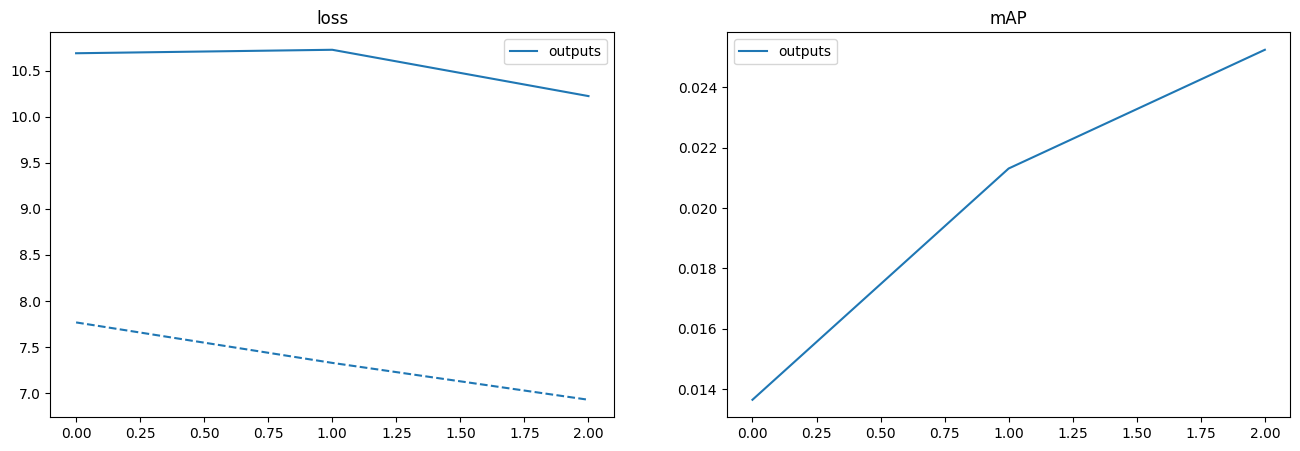

In [99]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com

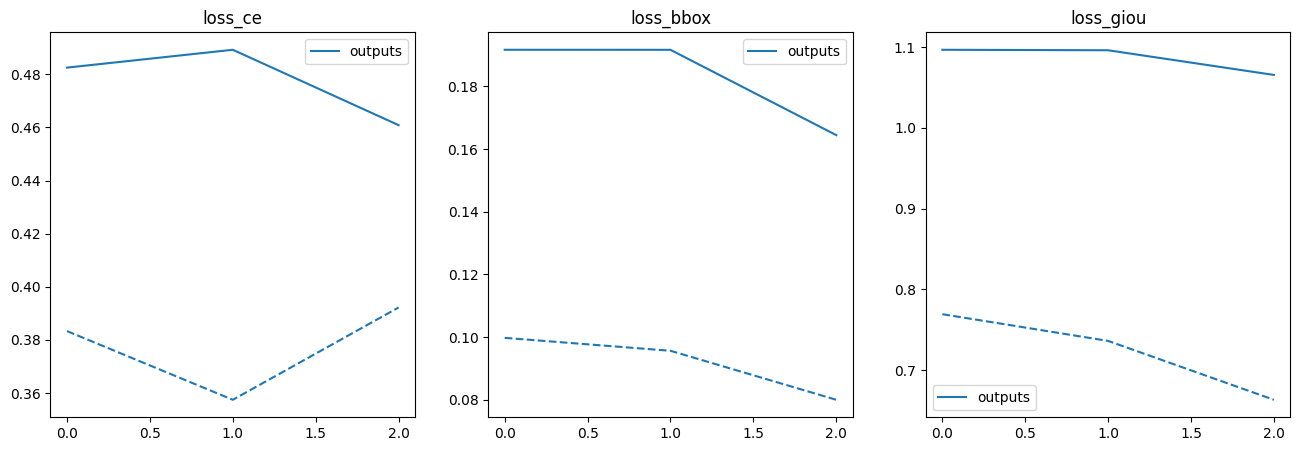

In [100]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


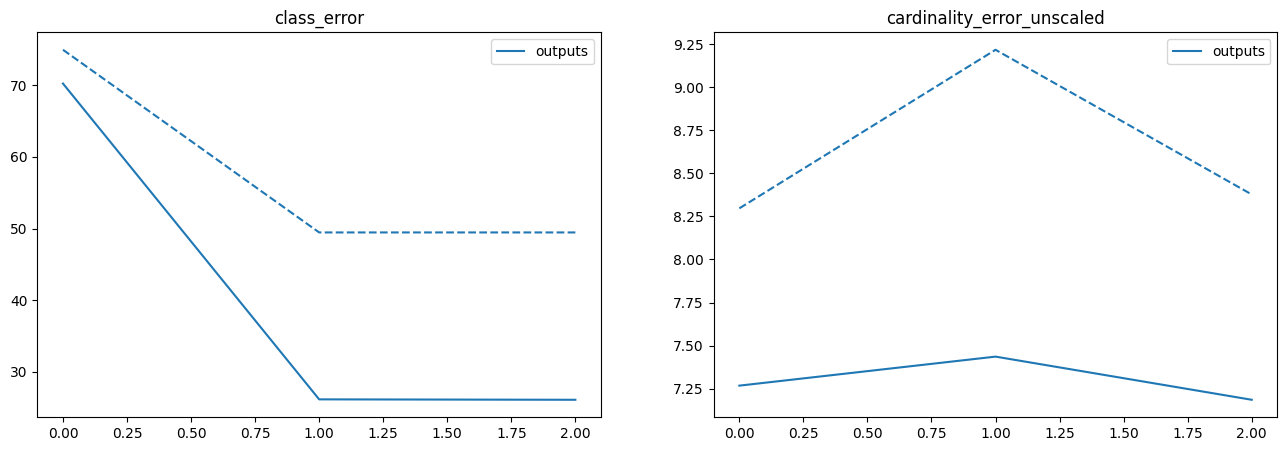

In [101]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

# Visualize Inference

In [103]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();
     

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /home/joywu/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/joywu/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    

def interpolate_show_PET(nda, suv_max, spacing=(1,1), title=None, margin=0, dpi=100, colormap='Greys', OUTPATH=None,show=False):
    ysize = nda.shape[0]
    xsize = nda.shape[1]

    figsize = (1 + margin) * xsize * spacing[0] / dpi, (1 + margin) * ysize * spacing[1] / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
    #hide axis
    ax.axis('off')
    
    extent = (0, xsize * spacing[0], 0, ysize * spacing[1])

    #various papers mentions bicubic interpolation...
    t = ax.imshow(
#         nda, extent=extent, interpolation="hamming", cmap="Greys", origin="upper", vmax=suv_max
#         nda, extent=extent, interpolation="bilinear", cmap="Greys", origin="upper", vmax=suv_max
        nda, extent=extent, interpolation="bicubic", cmap=colormap, origin="upper", vmax=suv_max 
    )

    if title:
        plt.title(title)
    if OUTPATH != None:
        fig.savefig(os.path.join(OUTPATH,'MIP'+'%04d' % (i)+'.png'), dpi = dpi)
    if not show:
        plt.close(fig)


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def filter_bboxes_from_outputs(outputs, threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled


def run_workflow(my_image, my_model):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in [0.9, 0.7]:
    
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)

        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

## Display a train image

In [106]:
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

In [107]:
mode = 'train'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.60s)
creating index...
index created!


In [110]:
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [111]:
idx = 0
image_id = imgIds[idx]
print(image_id)

0


In [ ]:
# img_name = '/content/data/custom/train2017/145053828_e0e748717c_b.jpg'
# im = Image.open(img_name)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 6
im = _suv_to_greyPIL(suv_img, suv_max)

run_workflow(im, model)

## Display a validation image

In [115]:
mode = 'val'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [116]:
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [117]:
idx = 0
image_id = imgIds[idx]
print(image_id)

40992


In [ ]:
# img_name = '/content/data/custom/val2017/410488422_5f8991f26e_b.jpg'
# im = Image.open(img_name)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 6
im = _suv_to_greyPIL(suv_img, suv_max)

run_workflow(im, model)